# Optimize

run and compare optimization frameworks
- scipy.optimize (L-BFGS-B)
- Dlib
- Pptuna
- Hyperopt
- Platypus
- Nevergrad
- Ax


In [1]:
from datetime import datetime
from functools import partial
# import pandas_datareader as pdr
from concurrent import futures

import pytest
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

# optimizers
from scipy import optimize
import dlib     # http://dlib.net/
import optuna   # https://optuna.org/
import hyperopt # http://hyperopt.github.io/hyperopt/
from hyperopt import fmin, tpe, hp
import platypus    # https://github.com/Project-Platypus/Platypus
from platypus import MOEAD, Problem, Real
import nevergrad as ng  # https://facebookresearch.github.io/nevergrad/optimization.html
import ax  # https://ax.dev/

from SWRsimulation import SWRsimulation

# TODO:
# 1) smoother 
# init_withdrawal -> set previous to None, smoothing_factor per config
# withdrawal -> compute desired withdrawal based on previous
# min (desired, previous + (desired-previous)/smoothing_factor )

# 2) montecarlo - initialize array of trials at start and reuse it

# 3) take strategies for 0 and 1 and double check the CE values because it seems off. check strat 1 at CE 0 and strat 0 at CE1
# redo history several times without reinitializing with different parameters
# simulates take override simulation args
# init creates a list of samples, n_trials by n_ret_years
# for history , simulate creates a generator from samples and returns them

# 4) add chart of all spending paths

# chart of all optimizers, do with plotly, hover shows gamma, value, optimizer, elapsed time

# 4) do with deathrate

# multithreading, optimize for speed

print("%s %s" % ('numpy', np.__version__))
print("%s %s" % ('pandas', pd.__version__))
print("%s %s" % ('scipy', scipy.__version__))
print("%s %s" % ("dlib", dlib.__version__))
print("%s %s" % ('optuna', optuna.__version__))
print("%s %s" % ('hyperopt', hyperopt.__version__))
print("%s %s" % ("platypus", platypus.__version__))
print("%s %s" % ("nevergrad", ng.__version__))
print("%s %s" % ("ax", ax.__version__))


numpy 1.19.5
pandas 1.2.1
scipy 1.6.0
dlib 19.21.1
optuna 2.5.0
hyperopt 0.2.5
platypus 1.0.4
nevergrad 0.4.3
ax 0.1.19


In [2]:
N_TRIALS = 1000

In [3]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


### Load data

Data via Aswath Damodaran (big thanks professor!)

http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html 

In [4]:
# load Damodaran data from pickle

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [5]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

### Function to optimize 

In [6]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulation.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'smoothing_factor': 1.0,
                      },
        'evaluation': {'gamma': gamma},
        'analysis': {}    
    })
    s.simulate()
    return -SWRsimulation.crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))



-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


### scipy.optimize (L-BFGS-B)

In [60]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
# quasi-Newton method

results_dict = {}
timings_dict = {}

# initial guess
x0 = np.array([0.5, 5.0, 1.0])
method = 'L-BFGS-B'
optimizer = "scipy.optimize (%s)" % method

MAX_ITER = N_TRIALS

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
    start_time = datetime.now()
    
    sobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    fixed_max = 5
    variable_max = 10
    alloc_max = 1

    result = optimize.minimize(sobjective, x0=x0, method=method,
                               options={'maxiter': MAX_ITER},
                               bounds=((0, fixed_max), (0, variable_max), (0, alloc_max))
                              )
    study_params.append(result.x)
    study_values.append(result.fun)

    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    print("%s Finishing optimizer %s, gamma %d, %d iterations in %s" % (datestr(), optimizer, gamma, result.nit, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), result.fun, result.x))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %d trials in %s" % (opt_end_time, result.nit, time_elapsed))

2021-02-11 17:13:02 Starting scipy.optimize (L-BFGS-B), gamma 0, 1000 iterations max
2021-02-11 17:13:06 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 0, 5 iterations in 0:00:03.490666
2021-02-11 17:13:06 best value -15532.416056, best params [0.         6.20410477 1.        ]
2021-02-11 17:13:06 Starting scipy.optimize (L-BFGS-B), gamma 1, 1000 iterations max
2021-02-11 17:13:12 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 1, 11 iterations in 0:00:06.401376
2021-02-11 17:13:12 best value -13517.859788, best params [0.29529652 6.23943231 1.        ]
2021-02-11 17:13:12 Starting scipy.optimize (L-BFGS-B), gamma 2, 1000 iterations max
2021-02-11 17:14:14 Finishing optimizer scipy.optimize (L-BFGS-B), gamma 2, 14 iterations in 0:01:02.120025
2021-02-11 17:14:14 best value -12036.308515, best params [2.06403558 4.39369665 1.        ]
2021-02-11 17:14:14 Starting scipy.optimize (L-BFGS-B), gamma 4, 1000 iterations max
2021-02-11 17:16:41 Finishing optimizer scipy.optimize (L-

In [63]:
results = pd.DataFrame(study_params, columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204105   
1      1      1.000000     0.000000     0.295297        6.239432   
2      2      1.000000     0.000000     2.064036        4.393697   
3      4      0.890329     0.109671     2.615586        3.199853   
4      6      0.816224     0.183776     3.000151        2.265994   
5      8      0.785915     0.214085     3.188369        1.833849   
6     10      0.770464     0.229536     3.322693        1.534553   
7     12      0.902841     0.097159     2.662793        3.077798   
8     14      0.753637     0.246363     3.498058        1.154462   
9     16      0.754680     0.245320     3.556900        1.029995   

          value                 timing  
0 -15532.416056 0 days 00:00:03.490666  
1 -13517.859788 0 days 00:00:06.401376  
2 -12036.308515 0 days 00:01:02.120025  
3 -10318.960483 0 days 00:02:26.616809  
4  -9574.406303 0 days 00:00:40.640265  
5  -9163.997255 0 days 00:00:53.842429  
6  -8906.921628 0 days 00:01:04.497908  
7  -7980.752323 0 days 00:00:47.387097  
8  -8603.485064 0 days 00:01:20.591886  
9  -8506.558108 0 days 00:00:39.625077

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f060cadc580>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.5568999701583297,
 'fixed_pct': 3.5568999701583293,
 'variable': 0.01029994504412624,
 'variable_pct': 1.029994504412624}
mean annual spending over all cohorts 4.94
0.00% of portfolios exhausted by final year


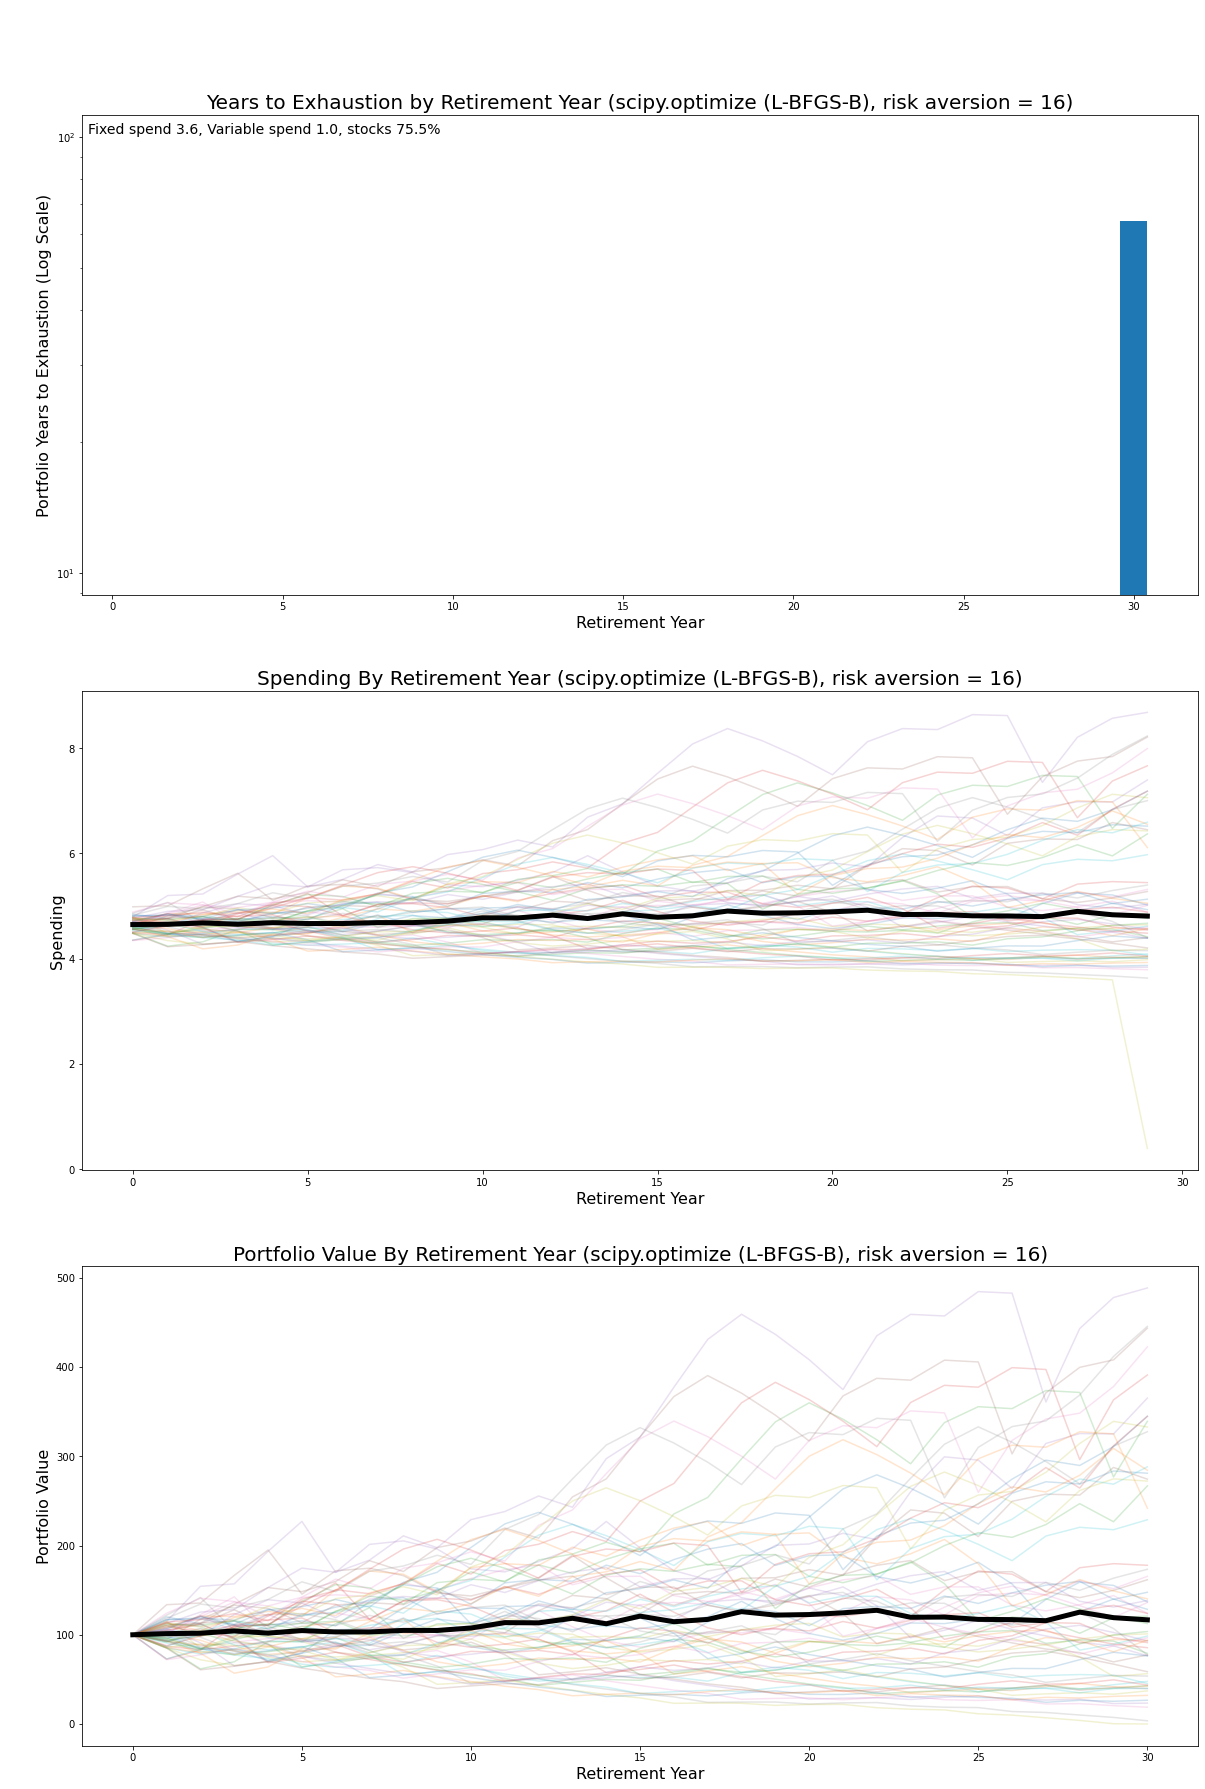

In [10]:
def analyze_strat(resultsrow):

    FIXED_SPEND = resultsrow.fixed_spend
    VARIABLE_SPEND = resultsrow.variable_spend
    ALLOC_STOCKS = resultsrow.alloc_stocks
    ALLOC_BONDS = 1 - ALLOC_STOCKS
    GAMMA = resultsrow.gamma
    N_RET_YEARS = 30

    s = SWRsimulation.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': N_RET_YEARS,
                      },
        'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
        'withdrawal': {'fixed_pct': FIXED_SPEND,
                       'variable_pct': VARIABLE_SPEND},
        'evaluation': {'gamma': GAMMA},
        'analysis': {'histogram': True, 
                     'chart_1' : {'title': 'Years to Exhaustion by Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                  'annotation': "Fixed spend %.1f, Variable spend %.1f, stocks %.1f%%" % (FIXED_SPEND, 
                                                                                                          VARIABLE_SPEND, 
                                                                                                          100 * ALLOC_STOCKS)
                                 },
                     'chart_2' : {'title': 'Spending By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                 },
                     'chart_3' : {'title': 'Portfolio Value By Retirement Year (%s, risk aversion = %d)' % (optimizer, GAMMA),
                                 },
                    }    
    })
    
    print(s)

    s.simulate()

    return s
    

analyze_strat(results.iloc[-1]).analyze()


### Dlib

http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html?m=1


In [11]:
print("%s %s" % ("dlib", dlib.__version__))

n_trials = N_TRIALS
optimizer = "dlib"

study_params = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

def objective_factory(N_RET_YEARS, gamma):
    # partial doesn't work for dlib i.e. objective = partial(ce_experiment, N_RET_YEARS, gamma)
    def objective(fixed_spend, variable_spend, alloc_stocks):
        return ce_experiment(N_RET_YEARS, gamma, fixed_spend, variable_spend, alloc_stocks)
    return objective
    
opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 

    objective = objective_factory(N_RET_YEARS, gamma)

    best = dlib.find_min_global(f=objective, 
                                bound1=[0., 0., 0.],   # lower bounds
                                bound2=[5., 10., 1.],  # variable_spend
                                num_function_calls=n_trials)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)

    study_params.append((best[1], 
                         best[0], 
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %s params %s" % (datestr(), best[1], best[0]))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


dlib 19.21.1
2021-02-11 14:01:51 Starting dlib, gamma 0, 1000 trials
2021-02-11 14:04:04 Finishing optimizer dlib, gamma 0, 1000 trials in 0:02:12.268079
2021-02-11 14:04:04 best value -15532.416056206732 params [0.0, 6.204087381548146, 1.0]
2021-02-11 14:04:04 Starting dlib, gamma 1, 1000 trials
2021-02-11 14:06:13 Finishing optimizer dlib, gamma 1, 1000 trials in 0:02:09.463149
2021-02-11 14:06:13 best value -13517.859787594858 params [0.29529193138131904, 6.239438620291712, 1.0]
2021-02-11 14:06:13 Starting dlib, gamma 2, 1000 trials
2021-02-11 14:08:25 Finishing optimizer dlib, gamma 2, 1000 trials in 0:02:11.915284
2021-02-11 14:08:25 best value -12028.65375869075 params [2.12458281920887, 4.193592549455626, 1.0]
2021-02-11 14:08:25 Starting dlib, gamma 4, 1000 trials
2021-02-11 14:10:43 Finishing optimizer dlib, gamma 4, 1000 trials in 0:02:17.624961
2021-02-11 14:10:43 best value -10315.396638679955 params [2.597496419261401, 3.2471789534082665, 0.8834139687575733]
2021-02-11 14

In [12]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      1.000000     0.000000     0.000000        6.204087 -15532.416056
1      1      1.000000     0.000000     0.295292        6.239439 -13517.859788
2      2      1.000000     0.000000     2.124583        4.193593 -12028.653759
3      4      0.883414     0.116586     2.597496        3.247179 -10315.396639
4      6      0.885044     0.114956     2.949184        2.327530  -9534.421992
5      8      0.737879     0.262121     2.886348        2.530720  -9057.062333
6     10      0.843963     0.156037     3.328163        1.521404  -8888.863970
7     12      0.631437     0.368563     3.255910        1.654755  -8659.229463
8     14      0.771177     0.228823     3.498851        1.153955  -8602.716036
9     16      0.782015     0.217985     3.146965        1.927315  -8278.872648

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f060cad9270>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.146965316345454,
 'fixed_pct': 3.1469653163454545,
 'variable': 0.019273154394929225,
 'variable_pct': 1.9273154394929224}
mean annual spending over all cohorts 5.45
0.00% of portfolios exhausted by final year


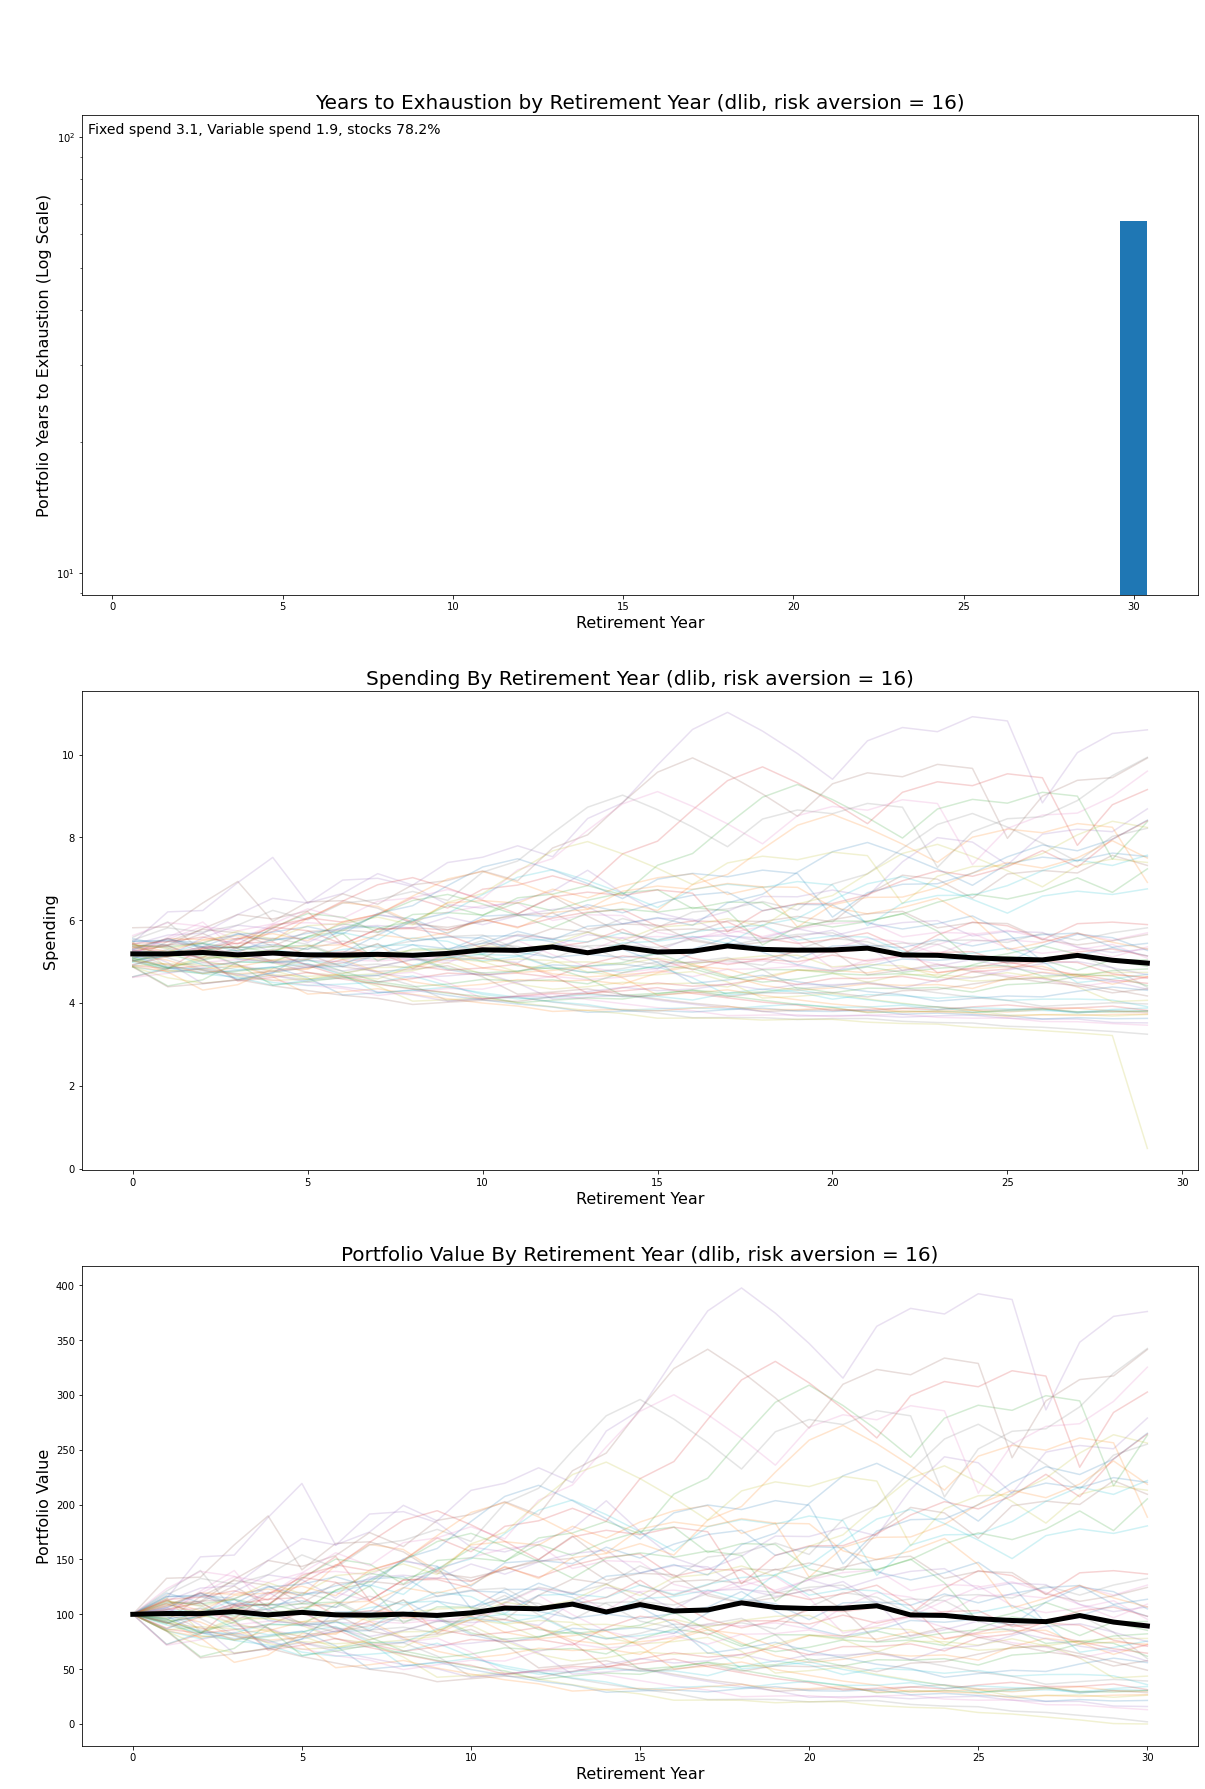

In [13]:
analyze_strat(results.iloc[-1]).analyze()


### Optuna

https://optuna.org/


In [14]:
print("%s %s" % ('optuna', optuna.__version__))
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(gamma, trial):
    fixed_spend = trial.suggest_uniform('fixed_spend', 0, 5)
    variable_spend = trial.suggest_uniform('variable_spend', 0, 10)
    alloc_stocks = trial.suggest_uniform('alloc_stocks', 0, 1)
    oobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    return oobjective([fixed_spend, variable_spend, alloc_stocks])

study_params = []
study_values = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

n_trials = N_TRIALS
optimizer = "Optuna"

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    study = optuna.create_study()
    study.optimize(partial(objective, gamma), n_trials=n_trials)
    study_params.append(study.best_params)
    study_values.append(study.best_value)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best value %f, best params %s" % (datestr(), study.best_value, study.best_params))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))
    

optuna 2.5.0
2021-02-11 14:25:39 Starting Optuna, gamma 0, 1000 trials
2021-02-11 14:27:50 Finishing optimizer Optuna, gamma 0, 1000 trials in 0:02:10.861285
2021-02-11 14:27:50 best value -15531.204788, best params {'fixed_spend': 0.0015677556131221178, 'variable_spend': 6.187638224533782, 'alloc_stocks': 0.999925551842237}
2021-02-11 14:27:50 Starting Optuna, gamma 1, 1000 trials
2021-02-11 14:29:59 Finishing optimizer Optuna, gamma 1, 1000 trials in 0:02:09.269949
2021-02-11 14:29:59 best value -13517.607732, best params {'fixed_spend': 0.29535468254328673, 'variable_spend': 6.204599390189315, 'alloc_stocks': 0.9999934664316816}
2021-02-11 14:29:59 Starting Optuna, gamma 2, 1000 trials
2021-02-11 14:32:12 Finishing optimizer Optuna, gamma 2, 1000 trials in 0:02:12.748044
2021-02-11 14:32:12 best value -12034.787702, best params {'fixed_spend': 2.0522646359203898, 'variable_spend': 4.424439264582771, 'alloc_stocks': 0.9991345099006027}
2021-02-11 14:32:12 Starting Optuna, gamma 4, 10

In [15]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['value'] = study_values
results['timing'] = study_timings
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      0.999926     0.000074     0.001568        6.187638 -15531.204788
1      1      0.999993     0.000007     0.295355        6.204599 -13517.607732
2      2      0.999135     0.000865     2.052265        4.424439 -12034.787702
3      4      0.883328     0.116672     2.700751        2.989388 -10325.958295
4      6      0.840129     0.159871     3.009218        2.252371  -9569.490338
5      8      0.759185     0.240815     3.188194        1.841674  -9156.376272
6     10      0.766593     0.233407     3.280800        1.630282  -8902.261041
7     12      0.739455     0.260545     3.413147        1.304077  -8711.139066
8     14      0.742766     0.257234     3.499051        1.155663  -8599.444552
9     16      0.737396     0.262604     3.578011        0.983110  -8504.843769

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0603176e40>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.578011292619523,
 'fixed_pct': 3.5780112926195224,
 'variable': 0.009831099784384073,
 'variable_pct': 0.9831099784384073}
mean annual spending over all cohorts 4.90
0.00% of portfolios exhausted by final year


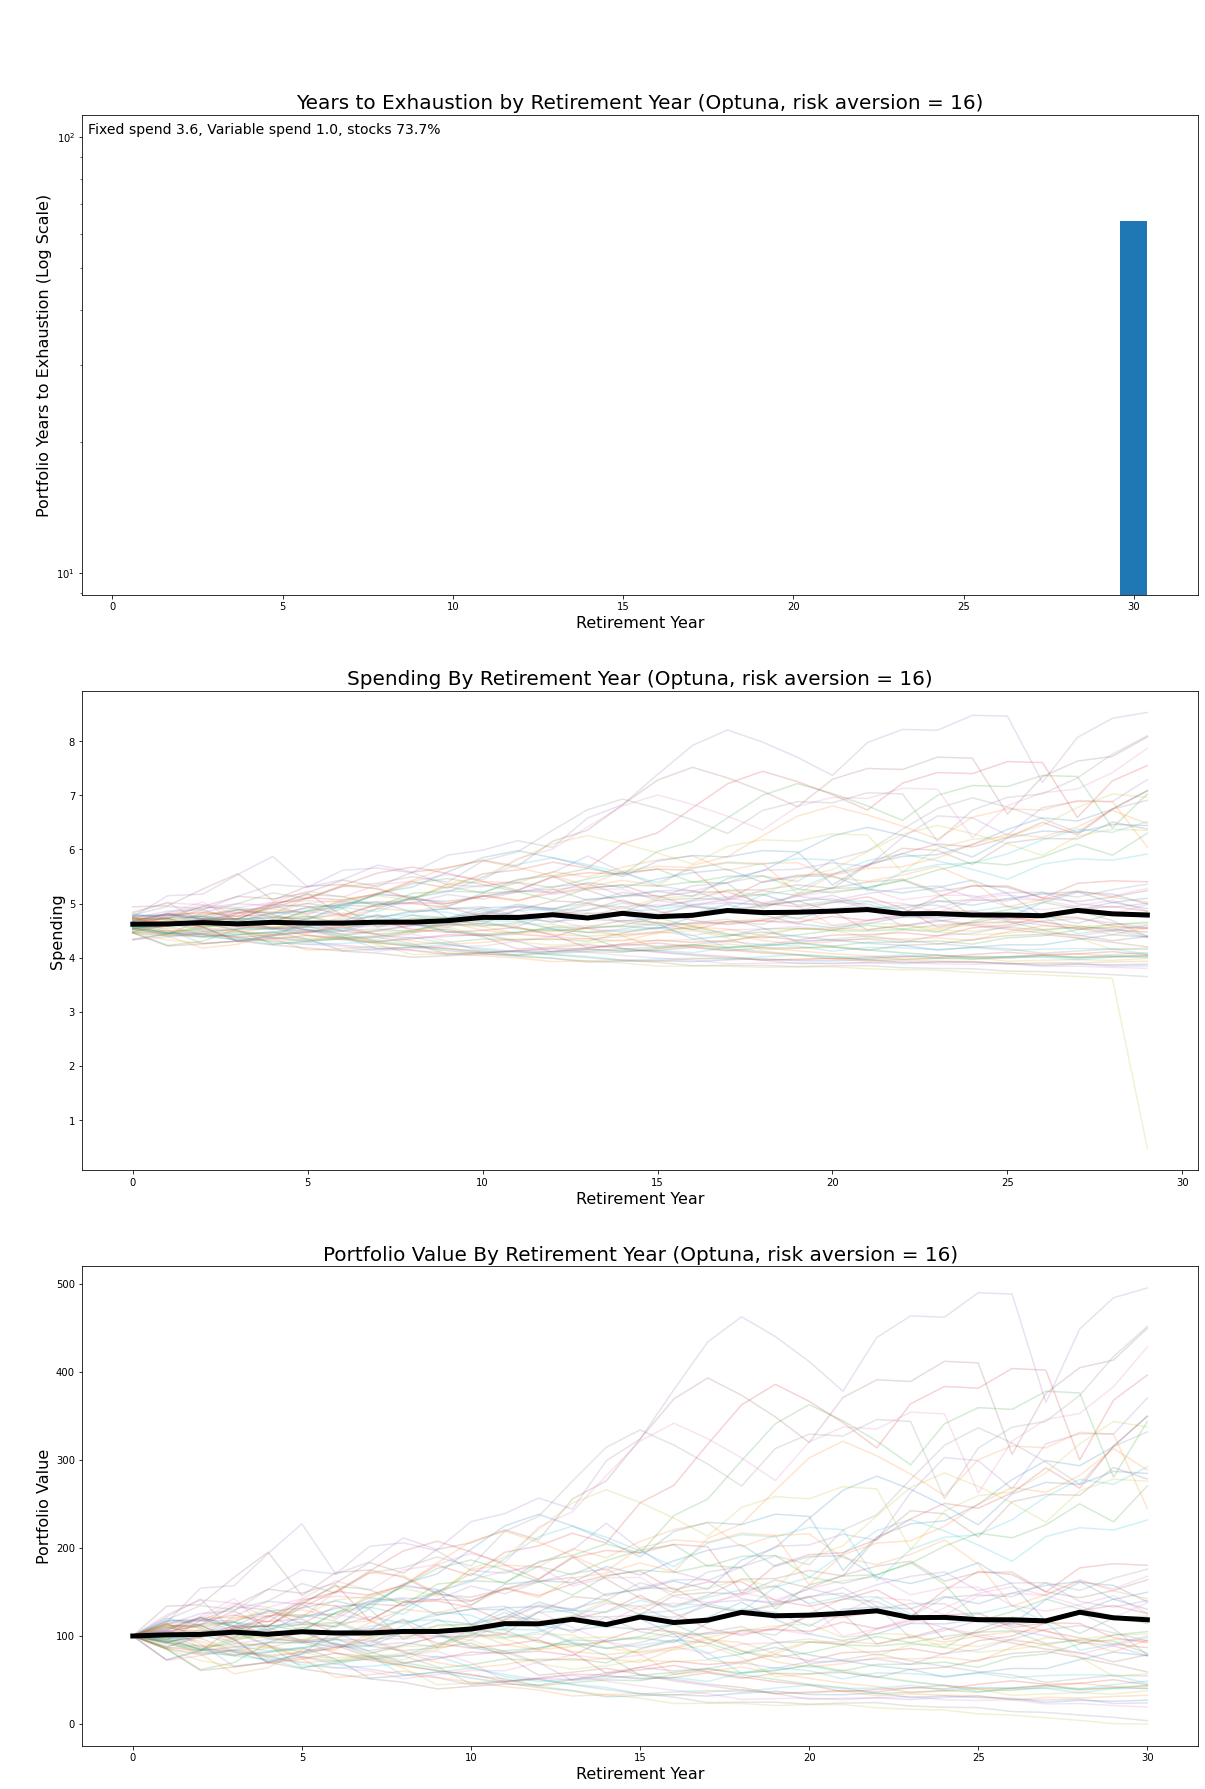

In [16]:
analyze_strat(results.iloc[-1]).analyze()


### Hyperopt
http://hyperopt.github.io/hyperopt/

In [17]:
print("%s %s" % ('hyperopt', hyperopt.__version__))

n_trials = N_TRIALS
optimizer = "Hyperopt"

study_params = []
study_timings = []

study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    hobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    best = fmin(fn=hobjective,
                space={'fixed_spend': hp.uniform('fixed_spend', 0, 5),
                       'variable_spend': hp.uniform('variable_spend', 0, 10),
                       'alloc_stocks': hp.uniform('alloc_stocks', 0, 1),
                      },
                algo=tpe.suggest,
                max_evals=n_trials)
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), study_params[-1]))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


hyperopt 0.2.5
2021-02-11 14:50:02 Starting Hyperopt, gamma 0, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000813 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:09,  7.71trial/s, best loss: -11364.1244980365]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -11364.124498


  0%|          | 2/1000 [00:00<02:07,  7.80trial/s, best loss: -11364.1244980365]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -11364.124498


  0%|          | 3/1000 [00:00<02:05,  7.94trial/s, best loss: -11441.626713576787]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -11441.626714


  0%|          | 4/1000 [00:00<02:04,  7.99trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -14799.802120


  0%|          | 5/1000 [00:00<02:04,  7.97trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -14799.802120


  1%|          | 6/1000 [00:00<02:04,  8.01trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -14799.802120


  1%|          | 7/1000 [00:00<02:03,  8.05trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -14799.802120


  1%|          | 8/1000 [00:01<02:03,  8.05trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -14799.802120


  1%|          | 9/1000 [00:01<02:03,  8.05trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -14799.802120


  1%|          | 10/1000 [00:01<02:02,  8.06trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -14799.802120


  1%|          | 11/1000 [00:01<02:02,  8.05trial/s, best loss: -14799.802119999873]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -14799.802120


  1%|          | 12/1000 [00:01<02:02,  8.07trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -14874.091992


  1%|▏         | 13/1000 [00:01<02:01,  8.09trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -14874.091992


  1%|▏         | 14/1000 [00:01<02:33,  6.44trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -14874.091992


  2%|▏         | 15/1000 [00:01<02:23,  6.86trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -14874.091992


  2%|▏         | 16/1000 [00:02<02:17,  7.17trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -14874.091992


  2%|▏         | 17/1000 [00:02<02:12,  7.41trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -14874.091992


  2%|▏         | 18/1000 [00:02<02:09,  7.58trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -14874.091992


  2%|▏         | 19/1000 [00:02<02:07,  7.70trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -14874.091992


  2%|▏         | 20/1000 [00:02<02:05,  7.79trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -14874.091992


  2%|▏         | 21/1000 [00:02<02:07,  7.69trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -14874.091992


  2%|▏         | 22/1000 [00:02<02:06,  7.72trial/s, best loss: -14874.091991775615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -14874.091992


  2%|▏         | 23/1000 [00:02<02:07,  7.64trial/s, best loss: -14925.66579956476] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -14925.665800


  2%|▏         | 24/1000 [00:03<02:07,  7.68trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -14925.665800


  2%|▎         | 25/1000 [00:03<02:07,  7.65trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -14925.665800


  3%|▎         | 26/1000 [00:03<02:08,  7.60trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -14925.665800


  3%|▎         | 27/1000 [00:03<02:09,  7.52trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001817 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -14925.665800


  3%|▎         | 28/1000 [00:03<02:11,  7.41trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -14925.665800


  3%|▎         | 29/1000 [00:03<02:11,  7.39trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -14925.665800


  3%|▎         | 30/1000 [00:03<02:11,  7.38trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -14925.665800


  3%|▎         | 31/1000 [00:04<02:10,  7.43trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000676 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -14925.665800


  3%|▎         | 32/1000 [00:04<02:08,  7.51trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -14925.665800


  3%|▎         | 33/1000 [00:04<02:08,  7.51trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -14925.665800


  3%|▎         | 34/1000 [00:04<02:08,  7.51trial/s, best loss: -14925.66579956476]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000688 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -14925.665800


  4%|▎         | 35/1000 [00:04<02:08,  7.53trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -15245.692164


  4%|▎         | 36/1000 [00:04<02:09,  7.42trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -15245.692164


  4%|▎         | 37/1000 [00:04<02:09,  7.42trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -15245.692164


  4%|▍         | 38/1000 [00:05<02:09,  7.41trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -15245.692164


  4%|▍         | 39/1000 [00:05<02:10,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -15245.692164


  4%|▍         | 40/1000 [00:05<02:09,  7.40trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -15245.692164


  4%|▍         | 41/1000 [00:05<02:09,  7.40trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -15245.692164


  4%|▍         | 42/1000 [00:05<02:10,  7.34trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -15245.692164


  4%|▍         | 43/1000 [00:05<02:10,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -15245.692164


  4%|▍         | 44/1000 [00:05<02:09,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -15245.692164


  4%|▍         | 45/1000 [00:05<02:09,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -15245.692164


  5%|▍         | 46/1000 [00:06<02:09,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -15245.692164


  5%|▍         | 47/1000 [00:06<02:09,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -15245.692164


  5%|▍         | 48/1000 [00:06<02:08,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -15245.692164


  5%|▍         | 49/1000 [00:06<02:08,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -15245.692164


  5%|▌         | 50/1000 [00:06<02:08,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -15245.692164


  5%|▌         | 51/1000 [00:06<02:08,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -15245.692164


  5%|▌         | 52/1000 [00:06<02:07,  7.41trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -15245.692164


  5%|▌         | 53/1000 [00:07<02:07,  7.41trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -15245.692164


  5%|▌         | 54/1000 [00:07<02:07,  7.40trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -15245.692164


  6%|▌         | 55/1000 [00:07<02:07,  7.41trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -15245.692164


  6%|▌         | 56/1000 [00:07<02:07,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -15245.692164


  6%|▌         | 57/1000 [00:07<02:07,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -15245.692164


  6%|▌         | 58/1000 [00:07<02:07,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -15245.692164


  6%|▌         | 59/1000 [00:07<02:07,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -15245.692164


  6%|▌         | 60/1000 [00:07<02:07,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -15245.692164


  6%|▌         | 61/1000 [00:08<02:08,  7.33trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -15245.692164


  6%|▌         | 62/1000 [00:08<02:07,  7.34trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -15245.692164


  6%|▋         | 63/1000 [00:08<02:07,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -15245.692164


  6%|▋         | 64/1000 [00:08<02:06,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -15245.692164


  6%|▋         | 65/1000 [00:08<02:07,  7.35trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -15245.692164


  7%|▋         | 66/1000 [00:08<02:06,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -15245.692164


  7%|▋         | 67/1000 [00:08<02:06,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -15245.692164


  7%|▋         | 68/1000 [00:09<02:06,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -15245.692164


  7%|▋         | 69/1000 [00:09<02:05,  7.40trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -15245.692164


  7%|▋         | 70/1000 [00:09<02:05,  7.40trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -15245.692164


  7%|▋         | 71/1000 [00:09<02:05,  7.41trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -15245.692164


  7%|▋         | 72/1000 [00:09<02:06,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -15245.692164


  7%|▋         | 73/1000 [00:09<02:05,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -15245.692164


  7%|▋         | 74/1000 [00:09<02:06,  7.35trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -15245.692164


  8%|▊         | 75/1000 [00:10<02:05,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -15245.692164


  8%|▊         | 76/1000 [00:10<02:05,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -15245.692164


  8%|▊         | 77/1000 [00:10<02:06,  7.29trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -15245.692164


  8%|▊         | 78/1000 [00:10<02:06,  7.27trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -15245.692164


  8%|▊         | 79/1000 [00:10<02:06,  7.31trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -15245.692164


  8%|▊         | 80/1000 [00:10<02:05,  7.31trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -15245.692164


  8%|▊         | 81/1000 [00:10<02:05,  7.32trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -15245.692164


  8%|▊         | 82/1000 [00:10<02:05,  7.30trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -15245.692164


  8%|▊         | 83/1000 [00:11<02:05,  7.31trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -15245.692164


  8%|▊         | 84/1000 [00:11<02:05,  7.32trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -15245.692164


  8%|▊         | 85/1000 [00:11<02:05,  7.31trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -15245.692164


  9%|▊         | 86/1000 [00:11<02:04,  7.32trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -15245.692164


  9%|▊         | 87/1000 [00:11<02:04,  7.35trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -15245.692164


  9%|▉         | 88/1000 [00:11<02:03,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -15245.692164


  9%|▉         | 89/1000 [00:11<02:03,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -15245.692164


  9%|▉         | 90/1000 [00:12<02:03,  7.36trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -15245.692164


  9%|▉         | 91/1000 [00:12<02:03,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -15245.692164


  9%|▉         | 92/1000 [00:12<02:02,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -15245.692164


  9%|▉         | 93/1000 [00:12<02:02,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -15245.692164


  9%|▉         | 94/1000 [00:12<02:02,  7.38trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -15245.692164


 10%|▉         | 95/1000 [00:12<02:02,  7.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -15245.692164


 10%|▉         | 96/1000 [00:12<02:02,  7.37trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -15245.692164


 10%|▉         | 97/1000 [00:13<02:02,  7.35trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -15245.692164


 10%|▉         | 98/1000 [00:13<02:02,  7.34trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -15245.692164


 10%|▉         | 99/1000 [00:13<02:29,  6.03trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -15245.692164


 10%|█         | 100/1000 [00:13<02:20,  6.39trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -15245.692164


 10%|█         | 101/1000 [00:13<02:15,  6.65trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -15245.692164


 10%|█         | 102/1000 [00:13<02:11,  6.85trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -15245.692164


 10%|█         | 103/1000 [00:13<02:07,  7.02trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -15245.692164


 10%|█         | 104/1000 [00:14<02:05,  7.13trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -15245.692164


 10%|█         | 105/1000 [00:14<02:04,  7.21trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -15245.692164


 11%|█         | 106/1000 [00:14<02:03,  7.26trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -15245.692164


 11%|█         | 107/1000 [00:14<02:02,  7.27trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -15245.692164


 11%|█         | 108/1000 [00:14<02:02,  7.28trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -15245.692164


 11%|█         | 109/1000 [00:14<02:01,  7.32trial/s, best loss: -15245.692163606445]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -15245.692164


 11%|█         | 110/1000 [00:14<02:01,  7.31trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -15399.458144


 11%|█         | 111/1000 [00:15<02:01,  7.34trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -15399.458144


 11%|█         | 112/1000 [00:15<02:00,  7.36trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -15399.458144


 11%|█▏        | 113/1000 [00:15<02:00,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -15399.458144


 11%|█▏        | 114/1000 [00:15<01:59,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -15399.458144


 12%|█▏        | 115/1000 [00:15<01:59,  7.40trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -15399.458144


 12%|█▏        | 116/1000 [00:15<01:59,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -15399.458144


 12%|█▏        | 117/1000 [00:15<01:59,  7.37trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -15399.458144


 12%|█▏        | 118/1000 [00:15<01:59,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -15399.458144


 12%|█▏        | 119/1000 [00:16<01:59,  7.40trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -15399.458144


 12%|█▏        | 120/1000 [00:16<02:00,  7.31trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -15399.458144


 12%|█▏        | 121/1000 [00:16<01:59,  7.34trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -15399.458144


 12%|█▏        | 122/1000 [00:16<01:59,  7.36trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -15399.458144


 12%|█▏        | 123/1000 [00:16<01:59,  7.34trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -15399.458144


 12%|█▏        | 124/1000 [00:16<01:59,  7.34trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -15399.458144


 12%|█▎        | 125/1000 [00:16<01:59,  7.34trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -15399.458144


 13%|█▎        | 126/1000 [00:17<01:58,  7.37trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -15399.458144


 13%|█▎        | 127/1000 [00:17<01:58,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -15399.458144


 13%|█▎        | 128/1000 [00:17<01:58,  7.37trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -15399.458144


 13%|█▎        | 129/1000 [00:17<01:57,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -15399.458144


 13%|█▎        | 130/1000 [00:17<01:57,  7.41trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -15399.458144


 13%|█▎        | 131/1000 [00:17<01:57,  7.41trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -15399.458144


 13%|█▎        | 132/1000 [00:17<01:57,  7.37trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -15399.458144


 13%|█▎        | 133/1000 [00:18<01:57,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -15399.458144


 13%|█▎        | 134/1000 [00:18<01:57,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -15399.458144


 14%|█▎        | 135/1000 [00:18<01:57,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -15399.458144


 14%|█▎        | 136/1000 [00:18<01:56,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -15399.458144


 14%|█▎        | 137/1000 [00:18<01:56,  7.41trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -15399.458144


 14%|█▍        | 138/1000 [00:18<01:56,  7.40trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -15399.458144


 14%|█▍        | 139/1000 [00:18<01:56,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -15399.458144


 14%|█▍        | 140/1000 [00:18<01:56,  7.36trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -15399.458144


 14%|█▍        | 141/1000 [00:19<01:56,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -15399.458144


 14%|█▍        | 142/1000 [00:19<01:56,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -15399.458144


 14%|█▍        | 143/1000 [00:19<01:55,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -15399.458144


 14%|█▍        | 144/1000 [00:19<01:56,  7.36trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -15399.458144


 14%|█▍        | 145/1000 [00:19<01:56,  7.37trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -15399.458144


 15%|█▍        | 146/1000 [00:19<01:55,  7.38trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -15399.458144


 15%|█▍        | 147/1000 [00:19<01:55,  7.39trial/s, best loss: -15399.458144052967]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -15399.458144


 15%|█▍        | 148/1000 [00:20<01:56,  7.32trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -15410.628437


 15%|█▍        | 149/1000 [00:20<01:56,  7.33trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -15410.628437


 15%|█▌        | 150/1000 [00:20<01:55,  7.33trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -15410.628437


 15%|█▌        | 151/1000 [00:20<01:55,  7.33trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -15410.628437


 15%|█▌        | 152/1000 [00:20<01:55,  7.32trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -15410.628437


 15%|█▌        | 153/1000 [00:20<01:55,  7.32trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -15410.628437


 15%|█▌        | 154/1000 [00:20<01:55,  7.34trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -15410.628437


 16%|█▌        | 155/1000 [00:20<01:55,  7.33trial/s, best loss: -15410.628436927966]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -15410.628437


 16%|█▌        | 156/1000 [00:21<01:55,  7.34trial/s, best loss: -15417.69721333369] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -15417.697213


 16%|█▌        | 157/1000 [00:21<01:54,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -15417.697213


 16%|█▌        | 158/1000 [00:21<01:53,  7.39trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -15417.697213


 16%|█▌        | 159/1000 [00:21<01:53,  7.39trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -15417.697213


 16%|█▌        | 160/1000 [00:21<01:54,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -15417.697213


 16%|█▌        | 161/1000 [00:21<01:53,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -15417.697213


 16%|█▌        | 162/1000 [00:21<01:53,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -15417.697213


 16%|█▋        | 163/1000 [00:22<01:53,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -15417.697213


 16%|█▋        | 164/1000 [00:22<01:53,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -15417.697213


 16%|█▋        | 165/1000 [00:22<01:53,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -15417.697213


 17%|█▋        | 166/1000 [00:22<01:53,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -15417.697213


 17%|█▋        | 167/1000 [00:22<01:52,  7.38trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -15417.697213


 17%|█▋        | 168/1000 [00:22<01:52,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -15417.697213


 17%|█▋        | 169/1000 [00:22<01:52,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -15417.697213


 17%|█▋        | 170/1000 [00:23<01:52,  7.38trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -15417.697213


 17%|█▋        | 171/1000 [00:23<01:52,  7.38trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -15417.697213


 17%|█▋        | 172/1000 [00:23<01:52,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -15417.697213


 17%|█▋        | 173/1000 [00:23<01:52,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -15417.697213


 17%|█▋        | 174/1000 [00:23<01:52,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -15417.697213


 18%|█▊        | 175/1000 [00:23<01:52,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -15417.697213


 18%|█▊        | 176/1000 [00:23<01:52,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -15417.697213


 18%|█▊        | 177/1000 [00:23<01:51,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -15417.697213


 18%|█▊        | 178/1000 [00:24<02:13,  6.14trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -15417.697213


 18%|█▊        | 179/1000 [00:24<02:06,  6.47trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -15417.697213


 18%|█▊        | 180/1000 [00:24<02:02,  6.71trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -15417.697213


 18%|█▊        | 181/1000 [00:24<01:58,  6.89trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -15417.697213


 18%|█▊        | 182/1000 [00:24<01:56,  7.01trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -15417.697213


 18%|█▊        | 183/1000 [00:24<01:54,  7.11trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -15417.697213


 18%|█▊        | 184/1000 [00:25<01:53,  7.19trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -15417.697213


 18%|█▊        | 185/1000 [00:25<01:53,  7.21trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -15417.697213


 19%|█▊        | 186/1000 [00:25<01:52,  7.25trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -15417.697213


 19%|█▊        | 187/1000 [00:25<01:51,  7.28trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -15417.697213


 19%|█▉        | 188/1000 [00:25<01:51,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -15417.697213


 19%|█▉        | 189/1000 [00:25<01:51,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -15417.697213


 19%|█▉        | 190/1000 [00:25<01:50,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -15417.697213


 19%|█▉        | 191/1000 [00:25<01:50,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -15417.697213


 19%|█▉        | 192/1000 [00:26<01:50,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -15417.697213


 19%|█▉        | 193/1000 [00:26<01:49,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -15417.697213


 19%|█▉        | 194/1000 [00:26<01:49,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -15417.697213


 20%|█▉        | 195/1000 [00:26<01:49,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -15417.697213


 20%|█▉        | 196/1000 [00:26<01:49,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -15417.697213


 20%|█▉        | 197/1000 [00:26<01:49,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -15417.697213


 20%|█▉        | 198/1000 [00:26<01:48,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -15417.697213


 20%|█▉        | 199/1000 [00:27<01:48,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -15417.697213


 20%|██        | 200/1000 [00:27<01:48,  7.38trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -15417.697213


 20%|██        | 201/1000 [00:27<01:48,  7.38trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -15417.697213


 20%|██        | 202/1000 [00:27<01:48,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -15417.697213


 20%|██        | 203/1000 [00:27<01:48,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -15417.697213


 20%|██        | 204/1000 [00:27<01:48,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -15417.697213


 20%|██        | 205/1000 [00:27<01:48,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -15417.697213


 21%|██        | 206/1000 [00:28<01:48,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -15417.697213


 21%|██        | 207/1000 [00:28<01:47,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -15417.697213


 21%|██        | 208/1000 [00:28<01:48,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -15417.697213


 21%|██        | 209/1000 [00:28<01:47,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -15417.697213


 21%|██        | 210/1000 [00:28<01:47,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -15417.697213


 21%|██        | 211/1000 [00:28<01:47,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -15417.697213


 21%|██        | 212/1000 [00:28<01:47,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -15417.697213


 21%|██▏       | 213/1000 [00:28<01:47,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -15417.697213


 21%|██▏       | 214/1000 [00:29<01:47,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -15417.697213


 22%|██▏       | 215/1000 [00:29<01:46,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -15417.697213


 22%|██▏       | 216/1000 [00:29<01:46,  7.37trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -15417.697213


 22%|██▏       | 217/1000 [00:29<01:45,  7.40trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -15417.697213


 22%|██▏       | 218/1000 [00:29<01:45,  7.39trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -15417.697213


 22%|██▏       | 219/1000 [00:29<01:46,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -15417.697213


 22%|██▏       | 220/1000 [00:29<01:46,  7.36trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -15417.697213


 22%|██▏       | 221/1000 [00:30<01:45,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -15417.697213


 22%|██▏       | 222/1000 [00:30<01:46,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000688 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -15417.697213


 22%|██▏       | 223/1000 [00:30<01:46,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -15417.697213


 22%|██▏       | 224/1000 [00:30<01:45,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -15417.697213


 22%|██▎       | 225/1000 [00:30<01:45,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -15417.697213


 23%|██▎       | 226/1000 [00:30<01:45,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -15417.697213


 23%|██▎       | 227/1000 [00:30<01:45,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -15417.697213


 23%|██▎       | 228/1000 [00:31<01:45,  7.30trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -15417.697213


 23%|██▎       | 229/1000 [00:31<01:45,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -15417.697213


 23%|██▎       | 230/1000 [00:31<01:45,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -15417.697213


 23%|██▎       | 231/1000 [00:31<01:44,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -15417.697213


 23%|██▎       | 232/1000 [00:31<01:44,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -15417.697213


 23%|██▎       | 233/1000 [00:31<01:44,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -15417.697213


 23%|██▎       | 234/1000 [00:31<01:44,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -15417.697213


 24%|██▎       | 235/1000 [00:31<01:44,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -15417.697213


 24%|██▎       | 236/1000 [00:32<01:44,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -15417.697213


 24%|██▎       | 237/1000 [00:32<01:44,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -15417.697213


 24%|██▍       | 238/1000 [00:32<01:43,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -15417.697213


 24%|██▍       | 239/1000 [00:32<01:43,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -15417.697213


 24%|██▍       | 240/1000 [00:32<01:43,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -15417.697213


 24%|██▍       | 241/1000 [00:32<01:43,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -15417.697213


 24%|██▍       | 242/1000 [00:32<01:43,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -15417.697213


 24%|██▍       | 243/1000 [00:33<01:43,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -15417.697213


 24%|██▍       | 244/1000 [00:33<01:43,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -15417.697213


 24%|██▍       | 245/1000 [00:33<01:42,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -15417.697213


 25%|██▍       | 246/1000 [00:33<01:42,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -15417.697213


 25%|██▍       | 247/1000 [00:33<01:42,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -15417.697213


 25%|██▍       | 248/1000 [00:33<01:42,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -15417.697213


 25%|██▍       | 249/1000 [00:33<01:42,  7.35trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -15417.697213


 25%|██▌       | 250/1000 [00:34<01:42,  7.34trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -15417.697213


 25%|██▌       | 251/1000 [00:34<01:42,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -15417.697213


 25%|██▌       | 252/1000 [00:34<01:41,  7.33trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -15417.697213


 25%|██▌       | 253/1000 [00:34<01:42,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -15417.697213


 25%|██▌       | 254/1000 [00:34<01:42,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -15417.697213


 26%|██▌       | 255/1000 [00:34<01:41,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -15417.697213


 26%|██▌       | 256/1000 [00:34<01:41,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -15417.697213


 26%|██▌       | 257/1000 [00:35<02:01,  6.10trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -15417.697213


 26%|██▌       | 258/1000 [00:35<01:55,  6.44trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -15417.697213


 26%|██▌       | 259/1000 [00:35<01:50,  6.68trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -15417.697213


 26%|██▌       | 260/1000 [00:35<01:47,  6.87trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -15417.697213


 26%|██▌       | 261/1000 [00:35<01:45,  7.01trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -15417.697213


 26%|██▌       | 262/1000 [00:35<01:43,  7.11trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -15417.697213


 26%|██▋       | 263/1000 [00:35<01:42,  7.20trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -15417.697213


 26%|██▋       | 264/1000 [00:36<01:41,  7.23trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -15417.697213


 26%|██▋       | 265/1000 [00:36<01:41,  7.24trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -15417.697213


 27%|██▋       | 266/1000 [00:36<01:40,  7.27trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -15417.697213


 27%|██▋       | 267/1000 [00:36<01:40,  7.29trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -15417.697213


 27%|██▋       | 268/1000 [00:36<01:41,  7.19trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -15417.697213


 27%|██▋       | 269/1000 [00:36<01:40,  7.25trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -15417.697213


 27%|██▋       | 270/1000 [00:36<01:41,  7.18trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -15417.697213


 27%|██▋       | 271/1000 [00:36<01:40,  7.23trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -15417.697213


 27%|██▋       | 272/1000 [00:37<01:40,  7.24trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -15417.697213


 27%|██▋       | 273/1000 [00:37<01:39,  7.27trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -15417.697213


 27%|██▋       | 274/1000 [00:37<01:39,  7.30trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -15417.697213


 28%|██▊       | 275/1000 [00:37<01:39,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -15417.697213


 28%|██▊       | 276/1000 [00:37<01:39,  7.30trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -15417.697213


 28%|██▊       | 277/1000 [00:37<01:38,  7.31trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -15417.697213


 28%|██▊       | 278/1000 [00:37<01:38,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -15417.697213


 28%|██▊       | 279/1000 [00:38<01:38,  7.32trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -15417.697213


 28%|██▊       | 280/1000 [00:38<01:38,  7.30trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -15417.697213


 28%|██▊       | 281/1000 [00:38<01:39,  7.26trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -15417.697213


 28%|██▊       | 282/1000 [00:38<01:38,  7.29trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -15417.697213


 28%|██▊       | 283/1000 [00:38<01:38,  7.28trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -15417.697213


 28%|██▊       | 284/1000 [00:38<01:38,  7.29trial/s, best loss: -15417.69721333369]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -15417.697213


 28%|██▊       | 285/1000 [00:38<01:37,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -15418.101869


 29%|██▊       | 286/1000 [00:39<01:37,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -15418.101869


 29%|██▊       | 287/1000 [00:39<01:37,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -15418.101869


 29%|██▉       | 288/1000 [00:39<01:37,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -15418.101869


 29%|██▉       | 289/1000 [00:39<01:37,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -15418.101869


 29%|██▉       | 290/1000 [00:39<01:35,  7.40trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -15418.101869


 29%|██▉       | 291/1000 [00:39<01:36,  7.38trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -15418.101869


 29%|██▉       | 292/1000 [00:39<01:36,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -15418.101869


 29%|██▉       | 293/1000 [00:39<01:36,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -15418.101869


 29%|██▉       | 294/1000 [00:40<01:36,  7.32trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -15418.101869


 30%|██▉       | 295/1000 [00:40<01:36,  7.32trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -15418.101869


 30%|██▉       | 296/1000 [00:40<01:36,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -15418.101869


 30%|██▉       | 297/1000 [00:40<01:36,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -15418.101869


 30%|██▉       | 298/1000 [00:40<01:36,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -15418.101869


 30%|██▉       | 299/1000 [00:40<01:36,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -15418.101869


 30%|███       | 300/1000 [00:40<01:35,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -15418.101869


 30%|███       | 301/1000 [00:41<01:37,  7.20trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -15418.101869


 30%|███       | 302/1000 [00:41<01:36,  7.23trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -15418.101869


 30%|███       | 303/1000 [00:41<01:36,  7.26trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -15418.101869


 30%|███       | 304/1000 [00:41<01:36,  7.23trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -15418.101869


 30%|███       | 305/1000 [00:41<01:35,  7.26trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -15418.101869


 31%|███       | 306/1000 [00:41<01:35,  7.28trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -15418.101869


 31%|███       | 307/1000 [00:41<01:34,  7.30trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -15418.101869


 31%|███       | 308/1000 [00:42<01:34,  7.31trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -15418.101869


 31%|███       | 309/1000 [00:42<01:34,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -15418.101869


 31%|███       | 310/1000 [00:42<01:34,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -15418.101869


 31%|███       | 311/1000 [00:42<01:33,  7.36trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -15418.101869


 31%|███       | 312/1000 [00:42<01:34,  7.29trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -15418.101869


 31%|███▏      | 313/1000 [00:42<01:33,  7.32trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -15418.101869


 31%|███▏      | 314/1000 [00:42<01:33,  7.33trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -15418.101869


 32%|███▏      | 315/1000 [00:42<01:33,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -15418.101869


 32%|███▏      | 316/1000 [00:43<01:32,  7.36trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -15418.101869


 32%|███▏      | 317/1000 [00:43<01:32,  7.37trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -15418.101869


 32%|███▏      | 318/1000 [00:43<01:32,  7.37trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -15418.101869


 32%|███▏      | 319/1000 [00:43<01:32,  7.39trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -15418.101869


 32%|███▏      | 320/1000 [00:43<01:32,  7.35trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -15418.101869


 32%|███▏      | 321/1000 [00:43<01:32,  7.35trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -15418.101869


 32%|███▏      | 322/1000 [00:43<01:32,  7.34trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -15418.101869


 32%|███▏      | 323/1000 [00:44<01:31,  7.36trial/s, best loss: -15418.101869328137]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -15418.101869


 32%|███▏      | 324/1000 [00:44<01:31,  7.37trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -15495.941058


 32%|███▎      | 325/1000 [00:44<01:31,  7.39trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -15495.941058


 33%|███▎      | 326/1000 [00:44<01:31,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -15495.941058


 33%|███▎      | 327/1000 [00:44<01:31,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -15495.941058


 33%|███▎      | 328/1000 [00:44<01:31,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -15495.941058


 33%|███▎      | 329/1000 [00:44<01:31,  7.35trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -15495.941058


 33%|███▎      | 330/1000 [00:45<01:31,  7.35trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -15495.941058


 33%|███▎      | 331/1000 [00:45<01:30,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -15495.941058


 33%|███▎      | 332/1000 [00:45<01:30,  7.39trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -15495.941058


 33%|███▎      | 333/1000 [00:45<01:30,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -15495.941058


 33%|███▎      | 334/1000 [00:45<01:30,  7.39trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -15495.941058


 34%|███▎      | 335/1000 [00:45<01:29,  7.39trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -15495.941058


 34%|███▎      | 336/1000 [00:45<01:47,  6.16trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -15495.941058


 34%|███▎      | 337/1000 [00:46<01:42,  6.47trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -15495.941058


 34%|███▍      | 338/1000 [00:46<01:38,  6.71trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -15495.941058


 34%|███▍      | 339/1000 [00:46<01:35,  6.89trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -15495.941058


 34%|███▍      | 340/1000 [00:46<01:34,  7.01trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -15495.941058


 34%|███▍      | 341/1000 [00:46<01:32,  7.11trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -15495.941058


 34%|███▍      | 342/1000 [00:46<01:31,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -15495.941058


 34%|███▍      | 343/1000 [00:46<01:30,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -15495.941058


 34%|███▍      | 344/1000 [00:47<01:30,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -15495.941058


 34%|███▍      | 345/1000 [00:47<01:29,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -15495.941058


 35%|███▍      | 346/1000 [00:47<01:29,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -15495.941058


 35%|███▍      | 347/1000 [00:47<01:29,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -15495.941058


 35%|███▍      | 348/1000 [00:47<01:28,  7.34trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -15495.941058


 35%|███▍      | 349/1000 [00:47<01:28,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -15495.941058


 35%|███▌      | 350/1000 [00:47<01:28,  7.35trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -15495.941058


 35%|███▌      | 351/1000 [00:47<01:28,  7.30trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001217 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -15495.941058


 35%|███▌      | 352/1000 [00:48<01:29,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -15495.941058


 35%|███▌      | 353/1000 [00:48<01:29,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -15495.941058


 35%|███▌      | 354/1000 [00:48<01:29,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -15495.941058


 36%|███▌      | 355/1000 [00:48<01:29,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -15495.941058


 36%|███▌      | 356/1000 [00:48<01:28,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -15495.941058


 36%|███▌      | 357/1000 [00:48<01:28,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -15495.941058


 36%|███▌      | 358/1000 [00:48<01:28,  7.30trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -15495.941058


 36%|███▌      | 359/1000 [00:49<01:28,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -15495.941058


 36%|███▌      | 360/1000 [00:49<01:27,  7.30trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -15495.941058


 36%|███▌      | 361/1000 [00:49<01:27,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -15495.941058


 36%|███▌      | 362/1000 [00:49<01:27,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -15495.941058


 36%|███▋      | 363/1000 [00:49<01:25,  7.41trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -15495.941058


 36%|███▋      | 364/1000 [00:49<01:26,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -15495.941058


 36%|███▋      | 365/1000 [00:49<01:26,  7.38trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -15495.941058


 37%|███▋      | 366/1000 [00:50<01:25,  7.39trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -15495.941058


 37%|███▋      | 367/1000 [00:50<01:26,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -15495.941058


 37%|███▋      | 368/1000 [00:50<01:24,  7.45trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -15495.941058


 37%|███▋      | 369/1000 [00:50<01:25,  7.40trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -15495.941058


 37%|███▋      | 370/1000 [00:50<01:25,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -15495.941058


 37%|███▋      | 371/1000 [00:50<01:25,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -15495.941058


 37%|███▋      | 372/1000 [00:50<01:25,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -15495.941058


 37%|███▋      | 373/1000 [00:50<01:25,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -15495.941058


 37%|███▋      | 374/1000 [00:51<01:25,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -15495.941058


 38%|███▊      | 375/1000 [00:51<01:25,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -15495.941058


 38%|███▊      | 376/1000 [00:51<01:25,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -15495.941058


 38%|███▊      | 377/1000 [00:51<01:25,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001696 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -15495.941058


 38%|███▊      | 378/1000 [00:51<01:26,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -15495.941058


 38%|███▊      | 379/1000 [00:51<01:26,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -15495.941058


 38%|███▊      | 380/1000 [00:51<01:26,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -15495.941058


 38%|███▊      | 381/1000 [00:52<01:26,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -15495.941058


 38%|███▊      | 382/1000 [00:52<01:25,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -15495.941058


 38%|███▊      | 383/1000 [00:52<01:25,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -15495.941058


 38%|███▊      | 384/1000 [00:52<01:25,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -15495.941058


 38%|███▊      | 385/1000 [00:52<01:24,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -15495.941058


 39%|███▊      | 386/1000 [00:52<01:24,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -15495.941058


 39%|███▊      | 387/1000 [00:52<01:24,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -15495.941058


 39%|███▉      | 388/1000 [00:53<01:24,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -15495.941058


 39%|███▉      | 389/1000 [00:53<01:24,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -15495.941058


 39%|███▉      | 390/1000 [00:53<01:24,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -15495.941058


 39%|███▉      | 391/1000 [00:53<01:23,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -15495.941058


 39%|███▉      | 392/1000 [00:53<01:23,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -15495.941058


 39%|███▉      | 393/1000 [00:53<01:23,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -15495.941058


 39%|███▉      | 394/1000 [00:53<01:23,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -15495.941058


 40%|███▉      | 395/1000 [00:54<01:23,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -15495.941058


 40%|███▉      | 396/1000 [00:54<01:23,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -15495.941058


 40%|███▉      | 397/1000 [00:54<01:22,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -15495.941058


 40%|███▉      | 398/1000 [00:54<01:22,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -15495.941058


 40%|███▉      | 399/1000 [00:54<01:23,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -15495.941058


 40%|████      | 400/1000 [00:54<01:22,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -15495.941058


 40%|████      | 401/1000 [00:54<01:22,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -15495.941058


 40%|████      | 402/1000 [00:54<01:22,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -15495.941058


 40%|████      | 403/1000 [00:55<01:22,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -15495.941058


 40%|████      | 404/1000 [00:55<01:22,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -15495.941058


 40%|████      | 405/1000 [00:55<01:21,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -15495.941058


 41%|████      | 406/1000 [00:55<01:21,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -15495.941058


 41%|████      | 407/1000 [00:55<01:21,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001717 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -15495.941058


 41%|████      | 408/1000 [00:55<01:22,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -15495.941058


 41%|████      | 409/1000 [00:55<01:22,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -15495.941058


 41%|████      | 410/1000 [00:56<01:22,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -15495.941058


 41%|████      | 411/1000 [00:56<01:21,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -15495.941058


 41%|████      | 412/1000 [00:56<01:21,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -15495.941058


 41%|████▏     | 413/1000 [00:56<01:21,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -15495.941058


 41%|████▏     | 414/1000 [00:56<01:36,  6.07trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -15495.941058


 42%|████▏     | 415/1000 [00:56<01:31,  6.40trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -15495.941058


 42%|████▏     | 416/1000 [00:57<01:27,  6.65trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -15495.941058


 42%|████▏     | 417/1000 [00:57<01:25,  6.84trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -15495.941058


 42%|████▏     | 418/1000 [00:57<01:23,  6.96trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -15495.941058


 42%|████▏     | 419/1000 [00:57<01:22,  7.07trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -15495.941058


 42%|████▏     | 420/1000 [00:57<01:21,  7.13trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -15495.941058


 42%|████▏     | 421/1000 [00:57<01:20,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -15495.941058


 42%|████▏     | 422/1000 [00:57<01:18,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -15495.941058


 42%|████▏     | 423/1000 [00:57<01:18,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -15495.941058


 42%|████▏     | 424/1000 [00:58<01:18,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -15495.941058


 42%|████▎     | 425/1000 [00:58<01:18,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -15495.941058


 43%|████▎     | 426/1000 [00:58<01:18,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -15495.941058


 43%|████▎     | 427/1000 [00:58<01:18,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -15495.941058


 43%|████▎     | 428/1000 [00:58<01:18,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -15495.941058


 43%|████▎     | 429/1000 [00:58<01:18,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -15495.941058


 43%|████▎     | 430/1000 [00:58<01:19,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -15495.941058


 43%|████▎     | 431/1000 [00:59<01:19,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -15495.941058


 43%|████▎     | 432/1000 [00:59<01:18,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -15495.941058


 43%|████▎     | 433/1000 [00:59<01:17,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -15495.941058


 43%|████▎     | 434/1000 [00:59<01:17,  7.30trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -15495.941058


 44%|████▎     | 435/1000 [00:59<01:17,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -15495.941058


 44%|████▎     | 436/1000 [00:59<01:17,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -15495.941058


 44%|████▎     | 437/1000 [00:59<01:17,  7.30trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -15495.941058


 44%|████▍     | 438/1000 [01:00<01:17,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -15495.941058


 44%|████▍     | 439/1000 [01:00<01:17,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -15495.941058


 44%|████▍     | 440/1000 [01:00<01:17,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -15495.941058


 44%|████▍     | 441/1000 [01:00<01:17,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -15495.941058


 44%|████▍     | 442/1000 [01:00<01:16,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -15495.941058


 44%|████▍     | 443/1000 [01:00<01:16,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -15495.941058


 44%|████▍     | 444/1000 [01:00<01:16,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -15495.941058


 44%|████▍     | 445/1000 [01:00<01:16,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -15495.941058


 45%|████▍     | 446/1000 [01:01<01:16,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -15495.941058


 45%|████▍     | 447/1000 [01:01<01:15,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -15495.941058


 45%|████▍     | 448/1000 [01:01<01:15,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -15495.941058


 45%|████▍     | 449/1000 [01:01<01:15,  7.31trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -15495.941058


 45%|████▌     | 450/1000 [01:01<01:15,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -15495.941058


 45%|████▌     | 451/1000 [01:01<01:14,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -15495.941058


 45%|████▌     | 452/1000 [01:01<01:15,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -15495.941058


 45%|████▌     | 453/1000 [01:02<01:16,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -15495.941058


 45%|████▌     | 454/1000 [01:02<01:15,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -15495.941058


 46%|████▌     | 455/1000 [01:02<01:16,  7.11trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -15495.941058


 46%|████▌     | 456/1000 [01:02<01:16,  7.13trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -15495.941058


 46%|████▌     | 457/1000 [01:02<01:16,  7.14trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -15495.941058


 46%|████▌     | 458/1000 [01:02<01:15,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -15495.941058


 46%|████▌     | 459/1000 [01:02<01:15,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -15495.941058


 46%|████▌     | 460/1000 [01:03<01:15,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -15495.941058


 46%|████▌     | 461/1000 [01:03<01:14,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -15495.941058


 46%|████▌     | 462/1000 [01:03<01:14,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -15495.941058


 46%|████▋     | 463/1000 [01:03<01:14,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -15495.941058


 46%|████▋     | 464/1000 [01:03<01:14,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -15495.941058


 46%|████▋     | 465/1000 [01:03<01:14,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -15495.941058


 47%|████▋     | 466/1000 [01:03<01:13,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -15495.941058


 47%|████▋     | 467/1000 [01:04<01:13,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -15495.941058


 47%|████▋     | 468/1000 [01:04<01:13,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -15495.941058


 47%|████▋     | 469/1000 [01:04<01:13,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -15495.941058


 47%|████▋     | 470/1000 [01:04<01:13,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -15495.941058


 47%|████▋     | 471/1000 [01:04<01:12,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -15495.941058


 47%|████▋     | 472/1000 [01:04<01:12,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -15495.941058


 47%|████▋     | 473/1000 [01:04<01:12,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -15495.941058


 47%|████▋     | 474/1000 [01:04<01:12,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -15495.941058


 48%|████▊     | 475/1000 [01:05<01:12,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -15495.941058


 48%|████▊     | 476/1000 [01:05<01:12,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -15495.941058


 48%|████▊     | 477/1000 [01:05<01:12,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -15495.941058


 48%|████▊     | 478/1000 [01:05<01:12,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -15495.941058


 48%|████▊     | 479/1000 [01:05<01:11,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -15495.941058


 48%|████▊     | 480/1000 [01:05<01:11,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -15495.941058


 48%|████▊     | 481/1000 [01:05<01:10,  7.36trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -15495.941058


 48%|████▊     | 482/1000 [01:06<01:10,  7.33trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -15495.941058


 48%|████▊     | 483/1000 [01:06<01:11,  7.28trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -15495.941058


 48%|████▊     | 484/1000 [01:06<01:10,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -15495.941058


 48%|████▊     | 485/1000 [01:06<01:11,  7.25trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -15495.941058


 49%|████▊     | 486/1000 [01:06<01:10,  7.26trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -15495.941058


 49%|████▊     | 487/1000 [01:06<01:10,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -15495.941058


 49%|████▉     | 488/1000 [01:06<01:10,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -15495.941058


 49%|████▉     | 489/1000 [01:07<01:10,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -15495.941058


 49%|████▉     | 490/1000 [01:07<01:10,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -15495.941058


 49%|████▉     | 491/1000 [01:07<01:24,  6.05trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -15495.941058


 49%|████▉     | 492/1000 [01:07<01:19,  6.37trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -15495.941058


 49%|████▉     | 493/1000 [01:07<01:16,  6.62trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -15495.941058


 49%|████▉     | 494/1000 [01:07<01:14,  6.79trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -15495.941058


 50%|████▉     | 495/1000 [01:07<01:12,  6.93trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -15495.941058


 50%|████▉     | 496/1000 [01:08<01:11,  7.02trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -15495.941058


 50%|████▉     | 497/1000 [01:08<01:11,  7.06trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -15495.941058


 50%|████▉     | 498/1000 [01:08<01:10,  7.09trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -15495.941058


 50%|████▉     | 499/1000 [01:08<01:10,  7.14trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -15495.941058


 50%|█████     | 500/1000 [01:08<01:09,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -15495.941058


 50%|█████     | 501/1000 [01:08<01:09,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -15495.941058


 50%|█████     | 502/1000 [01:08<01:09,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -15495.941058


 50%|█████     | 503/1000 [01:09<01:08,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -15495.941058


 50%|█████     | 504/1000 [01:09<01:08,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -15495.941058


 50%|█████     | 505/1000 [01:09<01:08,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -15495.941058


 51%|█████     | 506/1000 [01:09<01:08,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -15495.941058


 51%|█████     | 507/1000 [01:09<01:08,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -15495.941058


 51%|█████     | 508/1000 [01:09<01:08,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -15495.941058


 51%|█████     | 509/1000 [01:09<01:08,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -15495.941058


 51%|█████     | 510/1000 [01:10<01:07,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -15495.941058


 51%|█████     | 511/1000 [01:10<01:08,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -15495.941058


 51%|█████     | 512/1000 [01:10<01:07,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -15495.941058


 51%|█████▏    | 513/1000 [01:10<01:07,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -15495.941058


 51%|█████▏    | 514/1000 [01:10<01:07,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -15495.941058


 52%|█████▏    | 515/1000 [01:10<01:07,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -15495.941058


 52%|█████▏    | 516/1000 [01:10<01:07,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -15495.941058


 52%|█████▏    | 517/1000 [01:11<01:06,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -15495.941058


 52%|█████▏    | 518/1000 [01:11<01:06,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -15495.941058


 52%|█████▏    | 519/1000 [01:11<01:06,  7.24trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -15495.941058


 52%|█████▏    | 520/1000 [01:11<01:06,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -15495.941058


 52%|█████▏    | 521/1000 [01:11<01:06,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -15495.941058


 52%|█████▏    | 522/1000 [01:11<01:06,  7.16trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -15495.941058


 52%|█████▏    | 523/1000 [01:11<01:06,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -15495.941058


 52%|█████▏    | 524/1000 [01:12<01:06,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -15495.941058


 52%|█████▎    | 525/1000 [01:12<01:05,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -15495.941058


 53%|█████▎    | 526/1000 [01:12<01:05,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -15495.941058


 53%|█████▎    | 527/1000 [01:12<01:04,  7.32trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -15495.941058


 53%|█████▎    | 528/1000 [01:12<01:04,  7.29trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -15495.941058


 53%|█████▎    | 529/1000 [01:12<01:04,  7.27trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -15495.941058


 53%|█████▎    | 530/1000 [01:12<01:05,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -15495.941058


 53%|█████▎    | 531/1000 [01:12<01:05,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -15495.941058


 53%|█████▎    | 532/1000 [01:13<01:04,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -15495.941058


 53%|█████▎    | 533/1000 [01:13<01:04,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -15495.941058


 53%|█████▎    | 534/1000 [01:13<01:04,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -15495.941058


 54%|█████▎    | 535/1000 [01:13<01:04,  7.17trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -15495.941058


 54%|█████▎    | 536/1000 [01:13<01:04,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -15495.941058


 54%|█████▎    | 537/1000 [01:13<01:04,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -15495.941058


 54%|█████▍    | 538/1000 [01:13<01:04,  7.17trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -15495.941058


 54%|█████▍    | 539/1000 [01:14<01:04,  7.18trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -15495.941058


 54%|█████▍    | 540/1000 [01:14<01:03,  7.20trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -15495.941058


 54%|█████▍    | 541/1000 [01:14<01:03,  7.21trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -15495.941058


 54%|█████▍    | 542/1000 [01:14<01:03,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -15495.941058


 54%|█████▍    | 543/1000 [01:14<01:03,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -15495.941058


 54%|█████▍    | 544/1000 [01:14<01:03,  7.23trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -15495.941058


 55%|█████▍    | 545/1000 [01:14<01:03,  7.22trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -15495.941058


 55%|█████▍    | 546/1000 [01:15<01:03,  7.19trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -15495.941058


 55%|█████▍    | 547/1000 [01:15<01:03,  7.14trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -15495.941058


 55%|█████▍    | 548/1000 [01:15<01:03,  7.15trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -15495.941058


 55%|█████▍    | 549/1000 [01:15<01:02,  7.17trial/s, best loss: -15495.941057620132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -15495.941058


 55%|█████▌    | 550/1000 [01:15<01:02,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -15517.165500


 55%|█████▌    | 551/1000 [01:15<01:02,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -15517.165500


 55%|█████▌    | 552/1000 [01:15<01:01,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -15517.165500


 55%|█████▌    | 553/1000 [01:16<01:01,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -15517.165500


 55%|█████▌    | 554/1000 [01:16<01:01,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -15517.165500


 56%|█████▌    | 555/1000 [01:16<01:01,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -15517.165500


 56%|█████▌    | 556/1000 [01:16<01:01,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -15517.165500


 56%|█████▌    | 557/1000 [01:16<01:02,  7.13trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -15517.165500


 56%|█████▌    | 558/1000 [01:16<01:01,  7.16trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -15517.165500


 56%|█████▌    | 559/1000 [01:16<01:01,  7.16trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -15517.165500


 56%|█████▌    | 560/1000 [01:17<01:01,  7.18trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -15517.165500


 56%|█████▌    | 561/1000 [01:17<01:00,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -15517.165500


 56%|█████▌    | 562/1000 [01:17<01:00,  7.19trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -15517.165500


 56%|█████▋    | 563/1000 [01:17<01:00,  7.19trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -15517.165500


 56%|█████▋    | 564/1000 [01:17<01:00,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -15517.165500


 56%|█████▋    | 565/1000 [01:17<01:00,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -15517.165500


 57%|█████▋    | 566/1000 [01:17<01:11,  6.08trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -15517.165500


 57%|█████▋    | 567/1000 [01:18<01:07,  6.40trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -15517.165500


 57%|█████▋    | 568/1000 [01:18<01:05,  6.63trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -15517.165500


 57%|█████▋    | 569/1000 [01:18<01:03,  6.80trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -15517.165500


 57%|█████▋    | 570/1000 [01:18<01:02,  6.92trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -15517.165500


 57%|█████▋    | 571/1000 [01:18<01:01,  7.02trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -15517.165500


 57%|█████▋    | 572/1000 [01:18<01:00,  7.08trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -15517.165500


 57%|█████▋    | 573/1000 [01:18<00:59,  7.13trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -15517.165500


 57%|█████▋    | 574/1000 [01:19<00:59,  7.17trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -15517.165500


 57%|█████▊    | 575/1000 [01:19<00:59,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -15517.165500


 58%|█████▊    | 576/1000 [01:19<00:58,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -15517.165500


 58%|█████▊    | 577/1000 [01:19<00:58,  7.18trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -15517.165500


 58%|█████▊    | 578/1000 [01:19<00:58,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -15517.165500


 58%|█████▊    | 579/1000 [01:19<00:58,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -15517.165500


 58%|█████▊    | 580/1000 [01:19<00:57,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -15517.165500


 58%|█████▊    | 581/1000 [01:19<00:57,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -15517.165500


 58%|█████▊    | 582/1000 [01:20<00:58,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -15517.165500


 58%|█████▊    | 583/1000 [01:20<00:57,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -15517.165500


 58%|█████▊    | 584/1000 [01:20<00:57,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -15517.165500


 58%|█████▊    | 585/1000 [01:20<00:57,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -15517.165500


 59%|█████▊    | 586/1000 [01:20<00:57,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -15517.165500


 59%|█████▊    | 587/1000 [01:20<00:57,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -15517.165500


 59%|█████▉    | 588/1000 [01:20<00:56,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -15517.165500


 59%|█████▉    | 589/1000 [01:21<00:57,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -15517.165500


 59%|█████▉    | 590/1000 [01:21<00:56,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -15517.165500


 59%|█████▉    | 591/1000 [01:21<00:56,  7.27trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -15517.165500


 59%|█████▉    | 592/1000 [01:21<00:56,  7.27trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -15517.165500


 59%|█████▉    | 593/1000 [01:21<00:56,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -15517.165500


 59%|█████▉    | 594/1000 [01:21<00:55,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -15517.165500


 60%|█████▉    | 595/1000 [01:21<00:55,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -15517.165500


 60%|█████▉    | 596/1000 [01:22<00:55,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -15517.165500


 60%|█████▉    | 597/1000 [01:22<00:55,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -15517.165500


 60%|█████▉    | 598/1000 [01:22<00:55,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -15517.165500


 60%|█████▉    | 599/1000 [01:22<00:55,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -15517.165500


 60%|██████    | 600/1000 [01:22<00:55,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -15517.165500


 60%|██████    | 601/1000 [01:22<00:55,  7.15trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -15517.165500


 60%|██████    | 602/1000 [01:22<00:55,  7.16trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -15517.165500


 60%|██████    | 603/1000 [01:23<00:55,  7.18trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -15517.165500


 60%|██████    | 604/1000 [01:23<00:55,  7.19trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -15517.165500


 60%|██████    | 605/1000 [01:23<00:54,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -15517.165500


 61%|██████    | 606/1000 [01:23<00:54,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -15517.165500


 61%|██████    | 607/1000 [01:23<00:54,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -15517.165500


 61%|██████    | 608/1000 [01:23<00:54,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -15517.165500


 61%|██████    | 609/1000 [01:23<00:54,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -15517.165500


 61%|██████    | 610/1000 [01:24<00:53,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -15517.165500


 61%|██████    | 611/1000 [01:24<00:53,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -15517.165500


 61%|██████    | 612/1000 [01:24<00:53,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -15517.165500


 61%|██████▏   | 613/1000 [01:24<00:53,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -15517.165500


 61%|██████▏   | 614/1000 [01:24<00:53,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -15517.165500


 62%|██████▏   | 615/1000 [01:24<00:53,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -15517.165500


 62%|██████▏   | 616/1000 [01:24<00:52,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -15517.165500


 62%|██████▏   | 617/1000 [01:24<00:52,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -15517.165500


 62%|██████▏   | 618/1000 [01:25<00:52,  7.27trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -15517.165500


 62%|██████▏   | 619/1000 [01:25<00:52,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -15517.165500


 62%|██████▏   | 620/1000 [01:25<00:52,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -15517.165500


 62%|██████▏   | 621/1000 [01:25<00:52,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -15517.165500


 62%|██████▏   | 622/1000 [01:25<00:52,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -15517.165500


 62%|██████▏   | 623/1000 [01:25<00:52,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -15517.165500


 62%|██████▏   | 624/1000 [01:25<00:52,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -15517.165500


 62%|██████▎   | 625/1000 [01:26<00:51,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -15517.165500


 63%|██████▎   | 626/1000 [01:26<00:51,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -15517.165500


 63%|██████▎   | 627/1000 [01:26<00:51,  7.25trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -15517.165500


 63%|██████▎   | 628/1000 [01:26<00:51,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -15517.165500


 63%|██████▎   | 629/1000 [01:26<00:51,  7.24trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -15517.165500


 63%|██████▎   | 630/1000 [01:26<00:50,  7.26trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -15517.165500


 63%|██████▎   | 631/1000 [01:26<00:51,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -15517.165500


 63%|██████▎   | 632/1000 [01:27<00:50,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -15517.165500


 63%|██████▎   | 633/1000 [01:27<00:51,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -15517.165500


 63%|██████▎   | 634/1000 [01:27<00:50,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -15517.165500


 64%|██████▎   | 635/1000 [01:27<00:50,  7.20trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -15517.165500


 64%|██████▎   | 636/1000 [01:27<00:50,  7.19trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -15517.165500


 64%|██████▎   | 637/1000 [01:27<00:50,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -15517.165500


 64%|██████▍   | 638/1000 [01:27<00:50,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -15517.165500


 64%|██████▍   | 639/1000 [01:28<00:50,  7.19trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -15517.165500


 64%|██████▍   | 640/1000 [01:28<00:49,  7.21trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -15517.165500


 64%|██████▍   | 641/1000 [01:28<00:49,  7.22trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -15517.165500


 64%|██████▍   | 642/1000 [01:28<00:49,  7.23trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -15517.165500


 64%|██████▍   | 643/1000 [01:28<00:59,  6.04trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -15517.165500


 64%|██████▍   | 644/1000 [01:28<00:55,  6.36trial/s, best loss: -15517.165500299434]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -15517.165500


 64%|██████▍   | 645/1000 [01:28<00:53,  6.58trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -15528.258409


 65%|██████▍   | 646/1000 [01:29<00:52,  6.74trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -15528.258409


 65%|██████▍   | 647/1000 [01:29<00:51,  6.89trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -15528.258409


 65%|██████▍   | 648/1000 [01:29<00:50,  6.96trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -15528.258409


 65%|██████▍   | 649/1000 [01:29<00:50,  7.02trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -15528.258409


 65%|██████▌   | 650/1000 [01:29<00:49,  7.09trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -15528.258409


 65%|██████▌   | 651/1000 [01:29<00:48,  7.14trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -15528.258409


 65%|██████▌   | 652/1000 [01:29<00:48,  7.15trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -15528.258409


 65%|██████▌   | 653/1000 [01:30<00:48,  7.19trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -15528.258409


 65%|██████▌   | 654/1000 [01:30<00:48,  7.16trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -15528.258409


 66%|██████▌   | 655/1000 [01:30<00:48,  7.18trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -15528.258409


 66%|██████▌   | 656/1000 [01:30<00:47,  7.18trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -15528.258409


 66%|██████▌   | 657/1000 [01:30<00:47,  7.20trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -15528.258409


 66%|██████▌   | 658/1000 [01:30<00:47,  7.22trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -15528.258409


 66%|██████▌   | 659/1000 [01:30<00:46,  7.28trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -15528.258409


 66%|██████▌   | 660/1000 [01:31<00:46,  7.28trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -15528.258409


 66%|██████▌   | 661/1000 [01:31<00:46,  7.23trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -15528.258409


 66%|██████▌   | 662/1000 [01:31<00:46,  7.23trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -15528.258409


 66%|██████▋   | 663/1000 [01:31<00:46,  7.23trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -15528.258409


 66%|██████▋   | 664/1000 [01:31<00:46,  7.22trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -15528.258409


 66%|██████▋   | 665/1000 [01:31<00:46,  7.20trial/s, best loss: -15528.258408758818]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -15528.258409


 67%|██████▋   | 666/1000 [01:31<00:46,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -15528.701516


 67%|██████▋   | 667/1000 [01:31<00:46,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -15528.701516


 67%|██████▋   | 668/1000 [01:32<00:46,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -15528.701516


 67%|██████▋   | 669/1000 [01:32<00:46,  7.17trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -15528.701516


 67%|██████▋   | 670/1000 [01:32<00:45,  7.17trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -15528.701516


 67%|██████▋   | 671/1000 [01:32<00:45,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -15528.701516


 67%|██████▋   | 672/1000 [01:32<00:45,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -15528.701516


 67%|██████▋   | 673/1000 [01:32<00:45,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -15528.701516


 67%|██████▋   | 674/1000 [01:32<00:45,  7.23trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -15528.701516


 68%|██████▊   | 675/1000 [01:33<00:44,  7.23trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -15528.701516


 68%|██████▊   | 676/1000 [01:33<00:44,  7.22trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -15528.701516


 68%|██████▊   | 677/1000 [01:33<00:44,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -15528.701516


 68%|██████▊   | 678/1000 [01:33<00:44,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -15528.701516


 68%|██████▊   | 679/1000 [01:33<00:44,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -15528.701516


 68%|██████▊   | 680/1000 [01:33<00:44,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -15528.701516


 68%|██████▊   | 681/1000 [01:33<00:44,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -15528.701516


 68%|██████▊   | 682/1000 [01:34<00:44,  7.22trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -15528.701516


 68%|██████▊   | 683/1000 [01:34<00:43,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -15528.701516


 68%|██████▊   | 684/1000 [01:34<00:43,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -15528.701516


 68%|██████▊   | 685/1000 [01:34<00:43,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -15528.701516


 69%|██████▊   | 686/1000 [01:34<00:43,  7.18trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -15528.701516


 69%|██████▊   | 687/1000 [01:34<00:43,  7.17trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -15528.701516


 69%|██████▉   | 688/1000 [01:34<00:43,  7.18trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -15528.701516


 69%|██████▉   | 689/1000 [01:35<00:43,  7.18trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -15528.701516


 69%|██████▉   | 690/1000 [01:35<00:43,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -15528.701516


 69%|██████▉   | 691/1000 [01:35<00:42,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -15528.701516


 69%|██████▉   | 692/1000 [01:35<00:42,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -15528.701516


 69%|██████▉   | 693/1000 [01:35<00:42,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -15528.701516


 69%|██████▉   | 694/1000 [01:35<00:42,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -15528.701516


 70%|██████▉   | 695/1000 [01:35<00:42,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -15528.701516


 70%|██████▉   | 696/1000 [01:36<00:42,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -15528.701516


 70%|██████▉   | 697/1000 [01:36<00:42,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -15528.701516


 70%|██████▉   | 698/1000 [01:36<00:42,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -15528.701516


 70%|██████▉   | 699/1000 [01:36<00:42,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -15528.701516


 70%|███████   | 700/1000 [01:36<00:42,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -15528.701516


 70%|███████   | 701/1000 [01:36<00:41,  7.13trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -15528.701516


 70%|███████   | 702/1000 [01:36<00:41,  7.15trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -15528.701516


 70%|███████   | 703/1000 [01:37<00:41,  7.16trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -15528.701516


 70%|███████   | 704/1000 [01:37<00:41,  7.14trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -15528.701516


 70%|███████   | 705/1000 [01:37<00:41,  7.15trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -15528.701516


 71%|███████   | 706/1000 [01:37<00:41,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -15528.701516


 71%|███████   | 707/1000 [01:37<00:41,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -15528.701516


 71%|███████   | 708/1000 [01:37<00:41,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -15528.701516


 71%|███████   | 709/1000 [01:37<00:40,  7.14trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -15528.701516


 71%|███████   | 710/1000 [01:37<00:40,  7.17trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -15528.701516


 71%|███████   | 711/1000 [01:38<00:40,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -15528.701516


 71%|███████   | 712/1000 [01:38<00:40,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -15528.701516


 71%|███████▏  | 713/1000 [01:38<00:39,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -15528.701516


 71%|███████▏  | 714/1000 [01:38<00:39,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -15528.701516


 72%|███████▏  | 715/1000 [01:38<00:39,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -15528.701516


 72%|███████▏  | 716/1000 [01:38<00:39,  7.20trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -15528.701516


 72%|███████▏  | 717/1000 [01:38<00:39,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -15528.701516


 72%|███████▏  | 718/1000 [01:39<00:39,  7.19trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -15528.701516


 72%|███████▏  | 719/1000 [01:39<00:38,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -15528.701516


 72%|███████▏  | 720/1000 [01:39<00:38,  7.21trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -15528.701516


 72%|███████▏  | 721/1000 [01:39<00:46,  6.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -15528.701516


 72%|███████▏  | 722/1000 [01:39<00:43,  6.33trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -15528.701516


 72%|███████▏  | 723/1000 [01:39<00:42,  6.52trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -15528.701516


 72%|███████▏  | 724/1000 [01:40<00:41,  6.72trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -15528.701516


 72%|███████▎  | 725/1000 [01:40<00:40,  6.85trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -15528.701516


 73%|███████▎  | 726/1000 [01:40<00:39,  6.90trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -15528.701516


 73%|███████▎  | 727/1000 [01:40<00:39,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -15528.701516


 73%|███████▎  | 728/1000 [01:40<00:38,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -15528.701516


 73%|███████▎  | 729/1000 [01:40<00:38,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -15528.701516


 73%|███████▎  | 730/1000 [01:40<00:37,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -15528.701516


 73%|███████▎  | 731/1000 [01:41<00:37,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -15528.701516


 73%|███████▎  | 732/1000 [01:41<00:37,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -15528.701516


 73%|███████▎  | 733/1000 [01:41<00:37,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -15528.701516


 73%|███████▎  | 734/1000 [01:41<00:37,  7.14trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -15528.701516


 74%|███████▎  | 735/1000 [01:41<00:37,  7.15trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -15528.701516


 74%|███████▎  | 736/1000 [01:41<00:37,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -15528.701516


 74%|███████▎  | 737/1000 [01:41<00:37,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -15528.701516


 74%|███████▍  | 738/1000 [01:41<00:37,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -15528.701516


 74%|███████▍  | 739/1000 [01:42<00:36,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -15528.701516


 74%|███████▍  | 740/1000 [01:42<00:36,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -15528.701516


 74%|███████▍  | 741/1000 [01:42<00:36,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -15528.701516


 74%|███████▍  | 742/1000 [01:42<00:36,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -15528.701516


 74%|███████▍  | 743/1000 [01:42<00:36,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -15528.701516


 74%|███████▍  | 744/1000 [01:42<00:36,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -15528.701516


 74%|███████▍  | 745/1000 [01:42<00:35,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -15528.701516


 75%|███████▍  | 746/1000 [01:43<00:35,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -15528.701516


 75%|███████▍  | 747/1000 [01:43<00:35,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -15528.701516


 75%|███████▍  | 748/1000 [01:43<00:35,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -15528.701516


 75%|███████▍  | 749/1000 [01:43<00:35,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -15528.701516


 75%|███████▌  | 750/1000 [01:43<00:35,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -15528.701516


 75%|███████▌  | 751/1000 [01:43<00:35,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -15528.701516


 75%|███████▌  | 752/1000 [01:43<00:34,  7.13trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -15528.701516


 75%|███████▌  | 753/1000 [01:44<00:34,  7.13trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -15528.701516


 75%|███████▌  | 754/1000 [01:44<00:34,  7.13trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -15528.701516


 76%|███████▌  | 755/1000 [01:44<00:34,  7.12trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -15528.701516


 76%|███████▌  | 756/1000 [01:44<00:34,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -15528.701516


 76%|███████▌  | 757/1000 [01:44<00:34,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -15528.701516


 76%|███████▌  | 758/1000 [01:44<00:34,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -15528.701516


 76%|███████▌  | 759/1000 [01:44<00:34,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -15528.701516


 76%|███████▌  | 760/1000 [01:45<00:33,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -15528.701516


 76%|███████▌  | 761/1000 [01:45<00:33,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -15528.701516


 76%|███████▌  | 762/1000 [01:45<00:33,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -15528.701516


 76%|███████▋  | 763/1000 [01:45<00:33,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -15528.701516


 76%|███████▋  | 764/1000 [01:45<00:33,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -15528.701516


 76%|███████▋  | 765/1000 [01:45<00:33,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -15528.701516


 77%|███████▋  | 766/1000 [01:45<00:33,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -15528.701516


 77%|███████▋  | 767/1000 [01:46<00:32,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -15528.701516


 77%|███████▋  | 768/1000 [01:46<00:32,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -15528.701516


 77%|███████▋  | 769/1000 [01:46<00:32,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -15528.701516


 77%|███████▋  | 770/1000 [01:46<00:32,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -15528.701516


 77%|███████▋  | 771/1000 [01:46<00:32,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -15528.701516


 77%|███████▋  | 772/1000 [01:46<00:32,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -15528.701516


 77%|███████▋  | 773/1000 [01:46<00:31,  7.12trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -15528.701516


 77%|███████▋  | 774/1000 [01:47<00:31,  7.12trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -15528.701516


 78%|███████▊  | 775/1000 [01:47<00:31,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -15528.701516


 78%|███████▊  | 776/1000 [01:47<00:31,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -15528.701516


 78%|███████▊  | 777/1000 [01:47<00:31,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -15528.701516


 78%|███████▊  | 778/1000 [01:47<00:31,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -15528.701516


 78%|███████▊  | 779/1000 [01:47<00:31,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -15528.701516


 78%|███████▊  | 780/1000 [01:47<00:31,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -15528.701516


 78%|███████▊  | 781/1000 [01:48<00:30,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -15528.701516


 78%|███████▊  | 782/1000 [01:48<00:30,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -15528.701516


 78%|███████▊  | 783/1000 [01:48<00:30,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -15528.701516


 78%|███████▊  | 784/1000 [01:48<00:30,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -15528.701516


 78%|███████▊  | 785/1000 [01:48<00:30,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -15528.701516


 79%|███████▊  | 786/1000 [01:48<00:30,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -15528.701516


 79%|███████▊  | 787/1000 [01:48<00:30,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -15528.701516


 79%|███████▉  | 788/1000 [01:49<00:29,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -15528.701516


 79%|███████▉  | 789/1000 [01:49<00:29,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -15528.701516


 79%|███████▉  | 790/1000 [01:49<00:29,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -15528.701516


 79%|███████▉  | 791/1000 [01:49<00:29,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -15528.701516


 79%|███████▉  | 792/1000 [01:49<00:29,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -15528.701516


 79%|███████▉  | 793/1000 [01:49<00:29,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -15528.701516


 79%|███████▉  | 794/1000 [01:49<00:29,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -15528.701516


 80%|███████▉  | 795/1000 [01:50<00:29,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -15528.701516


 80%|███████▉  | 796/1000 [01:50<00:28,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -15528.701516


 80%|███████▉  | 797/1000 [01:50<00:28,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -15528.701516


 80%|███████▉  | 798/1000 [01:50<00:33,  5.96trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -15528.701516


 80%|███████▉  | 799/1000 [01:50<00:32,  6.28trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -15528.701516


 80%|████████  | 800/1000 [01:50<00:30,  6.50trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -15528.701516


 80%|████████  | 801/1000 [01:50<00:29,  6.64trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -15528.701516


 80%|████████  | 802/1000 [01:51<00:29,  6.78trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -15528.701516


 80%|████████  | 803/1000 [01:51<00:28,  6.84trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -15528.701516


 80%|████████  | 804/1000 [01:51<00:28,  6.92trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -15528.701516


 80%|████████  | 805/1000 [01:51<00:27,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -15528.701516


 81%|████████  | 806/1000 [01:51<00:27,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -15528.701516


 81%|████████  | 807/1000 [01:51<00:27,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -15528.701516


 81%|████████  | 808/1000 [01:51<00:27,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -15528.701516


 81%|████████  | 809/1000 [01:52<00:27,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -15528.701516


 81%|████████  | 810/1000 [01:52<00:26,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -15528.701516


 81%|████████  | 811/1000 [01:52<00:26,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -15528.701516


 81%|████████  | 812/1000 [01:52<00:26,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -15528.701516


 81%|████████▏ | 813/1000 [01:52<00:26,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -15528.701516


 81%|████████▏ | 814/1000 [01:52<00:26,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -15528.701516


 82%|████████▏ | 815/1000 [01:52<00:26,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -15528.701516


 82%|████████▏ | 816/1000 [01:53<00:26,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -15528.701516


 82%|████████▏ | 817/1000 [01:53<00:25,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -15528.701516


 82%|████████▏ | 818/1000 [01:53<00:25,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -15528.701516


 82%|████████▏ | 819/1000 [01:53<00:25,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -15528.701516


 82%|████████▏ | 820/1000 [01:53<00:25,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -15528.701516


 82%|████████▏ | 821/1000 [01:53<00:25,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -15528.701516


 82%|████████▏ | 822/1000 [01:53<00:25,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -15528.701516


 82%|████████▏ | 823/1000 [01:54<00:25,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -15528.701516


 82%|████████▏ | 824/1000 [01:54<00:25,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -15528.701516


 82%|████████▎ | 825/1000 [01:54<00:24,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -15528.701516


 83%|████████▎ | 826/1000 [01:54<00:24,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -15528.701516


 83%|████████▎ | 827/1000 [01:54<00:24,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -15528.701516


 83%|████████▎ | 828/1000 [01:54<00:24,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -15528.701516


 83%|████████▎ | 829/1000 [01:54<00:24,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -15528.701516


 83%|████████▎ | 830/1000 [01:55<00:24,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -15528.701516


 83%|████████▎ | 831/1000 [01:55<00:23,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -15528.701516


 83%|████████▎ | 832/1000 [01:55<00:23,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -15528.701516


 83%|████████▎ | 833/1000 [01:55<00:23,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -15528.701516


 83%|████████▎ | 834/1000 [01:55<00:23,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -15528.701516


 84%|████████▎ | 835/1000 [01:55<00:23,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -15528.701516


 84%|████████▎ | 836/1000 [01:55<00:23,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -15528.701516


 84%|████████▎ | 837/1000 [01:56<00:23,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -15528.701516


 84%|████████▍ | 838/1000 [01:56<00:23,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -15528.701516


 84%|████████▍ | 839/1000 [01:56<00:22,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -15528.701516


 84%|████████▍ | 840/1000 [01:56<00:22,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -15528.701516


 84%|████████▍ | 841/1000 [01:56<00:22,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -15528.701516


 84%|████████▍ | 842/1000 [01:56<00:22,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -15528.701516


 84%|████████▍ | 843/1000 [01:56<00:22,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -15528.701516


 84%|████████▍ | 844/1000 [01:57<00:22,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -15528.701516


 84%|████████▍ | 845/1000 [01:57<00:22,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -15528.701516


 85%|████████▍ | 846/1000 [01:57<00:21,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -15528.701516


 85%|████████▍ | 847/1000 [01:57<00:21,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -15528.701516


 85%|████████▍ | 848/1000 [01:57<00:21,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -15528.701516


 85%|████████▍ | 849/1000 [01:57<00:21,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -15528.701516


 85%|████████▌ | 850/1000 [01:57<00:21,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -15528.701516


 85%|████████▌ | 851/1000 [01:58<00:21,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -15528.701516


 85%|████████▌ | 852/1000 [01:58<00:21,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -15528.701516


 85%|████████▌ | 853/1000 [01:58<00:20,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -15528.701516


 85%|████████▌ | 854/1000 [01:58<00:20,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -15528.701516


 86%|████████▌ | 855/1000 [01:58<00:20,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -15528.701516


 86%|████████▌ | 856/1000 [01:58<00:20,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -15528.701516


 86%|████████▌ | 857/1000 [01:58<00:20,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -15528.701516


 86%|████████▌ | 858/1000 [01:59<00:20,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -15528.701516


 86%|████████▌ | 859/1000 [01:59<00:19,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -15528.701516


 86%|████████▌ | 860/1000 [01:59<00:19,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -15528.701516


 86%|████████▌ | 861/1000 [01:59<00:19,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -15528.701516


 86%|████████▌ | 862/1000 [01:59<00:19,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -15528.701516


 86%|████████▋ | 863/1000 [01:59<00:19,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -15528.701516


 86%|████████▋ | 864/1000 [01:59<00:19,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -15528.701516


 86%|████████▋ | 865/1000 [02:00<00:19,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -15528.701516


 87%|████████▋ | 866/1000 [02:00<00:18,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -15528.701516


 87%|████████▋ | 867/1000 [02:00<00:18,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -15528.701516


 87%|████████▋ | 868/1000 [02:00<00:18,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -15528.701516


 87%|████████▋ | 869/1000 [02:00<00:18,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -15528.701516


 87%|████████▋ | 870/1000 [02:00<00:18,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -15528.701516


 87%|████████▋ | 871/1000 [02:00<00:21,  5.94trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -15528.701516


 87%|████████▋ | 872/1000 [02:01<00:20,  6.23trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -15528.701516


 87%|████████▋ | 873/1000 [02:01<00:19,  6.45trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -15528.701516


 87%|████████▋ | 874/1000 [02:01<00:19,  6.62trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -15528.701516


 88%|████████▊ | 875/1000 [02:01<00:18,  6.73trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -15528.701516


 88%|████████▊ | 876/1000 [02:01<00:18,  6.81trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -15528.701516


 88%|████████▊ | 877/1000 [02:01<00:17,  6.88trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -15528.701516


 88%|████████▊ | 878/1000 [02:01<00:17,  6.91trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -15528.701516


 88%|████████▊ | 879/1000 [02:02<00:17,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -15528.701516


 88%|████████▊ | 880/1000 [02:02<00:17,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -15528.701516


 88%|████████▊ | 881/1000 [02:02<00:17,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -15528.701516


 88%|████████▊ | 882/1000 [02:02<00:16,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -15528.701516


 88%|████████▊ | 883/1000 [02:02<00:16,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -15528.701516


 88%|████████▊ | 884/1000 [02:02<00:16,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -15528.701516


 88%|████████▊ | 885/1000 [02:02<00:16,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -15528.701516


 89%|████████▊ | 886/1000 [02:03<00:16,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -15528.701516


 89%|████████▊ | 887/1000 [02:03<00:16,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -15528.701516


 89%|████████▉ | 888/1000 [02:03<00:15,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -15528.701516


 89%|████████▉ | 889/1000 [02:03<00:15,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -15528.701516


 89%|████████▉ | 890/1000 [02:03<00:15,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -15528.701516


 89%|████████▉ | 891/1000 [02:03<00:15,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -15528.701516


 89%|████████▉ | 892/1000 [02:03<00:15,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -15528.701516


 89%|████████▉ | 893/1000 [02:04<00:15,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -15528.701516


 89%|████████▉ | 894/1000 [02:04<00:15,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -15528.701516


 90%|████████▉ | 895/1000 [02:04<00:14,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -15528.701516


 90%|████████▉ | 896/1000 [02:04<00:14,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -15528.701516


 90%|████████▉ | 897/1000 [02:04<00:14,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -15528.701516


 90%|████████▉ | 898/1000 [02:04<00:14,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -15528.701516


 90%|████████▉ | 899/1000 [02:04<00:14,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -15528.701516


 90%|█████████ | 900/1000 [02:05<00:14,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -15528.701516


 90%|█████████ | 901/1000 [02:05<00:14,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -15528.701516


 90%|█████████ | 902/1000 [02:05<00:13,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -15528.701516


 90%|█████████ | 903/1000 [02:05<00:13,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -15528.701516


 90%|█████████ | 904/1000 [02:05<00:13,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -15528.701516


 90%|█████████ | 905/1000 [02:05<00:13,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -15528.701516


 91%|█████████ | 906/1000 [02:05<00:13,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -15528.701516


 91%|█████████ | 907/1000 [02:06<00:13,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -15528.701516


 91%|█████████ | 908/1000 [02:06<00:13,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -15528.701516


 91%|█████████ | 909/1000 [02:06<00:12,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -15528.701516


 91%|█████████ | 910/1000 [02:06<00:12,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -15528.701516


 91%|█████████ | 911/1000 [02:06<00:12,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -15528.701516


 91%|█████████ | 912/1000 [02:06<00:12,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -15528.701516


 91%|█████████▏| 913/1000 [02:06<00:12,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -15528.701516


 91%|█████████▏| 914/1000 [02:07<00:12,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -15528.701516


 92%|█████████▏| 915/1000 [02:07<00:12,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -15528.701516


 92%|█████████▏| 916/1000 [02:07<00:11,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -15528.701516


 92%|█████████▏| 917/1000 [02:07<00:11,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -15528.701516


 92%|█████████▏| 918/1000 [02:07<00:11,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -15528.701516


 92%|█████████▏| 919/1000 [02:07<00:11,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -15528.701516


 92%|█████████▏| 920/1000 [02:07<00:11,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -15528.701516


 92%|█████████▏| 921/1000 [02:08<00:11,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -15528.701516


 92%|█████████▏| 922/1000 [02:08<00:11,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -15528.701516


 92%|█████████▏| 923/1000 [02:08<00:11,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -15528.701516


 92%|█████████▏| 924/1000 [02:08<00:10,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -15528.701516


 92%|█████████▎| 925/1000 [02:08<00:10,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -15528.701516


 93%|█████████▎| 926/1000 [02:08<00:10,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -15528.701516


 93%|█████████▎| 927/1000 [02:08<00:10,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -15528.701516


 93%|█████████▎| 928/1000 [02:09<00:10,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -15528.701516


 93%|█████████▎| 929/1000 [02:09<00:10,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -15528.701516


 93%|█████████▎| 930/1000 [02:09<00:09,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -15528.701516


 93%|█████████▎| 931/1000 [02:09<00:09,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -15528.701516


 93%|█████████▎| 932/1000 [02:09<00:09,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -15528.701516


 93%|█████████▎| 933/1000 [02:09<00:09,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -15528.701516


 93%|█████████▎| 934/1000 [02:10<00:10,  6.56trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000705 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -15528.701516


 94%|█████████▎| 935/1000 [02:10<00:09,  6.67trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -15528.701516


 94%|█████████▎| 936/1000 [02:10<00:09,  6.74trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000698 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -15528.701516


 94%|█████████▎| 937/1000 [02:10<00:09,  6.63trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -15528.701516


 94%|█████████▍| 938/1000 [02:10<00:09,  6.61trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -15528.701516


 94%|█████████▍| 939/1000 [02:10<00:09,  6.72trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -15528.701516


 94%|█████████▍| 940/1000 [02:10<00:08,  6.81trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -15528.701516


 94%|█████████▍| 941/1000 [02:11<00:08,  6.86trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -15528.701516


 94%|█████████▍| 942/1000 [02:11<00:08,  6.92trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -15528.701516


 94%|█████████▍| 943/1000 [02:11<00:08,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -15528.701516


 94%|█████████▍| 944/1000 [02:11<00:08,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -15528.701516


 94%|█████████▍| 945/1000 [02:11<00:07,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -15528.701516


 95%|█████████▍| 946/1000 [02:11<00:07,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -15528.701516


 95%|█████████▍| 947/1000 [02:11<00:08,  5.90trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -15528.701516


 95%|█████████▍| 948/1000 [02:12<00:08,  6.24trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -15528.701516


 95%|█████████▍| 949/1000 [02:12<00:07,  6.47trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -15528.701516


 95%|█████████▌| 950/1000 [02:12<00:07,  6.63trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -15528.701516


 95%|█████████▌| 951/1000 [02:12<00:07,  6.77trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -15528.701516


 95%|█████████▌| 952/1000 [02:12<00:06,  6.86trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -15528.701516


 95%|█████████▌| 953/1000 [02:12<00:06,  6.93trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -15528.701516


 95%|█████████▌| 954/1000 [02:12<00:06,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -15528.701516


 96%|█████████▌| 955/1000 [02:13<00:06,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -15528.701516


 96%|█████████▌| 956/1000 [02:13<00:06,  7.04trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -15528.701516


 96%|█████████▌| 957/1000 [02:13<00:06,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -15528.701516


 96%|█████████▌| 958/1000 [02:13<00:05,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -15528.701516


 96%|█████████▌| 959/1000 [02:13<00:05,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -15528.701516


 96%|█████████▌| 960/1000 [02:13<00:05,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -15528.701516


 96%|█████████▌| 961/1000 [02:13<00:05,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -15528.701516


 96%|█████████▌| 962/1000 [02:14<00:05,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -15528.701516


 96%|█████████▋| 963/1000 [02:14<00:05,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -15528.701516


 96%|█████████▋| 964/1000 [02:14<00:05,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -15528.701516


 96%|█████████▋| 965/1000 [02:14<00:04,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -15528.701516


 97%|█████████▋| 966/1000 [02:14<00:04,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -15528.701516


 97%|█████████▋| 967/1000 [02:14<00:04,  7.07trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -15528.701516


 97%|█████████▋| 968/1000 [02:14<00:04,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -15528.701516


 97%|█████████▋| 969/1000 [02:15<00:04,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -15528.701516


 97%|█████████▋| 970/1000 [02:15<00:04,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -15528.701516


 97%|█████████▋| 971/1000 [02:15<00:04,  7.11trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -15528.701516


 97%|█████████▋| 972/1000 [02:15<00:03,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -15528.701516


 97%|█████████▋| 973/1000 [02:15<00:03,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -15528.701516


 97%|█████████▋| 974/1000 [02:15<00:03,  7.09trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -15528.701516


 98%|█████████▊| 975/1000 [02:15<00:03,  7.10trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -15528.701516


 98%|█████████▊| 976/1000 [02:16<00:03,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -15528.701516


 98%|█████████▊| 977/1000 [02:16<00:03,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -15528.701516


 98%|█████████▊| 978/1000 [02:16<00:03,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -15528.701516


 98%|█████████▊| 979/1000 [02:16<00:02,  7.08trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -15528.701516


 98%|█████████▊| 980/1000 [02:16<00:02,  7.06trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -15528.701516


 98%|█████████▊| 981/1000 [02:16<00:02,  7.05trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -15528.701516


 98%|█████████▊| 982/1000 [02:16<00:02,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -15528.701516


 98%|█████████▊| 983/1000 [02:17<00:02,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -15528.701516


 98%|█████████▊| 984/1000 [02:17<00:02,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -15528.701516


 98%|█████████▊| 985/1000 [02:17<00:02,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -15528.701516


 99%|█████████▊| 986/1000 [02:17<00:01,  7.03trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -15528.701516


 99%|█████████▊| 987/1000 [02:17<00:01,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -15528.701516


 99%|█████████▉| 988/1000 [02:17<00:01,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -15528.701516


 99%|█████████▉| 989/1000 [02:17<00:01,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -15528.701516


 99%|█████████▉| 990/1000 [02:18<00:01,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -15528.701516


 99%|█████████▉| 991/1000 [02:18<00:01,  6.97trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -15528.701516


 99%|█████████▉| 992/1000 [02:18<00:01,  6.98trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -15528.701516


 99%|█████████▉| 993/1000 [02:18<00:01,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -15528.701516


 99%|█████████▉| 994/1000 [02:18<00:00,  7.01trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -15528.701516


100%|█████████▉| 995/1000 [02:18<00:00,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -15528.701516


100%|█████████▉| 996/1000 [02:18<00:00,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -15528.701516


100%|█████████▉| 997/1000 [02:19<00:00,  6.99trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -15528.701516


100%|█████████▉| 998/1000 [02:19<00:00,  7.02trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -15528.701516


100%|█████████▉| 999/1000 [02:19<00:00,  7.00trial/s, best loss: -15528.701515566298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -15528.701516


100%|██████████| 1000/1000 [02:19<00:00,  7.17trial/s, best loss: -15528.701515566298]
2021-02-11 14:52:21 Finishing optimizer Hyperopt, gamma 0, 1000 trials in 0:02:19.494189
2021-02-11 14:52:21 best params {'alloc_stocks': 0.9998216750231693, 'fixed_spend': 0.0002413092956256857, 'variable_spend': 6.315190059351751}
2021-02-11 14:52:21 Starting Hyperopt, gamma 1, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000751 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<01:57,  8.51trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:02,  8.17trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -12181.021496


  0%|          | 3/1000 [00:00<02:02,  8.12trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -12181.021496


  0%|          | 4/1000 [00:00<02:03,  8.06trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -12181.021496


  0%|          | 5/1000 [00:00<02:01,  8.20trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -12181.021496


  1%|          | 6/1000 [00:00<02:00,  8.23trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -12181.021496


  1%|          | 7/1000 [00:00<02:00,  8.21trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -12181.021496


  1%|          | 8/1000 [00:00<02:00,  8.26trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -12181.021496


  1%|          | 9/1000 [00:01<01:59,  8.31trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -12181.021496


  1%|          | 10/1000 [00:01<01:58,  8.36trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -12181.021496


  1%|          | 11/1000 [00:01<01:58,  8.36trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -12181.021496


  1%|          | 12/1000 [00:01<01:59,  8.25trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -12181.021496


  1%|▏         | 13/1000 [00:01<01:58,  8.33trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -12181.021496


  1%|▏         | 14/1000 [00:01<01:58,  8.33trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -12181.021496


  2%|▏         | 15/1000 [00:01<01:58,  8.35trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -12181.021496


  2%|▏         | 16/1000 [00:02<02:24,  6.80trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -12181.021496


  2%|▏         | 17/1000 [00:02<02:16,  7.21trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -12181.021496


  2%|▏         | 18/1000 [00:02<02:11,  7.47trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -12181.021496


  2%|▏         | 19/1000 [00:02<02:07,  7.70trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -12181.021496


  2%|▏         | 20/1000 [00:02<02:05,  7.78trial/s, best loss: -12181.021496336567]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -12181.021496


  2%|▏         | 21/1000 [00:02<02:07,  7.68trial/s, best loss: -12452.284775875629]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -12452.284776


  2%|▏         | 22/1000 [00:02<02:07,  7.65trial/s, best loss: -12452.284775875629]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -12452.284776


  2%|▏         | 23/1000 [00:02<02:08,  7.62trial/s, best loss: -12452.284775875629]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -12452.284776


  2%|▏         | 24/1000 [00:03<02:08,  7.57trial/s, best loss: -12452.284775875629]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -12452.284776


  2%|▎         | 25/1000 [00:03<02:09,  7.51trial/s, best loss: -12452.284775875629]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -12452.284776


  3%|▎         | 26/1000 [00:03<02:09,  7.51trial/s, best loss: -12458.778462952381]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -12458.778463


  3%|▎         | 27/1000 [00:03<02:08,  7.58trial/s, best loss: -12458.778462952381]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -12458.778463


  3%|▎         | 28/1000 [00:03<02:05,  7.71trial/s, best loss: -12458.778462952381]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -12458.778463


  3%|▎         | 29/1000 [00:03<02:05,  7.74trial/s, best loss: -12458.778462952381]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -12458.778463


  3%|▎         | 30/1000 [00:03<02:06,  7.68trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -12482.776024


  3%|▎         | 31/1000 [00:03<02:06,  7.69trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -12482.776024


  3%|▎         | 32/1000 [00:04<02:06,  7.67trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -12482.776024


  3%|▎         | 33/1000 [00:04<02:06,  7.64trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -12482.776024


  3%|▎         | 34/1000 [00:04<02:06,  7.61trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -12482.776024


  4%|▎         | 35/1000 [00:04<02:07,  7.55trial/s, best loss: -12482.776023656948]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -12482.776024


  4%|▎         | 36/1000 [00:04<02:07,  7.54trial/s, best loss: -12667.799593250538]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -12667.799593


  4%|▎         | 37/1000 [00:04<02:07,  7.54trial/s, best loss: -12667.799593250538]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -12667.799593


  4%|▍         | 38/1000 [00:04<02:07,  7.52trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -12771.973285


  4%|▍         | 39/1000 [00:05<02:07,  7.51trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -12771.973285


  4%|▍         | 40/1000 [00:05<02:06,  7.57trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -12771.973285


  4%|▍         | 41/1000 [00:05<02:07,  7.55trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -12771.973285


  4%|▍         | 42/1000 [00:05<02:07,  7.54trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -12771.973285


  4%|▍         | 43/1000 [00:05<02:08,  7.45trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -12771.973285


  4%|▍         | 44/1000 [00:05<02:08,  7.46trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -12771.973285


  4%|▍         | 45/1000 [00:05<02:06,  7.55trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -12771.973285


  5%|▍         | 46/1000 [00:05<02:06,  7.52trial/s, best loss: -12771.973284979764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -12771.973285


  5%|▍         | 47/1000 [00:06<02:06,  7.51trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -13138.875085


  5%|▍         | 48/1000 [00:06<02:06,  7.51trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -13138.875085


  5%|▍         | 49/1000 [00:06<02:06,  7.51trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -13138.875085


  5%|▌         | 50/1000 [00:06<02:05,  7.56trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -13138.875085


  5%|▌         | 51/1000 [00:06<02:06,  7.52trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -13138.875085


  5%|▌         | 52/1000 [00:06<02:05,  7.58trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -13138.875085


  5%|▌         | 53/1000 [00:06<02:05,  7.56trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -13138.875085


  5%|▌         | 54/1000 [00:07<02:05,  7.56trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -13138.875085


  6%|▌         | 55/1000 [00:07<02:03,  7.66trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -13138.875085


  6%|▌         | 56/1000 [00:07<02:03,  7.62trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -13138.875085


  6%|▌         | 57/1000 [00:07<02:04,  7.55trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -13138.875085


  6%|▌         | 58/1000 [00:07<02:03,  7.62trial/s, best loss: -13138.875085182706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -13138.875085


  6%|▌         | 59/1000 [00:07<02:04,  7.57trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -13187.549275


  6%|▌         | 60/1000 [00:07<02:02,  7.67trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -13187.549275


  6%|▌         | 61/1000 [00:07<02:01,  7.75trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -13187.549275


  6%|▌         | 62/1000 [00:08<02:00,  7.76trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -13187.549275


  6%|▋         | 63/1000 [00:08<02:01,  7.73trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -13187.549275


  6%|▋         | 64/1000 [00:08<02:02,  7.65trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -13187.549275


  6%|▋         | 65/1000 [00:08<02:02,  7.61trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -13187.549275


  7%|▋         | 66/1000 [00:08<02:03,  7.55trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -13187.549275


  7%|▋         | 67/1000 [00:08<02:04,  7.51trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -13187.549275


  7%|▋         | 68/1000 [00:08<02:06,  7.38trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -13187.549275


  7%|▋         | 69/1000 [00:08<02:05,  7.44trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -13187.549275


  7%|▋         | 70/1000 [00:09<02:04,  7.49trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -13187.549275


  7%|▋         | 71/1000 [00:09<02:03,  7.53trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -13187.549275


  7%|▋         | 72/1000 [00:09<02:03,  7.50trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -13187.549275


  7%|▋         | 73/1000 [00:09<02:03,  7.49trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -13187.549275


  7%|▋         | 74/1000 [00:09<02:02,  7.53trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -13187.549275


  8%|▊         | 75/1000 [00:09<02:03,  7.48trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -13187.549275


  8%|▊         | 76/1000 [00:09<02:02,  7.53trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -13187.549275


  8%|▊         | 77/1000 [00:10<02:01,  7.57trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -13187.549275


  8%|▊         | 78/1000 [00:10<02:00,  7.63trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -13187.549275


  8%|▊         | 79/1000 [00:10<02:00,  7.61trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -13187.549275


  8%|▊         | 80/1000 [00:10<02:01,  7.60trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -13187.549275


  8%|▊         | 81/1000 [00:10<02:00,  7.60trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -13187.549275


  8%|▊         | 82/1000 [00:10<02:00,  7.65trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -13187.549275


  8%|▊         | 83/1000 [00:10<02:00,  7.60trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -13187.549275


  8%|▊         | 84/1000 [00:10<02:00,  7.59trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -13187.549275


  8%|▊         | 85/1000 [00:11<02:01,  7.55trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000756 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -13187.549275


  9%|▊         | 86/1000 [00:11<02:00,  7.56trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -13187.549275


  9%|▊         | 87/1000 [00:11<02:00,  7.57trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -13187.549275


  9%|▉         | 88/1000 [00:11<02:00,  7.56trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -13187.549275


  9%|▉         | 89/1000 [00:11<02:00,  7.57trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -13187.549275


  9%|▉         | 90/1000 [00:11<02:23,  6.35trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -13187.549275


  9%|▉         | 91/1000 [00:11<02:16,  6.67trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -13187.549275


  9%|▉         | 92/1000 [00:12<02:11,  6.89trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -13187.549275


  9%|▉         | 93/1000 [00:12<02:08,  7.08trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -13187.549275


  9%|▉         | 94/1000 [00:12<02:05,  7.23trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -13187.549275


 10%|▉         | 95/1000 [00:12<02:03,  7.33trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -13187.549275


 10%|▉         | 96/1000 [00:12<02:02,  7.39trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -13187.549275


 10%|▉         | 97/1000 [00:12<01:59,  7.56trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -13187.549275


 10%|▉         | 98/1000 [00:12<01:59,  7.55trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -13187.549275


 10%|▉         | 99/1000 [00:13<01:59,  7.55trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -13187.549275


 10%|█         | 100/1000 [00:13<01:59,  7.56trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -13187.549275


 10%|█         | 101/1000 [00:13<01:59,  7.54trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -13187.549275


 10%|█         | 102/1000 [00:13<01:59,  7.52trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -13187.549275


 10%|█         | 103/1000 [00:13<01:59,  7.53trial/s, best loss: -13187.549275234616]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -13187.549275


 10%|█         | 104/1000 [00:13<01:58,  7.55trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -13338.877021


 10%|█         | 105/1000 [00:13<01:57,  7.61trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -13338.877021


 11%|█         | 106/1000 [00:13<01:57,  7.60trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -13338.877021


 11%|█         | 107/1000 [00:14<01:57,  7.62trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -13338.877021


 11%|█         | 108/1000 [00:14<01:57,  7.59trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -13338.877021


 11%|█         | 109/1000 [00:14<01:57,  7.58trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -13338.877021


 11%|█         | 110/1000 [00:14<01:57,  7.59trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -13338.877021


 11%|█         | 111/1000 [00:14<01:56,  7.63trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -13338.877021


 11%|█         | 112/1000 [00:14<01:57,  7.58trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -13338.877021


 11%|█▏        | 113/1000 [00:14<01:55,  7.67trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -13338.877021


 11%|█▏        | 114/1000 [00:15<01:56,  7.62trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -13338.877021


 12%|█▏        | 115/1000 [00:15<01:56,  7.59trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -13338.877021


 12%|█▏        | 116/1000 [00:15<01:56,  7.59trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -13338.877021


 12%|█▏        | 117/1000 [00:15<01:56,  7.58trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -13338.877021


 12%|█▏        | 118/1000 [00:15<01:55,  7.64trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -13338.877021


 12%|█▏        | 119/1000 [00:15<01:55,  7.60trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -13338.877021


 12%|█▏        | 120/1000 [00:15<01:56,  7.58trial/s, best loss: -13338.877020503523]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -13338.877021


 12%|█▏        | 121/1000 [00:15<01:56,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -13402.154669


 12%|█▏        | 122/1000 [00:16<01:56,  7.56trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -13402.154669


 12%|█▏        | 123/1000 [00:16<01:56,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -13402.154669


 12%|█▏        | 124/1000 [00:16<01:56,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -13402.154669


 12%|█▎        | 125/1000 [00:16<01:55,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -13402.154669


 13%|█▎        | 126/1000 [00:16<01:54,  7.64trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -13402.154669


 13%|█▎        | 127/1000 [00:16<01:53,  7.67trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -13402.154669


 13%|█▎        | 128/1000 [00:16<01:54,  7.63trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -13402.154669


 13%|█▎        | 129/1000 [00:16<01:53,  7.70trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -13402.154669


 13%|█▎        | 130/1000 [00:17<01:53,  7.68trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -13402.154669


 13%|█▎        | 131/1000 [00:17<01:52,  7.69trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -13402.154669


 13%|█▎        | 132/1000 [00:17<01:51,  7.76trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -13402.154669


 13%|█▎        | 133/1000 [00:17<01:52,  7.68trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -13402.154669


 13%|█▎        | 134/1000 [00:17<01:51,  7.76trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -13402.154669


 14%|█▎        | 135/1000 [00:17<01:50,  7.85trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -13402.154669


 14%|█▎        | 136/1000 [00:17<01:51,  7.75trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -13402.154669


 14%|█▎        | 137/1000 [00:18<01:51,  7.76trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -13402.154669


 14%|█▍        | 138/1000 [00:18<01:52,  7.65trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -13402.154669


 14%|█▍        | 139/1000 [00:18<01:53,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -13402.154669


 14%|█▍        | 140/1000 [00:18<01:53,  7.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -13402.154669


 14%|█▍        | 141/1000 [00:18<01:53,  7.57trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -13402.154669


 14%|█▍        | 142/1000 [00:18<01:53,  7.56trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -13402.154669


 14%|█▍        | 143/1000 [00:18<01:51,  7.65trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -13402.154669


 14%|█▍        | 144/1000 [00:18<01:51,  7.68trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -13402.154669


 14%|█▍        | 145/1000 [00:19<01:51,  7.64trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -13402.154669


 15%|█▍        | 146/1000 [00:19<01:52,  7.60trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -13402.154669


 15%|█▍        | 147/1000 [00:19<01:52,  7.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -13402.154669


 15%|█▍        | 148/1000 [00:19<01:52,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -13402.154669


 15%|█▍        | 149/1000 [00:19<01:52,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -13402.154669


 15%|█▌        | 150/1000 [00:19<01:52,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -13402.154669


 15%|█▌        | 151/1000 [00:19<01:53,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -13402.154669


 15%|█▌        | 152/1000 [00:19<01:52,  7.56trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -13402.154669


 15%|█▌        | 153/1000 [00:20<01:51,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -13402.154669


 15%|█▌        | 154/1000 [00:20<01:52,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -13402.154669


 16%|█▌        | 155/1000 [00:20<01:52,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -13402.154669


 16%|█▌        | 156/1000 [00:20<01:51,  7.60trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -13402.154669


 16%|█▌        | 157/1000 [00:20<01:51,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -13402.154669


 16%|█▌        | 158/1000 [00:20<01:50,  7.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -13402.154669


 16%|█▌        | 159/1000 [00:20<01:51,  7.56trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -13402.154669


 16%|█▌        | 160/1000 [00:21<01:50,  7.57trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -13402.154669


 16%|█▌        | 161/1000 [00:21<01:51,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -13402.154669


 16%|█▌        | 162/1000 [00:21<01:51,  7.50trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -13402.154669


 16%|█▋        | 163/1000 [00:21<02:13,  6.28trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -13402.154669


 16%|█▋        | 164/1000 [00:21<02:06,  6.63trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -13402.154669


 16%|█▋        | 165/1000 [00:21<02:01,  6.86trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -13402.154669


 17%|█▋        | 166/1000 [00:21<01:58,  7.05trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -13402.154669


 17%|█▋        | 167/1000 [00:22<01:55,  7.20trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -13402.154669


 17%|█▋        | 168/1000 [00:22<01:54,  7.29trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -13402.154669


 17%|█▋        | 169/1000 [00:22<01:53,  7.35trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -13402.154669


 17%|█▋        | 170/1000 [00:22<01:52,  7.40trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -13402.154669


 17%|█▋        | 171/1000 [00:22<01:50,  7.50trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -13402.154669


 17%|█▋        | 172/1000 [00:22<01:50,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -13402.154669


 17%|█▋        | 173/1000 [00:22<01:50,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -13402.154669


 17%|█▋        | 174/1000 [00:22<01:49,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -13402.154669


 18%|█▊        | 175/1000 [00:23<01:49,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -13402.154669


 18%|█▊        | 176/1000 [00:23<01:49,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -13402.154669


 18%|█▊        | 177/1000 [00:23<01:49,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -13402.154669


 18%|█▊        | 178/1000 [00:23<01:49,  7.50trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -13402.154669


 18%|█▊        | 179/1000 [00:23<01:49,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -13402.154669


 18%|█▊        | 180/1000 [00:23<01:49,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -13402.154669


 18%|█▊        | 181/1000 [00:23<01:49,  7.50trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -13402.154669


 18%|█▊        | 182/1000 [00:24<01:47,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -13402.154669


 18%|█▊        | 183/1000 [00:24<01:48,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -13402.154669


 18%|█▊        | 184/1000 [00:24<01:48,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -13402.154669


 18%|█▊        | 185/1000 [00:24<01:47,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -13402.154669


 19%|█▊        | 186/1000 [00:24<01:47,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -13402.154669


 19%|█▊        | 187/1000 [00:24<01:47,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -13402.154669


 19%|█▉        | 188/1000 [00:24<01:46,  7.65trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -13402.154669


 19%|█▉        | 189/1000 [00:24<01:46,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -13402.154669


 19%|█▉        | 190/1000 [00:25<01:46,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -13402.154669


 19%|█▉        | 191/1000 [00:25<01:46,  7.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -13402.154669


 19%|█▉        | 192/1000 [00:25<01:45,  7.65trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -13402.154669


 19%|█▉        | 193/1000 [00:25<01:45,  7.63trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -13402.154669


 19%|█▉        | 194/1000 [00:25<01:45,  7.63trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -13402.154669


 20%|█▉        | 195/1000 [00:25<01:45,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -13402.154669


 20%|█▉        | 196/1000 [00:25<01:46,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -13402.154669


 20%|█▉        | 197/1000 [00:26<01:44,  7.69trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -13402.154669


 20%|█▉        | 198/1000 [00:26<01:44,  7.66trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -13402.154669


 20%|█▉        | 199/1000 [00:26<01:45,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -13402.154669


 20%|██        | 200/1000 [00:26<01:44,  7.67trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -13402.154669


 20%|██        | 201/1000 [00:26<01:44,  7.67trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -13402.154669


 20%|██        | 202/1000 [00:26<01:44,  7.60trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -13402.154669


 20%|██        | 203/1000 [00:26<01:43,  7.68trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -13402.154669


 20%|██        | 204/1000 [00:26<01:44,  7.62trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -13402.154669


 20%|██        | 205/1000 [00:27<01:44,  7.62trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -13402.154669


 21%|██        | 206/1000 [00:27<01:44,  7.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -13402.154669


 21%|██        | 207/1000 [00:27<01:44,  7.57trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -13402.154669


 21%|██        | 208/1000 [00:27<01:44,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -13402.154669


 21%|██        | 209/1000 [00:27<01:44,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -13402.154669


 21%|██        | 210/1000 [00:27<01:44,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -13402.154669


 21%|██        | 211/1000 [00:27<01:44,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -13402.154669


 21%|██        | 212/1000 [00:28<01:44,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -13402.154669


 21%|██▏       | 213/1000 [00:28<01:43,  7.57trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -13402.154669


 21%|██▏       | 214/1000 [00:28<01:44,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -13402.154669


 22%|██▏       | 215/1000 [00:28<01:44,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -13402.154669


 22%|██▏       | 216/1000 [00:28<01:44,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -13402.154669


 22%|██▏       | 217/1000 [00:28<01:44,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -13402.154669


 22%|██▏       | 218/1000 [00:28<01:44,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -13402.154669


 22%|██▏       | 219/1000 [00:28<01:43,  7.55trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -13402.154669


 22%|██▏       | 220/1000 [00:29<01:43,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -13402.154669


 22%|██▏       | 221/1000 [00:29<01:43,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -13402.154669


 22%|██▏       | 222/1000 [00:29<01:43,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -13402.154669


 22%|██▏       | 223/1000 [00:29<01:43,  7.52trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -13402.154669


 22%|██▏       | 224/1000 [00:29<01:43,  7.53trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -13402.154669


 22%|██▎       | 225/1000 [00:29<01:43,  7.48trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -13402.154669


 23%|██▎       | 226/1000 [00:29<01:43,  7.49trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -13402.154669


 23%|██▎       | 227/1000 [00:29<01:43,  7.49trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -13402.154669


 23%|██▎       | 228/1000 [00:30<01:41,  7.58trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -13402.154669


 23%|██▎       | 229/1000 [00:30<01:42,  7.54trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -13402.154669


 23%|██▎       | 230/1000 [00:30<01:40,  7.64trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -13402.154669


 23%|██▎       | 231/1000 [00:30<01:40,  7.65trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -13402.154669


 23%|██▎       | 232/1000 [00:30<01:40,  7.61trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -13402.154669


 23%|██▎       | 233/1000 [00:30<01:41,  7.56trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -13402.154669


 23%|██▎       | 234/1000 [00:30<01:41,  7.57trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -13402.154669


 24%|██▎       | 235/1000 [00:31<01:41,  7.51trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -13402.154669


 24%|██▎       | 236/1000 [00:31<01:41,  7.50trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -13402.154669


 24%|██▎       | 237/1000 [00:31<01:42,  7.47trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -13402.154669


 24%|██▍       | 238/1000 [00:31<02:00,  6.30trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -13402.154669


 24%|██▍       | 239/1000 [00:31<01:55,  6.59trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -13402.154669


 24%|██▍       | 240/1000 [00:31<01:50,  6.89trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -13402.154669


 24%|██▍       | 241/1000 [00:31<01:47,  7.06trial/s, best loss: -13402.154669356378]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -13402.154669


 24%|██▍       | 242/1000 [00:32<01:45,  7.19trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -13454.881645


 24%|██▍       | 243/1000 [00:32<01:43,  7.30trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -13454.881645


 24%|██▍       | 244/1000 [00:32<01:42,  7.36trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -13454.881645


 24%|██▍       | 245/1000 [00:32<01:42,  7.35trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -13454.881645


 25%|██▍       | 246/1000 [00:32<01:41,  7.42trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -13454.881645


 25%|██▍       | 247/1000 [00:32<01:41,  7.44trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -13454.881645


 25%|██▍       | 248/1000 [00:32<01:39,  7.55trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -13454.881645


 25%|██▍       | 249/1000 [00:32<01:39,  7.53trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -13454.881645


 25%|██▌       | 250/1000 [00:33<01:39,  7.52trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -13454.881645


 25%|██▌       | 251/1000 [00:33<01:39,  7.54trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -13454.881645


 25%|██▌       | 252/1000 [00:33<01:38,  7.60trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -13454.881645


 25%|██▌       | 253/1000 [00:33<01:38,  7.57trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -13454.881645


 25%|██▌       | 254/1000 [00:33<01:38,  7.54trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -13454.881645


 26%|██▌       | 255/1000 [00:33<01:39,  7.51trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -13454.881645


 26%|██▌       | 256/1000 [00:33<01:39,  7.51trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -13454.881645


 26%|██▌       | 257/1000 [00:34<01:38,  7.55trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -13454.881645


 26%|██▌       | 258/1000 [00:34<01:38,  7.53trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -13454.881645


 26%|██▌       | 259/1000 [00:34<01:38,  7.53trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -13454.881645


 26%|██▌       | 260/1000 [00:34<01:38,  7.54trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -13454.881645


 26%|██▌       | 261/1000 [00:34<01:38,  7.51trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -13454.881645


 26%|██▌       | 262/1000 [00:34<01:38,  7.50trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -13454.881645


 26%|██▋       | 263/1000 [00:34<01:38,  7.50trial/s, best loss: -13454.881644891728]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -13454.881645


 26%|██▋       | 264/1000 [00:34<01:38,  7.45trial/s, best loss: -13491.79730251406] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -13491.797303


 26%|██▋       | 265/1000 [00:35<01:38,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -13491.797303


 27%|██▋       | 266/1000 [00:35<01:38,  7.43trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -13491.797303


 27%|██▋       | 267/1000 [00:35<01:38,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -13491.797303


 27%|██▋       | 268/1000 [00:35<01:38,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -13491.797303


 27%|██▋       | 269/1000 [00:35<01:38,  7.45trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -13491.797303


 27%|██▋       | 270/1000 [00:35<01:38,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -13491.797303


 27%|██▋       | 271/1000 [00:35<01:37,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -13491.797303


 27%|██▋       | 272/1000 [00:36<01:37,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -13491.797303


 27%|██▋       | 273/1000 [00:36<01:37,  7.45trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -13491.797303


 27%|██▋       | 274/1000 [00:36<01:37,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -13491.797303


 28%|██▊       | 275/1000 [00:36<01:37,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -13491.797303


 28%|██▊       | 276/1000 [00:36<01:36,  7.48trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -13491.797303


 28%|██▊       | 277/1000 [00:36<01:36,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -13491.797303


 28%|██▊       | 278/1000 [00:36<01:36,  7.45trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -13491.797303


 28%|██▊       | 279/1000 [00:37<01:36,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -13491.797303


 28%|██▊       | 280/1000 [00:37<01:36,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -13491.797303


 28%|██▊       | 281/1000 [00:37<01:36,  7.45trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -13491.797303


 28%|██▊       | 282/1000 [00:37<01:36,  7.45trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -13491.797303


 28%|██▊       | 283/1000 [00:37<01:36,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -13491.797303


 28%|██▊       | 284/1000 [00:37<01:35,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -13491.797303


 28%|██▊       | 285/1000 [00:37<01:35,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -13491.797303


 29%|██▊       | 286/1000 [00:37<01:35,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -13491.797303


 29%|██▊       | 287/1000 [00:38<01:35,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -13491.797303


 29%|██▉       | 288/1000 [00:38<01:35,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -13491.797303


 29%|██▉       | 289/1000 [00:38<01:35,  7.42trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -13491.797303


 29%|██▉       | 290/1000 [00:38<01:35,  7.42trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -13491.797303


 29%|██▉       | 291/1000 [00:38<01:35,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -13491.797303


 29%|██▉       | 292/1000 [00:38<01:34,  7.46trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -13491.797303


 29%|██▉       | 293/1000 [00:38<01:34,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -13491.797303


 29%|██▉       | 294/1000 [00:39<01:34,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -13491.797303


 30%|██▉       | 295/1000 [00:39<01:34,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -13491.797303


 30%|██▉       | 296/1000 [00:39<01:34,  7.43trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -13491.797303


 30%|██▉       | 297/1000 [00:39<01:34,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -13491.797303


 30%|██▉       | 298/1000 [00:39<01:34,  7.42trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -13491.797303


 30%|██▉       | 299/1000 [00:39<01:34,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -13491.797303


 30%|███       | 300/1000 [00:39<01:34,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -13491.797303


 30%|███       | 301/1000 [00:39<01:34,  7.43trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -13491.797303


 30%|███       | 302/1000 [00:40<01:34,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -13491.797303


 30%|███       | 303/1000 [00:40<01:34,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -13491.797303


 30%|███       | 304/1000 [00:40<01:34,  7.40trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -13491.797303


 30%|███       | 305/1000 [00:40<01:33,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -13491.797303


 31%|███       | 306/1000 [00:40<01:33,  7.40trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -13491.797303


 31%|███       | 307/1000 [00:40<01:32,  7.50trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -13491.797303


 31%|███       | 308/1000 [00:40<01:32,  7.49trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -13491.797303


 31%|███       | 309/1000 [00:41<01:32,  7.47trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -13491.797303


 31%|███       | 310/1000 [00:41<01:32,  7.44trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -13491.797303


 31%|███       | 311/1000 [00:41<01:32,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -13491.797303


 31%|███       | 312/1000 [00:41<01:32,  7.41trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -13491.797303


 31%|███▏      | 313/1000 [00:41<01:51,  6.18trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -13491.797303


 31%|███▏      | 314/1000 [00:41<01:45,  6.53trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -13491.797303


 32%|███▏      | 315/1000 [00:41<01:41,  6.78trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -13491.797303


 32%|███▏      | 316/1000 [00:42<01:38,  6.97trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -13491.797303


 32%|███▏      | 317/1000 [00:42<01:36,  7.09trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -13491.797303


 32%|███▏      | 318/1000 [00:42<01:35,  7.18trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -13491.797303


 32%|███▏      | 319/1000 [00:42<01:33,  7.27trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -13491.797303


 32%|███▏      | 320/1000 [00:42<01:32,  7.31trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -13491.797303


 32%|███▏      | 321/1000 [00:42<01:32,  7.33trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -13491.797303


 32%|███▏      | 322/1000 [00:42<01:32,  7.36trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -13491.797303


 32%|███▏      | 323/1000 [00:43<01:32,  7.36trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -13491.797303


 32%|███▏      | 324/1000 [00:43<01:31,  7.36trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -13491.797303


 32%|███▎      | 325/1000 [00:43<01:31,  7.37trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -13491.797303


 33%|███▎      | 326/1000 [00:43<01:32,  7.32trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -13491.797303


 33%|███▎      | 327/1000 [00:43<01:31,  7.39trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -13491.797303


 33%|███▎      | 328/1000 [00:43<01:30,  7.39trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -13491.797303


 33%|███▎      | 329/1000 [00:43<01:31,  7.33trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001727 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -13491.797303


 33%|███▎      | 330/1000 [00:43<01:32,  7.28trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -13491.797303


 33%|███▎      | 331/1000 [00:44<01:31,  7.30trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -13491.797303


 33%|███▎      | 332/1000 [00:44<01:31,  7.31trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -13491.797303


 33%|███▎      | 333/1000 [00:44<01:31,  7.33trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -13491.797303


 33%|███▎      | 334/1000 [00:44<01:31,  7.28trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -13491.797303


 34%|███▎      | 335/1000 [00:44<01:31,  7.29trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -13491.797303


 34%|███▎      | 336/1000 [00:44<01:29,  7.39trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -13491.797303


 34%|███▎      | 337/1000 [00:44<01:29,  7.40trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -13491.797303


 34%|███▍      | 338/1000 [00:45<01:29,  7.37trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -13491.797303


 34%|███▍      | 339/1000 [00:45<01:29,  7.35trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -13491.797303


 34%|███▍      | 340/1000 [00:45<01:29,  7.36trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -13491.797303


 34%|███▍      | 341/1000 [00:45<01:29,  7.37trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -13491.797303


 34%|███▍      | 342/1000 [00:45<01:29,  7.36trial/s, best loss: -13491.79730251406]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -13491.797303


 34%|███▍      | 343/1000 [00:45<01:28,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -13495.626455


 34%|███▍      | 344/1000 [00:45<01:28,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -13495.626455


 34%|███▍      | 345/1000 [00:46<01:28,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -13495.626455


 35%|███▍      | 346/1000 [00:46<01:28,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -13495.626455


 35%|███▍      | 347/1000 [00:46<01:28,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -13495.626455


 35%|███▍      | 348/1000 [00:46<01:27,  7.44trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -13495.626455


 35%|███▍      | 349/1000 [00:46<01:27,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -13495.626455


 35%|███▌      | 350/1000 [00:46<01:28,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -13495.626455


 35%|███▌      | 351/1000 [00:46<01:27,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -13495.626455


 35%|███▌      | 352/1000 [00:46<01:27,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -13495.626455


 35%|███▌      | 353/1000 [00:47<01:27,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -13495.626455


 35%|███▌      | 354/1000 [00:47<01:27,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -13495.626455


 36%|███▌      | 355/1000 [00:47<01:26,  7.46trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -13495.626455


 36%|███▌      | 356/1000 [00:47<01:26,  7.45trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -13495.626455


 36%|███▌      | 357/1000 [00:47<01:26,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -13495.626455


 36%|███▌      | 358/1000 [00:47<01:26,  7.44trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -13495.626455


 36%|███▌      | 359/1000 [00:47<01:26,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -13495.626455


 36%|███▌      | 360/1000 [00:48<01:26,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -13495.626455


 36%|███▌      | 361/1000 [00:48<01:26,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -13495.626455


 36%|███▌      | 362/1000 [00:48<01:26,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -13495.626455


 36%|███▋      | 363/1000 [00:48<01:26,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -13495.626455


 36%|███▋      | 364/1000 [00:48<01:25,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -13495.626455


 36%|███▋      | 365/1000 [00:48<01:25,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -13495.626455


 37%|███▋      | 366/1000 [00:48<01:25,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -13495.626455


 37%|███▋      | 367/1000 [00:48<01:25,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -13495.626455


 37%|███▋      | 368/1000 [00:49<01:25,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -13495.626455


 37%|███▋      | 369/1000 [00:49<01:24,  7.45trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -13495.626455


 37%|███▋      | 370/1000 [00:49<01:25,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -13495.626455


 37%|███▋      | 371/1000 [00:49<01:24,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -13495.626455


 37%|███▋      | 372/1000 [00:49<01:24,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -13495.626455


 37%|███▋      | 373/1000 [00:49<01:24,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -13495.626455


 37%|███▋      | 374/1000 [00:49<01:25,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -13495.626455


 38%|███▊      | 375/1000 [00:50<01:24,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -13495.626455


 38%|███▊      | 376/1000 [00:50<01:24,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -13495.626455


 38%|███▊      | 377/1000 [00:50<01:23,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -13495.626455


 38%|███▊      | 378/1000 [00:50<01:24,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -13495.626455


 38%|███▊      | 379/1000 [00:50<01:22,  7.49trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -13495.626455


 38%|███▊      | 380/1000 [00:50<01:22,  7.49trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -13495.626455


 38%|███▊      | 381/1000 [00:50<01:22,  7.47trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -13495.626455


 38%|███▊      | 382/1000 [00:50<01:23,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -13495.626455


 38%|███▊      | 383/1000 [00:51<01:22,  7.49trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -13495.626455


 38%|███▊      | 384/1000 [00:51<01:22,  7.46trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -13495.626455


 38%|███▊      | 385/1000 [00:51<01:22,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -13495.626455


 39%|███▊      | 386/1000 [00:51<01:22,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -13495.626455


 39%|███▊      | 387/1000 [00:51<01:22,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -13495.626455


 39%|███▉      | 388/1000 [00:51<01:41,  6.04trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -13495.626455


 39%|███▉      | 389/1000 [00:52<01:36,  6.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -13495.626455


 39%|███▉      | 390/1000 [00:52<01:32,  6.61trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -13495.626455


 39%|███▉      | 391/1000 [00:52<01:28,  6.86trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -13495.626455


 39%|███▉      | 392/1000 [00:52<01:26,  7.04trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -13495.626455


 39%|███▉      | 393/1000 [00:52<01:24,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -13495.626455


 39%|███▉      | 394/1000 [00:52<01:24,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -13495.626455


 40%|███▉      | 395/1000 [00:52<01:22,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -13495.626455


 40%|███▉      | 396/1000 [00:52<01:22,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -13495.626455


 40%|███▉      | 397/1000 [00:53<01:22,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -13495.626455


 40%|███▉      | 398/1000 [00:53<01:21,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -13495.626455


 40%|███▉      | 399/1000 [00:53<01:21,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -13495.626455


 40%|████      | 400/1000 [00:53<01:21,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -13495.626455


 40%|████      | 401/1000 [00:53<01:20,  7.46trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -13495.626455


 40%|████      | 402/1000 [00:53<01:20,  7.44trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -13495.626455


 40%|████      | 403/1000 [00:53<01:20,  7.44trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -13495.626455


 40%|████      | 404/1000 [00:54<01:20,  7.44trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -13495.626455


 40%|████      | 405/1000 [00:54<01:20,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -13495.626455


 41%|████      | 406/1000 [00:54<01:20,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -13495.626455


 41%|████      | 407/1000 [00:54<01:19,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -13495.626455


 41%|████      | 408/1000 [00:54<01:19,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -13495.626455


 41%|████      | 409/1000 [00:54<01:19,  7.45trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -13495.626455


 41%|████      | 410/1000 [00:54<01:19,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -13495.626455


 41%|████      | 411/1000 [00:55<01:19,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -13495.626455


 41%|████      | 412/1000 [00:55<01:19,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -13495.626455


 41%|████▏     | 413/1000 [00:55<01:19,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -13495.626455


 41%|████▏     | 414/1000 [00:55<01:19,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -13495.626455


 42%|████▏     | 415/1000 [00:55<01:19,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -13495.626455


 42%|████▏     | 416/1000 [00:55<01:18,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -13495.626455


 42%|████▏     | 417/1000 [00:55<01:18,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -13495.626455


 42%|████▏     | 418/1000 [00:55<01:18,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -13495.626455


 42%|████▏     | 419/1000 [00:56<01:18,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -13495.626455


 42%|████▏     | 420/1000 [00:56<01:18,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -13495.626455


 42%|████▏     | 421/1000 [00:56<01:18,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -13495.626455


 42%|████▏     | 422/1000 [00:56<01:18,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -13495.626455


 42%|████▏     | 423/1000 [00:56<01:18,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -13495.626455


 42%|████▏     | 424/1000 [00:56<01:17,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -13495.626455


 42%|████▎     | 425/1000 [00:56<01:17,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -13495.626455


 43%|████▎     | 426/1000 [00:57<01:17,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -13495.626455


 43%|████▎     | 427/1000 [00:57<01:17,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -13495.626455


 43%|████▎     | 428/1000 [00:57<01:17,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -13495.626455


 43%|████▎     | 429/1000 [00:57<01:17,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -13495.626455


 43%|████▎     | 430/1000 [00:57<01:17,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -13495.626455


 43%|████▎     | 431/1000 [00:57<01:17,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -13495.626455


 43%|████▎     | 432/1000 [00:57<01:17,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -13495.626455


 43%|████▎     | 433/1000 [00:57<01:16,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -13495.626455


 43%|████▎     | 434/1000 [00:58<01:16,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -13495.626455


 44%|████▎     | 435/1000 [00:58<01:16,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -13495.626455


 44%|████▎     | 436/1000 [00:58<01:16,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -13495.626455


 44%|████▎     | 437/1000 [00:58<01:16,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -13495.626455


 44%|████▍     | 438/1000 [00:58<01:16,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -13495.626455


 44%|████▍     | 439/1000 [00:58<01:16,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -13495.626455


 44%|████▍     | 440/1000 [00:58<01:15,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -13495.626455


 44%|████▍     | 441/1000 [00:59<01:15,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -13495.626455


 44%|████▍     | 442/1000 [00:59<01:15,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -13495.626455


 44%|████▍     | 443/1000 [00:59<01:15,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -13495.626455


 44%|████▍     | 444/1000 [00:59<01:15,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -13495.626455


 44%|████▍     | 445/1000 [00:59<01:15,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -13495.626455


 45%|████▍     | 446/1000 [00:59<01:15,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -13495.626455


 45%|████▍     | 447/1000 [00:59<01:15,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -13495.626455


 45%|████▍     | 448/1000 [01:00<01:15,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -13495.626455


 45%|████▍     | 449/1000 [01:00<01:15,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -13495.626455


 45%|████▌     | 450/1000 [01:00<01:14,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -13495.626455


 45%|████▌     | 451/1000 [01:00<01:14,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -13495.626455


 45%|████▌     | 452/1000 [01:00<01:14,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -13495.626455


 45%|████▌     | 453/1000 [01:00<01:14,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -13495.626455


 45%|████▌     | 454/1000 [01:00<01:14,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -13495.626455


 46%|████▌     | 455/1000 [01:00<01:14,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -13495.626455


 46%|████▌     | 456/1000 [01:01<01:14,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -13495.626455


 46%|████▌     | 457/1000 [01:01<01:14,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001695 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -13495.626455


 46%|████▌     | 458/1000 [01:01<01:14,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -13495.626455


 46%|████▌     | 459/1000 [01:01<01:13,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -13495.626455


 46%|████▌     | 460/1000 [01:01<01:13,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -13495.626455


 46%|████▌     | 461/1000 [01:01<01:14,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -13495.626455


 46%|████▌     | 462/1000 [01:01<01:14,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -13495.626455


 46%|████▋     | 463/1000 [01:02<01:28,  6.05trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -13495.626455


 46%|████▋     | 464/1000 [01:02<01:23,  6.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -13495.626455


 46%|████▋     | 465/1000 [01:02<01:19,  6.74trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -13495.626455


 47%|████▋     | 466/1000 [01:02<01:17,  6.92trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -13495.626455


 47%|████▋     | 467/1000 [01:02<01:15,  7.06trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -13495.626455


 47%|████▋     | 468/1000 [01:02<01:14,  7.11trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -13495.626455


 47%|████▋     | 469/1000 [01:02<01:13,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -13495.626455


 47%|████▋     | 470/1000 [01:03<01:13,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -13495.626455


 47%|████▋     | 471/1000 [01:03<01:12,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -13495.626455


 47%|████▋     | 472/1000 [01:03<01:12,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -13495.626455


 47%|████▋     | 473/1000 [01:03<01:11,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -13495.626455


 47%|████▋     | 474/1000 [01:03<01:11,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -13495.626455


 48%|████▊     | 475/1000 [01:03<01:11,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -13495.626455


 48%|████▊     | 476/1000 [01:03<01:11,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -13495.626455


 48%|████▊     | 477/1000 [01:04<01:11,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -13495.626455


 48%|████▊     | 478/1000 [01:04<01:11,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -13495.626455


 48%|████▊     | 479/1000 [01:04<01:10,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -13495.626455


 48%|████▊     | 480/1000 [01:04<01:10,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -13495.626455


 48%|████▊     | 481/1000 [01:04<01:10,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -13495.626455


 48%|████▊     | 482/1000 [01:04<01:10,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -13495.626455


 48%|████▊     | 483/1000 [01:04<01:10,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -13495.626455


 48%|████▊     | 484/1000 [01:05<01:10,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -13495.626455


 48%|████▊     | 485/1000 [01:05<01:10,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -13495.626455


 49%|████▊     | 486/1000 [01:05<01:09,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -13495.626455


 49%|████▊     | 487/1000 [01:05<01:09,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -13495.626455


 49%|████▉     | 488/1000 [01:05<01:09,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -13495.626455


 49%|████▉     | 489/1000 [01:05<01:09,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -13495.626455


 49%|████▉     | 490/1000 [01:05<01:09,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -13495.626455


 49%|████▉     | 491/1000 [01:05<01:08,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -13495.626455


 49%|████▉     | 492/1000 [01:06<01:09,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -13495.626455


 49%|████▉     | 493/1000 [01:06<01:08,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -13495.626455


 49%|████▉     | 494/1000 [01:06<01:08,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -13495.626455


 50%|████▉     | 495/1000 [01:06<01:08,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -13495.626455


 50%|████▉     | 496/1000 [01:06<01:07,  7.45trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -13495.626455


 50%|████▉     | 497/1000 [01:06<01:07,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -13495.626455


 50%|████▉     | 498/1000 [01:06<01:07,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -13495.626455


 50%|████▉     | 499/1000 [01:07<01:07,  7.40trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -13495.626455


 50%|█████     | 500/1000 [01:07<01:07,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -13495.626455


 50%|█████     | 501/1000 [01:07<01:07,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -13495.626455


 50%|█████     | 502/1000 [01:07<01:07,  7.43trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -13495.626455


 50%|█████     | 503/1000 [01:07<01:07,  7.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -13495.626455


 50%|█████     | 504/1000 [01:07<01:05,  7.52trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -13495.626455


 50%|█████     | 505/1000 [01:07<01:05,  7.51trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -13495.626455


 51%|█████     | 506/1000 [01:07<01:05,  7.52trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -13495.626455


 51%|█████     | 507/1000 [01:08<01:06,  7.47trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -13495.626455


 51%|█████     | 508/1000 [01:08<01:06,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -13495.626455


 51%|█████     | 509/1000 [01:08<01:06,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -13495.626455


 51%|█████     | 510/1000 [01:08<01:07,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -13495.626455


 51%|█████     | 511/1000 [01:08<01:06,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -13495.626455


 51%|█████     | 512/1000 [01:08<01:06,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -13495.626455


 51%|█████▏    | 513/1000 [01:08<01:06,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -13495.626455


 51%|█████▏    | 514/1000 [01:09<01:06,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -13495.626455


 52%|█████▏    | 515/1000 [01:09<01:05,  7.39trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -13495.626455


 52%|█████▏    | 516/1000 [01:09<01:05,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -13495.626455


 52%|█████▏    | 517/1000 [01:09<01:05,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -13495.626455


 52%|█████▏    | 518/1000 [01:09<01:05,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -13495.626455


 52%|█████▏    | 519/1000 [01:09<01:05,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -13495.626455


 52%|█████▏    | 520/1000 [01:09<01:05,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -13495.626455


 52%|█████▏    | 521/1000 [01:10<01:05,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -13495.626455


 52%|█████▏    | 522/1000 [01:10<01:05,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -13495.626455


 52%|█████▏    | 523/1000 [01:10<01:05,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -13495.626455


 52%|█████▏    | 524/1000 [01:10<01:05,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -13495.626455


 52%|█████▎    | 525/1000 [01:10<01:04,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -13495.626455


 53%|█████▎    | 526/1000 [01:10<01:04,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -13495.626455


 53%|█████▎    | 527/1000 [01:10<01:04,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -13495.626455


 53%|█████▎    | 528/1000 [01:10<01:04,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -13495.626455


 53%|█████▎    | 529/1000 [01:11<01:03,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -13495.626455


 53%|█████▎    | 530/1000 [01:11<01:03,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -13495.626455


 53%|█████▎    | 531/1000 [01:11<01:03,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -13495.626455


 53%|█████▎    | 532/1000 [01:11<01:04,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -13495.626455


 53%|█████▎    | 533/1000 [01:11<01:04,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -13495.626455


 53%|█████▎    | 534/1000 [01:11<01:03,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -13495.626455


 54%|█████▎    | 535/1000 [01:11<01:03,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -13495.626455


 54%|█████▎    | 536/1000 [01:12<01:03,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -13495.626455


 54%|█████▎    | 537/1000 [01:12<01:15,  6.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -13495.626455


 54%|█████▍    | 538/1000 [01:12<01:10,  6.54trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -13495.626455


 54%|█████▍    | 539/1000 [01:12<01:07,  6.80trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -13495.626455


 54%|█████▍    | 540/1000 [01:12<01:06,  6.95trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -13495.626455


 54%|█████▍    | 541/1000 [01:12<01:05,  7.06trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -13495.626455


 54%|█████▍    | 542/1000 [01:12<01:04,  7.15trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -13495.626455


 54%|█████▍    | 543/1000 [01:13<01:03,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -13495.626455


 54%|█████▍    | 544/1000 [01:13<01:03,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -13495.626455


 55%|█████▍    | 545/1000 [01:13<01:02,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -13495.626455


 55%|█████▍    | 546/1000 [01:13<01:02,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -13495.626455


 55%|█████▍    | 547/1000 [01:13<01:01,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -13495.626455


 55%|█████▍    | 548/1000 [01:13<01:01,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -13495.626455


 55%|█████▍    | 549/1000 [01:13<01:01,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -13495.626455


 55%|█████▌    | 550/1000 [01:14<01:01,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -13495.626455


 55%|█████▌    | 551/1000 [01:14<01:01,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -13495.626455


 55%|█████▌    | 552/1000 [01:14<01:01,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -13495.626455


 55%|█████▌    | 553/1000 [01:14<01:01,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -13495.626455


 55%|█████▌    | 554/1000 [01:14<01:01,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -13495.626455


 56%|█████▌    | 555/1000 [01:14<01:01,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -13495.626455


 56%|█████▌    | 556/1000 [01:14<01:00,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -13495.626455


 56%|█████▌    | 557/1000 [01:15<01:00,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -13495.626455


 56%|█████▌    | 558/1000 [01:15<01:00,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -13495.626455


 56%|█████▌    | 559/1000 [01:15<01:00,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -13495.626455


 56%|█████▌    | 560/1000 [01:15<00:59,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -13495.626455


 56%|█████▌    | 561/1000 [01:15<01:00,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -13495.626455


 56%|█████▌    | 562/1000 [01:15<01:00,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -13495.626455


 56%|█████▋    | 563/1000 [01:15<00:59,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -13495.626455


 56%|█████▋    | 564/1000 [01:15<00:59,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -13495.626455


 56%|█████▋    | 565/1000 [01:16<00:59,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -13495.626455


 57%|█████▋    | 566/1000 [01:16<00:59,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -13495.626455


 57%|█████▋    | 567/1000 [01:16<00:59,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -13495.626455


 57%|█████▋    | 568/1000 [01:16<00:58,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -13495.626455


 57%|█████▋    | 569/1000 [01:16<00:58,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -13495.626455


 57%|█████▋    | 570/1000 [01:16<00:58,  7.35trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -13495.626455


 57%|█████▋    | 571/1000 [01:16<00:58,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -13495.626455


 57%|█████▋    | 572/1000 [01:17<00:58,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -13495.626455


 57%|█████▋    | 573/1000 [01:17<00:58,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -13495.626455


 57%|█████▋    | 574/1000 [01:17<00:58,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -13495.626455


 57%|█████▊    | 575/1000 [01:17<00:58,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -13495.626455


 58%|█████▊    | 576/1000 [01:17<00:57,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -13495.626455


 58%|█████▊    | 577/1000 [01:17<00:57,  7.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -13495.626455


 58%|█████▊    | 578/1000 [01:17<00:57,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -13495.626455


 58%|█████▊    | 579/1000 [01:18<00:57,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -13495.626455


 58%|█████▊    | 580/1000 [01:18<00:57,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -13495.626455


 58%|█████▊    | 581/1000 [01:18<00:57,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -13495.626455


 58%|█████▊    | 582/1000 [01:18<00:57,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -13495.626455


 58%|█████▊    | 583/1000 [01:18<00:57,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -13495.626455


 58%|█████▊    | 584/1000 [01:18<00:56,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -13495.626455


 58%|█████▊    | 585/1000 [01:18<00:57,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -13495.626455


 59%|█████▊    | 586/1000 [01:18<00:57,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -13495.626455


 59%|█████▊    | 587/1000 [01:19<00:56,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -13495.626455


 59%|█████▉    | 588/1000 [01:19<00:56,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -13495.626455


 59%|█████▉    | 589/1000 [01:19<00:56,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -13495.626455


 59%|█████▉    | 590/1000 [01:19<00:56,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -13495.626455


 59%|█████▉    | 591/1000 [01:19<00:56,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -13495.626455


 59%|█████▉    | 592/1000 [01:19<00:56,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -13495.626455


 59%|█████▉    | 593/1000 [01:19<00:56,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -13495.626455


 59%|█████▉    | 594/1000 [01:20<00:55,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -13495.626455


 60%|█████▉    | 595/1000 [01:20<00:55,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -13495.626455


 60%|█████▉    | 596/1000 [01:20<00:55,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -13495.626455


 60%|█████▉    | 597/1000 [01:20<00:55,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -13495.626455


 60%|█████▉    | 598/1000 [01:20<00:55,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -13495.626455


 60%|█████▉    | 599/1000 [01:20<00:54,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -13495.626455


 60%|██████    | 600/1000 [01:20<00:54,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -13495.626455


 60%|██████    | 601/1000 [01:21<00:55,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -13495.626455


 60%|██████    | 602/1000 [01:21<00:54,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -13495.626455


 60%|██████    | 603/1000 [01:21<00:54,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -13495.626455


 60%|██████    | 604/1000 [01:21<00:54,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -13495.626455


 60%|██████    | 605/1000 [01:21<00:54,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -13495.626455


 61%|██████    | 606/1000 [01:21<00:53,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -13495.626455


 61%|██████    | 607/1000 [01:21<00:53,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -13495.626455


 61%|██████    | 608/1000 [01:22<00:53,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -13495.626455


 61%|██████    | 609/1000 [01:22<01:04,  6.07trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -13495.626455


 61%|██████    | 610/1000 [01:22<01:01,  6.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -13495.626455


 61%|██████    | 611/1000 [01:22<00:58,  6.63trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -13495.626455


 61%|██████    | 612/1000 [01:22<00:56,  6.81trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -13495.626455


 61%|██████▏   | 613/1000 [01:22<00:55,  6.95trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -13495.626455


 61%|██████▏   | 614/1000 [01:22<00:54,  7.04trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -13495.626455


 62%|██████▏   | 615/1000 [01:23<00:54,  7.08trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -13495.626455


 62%|██████▏   | 616/1000 [01:23<00:53,  7.14trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -13495.626455


 62%|██████▏   | 617/1000 [01:23<00:53,  7.15trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -13495.626455


 62%|██████▏   | 618/1000 [01:23<00:53,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -13495.626455


 62%|██████▏   | 619/1000 [01:23<00:52,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -13495.626455


 62%|██████▏   | 620/1000 [01:23<00:52,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -13495.626455


 62%|██████▏   | 621/1000 [01:23<00:52,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -13495.626455


 62%|██████▏   | 622/1000 [01:24<00:52,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -13495.626455


 62%|██████▏   | 623/1000 [01:24<00:52,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -13495.626455


 62%|██████▏   | 624/1000 [01:24<00:51,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -13495.626455


 62%|██████▎   | 625/1000 [01:24<00:51,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -13495.626455


 63%|██████▎   | 626/1000 [01:24<00:51,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -13495.626455


 63%|██████▎   | 627/1000 [01:24<00:51,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -13495.626455


 63%|██████▎   | 628/1000 [01:24<00:51,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -13495.626455


 63%|██████▎   | 629/1000 [01:25<00:51,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -13495.626455


 63%|██████▎   | 630/1000 [01:25<00:51,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -13495.626455


 63%|██████▎   | 631/1000 [01:25<00:50,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -13495.626455


 63%|██████▎   | 632/1000 [01:25<00:50,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -13495.626455


 63%|██████▎   | 633/1000 [01:25<00:50,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -13495.626455


 63%|██████▎   | 634/1000 [01:25<00:50,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -13495.626455


 64%|██████▎   | 635/1000 [01:25<00:50,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -13495.626455


 64%|██████▎   | 636/1000 [01:25<00:50,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -13495.626455


 64%|██████▎   | 637/1000 [01:26<00:49,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -13495.626455


 64%|██████▍   | 638/1000 [01:26<00:49,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -13495.626455


 64%|██████▍   | 639/1000 [01:26<00:49,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -13495.626455


 64%|██████▍   | 640/1000 [01:26<00:49,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -13495.626455


 64%|██████▍   | 641/1000 [01:26<00:49,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -13495.626455


 64%|██████▍   | 642/1000 [01:26<00:48,  7.36trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -13495.626455


 64%|██████▍   | 643/1000 [01:26<00:48,  7.34trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -13495.626455


 64%|██████▍   | 644/1000 [01:27<00:48,  7.41trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -13495.626455


 64%|██████▍   | 645/1000 [01:27<00:48,  7.37trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -13495.626455


 65%|██████▍   | 646/1000 [01:27<00:48,  7.32trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -13495.626455


 65%|██████▍   | 647/1000 [01:27<00:48,  7.31trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -13495.626455


 65%|██████▍   | 648/1000 [01:27<00:48,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -13495.626455


 65%|██████▍   | 649/1000 [01:27<00:48,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -13495.626455


 65%|██████▌   | 650/1000 [01:27<00:48,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -13495.626455


 65%|██████▌   | 651/1000 [01:28<00:48,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -13495.626455


 65%|██████▌   | 652/1000 [01:28<00:47,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -13495.626455


 65%|██████▌   | 653/1000 [01:28<00:47,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -13495.626455


 65%|██████▌   | 654/1000 [01:28<00:47,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -13495.626455


 66%|██████▌   | 655/1000 [01:28<00:47,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -13495.626455


 66%|██████▌   | 656/1000 [01:28<00:47,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -13495.626455


 66%|██████▌   | 657/1000 [01:28<00:47,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -13495.626455


 66%|██████▌   | 658/1000 [01:28<00:47,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -13495.626455


 66%|██████▌   | 659/1000 [01:29<00:47,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -13495.626455


 66%|██████▌   | 660/1000 [01:29<00:47,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -13495.626455


 66%|██████▌   | 661/1000 [01:29<00:46,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -13495.626455


 66%|██████▌   | 662/1000 [01:29<00:46,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -13495.626455


 66%|██████▋   | 663/1000 [01:29<00:46,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -13495.626455


 66%|██████▋   | 664/1000 [01:29<00:46,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -13495.626455


 66%|██████▋   | 665/1000 [01:29<00:46,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -13495.626455


 67%|██████▋   | 666/1000 [01:30<00:46,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -13495.626455


 67%|██████▋   | 667/1000 [01:30<00:45,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -13495.626455


 67%|██████▋   | 668/1000 [01:30<00:45,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -13495.626455


 67%|██████▋   | 669/1000 [01:30<00:45,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -13495.626455


 67%|██████▋   | 670/1000 [01:30<00:45,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -13495.626455


 67%|██████▋   | 671/1000 [01:30<00:45,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -13495.626455


 67%|██████▋   | 672/1000 [01:30<00:45,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -13495.626455


 67%|██████▋   | 673/1000 [01:31<00:45,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -13495.626455


 67%|██████▋   | 674/1000 [01:31<00:44,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -13495.626455


 68%|██████▊   | 675/1000 [01:31<00:44,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -13495.626455


 68%|██████▊   | 676/1000 [01:31<00:44,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -13495.626455


 68%|██████▊   | 677/1000 [01:31<00:44,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -13495.626455


 68%|██████▊   | 678/1000 [01:31<00:44,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -13495.626455


 68%|██████▊   | 679/1000 [01:31<00:43,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -13495.626455


 68%|██████▊   | 680/1000 [01:32<00:52,  6.08trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -13495.626455


 68%|██████▊   | 681/1000 [01:32<00:49,  6.38trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -13495.626455


 68%|██████▊   | 682/1000 [01:32<00:48,  6.62trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -13495.626455


 68%|██████▊   | 683/1000 [01:32<00:46,  6.85trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -13495.626455


 68%|██████▊   | 684/1000 [01:32<00:45,  6.98trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -13495.626455


 68%|██████▊   | 685/1000 [01:32<00:44,  7.04trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -13495.626455


 69%|██████▊   | 686/1000 [01:32<00:44,  7.09trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -13495.626455


 69%|██████▊   | 687/1000 [01:33<00:43,  7.14trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -13495.626455


 69%|██████▉   | 688/1000 [01:33<00:43,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -13495.626455


 69%|██████▉   | 689/1000 [01:33<00:43,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -13495.626455


 69%|██████▉   | 690/1000 [01:33<00:43,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -13495.626455


 69%|██████▉   | 691/1000 [01:33<00:42,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -13495.626455


 69%|██████▉   | 692/1000 [01:33<00:42,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -13495.626455


 69%|██████▉   | 693/1000 [01:33<00:42,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -13495.626455


 69%|██████▉   | 694/1000 [01:34<00:42,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -13495.626455


 70%|██████▉   | 695/1000 [01:34<00:42,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -13495.626455


 70%|██████▉   | 696/1000 [01:34<00:42,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -13495.626455


 70%|██████▉   | 697/1000 [01:34<00:41,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -13495.626455


 70%|██████▉   | 698/1000 [01:34<00:41,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -13495.626455


 70%|██████▉   | 699/1000 [01:34<00:41,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -13495.626455


 70%|███████   | 700/1000 [01:34<00:41,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -13495.626455


 70%|███████   | 701/1000 [01:35<00:41,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -13495.626455


 70%|███████   | 702/1000 [01:35<00:41,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -13495.626455


 70%|███████   | 703/1000 [01:35<00:41,  7.12trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -13495.626455


 70%|███████   | 704/1000 [01:35<00:41,  7.09trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -13495.626455


 70%|███████   | 705/1000 [01:35<00:41,  7.10trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -13495.626455


 71%|███████   | 706/1000 [01:35<00:41,  7.13trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -13495.626455


 71%|███████   | 707/1000 [01:35<00:41,  7.14trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -13495.626455


 71%|███████   | 708/1000 [01:36<00:41,  7.05trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -13495.626455


 71%|███████   | 709/1000 [01:36<00:41,  7.05trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -13495.626455


 71%|███████   | 710/1000 [01:36<00:40,  7.14trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -13495.626455


 71%|███████   | 711/1000 [01:36<00:40,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -13495.626455


 71%|███████   | 712/1000 [01:36<00:40,  7.11trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -13495.626455


 71%|███████▏  | 713/1000 [01:36<00:39,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -13495.626455


 71%|███████▏  | 714/1000 [01:36<00:39,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -13495.626455


 72%|███████▏  | 715/1000 [01:36<00:39,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -13495.626455


 72%|███████▏  | 716/1000 [01:37<00:39,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -13495.626455


 72%|███████▏  | 717/1000 [01:37<00:39,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -13495.626455


 72%|███████▏  | 718/1000 [01:37<00:39,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -13495.626455


 72%|███████▏  | 719/1000 [01:37<00:38,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -13495.626455


 72%|███████▏  | 720/1000 [01:37<00:38,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -13495.626455


 72%|███████▏  | 721/1000 [01:37<00:38,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -13495.626455


 72%|███████▏  | 722/1000 [01:37<00:38,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -13495.626455


 72%|███████▏  | 723/1000 [01:38<00:38,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -13495.626455


 72%|███████▏  | 724/1000 [01:38<00:38,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -13495.626455


 72%|███████▎  | 725/1000 [01:38<00:37,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -13495.626455


 73%|███████▎  | 726/1000 [01:38<00:37,  7.27trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -13495.626455


 73%|███████▎  | 727/1000 [01:38<00:37,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -13495.626455


 73%|███████▎  | 728/1000 [01:38<00:37,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -13495.626455


 73%|███████▎  | 729/1000 [01:38<00:37,  7.29trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -13495.626455


 73%|███████▎  | 730/1000 [01:39<00:37,  7.28trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -13495.626455


 73%|███████▎  | 731/1000 [01:39<00:37,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -13495.626455


 73%|███████▎  | 732/1000 [01:39<00:36,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -13495.626455


 73%|███████▎  | 733/1000 [01:39<00:37,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -13495.626455


 73%|███████▎  | 734/1000 [01:39<00:36,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -13495.626455


 74%|███████▎  | 735/1000 [01:39<00:36,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -13495.626455


 74%|███████▎  | 736/1000 [01:39<00:36,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -13495.626455


 74%|███████▎  | 737/1000 [01:40<00:36,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -13495.626455


 74%|███████▍  | 738/1000 [01:40<00:36,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -13495.626455


 74%|███████▍  | 739/1000 [01:40<00:36,  7.25trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -13495.626455


 74%|███████▍  | 740/1000 [01:40<00:36,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -13495.626455


 74%|███████▍  | 741/1000 [01:40<00:35,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -13495.626455


 74%|███████▍  | 742/1000 [01:40<00:35,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -13495.626455


 74%|███████▍  | 743/1000 [01:40<00:35,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -13495.626455


 74%|███████▍  | 744/1000 [01:40<00:35,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -13495.626455


 74%|███████▍  | 745/1000 [01:41<00:35,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -13495.626455


 75%|███████▍  | 746/1000 [01:41<00:34,  7.26trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -13495.626455


 75%|███████▍  | 747/1000 [01:41<00:35,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -13495.626455


 75%|███████▍  | 748/1000 [01:41<00:35,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -13495.626455


 75%|███████▍  | 749/1000 [01:41<00:34,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -13495.626455


 75%|███████▌  | 750/1000 [01:41<00:34,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -13495.626455


 75%|███████▌  | 751/1000 [01:41<00:34,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -13495.626455


 75%|███████▌  | 752/1000 [01:42<00:34,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -13495.626455


 75%|███████▌  | 753/1000 [01:42<00:34,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -13495.626455


 75%|███████▌  | 754/1000 [01:42<00:40,  6.09trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -13495.626455


 76%|███████▌  | 755/1000 [01:42<00:38,  6.42trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -13495.626455


 76%|███████▌  | 756/1000 [01:42<00:36,  6.64trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -13495.626455


 76%|███████▌  | 757/1000 [01:42<00:35,  6.80trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -13495.626455


 76%|███████▌  | 758/1000 [01:43<00:34,  6.92trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -13495.626455


 76%|███████▌  | 759/1000 [01:43<00:34,  7.02trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -13495.626455


 76%|███████▌  | 760/1000 [01:43<00:33,  7.10trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -13495.626455


 76%|███████▌  | 761/1000 [01:43<00:33,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -13495.626455


 76%|███████▌  | 762/1000 [01:43<00:33,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -13495.626455


 76%|███████▋  | 763/1000 [01:43<00:32,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -13495.626455


 76%|███████▋  | 764/1000 [01:43<00:32,  7.16trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -13495.626455


 76%|███████▋  | 765/1000 [01:43<00:32,  7.16trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -13495.626455


 77%|███████▋  | 766/1000 [01:44<00:32,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -13495.626455


 77%|███████▋  | 767/1000 [01:44<00:32,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -13495.626455


 77%|███████▋  | 768/1000 [01:44<00:32,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -13495.626455


 77%|███████▋  | 769/1000 [01:44<00:32,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -13495.626455


 77%|███████▋  | 770/1000 [01:44<00:32,  7.16trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -13495.626455


 77%|███████▋  | 771/1000 [01:44<00:31,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -13495.626455


 77%|███████▋  | 772/1000 [01:44<00:31,  7.14trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -13495.626455


 77%|███████▋  | 773/1000 [01:45<00:31,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -13495.626455


 77%|███████▋  | 774/1000 [01:45<00:31,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -13495.626455


 78%|███████▊  | 775/1000 [01:45<00:31,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -13495.626455


 78%|███████▊  | 776/1000 [01:45<00:31,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -13495.626455


 78%|███████▊  | 777/1000 [01:45<00:30,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -13495.626455


 78%|███████▊  | 778/1000 [01:45<00:30,  7.33trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -13495.626455


 78%|███████▊  | 779/1000 [01:45<00:30,  7.30trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -13495.626455


 78%|███████▊  | 780/1000 [01:46<00:30,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -13495.626455


 78%|███████▊  | 781/1000 [01:46<00:30,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -13495.626455


 78%|███████▊  | 782/1000 [01:46<00:30,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -13495.626455


 78%|███████▊  | 783/1000 [01:46<00:30,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -13495.626455


 78%|███████▊  | 784/1000 [01:46<00:29,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -13495.626455


 78%|███████▊  | 785/1000 [01:46<00:29,  7.24trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -13495.626455


 79%|███████▊  | 786/1000 [01:46<00:29,  7.23trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -13495.626455


 79%|███████▊  | 787/1000 [01:47<00:29,  7.22trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -13495.626455


 79%|███████▉  | 788/1000 [01:47<00:29,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -13495.626455


 79%|███████▉  | 789/1000 [01:47<00:29,  7.18trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -13495.626455


 79%|███████▉  | 790/1000 [01:47<00:29,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -13495.626455


 79%|███████▉  | 791/1000 [01:47<00:29,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -13495.626455


 79%|███████▉  | 792/1000 [01:47<00:28,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -13495.626455


 79%|███████▉  | 793/1000 [01:47<00:28,  7.19trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -13495.626455


 79%|███████▉  | 794/1000 [01:48<00:28,  7.21trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -13495.626455


 80%|███████▉  | 795/1000 [01:48<00:28,  7.20trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -13495.626455


 80%|███████▉  | 796/1000 [01:48<00:28,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -13495.626455


 80%|███████▉  | 797/1000 [01:48<00:28,  7.16trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -13495.626455


 80%|███████▉  | 798/1000 [01:48<00:28,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -13495.626455


 80%|███████▉  | 799/1000 [01:48<00:28,  7.17trial/s, best loss: -13495.626455371023]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -13495.626455


 80%|████████  | 800/1000 [01:48<00:27,  7.19trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -13495.719268


 80%|████████  | 801/1000 [01:48<00:27,  7.19trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -13495.719268


 80%|████████  | 802/1000 [01:49<00:27,  7.17trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -13495.719268


 80%|████████  | 803/1000 [01:49<00:27,  7.18trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -13495.719268


 80%|████████  | 804/1000 [01:49<00:27,  7.15trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -13495.719268


 80%|████████  | 805/1000 [01:49<00:27,  7.15trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -13495.719268


 81%|████████  | 806/1000 [01:49<00:27,  7.16trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -13495.719268


 81%|████████  | 807/1000 [01:49<00:26,  7.17trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -13495.719268


 81%|████████  | 808/1000 [01:49<00:26,  7.14trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -13495.719268


 81%|████████  | 809/1000 [01:50<00:26,  7.15trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -13495.719268


 81%|████████  | 810/1000 [01:50<00:26,  7.17trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -13495.719268


 81%|████████  | 811/1000 [01:50<00:26,  7.18trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -13495.719268


 81%|████████  | 812/1000 [01:50<00:26,  7.19trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -13495.719268


 81%|████████▏ | 813/1000 [01:50<00:26,  7.16trial/s, best loss: -13495.719268485793]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -13495.719268


 81%|████████▏ | 814/1000 [01:50<00:25,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -13506.497823


 82%|████████▏ | 815/1000 [01:50<00:25,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -13506.497823


 82%|████████▏ | 816/1000 [01:51<00:25,  7.17trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -13506.497823


 82%|████████▏ | 817/1000 [01:51<00:25,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -13506.497823


 82%|████████▏ | 818/1000 [01:51<00:25,  7.09trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -13506.497823


 82%|████████▏ | 819/1000 [01:51<00:25,  7.10trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -13506.497823


 82%|████████▏ | 820/1000 [01:51<00:25,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -13506.497823


 82%|████████▏ | 821/1000 [01:51<00:25,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -13506.497823


 82%|████████▏ | 822/1000 [01:51<00:25,  7.09trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -13506.497823


 82%|████████▏ | 823/1000 [01:52<00:24,  7.09trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -13506.497823


 82%|████████▏ | 824/1000 [01:52<00:24,  7.09trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -13506.497823


 82%|████████▎ | 825/1000 [01:52<00:29,  5.97trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -13506.497823


 83%|████████▎ | 826/1000 [01:52<00:27,  6.30trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -13506.497823


 83%|████████▎ | 827/1000 [01:52<00:26,  6.55trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -13506.497823


 83%|████████▎ | 828/1000 [01:52<00:25,  6.74trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -13506.497823


 83%|████████▎ | 829/1000 [01:52<00:24,  6.86trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -13506.497823


 83%|████████▎ | 830/1000 [01:53<00:24,  6.96trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -13506.497823


 83%|████████▎ | 831/1000 [01:53<00:24,  7.02trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -13506.497823


 83%|████████▎ | 832/1000 [01:53<00:23,  7.06trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -13506.497823


 83%|████████▎ | 833/1000 [01:53<00:23,  7.07trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -13506.497823


 83%|████████▎ | 834/1000 [01:53<00:23,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -13506.497823


 84%|████████▎ | 835/1000 [01:53<00:23,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -13506.497823


 84%|████████▎ | 836/1000 [01:53<00:23,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -13506.497823


 84%|████████▎ | 837/1000 [01:54<00:22,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -13506.497823


 84%|████████▍ | 838/1000 [01:54<00:22,  7.17trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -13506.497823


 84%|████████▍ | 839/1000 [01:54<00:22,  7.17trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -13506.497823


 84%|████████▍ | 840/1000 [01:54<00:22,  7.17trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -13506.497823


 84%|████████▍ | 841/1000 [01:54<00:22,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -13506.497823


 84%|████████▍ | 842/1000 [01:54<00:22,  7.15trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -13506.497823


 84%|████████▍ | 843/1000 [01:54<00:21,  7.15trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -13506.497823


 84%|████████▍ | 844/1000 [01:55<00:21,  7.17trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -13506.497823


 84%|████████▍ | 845/1000 [01:55<00:21,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -13506.497823


 85%|████████▍ | 846/1000 [01:55<00:21,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -13506.497823


 85%|████████▍ | 847/1000 [01:55<00:21,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -13506.497823


 85%|████████▍ | 848/1000 [01:55<00:21,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -13506.497823


 85%|████████▍ | 849/1000 [01:55<00:21,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -13506.497823


 85%|████████▌ | 850/1000 [01:55<00:21,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -13506.497823


 85%|████████▌ | 851/1000 [01:56<00:20,  7.15trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -13506.497823


 85%|████████▌ | 852/1000 [01:56<00:20,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -13506.497823


 85%|████████▌ | 853/1000 [01:56<00:20,  7.10trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -13506.497823


 85%|████████▌ | 854/1000 [01:56<00:20,  7.10trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -13506.497823


 86%|████████▌ | 855/1000 [01:56<00:20,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000724 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -13506.497823


 86%|████████▌ | 856/1000 [01:56<00:20,  7.11trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -13506.497823


 86%|████████▌ | 857/1000 [01:56<00:20,  7.10trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -13506.497823


 86%|████████▌ | 858/1000 [01:57<00:19,  7.11trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -13506.497823


 86%|████████▌ | 859/1000 [01:57<00:19,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -13506.497823


 86%|████████▌ | 860/1000 [01:57<00:19,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -13506.497823


 86%|████████▌ | 861/1000 [01:57<00:19,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -13506.497823


 86%|████████▌ | 862/1000 [01:57<00:19,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -13506.497823


 86%|████████▋ | 863/1000 [01:57<00:19,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -13506.497823


 86%|████████▋ | 864/1000 [01:57<00:19,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -13506.497823


 86%|████████▋ | 865/1000 [01:58<00:18,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -13506.497823


 87%|████████▋ | 866/1000 [01:58<00:18,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -13506.497823


 87%|████████▋ | 867/1000 [01:58<00:18,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -13506.497823


 87%|████████▋ | 868/1000 [01:58<00:18,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -13506.497823


 87%|████████▋ | 869/1000 [01:58<00:18,  7.11trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -13506.497823


 87%|████████▋ | 870/1000 [01:58<00:18,  7.10trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -13506.497823


 87%|████████▋ | 871/1000 [01:58<00:18,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -13506.497823


 87%|████████▋ | 872/1000 [01:59<00:18,  7.11trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -13506.497823


 87%|████████▋ | 873/1000 [01:59<00:17,  7.11trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -13506.497823


 87%|████████▋ | 874/1000 [01:59<00:17,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -13506.497823


 88%|████████▊ | 875/1000 [01:59<00:17,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -13506.497823


 88%|████████▊ | 876/1000 [01:59<00:17,  7.20trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -13506.497823


 88%|████████▊ | 877/1000 [01:59<00:17,  7.18trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -13506.497823


 88%|████████▊ | 878/1000 [01:59<00:16,  7.18trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -13506.497823


 88%|████████▊ | 879/1000 [01:59<00:16,  7.16trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -13506.497823


 88%|████████▊ | 880/1000 [02:00<00:16,  7.13trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -13506.497823


 88%|████████▊ | 881/1000 [02:00<00:16,  7.14trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -13506.497823


 88%|████████▊ | 882/1000 [02:00<00:16,  7.12trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -13506.497823


 88%|████████▊ | 883/1000 [02:00<00:19,  5.97trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -13506.497823


 88%|████████▊ | 884/1000 [02:00<00:18,  6.26trial/s, best loss: -13506.497822601126]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -13506.497823


 88%|████████▊ | 885/1000 [02:00<00:17,  6.50trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -13508.313433


 89%|████████▊ | 886/1000 [02:01<00:17,  6.68trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -13508.313433


 89%|████████▊ | 887/1000 [02:01<00:16,  6.80trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -13508.313433


 89%|████████▉ | 888/1000 [02:01<00:16,  6.90trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -13508.313433


 89%|████████▉ | 889/1000 [02:01<00:15,  6.97trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -13508.313433


 89%|████████▉ | 890/1000 [02:01<00:15,  7.01trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -13508.313433


 89%|████████▉ | 891/1000 [02:01<00:15,  7.05trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -13508.313433


 89%|████████▉ | 892/1000 [02:01<00:15,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -13508.313433


 89%|████████▉ | 893/1000 [02:02<00:14,  7.19trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -13508.313433


 89%|████████▉ | 894/1000 [02:02<00:14,  7.16trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -13508.313433


 90%|████████▉ | 895/1000 [02:02<00:14,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -13508.313433


 90%|████████▉ | 896/1000 [02:02<00:14,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -13508.313433


 90%|████████▉ | 897/1000 [02:02<00:14,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -13508.313433


 90%|████████▉ | 898/1000 [02:02<00:14,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -13508.313433


 90%|████████▉ | 899/1000 [02:02<00:14,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -13508.313433


 90%|█████████ | 900/1000 [02:03<00:14,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -13508.313433


 90%|█████████ | 901/1000 [02:03<00:13,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -13508.313433


 90%|█████████ | 902/1000 [02:03<00:13,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -13508.313433


 90%|█████████ | 903/1000 [02:03<00:13,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -13508.313433


 90%|█████████ | 904/1000 [02:03<00:13,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -13508.313433


 90%|█████████ | 905/1000 [02:03<00:13,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -13508.313433


 91%|█████████ | 906/1000 [02:03<00:13,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -13508.313433


 91%|█████████ | 907/1000 [02:04<00:13,  7.14trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -13508.313433


 91%|█████████ | 908/1000 [02:04<00:12,  7.16trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -13508.313433


 91%|█████████ | 909/1000 [02:04<00:12,  7.17trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -13508.313433


 91%|█████████ | 910/1000 [02:04<00:12,  7.15trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -13508.313433


 91%|█████████ | 911/1000 [02:04<00:12,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -13508.313433


 91%|█████████ | 912/1000 [02:04<00:12,  7.14trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -13508.313433


 91%|█████████▏| 913/1000 [02:04<00:12,  7.14trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -13508.313433


 91%|█████████▏| 914/1000 [02:04<00:12,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -13508.313433


 92%|█████████▏| 915/1000 [02:05<00:11,  7.16trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -13508.313433


 92%|█████████▏| 916/1000 [02:05<00:11,  7.15trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -13508.313433


 92%|█████████▏| 917/1000 [02:05<00:11,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -13508.313433


 92%|█████████▏| 918/1000 [02:05<00:11,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -13508.313433


 92%|█████████▏| 919/1000 [02:05<00:11,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -13508.313433


 92%|█████████▏| 920/1000 [02:05<00:11,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -13508.313433


 92%|█████████▏| 921/1000 [02:05<00:11,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -13508.313433


 92%|█████████▏| 922/1000 [02:06<00:11,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -13508.313433


 92%|█████████▏| 923/1000 [02:06<00:10,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -13508.313433


 92%|█████████▏| 924/1000 [02:06<00:10,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -13508.313433


 92%|█████████▎| 925/1000 [02:06<00:10,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -13508.313433


 93%|█████████▎| 926/1000 [02:06<00:10,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -13508.313433


 93%|█████████▎| 927/1000 [02:06<00:10,  7.14trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -13508.313433


 93%|█████████▎| 928/1000 [02:06<00:10,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -13508.313433


 93%|█████████▎| 929/1000 [02:07<00:09,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -13508.313433


 93%|█████████▎| 930/1000 [02:07<00:09,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -13508.313433


 93%|█████████▎| 931/1000 [02:07<00:09,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -13508.313433


 93%|█████████▎| 932/1000 [02:07<00:09,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -13508.313433


 93%|█████████▎| 933/1000 [02:07<00:09,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -13508.313433


 93%|█████████▎| 934/1000 [02:07<00:09,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -13508.313433


 94%|█████████▎| 935/1000 [02:07<00:09,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -13508.313433


 94%|█████████▎| 936/1000 [02:08<00:09,  7.11trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -13508.313433


 94%|█████████▎| 937/1000 [02:08<00:08,  7.11trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -13508.313433


 94%|█████████▍| 938/1000 [02:08<00:08,  7.20trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -13508.313433


 94%|█████████▍| 939/1000 [02:08<00:08,  7.19trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -13508.313433


 94%|█████████▍| 940/1000 [02:08<00:08,  7.17trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -13508.313433


 94%|█████████▍| 941/1000 [02:08<00:08,  7.15trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -13508.313433


 94%|█████████▍| 942/1000 [02:08<00:08,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -13508.313433


 94%|█████████▍| 943/1000 [02:09<00:08,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -13508.313433


 94%|█████████▍| 944/1000 [02:09<00:07,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -13508.313433


 94%|█████████▍| 945/1000 [02:09<00:07,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -13508.313433


 95%|█████████▍| 946/1000 [02:09<00:07,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -13508.313433


 95%|█████████▍| 947/1000 [02:09<00:07,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -13508.313433


 95%|█████████▍| 948/1000 [02:09<00:07,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -13508.313433


 95%|█████████▍| 949/1000 [02:09<00:07,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -13508.313433


 95%|█████████▌| 950/1000 [02:10<00:07,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -13508.313433


 95%|█████████▌| 951/1000 [02:10<00:06,  7.18trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -13508.313433


 95%|█████████▌| 952/1000 [02:10<00:06,  7.17trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -13508.313433


 95%|█████████▌| 953/1000 [02:10<00:06,  7.16trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -13508.313433


 95%|█████████▌| 954/1000 [02:10<00:07,  5.97trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -13508.313433


 96%|█████████▌| 955/1000 [02:10<00:07,  6.28trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -13508.313433


 96%|█████████▌| 956/1000 [02:10<00:06,  6.53trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -13508.313433


 96%|█████████▌| 957/1000 [02:11<00:06,  6.70trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -13508.313433


 96%|█████████▌| 958/1000 [02:11<00:06,  6.80trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -13508.313433


 96%|█████████▌| 959/1000 [02:11<00:05,  6.89trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -13508.313433


 96%|█████████▌| 960/1000 [02:11<00:05,  6.92trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -13508.313433


 96%|█████████▌| 961/1000 [02:11<00:05,  6.99trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -13508.313433


 96%|█████████▌| 962/1000 [02:11<00:05,  7.04trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -13508.313433


 96%|█████████▋| 963/1000 [02:11<00:05,  7.07trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -13508.313433


 96%|█████████▋| 964/1000 [02:12<00:05,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -13508.313433


 96%|█████████▋| 965/1000 [02:12<00:04,  7.11trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -13508.313433


 97%|█████████▋| 966/1000 [02:12<00:04,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -13508.313433


 97%|█████████▋| 967/1000 [02:12<00:04,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -13508.313433


 97%|█████████▋| 968/1000 [02:12<00:04,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -13508.313433


 97%|█████████▋| 969/1000 [02:12<00:04,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -13508.313433


 97%|█████████▋| 970/1000 [02:12<00:04,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -13508.313433


 97%|█████████▋| 971/1000 [02:13<00:04,  7.12trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -13508.313433


 97%|█████████▋| 972/1000 [02:13<00:03,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -13508.313433


 97%|█████████▋| 973/1000 [02:13<00:03,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -13508.313433


 97%|█████████▋| 974/1000 [02:13<00:03,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -13508.313433


 98%|█████████▊| 975/1000 [02:13<00:03,  7.13trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -13508.313433


 98%|█████████▊| 976/1000 [02:13<00:03,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -13508.313433


 98%|█████████▊| 977/1000 [02:13<00:03,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -13508.313433


 98%|█████████▊| 978/1000 [02:14<00:03,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -13508.313433


 98%|█████████▊| 979/1000 [02:14<00:02,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -13508.313433


 98%|█████████▊| 980/1000 [02:14<00:02,  7.11trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -13508.313433


 98%|█████████▊| 981/1000 [02:14<00:02,  7.11trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -13508.313433


 98%|█████████▊| 982/1000 [02:14<00:02,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -13508.313433


 98%|█████████▊| 983/1000 [02:14<00:02,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -13508.313433


 98%|█████████▊| 984/1000 [02:14<00:02,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -13508.313433


 98%|█████████▊| 985/1000 [02:15<00:02,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -13508.313433


 99%|█████████▊| 986/1000 [02:15<00:01,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -13508.313433


 99%|█████████▊| 987/1000 [02:15<00:01,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -13508.313433


 99%|█████████▉| 988/1000 [02:15<00:01,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -13508.313433


 99%|█████████▉| 989/1000 [02:15<00:01,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -13508.313433


 99%|█████████▉| 990/1000 [02:15<00:01,  7.09trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -13508.313433


 99%|█████████▉| 991/1000 [02:15<00:01,  7.10trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -13508.313433


 99%|█████████▉| 992/1000 [02:16<00:01,  7.07trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -13508.313433


 99%|█████████▉| 993/1000 [02:16<00:00,  7.06trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -13508.313433


 99%|█████████▉| 994/1000 [02:16<00:00,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -13508.313433


100%|█████████▉| 995/1000 [02:16<00:00,  7.06trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -13508.313433


100%|█████████▉| 996/1000 [02:16<00:00,  7.07trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -13508.313433


100%|█████████▉| 997/1000 [02:16<00:00,  7.08trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -13508.313433


100%|█████████▉| 998/1000 [02:16<00:00,  7.07trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -13508.313433


100%|█████████▉| 999/1000 [02:17<00:00,  7.06trial/s, best loss: -13508.313433176647]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -13508.313433


100%|██████████| 1000/1000 [02:17<00:00,  7.29trial/s, best loss: -13508.313433176647]
2021-02-11 14:54:38 Finishing optimizer Hyperopt, gamma 1, 1000 trials in 0:02:17.183563
2021-02-11 14:54:38 best params {'alloc_stocks': 0.9998526719862921, 'fixed_spend': 0.8700864636341724, 'variable_spend': 5.9730479680267425}
2021-02-11 14:54:38 Starting Hyperopt, gamma 2, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000780 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<01:55,  8.66trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:02,  8.14trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -8936.140943


  0%|          | 3/1000 [00:00<02:01,  8.23trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -8936.140943


  0%|          | 4/1000 [00:00<01:58,  8.42trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -8936.140943


  0%|          | 5/1000 [00:00<01:57,  8.49trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -8936.140943


  1%|          | 6/1000 [00:00<01:58,  8.38trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000526 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -8936.140943


  1%|          | 7/1000 [00:00<01:57,  8.48trial/s, best loss: -8936.140943186138]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -8936.140943


  1%|          | 8/1000 [00:00<02:00,  8.21trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -10405.155501


  1%|          | 9/1000 [00:01<02:00,  8.21trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -10405.155501


  1%|          | 10/1000 [00:01<02:26,  6.78trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -10405.155501


  1%|          | 11/1000 [00:01<02:18,  7.13trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -10405.155501


  1%|          | 12/1000 [00:01<02:12,  7.45trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -10405.155501


  1%|▏         | 13/1000 [00:01<02:07,  7.76trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -10405.155501


  1%|▏         | 14/1000 [00:01<02:05,  7.86trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -10405.155501


  2%|▏         | 15/1000 [00:01<02:03,  7.98trial/s, best loss: -10405.155501223204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -10405.155501


  2%|▏         | 16/1000 [00:02<02:04,  7.93trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -10594.802604


  2%|▏         | 17/1000 [00:02<02:04,  7.91trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -10594.802604


  2%|▏         | 18/1000 [00:02<02:04,  7.88trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -10594.802604


  2%|▏         | 19/1000 [00:02<02:01,  8.08trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -10594.802604


  2%|▏         | 20/1000 [00:02<02:02,  8.02trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -10594.802604


  2%|▏         | 21/1000 [00:02<02:05,  7.82trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -10594.802604


  2%|▏         | 22/1000 [00:02<02:08,  7.62trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -10594.802604


  2%|▏         | 23/1000 [00:02<02:10,  7.51trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -10594.802604


  2%|▏         | 24/1000 [00:03<02:11,  7.44trial/s, best loss: -10594.802604472938]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -10594.802604


  2%|▎         | 25/1000 [00:03<02:10,  7.44trial/s, best loss: -11281.396824192814]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000532 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -11281.396824


  3%|▎         | 26/1000 [00:03<02:11,  7.39trial/s, best loss: -11281.396824192814]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -11281.396824


  3%|▎         | 27/1000 [00:03<02:11,  7.38trial/s, best loss: -11281.396824192814]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -11281.396824


  3%|▎         | 28/1000 [00:03<02:12,  7.35trial/s, best loss: -11281.396824192814]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -11281.396824


  3%|▎         | 29/1000 [00:03<02:11,  7.38trial/s, best loss: -11281.396824192814]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -11281.396824


  3%|▎         | 30/1000 [00:03<02:10,  7.45trial/s, best loss: -11525.937942645276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -11525.937943


  3%|▎         | 31/1000 [00:04<02:09,  7.47trial/s, best loss: -11525.937942645276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -11525.937943


  3%|▎         | 32/1000 [00:04<02:10,  7.41trial/s, best loss: -11525.937942645276]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -11525.937943


  3%|▎         | 33/1000 [00:04<02:11,  7.37trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -11528.277491


  3%|▎         | 34/1000 [00:04<02:11,  7.34trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -11528.277491


  4%|▎         | 35/1000 [00:04<02:12,  7.31trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -11528.277491


  4%|▎         | 36/1000 [00:04<02:12,  7.29trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -11528.277491


  4%|▎         | 37/1000 [00:04<02:12,  7.26trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -11528.277491


  4%|▍         | 38/1000 [00:04<02:10,  7.37trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -11528.277491


  4%|▍         | 39/1000 [00:05<02:11,  7.29trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -11528.277491


  4%|▍         | 40/1000 [00:05<02:12,  7.25trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -11528.277491


  4%|▍         | 41/1000 [00:05<02:12,  7.26trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -11528.277491


  4%|▍         | 42/1000 [00:05<02:10,  7.33trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -11528.277491


  4%|▍         | 43/1000 [00:05<02:10,  7.36trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -11528.277491


  4%|▍         | 44/1000 [00:05<02:10,  7.30trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -11528.277491


  4%|▍         | 45/1000 [00:05<02:10,  7.31trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -11528.277491


  5%|▍         | 46/1000 [00:06<02:10,  7.30trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -11528.277491


  5%|▍         | 47/1000 [00:06<02:10,  7.32trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -11528.277491


  5%|▍         | 48/1000 [00:06<02:09,  7.34trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -11528.277491


  5%|▍         | 49/1000 [00:06<02:06,  7.51trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -11528.277491


  5%|▌         | 50/1000 [00:06<02:07,  7.45trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -11528.277491


  5%|▌         | 51/1000 [00:06<02:08,  7.39trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -11528.277491


  5%|▌         | 52/1000 [00:06<02:09,  7.34trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -11528.277491


  5%|▌         | 53/1000 [00:07<02:09,  7.32trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -11528.277491


  5%|▌         | 54/1000 [00:07<02:10,  7.27trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -11528.277491


  6%|▌         | 55/1000 [00:07<02:10,  7.24trial/s, best loss: -11528.277491452738]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -11528.277491


  6%|▌         | 56/1000 [00:07<02:10,  7.24trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -11589.219163


  6%|▌         | 57/1000 [00:07<02:09,  7.28trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -11589.219163


  6%|▌         | 58/1000 [00:07<02:08,  7.32trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -11589.219163


  6%|▌         | 59/1000 [00:07<02:08,  7.31trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -11589.219163


  6%|▌         | 60/1000 [00:07<02:08,  7.29trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -11589.219163


  6%|▌         | 61/1000 [00:08<02:08,  7.28trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -11589.219163


  6%|▌         | 62/1000 [00:08<02:07,  7.36trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -11589.219163


  6%|▋         | 63/1000 [00:08<02:05,  7.48trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -11589.219163


  6%|▋         | 64/1000 [00:08<02:04,  7.54trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -11589.219163


  6%|▋         | 65/1000 [00:08<02:05,  7.45trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -11589.219163


  7%|▋         | 66/1000 [00:08<02:05,  7.44trial/s, best loss: -11589.219163229658]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -11589.219163


  7%|▋         | 67/1000 [00:08<02:06,  7.40trial/s, best loss: -11876.39311518835] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -11876.393115


  7%|▋         | 68/1000 [00:09<02:06,  7.36trial/s, best loss: -11876.39311518835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -11876.393115


  7%|▋         | 69/1000 [00:09<02:06,  7.35trial/s, best loss: -11876.39311518835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -11876.393115


  7%|▋         | 70/1000 [00:09<02:07,  7.31trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -11961.803899


  7%|▋         | 71/1000 [00:09<02:07,  7.29trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -11961.803899


  7%|▋         | 72/1000 [00:09<02:07,  7.30trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -11961.803899


  7%|▋         | 73/1000 [00:09<02:06,  7.31trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -11961.803899


  7%|▋         | 74/1000 [00:09<02:06,  7.35trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -11961.803899


  8%|▊         | 75/1000 [00:10<02:06,  7.32trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -11961.803899


  8%|▊         | 76/1000 [00:10<02:06,  7.30trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -11961.803899


  8%|▊         | 77/1000 [00:10<02:05,  7.35trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -11961.803899


  8%|▊         | 78/1000 [00:10<02:05,  7.33trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -11961.803899


  8%|▊         | 79/1000 [00:10<02:05,  7.31trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -11961.803899


  8%|▊         | 80/1000 [00:10<02:06,  7.27trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -11961.803899


  8%|▊         | 81/1000 [00:10<02:06,  7.27trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -11961.803899


  8%|▊         | 82/1000 [00:10<02:06,  7.28trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -11961.803899


  8%|▊         | 83/1000 [00:11<02:05,  7.30trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -11961.803899


  8%|▊         | 84/1000 [00:11<02:05,  7.29trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -11961.803899


  8%|▊         | 85/1000 [00:11<02:29,  6.10trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -11961.803899


  9%|▊         | 86/1000 [00:11<02:22,  6.43trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -11961.803899


  9%|▊         | 87/1000 [00:11<02:14,  6.77trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -11961.803899


  9%|▉         | 88/1000 [00:11<02:12,  6.88trial/s, best loss: -11961.803899014518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -11961.803899


  9%|▉         | 89/1000 [00:12<02:10,  7.00trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -11995.033577


  9%|▉         | 90/1000 [00:12<02:08,  7.08trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -11995.033577


  9%|▉         | 91/1000 [00:12<02:07,  7.14trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -11995.033577


  9%|▉         | 92/1000 [00:12<02:06,  7.17trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -11995.033577


  9%|▉         | 93/1000 [00:12<02:06,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -11995.033577


  9%|▉         | 94/1000 [00:12<02:06,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -11995.033577


 10%|▉         | 95/1000 [00:12<02:06,  7.15trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -11995.033577


 10%|▉         | 96/1000 [00:12<02:05,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -11995.033577


 10%|▉         | 97/1000 [00:13<02:05,  7.22trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -11995.033577


 10%|▉         | 98/1000 [00:13<02:04,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -11995.033577


 10%|▉         | 99/1000 [00:13<02:04,  7.22trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -11995.033577


 10%|█         | 100/1000 [00:13<02:04,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -11995.033577


 10%|█         | 101/1000 [00:13<02:03,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -11995.033577


 10%|█         | 102/1000 [00:13<02:02,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -11995.033577


 10%|█         | 103/1000 [00:13<02:03,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -11995.033577


 10%|█         | 104/1000 [00:14<02:03,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -11995.033577


 10%|█         | 105/1000 [00:14<02:03,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -11995.033577


 11%|█         | 106/1000 [00:14<02:03,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -11995.033577


 11%|█         | 107/1000 [00:14<02:02,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -11995.033577


 11%|█         | 108/1000 [00:14<02:01,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -11995.033577


 11%|█         | 109/1000 [00:14<01:58,  7.51trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -11995.033577


 11%|█         | 110/1000 [00:14<01:59,  7.43trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -11995.033577


 11%|█         | 111/1000 [00:15<02:01,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -11995.033577


 11%|█         | 112/1000 [00:15<02:01,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -11995.033577


 11%|█▏        | 113/1000 [00:15<02:01,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -11995.033577


 11%|█▏        | 114/1000 [00:15<02:01,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -11995.033577


 12%|█▏        | 115/1000 [00:15<02:01,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -11995.033577


 12%|█▏        | 116/1000 [00:15<02:01,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -11995.033577


 12%|█▏        | 117/1000 [00:15<02:01,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -11995.033577


 12%|█▏        | 118/1000 [00:16<02:01,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -11995.033577


 12%|█▏        | 119/1000 [00:16<02:00,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -11995.033577


 12%|█▏        | 120/1000 [00:16<02:00,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -11995.033577


 12%|█▏        | 121/1000 [00:16<02:00,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -11995.033577


 12%|█▏        | 122/1000 [00:16<02:00,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -11995.033577


 12%|█▏        | 123/1000 [00:16<02:00,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -11995.033577


 12%|█▏        | 124/1000 [00:16<02:00,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -11995.033577


 12%|█▎        | 125/1000 [00:16<01:58,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -11995.033577


 13%|█▎        | 126/1000 [00:17<01:59,  7.34trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -11995.033577


 13%|█▎        | 127/1000 [00:17<01:59,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -11995.033577


 13%|█▎        | 128/1000 [00:17<01:59,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -11995.033577


 13%|█▎        | 129/1000 [00:17<01:59,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -11995.033577


 13%|█▎        | 130/1000 [00:17<01:57,  7.42trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -11995.033577


 13%|█▎        | 131/1000 [00:17<01:57,  7.38trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -11995.033577


 13%|█▎        | 132/1000 [00:17<01:58,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -11995.033577


 13%|█▎        | 133/1000 [00:18<01:57,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -11995.033577


 13%|█▎        | 134/1000 [00:18<01:58,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -11995.033577


 14%|█▎        | 135/1000 [00:18<01:57,  7.37trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -11995.033577


 14%|█▎        | 136/1000 [00:18<01:57,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -11995.033577


 14%|█▎        | 137/1000 [00:18<01:58,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -11995.033577


 14%|█▍        | 138/1000 [00:18<01:55,  7.47trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -11995.033577


 14%|█▍        | 139/1000 [00:18<01:55,  7.48trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -11995.033577


 14%|█▍        | 140/1000 [00:18<01:54,  7.50trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -11995.033577


 14%|█▍        | 141/1000 [00:19<01:56,  7.40trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -11995.033577


 14%|█▍        | 142/1000 [00:19<01:57,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -11995.033577


 14%|█▍        | 143/1000 [00:19<01:57,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -11995.033577


 14%|█▍        | 144/1000 [00:19<01:55,  7.44trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -11995.033577


 14%|█▍        | 145/1000 [00:19<01:55,  7.38trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -11995.033577


 15%|█▍        | 146/1000 [00:19<01:56,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -11995.033577


 15%|█▍        | 147/1000 [00:19<01:56,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -11995.033577


 15%|█▍        | 148/1000 [00:20<01:57,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -11995.033577


 15%|█▍        | 149/1000 [00:20<01:57,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -11995.033577


 15%|█▌        | 150/1000 [00:20<01:58,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -11995.033577


 15%|█▌        | 151/1000 [00:20<01:57,  7.22trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -11995.033577


 15%|█▌        | 152/1000 [00:20<01:57,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -11995.033577


 15%|█▌        | 153/1000 [00:20<01:57,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -11995.033577


 15%|█▌        | 154/1000 [00:20<01:56,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -11995.033577


 16%|█▌        | 155/1000 [00:21<01:56,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -11995.033577


 16%|█▌        | 156/1000 [00:21<01:56,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -11995.033577


 16%|█▌        | 157/1000 [00:21<01:56,  7.21trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -11995.033577


 16%|█▌        | 158/1000 [00:21<01:57,  7.15trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -11995.033577


 16%|█▌        | 159/1000 [00:21<02:19,  6.03trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -11995.033577


 16%|█▌        | 160/1000 [00:21<02:12,  6.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -11995.033577


 16%|█▌        | 161/1000 [00:21<02:06,  6.65trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -11995.033577


 16%|█▌        | 162/1000 [00:22<02:03,  6.81trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -11995.033577


 16%|█▋        | 163/1000 [00:22<02:00,  6.94trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -11995.033577


 16%|█▋        | 164/1000 [00:22<01:58,  7.03trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -11995.033577


 16%|█▋        | 165/1000 [00:22<01:57,  7.08trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -11995.033577


 17%|█▋        | 166/1000 [00:22<01:57,  7.11trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -11995.033577


 17%|█▋        | 167/1000 [00:22<01:54,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -11995.033577


 17%|█▋        | 168/1000 [00:22<01:53,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -11995.033577


 17%|█▋        | 169/1000 [00:23<01:53,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -11995.033577


 17%|█▋        | 170/1000 [00:23<01:53,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -11995.033577


 17%|█▋        | 171/1000 [00:23<01:53,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -11995.033577


 17%|█▋        | 172/1000 [00:23<01:53,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -11995.033577


 17%|█▋        | 173/1000 [00:23<01:54,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -11995.033577


 17%|█▋        | 174/1000 [00:23<01:53,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -11995.033577


 18%|█▊        | 175/1000 [00:23<01:53,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -11995.033577


 18%|█▊        | 176/1000 [00:24<01:50,  7.47trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -11995.033577


 18%|█▊        | 177/1000 [00:24<01:51,  7.41trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -11995.033577


 18%|█▊        | 178/1000 [00:24<01:51,  7.40trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -11995.033577


 18%|█▊        | 179/1000 [00:24<01:50,  7.43trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -11995.033577


 18%|█▊        | 180/1000 [00:24<01:51,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -11995.033577


 18%|█▊        | 181/1000 [00:24<01:52,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -11995.033577


 18%|█▊        | 182/1000 [00:24<01:51,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -11995.033577


 18%|█▊        | 183/1000 [00:24<01:51,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -11995.033577


 18%|█▊        | 184/1000 [00:25<01:51,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -11995.033577


 18%|█▊        | 185/1000 [00:25<01:51,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -11995.033577


 19%|█▊        | 186/1000 [00:25<01:50,  7.37trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -11995.033577


 19%|█▊        | 187/1000 [00:25<01:50,  7.37trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -11995.033577


 19%|█▉        | 188/1000 [00:25<01:50,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -11995.033577


 19%|█▉        | 189/1000 [00:25<01:50,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -11995.033577


 19%|█▉        | 190/1000 [00:25<01:50,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -11995.033577


 19%|█▉        | 191/1000 [00:26<01:50,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -11995.033577


 19%|█▉        | 192/1000 [00:26<01:50,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -11995.033577


 19%|█▉        | 193/1000 [00:26<01:50,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -11995.033577


 19%|█▉        | 194/1000 [00:26<01:50,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -11995.033577


 20%|█▉        | 195/1000 [00:26<01:49,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -11995.033577


 20%|█▉        | 196/1000 [00:26<01:49,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -11995.033577


 20%|█▉        | 197/1000 [00:26<01:50,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -11995.033577


 20%|█▉        | 198/1000 [00:27<01:50,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -11995.033577


 20%|█▉        | 199/1000 [00:27<01:50,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -11995.033577


 20%|██        | 200/1000 [00:27<01:50,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -11995.033577


 20%|██        | 201/1000 [00:27<01:49,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -11995.033577


 20%|██        | 202/1000 [00:27<01:48,  7.37trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -11995.033577


 20%|██        | 203/1000 [00:27<01:48,  7.34trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -11995.033577


 20%|██        | 204/1000 [00:27<01:49,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -11995.033577


 20%|██        | 205/1000 [00:27<01:49,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -11995.033577


 21%|██        | 206/1000 [00:28<01:49,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -11995.033577


 21%|██        | 207/1000 [00:28<01:49,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -11995.033577


 21%|██        | 208/1000 [00:28<01:49,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -11995.033577


 21%|██        | 209/1000 [00:28<01:48,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -11995.033577


 21%|██        | 210/1000 [00:28<01:47,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -11995.033577


 21%|██        | 211/1000 [00:28<01:47,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -11995.033577


 21%|██        | 212/1000 [00:28<01:46,  7.41trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -11995.033577


 21%|██▏       | 213/1000 [00:29<01:48,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -11995.033577


 21%|██▏       | 214/1000 [00:29<01:47,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -11995.033577


 22%|██▏       | 215/1000 [00:29<01:47,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -11995.033577


 22%|██▏       | 216/1000 [00:29<01:46,  7.39trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -11995.033577


 22%|██▏       | 217/1000 [00:29<01:46,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -11995.033577


 22%|██▏       | 218/1000 [00:29<01:47,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -11995.033577


 22%|██▏       | 219/1000 [00:29<01:47,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -11995.033577


 22%|██▏       | 220/1000 [00:30<01:47,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -11995.033577


 22%|██▏       | 221/1000 [00:30<01:45,  7.37trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -11995.033577


 22%|██▏       | 222/1000 [00:30<01:46,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -11995.033577


 22%|██▏       | 223/1000 [00:30<01:46,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -11995.033577


 22%|██▏       | 224/1000 [00:30<01:45,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -11995.033577


 22%|██▎       | 225/1000 [00:30<01:45,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -11995.033577


 23%|██▎       | 226/1000 [00:30<01:45,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -11995.033577


 23%|██▎       | 227/1000 [00:31<01:45,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -11995.033577


 23%|██▎       | 228/1000 [00:31<01:46,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -11995.033577


 23%|██▎       | 229/1000 [00:31<01:46,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -11995.033577


 23%|██▎       | 230/1000 [00:31<02:06,  6.07trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -11995.033577


 23%|██▎       | 231/1000 [00:31<02:00,  6.40trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -11995.033577


 23%|██▎       | 232/1000 [00:31<01:54,  6.69trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -11995.033577


 23%|██▎       | 233/1000 [00:31<01:50,  6.91trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -11995.033577


 23%|██▎       | 234/1000 [00:32<01:48,  7.06trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -11995.033577


 24%|██▎       | 235/1000 [00:32<01:47,  7.12trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -11995.033577


 24%|██▎       | 236/1000 [00:32<01:47,  7.13trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -11995.033577


 24%|██▎       | 237/1000 [00:32<01:46,  7.13trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -11995.033577


 24%|██▍       | 238/1000 [00:32<01:46,  7.17trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -11995.033577


 24%|██▍       | 239/1000 [00:32<01:45,  7.22trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -11995.033577


 24%|██▍       | 240/1000 [00:32<01:43,  7.34trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -11995.033577


 24%|██▍       | 241/1000 [00:32<01:41,  7.48trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -11995.033577


 24%|██▍       | 242/1000 [00:33<01:41,  7.44trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -11995.033577


 24%|██▍       | 243/1000 [00:33<01:42,  7.38trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -11995.033577


 24%|██▍       | 244/1000 [00:33<01:40,  7.52trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -11995.033577


 24%|██▍       | 245/1000 [00:33<01:41,  7.45trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -11995.033577


 25%|██▍       | 246/1000 [00:33<01:41,  7.40trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -11995.033577


 25%|██▍       | 247/1000 [00:33<01:42,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -11995.033577


 25%|██▍       | 248/1000 [00:33<01:41,  7.41trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -11995.033577


 25%|██▍       | 249/1000 [00:34<01:39,  7.51trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -11995.033577


 25%|██▌       | 250/1000 [00:34<01:40,  7.45trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -11995.033577


 25%|██▌       | 251/1000 [00:34<01:40,  7.42trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -11995.033577


 25%|██▌       | 252/1000 [00:34<01:42,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -11995.033577


 25%|██▌       | 253/1000 [00:34<01:42,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -11995.033577


 25%|██▌       | 254/1000 [00:34<01:42,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -11995.033577


 26%|██▌       | 255/1000 [00:34<01:42,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -11995.033577


 26%|██▌       | 256/1000 [00:35<01:42,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -11995.033577


 26%|██▌       | 257/1000 [00:35<01:41,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -11995.033577


 26%|██▌       | 258/1000 [00:35<01:41,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -11995.033577


 26%|██▌       | 259/1000 [00:35<01:41,  7.29trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -11995.033577


 26%|██▌       | 260/1000 [00:35<01:42,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -11995.033577


 26%|██▌       | 261/1000 [00:35<01:42,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -11995.033577


 26%|██▌       | 262/1000 [00:35<01:41,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -11995.033577


 26%|██▋       | 263/1000 [00:36<01:41,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -11995.033577


 26%|██▋       | 264/1000 [00:36<01:41,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -11995.033577


 26%|██▋       | 265/1000 [00:36<01:41,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -11995.033577


 27%|██▋       | 266/1000 [00:36<01:41,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -11995.033577


 27%|██▋       | 267/1000 [00:36<01:41,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -11995.033577


 27%|██▋       | 268/1000 [00:36<01:41,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -11995.033577


 27%|██▋       | 269/1000 [00:36<01:41,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -11995.033577


 27%|██▋       | 270/1000 [00:36<01:40,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -11995.033577


 27%|██▋       | 271/1000 [00:37<01:40,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -11995.033577


 27%|██▋       | 272/1000 [00:37<01:39,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -11995.033577


 27%|██▋       | 273/1000 [00:37<01:39,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -11995.033577


 27%|██▋       | 274/1000 [00:37<01:39,  7.31trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -11995.033577


 28%|██▊       | 275/1000 [00:37<01:39,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -11995.033577


 28%|██▊       | 276/1000 [00:37<01:39,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -11995.033577


 28%|██▊       | 277/1000 [00:37<01:39,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -11995.033577


 28%|██▊       | 278/1000 [00:38<01:39,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -11995.033577


 28%|██▊       | 279/1000 [00:38<01:39,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -11995.033577


 28%|██▊       | 280/1000 [00:38<01:39,  7.25trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -11995.033577


 28%|██▊       | 281/1000 [00:38<01:38,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -11995.033577


 28%|██▊       | 282/1000 [00:38<01:38,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -11995.033577


 28%|██▊       | 283/1000 [00:38<01:38,  7.30trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -11995.033577


 28%|██▊       | 284/1000 [00:38<01:38,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -11995.033577


 28%|██▊       | 285/1000 [00:39<01:38,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -11995.033577


 29%|██▊       | 286/1000 [00:39<01:38,  7.27trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -11995.033577


 29%|██▊       | 287/1000 [00:39<01:36,  7.36trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -11995.033577


 29%|██▉       | 288/1000 [00:39<01:37,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -11995.033577


 29%|██▉       | 289/1000 [00:39<01:36,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -11995.033577


 29%|██▉       | 290/1000 [00:39<01:37,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -11995.033577


 29%|██▉       | 291/1000 [00:39<01:38,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -11995.033577


 29%|██▉       | 292/1000 [00:39<01:39,  7.14trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -11995.033577


 29%|██▉       | 293/1000 [00:40<01:38,  7.15trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -11995.033577


 29%|██▉       | 294/1000 [00:40<01:38,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -11995.033577


 30%|██▉       | 295/1000 [00:40<01:37,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -11995.033577


 30%|██▉       | 296/1000 [00:40<01:37,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -11995.033577


 30%|██▉       | 297/1000 [00:40<01:37,  7.21trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -11995.033577


 30%|██▉       | 298/1000 [00:40<01:36,  7.28trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -11995.033577


 30%|██▉       | 299/1000 [00:40<01:36,  7.24trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -11995.033577


 30%|███       | 300/1000 [00:41<01:36,  7.26trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -11995.033577


 30%|███       | 301/1000 [00:41<01:35,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -11995.033577


 30%|███       | 302/1000 [00:41<01:54,  6.11trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -11995.033577


 30%|███       | 303/1000 [00:41<01:48,  6.41trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -11995.033577


 30%|███       | 304/1000 [00:41<01:43,  6.70trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -11995.033577


 30%|███       | 305/1000 [00:41<01:41,  6.86trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -11995.033577


 31%|███       | 306/1000 [00:42<01:38,  7.07trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -11995.033577


 31%|███       | 307/1000 [00:42<01:37,  7.13trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -11995.033577


 31%|███       | 308/1000 [00:42<01:36,  7.15trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -11995.033577


 31%|███       | 309/1000 [00:42<01:36,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -11995.033577


 31%|███       | 310/1000 [00:42<01:36,  7.18trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -11995.033577


 31%|███       | 311/1000 [00:42<01:35,  7.19trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -11995.033577


 31%|███       | 312/1000 [00:42<01:35,  7.23trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -11995.033577


 31%|███▏      | 313/1000 [00:42<01:35,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -11995.033577


 31%|███▏      | 314/1000 [00:43<01:35,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -11995.033577


 32%|███▏      | 315/1000 [00:43<01:35,  7.17trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -11995.033577


 32%|███▏      | 316/1000 [00:43<01:34,  7.20trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -11995.033577


 32%|███▏      | 317/1000 [00:43<01:32,  7.35trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -11995.033577


 32%|███▏      | 318/1000 [00:43<01:33,  7.33trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -11995.033577


 32%|███▏      | 319/1000 [00:43<01:32,  7.39trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -11995.033577


 32%|███▏      | 320/1000 [00:43<01:32,  7.32trial/s, best loss: -11995.033576638416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -11995.033577


 32%|███▏      | 321/1000 [00:44<01:33,  7.29trial/s, best loss: -12027.92620963839] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -12027.926210


 32%|███▏      | 322/1000 [00:44<01:33,  7.27trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -12027.926210


 32%|███▏      | 323/1000 [00:44<01:33,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -12027.926210


 32%|███▏      | 324/1000 [00:44<01:33,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -12027.926210


 32%|███▎      | 325/1000 [00:44<01:32,  7.31trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -12027.926210


 33%|███▎      | 326/1000 [00:44<01:33,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -12027.926210


 33%|███▎      | 327/1000 [00:44<01:32,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -12027.926210


 33%|███▎      | 328/1000 [00:45<01:32,  7.28trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -12027.926210


 33%|███▎      | 329/1000 [00:45<01:32,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -12027.926210


 33%|███▎      | 330/1000 [00:45<01:32,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -12027.926210


 33%|███▎      | 331/1000 [00:45<01:32,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -12027.926210


 33%|███▎      | 332/1000 [00:45<01:32,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -12027.926210


 33%|███▎      | 333/1000 [00:45<01:32,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -12027.926210


 33%|███▎      | 334/1000 [00:45<01:32,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -12027.926210


 34%|███▎      | 335/1000 [00:46<01:31,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -12027.926210


 34%|███▎      | 336/1000 [00:46<01:31,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -12027.926210


 34%|███▎      | 337/1000 [00:46<01:30,  7.29trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -12027.926210


 34%|███▍      | 338/1000 [00:46<01:29,  7.37trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -12027.926210


 34%|███▍      | 339/1000 [00:46<01:29,  7.37trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -12027.926210


 34%|███▍      | 340/1000 [00:46<01:29,  7.35trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -12027.926210


 34%|███▍      | 341/1000 [00:46<01:30,  7.31trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -12027.926210


 34%|███▍      | 342/1000 [00:46<01:30,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -12027.926210


 34%|███▍      | 343/1000 [00:47<01:30,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -12027.926210


 34%|███▍      | 344/1000 [00:47<01:30,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -12027.926210


 34%|███▍      | 345/1000 [00:47<01:29,  7.32trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -12027.926210


 35%|███▍      | 346/1000 [00:47<01:28,  7.36trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -12027.926210


 35%|███▍      | 347/1000 [00:47<01:28,  7.38trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -12027.926210


 35%|███▍      | 348/1000 [00:47<01:26,  7.51trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -12027.926210


 35%|███▍      | 349/1000 [00:47<01:27,  7.43trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -12027.926210


 35%|███▌      | 350/1000 [00:48<01:28,  7.36trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -12027.926210


 35%|███▌      | 351/1000 [00:48<01:28,  7.29trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -12027.926210


 35%|███▌      | 352/1000 [00:48<01:29,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -12027.926210


 35%|███▌      | 353/1000 [00:48<01:29,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -12027.926210


 35%|███▌      | 354/1000 [00:48<01:29,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -12027.926210


 36%|███▌      | 355/1000 [00:48<01:27,  7.39trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -12027.926210


 36%|███▌      | 356/1000 [00:48<01:26,  7.46trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -12027.926210


 36%|███▌      | 357/1000 [00:48<01:27,  7.38trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -12027.926210


 36%|███▌      | 358/1000 [00:49<01:27,  7.34trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -12027.926210


 36%|███▌      | 359/1000 [00:49<01:27,  7.35trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -12027.926210


 36%|███▌      | 360/1000 [00:49<01:27,  7.32trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -12027.926210


 36%|███▌      | 361/1000 [00:49<01:27,  7.28trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -12027.926210


 36%|███▌      | 362/1000 [00:49<01:27,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -12027.926210


 36%|███▋      | 363/1000 [00:49<01:28,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -12027.926210


 36%|███▋      | 364/1000 [00:49<01:28,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -12027.926210


 36%|███▋      | 365/1000 [00:50<01:28,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -12027.926210


 37%|███▋      | 366/1000 [00:50<01:27,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -12027.926210


 37%|███▋      | 367/1000 [00:50<01:26,  7.30trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -12027.926210


 37%|███▋      | 368/1000 [00:50<01:26,  7.29trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -12027.926210


 37%|███▋      | 369/1000 [00:50<01:27,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -12027.926210


 37%|███▋      | 370/1000 [00:50<01:25,  7.34trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -12027.926210


 37%|███▋      | 371/1000 [00:50<01:26,  7.30trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -12027.926210


 37%|███▋      | 372/1000 [00:51<01:25,  7.36trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -12027.926210


 37%|███▋      | 373/1000 [00:51<01:26,  7.28trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -12027.926210


 37%|███▋      | 374/1000 [00:51<01:26,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -12027.926210


 38%|███▊      | 375/1000 [00:51<01:26,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -12027.926210


 38%|███▊      | 376/1000 [00:51<01:42,  6.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -12027.926210


 38%|███▊      | 377/1000 [00:51<01:37,  6.42trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -12027.926210


 38%|███▊      | 378/1000 [00:51<01:32,  6.75trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -12027.926210


 38%|███▊      | 379/1000 [00:52<01:30,  6.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -12027.926210


 38%|███▊      | 380/1000 [00:52<01:27,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -12027.926210


 38%|███▊      | 381/1000 [00:52<01:27,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -12027.926210


 38%|███▊      | 382/1000 [00:52<01:26,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -12027.926210


 38%|███▊      | 383/1000 [00:52<01:25,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -12027.926210


 38%|███▊      | 384/1000 [00:52<01:25,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -12027.926210


 38%|███▊      | 385/1000 [00:52<01:25,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -12027.926210


 39%|███▊      | 386/1000 [00:53<01:24,  7.27trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -12027.926210


 39%|███▊      | 387/1000 [00:53<01:24,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -12027.926210


 39%|███▉      | 388/1000 [00:53<01:24,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -12027.926210


 39%|███▉      | 389/1000 [00:53<01:24,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -12027.926210


 39%|███▉      | 390/1000 [00:53<01:23,  7.28trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -12027.926210


 39%|███▉      | 391/1000 [00:53<01:23,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -12027.926210


 39%|███▉      | 392/1000 [00:53<01:24,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -12027.926210


 39%|███▉      | 393/1000 [00:54<01:24,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -12027.926210


 39%|███▉      | 394/1000 [00:54<01:24,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -12027.926210


 40%|███▉      | 395/1000 [00:54<01:24,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -12027.926210


 40%|███▉      | 396/1000 [00:54<01:22,  7.30trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -12027.926210


 40%|███▉      | 397/1000 [00:54<01:23,  7.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -12027.926210


 40%|███▉      | 398/1000 [00:54<01:23,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -12027.926210


 40%|███▉      | 399/1000 [00:54<01:23,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -12027.926210


 40%|████      | 400/1000 [00:55<01:23,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -12027.926210


 40%|████      | 401/1000 [00:55<01:23,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -12027.926210


 40%|████      | 402/1000 [00:55<01:23,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -12027.926210


 40%|████      | 403/1000 [00:55<01:23,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -12027.926210


 40%|████      | 404/1000 [00:55<01:23,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -12027.926210


 40%|████      | 405/1000 [00:55<01:23,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -12027.926210


 41%|████      | 406/1000 [00:55<01:22,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -12027.926210


 41%|████      | 407/1000 [00:55<01:22,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -12027.926210


 41%|████      | 408/1000 [00:56<01:22,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -12027.926210


 41%|████      | 409/1000 [00:56<01:22,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -12027.926210


 41%|████      | 410/1000 [00:56<01:22,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -12027.926210


 41%|████      | 411/1000 [00:56<01:22,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -12027.926210


 41%|████      | 412/1000 [00:56<01:22,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -12027.926210


 41%|████▏     | 413/1000 [00:56<01:21,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -12027.926210


 41%|████▏     | 414/1000 [00:56<01:21,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -12027.926210


 42%|████▏     | 415/1000 [00:57<01:21,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -12027.926210


 42%|████▏     | 416/1000 [00:57<01:21,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -12027.926210


 42%|████▏     | 417/1000 [00:57<01:21,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -12027.926210


 42%|████▏     | 418/1000 [00:57<01:21,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -12027.926210


 42%|████▏     | 419/1000 [00:57<01:20,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -12027.926210


 42%|████▏     | 420/1000 [00:57<01:20,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -12027.926210


 42%|████▏     | 421/1000 [00:57<01:20,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -12027.926210


 42%|████▏     | 422/1000 [00:58<01:20,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -12027.926210


 42%|████▏     | 423/1000 [00:58<01:20,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -12027.926210


 42%|████▏     | 424/1000 [00:58<01:20,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -12027.926210


 42%|████▎     | 425/1000 [00:58<01:19,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -12027.926210


 43%|████▎     | 426/1000 [00:58<01:20,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -12027.926210


 43%|████▎     | 427/1000 [00:58<01:19,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -12027.926210


 43%|████▎     | 428/1000 [00:58<01:19,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -12027.926210


 43%|████▎     | 429/1000 [00:59<01:19,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -12027.926210


 43%|████▎     | 430/1000 [00:59<01:19,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -12027.926210


 43%|████▎     | 431/1000 [00:59<01:18,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -12027.926210


 43%|████▎     | 432/1000 [00:59<01:18,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -12027.926210


 43%|████▎     | 433/1000 [00:59<01:19,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -12027.926210


 43%|████▎     | 434/1000 [00:59<01:19,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -12027.926210


 44%|████▎     | 435/1000 [00:59<01:19,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -12027.926210


 44%|████▎     | 436/1000 [01:00<01:18,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -12027.926210


 44%|████▎     | 437/1000 [01:00<01:18,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -12027.926210


 44%|████▍     | 438/1000 [01:00<01:18,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -12027.926210


 44%|████▍     | 439/1000 [01:00<01:18,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -12027.926210


 44%|████▍     | 440/1000 [01:00<01:17,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -12027.926210


 44%|████▍     | 441/1000 [01:00<01:17,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -12027.926210


 44%|████▍     | 442/1000 [01:00<01:17,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -12027.926210


 44%|████▍     | 443/1000 [01:00<01:17,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -12027.926210


 44%|████▍     | 444/1000 [01:01<01:17,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -12027.926210


 44%|████▍     | 445/1000 [01:01<01:17,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -12027.926210


 45%|████▍     | 446/1000 [01:01<01:17,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -12027.926210


 45%|████▍     | 447/1000 [01:01<01:32,  6.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -12027.926210


 45%|████▍     | 448/1000 [01:01<01:27,  6.32trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -12027.926210


 45%|████▍     | 449/1000 [01:01<01:23,  6.56trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -12027.926210


 45%|████▌     | 450/1000 [01:02<01:21,  6.72trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -12027.926210


 45%|████▌     | 451/1000 [01:02<01:20,  6.84trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -12027.926210


 45%|████▌     | 452/1000 [01:02<01:18,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -12027.926210


 45%|████▌     | 453/1000 [01:02<01:17,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -12027.926210


 45%|████▌     | 454/1000 [01:02<01:17,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -12027.926210


 46%|████▌     | 455/1000 [01:02<01:16,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -12027.926210


 46%|████▌     | 456/1000 [01:02<01:16,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -12027.926210


 46%|████▌     | 457/1000 [01:03<01:16,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -12027.926210


 46%|████▌     | 458/1000 [01:03<01:15,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -12027.926210


 46%|████▌     | 459/1000 [01:03<01:14,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -12027.926210


 46%|████▌     | 460/1000 [01:03<01:15,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -12027.926210


 46%|████▌     | 461/1000 [01:03<01:15,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -12027.926210


 46%|████▌     | 462/1000 [01:03<01:15,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -12027.926210


 46%|████▋     | 463/1000 [01:03<01:14,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -12027.926210


 46%|████▋     | 464/1000 [01:04<01:15,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -12027.926210


 46%|████▋     | 465/1000 [01:04<01:13,  7.30trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -12027.926210


 47%|████▋     | 466/1000 [01:04<01:13,  7.29trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -12027.926210


 47%|████▋     | 467/1000 [01:04<01:13,  7.28trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -12027.926210


 47%|████▋     | 468/1000 [01:04<01:13,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -12027.926210


 47%|████▋     | 469/1000 [01:04<01:13,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -12027.926210


 47%|████▋     | 470/1000 [01:04<01:14,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -12027.926210


 47%|████▋     | 471/1000 [01:04<01:13,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -12027.926210


 47%|████▋     | 472/1000 [01:05<01:12,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -12027.926210


 47%|████▋     | 473/1000 [01:05<01:12,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -12027.926210


 47%|████▋     | 474/1000 [01:05<01:12,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -12027.926210


 48%|████▊     | 475/1000 [01:05<01:13,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -12027.926210


 48%|████▊     | 476/1000 [01:05<01:13,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -12027.926210


 48%|████▊     | 477/1000 [01:05<01:12,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -12027.926210


 48%|████▊     | 478/1000 [01:05<01:12,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -12027.926210


 48%|████▊     | 479/1000 [01:06<01:12,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -12027.926210


 48%|████▊     | 480/1000 [01:06<01:12,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -12027.926210


 48%|████▊     | 481/1000 [01:06<01:12,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -12027.926210


 48%|████▊     | 482/1000 [01:06<01:12,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -12027.926210


 48%|████▊     | 483/1000 [01:06<01:12,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -12027.926210


 48%|████▊     | 484/1000 [01:06<01:11,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -12027.926210


 48%|████▊     | 485/1000 [01:06<01:11,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -12027.926210


 49%|████▊     | 486/1000 [01:07<01:11,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -12027.926210


 49%|████▊     | 487/1000 [01:07<01:11,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -12027.926210


 49%|████▉     | 488/1000 [01:07<01:11,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -12027.926210


 49%|████▉     | 489/1000 [01:07<01:11,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -12027.926210


 49%|████▉     | 490/1000 [01:07<01:11,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -12027.926210


 49%|████▉     | 491/1000 [01:07<01:11,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -12027.926210


 49%|████▉     | 492/1000 [01:07<01:11,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -12027.926210


 49%|████▉     | 493/1000 [01:08<01:10,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -12027.926210


 49%|████▉     | 494/1000 [01:08<01:10,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -12027.926210


 50%|████▉     | 495/1000 [01:08<01:09,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -12027.926210


 50%|████▉     | 496/1000 [01:08<01:10,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -12027.926210


 50%|████▉     | 497/1000 [01:08<01:09,  7.22trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -12027.926210


 50%|████▉     | 498/1000 [01:08<01:09,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -12027.926210


 50%|████▉     | 499/1000 [01:08<01:09,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -12027.926210


 50%|█████     | 500/1000 [01:09<01:09,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -12027.926210


 50%|█████     | 501/1000 [01:09<01:09,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -12027.926210


 50%|█████     | 502/1000 [01:09<01:09,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -12027.926210


 50%|█████     | 503/1000 [01:09<01:09,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -12027.926210


 50%|█████     | 504/1000 [01:09<01:09,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -12027.926210


 50%|█████     | 505/1000 [01:09<01:08,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -12027.926210


 51%|█████     | 506/1000 [01:09<01:08,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -12027.926210


 51%|█████     | 507/1000 [01:09<01:08,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -12027.926210


 51%|█████     | 508/1000 [01:10<01:08,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -12027.926210


 51%|█████     | 509/1000 [01:10<01:08,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -12027.926210


 51%|█████     | 510/1000 [01:10<01:08,  7.19trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -12027.926210


 51%|█████     | 511/1000 [01:10<01:08,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -12027.926210


 51%|█████     | 512/1000 [01:10<01:08,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -12027.926210


 51%|█████▏    | 513/1000 [01:10<01:08,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -12027.926210


 51%|█████▏    | 514/1000 [01:10<01:08,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -12027.926210


 52%|█████▏    | 515/1000 [01:11<01:08,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -12027.926210


 52%|█████▏    | 516/1000 [01:11<01:07,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -12027.926210


 52%|█████▏    | 517/1000 [01:11<01:08,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -12027.926210


 52%|█████▏    | 518/1000 [01:11<01:07,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -12027.926210


 52%|█████▏    | 519/1000 [01:11<01:21,  5.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -12027.926210


 52%|█████▏    | 520/1000 [01:11<01:16,  6.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -12027.926210


 52%|█████▏    | 521/1000 [01:12<01:13,  6.52trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -12027.926210


 52%|█████▏    | 522/1000 [01:12<01:11,  6.69trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -12027.926210


 52%|█████▏    | 523/1000 [01:12<01:08,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -12027.926210


 52%|█████▏    | 524/1000 [01:12<01:07,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -12027.926210


 52%|█████▎    | 525/1000 [01:12<01:07,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -12027.926210


 53%|█████▎    | 526/1000 [01:12<01:07,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -12027.926210


 53%|█████▎    | 527/1000 [01:12<01:06,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -12027.926210


 53%|█████▎    | 528/1000 [01:13<01:05,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -12027.926210


 53%|█████▎    | 529/1000 [01:13<01:06,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -12027.926210


 53%|█████▎    | 530/1000 [01:13<01:06,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -12027.926210


 53%|█████▎    | 531/1000 [01:13<01:05,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -12027.926210


 53%|█████▎    | 532/1000 [01:13<01:05,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -12027.926210


 53%|█████▎    | 533/1000 [01:13<01:05,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -12027.926210


 53%|█████▎    | 534/1000 [01:13<01:05,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -12027.926210


 54%|█████▎    | 535/1000 [01:14<01:05,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -12027.926210


 54%|█████▎    | 536/1000 [01:14<01:05,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -12027.926210


 54%|█████▎    | 537/1000 [01:14<01:04,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -12027.926210


 54%|█████▍    | 538/1000 [01:14<01:04,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -12027.926210


 54%|█████▍    | 539/1000 [01:14<01:04,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -12027.926210


 54%|█████▍    | 540/1000 [01:14<01:04,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -12027.926210


 54%|█████▍    | 541/1000 [01:14<01:04,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -12027.926210


 54%|█████▍    | 542/1000 [01:14<01:04,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -12027.926210


 54%|█████▍    | 543/1000 [01:15<01:04,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -12027.926210


 54%|█████▍    | 544/1000 [01:15<01:03,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -12027.926210


 55%|█████▍    | 545/1000 [01:15<01:03,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -12027.926210


 55%|█████▍    | 546/1000 [01:15<01:03,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -12027.926210


 55%|█████▍    | 547/1000 [01:15<01:03,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -12027.926210


 55%|█████▍    | 548/1000 [01:15<01:01,  7.31trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -12027.926210


 55%|█████▍    | 549/1000 [01:15<01:02,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -12027.926210


 55%|█████▌    | 550/1000 [01:16<01:02,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -12027.926210


 55%|█████▌    | 551/1000 [01:16<01:02,  7.20trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -12027.926210


 55%|█████▌    | 552/1000 [01:16<01:02,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -12027.926210


 55%|█████▌    | 553/1000 [01:16<01:02,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -12027.926210


 55%|█████▌    | 554/1000 [01:16<01:02,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -12027.926210


 56%|█████▌    | 555/1000 [01:16<01:02,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -12027.926210


 56%|█████▌    | 556/1000 [01:16<01:02,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -12027.926210


 56%|█████▌    | 557/1000 [01:17<01:02,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -12027.926210


 56%|█████▌    | 558/1000 [01:17<01:02,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -12027.926210


 56%|█████▌    | 559/1000 [01:17<01:01,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -12027.926210


 56%|█████▌    | 560/1000 [01:17<01:01,  7.18trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -12027.926210


 56%|█████▌    | 561/1000 [01:17<01:00,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -12027.926210


 56%|█████▌    | 562/1000 [01:17<01:00,  7.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -12027.926210


 56%|█████▋    | 563/1000 [01:17<01:01,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -12027.926210


 56%|█████▋    | 564/1000 [01:18<01:01,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -12027.926210


 56%|█████▋    | 565/1000 [01:18<01:01,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -12027.926210


 57%|█████▋    | 566/1000 [01:18<01:01,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -12027.926210


 57%|█████▋    | 567/1000 [01:18<01:01,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -12027.926210


 57%|█████▋    | 568/1000 [01:18<01:01,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -12027.926210


 57%|█████▋    | 569/1000 [01:18<01:00,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -12027.926210


 57%|█████▋    | 570/1000 [01:18<01:00,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -12027.926210


 57%|█████▋    | 571/1000 [01:19<00:59,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -12027.926210


 57%|█████▋    | 572/1000 [01:19<00:58,  7.35trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -12027.926210


 57%|█████▋    | 573/1000 [01:19<00:58,  7.24trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -12027.926210


 57%|█████▋    | 574/1000 [01:19<00:58,  7.27trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -12027.926210


 57%|█████▊    | 575/1000 [01:19<00:58,  7.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -12027.926210


 58%|█████▊    | 576/1000 [01:19<00:59,  7.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -12027.926210


 58%|█████▊    | 577/1000 [01:19<00:59,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -12027.926210


 58%|█████▊    | 578/1000 [01:20<00:59,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -12027.926210


 58%|█████▊    | 579/1000 [01:20<00:59,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -12027.926210


 58%|█████▊    | 580/1000 [01:20<00:58,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -12027.926210


 58%|█████▊    | 581/1000 [01:20<00:59,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -12027.926210


 58%|█████▊    | 582/1000 [01:20<00:59,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -12027.926210


 58%|█████▊    | 583/1000 [01:20<00:58,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -12027.926210


 58%|█████▊    | 584/1000 [01:20<00:58,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -12027.926210


 58%|█████▊    | 585/1000 [01:21<00:58,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -12027.926210


 59%|█████▊    | 586/1000 [01:21<00:58,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -12027.926210


 59%|█████▊    | 587/1000 [01:21<00:58,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -12027.926210


 59%|█████▉    | 588/1000 [01:21<00:58,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -12027.926210


 59%|█████▉    | 589/1000 [01:21<00:58,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -12027.926210


 59%|█████▉    | 590/1000 [01:21<00:58,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -12027.926210


 59%|█████▉    | 591/1000 [01:21<01:08,  5.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -12027.926210


 59%|█████▉    | 592/1000 [01:22<01:05,  6.26trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -12027.926210


 59%|█████▉    | 593/1000 [01:22<01:02,  6.49trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -12027.926210


 59%|█████▉    | 594/1000 [01:22<01:00,  6.66trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -12027.926210


 60%|█████▉    | 595/1000 [01:22<00:59,  6.77trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -12027.926210


 60%|█████▉    | 596/1000 [01:22<00:58,  6.86trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -12027.926210


 60%|█████▉    | 597/1000 [01:22<00:58,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -12027.926210


 60%|█████▉    | 598/1000 [01:22<00:57,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -12027.926210


 60%|█████▉    | 599/1000 [01:23<00:57,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -12027.926210


 60%|██████    | 600/1000 [01:23<00:56,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -12027.926210


 60%|██████    | 601/1000 [01:23<00:56,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -12027.926210


 60%|██████    | 602/1000 [01:23<00:56,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -12027.926210


 60%|██████    | 603/1000 [01:23<00:56,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -12027.926210


 60%|██████    | 604/1000 [01:23<00:56,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -12027.926210


 60%|██████    | 605/1000 [01:23<00:55,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -12027.926210


 61%|██████    | 606/1000 [01:24<00:55,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -12027.926210


 61%|██████    | 607/1000 [01:24<00:55,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -12027.926210


 61%|██████    | 608/1000 [01:24<00:55,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -12027.926210


 61%|██████    | 609/1000 [01:24<00:55,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -12027.926210


 61%|██████    | 610/1000 [01:24<00:54,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -12027.926210


 61%|██████    | 611/1000 [01:24<00:54,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -12027.926210


 61%|██████    | 612/1000 [01:24<00:54,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -12027.926210


 61%|██████▏   | 613/1000 [01:25<00:54,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -12027.926210


 61%|██████▏   | 614/1000 [01:25<00:54,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -12027.926210


 62%|██████▏   | 615/1000 [01:25<00:54,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -12027.926210


 62%|██████▏   | 616/1000 [01:25<00:54,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -12027.926210


 62%|██████▏   | 617/1000 [01:25<00:53,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -12027.926210


 62%|██████▏   | 618/1000 [01:25<00:53,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -12027.926210


 62%|██████▏   | 619/1000 [01:25<00:53,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -12027.926210


 62%|██████▏   | 620/1000 [01:26<00:53,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -12027.926210


 62%|██████▏   | 621/1000 [01:26<00:53,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -12027.926210


 62%|██████▏   | 622/1000 [01:26<00:53,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -12027.926210


 62%|██████▏   | 623/1000 [01:26<00:52,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -12027.926210


 62%|██████▏   | 624/1000 [01:26<00:52,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -12027.926210


 62%|██████▎   | 625/1000 [01:26<00:51,  7.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -12027.926210


 63%|██████▎   | 626/1000 [01:26<00:52,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -12027.926210


 63%|██████▎   | 627/1000 [01:27<00:52,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -12027.926210


 63%|██████▎   | 628/1000 [01:27<00:52,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -12027.926210


 63%|██████▎   | 629/1000 [01:27<00:52,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -12027.926210


 63%|██████▎   | 630/1000 [01:27<00:52,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -12027.926210


 63%|██████▎   | 631/1000 [01:27<00:51,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -12027.926210


 63%|██████▎   | 632/1000 [01:27<00:51,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -12027.926210


 63%|██████▎   | 633/1000 [01:27<00:51,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -12027.926210


 63%|██████▎   | 634/1000 [01:28<00:52,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -12027.926210


 64%|██████▎   | 635/1000 [01:28<00:52,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -12027.926210


 64%|██████▎   | 636/1000 [01:28<00:52,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -12027.926210


 64%|██████▎   | 637/1000 [01:28<00:50,  7.16trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -12027.926210


 64%|██████▍   | 638/1000 [01:28<00:50,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -12027.926210


 64%|██████▍   | 639/1000 [01:28<00:51,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -12027.926210


 64%|██████▍   | 640/1000 [01:28<00:51,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -12027.926210


 64%|██████▍   | 641/1000 [01:28<00:50,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -12027.926210


 64%|██████▍   | 642/1000 [01:29<00:50,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -12027.926210


 64%|██████▍   | 643/1000 [01:29<00:50,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -12027.926210


 64%|██████▍   | 644/1000 [01:29<00:50,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -12027.926210


 64%|██████▍   | 645/1000 [01:29<00:49,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -12027.926210


 65%|██████▍   | 646/1000 [01:29<00:49,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -12027.926210


 65%|██████▍   | 647/1000 [01:29<00:49,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -12027.926210


 65%|██████▍   | 648/1000 [01:29<00:49,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -12027.926210


 65%|██████▍   | 649/1000 [01:30<00:49,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -12027.926210


 65%|██████▌   | 650/1000 [01:30<00:49,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -12027.926210


 65%|██████▌   | 651/1000 [01:30<00:49,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -12027.926210


 65%|██████▌   | 652/1000 [01:30<00:49,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -12027.926210


 65%|██████▌   | 653/1000 [01:30<00:49,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -12027.926210


 65%|██████▌   | 654/1000 [01:30<00:48,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -12027.926210


 66%|██████▌   | 655/1000 [01:30<00:48,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -12027.926210


 66%|██████▌   | 656/1000 [01:31<00:48,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -12027.926210


 66%|██████▌   | 657/1000 [01:31<00:48,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -12027.926210


 66%|██████▌   | 658/1000 [01:31<00:48,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -12027.926210


 66%|██████▌   | 659/1000 [01:31<00:48,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -12027.926210


 66%|██████▌   | 660/1000 [01:31<00:47,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -12027.926210


 66%|██████▌   | 661/1000 [01:31<00:56,  5.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -12027.926210


 66%|██████▌   | 662/1000 [01:32<00:53,  6.32trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -12027.926210


 66%|██████▋   | 663/1000 [01:32<00:51,  6.52trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -12027.926210


 66%|██████▋   | 664/1000 [01:32<00:50,  6.66trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -12027.926210


 66%|██████▋   | 665/1000 [01:32<00:49,  6.78trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -12027.926210


 67%|██████▋   | 666/1000 [01:32<00:48,  6.90trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -12027.926210


 67%|██████▋   | 667/1000 [01:32<00:47,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -12027.926210


 67%|██████▋   | 668/1000 [01:32<00:47,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -12027.926210


 67%|██████▋   | 669/1000 [01:33<00:46,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -12027.926210


 67%|██████▋   | 670/1000 [01:33<00:46,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -12027.926210


 67%|██████▋   | 671/1000 [01:33<00:46,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -12027.926210


 67%|██████▋   | 672/1000 [01:33<00:46,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -12027.926210


 67%|██████▋   | 673/1000 [01:33<00:46,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -12027.926210


 67%|██████▋   | 674/1000 [01:33<00:46,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -12027.926210


 68%|██████▊   | 675/1000 [01:33<00:46,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -12027.926210


 68%|██████▊   | 676/1000 [01:34<00:46,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -12027.926210


 68%|██████▊   | 677/1000 [01:34<00:46,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -12027.926210


 68%|██████▊   | 678/1000 [01:34<00:45,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -12027.926210


 68%|██████▊   | 679/1000 [01:34<00:45,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -12027.926210


 68%|██████▊   | 680/1000 [01:34<00:45,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -12027.926210


 68%|██████▊   | 681/1000 [01:34<00:45,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -12027.926210


 68%|██████▊   | 682/1000 [01:34<00:44,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -12027.926210


 68%|██████▊   | 683/1000 [01:35<00:44,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -12027.926210


 68%|██████▊   | 684/1000 [01:35<00:44,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -12027.926210


 68%|██████▊   | 685/1000 [01:35<00:45,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -12027.926210


 69%|██████▊   | 686/1000 [01:35<00:44,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -12027.926210


 69%|██████▊   | 687/1000 [01:35<00:44,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -12027.926210


 69%|██████▉   | 688/1000 [01:35<00:44,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -12027.926210


 69%|██████▉   | 689/1000 [01:35<00:44,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -12027.926210


 69%|██████▉   | 690/1000 [01:36<00:44,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -12027.926210


 69%|██████▉   | 691/1000 [01:36<00:43,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -12027.926210


 69%|██████▉   | 692/1000 [01:36<00:43,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -12027.926210


 69%|██████▉   | 693/1000 [01:36<00:43,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -12027.926210


 69%|██████▉   | 694/1000 [01:36<00:43,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -12027.926210


 70%|██████▉   | 695/1000 [01:36<00:43,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -12027.926210


 70%|██████▉   | 696/1000 [01:36<00:42,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -12027.926210


 70%|██████▉   | 697/1000 [01:37<00:42,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -12027.926210


 70%|██████▉   | 698/1000 [01:37<00:42,  7.15trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -12027.926210


 70%|██████▉   | 699/1000 [01:37<00:42,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -12027.926210


 70%|███████   | 700/1000 [01:37<00:42,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -12027.926210


 70%|███████   | 701/1000 [01:37<00:42,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -12027.926210


 70%|███████   | 702/1000 [01:37<00:42,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -12027.926210


 70%|███████   | 703/1000 [01:37<00:42,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -12027.926210


 70%|███████   | 704/1000 [01:38<00:42,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -12027.926210


 70%|███████   | 705/1000 [01:38<00:41,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -12027.926210


 71%|███████   | 706/1000 [01:38<00:41,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -12027.926210


 71%|███████   | 707/1000 [01:38<00:41,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -12027.926210


 71%|███████   | 708/1000 [01:38<00:41,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -12027.926210


 71%|███████   | 709/1000 [01:38<00:41,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -12027.926210


 71%|███████   | 710/1000 [01:38<00:41,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -12027.926210


 71%|███████   | 711/1000 [01:38<00:41,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -12027.926210


 71%|███████   | 712/1000 [01:39<00:41,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -12027.926210


 71%|███████▏  | 713/1000 [01:39<00:40,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -12027.926210


 71%|███████▏  | 714/1000 [01:39<00:40,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -12027.926210


 72%|███████▏  | 715/1000 [01:39<00:40,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -12027.926210


 72%|███████▏  | 716/1000 [01:39<00:40,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -12027.926210


 72%|███████▏  | 717/1000 [01:39<00:40,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -12027.926210


 72%|███████▏  | 718/1000 [01:39<00:39,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -12027.926210


 72%|███████▏  | 719/1000 [01:40<00:39,  7.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -12027.926210


 72%|███████▏  | 720/1000 [01:40<00:39,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -12027.926210


 72%|███████▏  | 721/1000 [01:40<00:39,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -12027.926210


 72%|███████▏  | 722/1000 [01:40<00:39,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -12027.926210


 72%|███████▏  | 723/1000 [01:40<00:39,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -12027.926210


 72%|███████▏  | 724/1000 [01:40<00:39,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -12027.926210


 72%|███████▎  | 725/1000 [01:40<00:39,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -12027.926210


 73%|███████▎  | 726/1000 [01:41<00:38,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -12027.926210


 73%|███████▎  | 727/1000 [01:41<00:38,  7.10trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -12027.926210


 73%|███████▎  | 728/1000 [01:41<00:38,  7.13trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -12027.926210


 73%|███████▎  | 729/1000 [01:41<00:38,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -12027.926210


 73%|███████▎  | 730/1000 [01:41<00:38,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -12027.926210


 73%|███████▎  | 731/1000 [01:41<00:38,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -12027.926210


 73%|███████▎  | 732/1000 [01:41<00:38,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -12027.926210


 73%|███████▎  | 733/1000 [01:42<00:45,  5.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -12027.926210


 73%|███████▎  | 734/1000 [01:42<00:42,  6.21trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -12027.926210


 74%|███████▎  | 735/1000 [01:42<00:41,  6.42trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -12027.926210


 74%|███████▎  | 736/1000 [01:42<00:40,  6.59trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -12027.926210


 74%|███████▎  | 737/1000 [01:42<00:39,  6.72trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -12027.926210


 74%|███████▍  | 738/1000 [01:42<00:38,  6.77trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -12027.926210


 74%|███████▍  | 739/1000 [01:43<00:38,  6.84trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -12027.926210


 74%|███████▍  | 740/1000 [01:43<00:37,  6.90trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -12027.926210


 74%|███████▍  | 741/1000 [01:43<00:37,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -12027.926210


 74%|███████▍  | 742/1000 [01:43<00:36,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -12027.926210


 74%|███████▍  | 743/1000 [01:43<00:36,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -12027.926210


 74%|███████▍  | 744/1000 [01:43<00:36,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -12027.926210


 74%|███████▍  | 745/1000 [01:43<00:36,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -12027.926210


 75%|███████▍  | 746/1000 [01:44<00:36,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -12027.926210


 75%|███████▍  | 747/1000 [01:44<00:36,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -12027.926210


 75%|███████▍  | 748/1000 [01:44<00:36,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -12027.926210


 75%|███████▍  | 749/1000 [01:44<00:35,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -12027.926210


 75%|███████▌  | 750/1000 [01:44<00:35,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -12027.926210


 75%|███████▌  | 751/1000 [01:44<00:35,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -12027.926210


 75%|███████▌  | 752/1000 [01:44<00:35,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -12027.926210


 75%|███████▌  | 753/1000 [01:45<00:35,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -12027.926210


 75%|███████▌  | 754/1000 [01:45<00:35,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -12027.926210


 76%|███████▌  | 755/1000 [01:45<00:35,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -12027.926210


 76%|███████▌  | 756/1000 [01:45<00:34,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -12027.926210


 76%|███████▌  | 757/1000 [01:45<00:34,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -12027.926210


 76%|███████▌  | 758/1000 [01:45<00:34,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -12027.926210


 76%|███████▌  | 759/1000 [01:45<00:34,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -12027.926210


 76%|███████▌  | 760/1000 [01:46<00:34,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -12027.926210


 76%|███████▌  | 761/1000 [01:46<00:33,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -12027.926210


 76%|███████▌  | 762/1000 [01:46<00:33,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -12027.926210


 76%|███████▋  | 763/1000 [01:46<00:33,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -12027.926210


 76%|███████▋  | 764/1000 [01:46<00:33,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -12027.926210


 76%|███████▋  | 765/1000 [01:46<00:33,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -12027.926210


 77%|███████▋  | 766/1000 [01:46<00:33,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -12027.926210


 77%|███████▋  | 767/1000 [01:47<00:33,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -12027.926210


 77%|███████▋  | 768/1000 [01:47<00:33,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -12027.926210


 77%|███████▋  | 769/1000 [01:47<00:32,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -12027.926210


 77%|███████▋  | 770/1000 [01:47<00:32,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -12027.926210


 77%|███████▋  | 771/1000 [01:47<00:32,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001733 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -12027.926210


 77%|███████▋  | 772/1000 [01:47<00:32,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -12027.926210


 77%|███████▋  | 773/1000 [01:47<00:32,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -12027.926210


 77%|███████▋  | 774/1000 [01:48<00:32,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -12027.926210


 78%|███████▊  | 775/1000 [01:48<00:32,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -12027.926210


 78%|███████▊  | 776/1000 [01:48<00:32,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -12027.926210


 78%|███████▊  | 777/1000 [01:48<00:32,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -12027.926210


 78%|███████▊  | 778/1000 [01:48<00:31,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -12027.926210


 78%|███████▊  | 779/1000 [01:48<00:31,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -12027.926210


 78%|███████▊  | 780/1000 [01:48<00:31,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -12027.926210


 78%|███████▊  | 781/1000 [01:49<00:31,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -12027.926210


 78%|███████▊  | 782/1000 [01:49<00:31,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -12027.926210


 78%|███████▊  | 783/1000 [01:49<00:30,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -12027.926210


 78%|███████▊  | 784/1000 [01:49<00:30,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -12027.926210


 78%|███████▊  | 785/1000 [01:49<00:30,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -12027.926210


 79%|███████▊  | 786/1000 [01:49<00:30,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -12027.926210


 79%|███████▊  | 787/1000 [01:49<00:30,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -12027.926210


 79%|███████▉  | 788/1000 [01:50<00:30,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -12027.926210


 79%|███████▉  | 789/1000 [01:50<00:30,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -12027.926210


 79%|███████▉  | 790/1000 [01:50<00:30,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -12027.926210


 79%|███████▉  | 791/1000 [01:50<00:29,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -12027.926210


 79%|███████▉  | 792/1000 [01:50<00:29,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -12027.926210


 79%|███████▉  | 793/1000 [01:50<00:29,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -12027.926210


 79%|███████▉  | 794/1000 [01:50<00:29,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -12027.926210


 80%|███████▉  | 795/1000 [01:51<00:29,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -12027.926210


 80%|███████▉  | 796/1000 [01:51<00:29,  6.89trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -12027.926210


 80%|███████▉  | 797/1000 [01:51<00:29,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -12027.926210


 80%|███████▉  | 798/1000 [01:51<00:29,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -12027.926210


 80%|███████▉  | 799/1000 [01:51<00:28,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -12027.926210


 80%|████████  | 800/1000 [01:51<00:28,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -12027.926210


 80%|████████  | 801/1000 [01:51<00:28,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -12027.926210


 80%|████████  | 802/1000 [01:52<00:28,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -12027.926210


 80%|████████  | 803/1000 [01:52<00:33,  5.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -12027.926210


 80%|████████  | 804/1000 [01:52<00:31,  6.25trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -12027.926210


 80%|████████  | 805/1000 [01:52<00:30,  6.46trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -12027.926210


 81%|████████  | 806/1000 [01:52<00:29,  6.63trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -12027.926210


 81%|████████  | 807/1000 [01:52<00:28,  6.73trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -12027.926210


 81%|████████  | 808/1000 [01:53<00:28,  6.82trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -12027.926210


 81%|████████  | 809/1000 [01:53<00:27,  6.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -12027.926210


 81%|████████  | 810/1000 [01:53<00:27,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -12027.926210


 81%|████████  | 811/1000 [01:53<00:27,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -12027.926210


 81%|████████  | 812/1000 [01:53<00:27,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -12027.926210


 81%|████████▏ | 813/1000 [01:53<00:26,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -12027.926210


 81%|████████▏ | 814/1000 [01:53<00:26,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -12027.926210


 82%|████████▏ | 815/1000 [01:54<00:26,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -12027.926210


 82%|████████▏ | 816/1000 [01:54<00:26,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -12027.926210


 82%|████████▏ | 817/1000 [01:54<00:26,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -12027.926210


 82%|████████▏ | 818/1000 [01:54<00:26,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -12027.926210


 82%|████████▏ | 819/1000 [01:54<00:26,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -12027.926210


 82%|████████▏ | 820/1000 [01:54<00:25,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -12027.926210


 82%|████████▏ | 821/1000 [01:54<00:25,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -12027.926210


 82%|████████▏ | 822/1000 [01:55<00:25,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -12027.926210


 82%|████████▏ | 823/1000 [01:55<00:25,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -12027.926210


 82%|████████▏ | 824/1000 [01:55<00:25,  6.90trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -12027.926210


 82%|████████▎ | 825/1000 [01:55<00:25,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -12027.926210


 83%|████████▎ | 826/1000 [01:55<00:24,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -12027.926210


 83%|████████▎ | 827/1000 [01:55<00:24,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -12027.926210


 83%|████████▎ | 828/1000 [01:55<00:24,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -12027.926210


 83%|████████▎ | 829/1000 [01:56<00:24,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -12027.926210


 83%|████████▎ | 830/1000 [01:56<00:24,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -12027.926210


 83%|████████▎ | 831/1000 [01:56<00:24,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -12027.926210


 83%|████████▎ | 832/1000 [01:56<00:23,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -12027.926210


 83%|████████▎ | 833/1000 [01:56<00:23,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -12027.926210


 83%|████████▎ | 834/1000 [01:56<00:23,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -12027.926210


 84%|████████▎ | 835/1000 [01:56<00:23,  7.12trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -12027.926210


 84%|████████▎ | 836/1000 [01:57<00:23,  7.09trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -12027.926210


 84%|████████▎ | 837/1000 [01:57<00:23,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -12027.926210


 84%|████████▍ | 838/1000 [01:57<00:22,  7.06trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -12027.926210


 84%|████████▍ | 839/1000 [01:57<00:22,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -12027.926210


 84%|████████▍ | 840/1000 [01:57<00:22,  7.11trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -12027.926210


 84%|████████▍ | 841/1000 [01:57<00:22,  7.08trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -12027.926210


 84%|████████▍ | 842/1000 [01:57<00:22,  7.04trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -12027.926210


 84%|████████▍ | 843/1000 [01:58<00:22,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -12027.926210


 84%|████████▍ | 844/1000 [01:58<00:22,  7.07trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -12027.926210


 84%|████████▍ | 845/1000 [01:58<00:22,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -12027.926210


 85%|████████▍ | 846/1000 [01:58<00:22,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -12027.926210


 85%|████████▍ | 847/1000 [01:58<00:21,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -12027.926210


 85%|████████▍ | 848/1000 [01:58<00:21,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -12027.926210


 85%|████████▍ | 849/1000 [01:58<00:21,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -12027.926210


 85%|████████▌ | 850/1000 [01:59<00:21,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -12027.926210


 85%|████████▌ | 851/1000 [01:59<00:21,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -12027.926210


 85%|████████▌ | 852/1000 [01:59<00:21,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -12027.926210


 85%|████████▌ | 853/1000 [01:59<00:21,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -12027.926210


 85%|████████▌ | 854/1000 [01:59<00:21,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -12027.926210


 86%|████████▌ | 855/1000 [01:59<00:20,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -12027.926210


 86%|████████▌ | 856/1000 [01:59<00:20,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -12027.926210


 86%|████████▌ | 857/1000 [02:00<00:20,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -12027.926210


 86%|████████▌ | 858/1000 [02:00<00:20,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -12027.926210


 86%|████████▌ | 859/1000 [02:00<00:20,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -12027.926210


 86%|████████▌ | 860/1000 [02:00<00:19,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -12027.926210


 86%|████████▌ | 861/1000 [02:00<00:19,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -12027.926210


 86%|████████▌ | 862/1000 [02:00<00:23,  5.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -12027.926210


 86%|████████▋ | 863/1000 [02:00<00:21,  6.23trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -12027.926210


 86%|████████▋ | 864/1000 [02:01<00:21,  6.45trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -12027.926210


 86%|████████▋ | 865/1000 [02:01<00:20,  6.64trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -12027.926210


 87%|████████▋ | 866/1000 [02:01<00:19,  6.72trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -12027.926210


 87%|████████▋ | 867/1000 [02:01<00:19,  6.80trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -12027.926210


 87%|████████▋ | 868/1000 [02:01<00:19,  6.84trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -12027.926210


 87%|████████▋ | 869/1000 [02:01<00:18,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -12027.926210


 87%|████████▋ | 870/1000 [02:01<00:18,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -12027.926210


 87%|████████▋ | 871/1000 [02:02<00:18,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -12027.926210


 87%|████████▋ | 872/1000 [02:02<00:18,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -12027.926210


 87%|████████▋ | 873/1000 [02:02<00:18,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -12027.926210


 87%|████████▋ | 874/1000 [02:02<00:18,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -12027.926210


 88%|████████▊ | 875/1000 [02:02<00:17,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -12027.926210


 88%|████████▊ | 876/1000 [02:02<00:17,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -12027.926210


 88%|████████▊ | 877/1000 [02:02<00:17,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -12027.926210


 88%|████████▊ | 878/1000 [02:03<00:17,  7.00trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -12027.926210


 88%|████████▊ | 879/1000 [02:03<00:17,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -12027.926210


 88%|████████▊ | 880/1000 [02:03<00:17,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -12027.926210


 88%|████████▊ | 881/1000 [02:03<00:17,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -12027.926210


 88%|████████▊ | 882/1000 [02:03<00:16,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -12027.926210


 88%|████████▊ | 883/1000 [02:03<00:16,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -12027.926210


 88%|████████▊ | 884/1000 [02:03<00:16,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -12027.926210


 88%|████████▊ | 885/1000 [02:04<00:16,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -12027.926210


 89%|████████▊ | 886/1000 [02:04<00:16,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -12027.926210


 89%|████████▊ | 887/1000 [02:04<00:16,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -12027.926210


 89%|████████▉ | 888/1000 [02:04<00:16,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -12027.926210


 89%|████████▉ | 889/1000 [02:04<00:15,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -12027.926210


 89%|████████▉ | 890/1000 [02:04<00:15,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -12027.926210


 89%|████████▉ | 891/1000 [02:04<00:15,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -12027.926210


 89%|████████▉ | 892/1000 [02:05<00:15,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -12027.926210


 89%|████████▉ | 893/1000 [02:05<00:15,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -12027.926210


 89%|████████▉ | 894/1000 [02:05<00:15,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -12027.926210


 90%|████████▉ | 895/1000 [02:05<00:15,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -12027.926210


 90%|████████▉ | 896/1000 [02:05<00:14,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -12027.926210


 90%|████████▉ | 897/1000 [02:05<00:14,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -12027.926210


 90%|████████▉ | 898/1000 [02:05<00:14,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -12027.926210


 90%|████████▉ | 899/1000 [02:06<00:14,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -12027.926210


 90%|█████████ | 900/1000 [02:06<00:14,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -12027.926210


 90%|█████████ | 901/1000 [02:06<00:14,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -12027.926210


 90%|█████████ | 902/1000 [02:06<00:14,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -12027.926210


 90%|█████████ | 903/1000 [02:06<00:13,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -12027.926210


 90%|█████████ | 904/1000 [02:06<00:13,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -12027.926210


 90%|█████████ | 905/1000 [02:06<00:13,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -12027.926210


 91%|█████████ | 906/1000 [02:07<00:13,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -12027.926210


 91%|█████████ | 907/1000 [02:07<00:13,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -12027.926210


 91%|█████████ | 908/1000 [02:07<00:13,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -12027.926210


 91%|█████████ | 909/1000 [02:07<00:13,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -12027.926210


 91%|█████████ | 910/1000 [02:07<00:12,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -12027.926210


 91%|█████████ | 911/1000 [02:07<00:12,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -12027.926210


 91%|█████████ | 912/1000 [02:07<00:12,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -12027.926210


 91%|█████████▏| 913/1000 [02:08<00:12,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -12027.926210


 91%|█████████▏| 914/1000 [02:08<00:12,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -12027.926210


 92%|█████████▏| 915/1000 [02:08<00:12,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -12027.926210


 92%|█████████▏| 916/1000 [02:08<00:12,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -12027.926210


 92%|█████████▏| 917/1000 [02:08<00:11,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -12027.926210


 92%|█████████▏| 918/1000 [02:08<00:11,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -12027.926210


 92%|█████████▏| 919/1000 [02:08<00:11,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -12027.926210


 92%|█████████▏| 920/1000 [02:09<00:11,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -12027.926210


 92%|█████████▏| 921/1000 [02:09<00:11,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -12027.926210


 92%|█████████▏| 922/1000 [02:09<00:11,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -12027.926210


 92%|█████████▏| 923/1000 [02:09<00:11,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -12027.926210


 92%|█████████▏| 924/1000 [02:09<00:10,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -12027.926210


 92%|█████████▎| 925/1000 [02:09<00:10,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -12027.926210


 93%|█████████▎| 926/1000 [02:10<00:12,  5.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -12027.926210


 93%|█████████▎| 927/1000 [02:10<00:11,  6.17trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -12027.926210


 93%|█████████▎| 928/1000 [02:10<00:11,  6.37trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -12027.926210


 93%|█████████▎| 929/1000 [02:10<00:10,  6.50trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -12027.926210


 93%|█████████▎| 930/1000 [02:10<00:10,  6.62trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -12027.926210


 93%|█████████▎| 931/1000 [02:10<00:10,  6.71trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -12027.926210


 93%|█████████▎| 932/1000 [02:10<00:09,  6.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -12027.926210


 93%|█████████▎| 933/1000 [02:11<00:09,  6.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -12027.926210


 93%|█████████▎| 934/1000 [02:11<00:09,  6.90trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000700 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -12027.926210


 94%|█████████▎| 935/1000 [02:11<00:09,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -12027.926210


 94%|█████████▎| 936/1000 [02:11<00:09,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -12027.926210


 94%|█████████▎| 937/1000 [02:11<00:08,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -12027.926210


 94%|█████████▍| 938/1000 [02:11<00:08,  6.99trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -12027.926210


 94%|█████████▍| 939/1000 [02:11<00:08,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -12027.926210


 94%|█████████▍| 940/1000 [02:12<00:08,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -12027.926210


 94%|█████████▍| 941/1000 [02:12<00:08,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -12027.926210


 94%|█████████▍| 942/1000 [02:12<00:08,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -12027.926210


 94%|█████████▍| 943/1000 [02:12<00:08,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -12027.926210


 94%|█████████▍| 944/1000 [02:12<00:08,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -12027.926210


 94%|█████████▍| 945/1000 [02:12<00:07,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -12027.926210


 95%|█████████▍| 946/1000 [02:12<00:07,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -12027.926210


 95%|█████████▍| 947/1000 [02:13<00:07,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -12027.926210


 95%|█████████▍| 948/1000 [02:13<00:07,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -12027.926210


 95%|█████████▍| 949/1000 [02:13<00:07,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -12027.926210


 95%|█████████▌| 950/1000 [02:13<00:07,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001789 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -12027.926210


 95%|█████████▌| 951/1000 [02:13<00:07,  6.86trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -12027.926210


 95%|█████████▌| 952/1000 [02:13<00:06,  6.88trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -12027.926210


 95%|█████████▌| 953/1000 [02:13<00:06,  6.87trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -12027.926210


 95%|█████████▌| 954/1000 [02:14<00:06,  6.86trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -12027.926210


 96%|█████████▌| 955/1000 [02:14<00:06,  6.86trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -12027.926210


 96%|█████████▌| 956/1000 [02:14<00:06,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -12027.926210


 96%|█████████▌| 957/1000 [02:14<00:06,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -12027.926210


 96%|█████████▌| 958/1000 [02:14<00:06,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -12027.926210


 96%|█████████▌| 959/1000 [02:14<00:05,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -12027.926210


 96%|█████████▌| 960/1000 [02:14<00:05,  6.90trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -12027.926210


 96%|█████████▌| 961/1000 [02:15<00:05,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -12027.926210


 96%|█████████▌| 962/1000 [02:15<00:05,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -12027.926210


 96%|█████████▋| 963/1000 [02:15<00:05,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -12027.926210


 96%|█████████▋| 964/1000 [02:15<00:05,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -12027.926210


 96%|█████████▋| 965/1000 [02:15<00:05,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -12027.926210


 97%|█████████▋| 966/1000 [02:15<00:04,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -12027.926210


 97%|█████████▋| 967/1000 [02:15<00:04,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -12027.926210


 97%|█████████▋| 968/1000 [02:16<00:04,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -12027.926210


 97%|█████████▋| 969/1000 [02:16<00:04,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -12027.926210


 97%|█████████▋| 970/1000 [02:16<00:04,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -12027.926210


 97%|█████████▋| 971/1000 [02:16<00:04,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -12027.926210


 97%|█████████▋| 972/1000 [02:16<00:04,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -12027.926210


 97%|█████████▋| 973/1000 [02:16<00:03,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -12027.926210


 97%|█████████▋| 974/1000 [02:17<00:03,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -12027.926210


 98%|█████████▊| 975/1000 [02:17<00:03,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -12027.926210


 98%|█████████▊| 976/1000 [02:17<00:03,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -12027.926210


 98%|█████████▊| 977/1000 [02:17<00:03,  6.92trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -12027.926210


 98%|█████████▊| 978/1000 [02:17<00:03,  6.96trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -12027.926210


 98%|█████████▊| 979/1000 [02:17<00:03,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -12027.926210


 98%|█████████▊| 980/1000 [02:17<00:02,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -12027.926210


 98%|█████████▊| 981/1000 [02:18<00:02,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -12027.926210


 98%|█████████▊| 982/1000 [02:18<00:03,  5.84trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -12027.926210


 98%|█████████▊| 983/1000 [02:18<00:02,  6.14trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -12027.926210


 98%|█████████▊| 984/1000 [02:18<00:02,  6.44trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -12027.926210


 98%|█████████▊| 985/1000 [02:18<00:02,  6.60trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -12027.926210


 99%|█████████▊| 986/1000 [02:18<00:02,  6.68trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -12027.926210


 99%|█████████▊| 987/1000 [02:18<00:01,  6.75trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -12027.926210


 99%|█████████▉| 988/1000 [02:19<00:01,  6.80trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -12027.926210


 99%|█████████▉| 989/1000 [02:19<00:01,  6.91trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -12027.926210


 99%|█████████▉| 990/1000 [02:19<00:01,  6.93trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -12027.926210


 99%|█████████▉| 991/1000 [02:19<00:01,  6.94trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -12027.926210


 99%|█████████▉| 992/1000 [02:19<00:01,  6.95trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -12027.926210


 99%|█████████▉| 993/1000 [02:19<00:00,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -12027.926210


 99%|█████████▉| 994/1000 [02:19<00:00,  6.98trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -12027.926210


100%|█████████▉| 995/1000 [02:20<00:00,  6.97trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -12027.926210


100%|█████████▉| 996/1000 [02:20<00:00,  7.02trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -12027.926210


100%|█████████▉| 997/1000 [02:20<00:00,  7.03trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -12027.926210


100%|█████████▉| 998/1000 [02:20<00:00,  7.05trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -12027.926210


100%|█████████▉| 999/1000 [02:20<00:00,  7.01trial/s, best loss: -12027.92620963839]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -12027.926210


100%|██████████| 1000/1000 [02:20<00:00,  7.10trial/s, best loss: -12027.92620963839]
2021-02-11 14:56:59 Finishing optimizer Hyperopt, gamma 2, 1000 trials in 0:02:20.822301
2021-02-11 14:56:59 best params {'alloc_stocks': 0.9982917097021323, 'fixed_spend': 1.9806583177659076, 'variable_spend': 4.558716914024539}
2021-02-11 14:56:59 Starting Hyperopt, gamma 4, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000762 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:07,  7.84trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:13,  7.47trial/s, best loss: -5567.339612405409]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -5567.339612


  0%|          | 3/1000 [00:00<02:10,  7.63trial/s, best loss: -5567.339612405409]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -5567.339612


  0%|          | 4/1000 [00:00<02:12,  7.52trial/s, best loss: -5567.339612405409]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -5567.339612


  0%|          | 5/1000 [00:00<02:13,  7.47trial/s, best loss: -5567.339612405409]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -5567.339612


  1%|          | 6/1000 [00:00<02:10,  7.62trial/s, best loss: -5567.339612405409]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -5567.339612


  1%|          | 7/1000 [00:00<02:12,  7.52trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -7323.552313


  1%|          | 8/1000 [00:01<02:12,  7.49trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7323.552313


  1%|          | 9/1000 [00:01<02:11,  7.54trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7323.552313


  1%|          | 10/1000 [00:01<02:12,  7.49trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7323.552313


  1%|          | 11/1000 [00:01<02:09,  7.65trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7323.552313


  1%|          | 12/1000 [00:01<02:04,  7.92trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7323.552313


  1%|▏         | 13/1000 [00:01<02:00,  8.16trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7323.552313


  1%|▏         | 14/1000 [00:01<02:04,  7.91trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7323.552313


  2%|▏         | 15/1000 [00:01<02:01,  8.10trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7323.552313


  2%|▏         | 16/1000 [00:02<01:58,  8.30trial/s, best loss: -7323.552313401937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7323.552313


  2%|▏         | 17/1000 [00:02<02:02,  8.00trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -9036.028623


  2%|▏         | 18/1000 [00:02<02:05,  7.80trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -9036.028623


  2%|▏         | 19/1000 [00:02<02:07,  7.69trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -9036.028623


  2%|▏         | 20/1000 [00:02<02:08,  7.61trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -9036.028623


  2%|▏         | 21/1000 [00:02<02:12,  7.38trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -9036.028623


  2%|▏         | 22/1000 [00:02<02:15,  7.23trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -9036.028623


  2%|▏         | 23/1000 [00:03<02:17,  7.13trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -9036.028623


  2%|▏         | 24/1000 [00:03<02:14,  7.27trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -9036.028623


  2%|▎         | 25/1000 [00:03<02:16,  7.15trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -9036.028623


  3%|▎         | 26/1000 [00:03<02:15,  7.21trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -9036.028623


  3%|▎         | 27/1000 [00:03<02:14,  7.23trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -9036.028623


  3%|▎         | 28/1000 [00:03<02:16,  7.13trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -9036.028623


  3%|▎         | 29/1000 [00:03<02:17,  7.04trial/s, best loss: -9036.028622935493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -9036.028623


  3%|▎         | 30/1000 [00:04<02:16,  7.08trial/s, best loss: -9282.955144034304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -9282.955144


  3%|▎         | 31/1000 [00:04<02:17,  7.07trial/s, best loss: -9282.955144034304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9282.955144


  3%|▎         | 32/1000 [00:04<02:16,  7.10trial/s, best loss: -10032.468222255045]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -10032.468222


  3%|▎         | 33/1000 [00:04<02:15,  7.12trial/s, best loss: -10032.468222255045]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -10032.468222


  3%|▎         | 34/1000 [00:04<02:17,  7.02trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -10060.272787


  4%|▎         | 35/1000 [00:04<02:20,  6.85trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -10060.272787


  4%|▎         | 36/1000 [00:04<02:20,  6.89trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -10060.272787


  4%|▎         | 37/1000 [00:05<02:19,  6.88trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -10060.272787


  4%|▍         | 38/1000 [00:05<02:19,  6.89trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -10060.272787


  4%|▍         | 39/1000 [00:05<02:18,  6.95trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -10060.272787


  4%|▍         | 40/1000 [00:05<02:17,  7.00trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -10060.272787


  4%|▍         | 41/1000 [00:05<02:17,  6.97trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -10060.272787


  4%|▍         | 42/1000 [00:05<02:17,  6.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -10060.272787


  4%|▍         | 43/1000 [00:05<02:17,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -10060.272787


  4%|▍         | 44/1000 [00:06<02:17,  6.93trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -10060.272787


  4%|▍         | 45/1000 [00:06<02:18,  6.90trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -10060.272787


  5%|▍         | 46/1000 [00:06<02:18,  6.87trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -10060.272787


  5%|▍         | 47/1000 [00:06<02:18,  6.87trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -10060.272787


  5%|▍         | 48/1000 [00:06<02:18,  6.87trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -10060.272787


  5%|▍         | 49/1000 [00:06<02:15,  7.03trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -10060.272787


  5%|▌         | 50/1000 [00:06<02:16,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -10060.272787


  5%|▌         | 51/1000 [00:07<02:11,  7.21trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -10060.272787


  5%|▌         | 52/1000 [00:07<02:13,  7.10trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -10060.272787


  5%|▌         | 53/1000 [00:07<02:15,  6.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -10060.272787


  5%|▌         | 54/1000 [00:07<02:38,  5.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -10060.272787


  6%|▌         | 55/1000 [00:07<02:31,  6.23trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000723 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -10060.272787


  6%|▌         | 56/1000 [00:07<02:27,  6.41trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -10060.272787


  6%|▌         | 57/1000 [00:07<02:22,  6.61trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -10060.272787


  6%|▌         | 58/1000 [00:08<02:17,  6.86trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -10060.272787


  6%|▌         | 59/1000 [00:08<02:14,  6.99trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -10060.272787


  6%|▌         | 60/1000 [00:08<02:11,  7.16trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -10060.272787


  6%|▌         | 61/1000 [00:08<02:12,  7.07trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -10060.272787


  6%|▌         | 62/1000 [00:08<02:14,  7.00trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -10060.272787


  6%|▋         | 63/1000 [00:08<02:14,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -10060.272787


  6%|▋         | 64/1000 [00:08<02:12,  7.05trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -10060.272787


  6%|▋         | 65/1000 [00:09<02:11,  7.10trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -10060.272787


  7%|▋         | 66/1000 [00:09<02:13,  7.02trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -10060.272787


  7%|▋         | 67/1000 [00:09<02:13,  6.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -10060.272787


  7%|▋         | 68/1000 [00:09<02:14,  6.94trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -10060.272787


  7%|▋         | 69/1000 [00:09<02:14,  6.91trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -10060.272787


  7%|▋         | 70/1000 [00:09<02:15,  6.88trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -10060.272787


  7%|▋         | 71/1000 [00:09<02:15,  6.86trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -10060.272787


  7%|▋         | 72/1000 [00:10<02:15,  6.83trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -10060.272787


  7%|▋         | 73/1000 [00:10<02:15,  6.84trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -10060.272787


  7%|▋         | 74/1000 [00:10<02:15,  6.83trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -10060.272787


  8%|▊         | 75/1000 [00:10<02:11,  7.05trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -10060.272787


  8%|▊         | 76/1000 [00:10<02:12,  6.99trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -10060.272787


  8%|▊         | 77/1000 [00:10<02:09,  7.13trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -10060.272787


  8%|▊         | 78/1000 [00:10<02:10,  7.06trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -10060.272787


  8%|▊         | 79/1000 [00:11<02:11,  7.00trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -10060.272787


  8%|▊         | 80/1000 [00:11<02:12,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -10060.272787


  8%|▊         | 81/1000 [00:11<02:12,  6.92trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -10060.272787


  8%|▊         | 82/1000 [00:11<02:13,  6.85trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -10060.272787


  8%|▊         | 83/1000 [00:11<02:09,  7.08trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -10060.272787


  8%|▊         | 84/1000 [00:11<02:10,  7.00trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -10060.272787


  8%|▊         | 85/1000 [00:11<02:10,  7.02trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -10060.272787


  9%|▊         | 86/1000 [00:12<02:11,  6.97trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -10060.272787


  9%|▊         | 87/1000 [00:12<02:11,  6.94trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -10060.272787


  9%|▉         | 88/1000 [00:12<02:11,  6.91trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -10060.272787


  9%|▉         | 89/1000 [00:12<02:12,  6.89trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -10060.272787


  9%|▉         | 90/1000 [00:12<02:09,  7.01trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -10060.272787


  9%|▉         | 91/1000 [00:12<02:10,  6.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -10060.272787


  9%|▉         | 92/1000 [00:12<02:10,  6.95trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -10060.272787


  9%|▉         | 93/1000 [00:13<02:10,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -10060.272787


  9%|▉         | 94/1000 [00:13<02:10,  6.97trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -10060.272787


 10%|▉         | 95/1000 [00:13<02:06,  7.13trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -10060.272787


 10%|▉         | 96/1000 [00:13<02:08,  7.04trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -10060.272787


 10%|▉         | 97/1000 [00:13<02:09,  6.97trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -10060.272787


 10%|▉         | 98/1000 [00:13<02:08,  7.01trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -10060.272787


 10%|▉         | 99/1000 [00:13<02:04,  7.22trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -10060.272787


 10%|█         | 100/1000 [00:14<02:04,  7.26trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -10060.272787


 10%|█         | 101/1000 [00:14<02:06,  7.11trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -10060.272787


 10%|█         | 102/1000 [00:14<02:07,  7.02trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -10060.272787


 10%|█         | 103/1000 [00:14<02:09,  6.95trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -10060.272787


 10%|█         | 104/1000 [00:14<02:08,  6.99trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -10060.272787


 10%|█         | 105/1000 [00:14<02:08,  6.94trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -10060.272787


 11%|█         | 106/1000 [00:14<02:07,  6.99trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -10060.272787


 11%|█         | 107/1000 [00:15<02:06,  7.04trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -10060.272787


 11%|█         | 108/1000 [00:15<02:07,  7.01trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -10060.272787


 11%|█         | 109/1000 [00:15<02:06,  7.05trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -10060.272787


 11%|█         | 110/1000 [00:15<02:02,  7.24trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -10060.272787


 11%|█         | 111/1000 [00:15<02:03,  7.19trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -10060.272787


 11%|█         | 112/1000 [00:15<02:05,  7.05trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -10060.272787


 11%|█▏        | 113/1000 [00:15<02:07,  6.94trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -10060.272787


 11%|█▏        | 114/1000 [00:16<02:08,  6.90trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -10060.272787


 12%|█▏        | 115/1000 [00:16<02:08,  6.91trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -10060.272787


 12%|█▏        | 116/1000 [00:16<02:08,  6.89trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -10060.272787


 12%|█▏        | 117/1000 [00:16<02:03,  7.17trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -10060.272787


 12%|█▏        | 118/1000 [00:16<02:03,  7.16trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -10060.272787


 12%|█▏        | 119/1000 [00:16<02:02,  7.18trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -10060.272787


 12%|█▏        | 120/1000 [00:16<02:00,  7.31trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -10060.272787


 12%|█▏        | 121/1000 [00:17<02:01,  7.23trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -10060.272787


 12%|█▏        | 122/1000 [00:17<02:02,  7.15trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -10060.272787


 12%|█▏        | 123/1000 [00:17<02:04,  7.06trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -10060.272787


 12%|█▏        | 124/1000 [00:17<02:05,  6.98trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -10060.272787


 12%|█▎        | 125/1000 [00:17<02:29,  5.85trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001774 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -10060.272787


 13%|█▎        | 126/1000 [00:17<02:23,  6.08trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -10060.272787


 13%|█▎        | 127/1000 [00:18<02:19,  6.25trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -10060.272787


 13%|█▎        | 128/1000 [00:18<02:13,  6.52trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -10060.272787


 13%|█▎        | 129/1000 [00:18<02:11,  6.61trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -10060.272787


 13%|█▎        | 130/1000 [00:18<02:10,  6.69trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -10060.272787


 13%|█▎        | 131/1000 [00:18<02:07,  6.79trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -10060.272787


 13%|█▎        | 132/1000 [00:18<02:07,  6.81trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -10060.272787


 13%|█▎        | 133/1000 [00:18<02:07,  6.81trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -10060.272787


 13%|█▎        | 134/1000 [00:19<02:06,  6.83trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -10060.272787


 14%|█▎        | 135/1000 [00:19<02:04,  6.96trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -10060.272787


 14%|█▎        | 136/1000 [00:19<02:04,  6.94trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -10060.272787


 14%|█▎        | 137/1000 [00:19<02:04,  6.92trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -10060.272787


 14%|█▍        | 138/1000 [00:19<02:02,  7.04trial/s, best loss: -10060.272787027932]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -10060.272787


 14%|█▍        | 139/1000 [00:19<02:01,  7.08trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -10205.782692


 14%|█▍        | 140/1000 [00:19<02:03,  6.98trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -10205.782692


 14%|█▍        | 141/1000 [00:20<02:03,  6.95trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -10205.782692


 14%|█▍        | 142/1000 [00:20<02:04,  6.91trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -10205.782692


 14%|█▍        | 143/1000 [00:20<02:04,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -10205.782692


 14%|█▍        | 144/1000 [00:20<02:04,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -10205.782692


 14%|█▍        | 145/1000 [00:20<02:04,  6.88trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -10205.782692


 15%|█▍        | 146/1000 [00:20<02:04,  6.86trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -10205.782692


 15%|█▍        | 147/1000 [00:20<02:04,  6.85trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -10205.782692


 15%|█▍        | 148/1000 [00:21<02:03,  6.87trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -10205.782692


 15%|█▍        | 149/1000 [00:21<02:04,  6.86trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -10205.782692


 15%|█▌        | 150/1000 [00:21<02:03,  6.86trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -10205.782692


 15%|█▌        | 151/1000 [00:21<02:03,  6.89trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -10205.782692


 15%|█▌        | 152/1000 [00:21<02:02,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -10205.782692


 15%|█▌        | 153/1000 [00:21<02:00,  7.00trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -10205.782692


 15%|█▌        | 154/1000 [00:21<02:01,  6.96trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -10205.782692


 16%|█▌        | 155/1000 [00:22<02:01,  6.93trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -10205.782692


 16%|█▌        | 156/1000 [00:22<02:02,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -10205.782692


 16%|█▌        | 157/1000 [00:22<02:01,  6.93trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -10205.782692


 16%|█▌        | 158/1000 [00:22<02:01,  6.94trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -10205.782692


 16%|█▌        | 159/1000 [00:22<02:01,  6.92trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -10205.782692


 16%|█▌        | 160/1000 [00:22<02:01,  6.89trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -10205.782692


 16%|█▌        | 161/1000 [00:22<02:01,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -10205.782692


 16%|█▌        | 162/1000 [00:23<02:01,  6.91trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -10205.782692


 16%|█▋        | 163/1000 [00:23<02:01,  6.90trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -10205.782692


 16%|█▋        | 164/1000 [00:23<02:00,  6.93trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -10205.782692


 16%|█▋        | 165/1000 [00:23<02:01,  6.88trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -10205.782692


 17%|█▋        | 166/1000 [00:23<02:01,  6.87trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -10205.782692


 17%|█▋        | 167/1000 [00:23<02:01,  6.86trial/s, best loss: -10205.782691632368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -10205.782692


 17%|█▋        | 168/1000 [00:23<02:01,  6.87trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -10229.374076


 17%|█▋        | 169/1000 [00:24<02:00,  6.87trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -10229.374076


 17%|█▋        | 170/1000 [00:24<02:01,  6.85trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -10229.374076


 17%|█▋        | 171/1000 [00:24<01:59,  6.92trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -10229.374076


 17%|█▋        | 172/1000 [00:24<01:58,  7.01trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -10229.374076


 17%|█▋        | 173/1000 [00:24<01:59,  6.95trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -10229.374076


 17%|█▋        | 174/1000 [00:24<01:59,  6.91trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -10229.374076


 18%|█▊        | 175/1000 [00:24<01:56,  7.07trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -10229.374076


 18%|█▊        | 176/1000 [00:25<01:56,  7.09trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -10229.374076


 18%|█▊        | 177/1000 [00:25<01:57,  7.01trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -10229.374076


 18%|█▊        | 178/1000 [00:25<01:58,  6.95trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -10229.374076


 18%|█▊        | 179/1000 [00:25<01:58,  6.92trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -10229.374076


 18%|█▊        | 180/1000 [00:25<01:58,  6.90trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -10229.374076


 18%|█▊        | 181/1000 [00:25<01:56,  7.02trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -10229.374076


 18%|█▊        | 182/1000 [00:25<01:56,  7.01trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -10229.374076


 18%|█▊        | 183/1000 [00:26<01:56,  7.00trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -10229.374076


 18%|█▊        | 184/1000 [00:26<01:54,  7.12trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -10229.374076


 18%|█▊        | 185/1000 [00:26<01:55,  7.05trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -10229.374076


 19%|█▊        | 186/1000 [00:26<01:56,  6.99trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -10229.374076


 19%|█▊        | 187/1000 [00:26<01:54,  7.07trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -10229.374076


 19%|█▉        | 188/1000 [00:26<01:55,  7.00trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -10229.374076


 19%|█▉        | 189/1000 [00:26<01:54,  7.06trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -10229.374076


 19%|█▉        | 190/1000 [00:27<01:55,  7.03trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -10229.374076


 19%|█▉        | 191/1000 [00:27<01:55,  6.98trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -10229.374076


 19%|█▉        | 192/1000 [00:27<01:56,  6.93trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -10229.374076


 19%|█▉        | 193/1000 [00:27<01:56,  6.91trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -10229.374076


 19%|█▉        | 194/1000 [00:27<01:55,  6.98trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -10229.374076


 20%|█▉        | 195/1000 [00:27<01:55,  6.94trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -10229.374076


 20%|█▉        | 196/1000 [00:27<01:56,  6.92trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -10229.374076


 20%|█▉        | 197/1000 [00:28<01:56,  6.88trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -10229.374076


 20%|█▉        | 198/1000 [00:28<01:56,  6.88trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -10229.374076


 20%|█▉        | 199/1000 [00:28<02:15,  5.92trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -10229.374076


 20%|██        | 200/1000 [00:28<02:09,  6.16trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -10229.374076


 20%|██        | 201/1000 [00:28<02:02,  6.51trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -10229.374076


 20%|██        | 202/1000 [00:28<02:00,  6.63trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -10229.374076


 20%|██        | 203/1000 [00:29<01:58,  6.71trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -10229.374076


 20%|██        | 204/1000 [00:29<01:54,  6.93trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -10229.374076


 20%|██        | 205/1000 [00:29<01:53,  7.00trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -10229.374076


 21%|██        | 206/1000 [00:29<01:54,  6.95trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -10229.374076


 21%|██        | 207/1000 [00:29<01:54,  6.92trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -10229.374076


 21%|██        | 208/1000 [00:29<01:53,  6.99trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -10229.374076


 21%|██        | 209/1000 [00:29<01:53,  6.94trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -10229.374076


 21%|██        | 210/1000 [00:30<01:54,  6.89trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -10229.374076


 21%|██        | 211/1000 [00:30<01:53,  6.97trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -10229.374076


 21%|██        | 212/1000 [00:30<01:51,  7.07trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -10229.374076


 21%|██▏       | 213/1000 [00:30<01:52,  7.00trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -10229.374076


 21%|██▏       | 214/1000 [00:30<01:52,  6.96trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -10229.374076


 22%|██▏       | 215/1000 [00:30<01:53,  6.91trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -10229.374076


 22%|██▏       | 216/1000 [00:30<01:53,  6.89trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -10229.374076


 22%|██▏       | 217/1000 [00:31<01:53,  6.88trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -10229.374076


 22%|██▏       | 218/1000 [00:31<01:54,  6.86trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -10229.374076


 22%|██▏       | 219/1000 [00:31<01:54,  6.84trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -10229.374076


 22%|██▏       | 220/1000 [00:31<01:53,  6.85trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -10229.374076


 22%|██▏       | 221/1000 [00:31<01:53,  6.84trial/s, best loss: -10229.374075955078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -10229.374076


 22%|██▏       | 222/1000 [00:31<01:52,  6.91trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -10235.695298


 22%|██▏       | 223/1000 [00:31<01:52,  6.89trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -10235.695298


 22%|██▏       | 224/1000 [00:32<01:53,  6.85trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -10235.695298


 22%|██▎       | 225/1000 [00:32<01:53,  6.85trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -10235.695298


 23%|██▎       | 226/1000 [00:32<01:53,  6.84trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -10235.695298


 23%|██▎       | 227/1000 [00:32<01:52,  6.86trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -10235.695298


 23%|██▎       | 228/1000 [00:32<01:52,  6.89trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -10235.695298


 23%|██▎       | 229/1000 [00:32<01:52,  6.88trial/s, best loss: -10235.695298006853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -10235.695298


 23%|██▎       | 230/1000 [00:32<01:52,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -10293.798588


 23%|██▎       | 231/1000 [00:33<01:51,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -10293.798588


 23%|██▎       | 232/1000 [00:33<01:51,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -10293.798588


 23%|██▎       | 233/1000 [00:33<01:50,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -10293.798588


 23%|██▎       | 234/1000 [00:33<01:50,  6.96trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -10293.798588


 24%|██▎       | 235/1000 [00:33<01:49,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -10293.798588


 24%|██▎       | 236/1000 [00:33<01:50,  6.93trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -10293.798588


 24%|██▎       | 237/1000 [00:33<01:50,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -10293.798588


 24%|██▍       | 238/1000 [00:34<01:49,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -10293.798588


 24%|██▍       | 239/1000 [00:34<01:49,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -10293.798588


 24%|██▍       | 240/1000 [00:34<01:47,  7.05trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -10293.798588


 24%|██▍       | 241/1000 [00:34<01:48,  7.00trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -10293.798588


 24%|██▍       | 242/1000 [00:34<01:49,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -10293.798588


 24%|██▍       | 243/1000 [00:34<01:49,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -10293.798588


 24%|██▍       | 244/1000 [00:34<01:50,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -10293.798588


 24%|██▍       | 245/1000 [00:35<01:49,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -10293.798588


 25%|██▍       | 246/1000 [00:35<01:49,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -10293.798588


 25%|██▍       | 247/1000 [00:35<01:49,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -10293.798588


 25%|██▍       | 248/1000 [00:35<01:48,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -10293.798588


 25%|██▍       | 249/1000 [00:35<01:47,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -10293.798588


 25%|██▌       | 250/1000 [00:35<01:48,  6.92trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -10293.798588


 25%|██▌       | 251/1000 [00:35<01:48,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -10293.798588


 25%|██▌       | 252/1000 [00:36<01:48,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -10293.798588


 25%|██▌       | 253/1000 [00:36<01:46,  7.01trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -10293.798588


 25%|██▌       | 254/1000 [00:36<01:47,  6.96trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -10293.798588


 26%|██▌       | 255/1000 [00:36<01:44,  7.15trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -10293.798588


 26%|██▌       | 256/1000 [00:36<01:45,  7.06trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -10293.798588


 26%|██▌       | 257/1000 [00:36<01:45,  7.06trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -10293.798588


 26%|██▌       | 258/1000 [00:36<01:46,  6.98trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -10293.798588


 26%|██▌       | 259/1000 [00:37<01:46,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -10293.798588


 26%|██▌       | 260/1000 [00:37<01:47,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -10293.798588


 26%|██▌       | 261/1000 [00:37<01:47,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -10293.798588


 26%|██▌       | 262/1000 [00:37<01:47,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -10293.798588


 26%|██▋       | 263/1000 [00:37<01:47,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -10293.798588


 26%|██▋       | 264/1000 [00:37<01:47,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -10293.798588


 26%|██▋       | 265/1000 [00:38<01:47,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -10293.798588


 27%|██▋       | 266/1000 [00:38<01:47,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -10293.798588


 27%|██▋       | 267/1000 [00:38<01:47,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000685 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -10293.798588


 27%|██▋       | 268/1000 [00:38<01:47,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -10293.798588


 27%|██▋       | 269/1000 [00:38<01:47,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -10293.798588


 27%|██▋       | 270/1000 [00:38<02:06,  5.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -10293.798588


 27%|██▋       | 271/1000 [00:38<02:00,  6.07trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -10293.798588


 27%|██▋       | 272/1000 [00:39<01:56,  6.27trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -10293.798588


 27%|██▋       | 273/1000 [00:39<01:53,  6.41trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -10293.798588


 27%|██▋       | 274/1000 [00:39<01:51,  6.49trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -10293.798588


 28%|██▊       | 275/1000 [00:39<01:50,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -10293.798588


 28%|██▊       | 276/1000 [00:39<01:48,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -10293.798588


 28%|██▊       | 277/1000 [00:39<01:47,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -10293.798588


 28%|██▊       | 278/1000 [00:39<01:46,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -10293.798588


 28%|██▊       | 279/1000 [00:40<01:45,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -10293.798588


 28%|██▊       | 280/1000 [00:40<01:41,  7.06trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -10293.798588


 28%|██▊       | 281/1000 [00:40<01:42,  6.98trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -10293.798588


 28%|██▊       | 282/1000 [00:40<01:43,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -10293.798588


 28%|██▊       | 283/1000 [00:40<01:44,  6.89trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -10293.798588


 28%|██▊       | 284/1000 [00:40<01:44,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -10293.798588


 28%|██▊       | 285/1000 [00:40<01:42,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -10293.798588


 29%|██▊       | 286/1000 [00:41<01:43,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -10293.798588


 29%|██▊       | 287/1000 [00:41<01:43,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -10293.798588


 29%|██▉       | 288/1000 [00:41<01:42,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -10293.798588


 29%|██▉       | 289/1000 [00:41<01:43,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -10293.798588


 29%|██▉       | 290/1000 [00:41<01:43,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -10293.798588


 29%|██▉       | 291/1000 [00:41<01:43,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -10293.798588


 29%|██▉       | 292/1000 [00:42<01:42,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -10293.798588


 29%|██▉       | 293/1000 [00:42<01:41,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -10293.798588


 29%|██▉       | 294/1000 [00:42<01:41,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -10293.798588


 30%|██▉       | 295/1000 [00:42<01:42,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -10293.798588


 30%|██▉       | 296/1000 [00:42<01:42,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -10293.798588


 30%|██▉       | 297/1000 [00:42<01:42,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -10293.798588


 30%|██▉       | 298/1000 [00:42<01:43,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -10293.798588


 30%|██▉       | 299/1000 [00:43<01:40,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -10293.798588


 30%|███       | 300/1000 [00:43<01:41,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -10293.798588


 30%|███       | 301/1000 [00:43<01:41,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -10293.798588


 30%|███       | 302/1000 [00:43<01:39,  7.04trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -10293.798588


 30%|███       | 303/1000 [00:43<01:39,  6.98trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -10293.798588


 30%|███       | 304/1000 [00:43<01:39,  7.03trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -10293.798588


 30%|███       | 305/1000 [00:43<01:40,  6.93trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -10293.798588


 31%|███       | 306/1000 [00:44<01:39,  6.97trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -10293.798588


 31%|███       | 307/1000 [00:44<01:40,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -10293.798588


 31%|███       | 308/1000 [00:44<01:40,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -10293.798588


 31%|███       | 309/1000 [00:44<01:41,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -10293.798588


 31%|███       | 310/1000 [00:44<01:41,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -10293.798588


 31%|███       | 311/1000 [00:44<01:40,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -10293.798588


 31%|███       | 312/1000 [00:44<01:40,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -10293.798588


 31%|███▏      | 313/1000 [00:45<01:41,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -10293.798588


 31%|███▏      | 314/1000 [00:45<01:41,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -10293.798588


 32%|███▏      | 315/1000 [00:45<01:39,  6.89trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -10293.798588


 32%|███▏      | 316/1000 [00:45<01:39,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001486 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -10293.798588


 32%|███▏      | 317/1000 [00:45<01:37,  7.01trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -10293.798588


 32%|███▏      | 318/1000 [00:45<01:38,  6.93trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -10293.798588


 32%|███▏      | 319/1000 [00:45<01:38,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -10293.798588


 32%|███▏      | 320/1000 [00:46<01:37,  6.96trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -10293.798588


 32%|███▏      | 321/1000 [00:46<01:36,  7.00trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -10293.798588


 32%|███▏      | 322/1000 [00:46<01:37,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -10293.798588


 32%|███▏      | 323/1000 [00:46<01:35,  7.07trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -10293.798588


 32%|███▏      | 324/1000 [00:46<01:37,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -10293.798588


 32%|███▎      | 325/1000 [00:46<01:39,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -10293.798588


 33%|███▎      | 326/1000 [00:46<01:39,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -10293.798588


 33%|███▎      | 327/1000 [00:47<01:39,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -10293.798588


 33%|███▎      | 328/1000 [00:47<01:39,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -10293.798588


 33%|███▎      | 329/1000 [00:47<01:39,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -10293.798588


 33%|███▎      | 330/1000 [00:47<01:39,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -10293.798588


 33%|███▎      | 331/1000 [00:47<01:39,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -10293.798588


 33%|███▎      | 332/1000 [00:47<01:38,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -10293.798588


 33%|███▎      | 333/1000 [00:47<01:36,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -10293.798588


 33%|███▎      | 334/1000 [00:48<01:36,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -10293.798588


 34%|███▎      | 335/1000 [00:48<01:37,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -10293.798588


 34%|███▎      | 336/1000 [00:48<01:37,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -10293.798588


 34%|███▎      | 337/1000 [00:48<01:35,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -10293.798588


 34%|███▍      | 338/1000 [00:48<01:36,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -10293.798588


 34%|███▍      | 339/1000 [00:48<01:36,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -10293.798588


 34%|███▍      | 340/1000 [00:48<01:36,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -10293.798588


 34%|███▍      | 341/1000 [00:49<01:36,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -10293.798588


 34%|███▍      | 342/1000 [00:49<01:53,  5.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -10293.798588


 34%|███▍      | 343/1000 [00:49<01:47,  6.10trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -10293.798588


 34%|███▍      | 344/1000 [00:49<01:42,  6.37trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -10293.798588


 34%|███▍      | 345/1000 [00:49<01:40,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -10293.798588


 35%|███▍      | 346/1000 [00:49<01:39,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -10293.798588


 35%|███▍      | 347/1000 [00:50<01:38,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -10293.798588


 35%|███▍      | 348/1000 [00:50<01:35,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -10293.798588


 35%|███▍      | 349/1000 [00:50<01:34,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -10293.798588


 35%|███▌      | 350/1000 [00:50<01:34,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -10293.798588


 35%|███▌      | 351/1000 [00:50<01:34,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -10293.798588


 35%|███▌      | 352/1000 [00:50<01:35,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -10293.798588


 35%|███▌      | 353/1000 [00:50<01:35,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -10293.798588


 35%|███▌      | 354/1000 [00:51<01:35,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -10293.798588


 36%|███▌      | 355/1000 [00:51<01:35,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -10293.798588


 36%|███▌      | 356/1000 [00:51<01:33,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -10293.798588


 36%|███▌      | 357/1000 [00:51<01:32,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -10293.798588


 36%|███▌      | 358/1000 [00:51<01:33,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -10293.798588


 36%|███▌      | 359/1000 [00:51<01:33,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -10293.798588


 36%|███▌      | 360/1000 [00:51<01:33,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -10293.798588


 36%|███▌      | 361/1000 [00:52<01:33,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -10293.798588


 36%|███▌      | 362/1000 [00:52<01:33,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -10293.798588


 36%|███▋      | 363/1000 [00:52<01:31,  6.96trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -10293.798588


 36%|███▋      | 364/1000 [00:52<01:31,  6.98trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -10293.798588


 36%|███▋      | 365/1000 [00:52<01:31,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -10293.798588


 37%|███▋      | 366/1000 [00:52<01:31,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -10293.798588


 37%|███▋      | 367/1000 [00:53<01:31,  6.96trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -10293.798588


 37%|███▋      | 368/1000 [00:53<01:31,  6.93trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -10293.798588


 37%|███▋      | 369/1000 [00:53<01:31,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -10293.798588


 37%|███▋      | 370/1000 [00:53<01:31,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -10293.798588


 37%|███▋      | 371/1000 [00:53<01:31,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -10293.798588


 37%|███▋      | 372/1000 [00:53<01:31,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -10293.798588


 37%|███▋      | 373/1000 [00:53<01:31,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -10293.798588


 37%|███▋      | 374/1000 [00:54<01:31,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -10293.798588


 38%|███▊      | 375/1000 [00:54<01:31,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -10293.798588


 38%|███▊      | 376/1000 [00:54<01:30,  6.93trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -10293.798588


 38%|███▊      | 377/1000 [00:54<01:29,  7.00trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -10293.798588


 38%|███▊      | 378/1000 [00:54<01:28,  7.03trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -10293.798588


 38%|███▊      | 379/1000 [00:54<01:29,  6.92trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -10293.798588


 38%|███▊      | 380/1000 [00:54<01:30,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -10293.798588


 38%|███▊      | 381/1000 [00:55<01:29,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -10293.798588


 38%|███▊      | 382/1000 [00:55<01:29,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -10293.798588


 38%|███▊      | 383/1000 [00:55<01:28,  6.99trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -10293.798588


 38%|███▊      | 384/1000 [00:55<01:28,  6.92trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -10293.798588


 38%|███▊      | 385/1000 [00:55<01:29,  6.88trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -10293.798588


 39%|███▊      | 386/1000 [00:55<01:29,  6.89trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -10293.798588


 39%|███▊      | 387/1000 [00:55<01:29,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -10293.798588


 39%|███▉      | 388/1000 [00:56<01:26,  7.10trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -10293.798588


 39%|███▉      | 389/1000 [00:56<01:27,  7.00trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -10293.798588


 39%|███▉      | 390/1000 [00:56<01:27,  7.01trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -10293.798588


 39%|███▉      | 391/1000 [00:56<01:27,  6.94trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -10293.798588


 39%|███▉      | 392/1000 [00:56<01:27,  6.92trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -10293.798588


 39%|███▉      | 393/1000 [00:56<01:28,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -10293.798588


 39%|███▉      | 394/1000 [00:56<01:29,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -10293.798588


 40%|███▉      | 395/1000 [00:57<01:27,  6.90trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -10293.798588


 40%|███▉      | 396/1000 [00:57<01:28,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -10293.798588


 40%|███▉      | 397/1000 [00:57<01:28,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -10293.798588


 40%|███▉      | 398/1000 [00:57<01:28,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -10293.798588


 40%|███▉      | 399/1000 [00:57<01:28,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -10293.798588


 40%|████      | 400/1000 [00:57<01:28,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -10293.798588


 40%|████      | 401/1000 [00:57<01:28,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -10293.798588


 40%|████      | 402/1000 [00:58<01:28,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -10293.798588


 40%|████      | 403/1000 [00:58<01:28,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -10293.798588


 40%|████      | 404/1000 [00:58<01:28,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -10293.798588


 40%|████      | 405/1000 [00:58<01:28,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -10293.798588


 41%|████      | 406/1000 [00:58<01:28,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -10293.798588


 41%|████      | 407/1000 [00:58<01:27,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -10293.798588


 41%|████      | 408/1000 [00:58<01:27,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -10293.798588


 41%|████      | 409/1000 [00:59<01:27,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -10293.798588


 41%|████      | 410/1000 [00:59<01:27,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -10293.798588


 41%|████      | 411/1000 [00:59<01:27,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -10293.798588


 41%|████      | 412/1000 [00:59<01:26,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -10293.798588


 41%|████▏     | 413/1000 [00:59<01:27,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -10293.798588


 41%|████▏     | 414/1000 [00:59<01:26,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -10293.798588


 42%|████▏     | 415/1000 [01:00<01:27,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -10293.798588


 42%|████▏     | 416/1000 [01:00<01:43,  5.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -10293.798588


 42%|████▏     | 417/1000 [01:00<01:37,  5.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -10293.798588


 42%|████▏     | 418/1000 [01:00<01:34,  6.15trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -10293.798588


 42%|████▏     | 419/1000 [01:00<01:31,  6.32trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -10293.798588


 42%|████▏     | 420/1000 [01:00<01:30,  6.42trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -10293.798588


 42%|████▏     | 421/1000 [01:01<01:29,  6.48trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -10293.798588


 42%|████▏     | 422/1000 [01:01<01:28,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -10293.798588


 42%|████▏     | 423/1000 [01:01<01:27,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -10293.798588


 42%|████▏     | 424/1000 [01:01<01:25,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -10293.798588


 42%|████▎     | 425/1000 [01:01<01:25,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -10293.798588


 43%|████▎     | 426/1000 [01:01<01:25,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -10293.798588


 43%|████▎     | 427/1000 [01:01<01:25,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -10293.798588


 43%|████▎     | 428/1000 [01:02<01:25,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -10293.798588


 43%|████▎     | 429/1000 [01:02<01:24,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -10293.798588


 43%|████▎     | 430/1000 [01:02<01:24,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -10293.798588


 43%|████▎     | 431/1000 [01:02<01:23,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -10293.798588


 43%|████▎     | 432/1000 [01:02<01:25,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -10293.798588


 43%|████▎     | 433/1000 [01:02<01:24,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -10293.798588


 43%|████▎     | 434/1000 [01:02<01:24,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -10293.798588


 44%|████▎     | 435/1000 [01:03<01:24,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -10293.798588


 44%|████▎     | 436/1000 [01:03<01:23,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -10293.798588


 44%|████▎     | 437/1000 [01:03<01:23,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -10293.798588


 44%|████▍     | 438/1000 [01:03<01:22,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -10293.798588


 44%|████▍     | 439/1000 [01:03<01:23,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -10293.798588


 44%|████▍     | 440/1000 [01:03<01:22,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -10293.798588


 44%|████▍     | 441/1000 [01:03<01:22,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -10293.798588


 44%|████▍     | 442/1000 [01:04<01:23,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -10293.798588


 44%|████▍     | 443/1000 [01:04<01:23,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -10293.798588


 44%|████▍     | 444/1000 [01:04<01:22,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -10293.798588


 44%|████▍     | 445/1000 [01:04<01:22,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -10293.798588


 45%|████▍     | 446/1000 [01:04<01:22,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -10293.798588


 45%|████▍     | 447/1000 [01:04<01:22,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -10293.798588


 45%|████▍     | 448/1000 [01:05<01:22,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -10293.798588


 45%|████▍     | 449/1000 [01:05<01:22,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -10293.798588


 45%|████▌     | 450/1000 [01:05<01:22,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -10293.798588


 45%|████▌     | 451/1000 [01:05<01:22,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -10293.798588


 45%|████▌     | 452/1000 [01:05<01:22,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -10293.798588


 45%|████▌     | 453/1000 [01:05<01:21,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -10293.798588


 45%|████▌     | 454/1000 [01:05<01:21,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -10293.798588


 46%|████▌     | 455/1000 [01:06<01:19,  6.86trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -10293.798588


 46%|████▌     | 456/1000 [01:06<01:20,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -10293.798588


 46%|████▌     | 457/1000 [01:06<01:19,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -10293.798588


 46%|████▌     | 458/1000 [01:06<01:20,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -10293.798588


 46%|████▌     | 459/1000 [01:06<01:20,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -10293.798588


 46%|████▌     | 460/1000 [01:06<01:20,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -10293.798588


 46%|████▌     | 461/1000 [01:06<01:20,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -10293.798588


 46%|████▌     | 462/1000 [01:07<01:19,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -10293.798588


 46%|████▋     | 463/1000 [01:07<01:19,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -10293.798588


 46%|████▋     | 464/1000 [01:07<01:19,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -10293.798588


 46%|████▋     | 465/1000 [01:07<01:19,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -10293.798588


 47%|████▋     | 466/1000 [01:07<01:18,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -10293.798588


 47%|████▋     | 467/1000 [01:07<01:18,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -10293.798588


 47%|████▋     | 468/1000 [01:07<01:18,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -10293.798588


 47%|████▋     | 469/1000 [01:08<01:18,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -10293.798588


 47%|████▋     | 470/1000 [01:08<01:18,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001699 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -10293.798588


 47%|████▋     | 471/1000 [01:08<01:19,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -10293.798588


 47%|████▋     | 472/1000 [01:08<01:19,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -10293.798588


 47%|████▋     | 473/1000 [01:08<01:19,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -10293.798588


 47%|████▋     | 474/1000 [01:08<01:19,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -10293.798588


 48%|████▊     | 475/1000 [01:09<01:19,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -10293.798588


 48%|████▊     | 476/1000 [01:09<01:18,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -10293.798588


 48%|████▊     | 477/1000 [01:09<01:18,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -10293.798588


 48%|████▊     | 478/1000 [01:09<01:18,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -10293.798588


 48%|████▊     | 479/1000 [01:09<01:17,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -10293.798588


 48%|████▊     | 480/1000 [01:09<01:17,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -10293.798588


 48%|████▊     | 481/1000 [01:09<01:17,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -10293.798588


 48%|████▊     | 482/1000 [01:10<01:17,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -10293.798588


 48%|████▊     | 483/1000 [01:10<01:17,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -10293.798588


 48%|████▊     | 484/1000 [01:10<01:16,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -10293.798588


 48%|████▊     | 485/1000 [01:10<01:16,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -10293.798588


 49%|████▊     | 486/1000 [01:10<01:15,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -10293.798588


 49%|████▊     | 487/1000 [01:10<01:29,  5.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -10293.798588


 49%|████▉     | 488/1000 [01:11<01:24,  6.04trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -10293.798588


 49%|████▉     | 489/1000 [01:11<01:21,  6.25trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -10293.798588


 49%|████▉     | 490/1000 [01:11<01:19,  6.41trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -10293.798588


 49%|████▉     | 491/1000 [01:11<01:18,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -10293.798588


 49%|████▉     | 492/1000 [01:11<01:17,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -10293.798588


 49%|████▉     | 493/1000 [01:11<01:15,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -10293.798588


 49%|████▉     | 494/1000 [01:11<01:15,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -10293.798588


 50%|████▉     | 495/1000 [01:12<01:13,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -10293.798588


 50%|████▉     | 496/1000 [01:12<01:14,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -10293.798588


 50%|████▉     | 497/1000 [01:12<01:14,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -10293.798588


 50%|████▉     | 498/1000 [01:12<01:13,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -10293.798588


 50%|████▉     | 499/1000 [01:12<01:13,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -10293.798588


 50%|█████     | 500/1000 [01:12<01:12,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -10293.798588


 50%|█████     | 501/1000 [01:12<01:13,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -10293.798588


 50%|█████     | 502/1000 [01:13<01:13,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -10293.798588


 50%|█████     | 503/1000 [01:13<01:14,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -10293.798588


 50%|█████     | 504/1000 [01:13<01:14,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -10293.798588


 50%|█████     | 505/1000 [01:13<01:14,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -10293.798588


 51%|█████     | 506/1000 [01:13<01:14,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -10293.798588


 51%|█████     | 507/1000 [01:13<01:13,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -10293.798588


 51%|█████     | 508/1000 [01:14<01:13,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -10293.798588


 51%|█████     | 509/1000 [01:14<01:13,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -10293.798588


 51%|█████     | 510/1000 [01:14<01:12,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -10293.798588


 51%|█████     | 511/1000 [01:14<01:12,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -10293.798588


 51%|█████     | 512/1000 [01:14<01:11,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -10293.798588


 51%|█████▏    | 513/1000 [01:14<01:11,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -10293.798588


 51%|█████▏    | 514/1000 [01:14<01:11,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -10293.798588


 52%|█████▏    | 515/1000 [01:15<01:11,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -10293.798588


 52%|█████▏    | 516/1000 [01:15<01:11,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -10293.798588


 52%|█████▏    | 517/1000 [01:15<01:11,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -10293.798588


 52%|█████▏    | 518/1000 [01:15<01:10,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -10293.798588


 52%|█████▏    | 519/1000 [01:15<01:11,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -10293.798588


 52%|█████▏    | 520/1000 [01:15<01:11,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -10293.798588


 52%|█████▏    | 521/1000 [01:15<01:10,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -10293.798588


 52%|█████▏    | 522/1000 [01:16<01:10,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -10293.798588


 52%|█████▏    | 523/1000 [01:16<01:10,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -10293.798588


 52%|█████▏    | 524/1000 [01:16<01:10,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -10293.798588


 52%|█████▎    | 525/1000 [01:16<01:09,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -10293.798588


 53%|█████▎    | 526/1000 [01:16<01:09,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -10293.798588


 53%|█████▎    | 527/1000 [01:16<01:10,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -10293.798588


 53%|█████▎    | 528/1000 [01:16<01:09,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -10293.798588


 53%|█████▎    | 529/1000 [01:17<01:10,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -10293.798588


 53%|█████▎    | 530/1000 [01:17<01:09,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -10293.798588


 53%|█████▎    | 531/1000 [01:17<01:09,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -10293.798588


 53%|█████▎    | 532/1000 [01:17<01:09,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -10293.798588


 53%|█████▎    | 533/1000 [01:17<01:09,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -10293.798588


 53%|█████▎    | 534/1000 [01:17<01:09,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -10293.798588


 54%|█████▎    | 535/1000 [01:18<01:08,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -10293.798588


 54%|█████▎    | 536/1000 [01:18<01:08,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -10293.798588


 54%|█████▎    | 537/1000 [01:18<01:07,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -10293.798588


 54%|█████▍    | 538/1000 [01:18<01:07,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -10293.798588


 54%|█████▍    | 539/1000 [01:18<01:07,  6.85trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -10293.798588


 54%|█████▍    | 540/1000 [01:18<01:07,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -10293.798588


 54%|█████▍    | 541/1000 [01:18<01:08,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -10293.798588


 54%|█████▍    | 542/1000 [01:19<01:08,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -10293.798588


 54%|█████▍    | 543/1000 [01:19<01:07,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -10293.798588


 54%|█████▍    | 544/1000 [01:19<01:07,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -10293.798588


 55%|█████▍    | 545/1000 [01:19<01:07,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -10293.798588


 55%|█████▍    | 546/1000 [01:19<01:07,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -10293.798588


 55%|█████▍    | 547/1000 [01:19<01:06,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -10293.798588


 55%|█████▍    | 548/1000 [01:19<01:06,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -10293.798588


 55%|█████▍    | 549/1000 [01:20<01:04,  7.04trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -10293.798588


 55%|█████▌    | 550/1000 [01:20<01:04,  7.00trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -10293.798588


 55%|█████▌    | 551/1000 [01:20<01:04,  6.91trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -10293.798588


 55%|█████▌    | 552/1000 [01:20<01:05,  6.84trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -10293.798588


 55%|█████▌    | 553/1000 [01:20<01:05,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -10293.798588


 55%|█████▌    | 554/1000 [01:20<01:06,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -10293.798588


 56%|█████▌    | 555/1000 [01:20<01:06,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -10293.798588


 56%|█████▌    | 556/1000 [01:21<01:06,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -10293.798588


 56%|█████▌    | 557/1000 [01:21<01:06,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -10293.798588


 56%|█████▌    | 558/1000 [01:21<01:05,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -10293.798588


 56%|█████▌    | 559/1000 [01:21<01:17,  5.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -10293.798588


 56%|█████▌    | 560/1000 [01:21<01:13,  6.02trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -10293.798588


 56%|█████▌    | 561/1000 [01:21<01:10,  6.20trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -10293.798588


 56%|█████▌    | 562/1000 [01:22<01:09,  6.31trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -10293.798588


 56%|█████▋    | 563/1000 [01:22<01:08,  6.38trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -10293.798588


 56%|█████▋    | 564/1000 [01:22<01:07,  6.43trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -10293.798588


 56%|█████▋    | 565/1000 [01:22<01:06,  6.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -10293.798588


 57%|█████▋    | 566/1000 [01:22<01:04,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -10293.798588


 57%|█████▋    | 567/1000 [01:22<01:04,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -10293.798588


 57%|█████▋    | 568/1000 [01:22<01:04,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -10293.798588


 57%|█████▋    | 569/1000 [01:23<01:04,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -10293.798588


 57%|█████▋    | 570/1000 [01:23<01:04,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -10293.798588


 57%|█████▋    | 571/1000 [01:23<01:03,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -10293.798588


 57%|█████▋    | 572/1000 [01:23<01:03,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -10293.798588


 57%|█████▋    | 573/1000 [01:23<01:02,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -10293.798588


 57%|█████▋    | 574/1000 [01:23<01:03,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -10293.798588


 57%|█████▊    | 575/1000 [01:23<01:02,  6.79trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -10293.798588


 58%|█████▊    | 576/1000 [01:24<01:02,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -10293.798588


 58%|█████▊    | 577/1000 [01:24<01:01,  6.83trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -10293.798588


 58%|█████▊    | 578/1000 [01:24<01:02,  6.78trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -10293.798588


 58%|█████▊    | 579/1000 [01:24<01:02,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -10293.798588


 58%|█████▊    | 580/1000 [01:24<01:02,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -10293.798588


 58%|█████▊    | 581/1000 [01:24<01:02,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -10293.798588


 58%|█████▊    | 582/1000 [01:25<01:02,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -10293.798588


 58%|█████▊    | 583/1000 [01:25<01:02,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -10293.798588


 58%|█████▊    | 584/1000 [01:25<01:02,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -10293.798588


 58%|█████▊    | 585/1000 [01:25<01:02,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -10293.798588


 59%|█████▊    | 586/1000 [01:25<01:02,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -10293.798588


 59%|█████▊    | 587/1000 [01:25<01:02,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -10293.798588


 59%|█████▉    | 588/1000 [01:25<01:02,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -10293.798588


 59%|█████▉    | 589/1000 [01:26<01:02,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -10293.798588


 59%|█████▉    | 590/1000 [01:26<01:01,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -10293.798588


 59%|█████▉    | 591/1000 [01:26<01:01,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -10293.798588


 59%|█████▉    | 592/1000 [01:26<01:01,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -10293.798588


 59%|█████▉    | 593/1000 [01:26<01:01,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -10293.798588


 59%|█████▉    | 594/1000 [01:26<01:01,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -10293.798588


 60%|█████▉    | 595/1000 [01:27<01:00,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001372 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -10293.798588


 60%|█████▉    | 596/1000 [01:27<01:01,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -10293.798588


 60%|█████▉    | 597/1000 [01:27<01:01,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -10293.798588


 60%|█████▉    | 598/1000 [01:27<01:01,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -10293.798588


 60%|█████▉    | 599/1000 [01:27<01:00,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -10293.798588


 60%|██████    | 600/1000 [01:27<01:00,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -10293.798588


 60%|██████    | 601/1000 [01:27<01:00,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -10293.798588


 60%|██████    | 602/1000 [01:28<00:59,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -10293.798588


 60%|██████    | 603/1000 [01:28<00:59,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -10293.798588


 60%|██████    | 604/1000 [01:28<00:59,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -10293.798588


 60%|██████    | 605/1000 [01:28<00:58,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -10293.798588


 61%|██████    | 606/1000 [01:28<00:58,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -10293.798588


 61%|██████    | 607/1000 [01:28<00:58,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -10293.798588


 61%|██████    | 608/1000 [01:28<00:57,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -10293.798588


 61%|██████    | 609/1000 [01:29<00:57,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -10293.798588


 61%|██████    | 610/1000 [01:29<00:58,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -10293.798588


 61%|██████    | 611/1000 [01:29<00:57,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -10293.798588


 61%|██████    | 612/1000 [01:29<00:57,  6.76trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -10293.798588


 61%|██████▏   | 613/1000 [01:29<00:57,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -10293.798588


 61%|██████▏   | 614/1000 [01:29<00:57,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -10293.798588


 62%|██████▏   | 615/1000 [01:29<00:57,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -10293.798588


 62%|██████▏   | 616/1000 [01:30<00:57,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -10293.798588


 62%|██████▏   | 617/1000 [01:30<00:57,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -10293.798588


 62%|██████▏   | 618/1000 [01:30<00:56,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -10293.798588


 62%|██████▏   | 619/1000 [01:30<00:56,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -10293.798588


 62%|██████▏   | 620/1000 [01:30<00:56,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -10293.798588


 62%|██████▏   | 621/1000 [01:30<00:56,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -10293.798588


 62%|██████▏   | 622/1000 [01:31<00:56,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -10293.798588


 62%|██████▏   | 623/1000 [01:31<00:56,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -10293.798588


 62%|██████▏   | 624/1000 [01:31<00:56,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -10293.798588


 62%|██████▎   | 625/1000 [01:31<00:56,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -10293.798588


 63%|██████▎   | 626/1000 [01:31<00:56,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -10293.798588


 63%|██████▎   | 627/1000 [01:31<00:55,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -10293.798588


 63%|██████▎   | 628/1000 [01:31<00:55,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -10293.798588


 63%|██████▎   | 629/1000 [01:32<00:55,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -10293.798588


 63%|██████▎   | 630/1000 [01:32<00:55,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -10293.798588


 63%|██████▎   | 631/1000 [01:32<00:55,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -10293.798588


 63%|██████▎   | 632/1000 [01:32<00:55,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -10293.798588


 63%|██████▎   | 633/1000 [01:32<01:04,  5.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -10293.798588


 63%|██████▎   | 634/1000 [01:32<01:00,  6.02trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -10293.798588


 64%|██████▎   | 635/1000 [01:33<00:57,  6.34trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -10293.798588


 64%|██████▎   | 636/1000 [01:33<00:56,  6.44trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -10293.798588


 64%|██████▎   | 637/1000 [01:33<00:55,  6.50trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -10293.798588


 64%|██████▍   | 638/1000 [01:33<00:55,  6.51trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -10293.798588


 64%|██████▍   | 639/1000 [01:33<00:54,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -10293.798588


 64%|██████▍   | 640/1000 [01:33<00:53,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -10293.798588


 64%|██████▍   | 641/1000 [01:33<00:53,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -10293.798588


 64%|██████▍   | 642/1000 [01:34<00:52,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -10293.798588


 64%|██████▍   | 643/1000 [01:34<00:52,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -10293.798588


 64%|██████▍   | 644/1000 [01:34<00:52,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -10293.798588


 64%|██████▍   | 645/1000 [01:34<00:52,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -10293.798588


 65%|██████▍   | 646/1000 [01:34<00:52,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -10293.798588


 65%|██████▍   | 647/1000 [01:34<00:52,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -10293.798588


 65%|██████▍   | 648/1000 [01:34<00:52,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -10293.798588


 65%|██████▍   | 649/1000 [01:35<00:52,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -10293.798588


 65%|██████▌   | 650/1000 [01:35<00:52,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -10293.798588


 65%|██████▌   | 651/1000 [01:35<00:52,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -10293.798588


 65%|██████▌   | 652/1000 [01:35<00:51,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -10293.798588


 65%|██████▌   | 653/1000 [01:35<00:51,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -10293.798588


 65%|██████▌   | 654/1000 [01:35<00:51,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -10293.798588


 66%|██████▌   | 655/1000 [01:36<00:51,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -10293.798588


 66%|██████▌   | 656/1000 [01:36<00:51,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -10293.798588


 66%|██████▌   | 657/1000 [01:36<00:51,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -10293.798588


 66%|██████▌   | 658/1000 [01:36<00:51,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -10293.798588


 66%|██████▌   | 659/1000 [01:36<00:51,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -10293.798588


 66%|██████▌   | 660/1000 [01:36<00:51,  6.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -10293.798588


 66%|██████▌   | 661/1000 [01:36<00:50,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -10293.798588


 66%|██████▌   | 662/1000 [01:37<00:50,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -10293.798588


 66%|██████▋   | 663/1000 [01:37<00:50,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -10293.798588


 66%|██████▋   | 664/1000 [01:37<00:50,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -10293.798588


 66%|██████▋   | 665/1000 [01:37<00:50,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -10293.798588


 67%|██████▋   | 666/1000 [01:37<00:50,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -10293.798588


 67%|██████▋   | 667/1000 [01:37<00:50,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -10293.798588


 67%|██████▋   | 668/1000 [01:37<00:49,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -10293.798588


 67%|██████▋   | 669/1000 [01:38<00:48,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -10293.798588


 67%|██████▋   | 670/1000 [01:38<00:48,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -10293.798588


 67%|██████▋   | 671/1000 [01:38<00:48,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -10293.798588


 67%|██████▋   | 672/1000 [01:38<00:48,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -10293.798588


 67%|██████▋   | 673/1000 [01:38<00:48,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -10293.798588


 67%|██████▋   | 674/1000 [01:38<00:48,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -10293.798588


 68%|██████▊   | 675/1000 [01:39<00:48,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -10293.798588


 68%|██████▊   | 676/1000 [01:39<00:48,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -10293.798588


 68%|██████▊   | 677/1000 [01:39<00:48,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -10293.798588


 68%|██████▊   | 678/1000 [01:39<00:47,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -10293.798588


 68%|██████▊   | 679/1000 [01:39<00:47,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -10293.798588


 68%|██████▊   | 680/1000 [01:39<00:47,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -10293.798588


 68%|██████▊   | 681/1000 [01:39<00:47,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -10293.798588


 68%|██████▊   | 682/1000 [01:40<00:47,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -10293.798588


 68%|██████▊   | 683/1000 [01:40<00:47,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -10293.798588


 68%|██████▊   | 684/1000 [01:40<00:47,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -10293.798588


 68%|██████▊   | 685/1000 [01:40<00:46,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -10293.798588


 69%|██████▊   | 686/1000 [01:40<00:46,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -10293.798588


 69%|██████▊   | 687/1000 [01:40<00:45,  6.95trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -10293.798588


 69%|██████▉   | 688/1000 [01:40<00:45,  6.87trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -10293.798588


 69%|██████▉   | 689/1000 [01:41<00:45,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -10293.798588


 69%|██████▉   | 690/1000 [01:41<00:45,  6.77trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -10293.798588


 69%|██████▉   | 691/1000 [01:41<00:45,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -10293.798588


 69%|██████▉   | 692/1000 [01:41<00:45,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -10293.798588


 69%|██████▉   | 693/1000 [01:41<00:45,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -10293.798588


 69%|██████▉   | 694/1000 [01:41<00:45,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -10293.798588


 70%|██████▉   | 695/1000 [01:41<00:45,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -10293.798588


 70%|██████▉   | 696/1000 [01:42<00:45,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -10293.798588


 70%|██████▉   | 697/1000 [01:42<00:45,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -10293.798588


 70%|██████▉   | 698/1000 [01:42<00:45,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -10293.798588


 70%|██████▉   | 699/1000 [01:42<00:44,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -10293.798588


 70%|███████   | 700/1000 [01:42<00:44,  6.71trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -10293.798588


 70%|███████   | 701/1000 [01:42<00:44,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -10293.798588


 70%|███████   | 702/1000 [01:43<00:44,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -10293.798588


 70%|███████   | 703/1000 [01:43<00:44,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -10293.798588


 70%|███████   | 704/1000 [01:43<00:52,  5.65trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -10293.798588


 70%|███████   | 705/1000 [01:43<00:48,  6.04trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -10293.798588


 71%|███████   | 706/1000 [01:43<00:47,  6.21trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -10293.798588


 71%|███████   | 707/1000 [01:43<00:46,  6.34trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -10293.798588


 71%|███████   | 708/1000 [01:44<00:45,  6.37trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -10293.798588


 71%|███████   | 709/1000 [01:44<00:45,  6.47trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -10293.798588


 71%|███████   | 710/1000 [01:44<00:43,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -10293.798588


 71%|███████   | 711/1000 [01:44<00:42,  6.81trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -10293.798588


 71%|███████   | 712/1000 [01:44<00:42,  6.75trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -10293.798588


 71%|███████▏  | 713/1000 [01:44<00:42,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -10293.798588


 71%|███████▏  | 714/1000 [01:44<00:42,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -10293.798588


 72%|███████▏  | 715/1000 [01:45<00:42,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -10293.798588


 72%|███████▏  | 716/1000 [01:45<00:43,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -10293.798588


 72%|███████▏  | 717/1000 [01:45<00:43,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -10293.798588


 72%|███████▏  | 718/1000 [01:45<00:42,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -10293.798588


 72%|███████▏  | 719/1000 [01:45<00:42,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -10293.798588


 72%|███████▏  | 720/1000 [01:45<00:42,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -10293.798588


 72%|███████▏  | 721/1000 [01:45<00:42,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -10293.798588


 72%|███████▏  | 722/1000 [01:46<00:42,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -10293.798588


 72%|███████▏  | 723/1000 [01:46<00:41,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -10293.798588


 72%|███████▏  | 724/1000 [01:46<00:41,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -10293.798588


 72%|███████▎  | 725/1000 [01:46<00:41,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -10293.798588


 73%|███████▎  | 726/1000 [01:46<00:41,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -10293.798588


 73%|███████▎  | 727/1000 [01:46<00:39,  6.89trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -10293.798588


 73%|███████▎  | 728/1000 [01:46<00:39,  6.82trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -10293.798588


 73%|███████▎  | 729/1000 [01:47<00:39,  6.80trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -10293.798588


 73%|███████▎  | 730/1000 [01:47<00:40,  6.74trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -10293.798588


 73%|███████▎  | 731/1000 [01:47<00:40,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -10293.798588


 73%|███████▎  | 732/1000 [01:47<00:39,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -10293.798588


 73%|███████▎  | 733/1000 [01:47<00:39,  6.70trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -10293.798588


 73%|███████▎  | 734/1000 [01:47<00:39,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -10293.798588


 74%|███████▎  | 735/1000 [01:48<00:39,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -10293.798588


 74%|███████▎  | 736/1000 [01:48<00:39,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -10293.798588


 74%|███████▎  | 737/1000 [01:48<00:39,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000701 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -10293.798588


 74%|███████▍  | 738/1000 [01:48<00:39,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -10293.798588


 74%|███████▍  | 739/1000 [01:48<00:39,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -10293.798588


 74%|███████▍  | 740/1000 [01:48<00:39,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -10293.798588


 74%|███████▍  | 741/1000 [01:48<00:39,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -10293.798588


 74%|███████▍  | 742/1000 [01:49<00:39,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -10293.798588


 74%|███████▍  | 743/1000 [01:49<00:39,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -10293.798588


 74%|███████▍  | 744/1000 [01:49<00:39,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -10293.798588


 74%|███████▍  | 745/1000 [01:49<00:38,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -10293.798588


 75%|███████▍  | 746/1000 [01:49<00:38,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -10293.798588


 75%|███████▍  | 747/1000 [01:49<00:37,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -10293.798588


 75%|███████▍  | 748/1000 [01:50<00:37,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -10293.798588


 75%|███████▍  | 749/1000 [01:50<00:37,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -10293.798588


 75%|███████▌  | 750/1000 [01:50<00:37,  6.73trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -10293.798588


 75%|███████▌  | 751/1000 [01:50<00:37,  6.69trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -10293.798588


 75%|███████▌  | 752/1000 [01:50<00:37,  6.66trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -10293.798588


 75%|███████▌  | 753/1000 [01:50<00:37,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -10293.798588


 75%|███████▌  | 754/1000 [01:50<00:37,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -10293.798588


 76%|███████▌  | 755/1000 [01:51<00:36,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -10293.798588


 76%|███████▌  | 756/1000 [01:51<00:36,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -10293.798588


 76%|███████▌  | 757/1000 [01:51<00:36,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -10293.798588


 76%|███████▌  | 758/1000 [01:51<00:36,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -10293.798588


 76%|███████▌  | 759/1000 [01:51<00:36,  6.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -10293.798588


 76%|███████▌  | 760/1000 [01:51<00:35,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -10293.798588


 76%|███████▌  | 761/1000 [01:51<00:35,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -10293.798588


 76%|███████▌  | 762/1000 [01:52<00:35,  6.63trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -10293.798588


 76%|███████▋  | 763/1000 [01:52<00:35,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -10293.798588


 76%|███████▋  | 764/1000 [01:52<00:35,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -10293.798588


 76%|███████▋  | 765/1000 [01:52<00:35,  6.68trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -10293.798588


 77%|███████▋  | 766/1000 [01:52<00:35,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -10293.798588


 77%|███████▋  | 767/1000 [01:52<00:35,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -10293.798588


 77%|███████▋  | 768/1000 [01:53<00:35,  6.61trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -10293.798588


 77%|███████▋  | 769/1000 [01:53<00:35,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -10293.798588


 77%|███████▋  | 770/1000 [01:53<00:34,  6.72trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -10293.798588


 77%|███████▋  | 771/1000 [01:53<00:34,  6.64trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -10293.798588


 77%|███████▋  | 772/1000 [01:53<00:34,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -10293.798588


 77%|███████▋  | 773/1000 [01:53<00:34,  6.67trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -10293.798588


 77%|███████▋  | 774/1000 [01:54<00:40,  5.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -10293.798588


 78%|███████▊  | 775/1000 [01:54<00:37,  5.92trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -10293.798588


 78%|███████▊  | 776/1000 [01:54<00:35,  6.28trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -10293.798588


 78%|███████▊  | 777/1000 [01:54<00:34,  6.37trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -10293.798588


 78%|███████▊  | 778/1000 [01:54<00:34,  6.42trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -10293.798588


 78%|███████▊  | 779/1000 [01:54<00:34,  6.45trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -10293.798588


 78%|███████▊  | 780/1000 [01:54<00:33,  6.48trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001372 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -10293.798588


 78%|███████▊  | 781/1000 [01:55<00:33,  6.50trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -10293.798588


 78%|███████▊  | 782/1000 [01:55<00:33,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -10293.798588


 78%|███████▊  | 783/1000 [01:55<00:32,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -10293.798588


 78%|███████▊  | 784/1000 [01:55<00:32,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -10293.798588


 78%|███████▊  | 785/1000 [01:55<00:32,  6.62trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -10293.798588


 79%|███████▊  | 786/1000 [01:55<00:32,  6.60trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -10293.798588


 79%|███████▊  | 787/1000 [01:55<00:32,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -10293.798588


 79%|███████▉  | 788/1000 [01:56<00:32,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -10293.798588


 79%|███████▉  | 789/1000 [01:56<00:32,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -10293.798588


 79%|███████▉  | 790/1000 [01:56<00:31,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -10293.798588


 79%|███████▉  | 791/1000 [01:56<00:31,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -10293.798588


 79%|███████▉  | 792/1000 [01:56<00:31,  6.54trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -10293.798588


 79%|███████▉  | 793/1000 [01:56<00:31,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -10293.798588


 79%|███████▉  | 794/1000 [01:57<00:31,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -10293.798588


 80%|███████▉  | 795/1000 [01:57<00:31,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -10293.798588


 80%|███████▉  | 796/1000 [01:57<00:31,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -10293.798588


 80%|███████▉  | 797/1000 [01:57<00:30,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -10293.798588


 80%|███████▉  | 798/1000 [01:57<00:30,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -10293.798588


 80%|███████▉  | 799/1000 [01:57<00:30,  6.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -10293.798588


 80%|████████  | 800/1000 [01:57<00:30,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -10293.798588


 80%|████████  | 801/1000 [01:58<00:30,  6.57trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -10293.798588


 80%|████████  | 802/1000 [01:58<00:30,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -10293.798588


 80%|████████  | 803/1000 [01:58<00:30,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -10293.798588


 80%|████████  | 804/1000 [01:58<00:29,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -10293.798588


 80%|████████  | 805/1000 [01:58<00:29,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -10293.798588


 81%|████████  | 806/1000 [01:58<00:29,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -10293.798588


 81%|████████  | 807/1000 [01:59<00:29,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -10293.798588


 81%|████████  | 808/1000 [01:59<00:29,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -10293.798588


 81%|████████  | 809/1000 [01:59<00:29,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -10293.798588


 81%|████████  | 810/1000 [01:59<00:28,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -10293.798588


 81%|████████  | 811/1000 [01:59<00:28,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -10293.798588


 81%|████████  | 812/1000 [01:59<00:28,  6.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -10293.798588


 81%|████████▏ | 813/1000 [01:59<00:28,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -10293.798588


 81%|████████▏ | 814/1000 [02:00<00:28,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -10293.798588


 82%|████████▏ | 815/1000 [02:00<00:28,  6.59trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -10293.798588


 82%|████████▏ | 816/1000 [02:00<00:27,  6.58trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -10293.798588


 82%|████████▏ | 817/1000 [02:00<00:27,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -10293.798588


 82%|████████▏ | 818/1000 [02:00<00:27,  6.55trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000678 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -10293.798588


 82%|████████▏ | 819/1000 [02:00<00:27,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -10293.798588


 82%|████████▏ | 820/1000 [02:01<00:27,  6.50trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -10293.798588


 82%|████████▏ | 821/1000 [02:01<00:27,  6.49trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -10293.798588


 82%|████████▏ | 822/1000 [02:01<00:27,  6.50trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -10293.798588


 82%|████████▏ | 823/1000 [02:01<00:27,  6.54trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000699 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -10293.798588


 82%|████████▏ | 824/1000 [02:01<00:27,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -10293.798588


 82%|████████▎ | 825/1000 [02:01<00:26,  6.51trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -10293.798588


 83%|████████▎ | 826/1000 [02:01<00:26,  6.54trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -10293.798588


 83%|████████▎ | 827/1000 [02:02<00:26,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -10293.798588


 83%|████████▎ | 828/1000 [02:02<00:26,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -10293.798588


 83%|████████▎ | 829/1000 [02:02<00:26,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -10293.798588


 83%|████████▎ | 830/1000 [02:02<00:26,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -10293.798588


 83%|████████▎ | 831/1000 [02:02<00:25,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -10293.798588


 83%|████████▎ | 832/1000 [02:02<00:25,  6.56trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -10293.798588


 83%|████████▎ | 833/1000 [02:03<00:25,  6.54trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -10293.798588


 83%|████████▎ | 834/1000 [02:03<00:25,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -10293.798588


 84%|████████▎ | 835/1000 [02:03<00:25,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -10293.798588


 84%|████████▎ | 836/1000 [02:03<00:25,  6.53trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000688 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -10293.798588


 84%|████████▎ | 837/1000 [02:03<00:25,  6.52trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -10293.798588


 84%|████████▍ | 838/1000 [02:03<00:24,  6.54trial/s, best loss: -10293.798587846431]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -10293.798588


 84%|████████▍ | 839/1000 [02:03<00:24,  6.53trial/s, best loss: -10304.66355785437] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -10304.663558


 84%|████████▍ | 840/1000 [02:04<00:24,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -10304.663558


 84%|████████▍ | 841/1000 [02:04<00:24,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -10304.663558


 84%|████████▍ | 842/1000 [02:04<00:24,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -10304.663558


 84%|████████▍ | 843/1000 [02:04<00:28,  5.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -10304.663558


 84%|████████▍ | 844/1000 [02:04<00:26,  5.85trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -10304.663558


 84%|████████▍ | 845/1000 [02:04<00:25,  6.04trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -10304.663558


 85%|████████▍ | 846/1000 [02:05<00:24,  6.19trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -10304.663558


 85%|████████▍ | 847/1000 [02:05<00:24,  6.30trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -10304.663558


 85%|████████▍ | 848/1000 [02:05<00:23,  6.45trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -10304.663558


 85%|████████▍ | 849/1000 [02:05<00:23,  6.48trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -10304.663558


 85%|████████▌ | 850/1000 [02:05<00:23,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -10304.663558


 85%|████████▌ | 851/1000 [02:05<00:22,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -10304.663558


 85%|████████▌ | 852/1000 [02:05<00:22,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -10304.663558


 85%|████████▌ | 853/1000 [02:06<00:22,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -10304.663558


 85%|████████▌ | 854/1000 [02:06<00:22,  6.52trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -10304.663558


 86%|████████▌ | 855/1000 [02:06<00:22,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -10304.663558


 86%|████████▌ | 856/1000 [02:06<00:22,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -10304.663558


 86%|████████▌ | 857/1000 [02:06<00:21,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -10304.663558


 86%|████████▌ | 858/1000 [02:06<00:21,  6.54trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -10304.663558


 86%|████████▌ | 859/1000 [02:07<00:21,  6.54trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -10304.663558


 86%|████████▌ | 860/1000 [02:07<00:21,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -10304.663558


 86%|████████▌ | 861/1000 [02:07<00:21,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -10304.663558


 86%|████████▌ | 862/1000 [02:07<00:21,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -10304.663558


 86%|████████▋ | 863/1000 [02:07<00:20,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -10304.663558


 86%|████████▋ | 864/1000 [02:07<00:20,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -10304.663558


 86%|████████▋ | 865/1000 [02:07<00:20,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -10304.663558


 87%|████████▋ | 866/1000 [02:08<00:20,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -10304.663558


 87%|████████▋ | 867/1000 [02:08<00:20,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -10304.663558


 87%|████████▋ | 868/1000 [02:08<00:19,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -10304.663558


 87%|████████▋ | 869/1000 [02:08<00:19,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -10304.663558


 87%|████████▋ | 870/1000 [02:08<00:19,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -10304.663558


 87%|████████▋ | 871/1000 [02:08<00:19,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -10304.663558


 87%|████████▋ | 872/1000 [02:09<00:18,  6.82trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -10304.663558


 87%|████████▋ | 873/1000 [02:09<00:18,  6.74trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -10304.663558


 87%|████████▋ | 874/1000 [02:09<00:18,  6.67trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -10304.663558


 88%|████████▊ | 875/1000 [02:09<00:18,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -10304.663558


 88%|████████▊ | 876/1000 [02:09<00:18,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -10304.663558


 88%|████████▊ | 877/1000 [02:09<00:18,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -10304.663558


 88%|████████▊ | 878/1000 [02:09<00:18,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -10304.663558


 88%|████████▊ | 879/1000 [02:10<00:18,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -10304.663558


 88%|████████▊ | 880/1000 [02:10<00:18,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -10304.663558


 88%|████████▊ | 881/1000 [02:10<00:18,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -10304.663558


 88%|████████▊ | 882/1000 [02:10<00:18,  6.54trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -10304.663558


 88%|████████▊ | 883/1000 [02:10<00:17,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -10304.663558


 88%|████████▊ | 884/1000 [02:10<00:17,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -10304.663558


 88%|████████▊ | 885/1000 [02:11<00:17,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -10304.663558


 89%|████████▊ | 886/1000 [02:11<00:17,  6.48trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -10304.663558


 89%|████████▊ | 887/1000 [02:11<00:17,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -10304.663558


 89%|████████▉ | 888/1000 [02:11<00:17,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -10304.663558


 89%|████████▉ | 889/1000 [02:11<00:17,  6.48trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -10304.663558


 89%|████████▉ | 890/1000 [02:11<00:16,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -10304.663558


 89%|████████▉ | 891/1000 [02:11<00:16,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -10304.663558


 89%|████████▉ | 892/1000 [02:12<00:16,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -10304.663558


 89%|████████▉ | 893/1000 [02:12<00:16,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -10304.663558


 89%|████████▉ | 894/1000 [02:12<00:16,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -10304.663558


 90%|████████▉ | 895/1000 [02:12<00:16,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -10304.663558


 90%|████████▉ | 896/1000 [02:12<00:15,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -10304.663558


 90%|████████▉ | 897/1000 [02:12<00:18,  5.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -10304.663558


 90%|████████▉ | 898/1000 [02:13<00:17,  5.83trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -10304.663558


 90%|████████▉ | 899/1000 [02:13<00:16,  6.02trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -10304.663558


 90%|█████████ | 900/1000 [02:13<00:16,  6.18trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -10304.663558


 90%|█████████ | 901/1000 [02:13<00:15,  6.27trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -10304.663558


 90%|█████████ | 902/1000 [02:13<00:15,  6.37trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -10304.663558


 90%|█████████ | 903/1000 [02:13<00:15,  6.44trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -10304.663558


 90%|█████████ | 904/1000 [02:14<00:14,  6.46trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -10304.663558


 90%|█████████ | 905/1000 [02:14<00:14,  6.47trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -10304.663558


 91%|█████████ | 906/1000 [02:14<00:14,  6.47trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -10304.663558


 91%|█████████ | 907/1000 [02:14<00:14,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -10304.663558


 91%|█████████ | 908/1000 [02:14<00:14,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -10304.663558


 91%|█████████ | 909/1000 [02:14<00:13,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -10304.663558


 91%|█████████ | 910/1000 [02:14<00:13,  6.50trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -10304.663558


 91%|█████████ | 911/1000 [02:15<00:13,  6.52trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -10304.663558


 91%|█████████ | 912/1000 [02:15<00:13,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -10304.663558


 91%|█████████▏| 913/1000 [02:15<00:13,  6.40trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -10304.663558


 91%|█████████▏| 914/1000 [02:15<00:13,  6.43trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -10304.663558


 92%|█████████▏| 915/1000 [02:15<00:13,  6.44trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -10304.663558


 92%|█████████▏| 916/1000 [02:15<00:12,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -10304.663558


 92%|█████████▏| 917/1000 [02:16<00:12,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -10304.663558


 92%|█████████▏| 918/1000 [02:16<00:12,  6.47trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -10304.663558


 92%|█████████▏| 919/1000 [02:16<00:12,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -10304.663558


 92%|█████████▏| 920/1000 [02:16<00:12,  6.52trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -10304.663558


 92%|█████████▏| 921/1000 [02:16<00:12,  6.54trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -10304.663558


 92%|█████████▏| 922/1000 [02:16<00:11,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -10304.663558


 92%|█████████▏| 923/1000 [02:16<00:11,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -10304.663558


 92%|█████████▏| 924/1000 [02:17<00:11,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -10304.663558


 92%|█████████▎| 925/1000 [02:17<00:11,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -10304.663558


 93%|█████████▎| 926/1000 [02:17<00:11,  6.63trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -10304.663558


 93%|█████████▎| 927/1000 [02:17<00:11,  6.63trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -10304.663558


 93%|█████████▎| 928/1000 [02:17<00:10,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -10304.663558


 93%|█████████▎| 929/1000 [02:17<00:10,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -10304.663558


 93%|█████████▎| 930/1000 [02:17<00:10,  6.69trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -10304.663558


 93%|█████████▎| 931/1000 [02:18<00:10,  6.71trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -10304.663558


 93%|█████████▎| 932/1000 [02:18<00:10,  6.68trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -10304.663558


 93%|█████████▎| 933/1000 [02:18<00:10,  6.68trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -10304.663558


 93%|█████████▎| 934/1000 [02:18<00:09,  6.62trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -10304.663558


 94%|█████████▎| 935/1000 [02:18<00:09,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -10304.663558


 94%|█████████▎| 936/1000 [02:18<00:09,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -10304.663558


 94%|█████████▎| 937/1000 [02:19<00:09,  6.55trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -10304.663558


 94%|█████████▍| 938/1000 [02:19<00:09,  6.68trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -10304.663558


 94%|█████████▍| 939/1000 [02:19<00:09,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -10304.663558


 94%|█████████▍| 940/1000 [02:19<00:09,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -10304.663558


 94%|█████████▍| 941/1000 [02:19<00:08,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -10304.663558


 94%|█████████▍| 942/1000 [02:19<00:08,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -10304.663558


 94%|█████████▍| 943/1000 [02:19<00:08,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -10304.663558


 94%|█████████▍| 944/1000 [02:20<00:08,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -10304.663558


 94%|█████████▍| 945/1000 [02:20<00:08,  6.69trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -10304.663558


 95%|█████████▍| 946/1000 [02:20<00:08,  6.65trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -10304.663558


 95%|█████████▍| 947/1000 [02:20<00:07,  6.68trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -10304.663558


 95%|█████████▍| 948/1000 [02:20<00:07,  6.62trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -10304.663558


 95%|█████████▍| 949/1000 [02:20<00:07,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -10304.663558


 95%|█████████▌| 950/1000 [02:20<00:07,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -10304.663558


 95%|█████████▌| 951/1000 [02:21<00:07,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -10304.663558


 95%|█████████▌| 952/1000 [02:21<00:07,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -10304.663558


 95%|█████████▌| 953/1000 [02:21<00:07,  6.60trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -10304.663558


 95%|█████████▌| 954/1000 [02:21<00:06,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -10304.663558


 96%|█████████▌| 955/1000 [02:21<00:06,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -10304.663558


 96%|█████████▌| 956/1000 [02:21<00:06,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -10304.663558


 96%|█████████▌| 957/1000 [02:22<00:06,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -10304.663558


 96%|█████████▌| 958/1000 [02:22<00:06,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -10304.663558


 96%|█████████▌| 959/1000 [02:22<00:06,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -10304.663558


 96%|█████████▌| 960/1000 [02:22<00:06,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -10304.663558


 96%|█████████▌| 961/1000 [02:22<00:05,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -10304.663558


 96%|█████████▌| 962/1000 [02:22<00:05,  6.75trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -10304.663558


 96%|█████████▋| 963/1000 [02:22<00:05,  6.69trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -10304.663558


 96%|█████████▋| 964/1000 [02:23<00:05,  6.63trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -10304.663558


 96%|█████████▋| 965/1000 [02:23<00:05,  6.70trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -10304.663558


 97%|█████████▋| 966/1000 [02:23<00:05,  6.67trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -10304.663558


 97%|█████████▋| 967/1000 [02:23<00:05,  5.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -10304.663558


 97%|█████████▋| 968/1000 [02:23<00:05,  5.86trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -10304.663558


 97%|█████████▋| 969/1000 [02:23<00:05,  6.06trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -10304.663558


 97%|█████████▋| 970/1000 [02:24<00:04,  6.28trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -10304.663558


 97%|█████████▋| 971/1000 [02:24<00:04,  6.36trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -10304.663558


 97%|█████████▋| 972/1000 [02:24<00:04,  6.42trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -10304.663558


 97%|█████████▋| 973/1000 [02:24<00:04,  6.47trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -10304.663558


 97%|█████████▋| 974/1000 [02:24<00:04,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -10304.663558


 98%|█████████▊| 975/1000 [02:24<00:03,  6.51trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -10304.663558


 98%|█████████▊| 976/1000 [02:25<00:03,  6.49trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -10304.663558


 98%|█████████▊| 977/1000 [02:25<00:03,  6.53trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -10304.663558


 98%|█████████▊| 978/1000 [02:25<00:03,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -10304.663558


 98%|█████████▊| 979/1000 [02:25<00:03,  6.58trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -10304.663558


 98%|█████████▊| 980/1000 [02:25<00:03,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -10304.663558


 98%|█████████▊| 981/1000 [02:25<00:02,  6.57trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -10304.663558


 98%|█████████▊| 982/1000 [02:25<00:02,  6.54trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -10304.663558


 98%|█████████▊| 983/1000 [02:26<00:02,  6.66trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -10304.663558


 98%|█████████▊| 984/1000 [02:26<00:02,  6.84trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -10304.663558


 98%|█████████▊| 985/1000 [02:26<00:02,  6.74trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -10304.663558


 99%|█████████▊| 986/1000 [02:26<00:02,  6.67trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -10304.663558


 99%|█████████▊| 987/1000 [02:26<00:01,  6.73trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -10304.663558


 99%|█████████▉| 988/1000 [02:26<00:01,  6.71trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -10304.663558


 99%|█████████▉| 989/1000 [02:26<00:01,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -10304.663558


 99%|█████████▉| 990/1000 [02:27<00:01,  6.72trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -10304.663558


 99%|█████████▉| 991/1000 [02:27<00:01,  6.73trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -10304.663558


 99%|█████████▉| 992/1000 [02:27<00:01,  6.68trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -10304.663558


 99%|█████████▉| 993/1000 [02:27<00:01,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -10304.663558


 99%|█████████▉| 994/1000 [02:27<00:00,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -10304.663558


100%|█████████▉| 995/1000 [02:27<00:00,  6.70trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -10304.663558


100%|█████████▉| 996/1000 [02:28<00:00,  6.64trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -10304.663558


100%|█████████▉| 997/1000 [02:28<00:00,  6.61trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -10304.663558


100%|█████████▉| 998/1000 [02:28<00:00,  6.59trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -10304.663558


100%|█████████▉| 999/1000 [02:28<00:00,  6.56trial/s, best loss: -10304.66355785437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -10304.663558


100%|██████████| 1000/1000 [02:28<00:00,  6.73trial/s, best loss: -10304.66355785437]
2021-02-11 14:59:28 Finishing optimizer Hyperopt, gamma 4, 1000 trials in 0:02:28.643493
2021-02-11 14:59:28 best params {'alloc_stocks': 0.8739739749282562, 'fixed_spend': 2.652800132446455, 'variable_spend': 3.139225591103061}
2021-02-11 14:59:28 Starting Hyperopt, gamma 6, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000760 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:09,  7.70trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:21,  7.07trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -9243.599389


  0%|          | 3/1000 [00:00<02:24,  6.88trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -9243.599389


  0%|          | 4/1000 [00:00<02:18,  7.18trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -9243.599389


  0%|          | 5/1000 [00:00<02:22,  6.98trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -9243.599389


  1%|          | 6/1000 [00:00<02:24,  6.87trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -9243.599389


  1%|          | 7/1000 [00:01<02:25,  6.80trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -9243.599389


  1%|          | 8/1000 [00:01<02:26,  6.76trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -9243.599389


  1%|          | 9/1000 [00:01<02:21,  7.00trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -9243.599389


  1%|          | 10/1000 [00:01<02:23,  6.91trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -9243.599389


  1%|          | 11/1000 [00:01<02:25,  6.80trial/s, best loss: -9243.599388880251]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -9243.599389


  1%|          | 12/1000 [00:01<02:26,  6.75trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -9494.290942


  1%|▏         | 13/1000 [00:01<02:23,  6.90trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -9494.290942


  1%|▏         | 14/1000 [00:02<02:24,  6.81trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000700 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -9494.290942


  2%|▏         | 15/1000 [00:02<02:17,  7.16trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -9494.290942


  2%|▏         | 16/1000 [00:02<02:20,  7.01trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -9494.290942


  2%|▏         | 17/1000 [00:02<02:22,  6.90trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -9494.290942


  2%|▏         | 18/1000 [00:02<02:24,  6.81trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -9494.290942


  2%|▏         | 19/1000 [00:02<02:24,  6.79trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -9494.290942


  2%|▏         | 20/1000 [00:02<02:25,  6.73trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -9494.290942


  2%|▏         | 21/1000 [00:03<02:25,  6.73trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -9494.290942


  2%|▏         | 22/1000 [00:03<02:21,  6.89trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -9494.290942


  2%|▏         | 23/1000 [00:03<02:25,  6.70trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -9494.290942


  2%|▏         | 24/1000 [00:03<02:21,  6.88trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -9494.290942


  2%|▎         | 25/1000 [00:03<02:24,  6.77trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -9494.290942


  3%|▎         | 26/1000 [00:03<02:27,  6.59trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -9494.290942


  3%|▎         | 27/1000 [00:04<02:54,  5.57trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -9494.290942


  3%|▎         | 28/1000 [00:04<02:46,  5.84trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -9494.290942


  3%|▎         | 29/1000 [00:04<02:34,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -9494.290942


  3%|▎         | 30/1000 [00:04<02:34,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -9494.290942


  3%|▎         | 31/1000 [00:04<02:27,  6.56trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -9494.290942


  3%|▎         | 32/1000 [00:04<02:30,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -9494.290942


  3%|▎         | 33/1000 [00:04<02:31,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -9494.290942


  3%|▎         | 34/1000 [00:05<02:31,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -9494.290942


  4%|▎         | 35/1000 [00:05<02:28,  6.50trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -9494.290942


  4%|▎         | 36/1000 [00:05<02:30,  6.41trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -9494.290942


  4%|▎         | 37/1000 [00:05<02:27,  6.51trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -9494.290942


  4%|▍         | 38/1000 [00:05<02:23,  6.70trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -9494.290942


  4%|▍         | 39/1000 [00:05<02:25,  6.63trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -9494.290942


  4%|▍         | 40/1000 [00:05<02:19,  6.90trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -9494.290942


  4%|▍         | 41/1000 [00:06<02:23,  6.68trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -9494.290942


  4%|▍         | 42/1000 [00:06<02:26,  6.52trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -9494.290942


  4%|▍         | 43/1000 [00:06<02:29,  6.40trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -9494.290942


  4%|▍         | 44/1000 [00:06<02:24,  6.64trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -9494.290942


  4%|▍         | 45/1000 [00:06<02:26,  6.53trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -9494.290942


  5%|▍         | 46/1000 [00:06<02:25,  6.58trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -9494.290942


  5%|▍         | 47/1000 [00:07<02:27,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -9494.290942


  5%|▍         | 48/1000 [00:07<02:29,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -9494.290942


  5%|▍         | 49/1000 [00:07<02:26,  6.48trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -9494.290942


  5%|▌         | 50/1000 [00:07<02:26,  6.48trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -9494.290942


  5%|▌         | 51/1000 [00:07<02:28,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -9494.290942


  5%|▌         | 52/1000 [00:07<02:24,  6.54trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -9494.290942


  5%|▌         | 53/1000 [00:08<02:24,  6.54trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -9494.290942


  5%|▌         | 54/1000 [00:08<02:26,  6.44trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -9494.290942


  6%|▌         | 55/1000 [00:08<02:26,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -9494.290942


  6%|▌         | 56/1000 [00:08<02:23,  6.57trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001375 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -9494.290942


  6%|▌         | 57/1000 [00:08<02:25,  6.46trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -9494.290942


  6%|▌         | 58/1000 [00:08<02:28,  6.35trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -9494.290942


  6%|▌         | 59/1000 [00:08<02:29,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -9494.290942


  6%|▌         | 60/1000 [00:09<02:23,  6.56trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -9494.290942


  6%|▌         | 61/1000 [00:09<02:21,  6.65trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000675 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -9494.290942


  6%|▌         | 62/1000 [00:09<02:24,  6.48trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -9494.290942


  6%|▋         | 63/1000 [00:09<02:26,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -9494.290942


  6%|▋         | 64/1000 [00:09<02:26,  6.37trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -9494.290942


  6%|▋         | 65/1000 [00:09<02:25,  6.44trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -9494.290942


  7%|▋         | 66/1000 [00:10<02:26,  6.37trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -9494.290942


  7%|▋         | 67/1000 [00:10<02:27,  6.31trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -9494.290942


  7%|▋         | 68/1000 [00:10<02:28,  6.27trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -9494.290942


  7%|▋         | 69/1000 [00:10<02:28,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -9494.290942


  7%|▋         | 70/1000 [00:10<02:28,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -9494.290942


  7%|▋         | 71/1000 [00:10<02:28,  6.25trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -9494.290942


  7%|▋         | 72/1000 [00:10<02:29,  6.21trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -9494.290942


  7%|▋         | 73/1000 [00:11<02:29,  6.19trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -9494.290942


  7%|▋         | 74/1000 [00:11<02:30,  6.17trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -9494.290942


  8%|▊         | 75/1000 [00:11<02:26,  6.30trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -9494.290942


  8%|▊         | 76/1000 [00:11<02:27,  6.25trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -9494.290942


  8%|▊         | 77/1000 [00:11<02:24,  6.37trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -9494.290942


  8%|▊         | 78/1000 [00:11<02:24,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -9494.290942


  8%|▊         | 79/1000 [00:12<02:25,  6.34trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -9494.290942


  8%|▊         | 80/1000 [00:12<02:25,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -9494.290942


  8%|▊         | 81/1000 [00:12<02:25,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -9494.290942


  8%|▊         | 82/1000 [00:12<02:27,  6.23trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -9494.290942


  8%|▊         | 83/1000 [00:12<02:23,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -9494.290942


  8%|▊         | 84/1000 [00:12<02:17,  6.65trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -9494.290942


  8%|▊         | 85/1000 [00:13<02:21,  6.49trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -9494.290942


  9%|▊         | 86/1000 [00:13<02:22,  6.43trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -9494.290942


  9%|▊         | 87/1000 [00:13<02:23,  6.36trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -9494.290942


  9%|▉         | 88/1000 [00:13<02:24,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -9494.290942


  9%|▉         | 89/1000 [00:13<02:24,  6.30trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -9494.290942


  9%|▉         | 90/1000 [00:13<02:20,  6.49trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -9494.290942


  9%|▉         | 91/1000 [00:13<02:21,  6.43trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -9494.290942


  9%|▉         | 92/1000 [00:14<02:20,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -9494.290942


  9%|▉         | 93/1000 [00:14<02:21,  6.43trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -9494.290942


  9%|▉         | 94/1000 [00:14<02:19,  6.51trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -9494.290942


 10%|▉         | 95/1000 [00:14<02:17,  6.59trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -9494.290942


 10%|▉         | 96/1000 [00:14<02:10,  6.95trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -9494.290942


 10%|▉         | 97/1000 [00:14<02:13,  6.78trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -9494.290942


 10%|▉         | 98/1000 [00:15<02:16,  6.60trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -9494.290942


 10%|▉         | 99/1000 [00:15<02:41,  5.59trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -9494.290942


 10%|█         | 100/1000 [00:15<02:35,  5.78trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -9494.290942


 10%|█         | 101/1000 [00:15<02:30,  5.95trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -9494.290942


 10%|█         | 102/1000 [00:15<02:28,  6.03trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -9494.290942


 10%|█         | 103/1000 [00:15<02:17,  6.53trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -9494.290942


 10%|█         | 104/1000 [00:16<02:18,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -9494.290942


 10%|█         | 105/1000 [00:16<02:17,  6.49trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -9494.290942


 11%|█         | 106/1000 [00:16<02:19,  6.41trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -9494.290942


 11%|█         | 107/1000 [00:16<02:19,  6.40trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -9494.290942


 11%|█         | 108/1000 [00:16<02:18,  6.46trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -9494.290942


 11%|█         | 109/1000 [00:16<02:19,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -9494.290942


 11%|█         | 110/1000 [00:16<02:21,  6.31trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -9494.290942


 11%|█         | 111/1000 [00:17<02:17,  6.46trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -9494.290942


 11%|█         | 112/1000 [00:17<02:17,  6.46trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -9494.290942


 11%|█▏        | 113/1000 [00:17<02:18,  6.40trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -9494.290942


 11%|█▏        | 114/1000 [00:17<02:19,  6.37trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -9494.290942


 12%|█▏        | 115/1000 [00:17<02:19,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -9494.290942


 12%|█▏        | 116/1000 [00:17<02:20,  6.27trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -9494.290942


 12%|█▏        | 117/1000 [00:18<02:16,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -9494.290942


 12%|█▏        | 118/1000 [00:18<02:12,  6.66trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -9494.290942


 12%|█▏        | 119/1000 [00:18<02:13,  6.60trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -9494.290942


 12%|█▏        | 120/1000 [00:18<02:12,  6.66trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -9494.290942


 12%|█▏        | 121/1000 [00:18<02:14,  6.54trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -9494.290942


 12%|█▏        | 122/1000 [00:18<02:13,  6.58trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -9494.290942


 12%|█▏        | 123/1000 [00:18<02:15,  6.46trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -9494.290942


 12%|█▏        | 124/1000 [00:19<02:16,  6.41trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -9494.290942


 12%|█▎        | 125/1000 [00:19<02:17,  6.35trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -9494.290942


 13%|█▎        | 126/1000 [00:19<02:18,  6.29trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -9494.290942


 13%|█▎        | 127/1000 [00:19<02:19,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -9494.290942


 13%|█▎        | 128/1000 [00:19<02:14,  6.51trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -9494.290942


 13%|█▎        | 129/1000 [00:19<02:13,  6.53trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -9494.290942


 13%|█▎        | 130/1000 [00:20<02:15,  6.41trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -9494.290942


 13%|█▎        | 131/1000 [00:20<02:16,  6.35trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -9494.290942


 13%|█▎        | 132/1000 [00:20<02:17,  6.33trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -9494.290942


 13%|█▎        | 133/1000 [00:20<02:17,  6.29trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -9494.290942


 13%|█▎        | 134/1000 [00:20<02:11,  6.56trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -9494.290942


 14%|█▎        | 135/1000 [00:20<02:14,  6.45trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -9494.290942


 14%|█▎        | 136/1000 [00:21<02:15,  6.37trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -9494.290942


 14%|█▎        | 137/1000 [00:21<02:13,  6.47trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -9494.290942


 14%|█▍        | 138/1000 [00:21<02:14,  6.39trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -9494.290942


 14%|█▍        | 139/1000 [00:21<02:12,  6.50trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -9494.290942


 14%|█▍        | 140/1000 [00:21<02:10,  6.57trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -9494.290942


 14%|█▍        | 141/1000 [00:21<02:03,  6.96trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -9494.290942


 14%|█▍        | 142/1000 [00:21<02:07,  6.71trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -9494.290942


 14%|█▍        | 143/1000 [00:22<02:10,  6.59trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -9494.290942


 14%|█▍        | 144/1000 [00:22<02:11,  6.50trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -9494.290942


 14%|█▍        | 145/1000 [00:22<02:13,  6.38trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -9494.290942


 15%|█▍        | 146/1000 [00:22<02:15,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -9494.290942


 15%|█▍        | 147/1000 [00:22<02:15,  6.27trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -9494.290942


 15%|█▍        | 148/1000 [00:22<02:16,  6.25trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -9494.290942


 15%|█▍        | 149/1000 [00:23<02:14,  6.31trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -9494.290942


 15%|█▌        | 150/1000 [00:23<02:13,  6.35trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -9494.290942


 15%|█▌        | 151/1000 [00:23<02:14,  6.32trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -9494.290942


 15%|█▌        | 152/1000 [00:23<02:15,  6.27trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -9494.290942


 15%|█▌        | 153/1000 [00:23<02:15,  6.24trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -9494.290942


 15%|█▌        | 154/1000 [00:23<02:15,  6.23trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -9494.290942


 16%|█▌        | 155/1000 [00:23<02:15,  6.22trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -9494.290942


 16%|█▌        | 156/1000 [00:24<02:16,  6.21trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -9494.290942


 16%|█▌        | 157/1000 [00:24<02:15,  6.20trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -9494.290942


 16%|█▌        | 158/1000 [00:24<02:16,  6.19trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -9494.290942


 16%|█▌        | 159/1000 [00:24<02:13,  6.31trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -9494.290942


 16%|█▌        | 160/1000 [00:24<02:13,  6.31trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -9494.290942


 16%|█▌        | 161/1000 [00:24<02:13,  6.28trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -9494.290942


 16%|█▌        | 162/1000 [00:25<02:13,  6.26trial/s, best loss: -9494.290942163963]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -9494.290942


 16%|█▋        | 163/1000 [00:25<02:13,  6.26trial/s, best loss: -9532.15745117871] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -9532.157451


 16%|█▋        | 164/1000 [00:25<02:14,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -9532.157451


 16%|█▋        | 165/1000 [00:25<02:14,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -9532.157451


 17%|█▋        | 166/1000 [00:25<02:15,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -9532.157451


 17%|█▋        | 167/1000 [00:25<02:13,  6.24trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -9532.157451


 17%|█▋        | 168/1000 [00:26<02:12,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -9532.157451


 17%|█▋        | 169/1000 [00:26<02:12,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -9532.157451


 17%|█▋        | 170/1000 [00:26<02:32,  5.43trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -9532.157451


 17%|█▋        | 171/1000 [00:26<02:24,  5.75trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -9532.157451


 17%|█▋        | 172/1000 [00:26<02:21,  5.86trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -9532.157451


 17%|█▋        | 173/1000 [00:26<02:15,  6.08trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -9532.157451


 17%|█▋        | 174/1000 [00:27<02:15,  6.11trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -9532.157451


 18%|█▊        | 175/1000 [00:27<02:06,  6.51trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -9532.157451


 18%|█▊        | 176/1000 [00:27<02:08,  6.40trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -9532.157451


 18%|█▊        | 177/1000 [00:27<02:10,  6.32trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -9532.157451


 18%|█▊        | 178/1000 [00:27<02:08,  6.42trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -9532.157451


 18%|█▊        | 179/1000 [00:27<02:09,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -9532.157451


 18%|█▊        | 180/1000 [00:28<02:06,  6.47trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -9532.157451


 18%|█▊        | 181/1000 [00:28<02:07,  6.44trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -9532.157451


 18%|█▊        | 182/1000 [00:28<02:02,  6.68trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -9532.157451


 18%|█▊        | 183/1000 [00:28<02:05,  6.53trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -9532.157451


 18%|█▊        | 184/1000 [00:28<02:06,  6.44trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -9532.157451


 18%|█▊        | 185/1000 [00:28<02:07,  6.39trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -9532.157451


 19%|█▊        | 186/1000 [00:28<02:08,  6.34trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -9532.157451


 19%|█▊        | 187/1000 [00:29<02:09,  6.29trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -9532.157451


 19%|█▉        | 188/1000 [00:29<02:09,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -9532.157451


 19%|█▉        | 189/1000 [00:29<02:07,  6.36trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -9532.157451


 19%|█▉        | 190/1000 [00:29<02:08,  6.31trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -9532.157451


 19%|█▉        | 191/1000 [00:29<02:05,  6.43trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -9532.157451


 19%|█▉        | 192/1000 [00:29<02:07,  6.36trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -9532.157451


 19%|█▉        | 193/1000 [00:30<02:04,  6.50trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -9532.157451


 19%|█▉        | 194/1000 [00:30<02:04,  6.46trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -9532.157451


 20%|█▉        | 195/1000 [00:30<02:02,  6.56trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -9532.157451


 20%|█▉        | 196/1000 [00:30<02:03,  6.50trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -9532.157451


 20%|█▉        | 197/1000 [00:30<02:05,  6.40trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001719 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -9532.157451


 20%|█▉        | 198/1000 [00:30<01:59,  6.70trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -9532.157451


 20%|█▉        | 199/1000 [00:30<01:53,  7.05trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -9532.157451


 20%|██        | 200/1000 [00:31<01:55,  6.94trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -9532.157451


 20%|██        | 201/1000 [00:31<01:59,  6.68trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -9532.157451


 20%|██        | 202/1000 [00:31<02:02,  6.52trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -9532.157451


 20%|██        | 203/1000 [00:31<02:04,  6.40trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -9532.157451


 20%|██        | 204/1000 [00:31<02:05,  6.33trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -9532.157451


 20%|██        | 205/1000 [00:31<02:07,  6.25trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -9532.157451


 21%|██        | 206/1000 [00:32<02:06,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -9532.157451


 21%|██        | 207/1000 [00:32<02:07,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -9532.157451


 21%|██        | 208/1000 [00:32<02:06,  6.24trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000810 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -9532.157451


 21%|██        | 209/1000 [00:32<02:07,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -9532.157451


 21%|██        | 210/1000 [00:32<02:07,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -9532.157451


 21%|██        | 211/1000 [00:32<02:06,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -9532.157451


 21%|██        | 212/1000 [00:33<02:07,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -9532.157451


 21%|██▏       | 213/1000 [00:33<02:06,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -9532.157451


 21%|██▏       | 214/1000 [00:33<02:06,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -9532.157451


 22%|██▏       | 215/1000 [00:33<02:03,  6.37trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -9532.157451


 22%|██▏       | 216/1000 [00:33<02:04,  6.32trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -9532.157451


 22%|██▏       | 217/1000 [00:33<02:04,  6.30trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -9532.157451


 22%|██▏       | 218/1000 [00:33<01:57,  6.63trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -9532.157451


 22%|██▏       | 219/1000 [00:34<01:58,  6.62trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -9532.157451


 22%|██▏       | 220/1000 [00:34<02:00,  6.47trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -9532.157451


 22%|██▏       | 221/1000 [00:34<01:59,  6.53trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -9532.157451


 22%|██▏       | 222/1000 [00:34<02:01,  6.41trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -9532.157451


 22%|██▏       | 223/1000 [00:34<02:02,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -9532.157451


 22%|██▏       | 224/1000 [00:34<02:00,  6.46trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -9532.157451


 22%|██▎       | 225/1000 [00:35<01:59,  6.49trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -9532.157451


 23%|██▎       | 226/1000 [00:35<01:59,  6.46trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -9532.157451


 23%|██▎       | 227/1000 [00:35<02:00,  6.41trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -9532.157451


 23%|██▎       | 228/1000 [00:35<02:01,  6.36trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -9532.157451


 23%|██▎       | 229/1000 [00:35<01:59,  6.45trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -9532.157451


 23%|██▎       | 230/1000 [00:35<02:00,  6.37trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -9532.157451


 23%|██▎       | 231/1000 [00:35<02:00,  6.37trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -9532.157451


 23%|██▎       | 232/1000 [00:36<02:01,  6.32trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -9532.157451


 23%|██▎       | 233/1000 [00:36<02:02,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -9532.157451


 23%|██▎       | 234/1000 [00:36<02:02,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -9532.157451


 24%|██▎       | 235/1000 [00:36<02:03,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -9532.157451


 24%|██▎       | 236/1000 [00:36<02:01,  6.31trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -9532.157451


 24%|██▎       | 237/1000 [00:36<02:03,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -9532.157451


 24%|██▍       | 238/1000 [00:37<02:03,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -9532.157451


 24%|██▍       | 239/1000 [00:37<01:59,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -9532.157451


 24%|██▍       | 240/1000 [00:37<02:00,  6.29trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -9532.157451


 24%|██▍       | 241/1000 [00:37<01:58,  6.41trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -9532.157451


 24%|██▍       | 242/1000 [00:37<02:19,  5.44trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -9532.157451


 24%|██▍       | 243/1000 [00:37<02:13,  5.65trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -9532.157451


 24%|██▍       | 244/1000 [00:38<02:10,  5.80trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -9532.157451


 24%|██▍       | 245/1000 [00:38<02:02,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -9532.157451


 25%|██▍       | 246/1000 [00:38<02:01,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -9532.157451


 25%|██▍       | 247/1000 [00:38<01:59,  6.30trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -9532.157451


 25%|██▍       | 248/1000 [00:38<02:00,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -9532.157451


 25%|██▍       | 249/1000 [00:38<01:55,  6.52trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -9532.157451


 25%|██▌       | 250/1000 [00:39<01:56,  6.42trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -9532.157451


 25%|██▌       | 251/1000 [00:39<01:53,  6.62trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -9532.157451


 25%|██▌       | 252/1000 [00:39<01:53,  6.56trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -9532.157451


 25%|██▌       | 253/1000 [00:39<01:56,  6.42trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -9532.157451


 25%|██▌       | 254/1000 [00:39<01:57,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -9532.157451


 26%|██▌       | 255/1000 [00:39<01:58,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -9532.157451


 26%|██▌       | 256/1000 [00:39<01:57,  6.31trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -9532.157451


 26%|██▌       | 257/1000 [00:40<01:57,  6.30trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -9532.157451


 26%|██▌       | 258/1000 [00:40<01:58,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -9532.157451


 26%|██▌       | 259/1000 [00:40<01:58,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -9532.157451


 26%|██▌       | 260/1000 [00:40<01:59,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9532.157451


 26%|██▌       | 261/1000 [00:40<01:59,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9532.157451


 26%|██▌       | 262/1000 [00:40<01:59,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9532.157451


 26%|██▋       | 263/1000 [00:41<01:58,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9532.157451


 26%|██▋       | 264/1000 [00:41<01:59,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9532.157451


 26%|██▋       | 265/1000 [00:41<01:58,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9532.157451


 27%|██▋       | 266/1000 [00:41<01:59,  6.14trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9532.157451


 27%|██▋       | 267/1000 [00:41<01:59,  6.15trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9532.157451


 27%|██▋       | 268/1000 [00:41<01:58,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9532.157451


 27%|██▋       | 269/1000 [00:42<01:58,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9532.157451


 27%|██▋       | 270/1000 [00:42<01:58,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9532.157451


 27%|██▋       | 271/1000 [00:42<01:58,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9532.157451


 27%|██▋       | 272/1000 [00:42<01:57,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9532.157451


 27%|██▋       | 273/1000 [00:42<01:57,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9532.157451


 27%|██▋       | 274/1000 [00:42<01:57,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9532.157451


 28%|██▊       | 275/1000 [00:43<01:57,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9532.157451


 28%|██▊       | 276/1000 [00:43<01:57,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9532.157451


 28%|██▊       | 277/1000 [00:43<01:56,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9532.157451


 28%|██▊       | 278/1000 [00:43<01:57,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9532.157451


 28%|██▊       | 279/1000 [00:43<01:56,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9532.157451


 28%|██▊       | 280/1000 [00:43<01:56,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9532.157451


 28%|██▊       | 281/1000 [00:44<01:56,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9532.157451


 28%|██▊       | 282/1000 [00:44<01:56,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9532.157451


 28%|██▊       | 283/1000 [00:44<01:53,  6.32trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9532.157451


 28%|██▊       | 284/1000 [00:44<01:55,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000926 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9532.157451


 28%|██▊       | 285/1000 [00:44<01:58,  6.04trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9532.157451


 29%|██▊       | 286/1000 [00:44<01:58,  6.02trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9532.157451


 29%|██▊       | 287/1000 [00:44<01:55,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9532.157451


 29%|██▉       | 288/1000 [00:45<01:56,  6.14trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9532.157451


 29%|██▉       | 289/1000 [00:45<01:56,  6.13trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9532.157451


 29%|██▉       | 290/1000 [00:45<01:56,  6.12trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9532.157451


 29%|██▉       | 291/1000 [00:45<01:56,  6.10trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9532.157451


 29%|██▉       | 292/1000 [00:45<01:56,  6.07trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000801 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9532.157451


 29%|██▉       | 293/1000 [00:45<01:56,  6.07trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9532.157451


 29%|██▉       | 294/1000 [00:46<01:52,  6.29trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9532.157451


 30%|██▉       | 295/1000 [00:46<01:53,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9532.157451


 30%|██▉       | 296/1000 [00:46<01:53,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9532.157451


 30%|██▉       | 297/1000 [00:46<01:50,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9532.157451


 30%|██▉       | 298/1000 [00:46<01:51,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9532.157451


 30%|██▉       | 299/1000 [00:46<01:51,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9532.157451


 30%|███       | 300/1000 [00:47<01:52,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9532.157451


 30%|███       | 301/1000 [00:47<01:52,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9532.157451


 30%|███       | 302/1000 [00:47<01:53,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9532.157451


 30%|███       | 303/1000 [00:47<01:53,  6.14trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9532.157451


 30%|███       | 304/1000 [00:47<01:53,  6.11trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9532.157451


 30%|███       | 305/1000 [00:47<01:53,  6.12trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9532.157451


 31%|███       | 306/1000 [00:48<01:53,  6.11trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9532.157451


 31%|███       | 307/1000 [00:48<01:54,  6.07trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9532.157451


 31%|███       | 308/1000 [00:48<01:52,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9532.157451


 31%|███       | 309/1000 [00:48<01:51,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9532.157451


 31%|███       | 310/1000 [00:48<01:51,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9532.157451


 31%|███       | 311/1000 [00:48<01:51,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9532.157451


 31%|███       | 312/1000 [00:49<01:51,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9532.157451


 31%|███▏      | 313/1000 [00:49<01:51,  6.15trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9532.157451


 31%|███▏      | 314/1000 [00:49<01:47,  6.37trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9532.157451


 32%|███▏      | 315/1000 [00:49<01:48,  6.29trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9532.157451


 32%|███▏      | 316/1000 [00:49<02:00,  5.67trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9532.157451


 32%|███▏      | 317/1000 [00:49<01:57,  5.80trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9532.157451


 32%|███▏      | 318/1000 [00:50<01:56,  5.86trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9532.157451


 32%|███▏      | 319/1000 [00:50<01:51,  6.11trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9532.157451


 32%|███▏      | 320/1000 [00:50<01:49,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9532.157451


 32%|███▏      | 321/1000 [00:50<01:49,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9532.157451


 32%|███▏      | 322/1000 [00:50<01:50,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9532.157451


 32%|███▏      | 323/1000 [00:50<01:48,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9532.157451


 32%|███▏      | 324/1000 [00:51<01:48,  6.25trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9532.157451


 32%|███▎      | 325/1000 [00:51<01:48,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9532.157451


 33%|███▎      | 326/1000 [00:51<01:48,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9532.157451


 33%|███▎      | 327/1000 [00:51<01:49,  6.13trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9532.157451


 33%|███▎      | 328/1000 [00:51<01:47,  6.23trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9532.157451


 33%|███▎      | 329/1000 [00:51<01:47,  6.24trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9532.157451


 33%|███▎      | 330/1000 [00:51<01:48,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9532.157451


 33%|███▎      | 331/1000 [00:52<01:47,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9532.157451


 33%|███▎      | 332/1000 [00:52<01:48,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9532.157451


 33%|███▎      | 333/1000 [00:52<01:45,  6.33trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9532.157451


 33%|███▎      | 334/1000 [00:52<01:45,  6.29trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9532.157451


 34%|███▎      | 335/1000 [00:52<01:46,  6.24trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9532.157451


 34%|███▎      | 336/1000 [00:52<01:45,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9532.157451


 34%|███▎      | 337/1000 [00:53<01:46,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9532.157451


 34%|███▍      | 338/1000 [00:53<01:46,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9532.157451


 34%|███▍      | 339/1000 [00:53<01:44,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9532.157451


 34%|███▍      | 340/1000 [00:53<01:45,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9532.157451


 34%|███▍      | 341/1000 [00:53<01:43,  6.38trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9532.157451


 34%|███▍      | 342/1000 [00:53<01:43,  6.33trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000715 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9532.157451


 34%|███▍      | 343/1000 [00:54<01:41,  6.44trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9532.157451


 34%|███▍      | 344/1000 [00:54<01:43,  6.33trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9532.157451


 34%|███▍      | 345/1000 [00:54<01:44,  6.27trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9532.157451


 35%|███▍      | 346/1000 [00:54<01:43,  6.30trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9532.157451


 35%|███▍      | 347/1000 [00:54<01:44,  6.24trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9532.157451


 35%|███▍      | 348/1000 [00:54<01:45,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9532.157451


 35%|███▍      | 349/1000 [00:55<01:45,  6.15trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9532.157451


 35%|███▌      | 350/1000 [00:55<01:42,  6.31trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9532.157451


 35%|███▌      | 351/1000 [00:55<01:43,  6.28trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9532.157451


 35%|███▌      | 352/1000 [00:55<01:43,  6.28trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9532.157451


 35%|███▌      | 353/1000 [00:55<01:44,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9532.157451


 35%|███▌      | 354/1000 [00:55<01:44,  6.18trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9532.157451


 36%|███▌      | 355/1000 [00:55<01:43,  6.25trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9532.157451


 36%|███▌      | 356/1000 [00:56<01:43,  6.20trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9532.157451


 36%|███▌      | 357/1000 [00:56<01:39,  6.46trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9532.157451


 36%|███▌      | 358/1000 [00:56<01:40,  6.36trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9532.157451


 36%|███▌      | 359/1000 [00:56<01:42,  6.28trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9532.157451


 36%|███▌      | 360/1000 [00:56<01:43,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9532.157451


 36%|███▌      | 361/1000 [00:56<01:43,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9532.157451


 36%|███▌      | 362/1000 [00:57<01:42,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9532.157451


 36%|███▋      | 363/1000 [00:57<01:43,  6.15trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9532.157451


 36%|███▋      | 364/1000 [00:57<01:43,  6.13trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9532.157451


 36%|███▋      | 365/1000 [00:57<01:41,  6.26trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000686 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9532.157451


 37%|███▋      | 366/1000 [00:57<01:42,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9532.157451


 37%|███▋      | 367/1000 [00:57<01:42,  6.19trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9532.157451


 37%|███▋      | 368/1000 [00:58<01:42,  6.16trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9532.157451


 37%|███▋      | 369/1000 [00:58<01:43,  6.12trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9532.157451


 37%|███▋      | 370/1000 [00:58<01:42,  6.15trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9532.157451


 37%|███▋      | 371/1000 [00:58<01:40,  6.25trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9532.157451


 37%|███▋      | 372/1000 [00:58<01:40,  6.28trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9532.157451


 37%|███▋      | 373/1000 [00:58<01:40,  6.22trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9532.157451


 37%|███▋      | 374/1000 [00:59<01:40,  6.21trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9532.157451


 38%|███▊      | 375/1000 [00:59<01:41,  6.17trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000697 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9532.157451


 38%|███▊      | 376/1000 [00:59<01:41,  6.13trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9532.157451


 38%|███▊      | 377/1000 [00:59<01:35,  6.54trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9532.157451


 38%|███▊      | 378/1000 [00:59<01:36,  6.47trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9532.157451


 38%|███▊      | 379/1000 [00:59<01:37,  6.35trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9532.157451


 38%|███▊      | 380/1000 [00:59<01:36,  6.41trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9532.157451


 38%|███▊      | 381/1000 [01:00<01:36,  6.43trial/s, best loss: -9532.15745117871]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9532.157451


 38%|███▊      | 382/1000 [01:00<01:37,  6.33trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9558.598436


 38%|███▊      | 383/1000 [01:00<01:37,  6.31trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9558.598436


 38%|███▊      | 384/1000 [01:00<01:35,  6.42trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9558.598436


 38%|███▊      | 385/1000 [01:00<01:36,  6.38trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9558.598436


 39%|███▊      | 386/1000 [01:00<01:33,  6.54trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9558.598436


 39%|███▊      | 387/1000 [01:01<01:51,  5.48trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9558.598436


 39%|███▉      | 388/1000 [01:01<01:47,  5.68trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9558.598436


 39%|███▉      | 389/1000 [01:01<01:44,  5.86trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9558.598436


 39%|███▉      | 390/1000 [01:01<01:42,  5.94trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9558.598436


 39%|███▉      | 391/1000 [01:01<01:41,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9558.598436


 39%|███▉      | 392/1000 [01:01<01:40,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9558.598436


 39%|███▉      | 393/1000 [01:02<01:40,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9558.598436


 39%|███▉      | 394/1000 [01:02<01:40,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9558.598436


 40%|███▉      | 395/1000 [01:02<01:38,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9558.598436


 40%|███▉      | 396/1000 [01:02<01:38,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9558.598436


 40%|███▉      | 397/1000 [01:02<01:37,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9558.598436


 40%|███▉      | 398/1000 [01:02<01:38,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9558.598436


 40%|███▉      | 399/1000 [01:03<01:38,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9558.598436


 40%|████      | 400/1000 [01:03<01:35,  6.31trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9558.598436


 40%|████      | 401/1000 [01:03<01:35,  6.27trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9558.598436


 40%|████      | 402/1000 [01:03<01:35,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9558.598436


 40%|████      | 403/1000 [01:03<01:36,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9558.598436


 40%|████      | 404/1000 [01:03<01:37,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9558.598436


 40%|████      | 405/1000 [01:04<01:37,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9558.598436


 41%|████      | 406/1000 [01:04<01:37,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9558.598436


 41%|████      | 407/1000 [01:04<01:37,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9558.598436


 41%|████      | 408/1000 [01:04<01:37,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9558.598436


 41%|████      | 409/1000 [01:04<01:37,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9558.598436


 41%|████      | 410/1000 [01:04<01:36,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9558.598436


 41%|████      | 411/1000 [01:05<01:36,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9558.598436


 41%|████      | 412/1000 [01:05<01:36,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9558.598436


 41%|████▏     | 413/1000 [01:05<01:36,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9558.598436


 41%|████▏     | 414/1000 [01:05<01:34,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9558.598436


 42%|████▏     | 415/1000 [01:05<01:35,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9558.598436


 42%|████▏     | 416/1000 [01:05<01:34,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9558.598436


 42%|████▏     | 417/1000 [01:06<01:35,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9558.598436


 42%|████▏     | 418/1000 [01:06<01:35,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9558.598436


 42%|████▏     | 419/1000 [01:06<01:35,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9558.598436


 42%|████▏     | 420/1000 [01:06<01:33,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9558.598436


 42%|████▏     | 421/1000 [01:06<01:34,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9558.598436


 42%|████▏     | 422/1000 [01:06<01:34,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9558.598436


 42%|████▏     | 423/1000 [01:06<01:34,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9558.598436


 42%|████▏     | 424/1000 [01:07<01:34,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9558.598436


 42%|████▎     | 425/1000 [01:07<01:34,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9558.598436


 43%|████▎     | 426/1000 [01:07<01:33,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9558.598436


 43%|████▎     | 427/1000 [01:07<01:32,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9558.598436


 43%|████▎     | 428/1000 [01:07<01:32,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9558.598436


 43%|████▎     | 429/1000 [01:07<01:32,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9558.598436


 43%|████▎     | 430/1000 [01:08<01:33,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9558.598436


 43%|████▎     | 431/1000 [01:08<01:33,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9558.598436


 43%|████▎     | 432/1000 [01:08<01:33,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9558.598436


 43%|████▎     | 433/1000 [01:08<01:33,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9558.598436


 43%|████▎     | 434/1000 [01:08<01:32,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9558.598436


 44%|████▎     | 435/1000 [01:08<01:32,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9558.598436


 44%|████▎     | 436/1000 [01:09<01:32,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9558.598436


 44%|████▎     | 437/1000 [01:09<01:32,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9558.598436


 44%|████▍     | 438/1000 [01:09<01:32,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9558.598436


 44%|████▍     | 439/1000 [01:09<01:32,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9558.598436


 44%|████▍     | 440/1000 [01:09<01:32,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9558.598436


 44%|████▍     | 441/1000 [01:09<01:32,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9558.598436


 44%|████▍     | 442/1000 [01:10<01:32,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9558.598436


 44%|████▍     | 443/1000 [01:10<01:31,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9558.598436


 44%|████▍     | 444/1000 [01:10<01:30,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9558.598436


 44%|████▍     | 445/1000 [01:10<01:30,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9558.598436


 45%|████▍     | 446/1000 [01:10<01:30,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9558.598436


 45%|████▍     | 447/1000 [01:10<01:29,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9558.598436


 45%|████▍     | 448/1000 [01:11<01:29,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9558.598436


 45%|████▍     | 449/1000 [01:11<01:29,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9558.598436


 45%|████▌     | 450/1000 [01:11<01:29,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9558.598436


 45%|████▌     | 451/1000 [01:11<01:29,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9558.598436


 45%|████▌     | 452/1000 [01:11<01:28,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9558.598436


 45%|████▌     | 453/1000 [01:11<01:29,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9558.598436


 45%|████▌     | 454/1000 [01:12<01:28,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9558.598436


 46%|████▌     | 455/1000 [01:12<01:27,  6.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9558.598436


 46%|████▌     | 456/1000 [01:12<01:28,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9558.598436


 46%|████▌     | 457/1000 [01:12<01:27,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9558.598436


 46%|████▌     | 458/1000 [01:12<01:25,  6.36trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9558.598436


 46%|████▌     | 459/1000 [01:12<01:40,  5.36trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9558.598436


 46%|████▌     | 460/1000 [01:13<01:36,  5.59trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9558.598436


 46%|████▌     | 461/1000 [01:13<01:31,  5.91trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9558.598436


 46%|████▌     | 462/1000 [01:13<01:30,  5.96trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9558.598436


 46%|████▋     | 463/1000 [01:13<01:29,  5.97trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9558.598436


 46%|████▋     | 464/1000 [01:13<01:29,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9558.598436


 46%|████▋     | 465/1000 [01:13<01:28,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9558.598436


 47%|████▋     | 466/1000 [01:14<01:26,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9558.598436


 47%|████▋     | 467/1000 [01:14<01:25,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9558.598436


 47%|████▋     | 468/1000 [01:14<01:26,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9558.598436


 47%|████▋     | 469/1000 [01:14<01:26,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000713 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9558.598436


 47%|████▋     | 470/1000 [01:14<01:26,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9558.598436


 47%|████▋     | 471/1000 [01:14<01:26,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9558.598436


 47%|████▋     | 472/1000 [01:15<01:25,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9558.598436


 47%|████▋     | 473/1000 [01:15<01:25,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9558.598436


 47%|████▋     | 474/1000 [01:15<01:22,  6.36trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9558.598436


 48%|████▊     | 475/1000 [01:15<01:23,  6.27trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9558.598436


 48%|████▊     | 476/1000 [01:15<01:24,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9558.598436


 48%|████▊     | 477/1000 [01:15<01:25,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9558.598436


 48%|████▊     | 478/1000 [01:16<01:24,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9558.598436


 48%|████▊     | 479/1000 [01:16<01:25,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9558.598436


 48%|████▊     | 480/1000 [01:16<01:25,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9558.598436


 48%|████▊     | 481/1000 [01:16<01:25,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9558.598436


 48%|████▊     | 482/1000 [01:16<01:24,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9558.598436


 48%|████▊     | 483/1000 [01:16<01:24,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9558.598436


 48%|████▊     | 484/1000 [01:17<01:24,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9558.598436


 48%|████▊     | 485/1000 [01:17<01:25,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9558.598436


 49%|████▊     | 486/1000 [01:17<01:24,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9558.598436


 49%|████▊     | 487/1000 [01:17<01:24,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9558.598436


 49%|████▉     | 488/1000 [01:17<01:22,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9558.598436


 49%|████▉     | 489/1000 [01:17<01:21,  6.27trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9558.598436


 49%|████▉     | 490/1000 [01:17<01:22,  6.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9558.598436


 49%|████▉     | 491/1000 [01:18<01:22,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9558.598436


 49%|████▉     | 492/1000 [01:18<01:22,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9558.598436


 49%|████▉     | 493/1000 [01:18<01:22,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9558.598436


 49%|████▉     | 494/1000 [01:18<01:21,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9558.598436


 50%|████▉     | 495/1000 [01:18<01:19,  6.34trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9558.598436


 50%|████▉     | 496/1000 [01:18<01:20,  6.26trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9558.598436


 50%|████▉     | 497/1000 [01:19<01:21,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9558.598436


 50%|████▉     | 498/1000 [01:19<01:21,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9558.598436


 50%|████▉     | 499/1000 [01:19<01:22,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000692 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9558.598436


 50%|█████     | 500/1000 [01:19<01:19,  6.26trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9558.598436


 50%|█████     | 501/1000 [01:19<01:19,  6.24trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9558.598436


 50%|█████     | 502/1000 [01:19<01:18,  6.37trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9558.598436


 50%|█████     | 503/1000 [01:20<01:18,  6.31trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9558.598436


 50%|█████     | 504/1000 [01:20<01:19,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9558.598436


 50%|█████     | 505/1000 [01:20<01:19,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9558.598436


 51%|█████     | 506/1000 [01:20<01:17,  6.35trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9558.598436


 51%|█████     | 507/1000 [01:20<01:18,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9558.598436


 51%|█████     | 508/1000 [01:20<01:18,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9558.598436


 51%|█████     | 509/1000 [01:21<01:19,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9558.598436


 51%|█████     | 510/1000 [01:21<01:19,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9558.598436


 51%|█████     | 511/1000 [01:21<01:19,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9558.598436


 51%|█████     | 512/1000 [01:21<01:20,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9558.598436


 51%|█████▏    | 513/1000 [01:21<01:17,  6.29trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9558.598436


 51%|█████▏    | 514/1000 [01:21<01:16,  6.34trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9558.598436


 52%|█████▏    | 515/1000 [01:21<01:14,  6.49trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9558.598436


 52%|█████▏    | 516/1000 [01:22<01:16,  6.34trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9558.598436


 52%|█████▏    | 517/1000 [01:22<01:12,  6.69trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9558.598436


 52%|█████▏    | 518/1000 [01:22<01:14,  6.46trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9558.598436


 52%|█████▏    | 519/1000 [01:22<01:14,  6.43trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9558.598436


 52%|█████▏    | 520/1000 [01:22<01:15,  6.32trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9558.598436


 52%|█████▏    | 521/1000 [01:22<01:16,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9558.598436


 52%|█████▏    | 522/1000 [01:23<01:17,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9558.598436


 52%|█████▏    | 523/1000 [01:23<01:17,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9558.598436


 52%|█████▏    | 524/1000 [01:23<01:17,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9558.598436


 52%|█████▎    | 525/1000 [01:23<01:16,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9558.598436


 53%|█████▎    | 526/1000 [01:23<01:17,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9558.598436


 53%|█████▎    | 527/1000 [01:23<01:17,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9558.598436


 53%|█████▎    | 528/1000 [01:24<01:17,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9558.598436


 53%|█████▎    | 529/1000 [01:24<01:17,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9558.598436


 53%|█████▎    | 530/1000 [01:24<01:17,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9558.598436


 53%|█████▎    | 531/1000 [01:24<01:29,  5.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9558.598436


 53%|█████▎    | 532/1000 [01:24<01:25,  5.47trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9558.598436


 53%|█████▎    | 533/1000 [01:24<01:23,  5.59trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9558.598436


 53%|█████▎    | 534/1000 [01:25<01:21,  5.72trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9558.598436


 54%|█████▎    | 535/1000 [01:25<01:17,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9558.598436


 54%|█████▎    | 536/1000 [01:25<01:17,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9558.598436


 54%|█████▎    | 537/1000 [01:25<01:14,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9558.598436


 54%|█████▍    | 538/1000 [01:25<01:14,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9558.598436


 54%|█████▍    | 539/1000 [01:25<01:13,  6.27trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9558.598436


 54%|█████▍    | 540/1000 [01:26<01:14,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9558.598436


 54%|█████▍    | 541/1000 [01:26<01:14,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9558.598436


 54%|█████▍    | 542/1000 [01:26<01:14,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9558.598436


 54%|█████▍    | 543/1000 [01:26<01:14,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9558.598436


 54%|█████▍    | 544/1000 [01:26<01:14,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9558.598436


 55%|█████▍    | 545/1000 [01:26<01:15,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9558.598436


 55%|█████▍    | 546/1000 [01:27<01:13,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9558.598436


 55%|█████▍    | 547/1000 [01:27<01:12,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9558.598436


 55%|█████▍    | 548/1000 [01:27<01:13,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9558.598436


 55%|█████▍    | 549/1000 [01:27<01:12,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9558.598436


 55%|█████▌    | 550/1000 [01:27<01:12,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9558.598436


 55%|█████▌    | 551/1000 [01:27<01:13,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9558.598436


 55%|█████▌    | 552/1000 [01:28<01:12,  6.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9558.598436


 55%|█████▌    | 553/1000 [01:28<01:11,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9558.598436


 55%|█████▌    | 554/1000 [01:28<01:10,  6.29trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9558.598436


 56%|█████▌    | 555/1000 [01:28<01:11,  6.24trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9558.598436


 56%|█████▌    | 556/1000 [01:28<01:12,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9558.598436


 56%|█████▌    | 557/1000 [01:28<01:12,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9558.598436


 56%|█████▌    | 558/1000 [01:29<01:12,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9558.598436


 56%|█████▌    | 559/1000 [01:29<01:11,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9558.598436


 56%|█████▌    | 560/1000 [01:29<01:11,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9558.598436


 56%|█████▌    | 561/1000 [01:29<01:11,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9558.598436


 56%|█████▌    | 562/1000 [01:29<01:09,  6.31trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9558.598436


 56%|█████▋    | 563/1000 [01:29<01:10,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9558.598436


 56%|█████▋    | 564/1000 [01:29<01:10,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9558.598436


 56%|█████▋    | 565/1000 [01:30<01:10,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9558.598436


 57%|█████▋    | 566/1000 [01:30<01:07,  6.46trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9558.598436


 57%|█████▋    | 567/1000 [01:30<01:08,  6.33trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9558.598436


 57%|█████▋    | 568/1000 [01:30<01:09,  6.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9558.598436


 57%|█████▋    | 569/1000 [01:30<01:09,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9558.598436


 57%|█████▋    | 570/1000 [01:30<01:10,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9558.598436


 57%|█████▋    | 571/1000 [01:31<01:09,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9558.598436


 57%|█████▋    | 572/1000 [01:31<01:10,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9558.598436


 57%|█████▋    | 573/1000 [01:31<01:10,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9558.598436


 57%|█████▋    | 574/1000 [01:31<01:09,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9558.598436


 57%|█████▊    | 575/1000 [01:31<01:08,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9558.598436


 58%|█████▊    | 576/1000 [01:31<01:08,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9558.598436


 58%|█████▊    | 577/1000 [01:32<01:08,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9558.598436


 58%|█████▊    | 578/1000 [01:32<01:08,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9558.598436


 58%|█████▊    | 579/1000 [01:32<01:09,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9558.598436


 58%|█████▊    | 580/1000 [01:32<01:09,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9558.598436


 58%|█████▊    | 581/1000 [01:32<01:09,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9558.598436


 58%|█████▊    | 582/1000 [01:32<01:08,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9558.598436


 58%|█████▊    | 583/1000 [01:33<01:08,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9558.598436


 58%|█████▊    | 584/1000 [01:33<01:08,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9558.598436


 58%|█████▊    | 585/1000 [01:33<01:08,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9558.598436


 59%|█████▊    | 586/1000 [01:33<01:08,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9558.598436


 59%|█████▊    | 587/1000 [01:33<01:08,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9558.598436


 59%|█████▉    | 588/1000 [01:33<01:07,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9558.598436


 59%|█████▉    | 589/1000 [01:34<01:07,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9558.598436


 59%|█████▉    | 590/1000 [01:34<01:07,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9558.598436


 59%|█████▉    | 591/1000 [01:34<01:07,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9558.598436


 59%|█████▉    | 592/1000 [01:34<01:07,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9558.598436


 59%|█████▉    | 593/1000 [01:34<01:07,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9558.598436


 59%|█████▉    | 594/1000 [01:34<01:07,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9558.598436


 60%|█████▉    | 595/1000 [01:35<01:07,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9558.598436


 60%|█████▉    | 596/1000 [01:35<01:06,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9558.598436


 60%|█████▉    | 597/1000 [01:35<01:05,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9558.598436


 60%|█████▉    | 598/1000 [01:35<01:06,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9558.598436


 60%|█████▉    | 599/1000 [01:35<01:06,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9558.598436


 60%|██████    | 600/1000 [01:35<01:06,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9558.598436


 60%|██████    | 601/1000 [01:36<01:16,  5.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9558.598436


 60%|██████    | 602/1000 [01:36<01:13,  5.44trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9558.598436


 60%|██████    | 603/1000 [01:36<01:10,  5.63trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9558.598436


 60%|██████    | 604/1000 [01:36<01:08,  5.76trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9558.598436


 60%|██████    | 605/1000 [01:36<01:07,  5.83trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000672 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9558.598436


 61%|██████    | 606/1000 [01:36<01:06,  5.89trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9558.598436


 61%|██████    | 607/1000 [01:37<01:05,  5.97trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9558.598436


 61%|██████    | 608/1000 [01:37<01:05,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9558.598436


 61%|██████    | 609/1000 [01:37<01:05,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9558.598436


 61%|██████    | 610/1000 [01:37<01:04,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9558.598436


 61%|██████    | 611/1000 [01:37<01:04,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9558.598436


 61%|██████    | 612/1000 [01:37<01:04,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9558.598436


 61%|██████▏   | 613/1000 [01:38<01:03,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9558.598436


 61%|██████▏   | 614/1000 [01:38<01:03,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9558.598436


 62%|██████▏   | 615/1000 [01:38<01:03,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9558.598436


 62%|██████▏   | 616/1000 [01:38<01:03,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9558.598436


 62%|██████▏   | 617/1000 [01:38<01:02,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9558.598436


 62%|██████▏   | 618/1000 [01:38<01:02,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9558.598436


 62%|██████▏   | 619/1000 [01:39<01:02,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9558.598436


 62%|██████▏   | 620/1000 [01:39<01:02,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9558.598436


 62%|██████▏   | 621/1000 [01:39<01:02,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9558.598436


 62%|██████▏   | 622/1000 [01:39<01:02,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9558.598436


 62%|██████▏   | 623/1000 [01:39<01:02,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9558.598436


 62%|██████▏   | 624/1000 [01:39<01:01,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9558.598436


 62%|██████▎   | 625/1000 [01:40<01:01,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9558.598436


 63%|██████▎   | 626/1000 [01:40<01:02,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9558.598436


 63%|██████▎   | 627/1000 [01:40<01:02,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9558.598436


 63%|██████▎   | 628/1000 [01:40<01:01,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9558.598436


 63%|██████▎   | 629/1000 [01:40<01:01,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9558.598436


 63%|██████▎   | 630/1000 [01:40<01:00,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9558.598436


 63%|██████▎   | 631/1000 [01:41<01:00,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9558.598436


 63%|██████▎   | 632/1000 [01:41<01:00,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9558.598436


 63%|██████▎   | 633/1000 [01:41<01:00,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9558.598436


 63%|██████▎   | 634/1000 [01:41<01:00,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9558.598436


 64%|██████▎   | 635/1000 [01:41<01:00,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9558.598436


 64%|██████▎   | 636/1000 [01:41<01:00,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9558.598436


 64%|██████▎   | 637/1000 [01:42<01:00,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9558.598436


 64%|██████▍   | 638/1000 [01:42<00:59,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9558.598436


 64%|██████▍   | 639/1000 [01:42<00:59,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9558.598436


 64%|██████▍   | 640/1000 [01:42<00:59,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9558.598436


 64%|██████▍   | 641/1000 [01:42<00:59,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9558.598436


 64%|██████▍   | 642/1000 [01:42<00:59,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9558.598436


 64%|██████▍   | 643/1000 [01:43<00:58,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9558.598436


 64%|██████▍   | 644/1000 [01:43<00:58,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9558.598436


 64%|██████▍   | 645/1000 [01:43<00:58,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9558.598436


 65%|██████▍   | 646/1000 [01:43<00:57,  6.20trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9558.598436


 65%|██████▍   | 647/1000 [01:43<00:57,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9558.598436


 65%|██████▍   | 648/1000 [01:43<00:57,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9558.598436


 65%|██████▍   | 649/1000 [01:44<00:55,  6.33trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9558.598436


 65%|██████▌   | 650/1000 [01:44<00:56,  6.24trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9558.598436


 65%|██████▌   | 651/1000 [01:44<00:55,  6.34trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9558.598436


 65%|██████▌   | 652/1000 [01:44<00:55,  6.28trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9558.598436


 65%|██████▌   | 653/1000 [01:44<00:55,  6.26trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9558.598436


 65%|██████▌   | 654/1000 [01:44<00:56,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9558.598436


 66%|██████▌   | 655/1000 [01:45<00:56,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9558.598436


 66%|██████▌   | 656/1000 [01:45<00:56,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9558.598436


 66%|██████▌   | 657/1000 [01:45<00:55,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9558.598436


 66%|██████▌   | 658/1000 [01:45<00:55,  6.19trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9558.598436


 66%|██████▌   | 659/1000 [01:45<00:52,  6.50trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9558.598436


 66%|██████▌   | 660/1000 [01:45<00:53,  6.32trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9558.598436


 66%|██████▌   | 661/1000 [01:45<00:54,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9558.598436


 66%|██████▌   | 662/1000 [01:46<00:54,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9558.598436


 66%|██████▋   | 663/1000 [01:46<00:54,  6.21trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9558.598436


 66%|██████▋   | 664/1000 [01:46<00:54,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9558.598436


 66%|██████▋   | 665/1000 [01:46<00:54,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9558.598436


 67%|██████▋   | 666/1000 [01:46<00:54,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9558.598436


 67%|██████▋   | 667/1000 [01:46<00:54,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9558.598436


 67%|██████▋   | 668/1000 [01:47<00:54,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9558.598436


 67%|██████▋   | 669/1000 [01:47<00:54,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9558.598436


 67%|██████▋   | 670/1000 [01:47<00:54,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9558.598436


 67%|██████▋   | 671/1000 [01:47<01:03,  5.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9558.598436


 67%|██████▋   | 672/1000 [01:47<01:00,  5.41trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9558.598436


 67%|██████▋   | 673/1000 [01:48<00:57,  5.64trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9558.598436


 67%|██████▋   | 674/1000 [01:48<00:55,  5.89trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9558.598436


 68%|██████▊   | 675/1000 [01:48<00:54,  5.92trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9558.598436


 68%|██████▊   | 676/1000 [01:48<00:54,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9558.598436


 68%|██████▊   | 677/1000 [01:48<00:53,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9558.598436


 68%|██████▊   | 678/1000 [01:48<00:52,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9558.598436


 68%|██████▊   | 679/1000 [01:49<00:52,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9558.598436


 68%|██████▊   | 680/1000 [01:49<00:52,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001700 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9558.598436


 68%|██████▊   | 681/1000 [01:49<00:52,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9558.598436


 68%|██████▊   | 682/1000 [01:49<00:52,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9558.598436


 68%|██████▊   | 683/1000 [01:49<00:52,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9558.598436


 68%|██████▊   | 684/1000 [01:49<00:52,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9558.598436


 68%|██████▊   | 685/1000 [01:49<00:50,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9558.598436


 69%|██████▊   | 686/1000 [01:50<00:50,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9558.598436


 69%|██████▊   | 687/1000 [01:50<00:51,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9558.598436


 69%|██████▉   | 688/1000 [01:50<00:51,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9558.598436


 69%|██████▉   | 689/1000 [01:50<00:51,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9558.598436


 69%|██████▉   | 690/1000 [01:50<00:51,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9558.598436


 69%|██████▉   | 691/1000 [01:50<00:50,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9558.598436


 69%|██████▉   | 692/1000 [01:51<00:50,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9558.598436


 69%|██████▉   | 693/1000 [01:51<00:50,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9558.598436


 69%|██████▉   | 694/1000 [01:51<00:50,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9558.598436


 70%|██████▉   | 695/1000 [01:51<00:50,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9558.598436


 70%|██████▉   | 696/1000 [01:51<00:50,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9558.598436


 70%|██████▉   | 697/1000 [01:51<00:49,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9558.598436


 70%|██████▉   | 698/1000 [01:52<00:49,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9558.598436


 70%|██████▉   | 699/1000 [01:52<00:49,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9558.598436


 70%|███████   | 700/1000 [01:52<00:49,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9558.598436


 70%|███████   | 701/1000 [01:52<00:49,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9558.598436


 70%|███████   | 702/1000 [01:52<00:49,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9558.598436


 70%|███████   | 703/1000 [01:52<00:48,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9558.598436


 70%|███████   | 704/1000 [01:53<00:48,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9558.598436


 70%|███████   | 705/1000 [01:53<00:48,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9558.598436


 71%|███████   | 706/1000 [01:53<00:48,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9558.598436


 71%|███████   | 707/1000 [01:53<00:48,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9558.598436


 71%|███████   | 708/1000 [01:53<00:48,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9558.598436


 71%|███████   | 709/1000 [01:53<00:48,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9558.598436


 71%|███████   | 710/1000 [01:54<00:47,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9558.598436


 71%|███████   | 711/1000 [01:54<00:47,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9558.598436


 71%|███████   | 712/1000 [01:54<00:47,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9558.598436


 71%|███████▏  | 713/1000 [01:54<00:46,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9558.598436


 71%|███████▏  | 714/1000 [01:54<00:47,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9558.598436


 72%|███████▏  | 715/1000 [01:54<00:47,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9558.598436


 72%|███████▏  | 716/1000 [01:55<00:47,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9558.598436


 72%|███████▏  | 717/1000 [01:55<00:46,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9558.598436


 72%|███████▏  | 718/1000 [01:55<00:46,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9558.598436


 72%|███████▏  | 719/1000 [01:55<00:46,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9558.598436


 72%|███████▏  | 720/1000 [01:55<00:46,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9558.598436


 72%|███████▏  | 721/1000 [01:55<00:45,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9558.598436


 72%|███████▏  | 722/1000 [01:56<00:45,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9558.598436


 72%|███████▏  | 723/1000 [01:56<00:45,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9558.598436


 72%|███████▏  | 724/1000 [01:56<00:45,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9558.598436


 72%|███████▎  | 725/1000 [01:56<00:45,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9558.598436


 73%|███████▎  | 726/1000 [01:56<00:44,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9558.598436


 73%|███████▎  | 727/1000 [01:56<00:44,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9558.598436


 73%|███████▎  | 728/1000 [01:57<00:44,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9558.598436


 73%|███████▎  | 729/1000 [01:57<00:44,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9558.598436


 73%|███████▎  | 730/1000 [01:57<00:44,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9558.598436


 73%|███████▎  | 731/1000 [01:57<00:44,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9558.598436


 73%|███████▎  | 732/1000 [01:57<00:44,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9558.598436


 73%|███████▎  | 733/1000 [01:57<00:44,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9558.598436


 73%|███████▎  | 734/1000 [01:58<00:44,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9558.598436


 74%|███████▎  | 735/1000 [01:58<00:43,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9558.598436


 74%|███████▎  | 736/1000 [01:58<00:43,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9558.598436


 74%|███████▎  | 737/1000 [01:58<00:42,  6.14trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9558.598436


 74%|███████▍  | 738/1000 [01:58<00:41,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9558.598436


 74%|███████▍  | 739/1000 [01:58<00:42,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9558.598436


 74%|███████▍  | 740/1000 [01:59<00:42,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9558.598436


 74%|███████▍  | 741/1000 [01:59<00:42,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9558.598436


 74%|███████▍  | 742/1000 [01:59<00:42,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9558.598436


 74%|███████▍  | 743/1000 [01:59<00:49,  5.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9558.598436


 74%|███████▍  | 744/1000 [01:59<00:45,  5.58trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9558.598436


 74%|███████▍  | 745/1000 [01:59<00:43,  5.80trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9558.598436


 75%|███████▍  | 746/1000 [02:00<00:43,  5.86trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9558.598436


 75%|███████▍  | 747/1000 [02:00<00:42,  5.89trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9558.598436


 75%|███████▍  | 748/1000 [02:00<00:42,  5.92trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9558.598436


 75%|███████▍  | 749/1000 [02:00<00:41,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9558.598436


 75%|███████▌  | 750/1000 [02:00<00:41,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9558.598436


 75%|███████▌  | 751/1000 [02:00<00:41,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9558.598436


 75%|███████▌  | 752/1000 [02:01<00:41,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9558.598436


 75%|███████▌  | 753/1000 [02:01<00:40,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9558.598436


 75%|███████▌  | 754/1000 [02:01<00:40,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9558.598436


 76%|███████▌  | 755/1000 [02:01<00:40,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9558.598436


 76%|███████▌  | 756/1000 [02:01<00:40,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9558.598436


 76%|███████▌  | 757/1000 [02:01<00:39,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9558.598436


 76%|███████▌  | 758/1000 [02:02<00:39,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9558.598436


 76%|███████▌  | 759/1000 [02:02<00:39,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9558.598436


 76%|███████▌  | 760/1000 [02:02<00:39,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9558.598436


 76%|███████▌  | 761/1000 [02:02<00:39,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9558.598436


 76%|███████▌  | 762/1000 [02:02<00:39,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9558.598436


 76%|███████▋  | 763/1000 [02:02<00:39,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9558.598436


 76%|███████▋  | 764/1000 [02:03<00:39,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9558.598436


 76%|███████▋  | 765/1000 [02:03<00:38,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9558.598436


 77%|███████▋  | 766/1000 [02:03<00:37,  6.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9558.598436


 77%|███████▋  | 767/1000 [02:03<00:36,  6.30trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9558.598436


 77%|███████▋  | 768/1000 [02:03<00:37,  6.23trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9558.598436


 77%|███████▋  | 769/1000 [02:03<00:37,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9558.598436


 77%|███████▋  | 770/1000 [02:04<00:36,  6.25trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9558.598436


 77%|███████▋  | 771/1000 [02:04<00:36,  6.22trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9558.598436


 77%|███████▋  | 772/1000 [02:04<00:37,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000710 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9558.598436


 77%|███████▋  | 773/1000 [02:04<00:36,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9558.598436


 77%|███████▋  | 774/1000 [02:04<00:35,  6.31trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9558.598436


 78%|███████▊  | 775/1000 [02:04<00:36,  6.20trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9558.598436


 78%|███████▊  | 776/1000 [02:04<00:36,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9558.598436


 78%|███████▊  | 777/1000 [02:05<00:36,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9558.598436


 78%|███████▊  | 778/1000 [02:05<00:36,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9558.598436


 78%|███████▊  | 779/1000 [02:05<00:36,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9558.598436


 78%|███████▊  | 780/1000 [02:05<00:36,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9558.598436


 78%|███████▊  | 781/1000 [02:05<00:36,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9558.598436


 78%|███████▊  | 782/1000 [02:05<00:35,  6.15trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9558.598436


 78%|███████▊  | 783/1000 [02:06<00:35,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9558.598436


 78%|███████▊  | 784/1000 [02:06<00:35,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9558.598436


 78%|███████▊  | 785/1000 [02:06<00:35,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9558.598436


 79%|███████▊  | 786/1000 [02:06<00:35,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9558.598436


 79%|███████▊  | 787/1000 [02:06<00:35,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9558.598436


 79%|███████▉  | 788/1000 [02:06<00:35,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9558.598436


 79%|███████▉  | 789/1000 [02:07<00:35,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9558.598436


 79%|███████▉  | 790/1000 [02:07<00:35,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9558.598436


 79%|███████▉  | 791/1000 [02:07<00:34,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9558.598436


 79%|███████▉  | 792/1000 [02:07<00:34,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9558.598436


 79%|███████▉  | 793/1000 [02:07<00:34,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9558.598436


 79%|███████▉  | 794/1000 [02:07<00:34,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9558.598436


 80%|███████▉  | 795/1000 [02:08<00:34,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9558.598436


 80%|███████▉  | 796/1000 [02:08<00:33,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9558.598436


 80%|███████▉  | 797/1000 [02:08<00:33,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9558.598436


 80%|███████▉  | 798/1000 [02:08<00:33,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9558.598436


 80%|███████▉  | 799/1000 [02:08<00:33,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9558.598436


 80%|████████  | 800/1000 [02:08<00:33,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9558.598436


 80%|████████  | 801/1000 [02:09<00:33,  5.96trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9558.598436


 80%|████████  | 802/1000 [02:09<00:33,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9558.598436


 80%|████████  | 803/1000 [02:09<00:32,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9558.598436


 80%|████████  | 804/1000 [02:09<00:32,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9558.598436


 80%|████████  | 805/1000 [02:09<00:32,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9558.598436


 81%|████████  | 806/1000 [02:09<00:31,  6.16trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9558.598436


 81%|████████  | 807/1000 [02:10<00:31,  6.13trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9558.598436


 81%|████████  | 808/1000 [02:10<00:31,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9558.598436


 81%|████████  | 809/1000 [02:10<00:31,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9558.598436


 81%|████████  | 810/1000 [02:10<00:31,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9558.598436


 81%|████████  | 811/1000 [02:10<00:31,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9558.598436


 81%|████████  | 812/1000 [02:10<00:31,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9558.598436


 81%|████████▏ | 813/1000 [02:11<00:31,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9558.598436


 81%|████████▏ | 814/1000 [02:11<00:35,  5.18trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9558.598436


 82%|████████▏ | 815/1000 [02:11<00:34,  5.41trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9558.598436


 82%|████████▏ | 816/1000 [02:11<00:32,  5.59trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9558.598436


 82%|████████▏ | 817/1000 [02:11<00:32,  5.69trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9558.598436


 82%|████████▏ | 818/1000 [02:12<00:31,  5.77trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9558.598436


 82%|████████▏ | 819/1000 [02:12<00:31,  5.82trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9558.598436


 82%|████████▏ | 820/1000 [02:12<00:30,  5.86trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9558.598436


 82%|████████▏ | 821/1000 [02:12<00:30,  5.92trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9558.598436


 82%|████████▏ | 822/1000 [02:12<00:29,  5.96trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9558.598436


 82%|████████▏ | 823/1000 [02:12<00:29,  5.97trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9558.598436


 82%|████████▏ | 824/1000 [02:13<00:29,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9558.598436


 82%|████████▎ | 825/1000 [02:13<00:29,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9558.598436


 83%|████████▎ | 826/1000 [02:13<00:28,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9558.598436


 83%|████████▎ | 827/1000 [02:13<00:28,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9558.598436


 83%|████████▎ | 828/1000 [02:13<00:28,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9558.598436


 83%|████████▎ | 829/1000 [02:13<00:28,  6.10trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9558.598436


 83%|████████▎ | 830/1000 [02:14<00:27,  6.08trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9558.598436


 83%|████████▎ | 831/1000 [02:14<00:28,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9558.598436


 83%|████████▎ | 832/1000 [02:14<00:27,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9558.598436


 83%|████████▎ | 833/1000 [02:14<00:27,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9558.598436


 83%|████████▎ | 834/1000 [02:14<00:27,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9558.598436


 84%|████████▎ | 835/1000 [02:14<00:27,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9558.598436


 84%|████████▎ | 836/1000 [02:15<00:27,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9558.598436


 84%|████████▎ | 837/1000 [02:15<00:26,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9558.598436


 84%|████████▍ | 838/1000 [02:15<00:26,  6.07trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9558.598436


 84%|████████▍ | 839/1000 [02:15<00:26,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9558.598436


 84%|████████▍ | 840/1000 [02:15<00:26,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9558.598436


 84%|████████▍ | 841/1000 [02:15<00:26,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9558.598436


 84%|████████▍ | 842/1000 [02:16<00:26,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9558.598436


 84%|████████▍ | 843/1000 [02:16<00:25,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9558.598436


 84%|████████▍ | 844/1000 [02:16<00:25,  6.06trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9558.598436


 84%|████████▍ | 845/1000 [02:16<00:25,  6.02trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9558.598436


 85%|████████▍ | 846/1000 [02:16<00:25,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9558.598436


 85%|████████▍ | 847/1000 [02:16<00:25,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9558.598436


 85%|████████▍ | 848/1000 [02:17<00:25,  5.99trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9558.598436


 85%|████████▍ | 849/1000 [02:17<00:25,  5.96trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9558.598436


 85%|████████▌ | 850/1000 [02:17<00:25,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9558.598436


 85%|████████▌ | 851/1000 [02:17<00:24,  5.98trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9558.598436


 85%|████████▌ | 852/1000 [02:17<00:24,  5.97trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9558.598436


 85%|████████▌ | 853/1000 [02:17<00:23,  6.37trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9558.598436


 85%|████████▌ | 854/1000 [02:18<00:23,  6.26trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9558.598436


 86%|████████▌ | 855/1000 [02:18<00:23,  6.17trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9558.598436


 86%|████████▌ | 856/1000 [02:18<00:23,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9558.598436


 86%|████████▌ | 857/1000 [02:18<00:23,  6.12trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9558.598436


 86%|████████▌ | 858/1000 [02:18<00:23,  6.11trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9558.598436


 86%|████████▌ | 859/1000 [02:18<00:23,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9558.598436


 86%|████████▌ | 860/1000 [02:18<00:23,  6.04trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9558.598436


 86%|████████▌ | 861/1000 [02:19<00:23,  6.03trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9558.598436


 86%|████████▌ | 862/1000 [02:19<00:22,  6.09trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9558.598436


 86%|████████▋ | 863/1000 [02:19<00:22,  6.05trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9558.598436


 86%|████████▋ | 864/1000 [02:19<00:22,  6.01trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9558.598436


 86%|████████▋ | 865/1000 [02:19<00:22,  6.00trial/s, best loss: -9558.598436107595]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9558.598436


 87%|████████▋ | 866/1000 [02:19<00:22,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9564.199826


 87%|████████▋ | 867/1000 [02:20<00:22,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000679 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9564.199826


 87%|████████▋ | 868/1000 [02:20<00:21,  6.01trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9564.199826


 87%|████████▋ | 869/1000 [02:20<00:21,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9564.199826


 87%|████████▋ | 870/1000 [02:20<00:21,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9564.199826


 87%|████████▋ | 871/1000 [02:20<00:21,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9564.199826


 87%|████████▋ | 872/1000 [02:20<00:21,  6.02trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9564.199826


 87%|████████▋ | 873/1000 [02:21<00:21,  6.02trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9564.199826


 87%|████████▋ | 874/1000 [02:21<00:21,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9564.199826


 88%|████████▊ | 875/1000 [02:21<00:20,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9564.199826


 88%|████████▊ | 876/1000 [02:21<00:20,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9564.199826


 88%|████████▊ | 877/1000 [02:21<00:20,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9564.199826


 88%|████████▊ | 878/1000 [02:21<00:20,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9564.199826


 88%|████████▊ | 879/1000 [02:22<00:20,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9564.199826


 88%|████████▊ | 880/1000 [02:22<00:20,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9564.199826


 88%|████████▊ | 881/1000 [02:22<00:22,  5.22trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9564.199826


 88%|████████▊ | 882/1000 [02:22<00:21,  5.45trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9564.199826


 88%|████████▊ | 883/1000 [02:22<00:20,  5.60trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9564.199826


 88%|████████▊ | 884/1000 [02:23<00:20,  5.70trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9564.199826


 88%|████████▊ | 885/1000 [02:23<00:19,  5.78trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9564.199826


 89%|████████▊ | 886/1000 [02:23<00:19,  5.96trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9564.199826


 89%|████████▊ | 887/1000 [02:23<00:18,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9564.199826


 89%|████████▉ | 888/1000 [02:23<00:18,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9564.199826


 89%|████████▉ | 889/1000 [02:23<00:18,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9564.199826


 89%|████████▉ | 890/1000 [02:24<00:18,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9564.199826


 89%|████████▉ | 891/1000 [02:24<00:18,  5.96trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001014 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9564.199826


 89%|████████▉ | 892/1000 [02:24<00:18,  5.95trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000941 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9564.199826


 89%|████████▉ | 893/1000 [02:24<00:18,  5.93trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000928 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9564.199826


 89%|████████▉ | 894/1000 [02:24<00:17,  5.92trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9564.199826


 90%|████████▉ | 895/1000 [02:24<00:17,  5.95trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9564.199826


 90%|████████▉ | 896/1000 [02:25<00:17,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9564.199826


 90%|████████▉ | 897/1000 [02:25<00:17,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9564.199826


 90%|████████▉ | 898/1000 [02:25<00:17,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9564.199826


 90%|████████▉ | 899/1000 [02:25<00:16,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9564.199826


 90%|█████████ | 900/1000 [02:25<00:16,  6.01trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9564.199826


 90%|█████████ | 901/1000 [02:25<00:16,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9564.199826


 90%|█████████ | 902/1000 [02:26<00:16,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9564.199826


 90%|█████████ | 903/1000 [02:26<00:16,  5.95trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9564.199826


 90%|█████████ | 904/1000 [02:26<00:15,  6.02trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9564.199826


 90%|█████████ | 905/1000 [02:26<00:15,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9564.199826


 91%|█████████ | 906/1000 [02:26<00:15,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9564.199826


 91%|█████████ | 907/1000 [02:26<00:15,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9564.199826


 91%|█████████ | 908/1000 [02:27<00:15,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9564.199826


 91%|█████████ | 909/1000 [02:27<00:15,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9564.199826


 91%|█████████ | 910/1000 [02:27<00:15,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9564.199826


 91%|█████████ | 911/1000 [02:27<00:14,  6.02trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9564.199826


 91%|█████████ | 912/1000 [02:27<00:14,  6.10trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9564.199826


 91%|█████████▏| 913/1000 [02:27<00:14,  6.06trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9564.199826


 91%|█████████▏| 914/1000 [02:28<00:14,  6.11trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9564.199826


 92%|█████████▏| 915/1000 [02:28<00:13,  6.07trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9564.199826


 92%|█████████▏| 916/1000 [02:28<00:13,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9564.199826


 92%|█████████▏| 917/1000 [02:28<00:13,  6.02trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9564.199826


 92%|█████████▏| 918/1000 [02:28<00:13,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9564.199826


 92%|█████████▏| 919/1000 [02:28<00:13,  5.96trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9564.199826


 92%|█████████▏| 920/1000 [02:29<00:13,  5.95trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9564.199826


 92%|█████████▏| 921/1000 [02:29<00:13,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9564.199826


 92%|█████████▏| 922/1000 [02:29<00:12,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9564.199826


 92%|█████████▏| 923/1000 [02:29<00:12,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9564.199826


 92%|█████████▏| 924/1000 [02:29<00:12,  6.10trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9564.199826


 92%|█████████▎| 925/1000 [02:29<00:12,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9564.199826


 93%|█████████▎| 926/1000 [02:30<00:12,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9564.199826


 93%|█████████▎| 927/1000 [02:30<00:12,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9564.199826


 93%|█████████▎| 928/1000 [02:30<00:11,  6.07trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9564.199826


 93%|█████████▎| 929/1000 [02:30<00:11,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9564.199826


 93%|█████████▎| 930/1000 [02:30<00:11,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9564.199826


 93%|█████████▎| 931/1000 [02:30<00:11,  6.05trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9564.199826


 93%|█████████▎| 932/1000 [02:31<00:11,  6.01trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9564.199826


 93%|█████████▎| 933/1000 [02:31<00:11,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9564.199826


 93%|█████████▎| 934/1000 [02:31<00:11,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9564.199826


 94%|█████████▎| 935/1000 [02:31<00:10,  5.95trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9564.199826


 94%|█████████▎| 936/1000 [02:31<00:10,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9564.199826


 94%|█████████▎| 937/1000 [02:31<00:12,  5.25trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9564.199826


 94%|█████████▍| 938/1000 [02:32<00:11,  5.44trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9564.199826


 94%|█████████▍| 939/1000 [02:32<00:10,  5.61trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9564.199826


 94%|█████████▍| 940/1000 [02:32<00:10,  5.70trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9564.199826


 94%|█████████▍| 941/1000 [02:32<00:10,  5.76trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9564.199826


 94%|█████████▍| 942/1000 [02:32<00:09,  5.81trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9564.199826


 94%|█████████▍| 943/1000 [02:32<00:09,  5.92trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9564.199826


 94%|█████████▍| 944/1000 [02:33<00:09,  5.93trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9564.199826


 94%|█████████▍| 945/1000 [02:33<00:09,  5.94trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9564.199826


 95%|█████████▍| 946/1000 [02:33<00:09,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9564.199826


 95%|█████████▍| 947/1000 [02:33<00:08,  6.11trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9564.199826


 95%|█████████▍| 948/1000 [02:33<00:08,  6.10trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9564.199826


 95%|█████████▍| 949/1000 [02:33<00:08,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9564.199826


 95%|█████████▌| 950/1000 [02:34<00:08,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9564.199826


 95%|█████████▌| 951/1000 [02:34<00:08,  6.01trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9564.199826


 95%|█████████▌| 952/1000 [02:34<00:07,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9564.199826


 95%|█████████▌| 953/1000 [02:34<00:07,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9564.199826


 95%|█████████▌| 954/1000 [02:34<00:07,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9564.199826


 96%|█████████▌| 955/1000 [02:34<00:07,  5.96trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9564.199826


 96%|█████████▌| 956/1000 [02:35<00:07,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9564.199826


 96%|█████████▌| 957/1000 [02:35<00:07,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9564.199826


 96%|█████████▌| 958/1000 [02:35<00:06,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9564.199826


 96%|█████████▌| 959/1000 [02:35<00:06,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9564.199826


 96%|█████████▌| 960/1000 [02:35<00:06,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9564.199826


 96%|█████████▌| 961/1000 [02:35<00:06,  5.96trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9564.199826


 96%|█████████▌| 962/1000 [02:36<00:06,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000711 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9564.199826


 96%|█████████▋| 963/1000 [02:36<00:06,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9564.199826


 96%|█████████▋| 964/1000 [02:36<00:06,  5.97trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9564.199826


 96%|█████████▋| 965/1000 [02:36<00:05,  5.98trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9564.199826


 97%|█████████▋| 966/1000 [02:36<00:05,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9564.199826


 97%|█████████▋| 967/1000 [02:36<00:05,  5.87trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001698 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9564.199826


 97%|█████████▋| 968/1000 [02:37<00:05,  5.86trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9564.199826


 97%|█████████▋| 969/1000 [02:37<00:05,  5.88trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9564.199826


 97%|█████████▋| 970/1000 [02:37<00:05,  5.93trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9564.199826


 97%|█████████▋| 971/1000 [02:37<00:04,  5.90trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9564.199826


 97%|█████████▋| 972/1000 [02:37<00:04,  5.93trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9564.199826


 97%|█████████▋| 973/1000 [02:37<00:04,  6.05trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9564.199826


 97%|█████████▋| 974/1000 [02:38<00:04,  6.22trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9564.199826


 98%|█████████▊| 975/1000 [02:38<00:04,  6.14trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9564.199826


 98%|█████████▊| 976/1000 [02:38<00:03,  6.12trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9564.199826


 98%|█████████▊| 977/1000 [02:38<00:03,  6.07trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9564.199826


 98%|█████████▊| 978/1000 [02:38<00:03,  6.15trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9564.199826


 98%|█████████▊| 979/1000 [02:38<00:03,  6.17trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9564.199826


 98%|█████████▊| 980/1000 [02:39<00:03,  6.09trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9564.199826


 98%|█████████▊| 981/1000 [02:39<00:03,  6.05trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9564.199826


 98%|█████████▊| 982/1000 [02:39<00:02,  6.06trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9564.199826


 98%|█████████▊| 983/1000 [02:39<00:02,  6.05trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9564.199826


 98%|█████████▊| 984/1000 [02:39<00:02,  6.01trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9564.199826


 98%|█████████▊| 985/1000 [02:39<00:02,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9564.199826


 99%|█████████▊| 986/1000 [02:40<00:02,  6.04trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9564.199826


 99%|█████████▊| 987/1000 [02:40<00:02,  6.00trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9564.199826


 99%|█████████▉| 988/1000 [02:40<00:01,  6.05trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9564.199826


 99%|█████████▉| 989/1000 [02:40<00:01,  6.06trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9564.199826


 99%|█████████▉| 990/1000 [02:40<00:01,  6.03trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9564.199826


 99%|█████████▉| 991/1000 [02:40<00:01,  5.99trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9564.199826


 99%|█████████▉| 992/1000 [02:41<00:01,  5.27trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9564.199826


 99%|█████████▉| 993/1000 [02:41<00:01,  5.48trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9564.199826


 99%|█████████▉| 994/1000 [02:41<00:01,  5.66trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9564.199826


100%|█████████▉| 995/1000 [02:41<00:00,  5.87trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9564.199826


100%|█████████▉| 996/1000 [02:41<00:00,  5.92trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9564.199826


100%|█████████▉| 997/1000 [02:42<00:00,  5.93trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9564.199826


100%|█████████▉| 998/1000 [02:42<00:00,  5.92trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9564.199826


100%|█████████▉| 999/1000 [02:42<00:00,  5.94trial/s, best loss: -9564.199826404232]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9564.199826


100%|██████████| 1000/1000 [02:42<00:00,  6.15trial/s, best loss: -9564.199826404232]
2021-02-11 15:02:10 Finishing optimizer Hyperopt, gamma 6, 1000 trials in 0:02:42.526189
2021-02-11 15:02:10 best params {'alloc_stocks': 0.8149329292173655, 'fixed_spend': 3.039795986326171, 'variable_spend': 2.1561296524111815}
2021-02-11 15:02:10 Starting Hyperopt, gamma 8, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000757 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:30,  6.62trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -7894.966270


  0%|          | 2/1000 [00:00<02:09,  7.73trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -7894.966270


  0%|          | 3/1000 [00:00<02:10,  7.66trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000531 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -7894.966270


  0%|          | 4/1000 [00:00<02:08,  7.72trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -7894.966270


  0%|          | 5/1000 [00:00<02:03,  8.03trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -7894.966270


  1%|          | 6/1000 [00:00<02:04,  8.02trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000530 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -7894.966270


  1%|          | 7/1000 [00:00<02:11,  7.57trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -7894.966270


  1%|          | 8/1000 [00:01<02:16,  7.27trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -7894.966270


  1%|          | 9/1000 [00:01<02:14,  7.36trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -7894.966270


  1%|          | 10/1000 [00:01<02:15,  7.32trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -7894.966270


  1%|          | 11/1000 [00:01<02:16,  7.26trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -7894.966270


  1%|          | 12/1000 [00:01<02:12,  7.46trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -7894.966270


  1%|▏         | 13/1000 [00:01<02:17,  7.18trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -7894.966270


  1%|▏         | 14/1000 [00:01<02:17,  7.17trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000696 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -7894.966270


  2%|▏         | 15/1000 [00:02<02:13,  7.39trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -7894.966270


  2%|▏         | 16/1000 [00:02<02:18,  7.11trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000683 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7894.966270


  2%|▏         | 17/1000 [00:02<02:18,  7.11trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7894.966270


  2%|▏         | 18/1000 [00:02<02:22,  6.89trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001030 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7894.966270


  2%|▏         | 19/1000 [00:02<02:45,  5.92trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001031 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7894.966270


  2%|▏         | 20/1000 [00:02<03:05,  5.27trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000988 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7894.966270


  2%|▏         | 21/1000 [00:03<03:25,  4.77trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001036 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7894.966270


  2%|▏         | 22/1000 [00:03<03:38,  4.47trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001030 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7894.966270


  2%|▏         | 23/1000 [00:03<03:44,  4.35trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001029 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7894.966270


  2%|▏         | 24/1000 [00:03<03:51,  4.21trial/s, best loss: -7894.966269522624]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001027 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7894.966270


  2%|▎         | 25/1000 [00:04<03:57,  4.10trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001033 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8182.020646


  3%|▎         | 26/1000 [00:04<04:01,  4.04trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001068 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8182.020646


  3%|▎         | 27/1000 [00:04<04:03,  4.00trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001098 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8182.020646


  3%|▎         | 28/1000 [00:04<04:02,  4.00trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8182.020646


  3%|▎         | 29/1000 [00:05<03:57,  4.09trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8182.020646


  3%|▎         | 30/1000 [00:05<03:29,  4.63trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8182.020646


  3%|▎         | 31/1000 [00:05<03:04,  5.25trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8182.020646


  3%|▎         | 32/1000 [00:05<02:52,  5.60trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8182.020646


  3%|▎         | 33/1000 [00:05<02:36,  6.19trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8182.020646


  3%|▎         | 34/1000 [00:05<02:33,  6.30trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8182.020646


  4%|▎         | 35/1000 [00:06<02:26,  6.57trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8182.020646


  4%|▎         | 36/1000 [00:06<02:28,  6.49trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8182.020646


  4%|▎         | 37/1000 [00:06<02:27,  6.53trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8182.020646


  4%|▍         | 38/1000 [00:06<02:18,  6.93trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8182.020646


  4%|▍         | 39/1000 [00:06<02:22,  6.75trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8182.020646


  4%|▍         | 40/1000 [00:06<02:25,  6.61trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8182.020646


  4%|▍         | 41/1000 [00:06<02:26,  6.53trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8182.020646


  4%|▍         | 42/1000 [00:07<02:23,  6.70trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8182.020646


  4%|▍         | 43/1000 [00:07<02:25,  6.58trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8182.020646


  4%|▍         | 44/1000 [00:07<02:27,  6.50trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8182.020646


  4%|▍         | 45/1000 [00:07<02:20,  6.78trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8182.020646


  5%|▍         | 46/1000 [00:07<02:23,  6.66trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8182.020646


  5%|▍         | 47/1000 [00:07<02:18,  6.90trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8182.020646


  5%|▍         | 48/1000 [00:07<02:16,  6.99trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8182.020646


  5%|▍         | 49/1000 [00:08<02:15,  7.00trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8182.020646


  5%|▌         | 50/1000 [00:08<02:19,  6.80trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8182.020646


  5%|▌         | 51/1000 [00:08<02:22,  6.64trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8182.020646


  5%|▌         | 52/1000 [00:08<02:23,  6.62trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8182.020646


  5%|▌         | 53/1000 [00:08<02:24,  6.53trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8182.020646


  5%|▌         | 54/1000 [00:08<02:26,  6.47trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8182.020646


  6%|▌         | 55/1000 [00:09<02:27,  6.40trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8182.020646


  6%|▌         | 56/1000 [00:09<02:28,  6.36trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8182.020646


  6%|▌         | 57/1000 [00:09<02:28,  6.34trial/s, best loss: -8182.020645792675]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8182.020646


  6%|▌         | 58/1000 [00:09<02:28,  6.33trial/s, best loss: -8254.811073882607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8254.811074


  6%|▌         | 59/1000 [00:09<02:29,  6.31trial/s, best loss: -8254.811073882607]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8254.811074


  6%|▌         | 60/1000 [00:09<02:28,  6.31trial/s, best loss: -8299.356195669596]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8299.356196


  6%|▌         | 61/1000 [00:09<02:28,  6.31trial/s, best loss: -8299.356195669596]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8299.356196


  6%|▌         | 62/1000 [00:10<02:28,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8900.202164


  6%|▋         | 63/1000 [00:10<02:28,  6.33trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8900.202164


  6%|▋         | 64/1000 [00:10<02:28,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8900.202164


  6%|▋         | 65/1000 [00:10<02:25,  6.42trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8900.202164


  7%|▋         | 66/1000 [00:10<02:26,  6.39trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8900.202164


  7%|▋         | 67/1000 [00:10<02:26,  6.38trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8900.202164


  7%|▋         | 68/1000 [00:11<02:26,  6.36trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8900.202164


  7%|▋         | 69/1000 [00:11<02:24,  6.44trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8900.202164


  7%|▋         | 70/1000 [00:11<02:25,  6.40trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8900.202164


  7%|▋         | 71/1000 [00:11<02:25,  6.37trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8900.202164


  7%|▋         | 72/1000 [00:11<02:25,  6.36trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8900.202164


  7%|▋         | 73/1000 [00:11<02:24,  6.41trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8900.202164


  7%|▋         | 74/1000 [00:12<02:22,  6.50trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8900.202164


  8%|▊         | 75/1000 [00:12<02:22,  6.48trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8900.202164


  8%|▊         | 76/1000 [00:12<02:48,  5.49trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8900.202164


  8%|▊         | 77/1000 [00:12<02:37,  5.86trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8900.202164


  8%|▊         | 78/1000 [00:12<02:33,  6.02trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8900.202164


  8%|▊         | 79/1000 [00:12<02:30,  6.10trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8900.202164


  8%|▊         | 80/1000 [00:13<02:29,  6.16trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8900.202164


  8%|▊         | 81/1000 [00:13<02:26,  6.29trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8900.202164


  8%|▊         | 82/1000 [00:13<02:25,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8900.202164


  8%|▊         | 83/1000 [00:13<02:25,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8900.202164


  8%|▊         | 84/1000 [00:13<02:25,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8900.202164


  8%|▊         | 85/1000 [00:13<02:24,  6.34trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8900.202164


  9%|▊         | 86/1000 [00:13<02:22,  6.41trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8900.202164


  9%|▊         | 87/1000 [00:14<02:19,  6.56trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8900.202164


  9%|▉         | 88/1000 [00:14<02:16,  6.69trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8900.202164


  9%|▉         | 89/1000 [00:14<02:12,  6.86trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8900.202164


  9%|▉         | 90/1000 [00:14<02:11,  6.92trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8900.202164


  9%|▉         | 91/1000 [00:14<02:14,  6.74trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8900.202164


  9%|▉         | 92/1000 [00:14<02:17,  6.58trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8900.202164


  9%|▉         | 93/1000 [00:15<02:18,  6.54trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8900.202164


  9%|▉         | 94/1000 [00:15<02:20,  6.46trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8900.202164


 10%|▉         | 95/1000 [00:15<02:11,  6.90trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8900.202164


 10%|▉         | 96/1000 [00:15<02:13,  6.75trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8900.202164


 10%|▉         | 97/1000 [00:15<02:16,  6.61trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8900.202164


 10%|▉         | 98/1000 [00:15<02:17,  6.54trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8900.202164


 10%|▉         | 99/1000 [00:15<02:18,  6.53trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8900.202164


 10%|█         | 100/1000 [00:16<02:15,  6.63trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8900.202164


 10%|█         | 101/1000 [00:16<02:17,  6.54trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8900.202164


 10%|█         | 102/1000 [00:16<02:18,  6.50trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8900.202164


 10%|█         | 103/1000 [00:16<02:18,  6.47trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8900.202164


 10%|█         | 104/1000 [00:16<02:11,  6.80trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8900.202164


 10%|█         | 105/1000 [00:16<02:11,  6.82trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8900.202164


 11%|█         | 106/1000 [00:16<02:14,  6.66trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8900.202164


 11%|█         | 107/1000 [00:17<02:11,  6.81trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8900.202164


 11%|█         | 108/1000 [00:17<02:14,  6.65trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8900.202164


 11%|█         | 109/1000 [00:17<02:16,  6.53trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8900.202164


 11%|█         | 110/1000 [00:17<02:16,  6.53trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8900.202164


 11%|█         | 111/1000 [00:17<02:16,  6.50trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8900.202164


 11%|█         | 112/1000 [00:17<02:17,  6.44trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8900.202164


 11%|█▏        | 113/1000 [00:18<02:18,  6.39trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8900.202164


 11%|█▏        | 114/1000 [00:18<02:19,  6.36trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8900.202164


 12%|█▏        | 115/1000 [00:18<02:17,  6.42trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8900.202164


 12%|█▏        | 116/1000 [00:18<02:16,  6.50trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000925 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8900.202164


 12%|█▏        | 117/1000 [00:18<02:11,  6.70trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8900.202164


 12%|█▏        | 118/1000 [00:18<02:15,  6.52trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8900.202164


 12%|█▏        | 119/1000 [00:18<02:14,  6.57trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8900.202164


 12%|█▏        | 120/1000 [00:19<02:15,  6.47trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8900.202164


 12%|█▏        | 121/1000 [00:19<02:17,  6.38trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8900.202164


 12%|█▏        | 122/1000 [00:19<02:19,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8900.202164


 12%|█▏        | 123/1000 [00:19<02:19,  6.28trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8900.202164


 12%|█▏        | 124/1000 [00:19<02:20,  6.24trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8900.202164


 12%|█▎        | 125/1000 [00:19<02:21,  6.20trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8900.202164


 13%|█▎        | 126/1000 [00:20<02:17,  6.36trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8900.202164


 13%|█▎        | 127/1000 [00:20<02:15,  6.42trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8900.202164


 13%|█▎        | 128/1000 [00:20<02:17,  6.34trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8900.202164


 13%|█▎        | 129/1000 [00:20<02:08,  6.76trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8900.202164


 13%|█▎        | 130/1000 [00:20<02:12,  6.56trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8900.202164


 13%|█▎        | 131/1000 [00:20<02:11,  6.59trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8900.202164


 13%|█▎        | 132/1000 [00:20<02:14,  6.46trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8900.202164


 13%|█▎        | 133/1000 [00:21<02:07,  6.80trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8900.202164


 13%|█▎        | 134/1000 [00:21<02:10,  6.63trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8900.202164


 14%|█▎        | 135/1000 [00:21<02:10,  6.65trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8900.202164


 14%|█▎        | 136/1000 [00:21<02:12,  6.50trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8900.202164


 14%|█▎        | 137/1000 [00:21<02:12,  6.51trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8900.202164


 14%|█▍        | 138/1000 [00:21<02:14,  6.41trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8900.202164


 14%|█▍        | 139/1000 [00:22<02:15,  6.33trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8900.202164


 14%|█▍        | 140/1000 [00:22<02:16,  6.31trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8900.202164


 14%|█▍        | 141/1000 [00:22<02:17,  6.27trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8900.202164


 14%|█▍        | 142/1000 [00:22<02:17,  6.25trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8900.202164


 14%|█▍        | 143/1000 [00:22<02:17,  6.23trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8900.202164


 14%|█▍        | 144/1000 [00:22<02:16,  6.25trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8900.202164


 14%|█▍        | 145/1000 [00:23<02:14,  6.35trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8900.202164


 15%|█▍        | 146/1000 [00:23<02:15,  6.30trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8900.202164


 15%|█▍        | 147/1000 [00:23<02:38,  5.37trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8900.202164


 15%|█▍        | 148/1000 [00:23<02:32,  5.60trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8900.202164


 15%|█▍        | 149/1000 [00:23<02:28,  5.74trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8900.202164


 15%|█▌        | 150/1000 [00:23<02:25,  5.86trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8900.202164


 15%|█▌        | 151/1000 [00:24<02:22,  5.97trial/s, best loss: -8900.202163900236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8900.202164


 15%|█▌        | 152/1000 [00:24<02:21,  6.00trial/s, best loss: -9057.99573136413] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -9057.995731


 15%|█▌        | 153/1000 [00:24<02:20,  6.04trial/s, best loss: -9057.99573136413]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -9057.995731


 15%|█▌        | 154/1000 [00:24<02:19,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -9074.755854


 16%|█▌        | 155/1000 [00:24<02:18,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -9074.755854


 16%|█▌        | 156/1000 [00:24<02:17,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -9074.755854


 16%|█▌        | 157/1000 [00:25<02:17,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -9074.755854


 16%|█▌        | 158/1000 [00:25<02:16,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -9074.755854


 16%|█▌        | 159/1000 [00:25<02:16,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -9074.755854


 16%|█▌        | 160/1000 [00:25<02:13,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -9074.755854


 16%|█▌        | 161/1000 [00:25<02:09,  6.48trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -9074.755854


 16%|█▌        | 162/1000 [00:25<02:11,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -9074.755854


 16%|█▋        | 163/1000 [00:26<02:12,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -9074.755854


 16%|█▋        | 164/1000 [00:26<02:13,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -9074.755854


 16%|█▋        | 165/1000 [00:26<02:11,  6.36trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -9074.755854


 17%|█▋        | 166/1000 [00:26<02:12,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -9074.755854


 17%|█▋        | 167/1000 [00:26<02:13,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -9074.755854


 17%|█▋        | 168/1000 [00:26<02:13,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -9074.755854


 17%|█▋        | 169/1000 [00:26<02:14,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -9074.755854


 17%|█▋        | 170/1000 [00:27<02:12,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -9074.755854


 17%|█▋        | 171/1000 [00:27<02:14,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -9074.755854


 17%|█▋        | 172/1000 [00:27<02:13,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -9074.755854


 17%|█▋        | 173/1000 [00:27<02:11,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -9074.755854


 17%|█▋        | 174/1000 [00:27<02:12,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -9074.755854


 18%|█▊        | 175/1000 [00:27<02:09,  6.38trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -9074.755854


 18%|█▊        | 176/1000 [00:28<02:10,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -9074.755854


 18%|█▊        | 177/1000 [00:28<02:10,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -9074.755854


 18%|█▊        | 178/1000 [00:28<02:07,  6.42trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -9074.755854


 18%|█▊        | 179/1000 [00:28<02:07,  6.45trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -9074.755854


 18%|█▊        | 180/1000 [00:28<02:07,  6.44trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -9074.755854


 18%|█▊        | 181/1000 [00:28<02:05,  6.53trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -9074.755854


 18%|█▊        | 182/1000 [00:29<02:06,  6.48trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -9074.755854


 18%|█▊        | 183/1000 [00:29<02:08,  6.38trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -9074.755854


 18%|█▊        | 184/1000 [00:29<02:08,  6.33trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -9074.755854


 18%|█▊        | 185/1000 [00:29<02:09,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -9074.755854


 19%|█▊        | 186/1000 [00:29<02:10,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -9074.755854


 19%|█▊        | 187/1000 [00:29<02:08,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -9074.755854


 19%|█▉        | 188/1000 [00:29<02:09,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -9074.755854


 19%|█▉        | 189/1000 [00:30<02:10,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -9074.755854


 19%|█▉        | 190/1000 [00:30<02:12,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -9074.755854


 19%|█▉        | 191/1000 [00:30<02:12,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -9074.755854


 19%|█▉        | 192/1000 [00:30<02:11,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -9074.755854


 19%|█▉        | 193/1000 [00:30<02:01,  6.61trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -9074.755854


 19%|█▉        | 194/1000 [00:30<02:02,  6.60trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -9074.755854


 20%|█▉        | 195/1000 [00:31<02:02,  6.57trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -9074.755854


 20%|█▉        | 196/1000 [00:31<02:01,  6.60trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -9074.755854


 20%|█▉        | 197/1000 [00:31<02:04,  6.47trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -9074.755854


 20%|█▉        | 198/1000 [00:31<02:05,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -9074.755854


 20%|█▉        | 199/1000 [00:31<02:00,  6.63trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -9074.755854


 20%|██        | 200/1000 [00:31<02:03,  6.50trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -9074.755854


 20%|██        | 201/1000 [00:31<02:03,  6.48trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -9074.755854


 20%|██        | 202/1000 [00:32<02:04,  6.41trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -9074.755854


 20%|██        | 203/1000 [00:32<02:05,  6.34trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -9074.755854


 20%|██        | 204/1000 [00:32<02:06,  6.28trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -9074.755854


 20%|██        | 205/1000 [00:32<02:07,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -9074.755854


 21%|██        | 206/1000 [00:32<02:07,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -9074.755854


 21%|██        | 207/1000 [00:32<02:05,  6.32trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -9074.755854


 21%|██        | 208/1000 [00:33<02:06,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -9074.755854


 21%|██        | 209/1000 [00:33<02:06,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -9074.755854


 21%|██        | 210/1000 [00:33<02:02,  6.43trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -9074.755854


 21%|██        | 211/1000 [00:33<02:04,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -9074.755854


 21%|██        | 212/1000 [00:33<02:01,  6.46trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -9074.755854


 21%|██▏       | 213/1000 [00:33<01:58,  6.62trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -9074.755854


 21%|██▏       | 214/1000 [00:34<01:58,  6.62trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -9074.755854


 22%|██▏       | 215/1000 [00:34<02:00,  6.49trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -9074.755854


 22%|██▏       | 216/1000 [00:34<02:02,  6.41trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -9074.755854


 22%|██▏       | 217/1000 [00:34<02:01,  6.44trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -9074.755854


 22%|██▏       | 218/1000 [00:34<02:01,  6.46trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -9074.755854


 22%|██▏       | 219/1000 [00:34<02:00,  6.49trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -9074.755854


 22%|██▏       | 220/1000 [00:34<02:00,  6.49trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -9074.755854


 22%|██▏       | 221/1000 [00:35<02:21,  5.51trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -9074.755854


 22%|██▏       | 222/1000 [00:35<02:16,  5.70trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -9074.755854


 22%|██▏       | 223/1000 [00:35<02:12,  5.85trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -9074.755854


 22%|██▏       | 224/1000 [00:35<02:10,  5.94trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -9074.755854


 22%|██▎       | 225/1000 [00:35<02:08,  6.02trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -9074.755854


 23%|██▎       | 226/1000 [00:36<02:07,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -9074.755854


 23%|██▎       | 227/1000 [00:36<02:06,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -9074.755854


 23%|██▎       | 228/1000 [00:36<02:04,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -9074.755854


 23%|██▎       | 229/1000 [00:36<01:59,  6.44trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -9074.755854


 23%|██▎       | 230/1000 [00:36<02:01,  6.36trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -9074.755854


 23%|██▎       | 231/1000 [00:36<02:02,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -9074.755854


 23%|██▎       | 232/1000 [00:36<01:54,  6.72trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -9074.755854


 23%|██▎       | 233/1000 [00:37<01:56,  6.56trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -9074.755854


 23%|██▎       | 234/1000 [00:37<01:58,  6.48trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -9074.755854


 24%|██▎       | 235/1000 [00:37<01:59,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -9074.755854


 24%|██▎       | 236/1000 [00:37<01:59,  6.38trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -9074.755854


 24%|██▎       | 237/1000 [00:37<02:00,  6.32trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -9074.755854


 24%|██▍       | 238/1000 [00:37<01:57,  6.50trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -9074.755854


 24%|██▍       | 239/1000 [00:38<01:58,  6.40trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -9074.755854


 24%|██▍       | 240/1000 [00:38<01:54,  6.63trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -9074.755854


 24%|██▍       | 241/1000 [00:38<01:56,  6.51trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -9074.755854


 24%|██▍       | 242/1000 [00:38<01:58,  6.40trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -9074.755854


 24%|██▍       | 243/1000 [00:38<01:59,  6.32trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -9074.755854


 24%|██▍       | 244/1000 [00:38<02:00,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -9074.755854


 24%|██▍       | 245/1000 [00:38<01:54,  6.57trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -9074.755854


 25%|██▍       | 246/1000 [00:39<01:56,  6.46trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -9074.755854


 25%|██▍       | 247/1000 [00:39<01:58,  6.36trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -9074.755854


 25%|██▍       | 248/1000 [00:39<01:59,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -9074.755854


 25%|██▍       | 249/1000 [00:39<02:00,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -9074.755854


 25%|██▌       | 250/1000 [00:39<01:57,  6.38trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -9074.755854


 25%|██▌       | 251/1000 [00:39<01:58,  6.33trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -9074.755854


 25%|██▌       | 252/1000 [00:40<01:56,  6.42trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -9074.755854


 25%|██▌       | 253/1000 [00:40<01:55,  6.44trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -9074.755854


 25%|██▌       | 254/1000 [00:40<01:56,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -9074.755854


 26%|██▌       | 255/1000 [00:40<01:58,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -9074.755854


 26%|██▌       | 256/1000 [00:40<01:51,  6.68trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -9074.755854


 26%|██▌       | 257/1000 [00:40<01:46,  7.00trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -9074.755854


 26%|██▌       | 258/1000 [00:40<01:50,  6.74trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -9074.755854


 26%|██▌       | 259/1000 [00:41<01:52,  6.56trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -9074.755854


 26%|██▌       | 260/1000 [00:41<01:55,  6.43trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -9074.755854


 26%|██▌       | 261/1000 [00:41<01:56,  6.36trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -9074.755854


 26%|██▌       | 262/1000 [00:41<01:57,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -9074.755854


 26%|██▋       | 263/1000 [00:41<01:57,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -9074.755854


 26%|██▋       | 264/1000 [00:41<01:58,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -9074.755854


 26%|██▋       | 265/1000 [00:42<01:57,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -9074.755854


 27%|██▋       | 266/1000 [00:42<01:58,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -9074.755854


 27%|██▋       | 267/1000 [00:42<01:59,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -9074.755854


 27%|██▋       | 268/1000 [00:42<01:56,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -9074.755854


 27%|██▋       | 269/1000 [00:42<01:57,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -9074.755854


 27%|██▋       | 270/1000 [00:42<01:57,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -9074.755854


 27%|██▋       | 271/1000 [00:43<01:57,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -9074.755854


 27%|██▋       | 272/1000 [00:43<01:57,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -9074.755854


 27%|██▋       | 273/1000 [00:43<01:57,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -9074.755854


 27%|██▋       | 274/1000 [00:43<01:54,  6.33trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -9074.755854


 28%|██▊       | 275/1000 [00:43<01:55,  6.28trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -9074.755854


 28%|██▊       | 276/1000 [00:43<01:52,  6.43trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -9074.755854


 28%|██▊       | 277/1000 [00:43<01:53,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -9074.755854


 28%|██▊       | 278/1000 [00:44<01:54,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -9074.755854


 28%|██▊       | 279/1000 [00:44<01:55,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -9074.755854


 28%|██▊       | 280/1000 [00:44<01:55,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -9074.755854


 28%|██▊       | 281/1000 [00:44<01:56,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -9074.755854


 28%|██▊       | 282/1000 [00:44<01:55,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -9074.755854


 28%|██▊       | 283/1000 [00:44<01:53,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -9074.755854


 28%|██▊       | 284/1000 [00:45<01:56,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000678 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -9074.755854


 28%|██▊       | 285/1000 [00:45<01:56,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -9074.755854


 29%|██▊       | 286/1000 [00:45<01:57,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -9074.755854


 29%|██▊       | 287/1000 [00:45<01:56,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -9074.755854


 29%|██▉       | 288/1000 [00:45<01:53,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -9074.755854


 29%|██▉       | 289/1000 [00:45<01:52,  6.32trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -9074.755854


 29%|██▉       | 290/1000 [00:46<01:52,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -9074.755854


 29%|██▉       | 291/1000 [00:46<01:53,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -9074.755854


 29%|██▉       | 292/1000 [00:46<02:12,  5.32trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -9074.755854


 29%|██▉       | 293/1000 [00:46<02:07,  5.56trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -9074.755854


 29%|██▉       | 294/1000 [00:46<02:03,  5.72trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -9074.755854


 30%|██▉       | 295/1000 [00:46<02:00,  5.83trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -9074.755854


 30%|██▉       | 296/1000 [00:47<01:59,  5.91trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -9074.755854


 30%|██▉       | 297/1000 [00:47<01:57,  5.97trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -9074.755854


 30%|██▉       | 298/1000 [00:47<01:55,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -9074.755854


 30%|██▉       | 299/1000 [00:47<01:55,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -9074.755854


 30%|███       | 300/1000 [00:47<01:54,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -9074.755854


 30%|███       | 301/1000 [00:47<01:54,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -9074.755854


 30%|███       | 302/1000 [00:48<01:54,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -9074.755854


 30%|███       | 303/1000 [00:48<01:51,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001709 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -9074.755854


 30%|███       | 304/1000 [00:48<01:53,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -9074.755854


 30%|███       | 305/1000 [00:48<01:53,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -9074.755854


 31%|███       | 306/1000 [00:48<01:53,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -9074.755854


 31%|███       | 307/1000 [00:48<01:53,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -9074.755854


 31%|███       | 308/1000 [00:49<01:53,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -9074.755854


 31%|███       | 309/1000 [00:49<01:53,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -9074.755854


 31%|███       | 310/1000 [00:49<01:53,  6.06trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -9074.755854


 31%|███       | 311/1000 [00:49<01:53,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -9074.755854


 31%|███       | 312/1000 [00:49<01:52,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -9074.755854


 31%|███▏      | 313/1000 [00:49<01:50,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -9074.755854


 31%|███▏      | 314/1000 [00:50<01:50,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -9074.755854


 32%|███▏      | 315/1000 [00:50<01:49,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -9074.755854


 32%|███▏      | 316/1000 [00:50<01:50,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -9074.755854


 32%|███▏      | 317/1000 [00:50<01:50,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -9074.755854


 32%|███▏      | 318/1000 [00:50<01:49,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -9074.755854


 32%|███▏      | 319/1000 [00:50<01:47,  6.33trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -9074.755854


 32%|███▏      | 320/1000 [00:51<01:48,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -9074.755854


 32%|███▏      | 321/1000 [00:51<01:48,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -9074.755854


 32%|███▏      | 322/1000 [00:51<01:49,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -9074.755854


 32%|███▏      | 323/1000 [00:51<01:50,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -9074.755854


 32%|███▏      | 324/1000 [00:51<01:47,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -9074.755854


 32%|███▎      | 325/1000 [00:51<01:48,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -9074.755854


 33%|███▎      | 326/1000 [00:52<01:49,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -9074.755854


 33%|███▎      | 327/1000 [00:52<01:48,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -9074.755854


 33%|███▎      | 328/1000 [00:52<01:43,  6.48trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -9074.755854


 33%|███▎      | 329/1000 [00:52<01:43,  6.51trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -9074.755854


 33%|███▎      | 330/1000 [00:52<01:44,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -9074.755854


 33%|███▎      | 331/1000 [00:52<01:46,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -9074.755854


 33%|███▎      | 332/1000 [00:52<01:47,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -9074.755854


 33%|███▎      | 333/1000 [00:53<01:42,  6.53trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -9074.755854


 33%|███▎      | 334/1000 [00:53<01:44,  6.40trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -9074.755854


 34%|███▎      | 335/1000 [00:53<01:45,  6.28trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -9074.755854


 34%|███▎      | 336/1000 [00:53<01:47,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -9074.755854


 34%|███▎      | 337/1000 [00:53<01:47,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -9074.755854


 34%|███▍      | 338/1000 [00:53<01:47,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -9074.755854


 34%|███▍      | 339/1000 [00:54<01:46,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -9074.755854


 34%|███▍      | 340/1000 [00:54<01:47,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -9074.755854


 34%|███▍      | 341/1000 [00:54<01:47,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -9074.755854


 34%|███▍      | 342/1000 [00:54<01:48,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -9074.755854


 34%|███▍      | 343/1000 [00:54<01:47,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -9074.755854


 34%|███▍      | 344/1000 [00:54<01:45,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -9074.755854


 34%|███▍      | 345/1000 [00:55<01:46,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -9074.755854


 35%|███▍      | 346/1000 [00:55<01:43,  6.34trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -9074.755854


 35%|███▍      | 347/1000 [00:55<01:44,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -9074.755854


 35%|███▍      | 348/1000 [00:55<01:38,  6.59trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -9074.755854


 35%|███▍      | 349/1000 [00:55<01:40,  6.45trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -9074.755854


 35%|███▌      | 350/1000 [00:55<01:42,  6.34trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -9074.755854


 35%|███▌      | 351/1000 [00:55<01:43,  6.28trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -9074.755854


 35%|███▌      | 352/1000 [00:56<01:43,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -9074.755854


 35%|███▌      | 353/1000 [00:56<01:43,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -9074.755854


 35%|███▌      | 354/1000 [00:56<01:43,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -9074.755854


 36%|███▌      | 355/1000 [00:56<01:44,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -9074.755854


 36%|███▌      | 356/1000 [00:56<01:44,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -9074.755854


 36%|███▌      | 357/1000 [00:56<01:44,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -9074.755854


 36%|███▌      | 358/1000 [00:57<01:44,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -9074.755854


 36%|███▌      | 359/1000 [00:57<01:42,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -9074.755854


 36%|███▌      | 360/1000 [00:57<01:40,  6.37trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -9074.755854


 36%|███▌      | 361/1000 [00:57<01:41,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -9074.755854


 36%|███▌      | 362/1000 [00:57<01:41,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -9074.755854


 36%|███▋      | 363/1000 [00:57<01:40,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -9074.755854


 36%|███▋      | 364/1000 [00:58<01:58,  5.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -9074.755854


 36%|███▋      | 365/1000 [00:58<01:53,  5.58trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -9074.755854


 37%|███▋      | 366/1000 [00:58<01:47,  5.92trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -9074.755854


 37%|███▋      | 367/1000 [00:58<01:42,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -9074.755854


 37%|███▋      | 368/1000 [00:58<01:43,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -9074.755854


 37%|███▋      | 369/1000 [00:58<01:36,  6.54trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -9074.755854


 37%|███▋      | 370/1000 [00:59<01:38,  6.41trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -9074.755854


 37%|███▋      | 371/1000 [00:59<01:37,  6.42trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -9074.755854


 37%|███▋      | 372/1000 [00:59<01:39,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -9074.755854


 37%|███▋      | 373/1000 [00:59<01:39,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -9074.755854


 37%|███▋      | 374/1000 [00:59<01:39,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -9074.755854


 38%|███▊      | 375/1000 [00:59<01:40,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -9074.755854


 38%|███▊      | 376/1000 [01:00<01:38,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -9074.755854


 38%|███▊      | 377/1000 [01:00<01:39,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -9074.755854


 38%|███▊      | 378/1000 [01:00<01:40,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -9074.755854


 38%|███▊      | 379/1000 [01:00<01:41,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -9074.755854


 38%|███▊      | 380/1000 [01:00<01:41,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -9074.755854


 38%|███▊      | 381/1000 [01:00<01:39,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -9074.755854


 38%|███▊      | 382/1000 [01:00<01:37,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -9074.755854


 38%|███▊      | 383/1000 [01:01<01:36,  6.41trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -9074.755854


 38%|███▊      | 384/1000 [01:01<01:35,  6.47trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -9074.755854


 38%|███▊      | 385/1000 [01:01<01:36,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -9074.755854


 39%|███▊      | 386/1000 [01:01<01:37,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -9074.755854


 39%|███▊      | 387/1000 [01:01<01:38,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -9074.755854


 39%|███▉      | 388/1000 [01:01<01:38,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -9074.755854


 39%|███▉      | 389/1000 [01:02<01:38,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -9074.755854


 39%|███▉      | 390/1000 [01:02<01:39,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -9074.755854


 39%|███▉      | 391/1000 [01:02<01:39,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -9074.755854


 39%|███▉      | 392/1000 [01:02<01:40,  6.06trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -9074.755854


 39%|███▉      | 393/1000 [01:02<01:38,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -9074.755854


 39%|███▉      | 394/1000 [01:02<01:38,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -9074.755854


 40%|███▉      | 395/1000 [01:03<01:36,  6.27trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -9074.755854


 40%|███▉      | 396/1000 [01:03<01:35,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -9074.755854


 40%|███▉      | 397/1000 [01:03<01:34,  6.41trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -9074.755854


 40%|███▉      | 398/1000 [01:03<01:35,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -9074.755854


 40%|███▉      | 399/1000 [01:03<01:34,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -9074.755854


 40%|████      | 400/1000 [01:03<01:35,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -9074.755854


 40%|████      | 401/1000 [01:04<01:36,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -9074.755854


 40%|████      | 402/1000 [01:04<01:37,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -9074.755854


 40%|████      | 403/1000 [01:04<01:37,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -9074.755854


 40%|████      | 404/1000 [01:04<01:37,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -9074.755854


 40%|████      | 405/1000 [01:04<01:37,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -9074.755854


 41%|████      | 406/1000 [01:04<01:37,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -9074.755854


 41%|████      | 407/1000 [01:05<01:37,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -9074.755854


 41%|████      | 408/1000 [01:05<01:37,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -9074.755854


 41%|████      | 409/1000 [01:05<01:37,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -9074.755854


 41%|████      | 410/1000 [01:05<01:36,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -9074.755854


 41%|████      | 411/1000 [01:05<01:35,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -9074.755854


 41%|████      | 412/1000 [01:05<01:36,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -9074.755854


 41%|████▏     | 413/1000 [01:06<01:36,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -9074.755854


 41%|████▏     | 414/1000 [01:06<01:36,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -9074.755854


 42%|████▏     | 415/1000 [01:06<01:36,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -9074.755854


 42%|████▏     | 416/1000 [01:06<01:36,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -9074.755854


 42%|████▏     | 417/1000 [01:06<01:35,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -9074.755854


 42%|████▏     | 418/1000 [01:06<01:34,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -9074.755854


 42%|████▏     | 419/1000 [01:06<01:35,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -9074.755854


 42%|████▏     | 420/1000 [01:07<01:35,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -9074.755854


 42%|████▏     | 421/1000 [01:07<01:34,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -9074.755854


 42%|████▏     | 422/1000 [01:07<01:34,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -9074.755854


 42%|████▏     | 423/1000 [01:07<01:34,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -9074.755854


 42%|████▏     | 424/1000 [01:07<01:34,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -9074.755854


 42%|████▎     | 425/1000 [01:07<01:34,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -9074.755854


 43%|████▎     | 426/1000 [01:08<01:28,  6.49trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -9074.755854


 43%|████▎     | 427/1000 [01:08<01:29,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -9074.755854


 43%|████▎     | 428/1000 [01:08<01:30,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -9074.755854


 43%|████▎     | 429/1000 [01:08<01:31,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -9074.755854


 43%|████▎     | 430/1000 [01:08<01:29,  6.38trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -9074.755854


 43%|████▎     | 431/1000 [01:08<01:30,  6.28trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -9074.755854


 43%|████▎     | 432/1000 [01:09<01:31,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -9074.755854


 43%|████▎     | 433/1000 [01:09<01:31,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -9074.755854


 43%|████▎     | 434/1000 [01:09<01:31,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -9074.755854


 44%|████▎     | 435/1000 [01:09<01:31,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -9074.755854


 44%|████▎     | 436/1000 [01:09<01:31,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -9074.755854


 44%|████▎     | 437/1000 [01:09<01:31,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -9074.755854


 44%|████▍     | 438/1000 [01:10<01:46,  5.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -9074.755854


 44%|████▍     | 439/1000 [01:10<01:41,  5.54trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -9074.755854


 44%|████▍     | 440/1000 [01:10<01:38,  5.67trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -9074.755854


 44%|████▍     | 441/1000 [01:10<01:36,  5.81trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -9074.755854


 44%|████▍     | 442/1000 [01:10<01:30,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -9074.755854


 44%|████▍     | 443/1000 [01:10<01:30,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -9074.755854


 44%|████▍     | 444/1000 [01:11<01:30,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -9074.755854


 44%|████▍     | 445/1000 [01:11<01:30,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -9074.755854


 45%|████▍     | 446/1000 [01:11<01:30,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -9074.755854


 45%|████▍     | 447/1000 [01:11<01:30,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -9074.755854


 45%|████▍     | 448/1000 [01:11<01:30,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -9074.755854


 45%|████▍     | 449/1000 [01:11<01:29,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -9074.755854


 45%|████▌     | 450/1000 [01:12<01:29,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -9074.755854


 45%|████▌     | 451/1000 [01:12<01:30,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -9074.755854


 45%|████▌     | 452/1000 [01:12<01:30,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -9074.755854


 45%|████▌     | 453/1000 [01:12<01:29,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -9074.755854


 45%|████▌     | 454/1000 [01:12<01:28,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -9074.755854


 46%|████▌     | 455/1000 [01:12<01:28,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -9074.755854


 46%|████▌     | 456/1000 [01:13<01:28,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -9074.755854


 46%|████▌     | 457/1000 [01:13<01:29,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -9074.755854


 46%|████▌     | 458/1000 [01:13<01:29,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -9074.755854


 46%|████▌     | 459/1000 [01:13<01:29,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -9074.755854


 46%|████▌     | 460/1000 [01:13<01:28,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -9074.755854


 46%|████▌     | 461/1000 [01:13<01:28,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -9074.755854


 46%|████▌     | 462/1000 [01:14<01:26,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -9074.755854


 46%|████▋     | 463/1000 [01:14<01:26,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -9074.755854


 46%|████▋     | 464/1000 [01:14<01:27,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -9074.755854


 46%|████▋     | 465/1000 [01:14<01:27,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -9074.755854


 47%|████▋     | 466/1000 [01:14<01:26,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -9074.755854


 47%|████▋     | 467/1000 [01:14<01:25,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -9074.755854


 47%|████▋     | 468/1000 [01:15<01:24,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -9074.755854


 47%|████▋     | 469/1000 [01:15<01:25,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -9074.755854


 47%|████▋     | 470/1000 [01:15<01:26,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -9074.755854


 47%|████▋     | 471/1000 [01:15<01:26,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -9074.755854


 47%|████▋     | 472/1000 [01:15<01:26,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -9074.755854


 47%|████▋     | 473/1000 [01:15<01:26,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -9074.755854


 47%|████▋     | 474/1000 [01:16<01:26,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -9074.755854


 48%|████▊     | 475/1000 [01:16<01:26,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -9074.755854


 48%|████▊     | 476/1000 [01:16<01:25,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -9074.755854


 48%|████▊     | 477/1000 [01:16<01:25,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -9074.755854


 48%|████▊     | 478/1000 [01:16<01:25,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -9074.755854


 48%|████▊     | 479/1000 [01:16<01:25,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -9074.755854


 48%|████▊     | 480/1000 [01:16<01:24,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -9074.755854


 48%|████▊     | 481/1000 [01:17<01:23,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -9074.755854


 48%|████▊     | 482/1000 [01:17<01:24,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -9074.755854


 48%|████▊     | 483/1000 [01:17<01:23,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -9074.755854


 48%|████▊     | 484/1000 [01:17<01:23,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -9074.755854


 48%|████▊     | 485/1000 [01:17<01:24,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -9074.755854


 49%|████▊     | 486/1000 [01:17<01:22,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -9074.755854


 49%|████▊     | 487/1000 [01:18<01:21,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -9074.755854


 49%|████▉     | 488/1000 [01:18<01:22,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -9074.755854


 49%|████▉     | 489/1000 [01:18<01:23,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -9074.755854


 49%|████▉     | 490/1000 [01:18<01:23,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -9074.755854


 49%|████▉     | 491/1000 [01:18<01:21,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -9074.755854


 49%|████▉     | 492/1000 [01:18<01:22,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -9074.755854


 49%|████▉     | 493/1000 [01:19<01:22,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -9074.755854


 49%|████▉     | 494/1000 [01:19<01:22,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -9074.755854


 50%|████▉     | 495/1000 [01:19<01:22,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -9074.755854


 50%|████▉     | 496/1000 [01:19<01:22,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -9074.755854


 50%|████▉     | 497/1000 [01:19<01:23,  6.06trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -9074.755854


 50%|████▉     | 498/1000 [01:19<01:23,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -9074.755854


 50%|████▉     | 499/1000 [01:20<01:23,  6.03trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -9074.755854


 50%|█████     | 500/1000 [01:20<01:22,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -9074.755854


 50%|█████     | 501/1000 [01:20<01:22,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -9074.755854


 50%|█████     | 502/1000 [01:20<01:22,  6.02trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -9074.755854


 50%|█████     | 503/1000 [01:20<01:22,  6.02trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -9074.755854


 50%|█████     | 504/1000 [01:20<01:22,  6.02trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -9074.755854


 50%|█████     | 505/1000 [01:21<01:20,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -9074.755854


 51%|█████     | 506/1000 [01:21<01:20,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -9074.755854


 51%|█████     | 507/1000 [01:21<01:20,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -9074.755854


 51%|█████     | 508/1000 [01:21<01:20,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -9074.755854


 51%|█████     | 509/1000 [01:21<01:33,  5.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -9074.755854


 51%|█████     | 510/1000 [01:21<01:29,  5.49trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -9074.755854


 51%|█████     | 511/1000 [01:22<01:26,  5.67trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -9074.755854


 51%|█████     | 512/1000 [01:22<01:24,  5.81trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -9074.755854


 51%|█████▏    | 513/1000 [01:22<01:23,  5.86trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -9074.755854


 51%|█████▏    | 514/1000 [01:22<01:21,  5.96trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -9074.755854


 52%|█████▏    | 515/1000 [01:22<01:21,  5.98trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -9074.755854


 52%|█████▏    | 516/1000 [01:22<01:19,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -9074.755854


 52%|█████▏    | 517/1000 [01:23<01:19,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -9074.755854


 52%|█████▏    | 518/1000 [01:23<01:19,  6.05trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -9074.755854


 52%|█████▏    | 519/1000 [01:23<01:19,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -9074.755854


 52%|█████▏    | 520/1000 [01:23<01:19,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -9074.755854


 52%|█████▏    | 521/1000 [01:23<01:19,  6.04trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -9074.755854


 52%|█████▏    | 522/1000 [01:23<01:16,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -9074.755854


 52%|█████▏    | 523/1000 [01:24<01:16,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -9074.755854


 52%|█████▏    | 524/1000 [01:24<01:17,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -9074.755854


 52%|█████▎    | 525/1000 [01:24<01:17,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -9074.755854


 53%|█████▎    | 526/1000 [01:24<01:17,  6.09trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -9074.755854


 53%|█████▎    | 527/1000 [01:24<01:17,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -9074.755854


 53%|█████▎    | 528/1000 [01:24<01:17,  6.07trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -9074.755854


 53%|█████▎    | 529/1000 [01:25<01:16,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -9074.755854


 53%|█████▎    | 530/1000 [01:25<01:16,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -9074.755854


 53%|█████▎    | 531/1000 [01:25<01:16,  6.14trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -9074.755854


 53%|█████▎    | 532/1000 [01:25<01:15,  6.20trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -9074.755854


 53%|█████▎    | 533/1000 [01:25<01:14,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -9074.755854


 53%|█████▎    | 534/1000 [01:25<01:12,  6.39trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -9074.755854


 54%|█████▎    | 535/1000 [01:26<01:13,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -9074.755854


 54%|█████▎    | 536/1000 [01:26<01:14,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -9074.755854


 54%|█████▎    | 537/1000 [01:26<01:14,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -9074.755854


 54%|█████▍    | 538/1000 [01:26<01:13,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -9074.755854


 54%|█████▍    | 539/1000 [01:26<01:14,  6.19trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -9074.755854


 54%|█████▍    | 540/1000 [01:26<01:11,  6.43trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -9074.755854


 54%|█████▍    | 541/1000 [01:26<01:12,  6.37trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -9074.755854


 54%|█████▍    | 542/1000 [01:27<01:11,  6.37trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -9074.755854


 54%|█████▍    | 543/1000 [01:27<01:12,  6.33trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -9074.755854


 54%|█████▍    | 544/1000 [01:27<01:11,  6.35trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -9074.755854


 55%|█████▍    | 545/1000 [01:27<01:12,  6.26trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -9074.755854


 55%|█████▍    | 546/1000 [01:27<01:11,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -9074.755854


 55%|█████▍    | 547/1000 [01:27<01:12,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -9074.755854


 55%|█████▍    | 548/1000 [01:28<01:11,  6.30trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -9074.755854


 55%|█████▍    | 549/1000 [01:28<01:12,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -9074.755854


 55%|█████▌    | 550/1000 [01:28<01:11,  6.29trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -9074.755854


 55%|█████▌    | 551/1000 [01:28<01:12,  6.22trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -9074.755854


 55%|█████▌    | 552/1000 [01:28<01:12,  6.17trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -9074.755854


 55%|█████▌    | 553/1000 [01:28<01:12,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -9074.755854


 55%|█████▌    | 554/1000 [01:29<01:11,  6.25trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -9074.755854


 56%|█████▌    | 555/1000 [01:29<01:11,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -9074.755854


 56%|█████▌    | 556/1000 [01:29<01:12,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -9074.755854


 56%|█████▌    | 557/1000 [01:29<01:12,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -9074.755854


 56%|█████▌    | 558/1000 [01:29<01:12,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -9074.755854


 56%|█████▌    | 559/1000 [01:29<01:08,  6.47trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -9074.755854


 56%|█████▌    | 560/1000 [01:30<01:09,  6.34trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -9074.755854


 56%|█████▌    | 561/1000 [01:30<01:10,  6.23trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -9074.755854


 56%|█████▌    | 562/1000 [01:30<01:10,  6.18trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -9074.755854


 56%|█████▋    | 563/1000 [01:30<01:11,  6.15trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -9074.755854


 56%|█████▋    | 564/1000 [01:30<01:11,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -9074.755854


 56%|█████▋    | 565/1000 [01:30<01:10,  6.16trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -9074.755854


 57%|█████▋    | 566/1000 [01:31<01:10,  6.12trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -9074.755854


 57%|█████▋    | 567/1000 [01:31<01:10,  6.13trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -9074.755854


 57%|█████▋    | 568/1000 [01:31<01:10,  6.10trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -9074.755854


 57%|█████▋    | 569/1000 [01:31<01:10,  6.11trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -9074.755854


 57%|█████▋    | 570/1000 [01:31<01:11,  6.05trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -9074.755854


 57%|█████▋    | 571/1000 [01:31<01:10,  6.08trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -9074.755854


 57%|█████▋    | 572/1000 [01:31<01:08,  6.21trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -9074.755854


 57%|█████▋    | 573/1000 [01:32<01:07,  6.31trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -9074.755854


 57%|█████▋    | 574/1000 [01:32<01:08,  6.24trial/s, best loss: -9074.75585393217]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -9074.755854


 57%|█████▊    | 575/1000 [01:32<01:08,  6.19trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -9112.690599


 58%|█████▊    | 576/1000 [01:32<01:09,  6.14trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -9112.690599


 58%|█████▊    | 577/1000 [01:32<01:08,  6.15trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -9112.690599


 58%|█████▊    | 578/1000 [01:32<01:09,  6.10trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -9112.690599


 58%|█████▊    | 579/1000 [01:33<01:09,  6.07trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -9112.690599


 58%|█████▊    | 580/1000 [01:33<01:09,  6.05trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -9112.690599


 58%|█████▊    | 581/1000 [01:33<01:21,  5.17trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -9112.690599


 58%|█████▊    | 582/1000 [01:33<01:17,  5.42trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -9112.690599


 58%|█████▊    | 583/1000 [01:33<01:14,  5.58trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -9112.690599


 58%|█████▊    | 584/1000 [01:34<01:12,  5.72trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -9112.690599


 58%|█████▊    | 585/1000 [01:34<01:11,  5.80trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -9112.690599


 59%|█████▊    | 586/1000 [01:34<01:10,  5.86trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -9112.690599


 59%|█████▊    | 587/1000 [01:34<01:09,  5.91trial/s, best loss: -9112.690599290114]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -9112.690599


 59%|█████▉    | 588/1000 [01:34<01:09,  5.94trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -9119.936668


 59%|█████▉    | 589/1000 [01:34<01:08,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -9119.936668


 59%|█████▉    | 590/1000 [01:35<01:08,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -9119.936668


 59%|█████▉    | 591/1000 [01:35<01:07,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -9119.936668


 59%|█████▉    | 592/1000 [01:35<01:07,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -9119.936668


 59%|█████▉    | 593/1000 [01:35<01:07,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -9119.936668


 59%|█████▉    | 594/1000 [01:35<01:07,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -9119.936668


 60%|█████▉    | 595/1000 [01:35<01:06,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -9119.936668


 60%|█████▉    | 596/1000 [01:36<01:06,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -9119.936668


 60%|█████▉    | 597/1000 [01:36<01:06,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -9119.936668


 60%|█████▉    | 598/1000 [01:36<01:06,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -9119.936668


 60%|█████▉    | 599/1000 [01:36<01:06,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -9119.936668


 60%|██████    | 600/1000 [01:36<01:05,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -9119.936668


 60%|██████    | 601/1000 [01:36<01:05,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -9119.936668


 60%|██████    | 602/1000 [01:37<01:05,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -9119.936668


 60%|██████    | 603/1000 [01:37<01:05,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -9119.936668


 60%|██████    | 604/1000 [01:37<01:05,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -9119.936668


 60%|██████    | 605/1000 [01:37<01:05,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -9119.936668


 61%|██████    | 606/1000 [01:37<01:05,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000694 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -9119.936668


 61%|██████    | 607/1000 [01:37<01:05,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -9119.936668


 61%|██████    | 608/1000 [01:38<01:05,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -9119.936668


 61%|██████    | 609/1000 [01:38<01:05,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -9119.936668


 61%|██████    | 610/1000 [01:38<01:04,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -9119.936668


 61%|██████    | 611/1000 [01:38<01:04,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -9119.936668


 61%|██████    | 612/1000 [01:38<01:04,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -9119.936668


 61%|██████▏   | 613/1000 [01:38<01:04,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -9119.936668


 61%|██████▏   | 614/1000 [01:39<01:04,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -9119.936668


 62%|██████▏   | 615/1000 [01:39<01:03,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -9119.936668


 62%|██████▏   | 616/1000 [01:39<01:03,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -9119.936668


 62%|██████▏   | 617/1000 [01:39<01:03,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -9119.936668


 62%|██████▏   | 618/1000 [01:39<01:03,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -9119.936668


 62%|██████▏   | 619/1000 [01:39<01:03,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -9119.936668


 62%|██████▏   | 620/1000 [01:40<01:03,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -9119.936668


 62%|██████▏   | 621/1000 [01:40<01:03,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -9119.936668


 62%|██████▏   | 622/1000 [01:40<01:02,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -9119.936668


 62%|██████▏   | 623/1000 [01:40<01:02,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -9119.936668


 62%|██████▏   | 624/1000 [01:40<01:02,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -9119.936668


 62%|██████▎   | 625/1000 [01:40<01:01,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -9119.936668


 63%|██████▎   | 626/1000 [01:41<01:01,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -9119.936668


 63%|██████▎   | 627/1000 [01:41<01:01,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -9119.936668


 63%|██████▎   | 628/1000 [01:41<01:01,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -9119.936668


 63%|██████▎   | 629/1000 [01:41<00:57,  6.45trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -9119.936668


 63%|██████▎   | 630/1000 [01:41<00:58,  6.32trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -9119.936668


 63%|██████▎   | 631/1000 [01:41<00:58,  6.31trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -9119.936668


 63%|██████▎   | 632/1000 [01:41<00:59,  6.22trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -9119.936668


 63%|██████▎   | 633/1000 [01:42<00:59,  6.16trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -9119.936668


 63%|██████▎   | 634/1000 [01:42<01:00,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -9119.936668


 64%|██████▎   | 635/1000 [01:42<01:00,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -9119.936668


 64%|██████▎   | 636/1000 [01:42<01:00,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -9119.936668


 64%|██████▎   | 637/1000 [01:42<00:59,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -9119.936668


 64%|██████▍   | 638/1000 [01:42<01:00,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -9119.936668


 64%|██████▍   | 639/1000 [01:43<01:00,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -9119.936668


 64%|██████▍   | 640/1000 [01:43<00:59,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -9119.936668


 64%|██████▍   | 641/1000 [01:43<00:59,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -9119.936668


 64%|██████▍   | 642/1000 [01:43<00:59,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -9119.936668


 64%|██████▍   | 643/1000 [01:43<00:59,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -9119.936668


 64%|██████▍   | 644/1000 [01:43<00:58,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -9119.936668


 64%|██████▍   | 645/1000 [01:44<00:58,  6.11trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -9119.936668


 65%|██████▍   | 646/1000 [01:44<00:58,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -9119.936668


 65%|██████▍   | 647/1000 [01:44<00:58,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -9119.936668


 65%|██████▍   | 648/1000 [01:44<00:54,  6.41trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -9119.936668


 65%|██████▍   | 649/1000 [01:44<00:55,  6.29trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -9119.936668


 65%|██████▌   | 650/1000 [01:44<00:56,  6.20trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -9119.936668


 65%|██████▌   | 651/1000 [01:45<00:56,  6.17trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -9119.936668


 65%|██████▌   | 652/1000 [01:45<00:56,  6.13trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -9119.936668


 65%|██████▌   | 653/1000 [01:45<01:06,  5.25trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -9119.936668


 65%|██████▌   | 654/1000 [01:45<01:02,  5.51trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -9119.936668


 66%|██████▌   | 655/1000 [01:45<01:00,  5.70trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -9119.936668


 66%|██████▌   | 656/1000 [01:45<00:58,  5.84trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -9119.936668


 66%|██████▌   | 657/1000 [01:46<00:58,  5.89trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -9119.936668


 66%|██████▌   | 658/1000 [01:46<00:57,  5.90trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -9119.936668


 66%|██████▌   | 659/1000 [01:46<00:57,  5.91trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -9119.936668


 66%|██████▌   | 660/1000 [01:46<00:56,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -9119.936668


 66%|██████▌   | 661/1000 [01:46<00:56,  5.96trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -9119.936668


 66%|██████▌   | 662/1000 [01:46<00:56,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -9119.936668


 66%|██████▋   | 663/1000 [01:47<00:56,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -9119.936668


 66%|██████▋   | 664/1000 [01:47<00:56,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -9119.936668


 66%|██████▋   | 665/1000 [01:47<00:55,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -9119.936668


 67%|██████▋   | 666/1000 [01:47<00:55,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -9119.936668


 67%|██████▋   | 667/1000 [01:47<00:55,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -9119.936668


 67%|██████▋   | 668/1000 [01:47<00:55,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -9119.936668


 67%|██████▋   | 669/1000 [01:48<00:55,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -9119.936668


 67%|██████▋   | 670/1000 [01:48<00:55,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -9119.936668


 67%|██████▋   | 671/1000 [01:48<00:54,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -9119.936668


 67%|██████▋   | 672/1000 [01:48<00:54,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -9119.936668


 67%|██████▋   | 673/1000 [01:48<00:54,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -9119.936668


 67%|██████▋   | 674/1000 [01:48<00:54,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -9119.936668


 68%|██████▊   | 675/1000 [01:49<00:54,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -9119.936668


 68%|██████▊   | 676/1000 [01:49<00:54,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -9119.936668


 68%|██████▊   | 677/1000 [01:49<00:53,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -9119.936668


 68%|██████▊   | 678/1000 [01:49<00:53,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -9119.936668


 68%|██████▊   | 679/1000 [01:49<00:53,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -9119.936668


 68%|██████▊   | 680/1000 [01:49<00:53,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -9119.936668


 68%|██████▊   | 681/1000 [01:50<00:53,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -9119.936668


 68%|██████▊   | 682/1000 [01:50<00:49,  6.37trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -9119.936668


 68%|██████▊   | 683/1000 [01:50<00:48,  6.50trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -9119.936668


 68%|██████▊   | 684/1000 [01:50<00:50,  6.31trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -9119.936668


 68%|██████▊   | 685/1000 [01:50<00:50,  6.19trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001696 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -9119.936668


 69%|██████▊   | 686/1000 [01:50<00:51,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -9119.936668


 69%|██████▊   | 687/1000 [01:51<00:50,  6.17trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -9119.936668


 69%|██████▉   | 688/1000 [01:51<00:50,  6.18trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -9119.936668


 69%|██████▉   | 689/1000 [01:51<00:50,  6.15trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -9119.936668


 69%|██████▉   | 690/1000 [01:51<00:50,  6.13trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -9119.936668


 69%|██████▉   | 691/1000 [01:51<00:50,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -9119.936668


 69%|██████▉   | 692/1000 [01:51<00:50,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -9119.936668


 69%|██████▉   | 693/1000 [01:52<00:50,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -9119.936668


 69%|██████▉   | 694/1000 [01:52<00:50,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -9119.936668


 70%|██████▉   | 695/1000 [01:52<00:50,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -9119.936668


 70%|██████▉   | 696/1000 [01:52<00:50,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -9119.936668


 70%|██████▉   | 697/1000 [01:52<00:50,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -9119.936668


 70%|██████▉   | 698/1000 [01:52<00:50,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -9119.936668


 70%|██████▉   | 699/1000 [01:53<00:50,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -9119.936668


 70%|███████   | 700/1000 [01:53<00:49,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -9119.936668


 70%|███████   | 701/1000 [01:53<00:49,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -9119.936668


 70%|███████   | 702/1000 [01:53<00:49,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -9119.936668


 70%|███████   | 703/1000 [01:53<00:48,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -9119.936668


 70%|███████   | 704/1000 [01:53<00:48,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -9119.936668


 70%|███████   | 705/1000 [01:54<00:46,  6.30trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -9119.936668


 71%|███████   | 706/1000 [01:54<00:47,  6.23trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -9119.936668


 71%|███████   | 707/1000 [01:54<00:47,  6.22trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -9119.936668


 71%|███████   | 708/1000 [01:54<00:47,  6.18trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -9119.936668


 71%|███████   | 709/1000 [01:54<00:46,  6.27trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -9119.936668


 71%|███████   | 710/1000 [01:54<00:46,  6.22trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -9119.936668


 71%|███████   | 711/1000 [01:55<00:46,  6.18trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -9119.936668


 71%|███████   | 712/1000 [01:55<00:47,  6.13trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -9119.936668


 71%|███████▏  | 713/1000 [01:55<00:44,  6.48trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -9119.936668


 71%|███████▏  | 714/1000 [01:55<00:45,  6.35trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -9119.936668


 72%|███████▏  | 715/1000 [01:55<00:45,  6.23trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001703 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -9119.936668


 72%|███████▏  | 716/1000 [01:55<00:46,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -9119.936668


 72%|███████▏  | 717/1000 [01:55<00:46,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -9119.936668


 72%|███████▏  | 718/1000 [01:56<00:45,  6.21trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -9119.936668


 72%|███████▏  | 719/1000 [01:56<00:45,  6.13trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -9119.936668


 72%|███████▏  | 720/1000 [01:56<00:45,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -9119.936668


 72%|███████▏  | 721/1000 [01:56<00:45,  6.14trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -9119.936668


 72%|███████▏  | 722/1000 [01:56<00:45,  6.11trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -9119.936668


 72%|███████▏  | 723/1000 [01:56<00:45,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -9119.936668


 72%|███████▏  | 724/1000 [01:57<00:45,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -9119.936668


 72%|███████▎  | 725/1000 [01:57<00:53,  5.19trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -9119.936668


 73%|███████▎  | 726/1000 [01:57<00:50,  5.45trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -9119.936668


 73%|███████▎  | 727/1000 [01:57<00:47,  5.70trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -9119.936668


 73%|███████▎  | 728/1000 [01:57<00:46,  5.88trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -9119.936668


 73%|███████▎  | 729/1000 [01:58<00:45,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -9119.936668


 73%|███████▎  | 730/1000 [01:58<00:45,  5.99trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -9119.936668


 73%|███████▎  | 731/1000 [01:58<00:43,  6.13trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -9119.936668


 73%|███████▎  | 732/1000 [01:58<00:44,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -9119.936668


 73%|███████▎  | 733/1000 [01:58<00:43,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -9119.936668


 73%|███████▎  | 734/1000 [01:58<00:43,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -9119.936668


 74%|███████▎  | 735/1000 [01:59<00:43,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -9119.936668


 74%|███████▎  | 736/1000 [01:59<00:43,  6.12trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -9119.936668


 74%|███████▎  | 737/1000 [01:59<00:43,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -9119.936668


 74%|███████▍  | 738/1000 [01:59<00:42,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -9119.936668


 74%|███████▍  | 739/1000 [01:59<00:43,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -9119.936668


 74%|███████▍  | 740/1000 [01:59<00:42,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -9119.936668


 74%|███████▍  | 741/1000 [02:00<00:42,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -9119.936668


 74%|███████▍  | 742/1000 [02:00<00:42,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -9119.936668


 74%|███████▍  | 743/1000 [02:00<00:42,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -9119.936668


 74%|███████▍  | 744/1000 [02:00<00:41,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -9119.936668


 74%|███████▍  | 745/1000 [02:00<00:41,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -9119.936668


 75%|███████▍  | 746/1000 [02:00<00:41,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -9119.936668


 75%|███████▍  | 747/1000 [02:00<00:41,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -9119.936668


 75%|███████▍  | 748/1000 [02:01<00:41,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -9119.936668


 75%|███████▍  | 749/1000 [02:01<00:40,  6.22trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -9119.936668


 75%|███████▌  | 750/1000 [02:01<00:40,  6.16trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -9119.936668


 75%|███████▌  | 751/1000 [02:01<00:40,  6.12trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -9119.936668


 75%|███████▌  | 752/1000 [02:01<00:40,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -9119.936668


 75%|███████▌  | 753/1000 [02:01<00:39,  6.20trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -9119.936668


 75%|███████▌  | 754/1000 [02:02<00:39,  6.17trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -9119.936668


 76%|███████▌  | 755/1000 [02:02<00:40,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -9119.936668


 76%|███████▌  | 756/1000 [02:02<00:37,  6.45trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -9119.936668


 76%|███████▌  | 757/1000 [02:02<00:38,  6.30trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -9119.936668


 76%|███████▌  | 758/1000 [02:02<00:37,  6.53trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -9119.936668


 76%|███████▌  | 759/1000 [02:02<00:36,  6.54trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -9119.936668


 76%|███████▌  | 760/1000 [02:03<00:37,  6.37trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -9119.936668


 76%|███████▌  | 761/1000 [02:03<00:38,  6.24trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -9119.936668


 76%|███████▌  | 762/1000 [02:03<00:38,  6.15trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -9119.936668


 76%|███████▋  | 763/1000 [02:03<00:38,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -9119.936668


 76%|███████▋  | 764/1000 [02:03<00:37,  6.28trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -9119.936668


 76%|███████▋  | 765/1000 [02:03<00:38,  6.18trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -9119.936668


 77%|███████▋  | 766/1000 [02:04<00:38,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -9119.936668


 77%|███████▋  | 767/1000 [02:04<00:38,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -9119.936668


 77%|███████▋  | 768/1000 [02:04<00:38,  6.02trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -9119.936668


 77%|███████▋  | 769/1000 [02:04<00:38,  6.00trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -9119.936668


 77%|███████▋  | 770/1000 [02:04<00:38,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -9119.936668


 77%|███████▋  | 771/1000 [02:04<00:37,  6.14trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -9119.936668


 77%|███████▋  | 772/1000 [02:05<00:37,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000703 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -9119.936668


 77%|███████▋  | 773/1000 [02:05<00:37,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -9119.936668


 77%|███████▋  | 774/1000 [02:05<00:37,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -9119.936668


 78%|███████▊  | 775/1000 [02:05<00:36,  6.09trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -9119.936668


 78%|███████▊  | 776/1000 [02:05<00:36,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -9119.936668


 78%|███████▊  | 777/1000 [02:05<00:36,  6.03trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -9119.936668


 78%|███████▊  | 778/1000 [02:06<00:36,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -9119.936668


 78%|███████▊  | 779/1000 [02:06<00:36,  6.10trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -9119.936668


 78%|███████▊  | 780/1000 [02:06<00:36,  6.08trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -9119.936668


 78%|███████▊  | 781/1000 [02:06<00:36,  6.05trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -9119.936668


 78%|███████▊  | 782/1000 [02:06<00:35,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -9119.936668


 78%|███████▊  | 783/1000 [02:06<00:35,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -9119.936668


 78%|███████▊  | 784/1000 [02:07<00:35,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -9119.936668


 78%|███████▊  | 785/1000 [02:07<00:35,  6.07trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -9119.936668


 79%|███████▊  | 786/1000 [02:07<00:35,  6.06trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -9119.936668


 79%|███████▊  | 787/1000 [02:07<00:35,  6.04trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -9119.936668


 79%|███████▉  | 788/1000 [02:07<00:35,  5.94trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -9119.936668


 79%|███████▉  | 789/1000 [02:07<00:35,  5.92trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -9119.936668


 79%|███████▉  | 790/1000 [02:08<00:35,  5.91trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -9119.936668


 79%|███████▉  | 791/1000 [02:08<00:35,  5.96trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -9119.936668


 79%|███████▉  | 792/1000 [02:08<00:34,  5.98trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -9119.936668


 79%|███████▉  | 793/1000 [02:08<00:34,  5.97trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -9119.936668


 79%|███████▉  | 794/1000 [02:08<00:34,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -9119.936668


 80%|███████▉  | 795/1000 [02:08<00:34,  6.01trial/s, best loss: -9119.936668083545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -9119.936668


 80%|███████▉  | 796/1000 [02:09<00:39,  5.16trial/s, best loss: -9134.30909512462] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -9134.309095


 80%|███████▉  | 797/1000 [02:09<00:37,  5.40trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -9134.309095


 80%|███████▉  | 798/1000 [02:09<00:35,  5.64trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -9134.309095


 80%|███████▉  | 799/1000 [02:09<00:35,  5.73trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -9134.309095


 80%|████████  | 800/1000 [02:09<00:34,  5.80trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -9134.309095


 80%|████████  | 801/1000 [02:09<00:32,  6.08trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -9134.309095


 80%|████████  | 802/1000 [02:10<00:32,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -9134.309095


 80%|████████  | 803/1000 [02:10<00:32,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -9134.309095


 80%|████████  | 804/1000 [02:10<00:32,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -9134.309095


 80%|████████  | 805/1000 [02:10<00:32,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -9134.309095


 81%|████████  | 806/1000 [02:10<00:32,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -9134.309095


 81%|████████  | 807/1000 [02:10<00:32,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -9134.309095


 81%|████████  | 808/1000 [02:11<00:31,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -9134.309095


 81%|████████  | 809/1000 [02:11<00:31,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -9134.309095


 81%|████████  | 810/1000 [02:11<00:31,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -9134.309095


 81%|████████  | 811/1000 [02:11<00:31,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -9134.309095


 81%|████████  | 812/1000 [02:11<00:31,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -9134.309095


 81%|████████▏ | 813/1000 [02:11<00:31,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -9134.309095


 81%|████████▏ | 814/1000 [02:12<00:30,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -9134.309095


 82%|████████▏ | 815/1000 [02:12<00:30,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -9134.309095


 82%|████████▏ | 816/1000 [02:12<00:30,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -9134.309095


 82%|████████▏ | 817/1000 [02:12<00:30,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -9134.309095


 82%|████████▏ | 818/1000 [02:12<00:30,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -9134.309095


 82%|████████▏ | 819/1000 [02:12<00:29,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -9134.309095


 82%|████████▏ | 820/1000 [02:13<00:29,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -9134.309095


 82%|████████▏ | 821/1000 [02:13<00:29,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -9134.309095


 82%|████████▏ | 822/1000 [02:13<00:29,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -9134.309095


 82%|████████▏ | 823/1000 [02:13<00:29,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -9134.309095


 82%|████████▏ | 824/1000 [02:13<00:29,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -9134.309095


 82%|████████▎ | 825/1000 [02:13<00:29,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -9134.309095


 83%|████████▎ | 826/1000 [02:14<00:28,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -9134.309095


 83%|████████▎ | 827/1000 [02:14<00:28,  6.04trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -9134.309095


 83%|████████▎ | 828/1000 [02:14<00:28,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -9134.309095


 83%|████████▎ | 829/1000 [02:14<00:28,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -9134.309095


 83%|████████▎ | 830/1000 [02:14<00:28,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -9134.309095


 83%|████████▎ | 831/1000 [02:14<00:28,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -9134.309095


 83%|████████▎ | 832/1000 [02:15<00:27,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -9134.309095


 83%|████████▎ | 833/1000 [02:15<00:27,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -9134.309095


 83%|████████▎ | 834/1000 [02:15<00:27,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -9134.309095


 84%|████████▎ | 835/1000 [02:15<00:27,  6.04trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -9134.309095


 84%|████████▎ | 836/1000 [02:15<00:27,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -9134.309095


 84%|████████▎ | 837/1000 [02:15<00:27,  5.88trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -9134.309095


 84%|████████▍ | 838/1000 [02:16<00:27,  5.89trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -9134.309095


 84%|████████▍ | 839/1000 [02:16<00:27,  5.93trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -9134.309095


 84%|████████▍ | 840/1000 [02:16<00:26,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -9134.309095


 84%|████████▍ | 841/1000 [02:16<00:26,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -9134.309095


 84%|████████▍ | 842/1000 [02:16<00:26,  5.91trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -9134.309095


 84%|████████▍ | 843/1000 [02:16<00:26,  5.96trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -9134.309095


 84%|████████▍ | 844/1000 [02:17<00:26,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -9134.309095


 84%|████████▍ | 845/1000 [02:17<00:25,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -9134.309095


 85%|████████▍ | 846/1000 [02:17<00:25,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -9134.309095


 85%|████████▍ | 847/1000 [02:17<00:25,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -9134.309095


 85%|████████▍ | 848/1000 [02:17<00:25,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -9134.309095


 85%|████████▍ | 849/1000 [02:17<00:25,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -9134.309095


 85%|████████▌ | 850/1000 [02:18<00:24,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -9134.309095


 85%|████████▌ | 851/1000 [02:18<00:24,  6.11trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -9134.309095


 85%|████████▌ | 852/1000 [02:18<00:24,  6.13trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -9134.309095


 85%|████████▌ | 853/1000 [02:18<00:24,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -9134.309095


 85%|████████▌ | 854/1000 [02:18<00:24,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -9134.309095


 86%|████████▌ | 855/1000 [02:18<00:23,  6.10trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -9134.309095


 86%|████████▌ | 856/1000 [02:19<00:23,  6.08trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -9134.309095


 86%|████████▌ | 857/1000 [02:19<00:23,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -9134.309095


 86%|████████▌ | 858/1000 [02:19<00:23,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -9134.309095


 86%|████████▌ | 859/1000 [02:19<00:23,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -9134.309095


 86%|████████▌ | 860/1000 [02:19<00:23,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -9134.309095


 86%|████████▌ | 861/1000 [02:19<00:22,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -9134.309095


 86%|████████▌ | 862/1000 [02:20<00:22,  6.13trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -9134.309095


 86%|████████▋ | 863/1000 [02:20<00:22,  6.11trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -9134.309095


 86%|████████▋ | 864/1000 [02:20<00:26,  5.19trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -9134.309095


 86%|████████▋ | 865/1000 [02:20<00:25,  5.40trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -9134.309095


 87%|████████▋ | 866/1000 [02:20<00:24,  5.56trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -9134.309095


 87%|████████▋ | 867/1000 [02:20<00:23,  5.71trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -9134.309095


 87%|████████▋ | 868/1000 [02:21<00:22,  5.80trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -9134.309095


 87%|████████▋ | 869/1000 [02:21<00:22,  5.88trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -9134.309095


 87%|████████▋ | 870/1000 [02:21<00:20,  6.24trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -9134.309095


 87%|████████▋ | 871/1000 [02:21<00:20,  6.17trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -9134.309095


 87%|████████▋ | 872/1000 [02:21<00:20,  6.11trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -9134.309095


 87%|████████▋ | 873/1000 [02:21<00:20,  6.11trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -9134.309095


 87%|████████▋ | 874/1000 [02:22<00:19,  6.43trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -9134.309095


 88%|████████▊ | 875/1000 [02:22<00:19,  6.29trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -9134.309095


 88%|████████▊ | 876/1000 [02:22<00:19,  6.21trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -9134.309095


 88%|████████▊ | 877/1000 [02:22<00:20,  6.13trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -9134.309095


 88%|████████▊ | 878/1000 [02:22<00:19,  6.22trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -9134.309095


 88%|████████▊ | 879/1000 [02:22<00:19,  6.15trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -9134.309095


 88%|████████▊ | 880/1000 [02:23<00:19,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -9134.309095


 88%|████████▊ | 881/1000 [02:23<00:19,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -9134.309095


 88%|████████▊ | 882/1000 [02:23<00:19,  6.15trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -9134.309095


 88%|████████▊ | 883/1000 [02:23<00:19,  6.12trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -9134.309095


 88%|████████▊ | 884/1000 [02:23<00:19,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -9134.309095


 88%|████████▊ | 885/1000 [02:23<00:19,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -9134.309095


 89%|████████▊ | 886/1000 [02:24<00:19,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -9134.309095


 89%|████████▊ | 887/1000 [02:24<00:18,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -9134.309095


 89%|████████▉ | 888/1000 [02:24<00:18,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -9134.309095


 89%|████████▉ | 889/1000 [02:24<00:18,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -9134.309095


 89%|████████▉ | 890/1000 [02:24<00:18,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -9134.309095


 89%|████████▉ | 891/1000 [02:24<00:18,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -9134.309095


 89%|████████▉ | 892/1000 [02:25<00:18,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -9134.309095


 89%|████████▉ | 893/1000 [02:25<00:17,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -9134.309095


 89%|████████▉ | 894/1000 [02:25<00:17,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -9134.309095


 90%|████████▉ | 895/1000 [02:25<00:17,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -9134.309095


 90%|████████▉ | 896/1000 [02:25<00:17,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -9134.309095


 90%|████████▉ | 897/1000 [02:25<00:17,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -9134.309095


 90%|████████▉ | 898/1000 [02:26<00:17,  5.96trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -9134.309095


 90%|████████▉ | 899/1000 [02:26<00:16,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -9134.309095


 90%|█████████ | 900/1000 [02:26<00:16,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -9134.309095


 90%|█████████ | 901/1000 [02:26<00:16,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -9134.309095


 90%|█████████ | 902/1000 [02:26<00:16,  5.91trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -9134.309095


 90%|█████████ | 903/1000 [02:26<00:16,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -9134.309095


 90%|█████████ | 904/1000 [02:27<00:16,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -9134.309095


 90%|█████████ | 905/1000 [02:27<00:15,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -9134.309095


 91%|█████████ | 906/1000 [02:27<00:15,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -9134.309095


 91%|█████████ | 907/1000 [02:27<00:15,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -9134.309095


 91%|█████████ | 908/1000 [02:27<00:15,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -9134.309095


 91%|█████████ | 909/1000 [02:27<00:15,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -9134.309095


 91%|█████████ | 910/1000 [02:28<00:14,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -9134.309095


 91%|█████████ | 911/1000 [02:28<00:14,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -9134.309095


 91%|█████████ | 912/1000 [02:28<00:14,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -9134.309095


 91%|█████████▏| 913/1000 [02:28<00:14,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -9134.309095


 91%|█████████▏| 914/1000 [02:28<00:14,  5.96trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000695 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -9134.309095


 92%|█████████▏| 915/1000 [02:28<00:14,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -9134.309095


 92%|█████████▏| 916/1000 [02:29<00:13,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -9134.309095


 92%|█████████▏| 917/1000 [02:29<00:13,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -9134.309095


 92%|█████████▏| 918/1000 [02:29<00:13,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -9134.309095


 92%|█████████▏| 919/1000 [02:29<00:15,  5.16trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -9134.309095


 92%|█████████▏| 920/1000 [02:29<00:14,  5.40trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -9134.309095


 92%|█████████▏| 921/1000 [02:29<00:14,  5.55trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -9134.309095


 92%|█████████▏| 922/1000 [02:30<00:13,  5.67trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -9134.309095


 92%|█████████▏| 923/1000 [02:30<00:13,  5.75trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -9134.309095


 92%|█████████▏| 924/1000 [02:30<00:13,  5.83trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -9134.309095


 92%|█████████▎| 925/1000 [02:30<00:12,  5.86trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -9134.309095


 93%|█████████▎| 926/1000 [02:30<00:12,  5.91trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -9134.309095


 93%|█████████▎| 927/1000 [02:30<00:12,  5.94trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -9134.309095


 93%|█████████▎| 928/1000 [02:31<00:12,  5.95trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -9134.309095


 93%|█████████▎| 929/1000 [02:31<00:11,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -9134.309095


 93%|█████████▎| 930/1000 [02:31<00:11,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -9134.309095


 93%|█████████▎| 931/1000 [02:31<00:11,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -9134.309095


 93%|█████████▎| 932/1000 [02:31<00:11,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -9134.309095


 93%|█████████▎| 933/1000 [02:31<00:11,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -9134.309095


 93%|█████████▎| 934/1000 [02:32<00:10,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -9134.309095


 94%|█████████▎| 935/1000 [02:32<00:10,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -9134.309095


 94%|█████████▎| 936/1000 [02:32<00:10,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -9134.309095


 94%|█████████▎| 937/1000 [02:32<00:10,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -9134.309095


 94%|█████████▍| 938/1000 [02:32<00:10,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -9134.309095


 94%|█████████▍| 939/1000 [02:32<00:10,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -9134.309095


 94%|█████████▍| 940/1000 [02:33<00:09,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -9134.309095


 94%|█████████▍| 941/1000 [02:33<00:09,  6.14trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -9134.309095


 94%|█████████▍| 942/1000 [02:33<00:09,  6.10trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -9134.309095


 94%|█████████▍| 943/1000 [02:33<00:09,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -9134.309095


 94%|█████████▍| 944/1000 [02:33<00:09,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -9134.309095


 94%|█████████▍| 945/1000 [02:33<00:09,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -9134.309095


 95%|█████████▍| 946/1000 [02:34<00:09,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -9134.309095


 95%|█████████▍| 947/1000 [02:34<00:08,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -9134.309095


 95%|█████████▍| 948/1000 [02:34<00:08,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -9134.309095


 95%|█████████▍| 949/1000 [02:34<00:08,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -9134.309095


 95%|█████████▌| 950/1000 [02:34<00:08,  6.00trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -9134.309095


 95%|█████████▌| 951/1000 [02:34<00:08,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -9134.309095


 95%|█████████▌| 952/1000 [02:35<00:08,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -9134.309095


 95%|█████████▌| 953/1000 [02:35<00:07,  5.96trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -9134.309095


 95%|█████████▌| 954/1000 [02:35<00:07,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -9134.309095


 96%|█████████▌| 955/1000 [02:35<00:07,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -9134.309095


 96%|█████████▌| 956/1000 [02:35<00:07,  5.95trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -9134.309095


 96%|█████████▌| 957/1000 [02:35<00:07,  5.95trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -9134.309095


 96%|█████████▌| 958/1000 [02:36<00:07,  5.94trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -9134.309095


 96%|█████████▌| 959/1000 [02:36<00:06,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -9134.309095


 96%|█████████▌| 960/1000 [02:36<00:06,  6.19trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -9134.309095


 96%|█████████▌| 961/1000 [02:36<00:06,  6.15trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -9134.309095


 96%|█████████▌| 962/1000 [02:36<00:06,  6.09trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -9134.309095


 96%|█████████▋| 963/1000 [02:36<00:05,  6.18trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -9134.309095


 96%|█████████▋| 964/1000 [02:37<00:05,  6.10trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -9134.309095


 96%|█████████▋| 965/1000 [02:37<00:05,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -9134.309095


 97%|█████████▋| 966/1000 [02:37<00:05,  6.36trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -9134.309095


 97%|█████████▋| 967/1000 [02:37<00:05,  6.23trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -9134.309095


 97%|█████████▋| 968/1000 [02:37<00:05,  6.21trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -9134.309095


 97%|█████████▋| 969/1000 [02:37<00:05,  6.12trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -9134.309095


 97%|█████████▋| 970/1000 [02:38<00:04,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -9134.309095


 97%|█████████▋| 971/1000 [02:38<00:04,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -9134.309095


 97%|█████████▋| 972/1000 [02:38<00:04,  6.11trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -9134.309095


 97%|█████████▋| 973/1000 [02:38<00:04,  6.08trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -9134.309095


 97%|█████████▋| 974/1000 [02:38<00:04,  6.06trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -9134.309095


 98%|█████████▊| 975/1000 [02:38<00:04,  6.03trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -9134.309095


 98%|█████████▊| 976/1000 [02:39<00:03,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -9134.309095


 98%|█████████▊| 977/1000 [02:39<00:03,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -9134.309095


 98%|█████████▊| 978/1000 [02:39<00:03,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -9134.309095


 98%|█████████▊| 979/1000 [02:39<00:03,  6.04trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -9134.309095


 98%|█████████▊| 980/1000 [02:39<00:03,  6.01trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -9134.309095


 98%|█████████▊| 981/1000 [02:39<00:03,  6.22trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -9134.309095


 98%|█████████▊| 982/1000 [02:40<00:02,  6.25trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -9134.309095


 98%|█████████▊| 983/1000 [02:40<00:02,  6.25trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -9134.309095


 98%|█████████▊| 984/1000 [02:40<00:02,  6.16trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -9134.309095


 98%|█████████▊| 985/1000 [02:40<00:02,  6.07trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -9134.309095


 99%|█████████▊| 986/1000 [02:40<00:02,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -9134.309095


 99%|█████████▊| 987/1000 [02:40<00:02,  6.02trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -9134.309095


 99%|█████████▉| 988/1000 [02:41<00:01,  6.05trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -9134.309095


 99%|█████████▉| 989/1000 [02:41<00:02,  5.15trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -9134.309095


 99%|█████████▉| 990/1000 [02:41<00:01,  5.39trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -9134.309095


 99%|█████████▉| 991/1000 [02:41<00:01,  5.53trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -9134.309095


 99%|█████████▉| 992/1000 [02:41<00:01,  5.73trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -9134.309095


 99%|█████████▉| 993/1000 [02:41<00:01,  5.83trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -9134.309095


 99%|█████████▉| 994/1000 [02:42<00:01,  5.93trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -9134.309095


100%|█████████▉| 995/1000 [02:42<00:00,  5.94trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -9134.309095


100%|█████████▉| 996/1000 [02:42<00:00,  5.99trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -9134.309095


100%|█████████▉| 997/1000 [02:42<00:00,  5.98trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -9134.309095


100%|█████████▉| 998/1000 [02:42<00:00,  5.94trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -9134.309095


100%|█████████▉| 999/1000 [02:42<00:00,  5.97trial/s, best loss: -9134.30909512462]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -9134.309095


100%|██████████| 1000/1000 [02:43<00:00,  6.13trial/s, best loss: -9134.30909512462]
2021-02-11 15:04:53 Finishing optimizer Hyperopt, gamma 8, 1000 trials in 0:02:43.143225
2021-02-11 15:04:53 best params {'alloc_stocks': 0.774012106623975, 'fixed_spend': 3.192143064632731, 'variable_spend': 1.7688647540421978}
2021-02-11 15:04:53 Starting Hyperopt, gamma 10, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:30,  6.64trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:31,  6.58trial/s, best loss: -2171.2523514033014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -2171.252351


  0%|          | 3/1000 [00:00<02:14,  7.42trial/s, best loss: -2171.2523514033014]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -2171.252351


  0%|          | 4/1000 [00:00<02:21,  7.04trial/s, best loss: -6129.271812175561] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6129.271812


  0%|          | 5/1000 [00:00<02:20,  7.07trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6129.271812


  1%|          | 6/1000 [00:00<02:15,  7.34trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6129.271812


  1%|          | 7/1000 [00:00<02:12,  7.50trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6129.271812


  1%|          | 8/1000 [00:01<02:10,  7.59trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6129.271812


  1%|          | 9/1000 [00:01<02:06,  7.81trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6129.271812


  1%|          | 10/1000 [00:01<02:03,  8.03trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6129.271812


  1%|          | 11/1000 [00:01<02:05,  7.88trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6129.271812


  1%|          | 12/1000 [00:01<02:11,  7.49trial/s, best loss: -6129.271812175561]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000666 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6129.271812


  1%|▏         | 13/1000 [00:01<02:17,  7.19trial/s, best loss: -6680.450433238612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6680.450433


  1%|▏         | 14/1000 [00:01<02:20,  7.01trial/s, best loss: -6680.450433238612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6680.450433


  2%|▏         | 15/1000 [00:02<02:22,  6.91trial/s, best loss: -6680.450433238612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6680.450433


  2%|▏         | 16/1000 [00:02<02:14,  7.30trial/s, best loss: -6680.450433238612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -6680.450433


  2%|▏         | 17/1000 [00:02<02:18,  7.10trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8446.983605


  2%|▏         | 18/1000 [00:02<02:21,  6.96trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8446.983605


  2%|▏         | 19/1000 [00:02<02:19,  7.04trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8446.983605


  2%|▏         | 20/1000 [00:02<02:22,  6.87trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8446.983605


  2%|▏         | 21/1000 [00:02<02:22,  6.86trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8446.983605


  2%|▏         | 22/1000 [00:03<02:27,  6.64trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8446.983605


  2%|▏         | 23/1000 [00:03<02:23,  6.79trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8446.983605


  2%|▏         | 24/1000 [00:03<02:25,  6.71trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8446.983605


  2%|▎         | 25/1000 [00:03<02:21,  6.87trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8446.983605


  3%|▎         | 26/1000 [00:03<02:24,  6.75trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8446.983605


  3%|▎         | 27/1000 [00:03<02:22,  6.82trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8446.983605


  3%|▎         | 28/1000 [00:03<02:26,  6.65trial/s, best loss: -8446.983604854284]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8446.983605


  3%|▎         | 29/1000 [00:04<02:27,  6.59trial/s, best loss: -8496.0178665766]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8496.017867


  3%|▎         | 30/1000 [00:04<02:27,  6.58trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8496.017867


  3%|▎         | 31/1000 [00:04<02:27,  6.58trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8496.017867


  3%|▎         | 32/1000 [00:04<02:29,  6.47trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8496.017867


  3%|▎         | 33/1000 [00:04<02:31,  6.38trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8496.017867


  3%|▎         | 34/1000 [00:04<02:25,  6.62trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8496.017867


  4%|▎         | 35/1000 [00:05<02:22,  6.79trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8496.017867


  4%|▎         | 36/1000 [00:05<02:25,  6.62trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8496.017867


  4%|▎         | 37/1000 [00:05<02:21,  6.80trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8496.017867


  4%|▍         | 38/1000 [00:05<02:26,  6.58trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8496.017867


  4%|▍         | 39/1000 [00:05<02:28,  6.46trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8496.017867


  4%|▍         | 40/1000 [00:05<02:30,  6.37trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8496.017867


  4%|▍         | 41/1000 [00:05<02:31,  6.33trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8496.017867


  4%|▍         | 42/1000 [00:06<02:30,  6.37trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8496.017867


  4%|▍         | 43/1000 [00:06<02:24,  6.60trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8496.017867


  4%|▍         | 44/1000 [00:06<02:24,  6.62trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8496.017867


  4%|▍         | 45/1000 [00:06<02:21,  6.77trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8496.017867


  5%|▍         | 46/1000 [00:06<02:25,  6.55trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8496.017867


  5%|▍         | 47/1000 [00:06<02:25,  6.57trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8496.017867


  5%|▍         | 48/1000 [00:07<02:25,  6.53trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8496.017867


  5%|▍         | 49/1000 [00:07<02:17,  6.89trial/s, best loss: -8496.0178665766]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8496.017867


  5%|▌         | 50/1000 [00:07<02:22,  6.69trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8798.581804


  5%|▌         | 51/1000 [00:07<02:25,  6.53trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8798.581804


  5%|▌         | 52/1000 [00:07<02:47,  5.66trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8798.581804


  5%|▌         | 53/1000 [00:07<02:42,  5.84trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8798.581804


  5%|▌         | 54/1000 [00:07<02:29,  6.35trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8798.581804


  6%|▌         | 55/1000 [00:08<02:26,  6.46trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8798.581804


  6%|▌         | 56/1000 [00:08<02:26,  6.43trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8798.581804


  6%|▌         | 57/1000 [00:08<02:28,  6.37trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8798.581804


  6%|▌         | 58/1000 [00:08<02:27,  6.38trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8798.581804


  6%|▌         | 59/1000 [00:08<02:28,  6.32trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8798.581804


  6%|▌         | 60/1000 [00:08<02:29,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8798.581804


  6%|▌         | 61/1000 [00:09<02:26,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8798.581804


  6%|▌         | 62/1000 [00:09<02:27,  6.37trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8798.581804


  6%|▋         | 63/1000 [00:09<02:26,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8798.581804


  6%|▋         | 64/1000 [00:09<02:17,  6.80trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8798.581804


  6%|▋         | 65/1000 [00:09<02:17,  6.79trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8798.581804


  7%|▋         | 66/1000 [00:09<02:21,  6.61trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8798.581804


  7%|▋         | 67/1000 [00:09<02:23,  6.49trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8798.581804


  7%|▋         | 68/1000 [00:10<02:25,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8798.581804


  7%|▋         | 69/1000 [00:10<02:22,  6.53trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8798.581804


  7%|▋         | 70/1000 [00:10<02:24,  6.45trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8798.581804


  7%|▋         | 71/1000 [00:10<02:26,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8798.581804


  7%|▋         | 72/1000 [00:10<02:26,  6.35trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8798.581804


  7%|▋         | 73/1000 [00:10<02:27,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8798.581804


  7%|▋         | 74/1000 [00:11<02:27,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8798.581804


  8%|▊         | 75/1000 [00:11<02:28,  6.25trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8798.581804


  8%|▊         | 76/1000 [00:11<02:27,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8798.581804


  8%|▊         | 77/1000 [00:11<02:26,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8798.581804


  8%|▊         | 78/1000 [00:11<02:25,  6.35trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8798.581804


  8%|▊         | 79/1000 [00:11<02:25,  6.33trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8798.581804


  8%|▊         | 80/1000 [00:12<02:22,  6.45trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8798.581804


  8%|▊         | 81/1000 [00:12<02:23,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8798.581804


  8%|▊         | 82/1000 [00:12<02:22,  6.42trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8798.581804


  8%|▊         | 83/1000 [00:12<02:24,  6.33trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8798.581804


  8%|▊         | 84/1000 [00:12<02:25,  6.31trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8798.581804


  8%|▊         | 85/1000 [00:12<02:25,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8798.581804


  9%|▊         | 86/1000 [00:12<02:20,  6.50trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8798.581804


  9%|▊         | 87/1000 [00:13<02:20,  6.50trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8798.581804


  9%|▉         | 88/1000 [00:13<02:22,  6.41trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8798.581804


  9%|▉         | 89/1000 [00:13<02:22,  6.38trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8798.581804


  9%|▉         | 90/1000 [00:13<02:24,  6.31trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8798.581804


  9%|▉         | 91/1000 [00:13<02:14,  6.74trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8798.581804


  9%|▉         | 92/1000 [00:13<02:14,  6.77trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8798.581804


  9%|▉         | 93/1000 [00:14<02:17,  6.58trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8798.581804


  9%|▉         | 94/1000 [00:14<02:20,  6.46trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8798.581804


 10%|▉         | 95/1000 [00:14<02:22,  6.35trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8798.581804


 10%|▉         | 96/1000 [00:14<02:23,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8798.581804


 10%|▉         | 97/1000 [00:14<02:21,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8798.581804


 10%|▉         | 98/1000 [00:14<02:22,  6.32trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8798.581804


 10%|▉         | 99/1000 [00:15<02:21,  6.38trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8798.581804


 10%|█         | 100/1000 [00:15<02:22,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8798.581804


 10%|█         | 101/1000 [00:15<02:22,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8798.581804


 10%|█         | 102/1000 [00:15<02:21,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8798.581804


 10%|█         | 103/1000 [00:15<02:22,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8798.581804


 10%|█         | 104/1000 [00:15<02:22,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8798.581804


 10%|█         | 105/1000 [00:15<02:22,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8798.581804


 11%|█         | 106/1000 [00:16<02:22,  6.26trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8798.581804


 11%|█         | 107/1000 [00:16<02:20,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8798.581804


 11%|█         | 108/1000 [00:16<02:16,  6.54trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8798.581804


 11%|█         | 109/1000 [00:16<02:13,  6.65trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8798.581804


 11%|█         | 110/1000 [00:16<02:15,  6.58trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8798.581804


 11%|█         | 111/1000 [00:16<02:11,  6.76trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8798.581804


 11%|█         | 112/1000 [00:17<02:14,  6.58trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8798.581804


 11%|█▏        | 113/1000 [00:17<02:13,  6.65trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8798.581804


 11%|█▏        | 114/1000 [00:17<02:13,  6.65trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8798.581804


 12%|█▏        | 115/1000 [00:17<02:15,  6.51trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8798.581804


 12%|█▏        | 116/1000 [00:17<02:16,  6.46trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8798.581804


 12%|█▏        | 117/1000 [00:17<02:11,  6.74trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8798.581804


 12%|█▏        | 118/1000 [00:17<02:14,  6.58trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8798.581804


 12%|█▏        | 119/1000 [00:18<02:15,  6.48trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8798.581804


 12%|█▏        | 120/1000 [00:18<02:13,  6.60trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8798.581804


 12%|█▏        | 121/1000 [00:18<02:15,  6.49trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8798.581804


 12%|█▏        | 122/1000 [00:18<02:14,  6.55trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8798.581804


 12%|█▏        | 123/1000 [00:18<02:16,  6.43trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8798.581804


 12%|█▏        | 124/1000 [00:18<02:17,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8798.581804


 12%|█▎        | 125/1000 [00:19<02:18,  6.31trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8798.581804


 13%|█▎        | 126/1000 [00:19<02:41,  5.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8798.581804


 13%|█▎        | 127/1000 [00:19<02:34,  5.63trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8798.581804


 13%|█▎        | 128/1000 [00:19<02:26,  5.94trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8798.581804


 13%|█▎        | 129/1000 [00:19<02:19,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001696 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8798.581804


 13%|█▎        | 130/1000 [00:19<02:21,  6.14trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8798.581804


 13%|█▎        | 131/1000 [00:20<02:18,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8798.581804


 13%|█▎        | 132/1000 [00:20<02:19,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8798.581804


 13%|█▎        | 133/1000 [00:20<02:15,  6.38trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8798.581804


 13%|█▎        | 134/1000 [00:20<02:16,  6.33trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8798.581804


 14%|█▎        | 135/1000 [00:20<02:09,  6.70trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8798.581804


 14%|█▎        | 136/1000 [00:20<02:12,  6.51trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8798.581804


 14%|█▎        | 137/1000 [00:20<02:12,  6.52trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8798.581804


 14%|█▍        | 138/1000 [00:21<02:14,  6.41trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8798.581804


 14%|█▍        | 139/1000 [00:21<02:13,  6.43trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8798.581804


 14%|█▍        | 140/1000 [00:21<02:11,  6.53trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8798.581804


 14%|█▍        | 141/1000 [00:21<02:13,  6.44trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8798.581804


 14%|█▍        | 142/1000 [00:21<02:14,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8798.581804


 14%|█▍        | 143/1000 [00:21<02:16,  6.28trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8798.581804


 14%|█▍        | 144/1000 [00:22<02:08,  6.67trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8798.581804


 14%|█▍        | 145/1000 [00:22<02:10,  6.53trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8798.581804


 15%|█▍        | 146/1000 [00:22<02:12,  6.46trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8798.581804


 15%|█▍        | 147/1000 [00:22<02:13,  6.37trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8798.581804


 15%|█▍        | 148/1000 [00:22<02:14,  6.36trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8798.581804


 15%|█▍        | 149/1000 [00:22<02:15,  6.28trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8798.581804


 15%|█▌        | 150/1000 [00:23<02:16,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8798.581804


 15%|█▌        | 151/1000 [00:23<02:17,  6.18trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8798.581804


 15%|█▌        | 152/1000 [00:23<02:15,  6.26trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8798.581804


 15%|█▌        | 153/1000 [00:23<02:15,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8798.581804


 15%|█▌        | 154/1000 [00:23<02:17,  6.15trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8798.581804


 16%|█▌        | 155/1000 [00:23<02:17,  6.16trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8798.581804


 16%|█▌        | 156/1000 [00:23<02:16,  6.16trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8798.581804


 16%|█▌        | 157/1000 [00:24<02:15,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8798.581804


 16%|█▌        | 158/1000 [00:24<02:14,  6.25trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8798.581804


 16%|█▌        | 159/1000 [00:24<02:13,  6.30trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8798.581804


 16%|█▌        | 160/1000 [00:24<02:14,  6.26trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8798.581804


 16%|█▌        | 161/1000 [00:24<02:13,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8798.581804


 16%|█▌        | 162/1000 [00:24<02:13,  6.26trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8798.581804


 16%|█▋        | 163/1000 [00:25<02:09,  6.48trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8798.581804


 16%|█▋        | 164/1000 [00:25<02:07,  6.55trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8798.581804


 16%|█▋        | 165/1000 [00:25<02:09,  6.42trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8798.581804


 17%|█▋        | 166/1000 [00:25<02:11,  6.33trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8798.581804


 17%|█▋        | 167/1000 [00:25<02:10,  6.39trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8798.581804


 17%|█▋        | 168/1000 [00:25<02:09,  6.45trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8798.581804


 17%|█▋        | 169/1000 [00:26<02:11,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8798.581804


 17%|█▋        | 170/1000 [00:26<02:11,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8798.581804


 17%|█▋        | 171/1000 [00:26<02:12,  6.24trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8798.581804


 17%|█▋        | 172/1000 [00:26<02:12,  6.23trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8798.581804


 17%|█▋        | 173/1000 [00:26<02:10,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8798.581804


 17%|█▋        | 174/1000 [00:26<02:11,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8798.581804


 18%|█▊        | 175/1000 [00:26<02:11,  6.26trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8798.581804


 18%|█▊        | 176/1000 [00:27<02:02,  6.70trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8798.581804


 18%|█▊        | 177/1000 [00:27<02:01,  6.76trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8798.581804


 18%|█▊        | 178/1000 [00:27<02:03,  6.68trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8798.581804


 18%|█▊        | 179/1000 [00:27<01:59,  6.88trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8798.581804


 18%|█▊        | 180/1000 [00:27<02:03,  6.66trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8798.581804


 18%|█▊        | 181/1000 [00:27<02:04,  6.59trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8798.581804


 18%|█▊        | 182/1000 [00:28<02:05,  6.51trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8798.581804


 18%|█▊        | 183/1000 [00:28<02:07,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8798.581804


 18%|█▊        | 184/1000 [00:28<02:06,  6.44trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8798.581804


 18%|█▊        | 185/1000 [00:28<02:07,  6.42trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8798.581804


 19%|█▊        | 186/1000 [00:28<02:08,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8798.581804


 19%|█▊        | 187/1000 [00:28<02:09,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8798.581804


 19%|█▉        | 188/1000 [00:28<02:09,  6.28trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8798.581804


 19%|█▉        | 189/1000 [00:29<02:08,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8798.581804


 19%|█▉        | 190/1000 [00:29<02:06,  6.41trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8798.581804


 19%|█▉        | 191/1000 [00:29<02:08,  6.31trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8798.581804


 19%|█▉        | 192/1000 [00:29<02:11,  6.17trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8798.581804


 19%|█▉        | 193/1000 [00:29<02:11,  6.14trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8798.581804


 19%|█▉        | 194/1000 [00:29<02:03,  6.54trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8798.581804


 20%|█▉        | 195/1000 [00:30<02:05,  6.40trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8798.581804


 20%|█▉        | 196/1000 [00:30<01:58,  6.81trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8798.581804


 20%|█▉        | 197/1000 [00:30<02:22,  5.64trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8798.581804


 20%|█▉        | 198/1000 [00:30<02:18,  5.80trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8798.581804


 20%|█▉        | 199/1000 [00:30<02:15,  5.90trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8798.581804


 20%|██        | 200/1000 [00:30<02:13,  5.98trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8798.581804


 20%|██        | 201/1000 [00:31<02:10,  6.10trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8798.581804


 20%|██        | 202/1000 [00:31<02:10,  6.13trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8798.581804


 20%|██        | 203/1000 [00:31<02:09,  6.14trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8798.581804


 20%|██        | 204/1000 [00:31<02:07,  6.23trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8798.581804


 20%|██        | 205/1000 [00:31<02:06,  6.29trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8798.581804


 21%|██        | 206/1000 [00:31<02:03,  6.44trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8798.581804


 21%|██        | 207/1000 [00:32<02:04,  6.39trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8798.581804


 21%|██        | 208/1000 [00:32<02:05,  6.33trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8798.581804


 21%|██        | 209/1000 [00:32<02:06,  6.27trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8798.581804


 21%|██        | 210/1000 [00:32<01:58,  6.68trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8798.581804


 21%|██        | 211/1000 [00:32<02:01,  6.52trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8798.581804


 21%|██        | 212/1000 [00:32<02:03,  6.41trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8798.581804


 21%|██▏       | 213/1000 [00:32<02:04,  6.34trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8798.581804


 21%|██▏       | 214/1000 [00:33<02:04,  6.32trial/s, best loss: -8798.581803606456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8798.581804


 22%|██▏       | 215/1000 [00:33<02:04,  6.29trial/s, best loss: -8852.22562297906] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8852.225623


 22%|██▏       | 216/1000 [00:33<01:57,  6.68trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8852.225623


 22%|██▏       | 217/1000 [00:33<01:59,  6.56trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8852.225623


 22%|██▏       | 218/1000 [00:33<02:02,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8852.225623


 22%|██▏       | 219/1000 [00:33<02:02,  6.37trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8852.225623


 22%|██▏       | 220/1000 [00:34<02:03,  6.30trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8852.225623


 22%|██▏       | 221/1000 [00:34<02:01,  6.43trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8852.225623


 22%|██▏       | 222/1000 [00:34<02:01,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8852.225623


 22%|██▏       | 223/1000 [00:34<02:00,  6.44trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8852.225623


 22%|██▏       | 224/1000 [00:34<01:56,  6.68trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8852.225623


 22%|██▎       | 225/1000 [00:34<01:50,  7.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8852.225623


 23%|██▎       | 226/1000 [00:34<01:54,  6.74trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8852.225623


 23%|██▎       | 227/1000 [00:35<01:57,  6.56trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8852.225623


 23%|██▎       | 228/1000 [00:35<01:55,  6.66trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8852.225623


 23%|██▎       | 229/1000 [00:35<01:57,  6.58trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8852.225623


 23%|██▎       | 230/1000 [00:35<01:56,  6.60trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8852.225623


 23%|██▎       | 231/1000 [00:35<01:58,  6.48trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001706 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8852.225623


 23%|██▎       | 232/1000 [00:35<01:59,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8852.225623


 23%|██▎       | 233/1000 [00:36<01:57,  6.51trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8852.225623


 23%|██▎       | 234/1000 [00:36<01:59,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8852.225623


 24%|██▎       | 235/1000 [00:36<02:01,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8852.225623


 24%|██▎       | 236/1000 [00:36<01:56,  6.57trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8852.225623


 24%|██▎       | 237/1000 [00:36<01:58,  6.42trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8852.225623


 24%|██▍       | 238/1000 [00:36<02:02,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8852.225623


 24%|██▍       | 239/1000 [00:36<01:59,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8852.225623


 24%|██▍       | 240/1000 [00:37<02:00,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8852.225623


 24%|██▍       | 241/1000 [00:37<02:00,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8852.225623


 24%|██▍       | 242/1000 [00:37<02:01,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8852.225623


 24%|██▍       | 243/1000 [00:37<02:01,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8852.225623


 24%|██▍       | 244/1000 [00:37<02:02,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8852.225623


 24%|██▍       | 245/1000 [00:37<01:55,  6.54trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8852.225623


 25%|██▍       | 246/1000 [00:38<01:57,  6.42trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8852.225623


 25%|██▍       | 247/1000 [00:38<01:57,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8852.225623


 25%|██▍       | 248/1000 [00:38<01:55,  6.51trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8852.225623


 25%|██▍       | 249/1000 [00:38<01:50,  6.78trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8852.225623


 25%|██▌       | 250/1000 [00:38<01:54,  6.57trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8852.225623


 25%|██▌       | 251/1000 [00:38<01:55,  6.51trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8852.225623


 25%|██▌       | 252/1000 [00:38<01:57,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8852.225623


 25%|██▌       | 253/1000 [00:39<01:56,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8852.225623


 25%|██▌       | 254/1000 [00:39<01:55,  6.47trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8852.225623


 26%|██▌       | 255/1000 [00:39<01:55,  6.43trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8852.225623


 26%|██▌       | 256/1000 [00:39<01:57,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8852.225623


 26%|██▌       | 257/1000 [00:39<01:58,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8852.225623


 26%|██▌       | 258/1000 [00:39<01:59,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8852.225623


 26%|██▌       | 259/1000 [00:40<01:59,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8852.225623


 26%|██▌       | 260/1000 [00:40<01:59,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8852.225623


 26%|██▌       | 261/1000 [00:40<01:59,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8852.225623


 26%|██▌       | 262/1000 [00:40<01:59,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8852.225623


 26%|██▋       | 263/1000 [00:40<01:59,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8852.225623


 26%|██▋       | 264/1000 [00:40<01:59,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8852.225623


 26%|██▋       | 265/1000 [00:41<01:59,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8852.225623


 27%|██▋       | 266/1000 [00:41<01:59,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8852.225623


 27%|██▋       | 267/1000 [00:41<01:58,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8852.225623


 27%|██▋       | 268/1000 [00:41<01:58,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8852.225623


 27%|██▋       | 269/1000 [00:41<01:58,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8852.225623


 27%|██▋       | 270/1000 [00:41<01:58,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8852.225623


 27%|██▋       | 271/1000 [00:42<02:16,  5.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8852.225623


 27%|██▋       | 272/1000 [00:42<02:08,  5.67trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8852.225623


 27%|██▋       | 273/1000 [00:42<02:05,  5.82trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8852.225623


 27%|██▋       | 274/1000 [00:42<02:02,  5.91trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8852.225623


 28%|██▊       | 275/1000 [00:42<02:01,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8852.225623


 28%|██▊       | 276/1000 [00:42<01:58,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8852.225623


 28%|██▊       | 277/1000 [00:43<01:58,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8852.225623


 28%|██▊       | 278/1000 [00:43<01:59,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8852.225623


 28%|██▊       | 279/1000 [00:43<01:58,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8852.225623


 28%|██▊       | 280/1000 [00:43<01:55,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8852.225623


 28%|██▊       | 281/1000 [00:43<01:53,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8852.225623


 28%|██▊       | 282/1000 [00:43<01:54,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8852.225623


 28%|██▊       | 283/1000 [00:44<01:53,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8852.225623


 28%|██▊       | 284/1000 [00:44<01:54,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8852.225623


 28%|██▊       | 285/1000 [00:44<01:53,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8852.225623


 29%|██▊       | 286/1000 [00:44<01:53,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8852.225623


 29%|██▊       | 287/1000 [00:44<01:54,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8852.225623


 29%|██▉       | 288/1000 [00:44<01:54,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8852.225623


 29%|██▉       | 289/1000 [00:45<01:54,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8852.225623


 29%|██▉       | 290/1000 [00:45<01:55,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8852.225623


 29%|██▉       | 291/1000 [00:45<01:55,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8852.225623


 29%|██▉       | 292/1000 [00:45<01:50,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8852.225623


 29%|██▉       | 293/1000 [00:45<01:51,  6.34trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8852.225623


 29%|██▉       | 294/1000 [00:45<01:52,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8852.225623


 30%|██▉       | 295/1000 [00:45<01:53,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8852.225623


 30%|██▉       | 296/1000 [00:46<01:53,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8852.225623


 30%|██▉       | 297/1000 [00:46<01:53,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8852.225623


 30%|██▉       | 298/1000 [00:46<01:53,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8852.225623


 30%|██▉       | 299/1000 [00:46<01:53,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8852.225623


 30%|███       | 300/1000 [00:46<01:53,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8852.225623


 30%|███       | 301/1000 [00:46<01:52,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8852.225623


 30%|███       | 302/1000 [00:47<01:49,  6.38trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8852.225623


 30%|███       | 303/1000 [00:47<01:50,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8852.225623


 30%|███       | 304/1000 [00:47<01:51,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8852.225623


 30%|███       | 305/1000 [00:47<01:50,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8852.225623


 31%|███       | 306/1000 [00:47<01:50,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8852.225623


 31%|███       | 307/1000 [00:47<01:51,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8852.225623


 31%|███       | 308/1000 [00:48<01:50,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8852.225623


 31%|███       | 309/1000 [00:48<01:51,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8852.225623


 31%|███       | 310/1000 [00:48<01:51,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8852.225623


 31%|███       | 311/1000 [00:48<01:43,  6.64trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8852.225623


 31%|███       | 312/1000 [00:48<01:46,  6.48trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8852.225623


 31%|███▏      | 313/1000 [00:48<01:46,  6.46trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8852.225623


 31%|███▏      | 314/1000 [00:48<01:48,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8852.225623


 32%|███▏      | 315/1000 [00:49<01:47,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8852.225623


 32%|███▏      | 316/1000 [00:49<01:47,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8852.225623


 32%|███▏      | 317/1000 [00:49<01:48,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8852.225623


 32%|███▏      | 318/1000 [00:49<01:49,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8852.225623


 32%|███▏      | 319/1000 [00:49<01:49,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000725 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8852.225623


 32%|███▏      | 320/1000 [00:49<01:50,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8852.225623


 32%|███▏      | 321/1000 [00:50<01:48,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8852.225623


 32%|███▏      | 322/1000 [00:50<01:48,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8852.225623


 32%|███▏      | 323/1000 [00:50<01:47,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8852.225623


 32%|███▏      | 324/1000 [00:50<01:48,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8852.225623


 32%|███▎      | 325/1000 [00:50<01:47,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8852.225623


 33%|███▎      | 326/1000 [00:50<01:46,  6.33trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8852.225623


 33%|███▎      | 327/1000 [00:51<01:45,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8852.225623


 33%|███▎      | 328/1000 [00:51<01:41,  6.61trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8852.225623


 33%|███▎      | 329/1000 [00:51<01:40,  6.70trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8852.225623


 33%|███▎      | 330/1000 [00:51<01:42,  6.53trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8852.225623


 33%|███▎      | 331/1000 [00:51<01:44,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8852.225623


 33%|███▎      | 332/1000 [00:51<01:44,  6.38trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8852.225623


 33%|███▎      | 333/1000 [00:51<01:44,  6.36trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8852.225623


 33%|███▎      | 334/1000 [00:52<01:45,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8852.225623


 34%|███▎      | 335/1000 [00:52<01:46,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8852.225623


 34%|███▎      | 336/1000 [00:52<01:46,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8852.225623


 34%|███▎      | 337/1000 [00:52<01:46,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8852.225623


 34%|███▍      | 338/1000 [00:52<01:46,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8852.225623


 34%|███▍      | 339/1000 [00:52<01:47,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8852.225623


 34%|███▍      | 340/1000 [00:53<01:47,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8852.225623


 34%|███▍      | 341/1000 [00:53<01:40,  6.59trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8852.225623


 34%|███▍      | 342/1000 [00:53<01:59,  5.50trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8852.225623


 34%|███▍      | 343/1000 [00:53<01:54,  5.74trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8852.225623


 34%|███▍      | 344/1000 [00:53<01:52,  5.83trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8852.225623


 34%|███▍      | 345/1000 [00:53<01:49,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8852.225623


 35%|███▍      | 346/1000 [00:54<01:42,  6.37trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8852.225623


 35%|███▍      | 347/1000 [00:54<01:42,  6.37trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8852.225623


 35%|███▍      | 348/1000 [00:54<01:43,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8852.225623


 35%|███▍      | 349/1000 [00:54<01:44,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8852.225623


 35%|███▌      | 350/1000 [00:54<01:44,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8852.225623


 35%|███▌      | 351/1000 [00:54<01:43,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001704 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8852.225623


 35%|███▌      | 352/1000 [00:55<01:45,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8852.225623


 35%|███▌      | 353/1000 [00:55<01:45,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8852.225623


 35%|███▌      | 354/1000 [00:55<01:45,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8852.225623


 36%|███▌      | 355/1000 [00:55<01:45,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8852.225623


 36%|███▌      | 356/1000 [00:55<01:45,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000662 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8852.225623


 36%|███▌      | 357/1000 [00:55<01:45,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8852.225623


 36%|███▌      | 358/1000 [00:56<01:45,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8852.225623


 36%|███▌      | 359/1000 [00:56<01:43,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8852.225623


 36%|███▌      | 360/1000 [00:56<01:43,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8852.225623


 36%|███▌      | 361/1000 [00:56<01:44,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8852.225623


 36%|███▌      | 362/1000 [00:56<01:42,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8852.225623


 36%|███▋      | 363/1000 [00:56<01:43,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8852.225623


 36%|███▋      | 364/1000 [00:57<01:43,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8852.225623


 36%|███▋      | 365/1000 [00:57<01:44,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8852.225623


 37%|███▋      | 366/1000 [00:57<01:41,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8852.225623


 37%|███▋      | 367/1000 [00:57<01:41,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8852.225623


 37%|███▋      | 368/1000 [00:57<01:41,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8852.225623


 37%|███▋      | 369/1000 [00:57<01:37,  6.48trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8852.225623


 37%|███▋      | 370/1000 [00:57<01:37,  6.45trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8852.225623


 37%|███▋      | 371/1000 [00:58<01:39,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8852.225623


 37%|███▋      | 372/1000 [00:58<01:37,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8852.225623


 37%|███▋      | 373/1000 [00:58<01:35,  6.58trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8852.225623


 37%|███▋      | 374/1000 [00:58<01:37,  6.42trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8852.225623


 38%|███▊      | 375/1000 [00:58<01:38,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8852.225623


 38%|███▊      | 376/1000 [00:58<01:37,  6.40trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8852.225623


 38%|███▊      | 377/1000 [00:59<01:37,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8852.225623


 38%|███▊      | 378/1000 [00:59<01:38,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8852.225623


 38%|███▊      | 379/1000 [00:59<01:39,  6.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8852.225623


 38%|███▊      | 380/1000 [00:59<01:40,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8852.225623


 38%|███▊      | 381/1000 [00:59<01:39,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8852.225623


 38%|███▊      | 382/1000 [00:59<01:39,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8852.225623


 38%|███▊      | 383/1000 [01:00<01:40,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8852.225623


 38%|███▊      | 384/1000 [01:00<01:40,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8852.225623


 38%|███▊      | 385/1000 [01:00<01:40,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8852.225623


 39%|███▊      | 386/1000 [01:00<01:39,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8852.225623


 39%|███▊      | 387/1000 [01:00<01:38,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8852.225623


 39%|███▉      | 388/1000 [01:00<01:38,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8852.225623


 39%|███▉      | 389/1000 [01:01<01:39,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8852.225623


 39%|███▉      | 390/1000 [01:01<01:35,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8852.225623


 39%|███▉      | 391/1000 [01:01<01:36,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8852.225623


 39%|███▉      | 392/1000 [01:01<01:37,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8852.225623


 39%|███▉      | 393/1000 [01:01<01:37,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8852.225623


 39%|███▉      | 394/1000 [01:01<01:32,  6.52trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8852.225623


 40%|███▉      | 395/1000 [01:01<01:28,  6.85trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8852.225623


 40%|███▉      | 396/1000 [01:02<01:31,  6.59trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8852.225623


 40%|███▉      | 397/1000 [01:02<01:31,  6.58trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8852.225623


 40%|███▉      | 398/1000 [01:02<01:31,  6.59trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8852.225623


 40%|███▉      | 399/1000 [01:02<01:33,  6.42trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8852.225623


 40%|████      | 400/1000 [01:02<01:35,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8852.225623


 40%|████      | 401/1000 [01:02<01:35,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8852.225623


 40%|████      | 402/1000 [01:03<01:36,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8852.225623


 40%|████      | 403/1000 [01:03<01:37,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8852.225623


 40%|████      | 404/1000 [01:03<01:37,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8852.225623


 40%|████      | 405/1000 [01:03<01:37,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8852.225623


 41%|████      | 406/1000 [01:03<01:37,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8852.225623


 41%|████      | 407/1000 [01:03<01:37,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8852.225623


 41%|████      | 408/1000 [01:04<01:37,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8852.225623


 41%|████      | 409/1000 [01:04<01:36,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8852.225623


 41%|████      | 410/1000 [01:04<01:36,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8852.225623


 41%|████      | 411/1000 [01:04<01:37,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8852.225623


 41%|████      | 412/1000 [01:04<01:36,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8852.225623


 41%|████▏     | 413/1000 [01:04<01:36,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8852.225623


 41%|████▏     | 414/1000 [01:05<01:51,  5.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8852.225623


 42%|████▏     | 415/1000 [01:05<01:46,  5.47trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8852.225623


 42%|████▏     | 416/1000 [01:05<01:43,  5.62trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8852.225623


 42%|████▏     | 417/1000 [01:05<01:41,  5.75trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8852.225623


 42%|████▏     | 418/1000 [01:05<01:39,  5.83trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8852.225623


 42%|████▏     | 419/1000 [01:05<01:38,  5.89trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8852.225623


 42%|████▏     | 420/1000 [01:06<01:37,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8852.225623


 42%|████▏     | 421/1000 [01:06<01:36,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8852.225623


 42%|████▏     | 422/1000 [01:06<01:35,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8852.225623


 42%|████▏     | 423/1000 [01:06<01:35,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8852.225623


 42%|████▏     | 424/1000 [01:06<01:34,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8852.225623


 42%|████▎     | 425/1000 [01:06<01:34,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8852.225623


 43%|████▎     | 426/1000 [01:07<01:34,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8852.225623


 43%|████▎     | 427/1000 [01:07<01:32,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8852.225623


 43%|████▎     | 428/1000 [01:07<01:32,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8852.225623


 43%|████▎     | 429/1000 [01:07<01:33,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8852.225623


 43%|████▎     | 430/1000 [01:07<01:32,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8852.225623


 43%|████▎     | 431/1000 [01:07<01:31,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8852.225623


 43%|████▎     | 432/1000 [01:08<01:31,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8852.225623


 43%|████▎     | 433/1000 [01:08<01:32,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8852.225623


 43%|████▎     | 434/1000 [01:08<01:32,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8852.225623


 44%|████▎     | 435/1000 [01:08<01:32,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8852.225623


 44%|████▎     | 436/1000 [01:08<01:32,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8852.225623


 44%|████▎     | 437/1000 [01:08<01:32,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8852.225623


 44%|████▍     | 438/1000 [01:09<01:33,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8852.225623


 44%|████▍     | 439/1000 [01:09<01:32,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8852.225623


 44%|████▍     | 440/1000 [01:09<01:31,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8852.225623


 44%|████▍     | 441/1000 [01:09<01:31,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8852.225623


 44%|████▍     | 442/1000 [01:09<01:31,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8852.225623


 44%|████▍     | 443/1000 [01:09<01:31,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8852.225623


 44%|████▍     | 444/1000 [01:10<01:31,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8852.225623


 44%|████▍     | 445/1000 [01:10<01:30,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8852.225623


 45%|████▍     | 446/1000 [01:10<01:30,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8852.225623


 45%|████▍     | 447/1000 [01:10<01:29,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8852.225623


 45%|████▍     | 448/1000 [01:10<01:30,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8852.225623


 45%|████▍     | 449/1000 [01:10<01:29,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8852.225623


 45%|████▌     | 450/1000 [01:11<01:29,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8852.225623


 45%|████▌     | 451/1000 [01:11<01:27,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8852.225623


 45%|████▌     | 452/1000 [01:11<01:28,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8852.225623


 45%|████▌     | 453/1000 [01:11<01:28,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8852.225623


 45%|████▌     | 454/1000 [01:11<01:28,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8852.225623


 46%|████▌     | 455/1000 [01:11<01:27,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8852.225623


 46%|████▌     | 456/1000 [01:11<01:27,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8852.225623


 46%|████▌     | 457/1000 [01:12<01:28,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8852.225623


 46%|████▌     | 458/1000 [01:12<01:28,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8852.225623


 46%|████▌     | 459/1000 [01:12<01:23,  6.50trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8852.225623


 46%|████▌     | 460/1000 [01:12<01:24,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8852.225623


 46%|████▌     | 461/1000 [01:12<01:25,  6.33trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8852.225623


 46%|████▌     | 462/1000 [01:12<01:26,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8852.225623


 46%|████▋     | 463/1000 [01:13<01:26,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8852.225623


 46%|████▋     | 464/1000 [01:13<01:27,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8852.225623


 46%|████▋     | 465/1000 [01:13<01:28,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8852.225623


 47%|████▋     | 466/1000 [01:13<01:27,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8852.225623


 47%|████▋     | 467/1000 [01:13<01:27,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8852.225623


 47%|████▋     | 468/1000 [01:13<01:27,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8852.225623


 47%|████▋     | 469/1000 [01:14<01:26,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8852.225623


 47%|████▋     | 470/1000 [01:14<01:26,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8852.225623


 47%|████▋     | 471/1000 [01:14<01:25,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8852.225623


 47%|████▋     | 472/1000 [01:14<01:25,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8852.225623


 47%|████▋     | 473/1000 [01:14<01:25,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8852.225623


 47%|████▋     | 474/1000 [01:14<01:24,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8852.225623


 48%|████▊     | 475/1000 [01:15<01:24,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8852.225623


 48%|████▊     | 476/1000 [01:15<01:23,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8852.225623


 48%|████▊     | 477/1000 [01:15<01:24,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8852.225623


 48%|████▊     | 478/1000 [01:15<01:23,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8852.225623


 48%|████▊     | 479/1000 [01:15<01:24,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8852.225623


 48%|████▊     | 480/1000 [01:15<01:24,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8852.225623


 48%|████▊     | 481/1000 [01:16<01:23,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8852.225623


 48%|████▊     | 482/1000 [01:16<01:22,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8852.225623


 48%|████▊     | 483/1000 [01:16<01:20,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8852.225623


 48%|████▊     | 484/1000 [01:16<01:18,  6.56trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8852.225623


 48%|████▊     | 485/1000 [01:16<01:21,  6.34trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8852.225623


 49%|████▊     | 486/1000 [01:16<01:19,  6.49trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8852.225623


 49%|████▊     | 487/1000 [01:16<01:20,  6.34trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8852.225623


 49%|████▉     | 488/1000 [01:17<01:35,  5.36trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8852.225623


 49%|████▉     | 489/1000 [01:17<01:31,  5.57trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8852.225623


 49%|████▉     | 490/1000 [01:17<01:28,  5.78trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8852.225623


 49%|████▉     | 491/1000 [01:17<01:26,  5.87trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8852.225623


 49%|████▉     | 492/1000 [01:17<01:23,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8852.225623


 49%|████▉     | 493/1000 [01:17<01:23,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000699 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8852.225623


 49%|████▉     | 494/1000 [01:18<01:23,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8852.225623


 50%|████▉     | 495/1000 [01:18<01:22,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8852.225623


 50%|████▉     | 496/1000 [01:18<01:22,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8852.225623


 50%|████▉     | 497/1000 [01:18<01:23,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8852.225623


 50%|████▉     | 498/1000 [01:18<01:22,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8852.225623


 50%|████▉     | 499/1000 [01:18<01:21,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8852.225623


 50%|█████     | 500/1000 [01:19<01:19,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8852.225623


 50%|█████     | 501/1000 [01:19<01:20,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8852.225623


 50%|█████     | 502/1000 [01:19<01:21,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8852.225623


 50%|█████     | 503/1000 [01:19<01:21,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8852.225623


 50%|█████     | 504/1000 [01:19<01:21,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8852.225623


 50%|█████     | 505/1000 [01:19<01:21,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8852.225623


 51%|█████     | 506/1000 [01:20<01:19,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000698 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8852.225623


 51%|█████     | 507/1000 [01:20<01:20,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8852.225623


 51%|█████     | 508/1000 [01:20<01:20,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8852.225623


 51%|█████     | 509/1000 [01:20<01:19,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8852.225623


 51%|█████     | 510/1000 [01:20<01:17,  6.30trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8852.225623


 51%|█████     | 511/1000 [01:20<01:18,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8852.225623


 51%|█████     | 512/1000 [01:21<01:19,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8852.225623


 51%|█████▏    | 513/1000 [01:21<01:20,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8852.225623


 51%|█████▏    | 514/1000 [01:21<01:20,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8852.225623


 52%|█████▏    | 515/1000 [01:21<01:19,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8852.225623


 52%|█████▏    | 516/1000 [01:21<01:18,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8852.225623


 52%|█████▏    | 517/1000 [01:21<01:18,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8852.225623


 52%|█████▏    | 518/1000 [01:22<01:19,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8852.225623


 52%|█████▏    | 519/1000 [01:22<01:19,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8852.225623


 52%|█████▏    | 520/1000 [01:22<01:19,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8852.225623


 52%|█████▏    | 521/1000 [01:22<01:19,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8852.225623


 52%|█████▏    | 522/1000 [01:22<01:18,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8852.225623


 52%|█████▏    | 523/1000 [01:22<01:17,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8852.225623


 52%|█████▏    | 524/1000 [01:23<01:17,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8852.225623


 52%|█████▎    | 525/1000 [01:23<01:17,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8852.225623


 53%|█████▎    | 526/1000 [01:23<01:18,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8852.225623


 53%|█████▎    | 527/1000 [01:23<01:18,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8852.225623


 53%|█████▎    | 528/1000 [01:23<01:18,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8852.225623


 53%|█████▎    | 529/1000 [01:23<01:16,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8852.225623


 53%|█████▎    | 530/1000 [01:24<01:17,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8852.225623


 53%|█████▎    | 531/1000 [01:24<01:17,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8852.225623


 53%|█████▎    | 532/1000 [01:24<01:16,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8852.225623


 53%|█████▎    | 533/1000 [01:24<01:16,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8852.225623


 53%|█████▎    | 534/1000 [01:24<01:15,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8852.225623


 54%|█████▎    | 535/1000 [01:24<01:15,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8852.225623


 54%|█████▎    | 536/1000 [01:24<01:13,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8852.225623


 54%|█████▎    | 537/1000 [01:25<01:13,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8852.225623


 54%|█████▍    | 538/1000 [01:25<01:12,  6.41trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8852.225623


 54%|█████▍    | 539/1000 [01:25<01:13,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8852.225623


 54%|█████▍    | 540/1000 [01:25<01:14,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8852.225623


 54%|█████▍    | 541/1000 [01:25<01:12,  6.33trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8852.225623


 54%|█████▍    | 542/1000 [01:25<01:13,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8852.225623


 54%|█████▍    | 543/1000 [01:26<01:13,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8852.225623


 54%|█████▍    | 544/1000 [01:26<01:11,  6.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8852.225623


 55%|█████▍    | 545/1000 [01:26<01:07,  6.74trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8852.225623


 55%|█████▍    | 546/1000 [01:26<01:09,  6.58trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8852.225623


 55%|█████▍    | 547/1000 [01:26<01:09,  6.51trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8852.225623


 55%|█████▍    | 548/1000 [01:26<01:10,  6.37trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8852.225623


 55%|█████▍    | 549/1000 [01:27<01:10,  6.42trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8852.225623


 55%|█████▌    | 550/1000 [01:27<01:09,  6.51trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8852.225623


 55%|█████▌    | 551/1000 [01:27<01:07,  6.62trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8852.225623


 55%|█████▌    | 552/1000 [01:27<01:08,  6.53trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8852.225623


 55%|█████▌    | 553/1000 [01:27<01:10,  6.34trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8852.225623


 55%|█████▌    | 554/1000 [01:27<01:10,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8852.225623


 56%|█████▌    | 555/1000 [01:27<01:11,  6.25trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8852.225623


 56%|█████▌    | 556/1000 [01:28<01:11,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8852.225623


 56%|█████▌    | 557/1000 [01:28<01:09,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8852.225623


 56%|█████▌    | 558/1000 [01:28<01:10,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8852.225623


 56%|█████▌    | 559/1000 [01:28<01:22,  5.37trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8852.225623


 56%|█████▌    | 560/1000 [01:28<01:18,  5.59trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8852.225623


 56%|█████▌    | 561/1000 [01:29<01:16,  5.73trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8852.225623


 56%|█████▌    | 562/1000 [01:29<01:14,  5.86trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8852.225623


 56%|█████▋    | 563/1000 [01:29<01:13,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8852.225623


 56%|█████▋    | 564/1000 [01:29<01:13,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8852.225623


 56%|█████▋    | 565/1000 [01:29<01:12,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8852.225623


 57%|█████▋    | 566/1000 [01:29<01:12,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8852.225623


 57%|█████▋    | 567/1000 [01:30<01:11,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8852.225623


 57%|█████▋    | 568/1000 [01:30<01:11,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8852.225623


 57%|█████▋    | 569/1000 [01:30<01:08,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8852.225623


 57%|█████▋    | 570/1000 [01:30<01:09,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8852.225623


 57%|█████▋    | 571/1000 [01:30<01:09,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8852.225623


 57%|█████▋    | 572/1000 [01:30<01:09,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8852.225623


 57%|█████▋    | 573/1000 [01:30<01:09,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8852.225623


 57%|█████▋    | 574/1000 [01:31<01:06,  6.43trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8852.225623


 57%|█████▊    | 575/1000 [01:31<01:07,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8852.225623


 58%|█████▊    | 576/1000 [01:31<01:07,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8852.225623


 58%|█████▊    | 577/1000 [01:31<01:06,  6.38trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8852.225623


 58%|█████▊    | 578/1000 [01:31<01:07,  6.29trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8852.225623


 58%|█████▊    | 579/1000 [01:31<01:07,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8852.225623


 58%|█████▊    | 580/1000 [01:32<01:07,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8852.225623


 58%|█████▊    | 581/1000 [01:32<01:07,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8852.225623


 58%|█████▊    | 582/1000 [01:32<01:08,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8852.225623


 58%|█████▊    | 583/1000 [01:32<01:08,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8852.225623


 58%|█████▊    | 584/1000 [01:32<01:08,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8852.225623


 58%|█████▊    | 585/1000 [01:32<01:08,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8852.225623


 59%|█████▊    | 586/1000 [01:33<01:08,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8852.225623


 59%|█████▊    | 587/1000 [01:33<01:08,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8852.225623


 59%|█████▉    | 588/1000 [01:33<01:07,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8852.225623


 59%|█████▉    | 589/1000 [01:33<01:07,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8852.225623


 59%|█████▉    | 590/1000 [01:33<01:06,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8852.225623


 59%|█████▉    | 591/1000 [01:33<01:07,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8852.225623


 59%|█████▉    | 592/1000 [01:34<01:07,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8852.225623


 59%|█████▉    | 593/1000 [01:34<01:06,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8852.225623


 59%|█████▉    | 594/1000 [01:34<01:06,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8852.225623


 60%|█████▉    | 595/1000 [01:34<01:06,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8852.225623


 60%|█████▉    | 596/1000 [01:34<01:06,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8852.225623


 60%|█████▉    | 597/1000 [01:34<01:06,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8852.225623


 60%|█████▉    | 598/1000 [01:35<01:06,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8852.225623


 60%|█████▉    | 599/1000 [01:35<01:05,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8852.225623


 60%|██████    | 600/1000 [01:35<01:05,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8852.225623


 60%|██████    | 601/1000 [01:35<01:05,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8852.225623


 60%|██████    | 602/1000 [01:35<01:05,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8852.225623


 60%|██████    | 603/1000 [01:35<01:05,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8852.225623


 60%|██████    | 604/1000 [01:36<01:05,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8852.225623


 60%|██████    | 605/1000 [01:36<01:05,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8852.225623


 61%|██████    | 606/1000 [01:36<01:04,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8852.225623


 61%|██████    | 607/1000 [01:36<01:04,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8852.225623


 61%|██████    | 608/1000 [01:36<01:04,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8852.225623


 61%|██████    | 609/1000 [01:36<01:04,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8852.225623


 61%|██████    | 610/1000 [01:37<01:04,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8852.225623


 61%|██████    | 611/1000 [01:37<01:04,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8852.225623


 61%|██████    | 612/1000 [01:37<01:04,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8852.225623


 61%|██████▏   | 613/1000 [01:37<01:03,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8852.225623


 61%|██████▏   | 614/1000 [01:37<01:03,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8852.225623


 62%|██████▏   | 615/1000 [01:37<01:02,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8852.225623


 62%|██████▏   | 616/1000 [01:38<01:02,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8852.225623


 62%|██████▏   | 617/1000 [01:38<01:02,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8852.225623


 62%|██████▏   | 618/1000 [01:38<01:02,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8852.225623


 62%|██████▏   | 619/1000 [01:38<01:01,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8852.225623


 62%|██████▏   | 620/1000 [01:38<01:01,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8852.225623


 62%|██████▏   | 621/1000 [01:38<01:01,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8852.225623


 62%|██████▏   | 622/1000 [01:38<01:01,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8852.225623


 62%|██████▏   | 623/1000 [01:39<01:01,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8852.225623


 62%|██████▏   | 624/1000 [01:39<01:01,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8852.225623


 62%|██████▎   | 625/1000 [01:39<01:01,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8852.225623


 63%|██████▎   | 626/1000 [01:39<01:01,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8852.225623


 63%|██████▎   | 627/1000 [01:39<01:01,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8852.225623


 63%|██████▎   | 628/1000 [01:39<01:01,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8852.225623


 63%|██████▎   | 629/1000 [01:40<01:01,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8852.225623


 63%|██████▎   | 630/1000 [01:40<01:00,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8852.225623


 63%|██████▎   | 631/1000 [01:40<01:10,  5.22trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8852.225623


 63%|██████▎   | 632/1000 [01:40<01:07,  5.44trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8852.225623


 63%|██████▎   | 633/1000 [01:40<01:04,  5.68trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8852.225623


 63%|██████▎   | 634/1000 [01:41<01:03,  5.78trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8852.225623


 64%|██████▎   | 635/1000 [01:41<01:02,  5.83trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8852.225623


 64%|██████▎   | 636/1000 [01:41<01:01,  5.87trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8852.225623


 64%|██████▎   | 637/1000 [01:41<01:01,  5.92trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8852.225623


 64%|██████▍   | 638/1000 [01:41<01:00,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8852.225623


 64%|██████▍   | 639/1000 [01:41<01:00,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8852.225623


 64%|██████▍   | 640/1000 [01:42<00:59,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8852.225623


 64%|██████▍   | 641/1000 [01:42<00:59,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8852.225623


 64%|██████▍   | 642/1000 [01:42<00:58,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8852.225623


 64%|██████▍   | 643/1000 [01:42<00:58,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8852.225623


 64%|██████▍   | 644/1000 [01:42<00:58,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8852.225623


 64%|██████▍   | 645/1000 [01:42<00:58,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8852.225623


 65%|██████▍   | 646/1000 [01:43<00:57,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8852.225623


 65%|██████▍   | 647/1000 [01:43<00:57,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8852.225623


 65%|██████▍   | 648/1000 [01:43<00:57,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8852.225623


 65%|██████▍   | 649/1000 [01:43<00:56,  6.21trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8852.225623


 65%|██████▌   | 650/1000 [01:43<00:56,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8852.225623


 65%|██████▌   | 651/1000 [01:43<00:55,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8852.225623


 65%|██████▌   | 652/1000 [01:43<00:56,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8852.225623


 65%|██████▌   | 653/1000 [01:44<00:56,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8852.225623


 65%|██████▌   | 654/1000 [01:44<00:56,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8852.225623


 66%|██████▌   | 655/1000 [01:44<00:54,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8852.225623


 66%|██████▌   | 656/1000 [01:44<00:55,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8852.225623


 66%|██████▌   | 657/1000 [01:44<00:55,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8852.225623


 66%|██████▌   | 658/1000 [01:44<00:55,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8852.225623


 66%|██████▌   | 659/1000 [01:45<00:55,  6.11trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8852.225623


 66%|██████▌   | 660/1000 [01:45<00:55,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8852.225623


 66%|██████▌   | 661/1000 [01:45<00:55,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8852.225623


 66%|██████▌   | 662/1000 [01:45<00:55,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8852.225623


 66%|██████▋   | 663/1000 [01:45<00:55,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8852.225623


 66%|██████▋   | 664/1000 [01:45<00:54,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8852.225623


 66%|██████▋   | 665/1000 [01:46<00:54,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8852.225623


 67%|██████▋   | 666/1000 [01:46<00:55,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8852.225623


 67%|██████▋   | 667/1000 [01:46<00:54,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8852.225623


 67%|██████▋   | 668/1000 [01:46<00:54,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8852.225623


 67%|██████▋   | 669/1000 [01:46<00:53,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8852.225623


 67%|██████▋   | 670/1000 [01:46<00:54,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8852.225623


 67%|██████▋   | 671/1000 [01:47<00:54,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8852.225623


 67%|██████▋   | 672/1000 [01:47<00:53,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8852.225623


 67%|██████▋   | 673/1000 [01:47<00:53,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8852.225623


 67%|██████▋   | 674/1000 [01:47<00:53,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8852.225623


 68%|██████▊   | 675/1000 [01:47<00:53,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8852.225623


 68%|██████▊   | 676/1000 [01:47<00:50,  6.47trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8852.225623


 68%|██████▊   | 677/1000 [01:48<00:48,  6.70trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8852.225623


 68%|██████▊   | 678/1000 [01:48<00:49,  6.47trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8852.225623


 68%|██████▊   | 679/1000 [01:48<00:50,  6.32trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8852.225623


 68%|██████▊   | 680/1000 [01:48<00:50,  6.33trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8852.225623


 68%|██████▊   | 681/1000 [01:48<00:50,  6.34trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8852.225623


 68%|██████▊   | 682/1000 [01:48<00:51,  6.24trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8852.225623


 68%|██████▊   | 683/1000 [01:48<00:51,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8852.225623


 68%|██████▊   | 684/1000 [01:49<00:48,  6.54trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8852.225623


 68%|██████▊   | 685/1000 [01:49<00:49,  6.36trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8852.225623


 69%|██████▊   | 686/1000 [01:49<00:50,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8852.225623


 69%|██████▊   | 687/1000 [01:49<00:50,  6.20trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8852.225623


 69%|██████▉   | 688/1000 [01:49<00:50,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8852.225623


 69%|██████▉   | 689/1000 [01:49<00:49,  6.30trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8852.225623


 69%|██████▉   | 690/1000 [01:50<00:49,  6.27trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8852.225623


 69%|██████▉   | 691/1000 [01:50<00:49,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8852.225623


 69%|██████▉   | 692/1000 [01:50<00:48,  6.39trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8852.225623


 69%|██████▉   | 693/1000 [01:50<00:48,  6.28trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8852.225623


 69%|██████▉   | 694/1000 [01:50<00:48,  6.26trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8852.225623


 70%|██████▉   | 695/1000 [01:50<00:49,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8852.225623


 70%|██████▉   | 696/1000 [01:51<00:49,  6.14trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8852.225623


 70%|██████▉   | 697/1000 [01:51<00:49,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8852.225623


 70%|██████▉   | 698/1000 [01:51<00:49,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8852.225623


 70%|██████▉   | 699/1000 [01:51<00:49,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8852.225623


 70%|███████   | 700/1000 [01:51<00:48,  6.17trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8852.225623


 70%|███████   | 701/1000 [01:51<00:55,  5.35trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8852.225623


 70%|███████   | 702/1000 [01:52<00:52,  5.64trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8852.225623


 70%|███████   | 703/1000 [01:52<00:51,  5.81trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8852.225623


 70%|███████   | 704/1000 [01:52<00:50,  5.87trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8852.225623


 70%|███████   | 705/1000 [01:52<00:49,  5.90trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8852.225623


 71%|███████   | 706/1000 [01:52<00:49,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8852.225623


 71%|███████   | 707/1000 [01:52<00:48,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8852.225623


 71%|███████   | 708/1000 [01:53<00:48,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8852.225623


 71%|███████   | 709/1000 [01:53<00:47,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8852.225623


 71%|███████   | 710/1000 [01:53<00:47,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8852.225623


 71%|███████   | 711/1000 [01:53<00:47,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8852.225623


 71%|███████   | 712/1000 [01:53<00:47,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8852.225623


 71%|███████▏  | 713/1000 [01:53<00:47,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8852.225623


 71%|███████▏  | 714/1000 [01:54<00:47,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8852.225623


 72%|███████▏  | 715/1000 [01:54<00:47,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8852.225623


 72%|███████▏  | 716/1000 [01:54<00:46,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8852.225623


 72%|███████▏  | 717/1000 [01:54<00:46,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8852.225623


 72%|███████▏  | 718/1000 [01:54<00:46,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8852.225623


 72%|███████▏  | 719/1000 [01:54<00:46,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8852.225623


 72%|███████▏  | 720/1000 [01:55<00:46,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8852.225623


 72%|███████▏  | 721/1000 [01:55<00:46,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8852.225623


 72%|███████▏  | 722/1000 [01:55<00:45,  6.15trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8852.225623


 72%|███████▏  | 723/1000 [01:55<00:44,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8852.225623


 72%|███████▏  | 724/1000 [01:55<00:45,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8852.225623


 72%|███████▎  | 725/1000 [01:55<00:45,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8852.225623


 73%|███████▎  | 726/1000 [01:56<00:44,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8852.225623


 73%|███████▎  | 727/1000 [01:56<00:44,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8852.225623


 73%|███████▎  | 728/1000 [01:56<00:44,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8852.225623


 73%|███████▎  | 729/1000 [01:56<00:44,  6.13trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8852.225623


 73%|███████▎  | 730/1000 [01:56<00:44,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8852.225623


 73%|███████▎  | 731/1000 [01:56<00:44,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8852.225623


 73%|███████▎  | 732/1000 [01:57<00:44,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8852.225623


 73%|███████▎  | 733/1000 [01:57<00:44,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8852.225623


 73%|███████▎  | 734/1000 [01:57<00:44,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8852.225623


 74%|███████▎  | 735/1000 [01:57<00:44,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8852.225623


 74%|███████▎  | 736/1000 [01:57<00:43,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8852.225623


 74%|███████▎  | 737/1000 [01:57<00:43,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8852.225623


 74%|███████▍  | 738/1000 [01:58<00:41,  6.30trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8852.225623


 74%|███████▍  | 739/1000 [01:58<00:41,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8852.225623


 74%|███████▍  | 740/1000 [01:58<00:42,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8852.225623


 74%|███████▍  | 741/1000 [01:58<00:42,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8852.225623


 74%|███████▍  | 742/1000 [01:58<00:42,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8852.225623


 74%|███████▍  | 743/1000 [01:58<00:42,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8852.225623


 74%|███████▍  | 744/1000 [01:59<00:42,  6.03trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8852.225623


 74%|███████▍  | 745/1000 [01:59<00:42,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8852.225623


 75%|███████▍  | 746/1000 [01:59<00:42,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8852.225623


 75%|███████▍  | 747/1000 [01:59<00:42,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8852.225623


 75%|███████▍  | 748/1000 [01:59<00:42,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8852.225623


 75%|███████▍  | 749/1000 [01:59<00:41,  6.04trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8852.225623


 75%|███████▌  | 750/1000 [02:00<00:40,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8852.225623


 75%|███████▌  | 751/1000 [02:00<00:41,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8852.225623


 75%|███████▌  | 752/1000 [02:00<00:41,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8852.225623


 75%|███████▌  | 753/1000 [02:00<00:41,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8852.225623


 75%|███████▌  | 754/1000 [02:00<00:40,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8852.225623


 76%|███████▌  | 755/1000 [02:00<00:40,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8852.225623


 76%|███████▌  | 756/1000 [02:01<00:40,  6.05trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8852.225623


 76%|███████▌  | 757/1000 [02:01<00:40,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8852.225623


 76%|███████▌  | 758/1000 [02:01<00:39,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8852.225623


 76%|███████▌  | 759/1000 [02:01<00:39,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8852.225623


 76%|███████▌  | 760/1000 [02:01<00:39,  6.09trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8852.225623


 76%|███████▌  | 761/1000 [02:01<00:39,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8852.225623


 76%|███████▌  | 762/1000 [02:02<00:39,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8852.225623


 76%|███████▋  | 763/1000 [02:02<00:39,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8852.225623


 76%|███████▋  | 764/1000 [02:02<00:37,  6.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8852.225623


 76%|███████▋  | 765/1000 [02:02<00:37,  6.19trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8852.225623


 77%|███████▋  | 766/1000 [02:02<00:37,  6.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8852.225623


 77%|███████▋  | 767/1000 [02:02<00:37,  6.23trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8852.225623


 77%|███████▋  | 768/1000 [02:02<00:37,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8852.225623


 77%|███████▋  | 769/1000 [02:03<00:37,  6.10trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8852.225623


 77%|███████▋  | 770/1000 [02:03<00:37,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8852.225623


 77%|███████▋  | 771/1000 [02:03<00:38,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8852.225623


 77%|███████▋  | 772/1000 [02:03<00:37,  6.07trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8852.225623


 77%|███████▋  | 773/1000 [02:03<00:42,  5.31trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8852.225623


 77%|███████▋  | 774/1000 [02:04<00:41,  5.47trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8852.225623


 78%|███████▊  | 775/1000 [02:04<00:40,  5.61trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8852.225623


 78%|███████▊  | 776/1000 [02:04<00:39,  5.73trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8852.225623


 78%|███████▊  | 777/1000 [02:04<00:37,  5.92trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8852.225623


 78%|███████▊  | 778/1000 [02:04<00:37,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8852.225623


 78%|███████▊  | 779/1000 [02:04<00:37,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8852.225623


 78%|███████▊  | 780/1000 [02:05<00:36,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8852.225623


 78%|███████▊  | 781/1000 [02:05<00:36,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8852.225623


 78%|███████▊  | 782/1000 [02:05<00:36,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8852.225623


 78%|███████▊  | 783/1000 [02:05<00:36,  6.02trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8852.225623


 78%|███████▊  | 784/1000 [02:05<00:35,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8852.225623


 78%|███████▊  | 785/1000 [02:05<00:35,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8852.225623


 79%|███████▊  | 786/1000 [02:06<00:35,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8852.225623


 79%|███████▊  | 787/1000 [02:06<00:36,  5.89trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8852.225623


 79%|███████▉  | 788/1000 [02:06<00:35,  5.90trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8852.225623


 79%|███████▉  | 789/1000 [02:06<00:35,  5.92trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8852.225623


 79%|███████▉  | 790/1000 [02:06<00:35,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8852.225623


 79%|███████▉  | 791/1000 [02:06<00:35,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8852.225623


 79%|███████▉  | 792/1000 [02:07<00:35,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8852.225623


 79%|███████▉  | 793/1000 [02:07<00:34,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8852.225623


 79%|███████▉  | 794/1000 [02:07<00:34,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8852.225623


 80%|███████▉  | 795/1000 [02:07<00:34,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8852.225623


 80%|███████▉  | 796/1000 [02:07<00:34,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8852.225623


 80%|███████▉  | 797/1000 [02:07<00:34,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8852.225623


 80%|███████▉  | 798/1000 [02:08<00:33,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8852.225623


 80%|███████▉  | 799/1000 [02:08<00:33,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8852.225623


 80%|████████  | 800/1000 [02:08<00:33,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8852.225623


 80%|████████  | 801/1000 [02:08<00:33,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8852.225623


 80%|████████  | 802/1000 [02:08<00:33,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8852.225623


 80%|████████  | 803/1000 [02:08<00:32,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8852.225623


 80%|████████  | 804/1000 [02:09<00:32,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8852.225623


 80%|████████  | 805/1000 [02:09<00:32,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8852.225623


 81%|████████  | 806/1000 [02:09<00:32,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8852.225623


 81%|████████  | 807/1000 [02:09<00:32,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8852.225623


 81%|████████  | 808/1000 [02:09<00:32,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8852.225623


 81%|████████  | 809/1000 [02:09<00:32,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8852.225623


 81%|████████  | 810/1000 [02:10<00:31,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8852.225623


 81%|████████  | 811/1000 [02:10<00:31,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8852.225623


 81%|████████  | 812/1000 [02:10<00:31,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8852.225623


 81%|████████▏ | 813/1000 [02:10<00:31,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8852.225623


 81%|████████▏ | 814/1000 [02:10<00:31,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8852.225623


 82%|████████▏ | 815/1000 [02:10<00:31,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8852.225623


 82%|████████▏ | 816/1000 [02:11<00:30,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8852.225623


 82%|████████▏ | 817/1000 [02:11<00:30,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8852.225623


 82%|████████▏ | 818/1000 [02:11<00:30,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8852.225623


 82%|████████▏ | 819/1000 [02:11<00:30,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8852.225623


 82%|████████▏ | 820/1000 [02:11<00:30,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8852.225623


 82%|████████▏ | 821/1000 [02:11<00:30,  5.95trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8852.225623


 82%|████████▏ | 822/1000 [02:12<00:29,  6.00trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8852.225623


 82%|████████▏ | 823/1000 [02:12<00:29,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8852.225623


 82%|████████▏ | 824/1000 [02:12<00:29,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8852.225623


 82%|████████▎ | 825/1000 [02:12<00:29,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8852.225623


 83%|████████▎ | 826/1000 [02:12<00:29,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8852.225623


 83%|████████▎ | 827/1000 [02:12<00:28,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8852.225623


 83%|████████▎ | 828/1000 [02:13<00:28,  5.99trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8852.225623


 83%|████████▎ | 829/1000 [02:13<00:28,  5.97trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8852.225623


 83%|████████▎ | 830/1000 [02:13<00:28,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8852.225623


 83%|████████▎ | 831/1000 [02:13<00:28,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8852.225623


 83%|████████▎ | 832/1000 [02:13<00:28,  5.89trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8852.225623


 83%|████████▎ | 833/1000 [02:13<00:28,  5.91trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8852.225623


 83%|████████▎ | 834/1000 [02:14<00:28,  5.91trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8852.225623


 84%|████████▎ | 835/1000 [02:14<00:27,  5.92trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8852.225623


 84%|████████▎ | 836/1000 [02:14<00:27,  5.91trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8852.225623


 84%|████████▎ | 837/1000 [02:14<00:27,  5.91trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8852.225623


 84%|████████▍ | 838/1000 [02:14<00:27,  5.92trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8852.225623


 84%|████████▍ | 839/1000 [02:14<00:26,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8852.225623


 84%|████████▍ | 840/1000 [02:15<00:31,  5.16trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8852.225623


 84%|████████▍ | 841/1000 [02:15<00:29,  5.36trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8852.225623


 84%|████████▍ | 842/1000 [02:15<00:28,  5.63trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8852.225623


 84%|████████▍ | 843/1000 [02:15<00:27,  5.71trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000677 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8852.225623


 84%|████████▍ | 844/1000 [02:15<00:27,  5.76trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8852.225623


 84%|████████▍ | 845/1000 [02:16<00:26,  5.81trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8852.225623


 85%|████████▍ | 846/1000 [02:16<00:26,  5.84trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8852.225623


 85%|████████▍ | 847/1000 [02:16<00:26,  5.87trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8852.225623


 85%|████████▍ | 848/1000 [02:16<00:25,  5.90trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8852.225623


 85%|████████▍ | 849/1000 [02:16<00:25,  5.93trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8852.225623


 85%|████████▌ | 850/1000 [02:16<00:24,  6.18trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8852.225623


 85%|████████▌ | 851/1000 [02:17<00:24,  6.12trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8852.225623


 85%|████████▌ | 852/1000 [02:17<00:24,  6.06trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8852.225623


 85%|████████▌ | 853/1000 [02:17<00:24,  6.08trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8852.225623


 85%|████████▌ | 854/1000 [02:17<00:24,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8852.225623


 86%|████████▌ | 855/1000 [02:17<00:24,  6.01trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8852.225623


 86%|████████▌ | 856/1000 [02:17<00:24,  5.98trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8852.225623


 86%|████████▌ | 857/1000 [02:18<00:24,  5.96trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8852.225623


 86%|████████▌ | 858/1000 [02:18<00:23,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8852.225623


 86%|████████▌ | 859/1000 [02:18<00:23,  5.94trial/s, best loss: -8852.22562297906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8852.225623


 86%|████████▌ | 860/1000 [02:18<00:23,  5.93trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8876.254828


 86%|████████▌ | 861/1000 [02:18<00:23,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8876.254828


 86%|████████▌ | 862/1000 [02:18<00:22,  6.04trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8876.254828


 86%|████████▋ | 863/1000 [02:19<00:22,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8876.254828


 86%|████████▋ | 864/1000 [02:19<00:22,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8876.254828


 86%|████████▋ | 865/1000 [02:19<00:22,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8876.254828


 87%|████████▋ | 866/1000 [02:19<00:22,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8876.254828


 87%|████████▋ | 867/1000 [02:19<00:22,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8876.254828


 87%|████████▋ | 868/1000 [02:19<00:22,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8876.254828


 87%|████████▋ | 869/1000 [02:20<00:21,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8876.254828


 87%|████████▋ | 870/1000 [02:20<00:21,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8876.254828


 87%|████████▋ | 871/1000 [02:20<00:21,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8876.254828


 87%|████████▋ | 872/1000 [02:20<00:21,  5.93trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8876.254828


 87%|████████▋ | 873/1000 [02:20<00:21,  5.93trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8876.254828


 87%|████████▋ | 874/1000 [02:20<00:21,  5.91trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8876.254828


 88%|████████▊ | 875/1000 [02:21<00:21,  5.90trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8876.254828


 88%|████████▊ | 876/1000 [02:21<00:20,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8876.254828


 88%|████████▊ | 877/1000 [02:21<00:20,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8876.254828


 88%|████████▊ | 878/1000 [02:21<00:20,  5.92trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8876.254828


 88%|████████▊ | 879/1000 [02:21<00:20,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8876.254828


 88%|████████▊ | 880/1000 [02:21<00:20,  5.92trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8876.254828


 88%|████████▊ | 881/1000 [02:22<00:20,  5.91trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8876.254828


 88%|████████▊ | 882/1000 [02:22<00:19,  5.90trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8876.254828


 88%|████████▊ | 883/1000 [02:22<00:19,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8876.254828


 88%|████████▊ | 884/1000 [02:22<00:19,  5.89trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8876.254828


 88%|████████▊ | 885/1000 [02:22<00:19,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8876.254828


 89%|████████▊ | 886/1000 [02:22<00:18,  6.13trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8876.254828


 89%|████████▊ | 887/1000 [02:23<00:18,  6.12trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8876.254828


 89%|████████▉ | 888/1000 [02:23<00:18,  6.05trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8876.254828


 89%|████████▉ | 889/1000 [02:23<00:18,  6.02trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8876.254828


 89%|████████▉ | 890/1000 [02:23<00:18,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8876.254828


 89%|████████▉ | 891/1000 [02:23<00:18,  6.01trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8876.254828


 89%|████████▉ | 892/1000 [02:23<00:17,  6.15trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8876.254828


 89%|████████▉ | 893/1000 [02:24<00:17,  6.11trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8876.254828


 89%|████████▉ | 894/1000 [02:24<00:17,  6.04trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8876.254828


 90%|████████▉ | 895/1000 [02:24<00:17,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8876.254828


 90%|████████▉ | 896/1000 [02:24<00:16,  6.19trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8876.254828


 90%|████████▉ | 897/1000 [02:24<00:16,  6.10trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8876.254828


 90%|████████▉ | 898/1000 [02:24<00:16,  6.01trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8876.254828


 90%|████████▉ | 899/1000 [02:25<00:16,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8876.254828


 90%|█████████ | 900/1000 [02:25<00:16,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8876.254828


 90%|█████████ | 901/1000 [02:25<00:16,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8876.254828


 90%|█████████ | 902/1000 [02:25<00:16,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8876.254828


 90%|█████████ | 903/1000 [02:25<00:16,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8876.254828


 90%|█████████ | 904/1000 [02:25<00:16,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8876.254828


 90%|█████████ | 905/1000 [02:26<00:16,  5.93trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8876.254828


 91%|█████████ | 906/1000 [02:26<00:15,  5.93trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8876.254828


 91%|█████████ | 907/1000 [02:26<00:15,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8876.254828


 91%|█████████ | 908/1000 [02:26<00:15,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8876.254828


 91%|█████████ | 909/1000 [02:26<00:14,  6.23trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8876.254828


 91%|█████████ | 910/1000 [02:26<00:14,  6.20trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8876.254828


 91%|█████████ | 911/1000 [02:27<00:17,  5.19trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8876.254828


 91%|█████████ | 912/1000 [02:27<00:16,  5.43trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8876.254828


 91%|█████████▏| 913/1000 [02:27<00:15,  5.56trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8876.254828


 91%|█████████▏| 914/1000 [02:27<00:15,  5.68trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8876.254828


 92%|█████████▏| 915/1000 [02:27<00:14,  5.75trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8876.254828


 92%|█████████▏| 916/1000 [02:27<00:14,  5.89trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8876.254828


 92%|█████████▏| 917/1000 [02:28<00:14,  5.91trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8876.254828


 92%|█████████▏| 918/1000 [02:28<00:13,  5.91trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8876.254828


 92%|█████████▏| 919/1000 [02:28<00:13,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8876.254828


 92%|█████████▏| 920/1000 [02:28<00:13,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8876.254828


 92%|█████████▏| 921/1000 [02:28<00:13,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8876.254828


 92%|█████████▏| 922/1000 [02:28<00:13,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8876.254828


 92%|█████████▏| 923/1000 [02:29<00:12,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8876.254828


 92%|█████████▏| 924/1000 [02:29<00:12,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8876.254828


 92%|█████████▎| 925/1000 [02:29<00:12,  6.08trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8876.254828


 93%|█████████▎| 926/1000 [02:29<00:12,  6.04trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8876.254828


 93%|█████████▎| 927/1000 [02:29<00:12,  6.01trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8876.254828


 93%|█████████▎| 928/1000 [02:29<00:11,  6.43trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8876.254828


 93%|█████████▎| 929/1000 [02:30<00:11,  6.29trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8876.254828


 93%|█████████▎| 930/1000 [02:30<00:11,  6.18trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8876.254828


 93%|█████████▎| 931/1000 [02:30<00:11,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8876.254828


 93%|█████████▎| 932/1000 [02:30<00:11,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8876.254828


 93%|█████████▎| 933/1000 [02:30<00:11,  6.02trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8876.254828


 93%|█████████▎| 934/1000 [02:30<00:11,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8876.254828


 94%|█████████▎| 935/1000 [02:31<00:10,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8876.254828


 94%|█████████▎| 936/1000 [02:31<00:10,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8876.254828


 94%|█████████▎| 937/1000 [02:31<00:10,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8876.254828


 94%|█████████▍| 938/1000 [02:31<00:09,  6.34trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8876.254828


 94%|█████████▍| 939/1000 [02:31<00:09,  6.25trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8876.254828


 94%|█████████▍| 940/1000 [02:31<00:09,  6.23trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8876.254828


 94%|█████████▍| 941/1000 [02:32<00:09,  6.15trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8876.254828


 94%|█████████▍| 942/1000 [02:32<00:09,  6.21trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8876.254828


 94%|█████████▍| 943/1000 [02:32<00:09,  6.16trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8876.254828


 94%|█████████▍| 944/1000 [02:32<00:09,  6.10trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8876.254828


 94%|█████████▍| 945/1000 [02:32<00:09,  6.07trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8876.254828


 95%|█████████▍| 946/1000 [02:32<00:08,  6.19trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8876.254828


 95%|█████████▍| 947/1000 [02:33<00:08,  6.10trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8876.254828


 95%|█████████▍| 948/1000 [02:33<00:08,  6.17trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8876.254828


 95%|█████████▍| 949/1000 [02:33<00:08,  6.08trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8876.254828


 95%|█████████▌| 950/1000 [02:33<00:08,  6.06trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8876.254828


 95%|█████████▌| 951/1000 [02:33<00:08,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8876.254828


 95%|█████████▌| 952/1000 [02:33<00:07,  6.21trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8876.254828


 95%|█████████▌| 953/1000 [02:34<00:07,  6.13trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8876.254828


 95%|█████████▌| 954/1000 [02:34<00:07,  6.07trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8876.254828


 96%|█████████▌| 955/1000 [02:34<00:07,  6.05trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8876.254828


 96%|█████████▌| 956/1000 [02:34<00:07,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8876.254828


 96%|█████████▌| 957/1000 [02:34<00:07,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8876.254828


 96%|█████████▌| 958/1000 [02:34<00:06,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8876.254828


 96%|█████████▌| 959/1000 [02:35<00:07,  5.15trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8876.254828


 96%|█████████▌| 960/1000 [02:35<00:07,  5.40trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8876.254828


 96%|█████████▌| 961/1000 [02:35<00:07,  5.54trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8876.254828


 96%|█████████▌| 962/1000 [02:35<00:06,  5.66trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8876.254828


 96%|█████████▋| 963/1000 [02:35<00:06,  5.78trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8876.254828


 96%|█████████▋| 964/1000 [02:35<00:06,  5.84trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8876.254828


 96%|█████████▋| 965/1000 [02:36<00:05,  6.14trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8876.254828


 97%|█████████▋| 966/1000 [02:36<00:05,  6.20trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8876.254828


 97%|█████████▋| 967/1000 [02:36<00:05,  6.09trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8876.254828


 97%|█████████▋| 968/1000 [02:36<00:05,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8876.254828


 97%|█████████▋| 969/1000 [02:36<00:05,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8876.254828


 97%|█████████▋| 970/1000 [02:36<00:04,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8876.254828


 97%|█████████▋| 971/1000 [02:37<00:04,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8876.254828


 97%|█████████▋| 972/1000 [02:37<00:04,  5.98trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8876.254828


 97%|█████████▋| 973/1000 [02:37<00:04,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8876.254828


 97%|█████████▋| 974/1000 [02:37<00:04,  6.07trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8876.254828


 98%|█████████▊| 975/1000 [02:37<00:04,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8876.254828


 98%|█████████▊| 976/1000 [02:37<00:03,  6.01trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8876.254828


 98%|█████████▊| 977/1000 [02:38<00:03,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8876.254828


 98%|█████████▊| 978/1000 [02:38<00:03,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8876.254828


 98%|█████████▊| 979/1000 [02:38<00:03,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8876.254828


 98%|█████████▊| 980/1000 [02:38<00:03,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8876.254828


 98%|█████████▊| 981/1000 [02:38<00:03,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8876.254828


 98%|█████████▊| 982/1000 [02:38<00:03,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8876.254828


 98%|█████████▊| 983/1000 [02:39<00:02,  5.99trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8876.254828


 98%|█████████▊| 984/1000 [02:39<00:02,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8876.254828


 98%|█████████▊| 985/1000 [02:39<00:02,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8876.254828


 99%|█████████▊| 986/1000 [02:39<00:02,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8876.254828


 99%|█████████▊| 987/1000 [02:39<00:02,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8876.254828


 99%|█████████▉| 988/1000 [02:39<00:01,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8876.254828


 99%|█████████▉| 989/1000 [02:40<00:01,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8876.254828


 99%|█████████▉| 990/1000 [02:40<00:01,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8876.254828


 99%|█████████▉| 991/1000 [02:40<00:01,  6.09trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8876.254828


 99%|█████████▉| 992/1000 [02:40<00:01,  6.03trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8876.254828


 99%|█████████▉| 993/1000 [02:40<00:01,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8876.254828


 99%|█████████▉| 994/1000 [02:40<00:01,  6.00trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8876.254828


100%|█████████▉| 995/1000 [02:41<00:00,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8876.254828


100%|█████████▉| 996/1000 [02:41<00:00,  5.97trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8876.254828


100%|█████████▉| 997/1000 [02:41<00:00,  5.96trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8876.254828


100%|█████████▉| 998/1000 [02:41<00:00,  5.95trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8876.254828


100%|█████████▉| 999/1000 [02:41<00:00,  5.94trial/s, best loss: -8876.254828350155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8876.254828


100%|██████████| 1000/1000 [02:41<00:00,  6.17trial/s, best loss: -8876.254828350155]
2021-02-11 15:07:35 Finishing optimizer Hyperopt, gamma 10, 1000 trials in 0:02:41.980626
2021-02-11 15:07:35 best params {'alloc_stocks': 0.8293659560985739, 'fixed_spend': 3.3680545252728002, 'variable_spend': 1.4058402453838363}
2021-02-11 15:07:35 Starting Hyperopt, gamma 12, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:29,  6.70trial/s, best loss: -4710.9768121222505]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -4710.976812


  0%|          | 2/1000 [00:00<02:29,  6.66trial/s, best loss: -5916.675777373621] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -5916.675777


  0%|          | 3/1000 [00:00<02:30,  6.64trial/s, best loss: -6165.529481765855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -6165.529482


  0%|          | 4/1000 [00:00<02:29,  6.66trial/s, best loss: -6165.529481765855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6165.529482


  0%|          | 5/1000 [00:00<02:29,  6.67trial/s, best loss: -6165.529481765855]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6165.529482


  1%|          | 6/1000 [00:00<02:30,  6.61trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -8152.299038


  1%|          | 7/1000 [00:01<02:23,  6.93trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -8152.299038


  1%|          | 8/1000 [00:01<02:21,  6.99trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -8152.299038


  1%|          | 9/1000 [00:01<02:14,  7.35trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -8152.299038


  1%|          | 10/1000 [00:01<02:15,  7.31trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -8152.299038


  1%|          | 11/1000 [00:01<02:16,  7.26trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -8152.299038


  1%|          | 12/1000 [00:01<02:20,  7.03trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -8152.299038


  1%|▏         | 13/1000 [00:01<02:23,  6.86trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -8152.299038


  1%|▏         | 14/1000 [00:02<02:26,  6.73trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -8152.299038


  2%|▏         | 15/1000 [00:02<02:27,  6.70trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -8152.299038


  2%|▏         | 16/1000 [00:02<02:27,  6.67trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -8152.299038


  2%|▏         | 17/1000 [00:02<02:27,  6.64trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -8152.299038


  2%|▏         | 18/1000 [00:02<02:23,  6.85trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -8152.299038


  2%|▏         | 19/1000 [00:02<02:24,  6.81trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -8152.299038


  2%|▏         | 20/1000 [00:02<02:24,  6.76trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -8152.299038


  2%|▏         | 21/1000 [00:03<02:28,  6.60trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001451 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -8152.299038


  2%|▏         | 22/1000 [00:03<02:32,  6.41trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -8152.299038


  2%|▏         | 23/1000 [00:03<02:54,  5.59trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8152.299038


  2%|▏         | 24/1000 [00:03<02:50,  5.72trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8152.299038


  2%|▎         | 25/1000 [00:03<02:40,  6.08trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8152.299038


  3%|▎         | 26/1000 [00:03<02:32,  6.40trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8152.299038


  3%|▎         | 27/1000 [00:04<02:31,  6.42trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8152.299038


  3%|▎         | 28/1000 [00:04<02:26,  6.63trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8152.299038


  3%|▎         | 29/1000 [00:04<02:29,  6.50trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8152.299038


  3%|▎         | 30/1000 [00:04<02:29,  6.48trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8152.299038


  3%|▎         | 31/1000 [00:04<02:31,  6.41trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8152.299038


  3%|▎         | 32/1000 [00:04<02:30,  6.44trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8152.299038


  3%|▎         | 33/1000 [00:04<02:24,  6.69trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8152.299038


  3%|▎         | 34/1000 [00:05<02:27,  6.53trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8152.299038


  4%|▎         | 35/1000 [00:05<02:28,  6.51trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8152.299038


  4%|▎         | 36/1000 [00:05<02:30,  6.42trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8152.299038


  4%|▎         | 37/1000 [00:05<02:21,  6.78trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8152.299038


  4%|▍         | 38/1000 [00:05<02:13,  7.20trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8152.299038


  4%|▍         | 39/1000 [00:05<02:19,  6.90trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8152.299038


  4%|▍         | 40/1000 [00:06<02:23,  6.68trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8152.299038


  4%|▍         | 41/1000 [00:06<02:26,  6.53trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8152.299038


  4%|▍         | 42/1000 [00:06<02:25,  6.56trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8152.299038


  4%|▍         | 43/1000 [00:06<02:24,  6.61trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8152.299038


  4%|▍         | 44/1000 [00:06<02:14,  7.09trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000536 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8152.299038


  4%|▍         | 45/1000 [00:06<02:20,  6.82trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8152.299038


  5%|▍         | 46/1000 [00:06<02:22,  6.67trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8152.299038


  5%|▍         | 47/1000 [00:07<02:26,  6.52trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8152.299038


  5%|▍         | 48/1000 [00:07<02:28,  6.41trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8152.299038


  5%|▍         | 49/1000 [00:07<02:21,  6.74trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8152.299038


  5%|▌         | 50/1000 [00:07<02:24,  6.58trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8152.299038


  5%|▌         | 51/1000 [00:07<02:26,  6.46trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8152.299038


  5%|▌         | 52/1000 [00:07<02:29,  6.35trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8152.299038


  5%|▌         | 53/1000 [00:08<02:27,  6.41trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8152.299038


  5%|▌         | 54/1000 [00:08<02:23,  6.61trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8152.299038


  6%|▌         | 55/1000 [00:08<02:17,  6.86trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8152.299038


  6%|▌         | 56/1000 [00:08<02:11,  7.20trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8152.299038


  6%|▌         | 57/1000 [00:08<02:16,  6.91trial/s, best loss: -8152.299038040466]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8152.299038


  6%|▌         | 58/1000 [00:08<02:21,  6.68trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8621.055683


  6%|▌         | 59/1000 [00:08<02:21,  6.64trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8621.055683


  6%|▌         | 60/1000 [00:09<02:22,  6.60trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8621.055683


  6%|▌         | 61/1000 [00:09<02:18,  6.79trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8621.055683


  6%|▌         | 62/1000 [00:09<02:22,  6.60trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8621.055683


  6%|▋         | 63/1000 [00:09<02:15,  6.92trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8621.055683


  6%|▋         | 64/1000 [00:09<02:08,  7.26trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8621.055683


  6%|▋         | 65/1000 [00:09<02:15,  6.92trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8621.055683


  7%|▋         | 66/1000 [00:09<02:19,  6.69trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8621.055683


  7%|▋         | 67/1000 [00:10<02:23,  6.52trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8621.055683


  7%|▋         | 68/1000 [00:10<02:25,  6.39trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8621.055683


  7%|▋         | 69/1000 [00:10<02:26,  6.34trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8621.055683


  7%|▋         | 70/1000 [00:10<02:24,  6.42trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8621.055683


  7%|▋         | 71/1000 [00:10<02:26,  6.35trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8621.055683


  7%|▋         | 72/1000 [00:10<02:25,  6.40trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8621.055683


  7%|▋         | 73/1000 [00:11<02:26,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8621.055683


  7%|▋         | 74/1000 [00:11<02:24,  6.40trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8621.055683


  8%|▊         | 75/1000 [00:11<02:25,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8621.055683


  8%|▊         | 76/1000 [00:11<02:26,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8621.055683


  8%|▊         | 77/1000 [00:11<02:27,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8621.055683


  8%|▊         | 78/1000 [00:11<02:26,  6.30trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8621.055683


  8%|▊         | 79/1000 [00:11<02:25,  6.31trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8621.055683


  8%|▊         | 80/1000 [00:12<02:27,  6.24trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8621.055683


  8%|▊         | 81/1000 [00:12<02:27,  6.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8621.055683


  8%|▊         | 82/1000 [00:12<02:27,  6.21trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8621.055683


  8%|▊         | 83/1000 [00:12<02:28,  6.18trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8621.055683


  8%|▊         | 84/1000 [00:12<02:28,  6.19trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8621.055683


  8%|▊         | 85/1000 [00:12<02:22,  6.43trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8621.055683


  9%|▊         | 86/1000 [00:13<02:23,  6.35trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8621.055683


  9%|▊         | 87/1000 [00:13<02:24,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8621.055683


  9%|▉         | 88/1000 [00:13<02:25,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8621.055683


  9%|▉         | 89/1000 [00:13<02:21,  6.45trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8621.055683


  9%|▉         | 90/1000 [00:13<02:15,  6.72trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8621.055683


  9%|▉         | 91/1000 [00:13<02:14,  6.74trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8621.055683


  9%|▉         | 92/1000 [00:13<02:14,  6.77trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8621.055683


  9%|▉         | 93/1000 [00:14<02:17,  6.59trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8621.055683


  9%|▉         | 94/1000 [00:14<02:38,  5.72trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8621.055683


 10%|▉         | 95/1000 [00:14<02:34,  5.86trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8621.055683


 10%|▉         | 96/1000 [00:14<02:25,  6.20trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8621.055683


 10%|▉         | 97/1000 [00:14<02:26,  6.17trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8621.055683


 10%|▉         | 98/1000 [00:15<02:26,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8621.055683


 10%|▉         | 99/1000 [00:15<02:26,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8621.055683


 10%|█         | 100/1000 [00:15<02:25,  6.17trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8621.055683


 10%|█         | 101/1000 [00:15<02:22,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8621.055683


 10%|█         | 102/1000 [00:15<02:23,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8621.055683


 10%|█         | 103/1000 [00:15<02:23,  6.24trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8621.055683


 10%|█         | 104/1000 [00:15<02:24,  6.18trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8621.055683


 10%|█         | 105/1000 [00:16<02:25,  6.17trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001776 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8621.055683


 11%|█         | 106/1000 [00:16<02:23,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8621.055683


 11%|█         | 107/1000 [00:16<02:21,  6.33trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8621.055683


 11%|█         | 108/1000 [00:16<02:21,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8621.055683


 11%|█         | 109/1000 [00:16<02:20,  6.33trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8621.055683


 11%|█         | 110/1000 [00:16<02:21,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8621.055683


 11%|█         | 111/1000 [00:17<02:21,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8621.055683


 11%|█         | 112/1000 [00:17<02:18,  6.41trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8621.055683


 11%|█▏        | 113/1000 [00:17<02:16,  6.48trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8621.055683


 11%|█▏        | 114/1000 [00:17<02:15,  6.53trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8621.055683


 12%|█▏        | 115/1000 [00:17<02:17,  6.42trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8621.055683


 12%|█▏        | 116/1000 [00:17<02:18,  6.39trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8621.055683


 12%|█▏        | 117/1000 [00:18<02:20,  6.31trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8621.055683


 12%|█▏        | 118/1000 [00:18<02:16,  6.44trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8621.055683


 12%|█▏        | 119/1000 [00:18<02:18,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8621.055683


 12%|█▏        | 120/1000 [00:18<02:19,  6.33trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8621.055683


 12%|█▏        | 121/1000 [00:18<02:09,  6.77trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8621.055683


 12%|█▏        | 122/1000 [00:18<02:07,  6.90trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8621.055683


 12%|█▏        | 123/1000 [00:18<02:08,  6.84trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8621.055683


 12%|█▏        | 124/1000 [00:19<02:12,  6.63trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8621.055683


 12%|█▎        | 125/1000 [00:19<02:07,  6.88trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8621.055683


 13%|█▎        | 126/1000 [00:19<02:08,  6.80trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8621.055683


 13%|█▎        | 127/1000 [00:19<02:12,  6.61trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8621.055683


 13%|█▎        | 128/1000 [00:19<02:14,  6.48trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8621.055683


 13%|█▎        | 129/1000 [00:19<02:10,  6.69trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8621.055683


 13%|█▎        | 130/1000 [00:19<02:13,  6.54trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8621.055683


 13%|█▎        | 131/1000 [00:20<02:15,  6.42trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8621.055683


 13%|█▎        | 132/1000 [00:20<02:16,  6.35trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8621.055683


 13%|█▎        | 133/1000 [00:20<02:17,  6.30trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8621.055683


 13%|█▎        | 134/1000 [00:20<02:18,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8621.055683


 14%|█▎        | 135/1000 [00:20<02:19,  6.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8621.055683


 14%|█▎        | 136/1000 [00:20<02:14,  6.41trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8621.055683


 14%|█▎        | 137/1000 [00:21<02:15,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8621.055683


 14%|█▍        | 138/1000 [00:21<02:16,  6.30trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8621.055683


 14%|█▍        | 139/1000 [00:21<02:13,  6.47trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8621.055683


 14%|█▍        | 140/1000 [00:21<02:14,  6.40trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8621.055683


 14%|█▍        | 141/1000 [00:21<02:15,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8621.055683


 14%|█▍        | 142/1000 [00:21<02:15,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8621.055683


 14%|█▍        | 143/1000 [00:22<02:13,  6.42trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8621.055683


 14%|█▍        | 144/1000 [00:22<02:14,  6.36trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8621.055683


 14%|█▍        | 145/1000 [00:22<02:15,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8621.055683


 15%|█▍        | 146/1000 [00:22<02:16,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8621.055683


 15%|█▍        | 147/1000 [00:22<02:16,  6.23trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8621.055683


 15%|█▍        | 148/1000 [00:22<02:17,  6.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8621.055683


 15%|█▍        | 149/1000 [00:22<02:16,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8621.055683


 15%|█▌        | 150/1000 [00:23<02:18,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8621.055683


 15%|█▌        | 151/1000 [00:23<02:17,  6.17trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8621.055683


 15%|█▌        | 152/1000 [00:23<02:14,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8621.055683


 15%|█▌        | 153/1000 [00:23<02:15,  6.24trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8621.055683


 15%|█▌        | 154/1000 [00:23<02:14,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8621.055683


 16%|█▌        | 155/1000 [00:23<02:15,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8621.055683


 16%|█▌        | 156/1000 [00:24<02:15,  6.23trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8621.055683


 16%|█▌        | 157/1000 [00:24<02:14,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8621.055683


 16%|█▌        | 158/1000 [00:24<02:14,  6.24trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8621.055683


 16%|█▌        | 159/1000 [00:24<02:12,  6.36trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8621.055683


 16%|█▌        | 160/1000 [00:24<02:08,  6.54trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8621.055683


 16%|█▌        | 161/1000 [00:24<02:09,  6.50trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8621.055683


 16%|█▌        | 162/1000 [00:25<02:10,  6.40trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8621.055683


 16%|█▋        | 163/1000 [00:25<02:07,  6.56trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8621.055683


 16%|█▋        | 164/1000 [00:25<02:09,  6.46trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8621.055683


 16%|█▋        | 165/1000 [00:25<02:11,  6.35trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8621.055683


 17%|█▋        | 166/1000 [00:25<02:11,  6.33trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8621.055683


 17%|█▋        | 167/1000 [00:25<02:12,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8621.055683


 17%|█▋        | 168/1000 [00:26<02:32,  5.47trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8621.055683


 17%|█▋        | 169/1000 [00:26<02:26,  5.67trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8621.055683


 17%|█▋        | 170/1000 [00:26<02:22,  5.82trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001791 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8621.055683


 17%|█▋        | 171/1000 [00:26<02:21,  5.88trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8621.055683


 17%|█▋        | 172/1000 [00:26<02:14,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8621.055683


 17%|█▋        | 173/1000 [00:26<02:14,  6.15trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8621.055683


 17%|█▋        | 174/1000 [00:27<02:11,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8621.055683


 18%|█▊        | 175/1000 [00:27<02:09,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8621.055683


 18%|█▊        | 176/1000 [00:27<02:10,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8621.055683


 18%|█▊        | 177/1000 [00:27<02:11,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8621.055683


 18%|█▊        | 178/1000 [00:27<02:11,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8621.055683


 18%|█▊        | 179/1000 [00:27<02:11,  6.26trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8621.055683


 18%|█▊        | 180/1000 [00:27<02:11,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8621.055683


 18%|█▊        | 181/1000 [00:28<02:02,  6.68trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8621.055683


 18%|█▊        | 182/1000 [00:28<02:04,  6.57trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8621.055683


 18%|█▊        | 183/1000 [00:28<02:06,  6.48trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8621.055683


 18%|█▊        | 184/1000 [00:28<02:06,  6.43trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8621.055683


 18%|█▊        | 185/1000 [00:28<02:08,  6.34trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8621.055683


 19%|█▊        | 186/1000 [00:28<02:06,  6.45trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8621.055683


 19%|█▊        | 187/1000 [00:29<02:07,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8621.055683


 19%|█▉        | 188/1000 [00:29<02:08,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8621.055683


 19%|█▉        | 189/1000 [00:29<02:08,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8621.055683


 19%|█▉        | 190/1000 [00:29<02:08,  6.29trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8621.055683


 19%|█▉        | 191/1000 [00:29<02:09,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8621.055683


 19%|█▉        | 192/1000 [00:29<02:09,  6.23trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8621.055683


 19%|█▉        | 193/1000 [00:30<02:10,  6.19trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8621.055683


 19%|█▉        | 194/1000 [00:30<02:04,  6.48trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8621.055683


 20%|█▉        | 195/1000 [00:30<01:56,  6.90trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8621.055683


 20%|█▉        | 196/1000 [00:30<01:51,  7.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8621.055683


 20%|█▉        | 197/1000 [00:30<01:55,  6.92trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8621.055683


 20%|█▉        | 198/1000 [00:30<02:00,  6.67trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8621.055683


 20%|█▉        | 199/1000 [00:30<01:56,  6.85trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8621.055683


 20%|██        | 200/1000 [00:31<02:00,  6.64trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8621.055683


 20%|██        | 201/1000 [00:31<01:58,  6.72trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8621.055683


 20%|██        | 202/1000 [00:31<02:01,  6.55trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8621.055683


 20%|██        | 203/1000 [00:31<02:00,  6.64trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8621.055683


 20%|██        | 204/1000 [00:31<02:00,  6.62trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8621.055683


 20%|██        | 205/1000 [00:31<02:02,  6.47trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8621.055683


 21%|██        | 206/1000 [00:31<02:05,  6.34trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8621.055683


 21%|██        | 207/1000 [00:32<02:06,  6.27trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8621.055683


 21%|██        | 208/1000 [00:32<02:09,  6.13trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8621.055683


 21%|██        | 209/1000 [00:32<02:09,  6.13trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8621.055683


 21%|██        | 210/1000 [00:32<02:08,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8621.055683


 21%|██        | 211/1000 [00:32<02:08,  6.15trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8621.055683


 21%|██        | 212/1000 [00:32<02:07,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8621.055683


 21%|██▏       | 213/1000 [00:33<02:07,  6.18trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8621.055683


 21%|██▏       | 214/1000 [00:33<02:06,  6.20trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8621.055683


 22%|██▏       | 215/1000 [00:33<02:06,  6.19trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8621.055683


 22%|██▏       | 216/1000 [00:33<02:06,  6.19trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8621.055683


 22%|██▏       | 217/1000 [00:33<01:59,  6.53trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8621.055683


 22%|██▏       | 218/1000 [00:33<01:53,  6.89trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8621.055683


 22%|██▏       | 219/1000 [00:33<01:57,  6.65trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8621.055683


 22%|██▏       | 220/1000 [00:34<01:59,  6.50trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8621.055683


 22%|██▏       | 221/1000 [00:34<02:01,  6.40trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8621.055683


 22%|██▏       | 222/1000 [00:34<02:03,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8621.055683


 22%|██▏       | 223/1000 [00:34<02:03,  6.28trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8621.055683


 22%|██▏       | 224/1000 [00:34<02:02,  6.34trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8621.055683


 22%|██▎       | 225/1000 [00:34<02:00,  6.44trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8621.055683


 23%|██▎       | 226/1000 [00:35<02:01,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8621.055683


 23%|██▎       | 227/1000 [00:35<01:57,  6.56trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8621.055683


 23%|██▎       | 228/1000 [00:35<01:54,  6.75trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8621.055683


 23%|██▎       | 229/1000 [00:35<01:54,  6.74trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8621.055683


 23%|██▎       | 230/1000 [00:35<01:48,  7.08trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8621.055683


 23%|██▎       | 231/1000 [00:35<01:52,  6.85trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8621.055683


 23%|██▎       | 232/1000 [00:35<01:55,  6.63trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8621.055683


 23%|██▎       | 233/1000 [00:36<01:58,  6.46trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8621.055683


 23%|██▎       | 234/1000 [00:36<02:00,  6.37trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8621.055683


 24%|██▎       | 235/1000 [00:36<01:59,  6.39trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8621.055683


 24%|██▎       | 236/1000 [00:36<02:00,  6.32trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8621.055683


 24%|██▎       | 237/1000 [00:36<02:00,  6.35trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8621.055683


 24%|██▍       | 238/1000 [00:36<02:00,  6.31trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8621.055683


 24%|██▍       | 239/1000 [00:37<01:59,  6.36trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8621.055683


 24%|██▍       | 240/1000 [00:37<02:20,  5.42trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8621.055683


 24%|██▍       | 241/1000 [00:37<02:13,  5.66trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8621.055683


 24%|██▍       | 242/1000 [00:37<02:11,  5.79trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8621.055683


 24%|██▍       | 243/1000 [00:37<02:06,  5.99trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8621.055683


 24%|██▍       | 244/1000 [00:37<02:04,  6.06trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8621.055683


 24%|██▍       | 245/1000 [00:38<02:03,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8621.055683


 25%|██▍       | 246/1000 [00:38<01:55,  6.50trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8621.055683


 25%|██▍       | 247/1000 [00:38<01:55,  6.52trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8621.055683


 25%|██▍       | 248/1000 [00:38<01:57,  6.39trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8621.055683


 25%|██▍       | 249/1000 [00:38<01:57,  6.41trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8621.055683


 25%|██▌       | 250/1000 [00:38<01:55,  6.49trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8621.055683


 25%|██▌       | 251/1000 [00:39<01:57,  6.38trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8621.055683


 25%|██▌       | 252/1000 [00:39<01:58,  6.30trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8621.055683


 25%|██▌       | 253/1000 [00:39<01:58,  6.33trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8621.055683


 25%|██▌       | 254/1000 [00:39<01:59,  6.25trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8621.055683


 26%|██▌       | 255/1000 [00:39<02:00,  6.21trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8621.055683


 26%|██▌       | 256/1000 [00:39<02:00,  6.18trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8621.055683


 26%|██▌       | 257/1000 [00:40<02:00,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8621.055683


 26%|██▌       | 258/1000 [00:40<02:00,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8621.055683


 26%|██▌       | 259/1000 [00:40<02:00,  6.13trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8621.055683


 26%|██▌       | 260/1000 [00:40<02:01,  6.09trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8621.055683


 26%|██▌       | 261/1000 [00:40<02:00,  6.11trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8621.055683


 26%|██▌       | 262/1000 [00:40<02:00,  6.11trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8621.055683


 26%|██▋       | 263/1000 [00:41<02:00,  6.12trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8621.055683


 26%|██▋       | 264/1000 [00:41<02:00,  6.12trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8621.055683


 26%|██▋       | 265/1000 [00:41<02:00,  6.12trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000639 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8621.055683


 27%|██▋       | 266/1000 [00:41<01:59,  6.12trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8621.055683


 27%|██▋       | 267/1000 [00:41<02:00,  6.10trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000684 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8621.055683


 27%|██▋       | 268/1000 [00:41<01:59,  6.10trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8621.055683


 27%|██▋       | 269/1000 [00:41<01:59,  6.13trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8621.055683


 27%|██▋       | 270/1000 [00:42<01:59,  6.12trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8621.055683


 27%|██▋       | 271/1000 [00:42<01:58,  6.13trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8621.055683


 27%|██▋       | 272/1000 [00:42<01:56,  6.24trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8621.055683


 27%|██▋       | 273/1000 [00:42<01:56,  6.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8621.055683


 27%|██▋       | 274/1000 [00:42<01:57,  6.18trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8621.055683


 28%|██▊       | 275/1000 [00:42<01:57,  6.17trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8621.055683


 28%|██▊       | 276/1000 [00:43<01:57,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8621.055683


 28%|██▊       | 277/1000 [00:43<01:57,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8621.055683


 28%|██▊       | 278/1000 [00:43<01:57,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8621.055683


 28%|██▊       | 279/1000 [00:43<01:57,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8621.055683


 28%|██▊       | 280/1000 [00:43<01:57,  6.14trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8621.055683


 28%|██▊       | 281/1000 [00:43<01:56,  6.19trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8621.055683


 28%|██▊       | 282/1000 [00:44<01:55,  6.22trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8621.055683


 28%|██▊       | 283/1000 [00:44<01:55,  6.20trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8621.055683


 28%|██▊       | 284/1000 [00:44<01:56,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8621.055683


 28%|██▊       | 285/1000 [00:44<01:56,  6.16trial/s, best loss: -8621.055683276254]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8621.055683


 29%|██▊       | 286/1000 [00:44<01:56,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8628.517746


 29%|██▊       | 287/1000 [00:44<01:55,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8628.517746


 29%|██▉       | 288/1000 [00:45<01:56,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8628.517746


 29%|██▉       | 289/1000 [00:45<01:54,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8628.517746


 29%|██▉       | 290/1000 [00:45<01:53,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8628.517746


 29%|██▉       | 291/1000 [00:45<01:51,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8628.517746


 29%|██▉       | 292/1000 [00:45<01:51,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8628.517746


 29%|██▉       | 293/1000 [00:45<01:50,  6.40trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8628.517746


 29%|██▉       | 294/1000 [00:46<01:51,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8628.517746


 30%|██▉       | 295/1000 [00:46<01:51,  6.34trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8628.517746


 30%|██▉       | 296/1000 [00:46<01:52,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8628.517746


 30%|██▉       | 297/1000 [00:46<01:51,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8628.517746


 30%|██▉       | 298/1000 [00:46<01:52,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8628.517746


 30%|██▉       | 299/1000 [00:46<01:49,  6.38trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8628.517746


 30%|███       | 300/1000 [00:46<01:50,  6.33trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8628.517746


 30%|███       | 301/1000 [00:47<01:49,  6.39trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8628.517746


 30%|███       | 302/1000 [00:47<01:51,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8628.517746


 30%|███       | 303/1000 [00:47<01:51,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8628.517746


 30%|███       | 304/1000 [00:47<01:48,  6.41trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8628.517746


 30%|███       | 305/1000 [00:47<01:49,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8628.517746


 31%|███       | 306/1000 [00:47<01:50,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8628.517746


 31%|███       | 307/1000 [00:48<01:50,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8628.517746


 31%|███       | 308/1000 [00:48<01:51,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8628.517746


 31%|███       | 309/1000 [00:48<01:51,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001715 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8628.517746


 31%|███       | 310/1000 [00:48<01:52,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8628.517746


 31%|███       | 311/1000 [00:48<02:10,  5.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8628.517746


 31%|███       | 312/1000 [00:48<02:03,  5.55trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8628.517746


 31%|███▏      | 313/1000 [00:49<02:00,  5.71trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8628.517746


 31%|███▏      | 314/1000 [00:49<01:57,  5.84trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8628.517746


 32%|███▏      | 315/1000 [00:49<01:55,  5.91trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8628.517746


 32%|███▏      | 316/1000 [00:49<01:53,  6.00trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8628.517746


 32%|███▏      | 317/1000 [00:49<01:53,  6.04trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8628.517746


 32%|███▏      | 318/1000 [00:49<01:49,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8628.517746


 32%|███▏      | 319/1000 [00:50<01:49,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8628.517746


 32%|███▏      | 320/1000 [00:50<01:49,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8628.517746


 32%|███▏      | 321/1000 [00:50<01:44,  6.49trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8628.517746


 32%|███▏      | 322/1000 [00:50<01:46,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8628.517746


 32%|███▏      | 323/1000 [00:50<01:47,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8628.517746


 32%|███▏      | 324/1000 [00:50<01:44,  6.50trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8628.517746


 32%|███▎      | 325/1000 [00:51<01:45,  6.39trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8628.517746


 33%|███▎      | 326/1000 [00:51<01:46,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8628.517746


 33%|███▎      | 327/1000 [00:51<01:44,  6.43trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8628.517746


 33%|███▎      | 328/1000 [00:51<01:40,  6.67trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8628.517746


 33%|███▎      | 329/1000 [00:51<01:41,  6.64trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8628.517746


 33%|███▎      | 330/1000 [00:51<01:42,  6.53trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8628.517746


 33%|███▎      | 331/1000 [00:51<01:43,  6.47trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8628.517746


 33%|███▎      | 332/1000 [00:52<01:42,  6.54trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8628.517746


 33%|███▎      | 333/1000 [00:52<01:44,  6.38trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8628.517746


 33%|███▎      | 334/1000 [00:52<01:44,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8628.517746


 34%|███▎      | 335/1000 [00:52<01:45,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8628.517746


 34%|███▎      | 336/1000 [00:52<01:46,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8628.517746


 34%|███▎      | 337/1000 [00:52<01:47,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8628.517746


 34%|███▍      | 338/1000 [00:53<01:47,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8628.517746


 34%|███▍      | 339/1000 [00:53<01:45,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8628.517746


 34%|███▍      | 340/1000 [00:53<01:46,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8628.517746


 34%|███▍      | 341/1000 [00:53<01:47,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8628.517746


 34%|███▍      | 342/1000 [00:53<01:45,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8628.517746


 34%|███▍      | 343/1000 [00:53<01:46,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8628.517746


 34%|███▍      | 344/1000 [00:54<01:45,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8628.517746


 34%|███▍      | 345/1000 [00:54<01:45,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8628.517746


 35%|███▍      | 346/1000 [00:54<01:43,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8628.517746


 35%|███▍      | 347/1000 [00:54<01:44,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8628.517746


 35%|███▍      | 348/1000 [00:54<01:39,  6.54trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8628.517746


 35%|███▍      | 349/1000 [00:54<01:41,  6.43trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8628.517746


 35%|███▌      | 350/1000 [00:54<01:42,  6.34trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8628.517746


 35%|███▌      | 351/1000 [00:55<01:42,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8628.517746


 35%|███▌      | 352/1000 [00:55<01:43,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8628.517746


 35%|███▌      | 353/1000 [00:55<01:44,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8628.517746


 35%|███▌      | 354/1000 [00:55<01:44,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8628.517746


 36%|███▌      | 355/1000 [00:55<01:43,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8628.517746


 36%|███▌      | 356/1000 [00:55<01:43,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8628.517746


 36%|███▌      | 357/1000 [00:56<01:44,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8628.517746


 36%|███▌      | 358/1000 [00:56<01:43,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8628.517746


 36%|███▌      | 359/1000 [00:56<01:43,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8628.517746


 36%|███▌      | 360/1000 [00:56<01:43,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8628.517746


 36%|███▌      | 361/1000 [00:56<01:41,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8628.517746


 36%|███▌      | 362/1000 [00:56<01:41,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8628.517746


 36%|███▋      | 363/1000 [00:57<01:41,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8628.517746


 36%|███▋      | 364/1000 [00:57<01:42,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8628.517746


 36%|███▋      | 365/1000 [00:57<01:40,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8628.517746


 37%|███▋      | 366/1000 [00:57<01:41,  6.26trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8628.517746


 37%|███▋      | 367/1000 [00:57<01:37,  6.51trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8628.517746


 37%|███▋      | 368/1000 [00:57<01:38,  6.40trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8628.517746


 37%|███▋      | 369/1000 [00:58<01:39,  6.37trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8628.517746


 37%|███▋      | 370/1000 [00:58<01:40,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8628.517746


 37%|███▋      | 371/1000 [00:58<01:39,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8628.517746


 37%|███▋      | 372/1000 [00:58<01:38,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8628.517746


 37%|███▋      | 373/1000 [00:58<01:39,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8628.517746


 37%|███▋      | 374/1000 [00:58<01:40,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8628.517746


 38%|███▊      | 375/1000 [00:58<01:37,  6.40trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8628.517746


 38%|███▊      | 376/1000 [00:59<01:38,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8628.517746


 38%|███▊      | 377/1000 [00:59<01:39,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8628.517746


 38%|███▊      | 378/1000 [00:59<01:33,  6.67trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8628.517746


 38%|███▊      | 379/1000 [00:59<01:31,  6.81trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8628.517746


 38%|███▊      | 380/1000 [00:59<01:33,  6.62trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8628.517746


 38%|███▊      | 381/1000 [00:59<01:35,  6.46trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8628.517746


 38%|███▊      | 382/1000 [01:00<01:37,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8628.517746


 38%|███▊      | 383/1000 [01:00<01:55,  5.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8628.517746


 38%|███▊      | 384/1000 [01:00<01:48,  5.65trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8628.517746


 38%|███▊      | 385/1000 [01:00<01:43,  5.93trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8628.517746


 39%|███▊      | 386/1000 [01:00<01:39,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8628.517746


 39%|███▊      | 387/1000 [01:00<01:39,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8628.517746


 39%|███▉      | 388/1000 [01:01<01:39,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8628.517746


 39%|███▉      | 389/1000 [01:01<01:39,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8628.517746


 39%|███▉      | 390/1000 [01:01<01:35,  6.41trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8628.517746


 39%|███▉      | 391/1000 [01:01<01:36,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8628.517746


 39%|███▉      | 392/1000 [01:01<01:37,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8628.517746


 39%|███▉      | 393/1000 [01:01<01:37,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8628.517746


 39%|███▉      | 394/1000 [01:02<01:37,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8628.517746


 40%|███▉      | 395/1000 [01:02<01:38,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8628.517746


 40%|███▉      | 396/1000 [01:02<01:36,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8628.517746


 40%|███▉      | 397/1000 [01:02<01:36,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8628.517746


 40%|███▉      | 398/1000 [01:02<01:35,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8628.517746


 40%|███▉      | 399/1000 [01:02<01:33,  6.45trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8628.517746


 40%|████      | 400/1000 [01:02<01:34,  6.34trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000719 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8628.517746


 40%|████      | 401/1000 [01:03<01:35,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8628.517746


 40%|████      | 402/1000 [01:03<01:36,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8628.517746


 40%|████      | 403/1000 [01:03<01:36,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8628.517746


 40%|████      | 404/1000 [01:03<01:37,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8628.517746


 40%|████      | 405/1000 [01:03<01:37,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8628.517746


 41%|████      | 406/1000 [01:03<01:37,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8628.517746


 41%|████      | 407/1000 [01:04<01:37,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8628.517746


 41%|████      | 408/1000 [01:04<01:36,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8628.517746


 41%|████      | 409/1000 [01:04<01:36,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8628.517746


 41%|████      | 410/1000 [01:04<01:36,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8628.517746


 41%|████      | 411/1000 [01:04<01:37,  6.05trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8628.517746


 41%|████      | 412/1000 [01:04<01:35,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000673 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8628.517746


 41%|████▏     | 413/1000 [01:05<01:36,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8628.517746


 41%|████▏     | 414/1000 [01:05<01:34,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8628.517746


 42%|████▏     | 415/1000 [01:05<01:34,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8628.517746


 42%|████▏     | 416/1000 [01:05<01:34,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8628.517746


 42%|████▏     | 417/1000 [01:05<01:34,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8628.517746


 42%|████▏     | 418/1000 [01:05<01:35,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8628.517746


 42%|████▏     | 419/1000 [01:06<01:35,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8628.517746


 42%|████▏     | 420/1000 [01:06<01:35,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8628.517746


 42%|████▏     | 421/1000 [01:06<01:33,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8628.517746


 42%|████▏     | 422/1000 [01:06<01:33,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8628.517746


 42%|████▏     | 423/1000 [01:06<01:33,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8628.517746


 42%|████▏     | 424/1000 [01:06<01:28,  6.48trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8628.517746


 42%|████▎     | 425/1000 [01:07<01:29,  6.40trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8628.517746


 43%|████▎     | 426/1000 [01:07<01:31,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8628.517746


 43%|████▎     | 427/1000 [01:07<01:31,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8628.517746


 43%|████▎     | 428/1000 [01:07<01:31,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8628.517746


 43%|████▎     | 429/1000 [01:07<01:30,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8628.517746


 43%|████▎     | 430/1000 [01:07<01:31,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8628.517746


 43%|████▎     | 431/1000 [01:07<01:31,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8628.517746


 43%|████▎     | 432/1000 [01:08<01:32,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8628.517746


 43%|████▎     | 433/1000 [01:08<01:32,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8628.517746


 43%|████▎     | 434/1000 [01:08<01:32,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8628.517746


 44%|████▎     | 435/1000 [01:08<01:31,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8628.517746


 44%|████▎     | 436/1000 [01:08<01:31,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8628.517746


 44%|████▎     | 437/1000 [01:08<01:30,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8628.517746


 44%|████▍     | 438/1000 [01:09<01:30,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8628.517746


 44%|████▍     | 439/1000 [01:09<01:31,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8628.517746


 44%|████▍     | 440/1000 [01:09<01:31,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8628.517746


 44%|████▍     | 441/1000 [01:09<01:30,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8628.517746


 44%|████▍     | 442/1000 [01:09<01:28,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8628.517746


 44%|████▍     | 443/1000 [01:09<01:29,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8628.517746


 44%|████▍     | 444/1000 [01:10<01:29,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8628.517746


 44%|████▍     | 445/1000 [01:10<01:29,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8628.517746


 45%|████▍     | 446/1000 [01:10<01:30,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8628.517746


 45%|████▍     | 447/1000 [01:10<01:26,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8628.517746


 45%|████▍     | 448/1000 [01:10<01:27,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8628.517746


 45%|████▍     | 449/1000 [01:10<01:28,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8628.517746


 45%|████▌     | 450/1000 [01:11<01:28,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8628.517746


 45%|████▌     | 451/1000 [01:11<01:29,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8628.517746


 45%|████▌     | 452/1000 [01:11<01:29,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8628.517746


 45%|████▌     | 453/1000 [01:11<01:29,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8628.517746


 45%|████▌     | 454/1000 [01:11<01:28,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8628.517746


 46%|████▌     | 455/1000 [01:11<01:28,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8628.517746


 46%|████▌     | 456/1000 [01:12<01:28,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8628.517746


 46%|████▌     | 457/1000 [01:12<01:41,  5.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8628.517746


 46%|████▌     | 458/1000 [01:12<01:37,  5.55trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8628.517746


 46%|████▌     | 459/1000 [01:12<01:34,  5.72trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8628.517746


 46%|████▌     | 460/1000 [01:12<01:32,  5.83trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8628.517746


 46%|████▌     | 461/1000 [01:12<01:31,  5.92trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8628.517746


 46%|████▌     | 462/1000 [01:13<01:28,  6.05trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8628.517746


 46%|████▋     | 463/1000 [01:13<01:28,  6.06trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8628.517746


 46%|████▋     | 464/1000 [01:13<01:28,  6.07trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8628.517746


 46%|████▋     | 465/1000 [01:13<01:26,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000654 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8628.517746


 47%|████▋     | 466/1000 [01:13<01:26,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8628.517746


 47%|████▋     | 467/1000 [01:13<01:26,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8628.517746


 47%|████▋     | 468/1000 [01:14<01:25,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8628.517746


 47%|████▋     | 469/1000 [01:14<01:25,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8628.517746


 47%|████▋     | 470/1000 [01:14<01:22,  6.39trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8628.517746


 47%|████▋     | 471/1000 [01:14<01:23,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8628.517746


 47%|████▋     | 472/1000 [01:14<01:24,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8628.517746


 47%|████▋     | 473/1000 [01:14<01:25,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8628.517746


 47%|████▋     | 474/1000 [01:15<01:24,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8628.517746


 48%|████▊     | 475/1000 [01:15<01:24,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8628.517746


 48%|████▊     | 476/1000 [01:15<01:23,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8628.517746


 48%|████▊     | 477/1000 [01:15<01:23,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8628.517746


 48%|████▊     | 478/1000 [01:15<01:23,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8628.517746


 48%|████▊     | 479/1000 [01:15<01:24,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8628.517746


 48%|████▊     | 480/1000 [01:15<01:22,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8628.517746


 48%|████▊     | 481/1000 [01:16<01:23,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8628.517746


 48%|████▊     | 482/1000 [01:16<01:21,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8628.517746


 48%|████▊     | 483/1000 [01:16<01:22,  6.26trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8628.517746


 48%|████▊     | 484/1000 [01:16<01:21,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8628.517746


 48%|████▊     | 485/1000 [01:16<01:17,  6.60trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8628.517746


 49%|████▊     | 486/1000 [01:16<01:19,  6.49trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8628.517746


 49%|████▊     | 487/1000 [01:17<01:17,  6.61trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8628.517746


 49%|████▉     | 488/1000 [01:17<01:19,  6.45trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8628.517746


 49%|████▉     | 489/1000 [01:17<01:20,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8628.517746


 49%|████▉     | 490/1000 [01:17<01:21,  6.26trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8628.517746


 49%|████▉     | 491/1000 [01:17<01:22,  6.20trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8628.517746


 49%|████▉     | 492/1000 [01:17<01:22,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8628.517746


 49%|████▉     | 493/1000 [01:18<01:21,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8628.517746


 49%|████▉     | 494/1000 [01:18<01:21,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8628.517746


 50%|████▉     | 495/1000 [01:18<01:20,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8628.517746


 50%|████▉     | 496/1000 [01:18<01:21,  6.22trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8628.517746


 50%|████▉     | 497/1000 [01:18<01:19,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8628.517746


 50%|████▉     | 498/1000 [01:18<01:19,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8628.517746


 50%|████▉     | 499/1000 [01:18<01:20,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8628.517746


 50%|█████     | 500/1000 [01:19<01:15,  6.60trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8628.517746


 50%|█████     | 501/1000 [01:19<01:16,  6.48trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8628.517746


 50%|█████     | 502/1000 [01:19<01:18,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8628.517746


 50%|█████     | 503/1000 [01:19<01:19,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8628.517746


 50%|█████     | 504/1000 [01:19<01:17,  6.39trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8628.517746


 50%|█████     | 505/1000 [01:19<01:18,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8628.517746


 51%|█████     | 506/1000 [01:20<01:19,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8628.517746


 51%|█████     | 507/1000 [01:20<01:18,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8628.517746


 51%|█████     | 508/1000 [01:20<01:18,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8628.517746


 51%|█████     | 509/1000 [01:20<01:18,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8628.517746


 51%|█████     | 510/1000 [01:20<01:19,  6.18trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8628.517746


 51%|█████     | 511/1000 [01:20<01:18,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8628.517746


 51%|█████     | 512/1000 [01:21<01:16,  6.39trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8628.517746


 51%|█████▏    | 513/1000 [01:21<01:17,  6.29trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8628.517746


 51%|█████▏    | 514/1000 [01:21<01:13,  6.58trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8628.517746


 52%|█████▏    | 515/1000 [01:21<01:15,  6.43trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8628.517746


 52%|█████▏    | 516/1000 [01:21<01:16,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8628.517746


 52%|█████▏    | 517/1000 [01:21<01:16,  6.31trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8628.517746


 52%|█████▏    | 518/1000 [01:21<01:17,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8628.517746


 52%|█████▏    | 519/1000 [01:22<01:17,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8628.517746


 52%|█████▏    | 520/1000 [01:22<01:16,  6.25trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000605 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8628.517746


 52%|█████▏    | 521/1000 [01:22<01:15,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8628.517746


 52%|█████▏    | 522/1000 [01:22<01:15,  6.30trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8628.517746


 52%|█████▏    | 523/1000 [01:22<01:16,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8628.517746


 52%|█████▏    | 524/1000 [01:22<01:15,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8628.517746


 52%|█████▎    | 525/1000 [01:23<01:14,  6.42trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8628.517746


 53%|█████▎    | 526/1000 [01:23<01:14,  6.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8628.517746


 53%|█████▎    | 527/1000 [01:23<01:14,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8628.517746


 53%|█████▎    | 528/1000 [01:23<01:28,  5.35trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8628.517746


 53%|█████▎    | 529/1000 [01:23<01:24,  5.57trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8628.517746


 53%|█████▎    | 530/1000 [01:23<01:22,  5.72trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8628.517746


 53%|█████▎    | 531/1000 [01:24<01:20,  5.81trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8628.517746


 53%|█████▎    | 532/1000 [01:24<01:19,  5.90trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8628.517746


 53%|█████▎    | 533/1000 [01:24<01:18,  5.94trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8628.517746


 53%|█████▎    | 534/1000 [01:24<01:16,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8628.517746


 54%|█████▎    | 535/1000 [01:24<01:15,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8628.517746


 54%|█████▎    | 536/1000 [01:24<01:15,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8628.517746


 54%|█████▎    | 537/1000 [01:25<01:15,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8628.517746


 54%|█████▍    | 538/1000 [01:25<01:15,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8628.517746


 54%|█████▍    | 539/1000 [01:25<01:14,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8628.517746


 54%|█████▍    | 540/1000 [01:25<01:14,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8628.517746


 54%|█████▍    | 541/1000 [01:25<01:15,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8628.517746


 54%|█████▍    | 542/1000 [01:25<01:15,  6.06trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8628.517746


 54%|█████▍    | 543/1000 [01:26<01:15,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8628.517746


 54%|█████▍    | 544/1000 [01:26<01:15,  6.06trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8628.517746


 55%|█████▍    | 545/1000 [01:26<01:14,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8628.517746


 55%|█████▍    | 546/1000 [01:26<01:14,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8628.517746


 55%|█████▍    | 547/1000 [01:26<01:14,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8628.517746


 55%|█████▍    | 548/1000 [01:26<01:13,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8628.517746


 55%|█████▍    | 549/1000 [01:27<01:14,  6.08trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8628.517746


 55%|█████▌    | 550/1000 [01:27<01:13,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8628.517746


 55%|█████▌    | 551/1000 [01:27<01:13,  6.08trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8628.517746


 55%|█████▌    | 552/1000 [01:27<01:13,  6.08trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8628.517746


 55%|█████▌    | 553/1000 [01:27<01:12,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8628.517746


 55%|█████▌    | 554/1000 [01:27<01:11,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8628.517746


 56%|█████▌    | 555/1000 [01:28<01:12,  6.15trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8628.517746


 56%|█████▌    | 556/1000 [01:28<01:12,  6.12trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8628.517746


 56%|█████▌    | 557/1000 [01:28<01:11,  6.17trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8628.517746


 56%|█████▌    | 558/1000 [01:28<01:11,  6.14trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8628.517746


 56%|█████▌    | 559/1000 [01:28<01:12,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8628.517746


 56%|█████▌    | 560/1000 [01:28<01:12,  6.08trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8628.517746


 56%|█████▌    | 561/1000 [01:29<01:12,  6.07trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8628.517746


 56%|█████▌    | 562/1000 [01:29<01:12,  6.06trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8628.517746


 56%|█████▋    | 563/1000 [01:29<01:11,  6.10trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8628.517746


 56%|█████▋    | 564/1000 [01:29<01:08,  6.36trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8628.517746


 56%|█████▋    | 565/1000 [01:29<01:08,  6.38trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8628.517746


 57%|█████▋    | 566/1000 [01:29<01:09,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8628.517746


 57%|█████▋    | 567/1000 [01:30<01:09,  6.26trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8628.517746


 57%|█████▋    | 568/1000 [01:30<01:08,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8628.517746


 57%|█████▋    | 569/1000 [01:30<01:08,  6.27trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8628.517746


 57%|█████▋    | 570/1000 [01:30<01:09,  6.21trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8628.517746


 57%|█████▋    | 571/1000 [01:30<01:08,  6.26trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8628.517746


 57%|█████▋    | 572/1000 [01:30<01:07,  6.32trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8628.517746


 57%|█████▋    | 573/1000 [01:30<01:08,  6.24trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8628.517746


 57%|█████▋    | 574/1000 [01:31<01:09,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8628.517746


 57%|█████▊    | 575/1000 [01:31<01:08,  6.19trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8628.517746


 58%|█████▊    | 576/1000 [01:31<01:07,  6.28trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8628.517746


 58%|█████▊    | 577/1000 [01:31<01:06,  6.34trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8628.517746


 58%|█████▊    | 578/1000 [01:31<01:07,  6.23trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8628.517746


 58%|█████▊    | 579/1000 [01:31<01:08,  6.16trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8628.517746


 58%|█████▊    | 580/1000 [01:32<01:08,  6.13trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8628.517746


 58%|█████▊    | 581/1000 [01:32<01:08,  6.11trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8628.517746


 58%|█████▊    | 582/1000 [01:32<01:08,  6.09trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8628.517746


 58%|█████▊    | 583/1000 [01:32<01:09,  6.04trial/s, best loss: -8628.517745607773]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8628.517746


 58%|█████▊    | 584/1000 [01:32<01:09,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8683.528233


 58%|█████▊    | 585/1000 [01:32<01:08,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8683.528233


 59%|█████▊    | 586/1000 [01:33<01:08,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8683.528233


 59%|█████▊    | 587/1000 [01:33<01:07,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8683.528233


 59%|█████▉    | 588/1000 [01:33<01:07,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8683.528233


 59%|█████▉    | 589/1000 [01:33<01:07,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8683.528233


 59%|█████▉    | 590/1000 [01:33<01:07,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8683.528233


 59%|█████▉    | 591/1000 [01:33<01:06,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8683.528233


 59%|█████▉    | 592/1000 [01:34<01:04,  6.32trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8683.528233


 59%|█████▉    | 593/1000 [01:34<01:05,  6.24trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8683.528233


 59%|█████▉    | 594/1000 [01:34<01:05,  6.18trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8683.528233


 60%|█████▉    | 595/1000 [01:34<01:06,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8683.528233


 60%|█████▉    | 596/1000 [01:34<01:05,  6.13trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8683.528233


 60%|█████▉    | 597/1000 [01:34<01:06,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8683.528233


 60%|█████▉    | 598/1000 [01:35<01:06,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8683.528233


 60%|█████▉    | 599/1000 [01:35<01:05,  6.13trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8683.528233


 60%|██████    | 600/1000 [01:35<01:16,  5.24trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8683.528233


 60%|██████    | 601/1000 [01:35<01:12,  5.47trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8683.528233


 60%|██████    | 602/1000 [01:35<01:11,  5.58trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001397 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8683.528233


 60%|██████    | 603/1000 [01:35<01:09,  5.67trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8683.528233


 60%|██████    | 604/1000 [01:36<01:07,  5.88trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8683.528233


 60%|██████    | 605/1000 [01:36<01:06,  5.91trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8683.528233


 61%|██████    | 606/1000 [01:36<01:06,  5.93trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8683.528233


 61%|██████    | 607/1000 [01:36<01:05,  5.99trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8683.528233


 61%|██████    | 608/1000 [01:36<01:05,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8683.528233


 61%|██████    | 609/1000 [01:36<01:05,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8683.528233


 61%|██████    | 610/1000 [01:37<01:05,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8683.528233


 61%|██████    | 611/1000 [01:37<01:04,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8683.528233


 61%|██████    | 612/1000 [01:37<01:04,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8683.528233


 61%|██████▏   | 613/1000 [01:37<01:04,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8683.528233


 61%|██████▏   | 614/1000 [01:37<01:03,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8683.528233


 62%|██████▏   | 615/1000 [01:37<01:03,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8683.528233


 62%|██████▏   | 616/1000 [01:38<01:03,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8683.528233


 62%|██████▏   | 617/1000 [01:38<01:02,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8683.528233


 62%|██████▏   | 618/1000 [01:38<01:02,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8683.528233


 62%|██████▏   | 619/1000 [01:38<01:02,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8683.528233


 62%|██████▏   | 620/1000 [01:38<01:01,  6.19trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8683.528233


 62%|██████▏   | 621/1000 [01:38<01:00,  6.28trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8683.528233


 62%|██████▏   | 622/1000 [01:39<01:00,  6.22trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8683.528233


 62%|██████▏   | 623/1000 [01:39<01:00,  6.21trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8683.528233


 62%|██████▏   | 624/1000 [01:39<01:01,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8683.528233


 62%|██████▎   | 625/1000 [01:39<01:01,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8683.528233


 63%|██████▎   | 626/1000 [01:39<01:01,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8683.528233


 63%|██████▎   | 627/1000 [01:39<01:01,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8683.528233


 63%|██████▎   | 628/1000 [01:40<01:00,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8683.528233


 63%|██████▎   | 629/1000 [01:40<01:00,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8683.528233


 63%|██████▎   | 630/1000 [01:40<01:00,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8683.528233


 63%|██████▎   | 631/1000 [01:40<01:00,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8683.528233


 63%|██████▎   | 632/1000 [01:40<01:00,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8683.528233


 63%|██████▎   | 633/1000 [01:40<01:00,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8683.528233


 63%|██████▎   | 634/1000 [01:41<00:59,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8683.528233


 64%|██████▎   | 635/1000 [01:41<00:59,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8683.528233


 64%|██████▎   | 636/1000 [01:41<00:58,  6.26trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8683.528233


 64%|██████▎   | 637/1000 [01:41<00:58,  6.19trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8683.528233


 64%|██████▍   | 638/1000 [01:41<00:58,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8683.528233


 64%|██████▍   | 639/1000 [01:41<00:59,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8683.528233


 64%|██████▍   | 640/1000 [01:42<00:58,  6.17trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8683.528233


 64%|██████▍   | 641/1000 [01:42<00:58,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8683.528233


 64%|██████▍   | 642/1000 [01:42<00:58,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8683.528233


 64%|██████▍   | 643/1000 [01:42<00:58,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8683.528233


 64%|██████▍   | 644/1000 [01:42<00:59,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8683.528233


 64%|██████▍   | 645/1000 [01:42<00:58,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8683.528233


 65%|██████▍   | 646/1000 [01:43<00:58,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8683.528233


 65%|██████▍   | 647/1000 [01:43<00:58,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8683.528233


 65%|██████▍   | 648/1000 [01:43<00:58,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8683.528233


 65%|██████▍   | 649/1000 [01:43<00:58,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8683.528233


 65%|██████▌   | 650/1000 [01:43<00:58,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8683.528233


 65%|██████▌   | 651/1000 [01:43<00:57,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8683.528233


 65%|██████▌   | 652/1000 [01:43<00:57,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8683.528233


 65%|██████▌   | 653/1000 [01:44<00:57,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8683.528233


 65%|██████▌   | 654/1000 [01:44<00:56,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8683.528233


 66%|██████▌   | 655/1000 [01:44<00:56,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8683.528233


 66%|██████▌   | 656/1000 [01:44<00:54,  6.36trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8683.528233


 66%|██████▌   | 657/1000 [01:44<00:54,  6.35trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8683.528233


 66%|██████▌   | 658/1000 [01:44<00:54,  6.24trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8683.528233


 66%|██████▌   | 659/1000 [01:45<00:55,  6.18trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8683.528233


 66%|██████▌   | 660/1000 [01:45<00:55,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8683.528233


 66%|██████▌   | 661/1000 [01:45<00:55,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8683.528233


 66%|██████▌   | 662/1000 [01:45<00:55,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8683.528233


 66%|██████▋   | 663/1000 [01:45<00:55,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8683.528233


 66%|██████▋   | 664/1000 [01:45<00:55,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8683.528233


 66%|██████▋   | 665/1000 [01:46<00:51,  6.46trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8683.528233


 67%|██████▋   | 666/1000 [01:46<00:52,  6.34trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8683.528233


 67%|██████▋   | 667/1000 [01:46<00:52,  6.35trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8683.528233


 67%|██████▋   | 668/1000 [01:46<00:53,  6.25trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8683.528233


 67%|██████▋   | 669/1000 [01:46<00:53,  6.17trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8683.528233


 67%|██████▋   | 670/1000 [01:46<01:02,  5.28trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8683.528233


 67%|██████▋   | 671/1000 [01:47<00:57,  5.73trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8683.528233


 67%|██████▋   | 672/1000 [01:47<00:56,  5.83trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8683.528233


 67%|██████▋   | 673/1000 [01:47<00:54,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8683.528233


 67%|██████▋   | 674/1000 [01:47<00:52,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8683.528233


 68%|██████▊   | 675/1000 [01:47<00:52,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8683.528233


 68%|██████▊   | 676/1000 [01:47<00:52,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8683.528233


 68%|██████▊   | 677/1000 [01:48<00:52,  6.13trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8683.528233


 68%|██████▊   | 678/1000 [01:48<00:52,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8683.528233


 68%|██████▊   | 679/1000 [01:48<00:52,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8683.528233


 68%|██████▊   | 680/1000 [01:48<00:51,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8683.528233


 68%|██████▊   | 681/1000 [01:48<00:52,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8683.528233


 68%|██████▊   | 682/1000 [01:48<00:52,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8683.528233


 68%|██████▊   | 683/1000 [01:49<00:52,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8683.528233


 68%|██████▊   | 684/1000 [01:49<00:52,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8683.528233


 68%|██████▊   | 685/1000 [01:49<00:50,  6.18trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8683.528233


 69%|██████▊   | 686/1000 [01:49<00:50,  6.20trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8683.528233


 69%|██████▊   | 687/1000 [01:49<00:50,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8683.528233


 69%|██████▉   | 688/1000 [01:49<00:51,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8683.528233


 69%|██████▉   | 689/1000 [01:50<00:51,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8683.528233


 69%|██████▉   | 690/1000 [01:50<00:51,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8683.528233


 69%|██████▉   | 691/1000 [01:50<00:50,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8683.528233


 69%|██████▉   | 692/1000 [01:50<00:50,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8683.528233


 69%|██████▉   | 693/1000 [01:50<00:50,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8683.528233


 69%|██████▉   | 694/1000 [01:50<00:50,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8683.528233


 70%|██████▉   | 695/1000 [01:51<00:50,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8683.528233


 70%|██████▉   | 696/1000 [01:51<00:50,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8683.528233


 70%|██████▉   | 697/1000 [01:51<00:49,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8683.528233


 70%|██████▉   | 698/1000 [01:51<00:49,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8683.528233


 70%|██████▉   | 699/1000 [01:51<00:49,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8683.528233


 70%|███████   | 700/1000 [01:51<00:49,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8683.528233


 70%|███████   | 701/1000 [01:52<00:48,  6.15trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8683.528233


 70%|███████   | 702/1000 [01:52<00:48,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8683.528233


 70%|███████   | 703/1000 [01:52<00:48,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8683.528233


 70%|███████   | 704/1000 [01:52<00:48,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8683.528233


 70%|███████   | 705/1000 [01:52<00:48,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8683.528233


 71%|███████   | 706/1000 [01:52<00:47,  6.18trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8683.528233


 71%|███████   | 707/1000 [01:53<00:47,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8683.528233


 71%|███████   | 708/1000 [01:53<00:46,  6.25trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8683.528233


 71%|███████   | 709/1000 [01:53<00:44,  6.59trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8683.528233


 71%|███████   | 710/1000 [01:53<00:45,  6.43trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8683.528233


 71%|███████   | 711/1000 [01:53<00:46,  6.27trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8683.528233


 71%|███████   | 712/1000 [01:53<00:46,  6.24trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8683.528233


 71%|███████▏  | 713/1000 [01:53<00:46,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8683.528233


 71%|███████▏  | 714/1000 [01:54<00:45,  6.31trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8683.528233


 72%|███████▏  | 715/1000 [01:54<00:45,  6.26trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8683.528233


 72%|███████▏  | 716/1000 [01:54<00:45,  6.18trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8683.528233


 72%|███████▏  | 717/1000 [01:54<00:46,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8683.528233


 72%|███████▏  | 718/1000 [01:54<00:46,  6.13trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8683.528233


 72%|███████▏  | 719/1000 [01:54<00:44,  6.31trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8683.528233


 72%|███████▏  | 720/1000 [01:55<00:44,  6.23trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8683.528233


 72%|███████▏  | 721/1000 [01:55<00:45,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8683.528233


 72%|███████▏  | 722/1000 [01:55<00:43,  6.35trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8683.528233


 72%|███████▏  | 723/1000 [01:55<00:42,  6.56trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8683.528233


 72%|███████▏  | 724/1000 [01:55<00:43,  6.39trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8683.528233


 72%|███████▎  | 725/1000 [01:55<00:43,  6.32trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000652 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8683.528233


 73%|███████▎  | 726/1000 [01:56<00:44,  6.21trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8683.528233


 73%|███████▎  | 727/1000 [01:56<00:44,  6.13trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8683.528233


 73%|███████▎  | 728/1000 [01:56<00:44,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8683.528233


 73%|███████▎  | 729/1000 [01:56<00:44,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8683.528233


 73%|███████▎  | 730/1000 [01:56<00:44,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8683.528233


 73%|███████▎  | 731/1000 [01:56<00:44,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8683.528233


 73%|███████▎  | 732/1000 [01:57<00:44,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8683.528233


 73%|███████▎  | 733/1000 [01:57<00:44,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8683.528233


 73%|███████▎  | 734/1000 [01:57<00:43,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8683.528233


 74%|███████▎  | 735/1000 [01:57<00:43,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8683.528233


 74%|███████▎  | 736/1000 [01:57<00:41,  6.32trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8683.528233


 74%|███████▎  | 737/1000 [01:57<00:41,  6.26trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8683.528233


 74%|███████▍  | 738/1000 [01:57<00:42,  6.17trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8683.528233


 74%|███████▍  | 739/1000 [01:58<00:42,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8683.528233


 74%|███████▍  | 740/1000 [01:58<00:42,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8683.528233


 74%|███████▍  | 741/1000 [01:58<00:42,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8683.528233


 74%|███████▍  | 742/1000 [01:58<00:48,  5.27trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8683.528233


 74%|███████▍  | 743/1000 [01:58<00:46,  5.47trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8683.528233


 74%|███████▍  | 744/1000 [01:59<00:45,  5.63trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8683.528233


 74%|███████▍  | 745/1000 [01:59<00:44,  5.74trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8683.528233


 75%|███████▍  | 746/1000 [01:59<00:43,  5.84trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8683.528233


 75%|███████▍  | 747/1000 [01:59<00:42,  5.89trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8683.528233


 75%|███████▍  | 748/1000 [01:59<00:42,  5.91trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8683.528233


 75%|███████▍  | 749/1000 [01:59<00:41,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8683.528233


 75%|███████▌  | 750/1000 [02:00<00:41,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8683.528233


 75%|███████▌  | 751/1000 [02:00<00:41,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8683.528233


 75%|███████▌  | 752/1000 [02:00<00:41,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8683.528233


 75%|███████▌  | 753/1000 [02:00<00:41,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8683.528233


 75%|███████▌  | 754/1000 [02:00<00:40,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8683.528233


 76%|███████▌  | 755/1000 [02:00<00:40,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8683.528233


 76%|███████▌  | 756/1000 [02:01<00:40,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8683.528233


 76%|███████▌  | 757/1000 [02:01<00:40,  5.99trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8683.528233


 76%|███████▌  | 758/1000 [02:01<00:39,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8683.528233


 76%|███████▌  | 759/1000 [02:01<00:39,  6.07trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8683.528233


 76%|███████▌  | 760/1000 [02:01<00:39,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8683.528233


 76%|███████▌  | 761/1000 [02:01<00:39,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8683.528233


 76%|███████▌  | 762/1000 [02:02<00:39,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8683.528233


 76%|███████▋  | 763/1000 [02:02<00:37,  6.28trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8683.528233


 76%|███████▋  | 764/1000 [02:02<00:37,  6.25trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000646 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8683.528233


 76%|███████▋  | 765/1000 [02:02<00:38,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8683.528233


 77%|███████▋  | 766/1000 [02:02<00:38,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8683.528233


 77%|███████▋  | 767/1000 [02:02<00:37,  6.17trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8683.528233


 77%|███████▋  | 768/1000 [02:03<00:37,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8683.528233


 77%|███████▋  | 769/1000 [02:03<00:37,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8683.528233


 77%|███████▋  | 770/1000 [02:03<00:37,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8683.528233


 77%|███████▋  | 771/1000 [02:03<00:37,  6.09trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8683.528233


 77%|███████▋  | 772/1000 [02:03<00:35,  6.50trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8683.528233


 77%|███████▋  | 773/1000 [02:03<00:35,  6.44trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8683.528233


 77%|███████▋  | 774/1000 [02:03<00:35,  6.30trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8683.528233


 78%|███████▊  | 775/1000 [02:04<00:33,  6.63trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8683.528233


 78%|███████▊  | 776/1000 [02:04<00:34,  6.42trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8683.528233


 78%|███████▊  | 777/1000 [02:04<00:35,  6.30trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8683.528233


 78%|███████▊  | 778/1000 [02:04<00:35,  6.20trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8683.528233


 78%|███████▊  | 779/1000 [02:04<00:35,  6.17trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8683.528233


 78%|███████▊  | 780/1000 [02:04<00:36,  6.08trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8683.528233


 78%|███████▊  | 781/1000 [02:05<00:36,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8683.528233


 78%|███████▊  | 782/1000 [02:05<00:36,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8683.528233


 78%|███████▊  | 783/1000 [02:05<00:35,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8683.528233


 78%|███████▊  | 784/1000 [02:05<00:35,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8683.528233


 78%|███████▊  | 785/1000 [02:05<00:35,  6.14trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8683.528233


 79%|███████▊  | 786/1000 [02:05<00:35,  6.10trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8683.528233


 79%|███████▊  | 787/1000 [02:06<00:35,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8683.528233


 79%|███████▉  | 788/1000 [02:06<00:35,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8683.528233


 79%|███████▉  | 789/1000 [02:06<00:35,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8683.528233


 79%|███████▉  | 790/1000 [02:06<00:34,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8683.528233


 79%|███████▉  | 791/1000 [02:06<00:34,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8683.528233


 79%|███████▉  | 792/1000 [02:06<00:34,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8683.528233


 79%|███████▉  | 793/1000 [02:07<00:34,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8683.528233


 79%|███████▉  | 794/1000 [02:07<00:34,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8683.528233


 80%|███████▉  | 795/1000 [02:07<00:34,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8683.528233


 80%|███████▉  | 796/1000 [02:07<00:33,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8683.528233


 80%|███████▉  | 797/1000 [02:07<00:33,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8683.528233


 80%|███████▉  | 798/1000 [02:07<00:33,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8683.528233


 80%|███████▉  | 799/1000 [02:08<00:33,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8683.528233


 80%|████████  | 800/1000 [02:08<00:33,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8683.528233


 80%|████████  | 801/1000 [02:08<00:33,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8683.528233


 80%|████████  | 802/1000 [02:08<00:32,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8683.528233


 80%|████████  | 803/1000 [02:08<00:32,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8683.528233


 80%|████████  | 804/1000 [02:08<00:32,  5.99trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8683.528233


 80%|████████  | 805/1000 [02:09<00:32,  5.98trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8683.528233


 81%|████████  | 806/1000 [02:09<00:32,  5.97trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8683.528233


 81%|████████  | 807/1000 [02:09<00:32,  5.98trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8683.528233


 81%|████████  | 808/1000 [02:09<00:32,  5.99trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8683.528233


 81%|████████  | 809/1000 [02:09<00:31,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8683.528233


 81%|████████  | 810/1000 [02:09<00:31,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8683.528233


 81%|████████  | 811/1000 [02:10<00:31,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8683.528233


 81%|████████  | 812/1000 [02:10<00:31,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8683.528233


 81%|████████▏ | 813/1000 [02:10<00:36,  5.19trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000714 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8683.528233


 81%|████████▏ | 814/1000 [02:10<00:34,  5.42trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8683.528233


 82%|████████▏ | 815/1000 [02:10<00:33,  5.59trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8683.528233


 82%|████████▏ | 816/1000 [02:10<00:32,  5.70trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8683.528233


 82%|████████▏ | 817/1000 [02:11<00:31,  5.85trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8683.528233


 82%|████████▏ | 818/1000 [02:11<00:30,  5.88trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8683.528233


 82%|████████▏ | 819/1000 [02:11<00:30,  5.89trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8683.528233


 82%|████████▏ | 820/1000 [02:11<00:30,  5.90trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8683.528233


 82%|████████▏ | 821/1000 [02:11<00:30,  5.94trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8683.528233


 82%|████████▏ | 822/1000 [02:11<00:30,  5.92trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8683.528233


 82%|████████▏ | 823/1000 [02:12<00:29,  5.97trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8683.528233


 82%|████████▏ | 824/1000 [02:12<00:29,  5.96trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8683.528233


 82%|████████▎ | 825/1000 [02:12<00:29,  5.95trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8683.528233


 83%|████████▎ | 826/1000 [02:12<00:29,  5.92trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8683.528233


 83%|████████▎ | 827/1000 [02:12<00:29,  5.95trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8683.528233


 83%|████████▎ | 828/1000 [02:12<00:28,  5.97trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8683.528233


 83%|████████▎ | 829/1000 [02:13<00:28,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8683.528233


 83%|████████▎ | 830/1000 [02:13<00:28,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8683.528233


 83%|████████▎ | 831/1000 [02:13<00:28,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8683.528233


 83%|████████▎ | 832/1000 [02:13<00:27,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8683.528233


 83%|████████▎ | 833/1000 [02:13<00:27,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8683.528233


 83%|████████▎ | 834/1000 [02:13<00:27,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8683.528233


 84%|████████▎ | 835/1000 [02:14<00:27,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8683.528233


 84%|████████▎ | 836/1000 [02:14<00:27,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8683.528233


 84%|████████▎ | 837/1000 [02:14<00:27,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8683.528233


 84%|████████▍ | 838/1000 [02:14<00:26,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8683.528233


 84%|████████▍ | 839/1000 [02:14<00:26,  5.99trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8683.528233


 84%|████████▍ | 840/1000 [02:14<00:26,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8683.528233


 84%|████████▍ | 841/1000 [02:15<00:26,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8683.528233


 84%|████████▍ | 842/1000 [02:15<00:25,  6.12trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8683.528233


 84%|████████▍ | 843/1000 [02:15<00:25,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8683.528233


 84%|████████▍ | 844/1000 [02:15<00:25,  6.05trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8683.528233


 84%|████████▍ | 845/1000 [02:15<00:25,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8683.528233


 85%|████████▍ | 846/1000 [02:15<00:25,  6.02trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8683.528233


 85%|████████▍ | 847/1000 [02:16<00:25,  6.01trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8683.528233


 85%|████████▍ | 848/1000 [02:16<00:25,  6.00trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8683.528233


 85%|████████▍ | 849/1000 [02:16<00:25,  6.03trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8683.528233


 85%|████████▌ | 850/1000 [02:16<00:24,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8683.528233


 85%|████████▌ | 851/1000 [02:16<00:24,  6.04trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8683.528233


 85%|████████▌ | 852/1000 [02:16<00:23,  6.21trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000704 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8683.528233


 85%|████████▌ | 853/1000 [02:17<00:23,  6.24trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8683.528233


 85%|████████▌ | 854/1000 [02:17<00:23,  6.16trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8683.528233


 86%|████████▌ | 855/1000 [02:17<00:23,  6.11trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8683.528233


 86%|████████▌ | 856/1000 [02:17<00:23,  6.06trial/s, best loss: -8683.528233453562]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8683.528233


 86%|████████▌ | 857/1000 [02:17<00:23,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8709.504607


 86%|████████▌ | 858/1000 [02:17<00:23,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8709.504607


 86%|████████▌ | 859/1000 [02:18<00:23,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8709.504607


 86%|████████▌ | 860/1000 [02:18<00:23,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8709.504607


 86%|████████▌ | 861/1000 [02:18<00:23,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8709.504607


 86%|████████▌ | 862/1000 [02:18<00:22,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8709.504607


 86%|████████▋ | 863/1000 [02:18<00:22,  6.07trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8709.504607


 86%|████████▋ | 864/1000 [02:18<00:22,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8709.504607


 86%|████████▋ | 865/1000 [02:19<00:22,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8709.504607


 87%|████████▋ | 866/1000 [02:19<00:22,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8709.504607


 87%|████████▋ | 867/1000 [02:19<00:21,  6.07trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8709.504607


 87%|████████▋ | 868/1000 [02:19<00:21,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8709.504607


 87%|████████▋ | 869/1000 [02:19<00:21,  6.08trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8709.504607


 87%|████████▋ | 870/1000 [02:19<00:21,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8709.504607


 87%|████████▋ | 871/1000 [02:20<00:21,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8709.504607


 87%|████████▋ | 872/1000 [02:20<00:21,  6.08trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8709.504607


 87%|████████▋ | 873/1000 [02:20<00:20,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8709.504607


 87%|████████▋ | 874/1000 [02:20<00:20,  6.07trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8709.504607


 88%|████████▊ | 875/1000 [02:20<00:20,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8709.504607


 88%|████████▊ | 876/1000 [02:20<00:20,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8709.504607


 88%|████████▊ | 877/1000 [02:21<00:20,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8709.504607


 88%|████████▊ | 878/1000 [02:21<00:20,  6.02trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8709.504607


 88%|████████▊ | 879/1000 [02:21<00:19,  6.09trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8709.504607


 88%|████████▊ | 880/1000 [02:21<00:23,  5.21trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8709.504607


 88%|████████▊ | 881/1000 [02:21<00:21,  5.46trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8709.504607


 88%|████████▊ | 882/1000 [02:21<00:20,  5.63trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8709.504607


 88%|████████▊ | 883/1000 [02:22<00:20,  5.75trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8709.504607


 88%|████████▊ | 884/1000 [02:22<00:19,  5.83trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8709.504607


 88%|████████▊ | 885/1000 [02:22<00:19,  5.87trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8709.504607


 89%|████████▊ | 886/1000 [02:22<00:19,  5.91trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8709.504607


 89%|████████▊ | 887/1000 [02:22<00:18,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8709.504607


 89%|████████▉ | 888/1000 [02:22<00:18,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8709.504607


 89%|████████▉ | 889/1000 [02:23<00:18,  5.99trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8709.504607


 89%|████████▉ | 890/1000 [02:23<00:17,  6.41trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8709.504607


 89%|████████▉ | 891/1000 [02:23<00:16,  6.52trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8709.504607


 89%|████████▉ | 892/1000 [02:23<00:17,  6.34trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8709.504607


 89%|████████▉ | 893/1000 [02:23<00:17,  6.21trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8709.504607


 89%|████████▉ | 894/1000 [02:23<00:17,  6.17trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8709.504607


 90%|████████▉ | 895/1000 [02:24<00:17,  6.10trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8709.504607


 90%|████████▉ | 896/1000 [02:24<00:16,  6.12trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8709.504607


 90%|████████▉ | 897/1000 [02:24<00:16,  6.11trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8709.504607


 90%|████████▉ | 898/1000 [02:24<00:16,  6.07trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8709.504607


 90%|████████▉ | 899/1000 [02:24<00:16,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8709.504607


 90%|█████████ | 900/1000 [02:24<00:16,  6.02trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8709.504607


 90%|█████████ | 901/1000 [02:25<00:16,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8709.504607


 90%|█████████ | 902/1000 [02:25<00:16,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8709.504607


 90%|█████████ | 903/1000 [02:25<00:16,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8709.504607


 90%|█████████ | 904/1000 [02:25<00:15,  6.02trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8709.504607


 90%|█████████ | 905/1000 [02:25<00:15,  5.99trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8709.504607


 91%|█████████ | 906/1000 [02:25<00:15,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8709.504607


 91%|█████████ | 907/1000 [02:26<00:15,  5.98trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8709.504607


 91%|█████████ | 908/1000 [02:26<00:15,  5.96trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8709.504607


 91%|█████████ | 909/1000 [02:26<00:15,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8709.504607


 91%|█████████ | 910/1000 [02:26<00:14,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8709.504607


 91%|█████████ | 911/1000 [02:26<00:14,  6.04trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8709.504607


 91%|█████████ | 912/1000 [02:26<00:14,  6.12trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8709.504607


 91%|█████████▏| 913/1000 [02:27<00:14,  6.09trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8709.504607


 91%|█████████▏| 914/1000 [02:27<00:14,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8709.504607


 92%|█████████▏| 915/1000 [02:27<00:14,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8709.504607


 92%|█████████▏| 916/1000 [02:27<00:13,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8709.504607


 92%|█████████▏| 917/1000 [02:27<00:13,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8709.504607


 92%|█████████▏| 918/1000 [02:27<00:13,  5.99trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8709.504607


 92%|█████████▏| 919/1000 [02:28<00:12,  6.25trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8709.504607


 92%|█████████▏| 920/1000 [02:28<00:13,  6.15trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8709.504607


 92%|█████████▏| 921/1000 [02:28<00:12,  6.08trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8709.504607


 92%|█████████▏| 922/1000 [02:28<00:12,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8709.504607


 92%|█████████▏| 923/1000 [02:28<00:12,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8709.504607


 92%|█████████▏| 924/1000 [02:28<00:12,  5.99trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8709.504607


 92%|█████████▎| 925/1000 [02:29<00:12,  6.01trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8709.504607


 93%|█████████▎| 926/1000 [02:29<00:12,  6.02trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8709.504607


 93%|█████████▎| 927/1000 [02:29<00:12,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8709.504607


 93%|█████████▎| 928/1000 [02:29<00:11,  6.02trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8709.504607


 93%|█████████▎| 929/1000 [02:29<00:11,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000722 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8709.504607


 93%|█████████▎| 930/1000 [02:29<00:11,  5.98trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8709.504607


 93%|█████████▎| 931/1000 [02:30<00:11,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8709.504607


 93%|█████████▎| 932/1000 [02:30<00:11,  6.14trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8709.504607


 93%|█████████▎| 933/1000 [02:30<00:10,  6.11trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8709.504607


 93%|█████████▎| 934/1000 [02:30<00:10,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8709.504607


 94%|█████████▎| 935/1000 [02:30<00:10,  5.99trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8709.504607


 94%|█████████▎| 936/1000 [02:30<00:12,  5.23trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8709.504607


 94%|█████████▎| 937/1000 [02:31<00:11,  5.42trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8709.504607


 94%|█████████▍| 938/1000 [02:31<00:11,  5.56trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8709.504607


 94%|█████████▍| 939/1000 [02:31<00:10,  5.74trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8709.504607


 94%|█████████▍| 940/1000 [02:31<00:10,  5.81trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8709.504607


 94%|█████████▍| 941/1000 [02:31<00:10,  5.85trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8709.504607


 94%|█████████▍| 942/1000 [02:31<00:09,  5.86trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8709.504607


 94%|█████████▍| 943/1000 [02:32<00:09,  5.87trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8709.504607


 94%|█████████▍| 944/1000 [02:32<00:09,  5.92trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8709.504607


 94%|█████████▍| 945/1000 [02:32<00:09,  5.93trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8709.504607


 95%|█████████▍| 946/1000 [02:32<00:09,  5.93trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8709.504607


 95%|█████████▍| 947/1000 [02:32<00:08,  5.94trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8709.504607


 95%|█████████▍| 948/1000 [02:32<00:08,  5.92trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8709.504607


 95%|█████████▍| 949/1000 [02:33<00:08,  5.94trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8709.504607


 95%|█████████▌| 950/1000 [02:33<00:08,  5.95trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8709.504607


 95%|█████████▌| 951/1000 [02:33<00:08,  5.93trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8709.504607


 95%|█████████▌| 952/1000 [02:33<00:08,  5.95trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8709.504607


 95%|█████████▌| 953/1000 [02:33<00:07,  6.11trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8709.504607


 95%|█████████▌| 954/1000 [02:33<00:07,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8709.504607


 96%|█████████▌| 955/1000 [02:34<00:07,  6.03trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8709.504607


 96%|█████████▌| 956/1000 [02:34<00:07,  6.25trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8709.504607


 96%|█████████▌| 957/1000 [02:34<00:06,  6.22trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8709.504607


 96%|█████████▌| 958/1000 [02:34<00:06,  6.27trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8709.504607


 96%|█████████▌| 959/1000 [02:34<00:06,  6.14trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8709.504607


 96%|█████████▌| 960/1000 [02:34<00:06,  6.08trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8709.504607


 96%|█████████▌| 961/1000 [02:35<00:06,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8709.504607


 96%|█████████▌| 962/1000 [02:35<00:06,  6.13trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8709.504607


 96%|█████████▋| 963/1000 [02:35<00:06,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8709.504607


 96%|█████████▋| 964/1000 [02:35<00:05,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8709.504607


 96%|█████████▋| 965/1000 [02:35<00:05,  6.14trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8709.504607


 97%|█████████▋| 966/1000 [02:35<00:05,  6.06trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000671 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8709.504607


 97%|█████████▋| 967/1000 [02:36<00:05,  6.05trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8709.504607


 97%|█████████▋| 968/1000 [02:36<00:05,  6.00trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8709.504607


 97%|█████████▋| 969/1000 [02:36<00:05,  5.97trial/s, best loss: -8709.504606793853]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8709.504607


 97%|█████████▋| 970/1000 [02:36<00:05,  5.96trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8709.705572


 97%|█████████▋| 971/1000 [02:36<00:04,  5.94trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8709.705572


 97%|█████████▋| 972/1000 [02:36<00:04,  5.93trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8709.705572


 97%|█████████▋| 973/1000 [02:37<00:04,  5.92trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8709.705572


 97%|█████████▋| 974/1000 [02:37<00:04,  5.95trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8709.705572


 98%|█████████▊| 975/1000 [02:37<00:04,  5.91trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8709.705572


 98%|█████████▊| 976/1000 [02:37<00:04,  5.92trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8709.705572


 98%|█████████▊| 977/1000 [02:37<00:03,  5.96trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8709.705572


 98%|█████████▊| 978/1000 [02:37<00:03,  5.90trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000670 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8709.705572


 98%|█████████▊| 979/1000 [02:38<00:03,  5.85trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8709.705572


 98%|█████████▊| 980/1000 [02:38<00:03,  5.22trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001066 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8709.705572


 98%|█████████▊| 981/1000 [02:38<00:04,  4.64trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001047 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8709.705572


 98%|█████████▊| 982/1000 [02:38<00:04,  4.31trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001095 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8709.705572


 98%|█████████▊| 983/1000 [02:39<00:03,  4.63trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8709.705572


 98%|█████████▊| 984/1000 [02:39<00:03,  4.93trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8709.705572


 98%|█████████▊| 985/1000 [02:39<00:02,  5.18trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8709.705572


 99%|█████████▊| 986/1000 [02:39<00:02,  5.38trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8709.705572


 99%|█████████▊| 987/1000 [02:39<00:02,  5.50trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8709.705572


 99%|█████████▉| 988/1000 [02:39<00:02,  5.59trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8709.705572


 99%|█████████▉| 989/1000 [02:40<00:01,  5.69trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8709.705572


 99%|█████████▉| 990/1000 [02:40<00:01,  5.71trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8709.705572


 99%|█████████▉| 991/1000 [02:40<00:01,  4.95trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8709.705572


 99%|█████████▉| 992/1000 [02:40<00:01,  5.19trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8709.705572


 99%|█████████▉| 993/1000 [02:40<00:01,  5.35trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8709.705572


 99%|█████████▉| 994/1000 [02:41<00:01,  5.52trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8709.705572


100%|█████████▉| 995/1000 [02:41<00:00,  5.68trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8709.705572


100%|█████████▉| 996/1000 [02:41<00:00,  5.76trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8709.705572


100%|█████████▉| 997/1000 [02:41<00:00,  5.78trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000643 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8709.705572


100%|█████████▉| 998/1000 [02:41<00:00,  5.79trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8709.705572


100%|█████████▉| 999/1000 [02:41<00:00,  5.79trial/s, best loss: -8709.705572116456]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8709.705572


100%|██████████| 1000/1000 [02:42<00:00,  6.17trial/s, best loss: -8709.705572116456]
2021-02-11 15:10:18 Finishing optimizer Hyperopt, gamma 12, 1000 trials in 0:02:42.108410
2021-02-11 15:10:18 best params {'alloc_stocks': 0.7717625651714645, 'fixed_spend': 3.2968742547745644, 'variable_spend': 1.591492452608529}
2021-02-11 15:10:18 Starting Hyperopt, gamma 14, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000781 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<02:34,  6.48trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -6741.535299


  0%|          | 2/1000 [00:00<02:33,  6.52trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -6741.535299


  0%|          | 3/1000 [00:00<02:19,  7.16trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -6741.535299


  0%|          | 4/1000 [00:00<02:23,  6.92trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -6741.535299


  0%|          | 5/1000 [00:00<02:17,  7.25trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -6741.535299


  1%|          | 6/1000 [00:00<02:10,  7.61trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -6741.535299


  1%|          | 7/1000 [00:00<02:07,  7.76trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -6741.535299


  1%|          | 8/1000 [00:01<02:04,  7.98trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -6741.535299


  1%|          | 9/1000 [00:01<02:10,  7.60trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -6741.535299


  1%|          | 10/1000 [00:01<02:09,  7.62trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6741.535299


  1%|          | 11/1000 [00:01<02:16,  7.27trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6741.535299


  1%|          | 12/1000 [00:01<02:15,  7.28trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6741.535299


  1%|▏         | 13/1000 [00:01<02:18,  7.14trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6741.535299


  1%|▏         | 14/1000 [00:01<02:10,  7.54trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6741.535299


  2%|▏         | 15/1000 [00:02<02:05,  7.83trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6741.535299


  2%|▏         | 16/1000 [00:02<02:12,  7.41trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -6741.535299


  2%|▏         | 17/1000 [00:02<02:18,  7.12trial/s, best loss: -6741.535298892403]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -6741.535299


  2%|▏         | 18/1000 [00:02<02:21,  6.96trial/s, best loss: -7527.624236897331]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7527.624237


  2%|▏         | 19/1000 [00:02<02:21,  6.96trial/s, best loss: -7527.624236897331]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7527.624237


  2%|▏         | 20/1000 [00:02<02:13,  7.36trial/s, best loss: -7527.624236897331]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7527.624237


  2%|▏         | 21/1000 [00:02<02:18,  7.07trial/s, best loss: -7527.624236897331]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7527.624237


  2%|▏         | 22/1000 [00:03<02:23,  6.80trial/s, best loss: -7527.624236897331]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7527.624237


  2%|▏         | 23/1000 [00:03<02:28,  6.59trial/s, best loss: -8245.560856067896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -8245.560856


  2%|▏         | 24/1000 [00:03<02:32,  6.39trial/s, best loss: -8245.560856067896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -8245.560856


  2%|▎         | 25/1000 [00:03<02:33,  6.36trial/s, best loss: -8245.560856067896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -8245.560856


  3%|▎         | 26/1000 [00:03<02:33,  6.33trial/s, best loss: -8245.560856067896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -8245.560856


  3%|▎         | 27/1000 [00:03<02:29,  6.50trial/s, best loss: -8245.560856067896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -8245.560856


  3%|▎         | 28/1000 [00:03<02:30,  6.46trial/s, best loss: -8438.467826966375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -8438.467827


  3%|▎         | 29/1000 [00:04<02:30,  6.47trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -8474.948876


  3%|▎         | 30/1000 [00:04<02:28,  6.52trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -8474.948876


  3%|▎         | 31/1000 [00:04<02:27,  6.58trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -8474.948876


  3%|▎         | 32/1000 [00:04<02:27,  6.57trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -8474.948876


  3%|▎         | 33/1000 [00:04<02:29,  6.45trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -8474.948876


  3%|▎         | 34/1000 [00:04<02:28,  6.51trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -8474.948876


  4%|▎         | 35/1000 [00:05<02:27,  6.53trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -8474.948876


  4%|▎         | 36/1000 [00:05<02:30,  6.40trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -8474.948876


  4%|▎         | 37/1000 [00:05<02:29,  6.44trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -8474.948876


  4%|▍         | 38/1000 [00:05<02:29,  6.44trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -8474.948876


  4%|▍         | 39/1000 [00:05<02:28,  6.48trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -8474.948876


  4%|▍         | 40/1000 [00:05<02:28,  6.45trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -8474.948876


  4%|▍         | 41/1000 [00:06<02:30,  6.36trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -8474.948876


  4%|▍         | 42/1000 [00:06<02:29,  6.42trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -8474.948876


  4%|▍         | 43/1000 [00:06<02:29,  6.38trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -8474.948876


  4%|▍         | 44/1000 [00:06<02:28,  6.46trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -8474.948876


  4%|▍         | 45/1000 [00:06<02:29,  6.38trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -8474.948876


  5%|▍         | 46/1000 [00:06<02:31,  6.30trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -8474.948876


  5%|▍         | 47/1000 [00:06<02:28,  6.41trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -8474.948876


  5%|▍         | 48/1000 [00:07<02:20,  6.78trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -8474.948876


  5%|▍         | 49/1000 [00:07<02:24,  6.58trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -8474.948876


  5%|▌         | 50/1000 [00:07<02:26,  6.47trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -8474.948876


  5%|▌         | 51/1000 [00:07<02:27,  6.41trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -8474.948876


  5%|▌         | 52/1000 [00:07<02:24,  6.54trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -8474.948876


  5%|▌         | 53/1000 [00:07<02:15,  7.00trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -8474.948876


  5%|▌         | 54/1000 [00:07<02:15,  7.00trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -8474.948876


  6%|▌         | 55/1000 [00:08<02:20,  6.73trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -8474.948876


  6%|▌         | 56/1000 [00:08<02:48,  5.61trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -8474.948876


  6%|▌         | 57/1000 [00:08<02:39,  5.92trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -8474.948876


  6%|▌         | 58/1000 [00:08<02:33,  6.16trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -8474.948876


  6%|▌         | 59/1000 [00:08<02:29,  6.29trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -8474.948876


  6%|▌         | 60/1000 [00:08<02:30,  6.24trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -8474.948876


  6%|▌         | 61/1000 [00:09<02:29,  6.30trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -8474.948876


  6%|▌         | 62/1000 [00:09<02:30,  6.25trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -8474.948876


  6%|▋         | 63/1000 [00:09<02:20,  6.67trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -8474.948876


  6%|▋         | 64/1000 [00:09<02:23,  6.50trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -8474.948876


  6%|▋         | 65/1000 [00:09<02:26,  6.37trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -8474.948876


  7%|▋         | 66/1000 [00:09<02:28,  6.31trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -8474.948876


  7%|▋         | 67/1000 [00:10<02:28,  6.26trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -8474.948876


  7%|▋         | 68/1000 [00:10<02:29,  6.24trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -8474.948876


  7%|▋         | 69/1000 [00:10<02:26,  6.34trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -8474.948876


  7%|▋         | 70/1000 [00:10<02:28,  6.26trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -8474.948876


  7%|▋         | 71/1000 [00:10<02:23,  6.47trial/s, best loss: -8474.948875645496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -8474.948876


  7%|▋         | 72/1000 [00:10<02:25,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -8556.380279


  7%|▋         | 73/1000 [00:11<02:27,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -8556.380279


  7%|▋         | 74/1000 [00:11<02:30,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -8556.380279


  8%|▊         | 75/1000 [00:11<02:29,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -8556.380279


  8%|▊         | 76/1000 [00:11<02:28,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -8556.380279


  8%|▊         | 77/1000 [00:11<02:28,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -8556.380279


  8%|▊         | 78/1000 [00:11<02:27,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -8556.380279


  8%|▊         | 79/1000 [00:11<02:24,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -8556.380279


  8%|▊         | 80/1000 [00:12<02:21,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -8556.380279


  8%|▊         | 81/1000 [00:12<02:22,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000640 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -8556.380279


  8%|▊         | 82/1000 [00:12<02:24,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -8556.380279


  8%|▊         | 83/1000 [00:12<02:23,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -8556.380279


  8%|▊         | 84/1000 [00:12<02:24,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -8556.380279


  8%|▊         | 85/1000 [00:12<02:25,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -8556.380279


  9%|▊         | 86/1000 [00:13<02:20,  6.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -8556.380279


  9%|▊         | 87/1000 [00:13<02:20,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -8556.380279


  9%|▉         | 88/1000 [00:13<02:18,  6.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -8556.380279


  9%|▉         | 89/1000 [00:13<02:20,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -8556.380279


  9%|▉         | 90/1000 [00:13<02:19,  6.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -8556.380279


  9%|▉         | 91/1000 [00:13<02:21,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -8556.380279


  9%|▉         | 92/1000 [00:14<02:23,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -8556.380279


  9%|▉         | 93/1000 [00:14<02:24,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -8556.380279


  9%|▉         | 94/1000 [00:14<02:20,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -8556.380279


 10%|▉         | 95/1000 [00:14<02:22,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -8556.380279


 10%|▉         | 96/1000 [00:14<02:18,  6.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8556.380279


 10%|▉         | 97/1000 [00:14<02:15,  6.67trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8556.380279


 10%|▉         | 98/1000 [00:14<02:17,  6.54trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8556.380279


 10%|▉         | 99/1000 [00:15<02:20,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8556.380279


 10%|█         | 100/1000 [00:15<02:17,  6.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8556.380279


 10%|█         | 101/1000 [00:15<02:13,  6.75trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8556.380279


 10%|█         | 102/1000 [00:15<02:13,  6.74trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8556.380279


 10%|█         | 103/1000 [00:15<02:06,  7.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8556.380279


 10%|█         | 104/1000 [00:15<02:08,  6.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8556.380279


 10%|█         | 105/1000 [00:15<02:10,  6.88trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8556.380279


 11%|█         | 106/1000 [00:16<02:14,  6.66trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8556.380279


 11%|█         | 107/1000 [00:16<02:07,  7.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8556.380279


 11%|█         | 108/1000 [00:16<02:05,  7.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8556.380279


 11%|█         | 109/1000 [00:16<02:05,  7.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8556.380279


 11%|█         | 110/1000 [00:16<02:11,  6.78trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8556.380279


 11%|█         | 111/1000 [00:16<02:09,  6.86trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8556.380279


 11%|█         | 112/1000 [00:16<02:13,  6.64trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8556.380279


 11%|█▏        | 113/1000 [00:17<02:16,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8556.380279


 11%|█▏        | 114/1000 [00:17<02:09,  6.87trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8556.380279


 12%|█▏        | 115/1000 [00:17<02:12,  6.66trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8556.380279


 12%|█▏        | 116/1000 [00:17<02:16,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8556.380279


 12%|█▏        | 117/1000 [00:17<02:08,  6.86trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8556.380279


 12%|█▏        | 118/1000 [00:17<02:12,  6.67trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8556.380279


 12%|█▏        | 119/1000 [00:18<02:10,  6.73trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8556.380279


 12%|█▏        | 120/1000 [00:18<02:13,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8556.380279


 12%|█▏        | 121/1000 [00:18<02:15,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8556.380279


 12%|█▏        | 122/1000 [00:18<02:17,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8556.380279


 12%|█▏        | 123/1000 [00:18<02:18,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8556.380279


 12%|█▏        | 124/1000 [00:18<02:10,  6.69trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8556.380279


 12%|█▎        | 125/1000 [00:18<02:13,  6.54trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8556.380279


 13%|█▎        | 126/1000 [00:19<02:07,  6.86trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8556.380279


 13%|█▎        | 127/1000 [00:19<02:30,  5.80trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8556.380279


 13%|█▎        | 128/1000 [00:19<02:26,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8556.380279


 13%|█▎        | 129/1000 [00:19<02:24,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8556.380279


 13%|█▎        | 130/1000 [00:19<02:22,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8556.380279


 13%|█▎        | 131/1000 [00:19<02:22,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8556.380279


 13%|█▎        | 132/1000 [00:20<02:19,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8556.380279


 13%|█▎        | 133/1000 [00:20<02:15,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8556.380279


 13%|█▎        | 134/1000 [00:20<02:16,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8556.380279


 14%|█▎        | 135/1000 [00:20<02:17,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8556.380279


 14%|█▎        | 136/1000 [00:20<02:13,  6.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8556.380279


 14%|█▎        | 137/1000 [00:20<02:10,  6.62trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8556.380279


 14%|█▍        | 138/1000 [00:21<02:12,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8556.380279


 14%|█▍        | 139/1000 [00:21<02:12,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8556.380279


 14%|█▍        | 140/1000 [00:21<02:12,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8556.380279


 14%|█▍        | 141/1000 [00:21<02:14,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8556.380279


 14%|█▍        | 142/1000 [00:21<02:12,  6.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8556.380279


 14%|█▍        | 143/1000 [00:21<02:12,  6.49trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8556.380279


 14%|█▍        | 144/1000 [00:21<02:13,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8556.380279


 14%|█▍        | 145/1000 [00:22<02:14,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8556.380279


 15%|█▍        | 146/1000 [00:22<02:15,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8556.380279


 15%|█▍        | 147/1000 [00:22<02:16,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8556.380279


 15%|█▍        | 148/1000 [00:22<02:16,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8556.380279


 15%|█▍        | 149/1000 [00:22<02:16,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8556.380279


 15%|█▌        | 150/1000 [00:22<02:14,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8556.380279


 15%|█▌        | 151/1000 [00:23<02:15,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8556.380279


 15%|█▌        | 152/1000 [00:23<02:15,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8556.380279


 15%|█▌        | 153/1000 [00:23<02:15,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8556.380279


 15%|█▌        | 154/1000 [00:23<02:15,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8556.380279


 16%|█▌        | 155/1000 [00:23<02:15,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8556.380279


 16%|█▌        | 156/1000 [00:23<02:16,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8556.380279


 16%|█▌        | 157/1000 [00:24<02:15,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8556.380279


 16%|█▌        | 158/1000 [00:24<02:15,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8556.380279


 16%|█▌        | 159/1000 [00:24<02:13,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8556.380279


 16%|█▌        | 160/1000 [00:24<02:13,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8556.380279


 16%|█▌        | 161/1000 [00:24<02:13,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8556.380279


 16%|█▌        | 162/1000 [00:24<02:10,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8556.380279


 16%|█▋        | 163/1000 [00:24<02:12,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8556.380279


 16%|█▋        | 164/1000 [00:25<02:13,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8556.380279


 16%|█▋        | 165/1000 [00:25<02:09,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8556.380279


 17%|█▋        | 166/1000 [00:25<02:11,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8556.380279


 17%|█▋        | 167/1000 [00:25<02:10,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8556.380279


 17%|█▋        | 168/1000 [00:25<02:11,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000647 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8556.380279


 17%|█▋        | 169/1000 [00:25<02:12,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8556.380279


 17%|█▋        | 170/1000 [00:26<02:11,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8556.380279


 17%|█▋        | 171/1000 [00:26<02:11,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8556.380279


 17%|█▋        | 172/1000 [00:26<02:10,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8556.380279


 17%|█▋        | 173/1000 [00:26<02:09,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8556.380279


 17%|█▋        | 174/1000 [00:26<02:07,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8556.380279


 18%|█▊        | 175/1000 [00:26<02:03,  6.70trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8556.380279


 18%|█▊        | 176/1000 [00:27<02:04,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8556.380279


 18%|█▊        | 177/1000 [00:27<02:04,  6.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8556.380279


 18%|█▊        | 178/1000 [00:27<02:06,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8556.380279


 18%|█▊        | 179/1000 [00:27<02:08,  6.37trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8556.380279


 18%|█▊        | 180/1000 [00:27<02:10,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8556.380279


 18%|█▊        | 181/1000 [00:27<02:09,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8556.380279


 18%|█▊        | 182/1000 [00:27<02:08,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8556.380279


 18%|█▊        | 183/1000 [00:28<02:07,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8556.380279


 18%|█▊        | 184/1000 [00:28<02:08,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8556.380279


 18%|█▊        | 185/1000 [00:28<02:09,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8556.380279


 19%|█▊        | 186/1000 [00:28<02:03,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8556.380279


 19%|█▊        | 187/1000 [00:28<02:05,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8556.380279


 19%|█▉        | 188/1000 [00:28<02:06,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8556.380279


 19%|█▉        | 189/1000 [00:29<02:07,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8556.380279


 19%|█▉        | 190/1000 [00:29<02:05,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8556.380279


 19%|█▉        | 191/1000 [00:29<02:07,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8556.380279


 19%|█▉        | 192/1000 [00:29<02:05,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8556.380279


 19%|█▉        | 193/1000 [00:29<02:06,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8556.380279


 19%|█▉        | 194/1000 [00:29<02:05,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8556.380279


 20%|█▉        | 195/1000 [00:29<02:06,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8556.380279


 20%|█▉        | 196/1000 [00:30<02:03,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8556.380279


 20%|█▉        | 197/1000 [00:30<02:00,  6.65trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8556.380279


 20%|█▉        | 198/1000 [00:30<02:03,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8556.380279


 20%|█▉        | 199/1000 [00:30<02:05,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8556.380279


 20%|██        | 200/1000 [00:30<02:06,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8556.380279


 20%|██        | 201/1000 [00:30<02:26,  5.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8556.380279


 20%|██        | 202/1000 [00:31<02:20,  5.67trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8556.380279


 20%|██        | 203/1000 [00:31<02:17,  5.79trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8556.380279


 20%|██        | 204/1000 [00:31<02:15,  5.89trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8556.380279


 20%|██        | 205/1000 [00:31<02:13,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8556.380279


 21%|██        | 206/1000 [00:31<02:12,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8556.380279


 21%|██        | 207/1000 [00:31<02:11,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8556.380279


 21%|██        | 208/1000 [00:32<02:09,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8556.380279


 21%|██        | 209/1000 [00:32<02:05,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8556.380279


 21%|██        | 210/1000 [00:32<02:06,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8556.380279


 21%|██        | 211/1000 [00:32<02:00,  6.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8556.380279


 21%|██        | 212/1000 [00:32<02:00,  6.51trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8556.380279


 21%|██▏       | 213/1000 [00:32<02:03,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8556.380279


 21%|██▏       | 214/1000 [00:33<02:04,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8556.380279


 22%|██▏       | 215/1000 [00:33<02:05,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8556.380279


 22%|██▏       | 216/1000 [00:33<02:05,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8556.380279


 22%|██▏       | 217/1000 [00:33<02:05,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8556.380279


 22%|██▏       | 218/1000 [00:33<02:06,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8556.380279


 22%|██▏       | 219/1000 [00:33<02:05,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8556.380279


 22%|██▏       | 220/1000 [00:34<02:05,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8556.380279


 22%|██▏       | 221/1000 [00:34<02:02,  6.37trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8556.380279


 22%|██▏       | 222/1000 [00:34<02:03,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8556.380279


 22%|██▏       | 223/1000 [00:34<02:03,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8556.380279


 22%|██▏       | 224/1000 [00:34<01:56,  6.66trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8556.380279


 22%|██▎       | 225/1000 [00:34<01:59,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8556.380279


 23%|██▎       | 226/1000 [00:34<02:01,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8556.380279


 23%|██▎       | 227/1000 [00:35<02:02,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8556.380279


 23%|██▎       | 228/1000 [00:35<02:02,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8556.380279


 23%|██▎       | 229/1000 [00:35<02:01,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8556.380279


 23%|██▎       | 230/1000 [00:35<01:59,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8556.380279


 23%|██▎       | 231/1000 [00:35<01:59,  6.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8556.380279


 23%|██▎       | 232/1000 [00:35<01:58,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8556.380279


 23%|██▎       | 233/1000 [00:36<01:58,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8556.380279


 23%|██▎       | 234/1000 [00:36<01:52,  6.83trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8556.380279


 24%|██▎       | 235/1000 [00:36<01:54,  6.71trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8556.380279


 24%|██▎       | 236/1000 [00:36<01:56,  6.54trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8556.380279


 24%|██▎       | 237/1000 [00:36<01:56,  6.56trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000663 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8556.380279


 24%|██▍       | 238/1000 [00:36<01:58,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8556.380279


 24%|██▍       | 239/1000 [00:36<02:00,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8556.380279


 24%|██▍       | 240/1000 [00:37<01:58,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8556.380279


 24%|██▍       | 241/1000 [00:37<01:55,  6.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8556.380279


 24%|██▍       | 242/1000 [00:37<01:54,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8556.380279


 24%|██▍       | 243/1000 [00:37<01:56,  6.49trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8556.380279


 24%|██▍       | 244/1000 [00:37<01:58,  6.37trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8556.380279


 24%|██▍       | 245/1000 [00:37<01:53,  6.65trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8556.380279


 25%|██▍       | 246/1000 [00:38<01:56,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000690 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8556.380279


 25%|██▍       | 247/1000 [00:38<01:58,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8556.380279


 25%|██▍       | 248/1000 [00:38<01:56,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8556.380279


 25%|██▍       | 249/1000 [00:38<01:58,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8556.380279


 25%|██▌       | 250/1000 [00:38<01:59,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8556.380279


 25%|██▌       | 251/1000 [00:38<01:57,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8556.380279


 25%|██▌       | 252/1000 [00:38<01:58,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8556.380279


 25%|██▌       | 253/1000 [00:39<01:59,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8556.380279


 25%|██▌       | 254/1000 [00:39<01:59,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8556.380279


 26%|██▌       | 255/1000 [00:39<01:56,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8556.380279


 26%|██▌       | 256/1000 [00:39<01:57,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8556.380279


 26%|██▌       | 257/1000 [00:39<01:57,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8556.380279


 26%|██▌       | 258/1000 [00:39<01:58,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8556.380279


 26%|██▌       | 259/1000 [00:40<01:58,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8556.380279


 26%|██▌       | 260/1000 [00:40<01:59,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8556.380279


 26%|██▌       | 261/1000 [00:40<01:58,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8556.380279


 26%|██▌       | 262/1000 [00:40<01:59,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8556.380279


 26%|██▋       | 263/1000 [00:40<01:58,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8556.380279


 26%|██▋       | 264/1000 [00:40<01:58,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8556.380279


 26%|██▋       | 265/1000 [00:41<01:58,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8556.380279


 27%|██▋       | 266/1000 [00:41<01:58,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8556.380279


 27%|██▋       | 267/1000 [00:41<01:59,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8556.380279


 27%|██▋       | 268/1000 [00:41<01:59,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8556.380279


 27%|██▋       | 269/1000 [00:41<01:58,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8556.380279


 27%|██▋       | 270/1000 [00:41<01:58,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8556.380279


 27%|██▋       | 271/1000 [00:42<01:51,  6.55trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8556.380279


 27%|██▋       | 272/1000 [00:42<02:11,  5.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8556.380279


 27%|██▋       | 273/1000 [00:42<02:04,  5.83trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8556.380279


 27%|██▋       | 274/1000 [00:42<02:02,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8556.380279


 28%|██▊       | 275/1000 [00:42<02:00,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8556.380279


 28%|██▊       | 276/1000 [00:42<01:59,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8556.380279


 28%|██▊       | 277/1000 [00:43<01:57,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8556.380279


 28%|██▊       | 278/1000 [00:43<01:52,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8556.380279


 28%|██▊       | 279/1000 [00:43<01:53,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8556.380279


 28%|██▊       | 280/1000 [00:43<01:54,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8556.380279


 28%|██▊       | 281/1000 [00:43<01:55,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8556.380279


 28%|██▊       | 282/1000 [00:43<01:55,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8556.380279


 28%|██▊       | 283/1000 [00:44<01:56,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8556.380279


 28%|██▊       | 284/1000 [00:44<01:55,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8556.380279


 28%|██▊       | 285/1000 [00:44<01:53,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8556.380279


 29%|██▊       | 286/1000 [00:44<01:54,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8556.380279


 29%|██▊       | 287/1000 [00:44<01:54,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8556.380279


 29%|██▉       | 288/1000 [00:44<01:54,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8556.380279


 29%|██▉       | 289/1000 [00:44<01:54,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8556.380279


 29%|██▉       | 290/1000 [00:45<01:52,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8556.380279


 29%|██▉       | 291/1000 [00:45<01:53,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8556.380279


 29%|██▉       | 292/1000 [00:45<01:53,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8556.380279


 29%|██▉       | 293/1000 [00:45<01:54,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8556.380279


 29%|██▉       | 294/1000 [00:45<01:51,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8556.380279


 30%|██▉       | 295/1000 [00:45<01:44,  6.72trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8556.380279


 30%|██▉       | 296/1000 [00:46<01:47,  6.55trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8556.380279


 30%|██▉       | 297/1000 [00:46<01:48,  6.49trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8556.380279


 30%|██▉       | 298/1000 [00:46<01:48,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8556.380279


 30%|██▉       | 299/1000 [00:46<01:50,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8556.380279


 30%|███       | 300/1000 [00:46<01:53,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8556.380279


 30%|███       | 301/1000 [00:46<01:51,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8556.380279


 30%|███       | 302/1000 [00:47<01:52,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8556.380279


 30%|███       | 303/1000 [00:47<01:49,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8556.380279


 30%|███       | 304/1000 [00:47<01:50,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8556.380279


 30%|███       | 305/1000 [00:47<01:51,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8556.380279


 31%|███       | 306/1000 [00:47<01:52,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8556.380279


 31%|███       | 307/1000 [00:47<01:53,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8556.380279


 31%|███       | 308/1000 [00:47<01:52,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8556.380279


 31%|███       | 309/1000 [00:48<01:51,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8556.380279


 31%|███       | 310/1000 [00:48<01:51,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8556.380279


 31%|███       | 311/1000 [00:48<01:52,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8556.380279


 31%|███       | 312/1000 [00:48<01:45,  6.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8556.380279


 31%|███▏      | 313/1000 [00:48<01:46,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8556.380279


 31%|███▏      | 314/1000 [00:48<01:48,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8556.380279


 32%|███▏      | 315/1000 [00:49<01:49,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8556.380279


 32%|███▏      | 316/1000 [00:49<01:46,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8556.380279


 32%|███▏      | 317/1000 [00:49<01:47,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8556.380279


 32%|███▏      | 318/1000 [00:49<01:47,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8556.380279


 32%|███▏      | 319/1000 [00:49<01:49,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8556.380279


 32%|███▏      | 320/1000 [00:49<01:49,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8556.380279


 32%|███▏      | 321/1000 [00:50<01:50,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8556.380279


 32%|███▏      | 322/1000 [00:50<01:52,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8556.380279


 32%|███▏      | 323/1000 [00:50<01:51,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8556.380279


 32%|███▏      | 324/1000 [00:50<01:45,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8556.380279


 32%|███▎      | 325/1000 [00:50<01:46,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8556.380279


 33%|███▎      | 326/1000 [00:50<01:48,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8556.380279


 33%|███▎      | 327/1000 [00:50<01:41,  6.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8556.380279


 33%|███▎      | 328/1000 [00:51<01:42,  6.56trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8556.380279


 33%|███▎      | 329/1000 [00:51<01:44,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8556.380279


 33%|███▎      | 330/1000 [00:51<01:42,  6.51trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8556.380279


 33%|███▎      | 331/1000 [00:51<01:43,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8556.380279


 33%|███▎      | 332/1000 [00:51<01:45,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8556.380279


 33%|███▎      | 333/1000 [00:51<01:42,  6.54trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8556.380279


 33%|███▎      | 334/1000 [00:52<01:43,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8556.380279


 34%|███▎      | 335/1000 [00:52<01:45,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8556.380279


 34%|███▎      | 336/1000 [00:52<01:40,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8556.380279


 34%|███▎      | 337/1000 [00:52<01:42,  6.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8556.380279


 34%|███▍      | 338/1000 [00:52<01:44,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8556.380279


 34%|███▍      | 339/1000 [00:52<01:45,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8556.380279


 34%|███▍      | 340/1000 [00:53<01:44,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8556.380279


 34%|███▍      | 341/1000 [00:53<01:45,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8556.380279


 34%|███▍      | 342/1000 [00:53<01:46,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8556.380279


 34%|███▍      | 343/1000 [00:53<01:46,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8556.380279


 34%|███▍      | 344/1000 [00:53<02:02,  5.37trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8556.380279


 34%|███▍      | 345/1000 [00:53<01:55,  5.67trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8556.380279


 35%|███▍      | 346/1000 [00:54<01:52,  5.79trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8556.380279


 35%|███▍      | 347/1000 [00:54<01:51,  5.88trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8556.380279


 35%|███▍      | 348/1000 [00:54<01:49,  5.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8556.380279


 35%|███▍      | 349/1000 [00:54<01:48,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8556.380279


 35%|███▌      | 350/1000 [00:54<01:47,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8556.380279


 35%|███▌      | 351/1000 [00:54<01:46,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8556.380279


 35%|███▌      | 352/1000 [00:55<01:45,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8556.380279


 35%|███▌      | 353/1000 [00:55<01:45,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8556.380279


 35%|███▌      | 354/1000 [00:55<01:45,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8556.380279


 36%|███▌      | 355/1000 [00:55<01:45,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8556.380279


 36%|███▌      | 356/1000 [00:55<01:44,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8556.380279


 36%|███▌      | 357/1000 [00:55<01:40,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8556.380279


 36%|███▌      | 358/1000 [00:56<01:41,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8556.380279


 36%|███▌      | 359/1000 [00:56<01:40,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8556.380279


 36%|███▌      | 360/1000 [00:56<01:40,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8556.380279


 36%|███▌      | 361/1000 [00:56<01:41,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8556.380279


 36%|███▌      | 362/1000 [00:56<01:39,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8556.380279


 36%|███▋      | 363/1000 [00:56<01:39,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8556.380279


 36%|███▋      | 364/1000 [00:56<01:37,  6.51trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8556.380279


 36%|███▋      | 365/1000 [00:57<01:39,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8556.380279


 37%|███▋      | 366/1000 [00:57<01:39,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8556.380279


 37%|███▋      | 367/1000 [00:57<01:41,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8556.380279


 37%|███▋      | 368/1000 [00:57<01:41,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8556.380279


 37%|███▋      | 369/1000 [00:57<01:39,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8556.380279


 37%|███▋      | 370/1000 [00:57<01:40,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8556.380279


 37%|███▋      | 371/1000 [00:58<01:40,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8556.380279


 37%|███▋      | 372/1000 [00:58<01:36,  6.50trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8556.380279


 37%|███▋      | 373/1000 [00:58<01:38,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8556.380279


 37%|███▋      | 374/1000 [00:58<01:38,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8556.380279


 38%|███▊      | 375/1000 [00:58<01:39,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8556.380279


 38%|███▊      | 376/1000 [00:58<01:41,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8556.380279


 38%|███▊      | 377/1000 [00:59<01:41,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8556.380279


 38%|███▊      | 378/1000 [00:59<01:40,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8556.380279


 38%|███▊      | 379/1000 [00:59<01:41,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8556.380279


 38%|███▊      | 380/1000 [00:59<01:39,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8556.380279


 38%|███▊      | 381/1000 [00:59<01:39,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8556.380279


 38%|███▊      | 382/1000 [00:59<01:39,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8556.380279


 38%|███▊      | 383/1000 [00:59<01:36,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8556.380279


 38%|███▊      | 384/1000 [01:00<01:37,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8556.380279


 38%|███▊      | 385/1000 [01:00<01:37,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8556.380279


 39%|███▊      | 386/1000 [01:00<01:38,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8556.380279


 39%|███▊      | 387/1000 [01:00<01:38,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8556.380279


 39%|███▉      | 388/1000 [01:00<01:38,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8556.380279


 39%|███▉      | 389/1000 [01:00<01:37,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8556.380279


 39%|███▉      | 390/1000 [01:01<01:31,  6.64trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8556.380279


 39%|███▉      | 391/1000 [01:01<01:33,  6.49trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8556.380279


 39%|███▉      | 392/1000 [01:01<01:35,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000656 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8556.380279


 39%|███▉      | 393/1000 [01:01<01:36,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8556.380279


 39%|███▉      | 394/1000 [01:01<01:37,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8556.380279


 40%|███▉      | 395/1000 [01:01<01:31,  6.62trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8556.380279


 40%|███▉      | 396/1000 [01:01<01:27,  6.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8556.380279


 40%|███▉      | 397/1000 [01:02<01:30,  6.64trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8556.380279


 40%|███▉      | 398/1000 [01:02<01:31,  6.56trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8556.380279


 40%|███▉      | 399/1000 [01:02<01:33,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8556.380279


 40%|████      | 400/1000 [01:02<01:33,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8556.380279


 40%|████      | 401/1000 [01:02<01:32,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8556.380279


 40%|████      | 402/1000 [01:02<01:34,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8556.380279


 40%|████      | 403/1000 [01:03<01:35,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8556.380279


 40%|████      | 404/1000 [01:03<01:35,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8556.380279


 40%|████      | 405/1000 [01:03<01:35,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8556.380279


 41%|████      | 406/1000 [01:03<01:35,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8556.380279


 41%|████      | 407/1000 [01:03<01:35,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8556.380279


 41%|████      | 408/1000 [01:03<01:35,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8556.380279


 41%|████      | 409/1000 [01:04<01:35,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8556.380279


 41%|████      | 410/1000 [01:04<01:35,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000694 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8556.380279


 41%|████      | 411/1000 [01:04<01:36,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8556.380279


 41%|████      | 412/1000 [01:04<01:36,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8556.380279


 41%|████▏     | 413/1000 [01:04<01:35,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8556.380279


 41%|████▏     | 414/1000 [01:04<01:34,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8556.380279


 42%|████▏     | 415/1000 [01:05<01:35,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8556.380279


 42%|████▏     | 416/1000 [01:05<01:34,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8556.380279


 42%|████▏     | 417/1000 [01:05<01:34,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8556.380279


 42%|████▏     | 418/1000 [01:05<01:49,  5.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8556.380279


 42%|████▏     | 419/1000 [01:05<01:44,  5.55trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8556.380279


 42%|████▏     | 420/1000 [01:05<01:41,  5.71trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8556.380279


 42%|████▏     | 421/1000 [01:06<01:38,  5.90trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8556.380279


 42%|████▏     | 422/1000 [01:06<01:36,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8556.380279


 42%|████▏     | 423/1000 [01:06<01:36,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8556.380279


 42%|████▏     | 424/1000 [01:06<01:35,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8556.380279


 42%|████▎     | 425/1000 [01:06<01:34,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8556.380279


 43%|████▎     | 426/1000 [01:06<01:32,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8556.380279


 43%|████▎     | 427/1000 [01:07<01:32,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8556.380279


 43%|████▎     | 428/1000 [01:07<01:31,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8556.380279


 43%|████▎     | 429/1000 [01:07<01:31,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8556.380279


 43%|████▎     | 430/1000 [01:07<01:32,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8556.380279


 43%|████▎     | 431/1000 [01:07<01:32,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8556.380279


 43%|████▎     | 432/1000 [01:07<01:32,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8556.380279


 43%|████▎     | 433/1000 [01:08<01:31,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8556.380279


 43%|████▎     | 434/1000 [01:08<01:31,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8556.380279


 44%|████▎     | 435/1000 [01:08<01:31,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8556.380279


 44%|████▎     | 436/1000 [01:08<01:29,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8556.380279


 44%|████▎     | 437/1000 [01:08<01:30,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8556.380279


 44%|████▍     | 438/1000 [01:08<01:31,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8556.380279


 44%|████▍     | 439/1000 [01:09<01:31,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8556.380279


 44%|████▍     | 440/1000 [01:09<01:30,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8556.380279


 44%|████▍     | 441/1000 [01:09<01:29,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8556.380279


 44%|████▍     | 442/1000 [01:09<01:28,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8556.380279


 44%|████▍     | 443/1000 [01:09<01:28,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8556.380279


 44%|████▍     | 444/1000 [01:09<01:29,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8556.380279


 44%|████▍     | 445/1000 [01:09<01:29,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8556.380279


 45%|████▍     | 446/1000 [01:10<01:28,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8556.380279


 45%|████▍     | 447/1000 [01:10<01:29,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8556.380279


 45%|████▍     | 448/1000 [01:10<01:29,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8556.380279


 45%|████▍     | 449/1000 [01:10<01:28,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8556.380279


 45%|████▌     | 450/1000 [01:10<01:27,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000595 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8556.380279


 45%|████▌     | 451/1000 [01:10<01:28,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000545 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8556.380279


 45%|████▌     | 452/1000 [01:11<01:27,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8556.380279


 45%|████▌     | 453/1000 [01:11<01:27,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8556.380279


 45%|████▌     | 454/1000 [01:11<01:27,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8556.380279


 46%|████▌     | 455/1000 [01:11<01:27,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8556.380279


 46%|████▌     | 456/1000 [01:11<01:28,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8556.380279


 46%|████▌     | 457/1000 [01:11<01:28,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8556.380279


 46%|████▌     | 458/1000 [01:12<01:27,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8556.380279


 46%|████▌     | 459/1000 [01:12<01:27,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8556.380279


 46%|████▌     | 460/1000 [01:12<01:27,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8556.380279


 46%|████▌     | 461/1000 [01:12<01:27,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8556.380279


 46%|████▌     | 462/1000 [01:12<01:25,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8556.380279


 46%|████▋     | 463/1000 [01:12<01:26,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8556.380279


 46%|████▋     | 464/1000 [01:13<01:23,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8556.380279


 46%|████▋     | 465/1000 [01:13<01:23,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8556.380279


 47%|████▋     | 466/1000 [01:13<01:24,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8556.380279


 47%|████▋     | 467/1000 [01:13<01:25,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8556.380279


 47%|████▋     | 468/1000 [01:13<01:25,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8556.380279


 47%|████▋     | 469/1000 [01:13<01:25,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8556.380279


 47%|████▋     | 470/1000 [01:13<01:25,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8556.380279


 47%|████▋     | 471/1000 [01:14<01:25,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8556.380279


 47%|████▋     | 472/1000 [01:14<01:25,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8556.380279


 47%|████▋     | 473/1000 [01:14<01:25,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8556.380279


 47%|████▋     | 474/1000 [01:14<01:25,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8556.380279


 48%|████▊     | 475/1000 [01:14<01:25,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8556.380279


 48%|████▊     | 476/1000 [01:14<01:24,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8556.380279


 48%|████▊     | 477/1000 [01:15<01:24,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8556.380279


 48%|████▊     | 478/1000 [01:15<01:23,  6.28trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8556.380279


 48%|████▊     | 479/1000 [01:15<01:23,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8556.380279


 48%|████▊     | 480/1000 [01:15<01:23,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8556.380279


 48%|████▊     | 481/1000 [01:15<01:18,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8556.380279


 48%|████▊     | 482/1000 [01:15<01:20,  6.46trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8556.380279


 48%|████▊     | 483/1000 [01:16<01:16,  6.74trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8556.380279


 48%|████▊     | 484/1000 [01:16<01:17,  6.70trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8556.380279


 48%|████▊     | 485/1000 [01:16<01:18,  6.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8556.380279


 49%|████▊     | 486/1000 [01:16<01:14,  6.88trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8556.380279


 49%|████▊     | 487/1000 [01:16<01:17,  6.63trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8556.380279


 49%|████▉     | 488/1000 [01:16<01:19,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8556.380279


 49%|████▉     | 489/1000 [01:17<01:34,  5.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8556.380279


 49%|████▉     | 490/1000 [01:17<01:31,  5.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8556.380279


 49%|████▉     | 491/1000 [01:17<01:28,  5.73trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8556.380279


 49%|████▉     | 492/1000 [01:17<01:27,  5.82trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8556.380279


 49%|████▉     | 493/1000 [01:17<01:24,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8556.380279


 49%|████▉     | 494/1000 [01:17<01:24,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8556.380279


 50%|████▉     | 495/1000 [01:18<01:23,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8556.380279


 50%|████▉     | 496/1000 [01:18<01:22,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8556.380279


 50%|████▉     | 497/1000 [01:18<01:22,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8556.380279


 50%|████▉     | 498/1000 [01:18<01:21,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8556.380279


 50%|████▉     | 499/1000 [01:18<01:21,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8556.380279


 50%|█████     | 500/1000 [01:18<01:21,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8556.380279


 50%|█████     | 501/1000 [01:18<01:20,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8556.380279


 50%|█████     | 502/1000 [01:19<01:21,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8556.380279


 50%|█████     | 503/1000 [01:19<01:21,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8556.380279


 50%|█████     | 504/1000 [01:19<01:21,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8556.380279


 50%|█████     | 505/1000 [01:19<01:20,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8556.380279


 51%|█████     | 506/1000 [01:19<01:18,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8556.380279


 51%|█████     | 507/1000 [01:19<01:19,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8556.380279


 51%|█████     | 508/1000 [01:20<01:19,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8556.380279


 51%|█████     | 509/1000 [01:20<01:20,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8556.380279


 51%|█████     | 510/1000 [01:20<01:20,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8556.380279


 51%|█████     | 511/1000 [01:20<01:20,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8556.380279


 51%|█████     | 512/1000 [01:20<01:20,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8556.380279


 51%|█████▏    | 513/1000 [01:20<01:18,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8556.380279


 51%|█████▏    | 514/1000 [01:21<01:17,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8556.380279


 52%|█████▏    | 515/1000 [01:21<01:18,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8556.380279


 52%|█████▏    | 516/1000 [01:21<01:18,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8556.380279


 52%|█████▏    | 517/1000 [01:21<01:19,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8556.380279


 52%|█████▏    | 518/1000 [01:21<01:19,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8556.380279


 52%|█████▏    | 519/1000 [01:21<01:19,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8556.380279


 52%|█████▏    | 520/1000 [01:22<01:18,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8556.380279


 52%|█████▏    | 521/1000 [01:22<01:18,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8556.380279


 52%|█████▏    | 522/1000 [01:22<01:13,  6.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8556.380279


 52%|█████▏    | 523/1000 [01:22<01:13,  6.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8556.380279


 52%|█████▏    | 524/1000 [01:22<01:13,  6.51trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8556.380279


 52%|█████▎    | 525/1000 [01:22<01:11,  6.68trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8556.380279


 53%|█████▎    | 526/1000 [01:23<01:13,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8556.380279


 53%|█████▎    | 527/1000 [01:23<01:14,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8556.380279


 53%|█████▎    | 528/1000 [01:23<01:15,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8556.380279


 53%|█████▎    | 529/1000 [01:23<01:14,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8556.380279


 53%|█████▎    | 530/1000 [01:23<01:14,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8556.380279


 53%|█████▎    | 531/1000 [01:23<01:13,  6.38trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8556.380279


 53%|█████▎    | 532/1000 [01:23<01:10,  6.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8556.380279


 53%|█████▎    | 533/1000 [01:24<01:12,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8556.380279


 53%|█████▎    | 534/1000 [01:24<01:14,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8556.380279


 54%|█████▎    | 535/1000 [01:24<01:14,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8556.380279


 54%|█████▎    | 536/1000 [01:24<01:15,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8556.380279


 54%|█████▎    | 537/1000 [01:24<01:15,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8556.380279


 54%|█████▍    | 538/1000 [01:24<01:15,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000644 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8556.380279


 54%|█████▍    | 539/1000 [01:25<01:15,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8556.380279


 54%|█████▍    | 540/1000 [01:25<01:11,  6.44trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8556.380279


 54%|█████▍    | 541/1000 [01:25<01:11,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8556.380279


 54%|█████▍    | 542/1000 [01:25<01:12,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000674 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8556.380279


 54%|█████▍    | 543/1000 [01:25<01:11,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8556.380279


 54%|█████▍    | 544/1000 [01:25<01:11,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8556.380279


 55%|█████▍    | 545/1000 [01:26<01:12,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8556.380279


 55%|█████▍    | 546/1000 [01:26<01:13,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8556.380279


 55%|█████▍    | 547/1000 [01:26<01:13,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8556.380279


 55%|█████▍    | 548/1000 [01:26<01:13,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8556.380279


 55%|█████▍    | 549/1000 [01:26<01:13,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8556.380279


 55%|█████▌    | 550/1000 [01:26<01:13,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8556.380279


 55%|█████▌    | 551/1000 [01:27<01:12,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8556.380279


 55%|█████▌    | 552/1000 [01:27<01:10,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8556.380279


 55%|█████▌    | 553/1000 [01:27<01:11,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8556.380279


 55%|█████▌    | 554/1000 [01:27<01:12,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8556.380279


 56%|█████▌    | 555/1000 [01:27<01:10,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8556.380279


 56%|█████▌    | 556/1000 [01:27<01:09,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8556.380279


 56%|█████▌    | 557/1000 [01:27<01:09,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000700 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8556.380279


 56%|█████▌    | 558/1000 [01:28<01:09,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8556.380279


 56%|█████▌    | 559/1000 [01:28<01:06,  6.59trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8556.380279


 56%|█████▌    | 560/1000 [01:28<01:07,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8556.380279


 56%|█████▌    | 561/1000 [01:28<01:21,  5.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8556.380279


 56%|█████▌    | 562/1000 [01:28<01:17,  5.64trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8556.380279


 56%|█████▋    | 563/1000 [01:28<01:15,  5.76trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8556.380279


 56%|█████▋    | 564/1000 [01:29<01:14,  5.85trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8556.380279


 56%|█████▋    | 565/1000 [01:29<01:13,  5.91trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8556.380279


 57%|█████▋    | 566/1000 [01:29<01:12,  5.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8556.380279


 57%|█████▋    | 567/1000 [01:29<01:12,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8556.380279


 57%|█████▋    | 568/1000 [01:29<01:11,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8556.380279


 57%|█████▋    | 569/1000 [01:29<01:10,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8556.380279


 57%|█████▋    | 570/1000 [01:30<01:10,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8556.380279


 57%|█████▋    | 571/1000 [01:30<01:10,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8556.380279


 57%|█████▋    | 572/1000 [01:30<01:10,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8556.380279


 57%|█████▋    | 573/1000 [01:30<01:10,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8556.380279


 57%|█████▋    | 574/1000 [01:30<01:09,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8556.380279


 57%|█████▊    | 575/1000 [01:30<01:08,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8556.380279


 58%|█████▊    | 576/1000 [01:31<01:07,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8556.380279


 58%|█████▊    | 577/1000 [01:31<01:07,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8556.380279


 58%|█████▊    | 578/1000 [01:31<01:08,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8556.380279


 58%|█████▊    | 579/1000 [01:31<01:08,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8556.380279


 58%|█████▊    | 580/1000 [01:31<01:08,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8556.380279


 58%|█████▊    | 581/1000 [01:31<01:08,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8556.380279


 58%|█████▊    | 582/1000 [01:32<01:08,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8556.380279


 58%|█████▊    | 583/1000 [01:32<01:08,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8556.380279


 58%|█████▊    | 584/1000 [01:32<01:08,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8556.380279


 58%|█████▊    | 585/1000 [01:32<01:07,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8556.380279


 59%|█████▊    | 586/1000 [01:32<01:08,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8556.380279


 59%|█████▊    | 587/1000 [01:32<01:08,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8556.380279


 59%|█████▉    | 588/1000 [01:33<01:07,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8556.380279


 59%|█████▉    | 589/1000 [01:33<01:07,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8556.380279


 59%|█████▉    | 590/1000 [01:33<01:07,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8556.380279


 59%|█████▉    | 591/1000 [01:33<01:07,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8556.380279


 59%|█████▉    | 592/1000 [01:33<01:07,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000705 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8556.380279


 59%|█████▉    | 593/1000 [01:33<01:07,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8556.380279


 59%|█████▉    | 594/1000 [01:34<01:07,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8556.380279


 60%|█████▉    | 595/1000 [01:34<01:05,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8556.380279


 60%|█████▉    | 596/1000 [01:34<01:06,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8556.380279


 60%|█████▉    | 597/1000 [01:34<01:05,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8556.380279


 60%|█████▉    | 598/1000 [01:34<01:05,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8556.380279


 60%|█████▉    | 599/1000 [01:34<01:05,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8556.380279


 60%|██████    | 600/1000 [01:35<01:05,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8556.380279


 60%|██████    | 601/1000 [01:35<01:05,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8556.380279


 60%|██████    | 602/1000 [01:35<01:05,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8556.380279


 60%|██████    | 603/1000 [01:35<01:05,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8556.380279


 60%|██████    | 604/1000 [01:35<01:05,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8556.380279


 60%|██████    | 605/1000 [01:35<01:05,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8556.380279


 61%|██████    | 606/1000 [01:36<01:04,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8556.380279


 61%|██████    | 607/1000 [01:36<01:04,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8556.380279


 61%|██████    | 608/1000 [01:36<01:04,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8556.380279


 61%|██████    | 609/1000 [01:36<01:04,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8556.380279


 61%|██████    | 610/1000 [01:36<01:04,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8556.380279


 61%|██████    | 611/1000 [01:36<01:03,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8556.380279


 61%|██████    | 612/1000 [01:37<01:03,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000682 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8556.380279


 61%|██████▏   | 613/1000 [01:37<01:03,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8556.380279


 61%|██████▏   | 614/1000 [01:37<01:03,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8556.380279


 62%|██████▏   | 615/1000 [01:37<01:03,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8556.380279


 62%|██████▏   | 616/1000 [01:37<01:03,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8556.380279


 62%|██████▏   | 617/1000 [01:37<01:03,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8556.380279


 62%|██████▏   | 618/1000 [01:38<01:03,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8556.380279


 62%|██████▏   | 619/1000 [01:38<01:03,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8556.380279


 62%|██████▏   | 620/1000 [01:38<01:02,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8556.380279


 62%|██████▏   | 621/1000 [01:38<01:02,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8556.380279


 62%|██████▏   | 622/1000 [01:38<01:02,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8556.380279


 62%|██████▏   | 623/1000 [01:38<01:02,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8556.380279


 62%|██████▏   | 624/1000 [01:39<01:02,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8556.380279


 62%|██████▎   | 625/1000 [01:39<01:01,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8556.380279


 63%|██████▎   | 626/1000 [01:39<01:01,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8556.380279


 63%|██████▎   | 627/1000 [01:39<01:01,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8556.380279


 63%|██████▎   | 628/1000 [01:39<01:01,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8556.380279


 63%|██████▎   | 629/1000 [01:39<01:00,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8556.380279


 63%|██████▎   | 630/1000 [01:39<01:00,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8556.380279


 63%|██████▎   | 631/1000 [01:40<01:00,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8556.380279


 63%|██████▎   | 632/1000 [01:40<00:59,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8556.380279


 63%|██████▎   | 633/1000 [01:40<00:59,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8556.380279


 63%|██████▎   | 634/1000 [01:40<00:59,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8556.380279


 64%|██████▎   | 635/1000 [01:40<01:08,  5.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8556.380279


 64%|██████▎   | 636/1000 [01:41<01:05,  5.52trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8556.380279


 64%|██████▎   | 637/1000 [01:41<01:03,  5.72trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8556.380279


 64%|██████▍   | 638/1000 [01:41<01:02,  5.81trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8556.380279


 64%|██████▍   | 639/1000 [01:41<01:01,  5.86trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8556.380279


 64%|██████▍   | 640/1000 [01:41<01:00,  5.94trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8556.380279


 64%|██████▍   | 641/1000 [01:41<01:00,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8556.380279


 64%|██████▍   | 642/1000 [01:42<00:59,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8556.380279


 64%|██████▍   | 643/1000 [01:42<00:58,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8556.380279


 64%|██████▍   | 644/1000 [01:42<00:58,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8556.380279


 64%|██████▍   | 645/1000 [01:42<00:58,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8556.380279


 65%|██████▍   | 646/1000 [01:42<00:58,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8556.380279


 65%|██████▍   | 647/1000 [01:42<00:58,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8556.380279


 65%|██████▍   | 648/1000 [01:43<00:57,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8556.380279


 65%|██████▍   | 649/1000 [01:43<00:57,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8556.380279


 65%|██████▌   | 650/1000 [01:43<00:56,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8556.380279


 65%|██████▌   | 651/1000 [01:43<00:56,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8556.380279


 65%|██████▌   | 652/1000 [01:43<00:56,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8556.380279


 65%|██████▌   | 653/1000 [01:43<00:57,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8556.380279


 65%|██████▌   | 654/1000 [01:44<00:57,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8556.380279


 66%|██████▌   | 655/1000 [01:44<00:57,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8556.380279


 66%|██████▌   | 656/1000 [01:44<00:56,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8556.380279


 66%|██████▌   | 657/1000 [01:44<00:56,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8556.380279


 66%|██████▌   | 658/1000 [01:44<00:56,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8556.380279


 66%|██████▌   | 659/1000 [01:44<00:56,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8556.380279


 66%|██████▌   | 660/1000 [01:44<00:55,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8556.380279


 66%|██████▌   | 661/1000 [01:45<00:55,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8556.380279


 66%|██████▌   | 662/1000 [01:45<00:55,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8556.380279


 66%|██████▋   | 663/1000 [01:45<00:55,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8556.380279


 66%|██████▋   | 664/1000 [01:45<00:55,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8556.380279


 66%|██████▋   | 665/1000 [01:45<00:54,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8556.380279


 67%|██████▋   | 666/1000 [01:45<00:54,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8556.380279


 67%|██████▋   | 667/1000 [01:46<00:54,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8556.380279


 67%|██████▋   | 668/1000 [01:46<00:53,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000689 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8556.380279


 67%|██████▋   | 669/1000 [01:46<00:53,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8556.380279


 67%|██████▋   | 670/1000 [01:46<00:53,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8556.380279


 67%|██████▋   | 671/1000 [01:46<00:53,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8556.380279


 67%|██████▋   | 672/1000 [01:46<00:53,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8556.380279


 67%|██████▋   | 673/1000 [01:47<00:53,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8556.380279


 67%|██████▋   | 674/1000 [01:47<00:53,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8556.380279


 68%|██████▊   | 675/1000 [01:47<00:53,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8556.380279


 68%|██████▊   | 676/1000 [01:47<00:53,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8556.380279


 68%|██████▊   | 677/1000 [01:47<00:51,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000645 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8556.380279


 68%|██████▊   | 678/1000 [01:47<00:52,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8556.380279


 68%|██████▊   | 679/1000 [01:48<00:52,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8556.380279


 68%|██████▊   | 680/1000 [01:48<00:52,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8556.380279


 68%|██████▊   | 681/1000 [01:48<00:52,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8556.380279


 68%|██████▊   | 682/1000 [01:48<00:49,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8556.380279


 68%|██████▊   | 683/1000 [01:48<00:49,  6.37trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8556.380279


 68%|██████▊   | 684/1000 [01:48<00:49,  6.41trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8556.380279


 68%|██████▊   | 685/1000 [01:49<00:50,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8556.380279


 69%|██████▊   | 686/1000 [01:49<00:47,  6.59trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8556.380279


 69%|██████▊   | 687/1000 [01:49<00:48,  6.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8556.380279


 69%|██████▉   | 688/1000 [01:49<00:49,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8556.380279


 69%|██████▉   | 689/1000 [01:49<00:49,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8556.380279


 69%|██████▉   | 690/1000 [01:49<00:49,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8556.380279


 69%|██████▉   | 691/1000 [01:49<00:50,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8556.380279


 69%|██████▉   | 692/1000 [01:50<00:50,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8556.380279


 69%|██████▉   | 693/1000 [01:50<00:50,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8556.380279


 69%|██████▉   | 694/1000 [01:50<00:49,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8556.380279


 70%|██████▉   | 695/1000 [01:50<00:49,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8556.380279


 70%|██████▉   | 696/1000 [01:50<00:49,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8556.380279


 70%|██████▉   | 697/1000 [01:50<00:47,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8556.380279


 70%|██████▉   | 698/1000 [01:51<00:47,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8556.380279


 70%|██████▉   | 699/1000 [01:51<00:48,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8556.380279


 70%|███████   | 700/1000 [01:51<00:47,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8556.380279


 70%|███████   | 701/1000 [01:51<00:45,  6.64trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8556.380279


 70%|███████   | 702/1000 [01:51<00:46,  6.45trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8556.380279


 70%|███████   | 703/1000 [01:51<00:46,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8556.380279


 70%|███████   | 704/1000 [01:52<00:47,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8556.380279


 70%|███████   | 705/1000 [01:52<00:47,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8556.380279


 71%|███████   | 706/1000 [01:52<00:55,  5.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8556.380279


 71%|███████   | 707/1000 [01:52<00:53,  5.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8556.380279


 71%|███████   | 708/1000 [01:52<00:52,  5.60trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8556.380279


 71%|███████   | 709/1000 [01:52<00:51,  5.69trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8556.380279


 71%|███████   | 710/1000 [01:53<00:49,  5.83trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8556.380279


 71%|███████   | 711/1000 [01:53<00:48,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8556.380279


 71%|███████   | 712/1000 [01:53<00:48,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8556.380279


 71%|███████▏  | 713/1000 [01:53<00:47,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8556.380279


 71%|███████▏  | 714/1000 [01:53<00:47,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8556.380279


 72%|███████▏  | 715/1000 [01:53<00:47,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8556.380279


 72%|███████▏  | 716/1000 [01:54<00:46,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8556.380279


 72%|███████▏  | 717/1000 [01:54<00:44,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8556.380279


 72%|███████▏  | 718/1000 [01:54<00:44,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8556.380279


 72%|███████▏  | 719/1000 [01:54<00:45,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8556.380279


 72%|███████▏  | 720/1000 [01:54<00:45,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8556.380279


 72%|███████▏  | 721/1000 [01:54<00:44,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8556.380279


 72%|███████▏  | 722/1000 [01:55<00:44,  6.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8556.380279


 72%|███████▏  | 723/1000 [01:55<00:44,  6.16trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8556.380279


 72%|███████▏  | 724/1000 [01:55<00:45,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8556.380279


 72%|███████▎  | 725/1000 [01:55<00:45,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8556.380279


 73%|███████▎  | 726/1000 [01:55<00:45,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8556.380279


 73%|███████▎  | 727/1000 [01:55<00:45,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8556.380279


 73%|███████▎  | 728/1000 [01:56<00:45,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001734 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8556.380279


 73%|███████▎  | 729/1000 [01:56<00:52,  5.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001060 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8556.380279


 73%|███████▎  | 730/1000 [01:56<00:57,  4.66trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001044 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8556.380279


 73%|███████▎  | 731/1000 [01:56<01:01,  4.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001036 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8556.380279


 73%|███████▎  | 732/1000 [01:57<01:03,  4.21trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001034 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8556.380279


 73%|███████▎  | 733/1000 [01:57<01:04,  4.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001038 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8556.380279


 73%|███████▎  | 734/1000 [01:57<01:06,  4.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001040 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8556.380279


 74%|███████▎  | 735/1000 [01:57<01:05,  4.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001031 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8556.380279


 74%|███████▎  | 736/1000 [01:58<01:05,  4.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001059 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8556.380279


 74%|███████▎  | 737/1000 [01:58<01:06,  3.94trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001097 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8556.380279


 74%|███████▍  | 738/1000 [01:58<01:07,  3.89trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001035 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8556.380279


 74%|███████▍  | 739/1000 [01:58<01:05,  4.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8556.380279


 74%|███████▍  | 740/1000 [01:59<01:04,  4.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001035 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8556.380279


 74%|███████▍  | 741/1000 [01:59<01:04,  4.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8556.380279


 74%|███████▍  | 742/1000 [01:59<01:03,  4.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001035 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8556.380279


 74%|███████▍  | 743/1000 [01:59<01:05,  3.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001041 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8556.380279


 74%|███████▍  | 744/1000 [02:00<01:04,  3.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001057 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8556.380279


 74%|███████▍  | 745/1000 [02:00<01:04,  3.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001037 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8556.380279


 75%|███████▍  | 746/1000 [02:00<01:03,  3.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001045 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8556.380279


 75%|███████▍  | 747/1000 [02:00<00:58,  4.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8556.380279


 75%|███████▍  | 748/1000 [02:01<00:53,  4.73trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8556.380279


 75%|███████▍  | 749/1000 [02:01<00:49,  5.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8556.380279


 75%|███████▌  | 750/1000 [02:01<00:46,  5.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8556.380279


 75%|███████▌  | 751/1000 [02:01<00:45,  5.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8556.380279


 75%|███████▌  | 752/1000 [02:01<00:43,  5.67trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8556.380279


 75%|███████▌  | 753/1000 [02:01<00:42,  5.83trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8556.380279


 75%|███████▌  | 754/1000 [02:01<00:40,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8556.380279


 76%|███████▌  | 755/1000 [02:02<00:40,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8556.380279


 76%|███████▌  | 756/1000 [02:02<00:40,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8556.380279


 76%|███████▌  | 757/1000 [02:02<00:37,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8556.380279


 76%|███████▌  | 758/1000 [02:02<00:37,  6.53trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8556.380279


 76%|███████▌  | 759/1000 [02:02<00:37,  6.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8556.380279


 76%|███████▌  | 760/1000 [02:02<00:38,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8556.380279


 76%|███████▌  | 761/1000 [02:03<00:36,  6.54trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8556.380279


 76%|███████▌  | 762/1000 [02:03<00:37,  6.40trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8556.380279


 76%|███████▋  | 763/1000 [02:03<00:37,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8556.380279


 76%|███████▋  | 764/1000 [02:03<00:37,  6.30trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8556.380279


 76%|███████▋  | 765/1000 [02:03<00:37,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8556.380279


 77%|███████▋  | 766/1000 [02:03<00:37,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8556.380279


 77%|███████▋  | 767/1000 [02:04<00:37,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8556.380279


 77%|███████▋  | 768/1000 [02:04<00:37,  6.20trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8556.380279


 77%|███████▋  | 769/1000 [02:04<00:36,  6.32trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001758 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8556.380279


 77%|███████▋  | 770/1000 [02:04<00:37,  6.15trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8556.380279


 77%|███████▋  | 771/1000 [02:04<00:37,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8556.380279


 77%|███████▋  | 772/1000 [02:04<00:37,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8556.380279


 77%|███████▋  | 773/1000 [02:05<00:37,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8556.380279


 77%|███████▋  | 774/1000 [02:05<00:37,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8556.380279


 78%|███████▊  | 775/1000 [02:05<00:36,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8556.380279


 78%|███████▊  | 776/1000 [02:05<00:41,  5.42trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8556.380279


 78%|███████▊  | 777/1000 [02:05<00:39,  5.58trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8556.380279


 78%|███████▊  | 778/1000 [02:05<00:39,  5.69trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8556.380279


 78%|███████▊  | 779/1000 [02:06<00:38,  5.80trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8556.380279


 78%|███████▊  | 780/1000 [02:06<00:37,  5.92trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8556.380279


 78%|███████▊  | 781/1000 [02:06<00:36,  5.92trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8556.380279


 78%|███████▊  | 782/1000 [02:06<00:36,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8556.380279


 78%|███████▊  | 783/1000 [02:06<00:36,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8556.380279


 78%|███████▊  | 784/1000 [02:06<00:33,  6.39trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8556.380279


 78%|███████▊  | 785/1000 [02:07<00:34,  6.29trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8556.380279


 79%|███████▊  | 786/1000 [02:07<00:34,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8556.380279


 79%|███████▊  | 787/1000 [02:07<00:34,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8556.380279


 79%|███████▉  | 788/1000 [02:07<00:34,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8556.380279


 79%|███████▉  | 789/1000 [02:07<00:34,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000693 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8556.380279


 79%|███████▉  | 790/1000 [02:07<00:34,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8556.380279


 79%|███████▉  | 791/1000 [02:08<00:34,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8556.380279


 79%|███████▉  | 792/1000 [02:08<00:34,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8556.380279


 79%|███████▉  | 793/1000 [02:08<00:34,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8556.380279


 79%|███████▉  | 794/1000 [02:08<00:34,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8556.380279


 80%|███████▉  | 795/1000 [02:08<00:33,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8556.380279


 80%|███████▉  | 796/1000 [02:08<00:33,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8556.380279


 80%|███████▉  | 797/1000 [02:09<00:33,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8556.380279


 80%|███████▉  | 798/1000 [02:09<00:33,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8556.380279


 80%|███████▉  | 799/1000 [02:09<00:33,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8556.380279


 80%|████████  | 800/1000 [02:09<00:33,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8556.380279


 80%|████████  | 801/1000 [02:09<00:33,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8556.380279


 80%|████████  | 802/1000 [02:09<00:33,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8556.380279


 80%|████████  | 803/1000 [02:10<00:33,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8556.380279


 80%|████████  | 804/1000 [02:10<00:32,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8556.380279


 80%|████████  | 805/1000 [02:10<00:32,  5.96trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8556.380279


 81%|████████  | 806/1000 [02:10<00:32,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8556.380279


 81%|████████  | 807/1000 [02:10<00:32,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8556.380279


 81%|████████  | 808/1000 [02:10<00:32,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8556.380279


 81%|████████  | 809/1000 [02:11<00:31,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8556.380279


 81%|████████  | 810/1000 [02:11<00:31,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8556.380279


 81%|████████  | 811/1000 [02:11<00:31,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8556.380279


 81%|████████  | 812/1000 [02:11<00:31,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8556.380279


 81%|████████▏ | 813/1000 [02:11<00:31,  5.94trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8556.380279


 81%|████████▏ | 814/1000 [02:11<00:31,  5.94trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8556.380279


 82%|████████▏ | 815/1000 [02:12<00:31,  5.94trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8556.380279


 82%|████████▏ | 816/1000 [02:12<00:30,  5.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001751 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8556.380279


 82%|████████▏ | 817/1000 [02:12<00:30,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8556.380279


 82%|████████▏ | 818/1000 [02:12<00:30,  5.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8556.380279


 82%|████████▏ | 819/1000 [02:12<00:30,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8556.380279


 82%|████████▏ | 820/1000 [02:12<00:30,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8556.380279


 82%|████████▏ | 821/1000 [02:13<00:29,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8556.380279


 82%|████████▏ | 822/1000 [02:13<00:29,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8556.380279


 82%|████████▏ | 823/1000 [02:13<00:29,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8556.380279


 82%|████████▏ | 824/1000 [02:13<00:28,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8556.380279


 82%|████████▎ | 825/1000 [02:13<00:28,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8556.380279


 83%|████████▎ | 826/1000 [02:13<00:28,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8556.380279


 83%|████████▎ | 827/1000 [02:14<00:28,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8556.380279


 83%|████████▎ | 828/1000 [02:14<00:28,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8556.380279


 83%|████████▎ | 829/1000 [02:14<00:27,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8556.380279


 83%|████████▎ | 830/1000 [02:14<00:27,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8556.380279


 83%|████████▎ | 831/1000 [02:14<00:27,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8556.380279


 83%|████████▎ | 832/1000 [02:14<00:27,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8556.380279


 83%|████████▎ | 833/1000 [02:15<00:27,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8556.380279


 83%|████████▎ | 834/1000 [02:15<00:27,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8556.380279


 84%|████████▎ | 835/1000 [02:15<00:27,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8556.380279


 84%|████████▎ | 836/1000 [02:15<00:26,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8556.380279


 84%|████████▎ | 837/1000 [02:15<00:26,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8556.380279


 84%|████████▍ | 838/1000 [02:15<00:26,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8556.380279


 84%|████████▍ | 839/1000 [02:16<00:26,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8556.380279


 84%|████████▍ | 840/1000 [02:16<00:26,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8556.380279


 84%|████████▍ | 841/1000 [02:16<00:26,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8556.380279


 84%|████████▍ | 842/1000 [02:16<00:26,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8556.380279


 84%|████████▍ | 843/1000 [02:16<00:30,  5.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8556.380279


 84%|████████▍ | 844/1000 [02:16<00:28,  5.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8556.380279


 84%|████████▍ | 845/1000 [02:17<00:27,  5.61trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8556.380279


 85%|████████▍ | 846/1000 [02:17<00:26,  5.74trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8556.380279


 85%|████████▍ | 847/1000 [02:17<00:26,  5.82trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8556.380279


 85%|████████▍ | 848/1000 [02:17<00:25,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8556.380279


 85%|████████▍ | 849/1000 [02:17<00:24,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8556.380279


 85%|████████▌ | 850/1000 [02:17<00:24,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8556.380279


 85%|████████▌ | 851/1000 [02:18<00:24,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8556.380279


 85%|████████▌ | 852/1000 [02:18<00:24,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8556.380279


 85%|████████▌ | 853/1000 [02:18<00:24,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8556.380279


 85%|████████▌ | 854/1000 [02:18<00:24,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8556.380279


 86%|████████▌ | 855/1000 [02:18<00:23,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8556.380279


 86%|████████▌ | 856/1000 [02:18<00:23,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8556.380279


 86%|████████▌ | 857/1000 [02:19<00:23,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8556.380279


 86%|████████▌ | 858/1000 [02:19<00:23,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8556.380279


 86%|████████▌ | 859/1000 [02:19<00:23,  6.07trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8556.380279


 86%|████████▌ | 860/1000 [02:19<00:21,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8556.380279


 86%|████████▌ | 861/1000 [02:19<00:21,  6.35trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8556.380279


 86%|████████▌ | 862/1000 [02:19<00:21,  6.36trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8556.380279


 86%|████████▋ | 863/1000 [02:19<00:21,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8556.380279


 86%|████████▋ | 864/1000 [02:20<00:21,  6.31trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8556.380279


 86%|████████▋ | 865/1000 [02:20<00:21,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8556.380279


 87%|████████▋ | 866/1000 [02:20<00:21,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8556.380279


 87%|████████▋ | 867/1000 [02:20<00:21,  6.13trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8556.380279


 87%|████████▋ | 868/1000 [02:20<00:21,  6.10trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8556.380279


 87%|████████▋ | 869/1000 [02:20<00:21,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8556.380279


 87%|████████▋ | 870/1000 [02:21<00:21,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8556.380279


 87%|████████▋ | 871/1000 [02:21<00:19,  6.47trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8556.380279


 87%|████████▋ | 872/1000 [02:21<00:20,  6.34trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8556.380279


 87%|████████▋ | 873/1000 [02:21<00:20,  6.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8556.380279


 87%|████████▋ | 874/1000 [02:21<00:20,  6.23trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8556.380279


 88%|████████▊ | 875/1000 [02:21<00:19,  6.27trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000627 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8556.380279


 88%|████████▊ | 876/1000 [02:22<00:20,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8556.380279


 88%|████████▊ | 877/1000 [02:22<00:20,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8556.380279


 88%|████████▊ | 878/1000 [02:22<00:19,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8556.380279


 88%|████████▊ | 879/1000 [02:22<00:19,  6.08trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8556.380279


 88%|████████▊ | 880/1000 [02:22<00:20,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8556.380279


 88%|████████▊ | 881/1000 [02:22<00:19,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8556.380279


 88%|████████▊ | 882/1000 [02:23<00:19,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8556.380279


 88%|████████▊ | 883/1000 [02:23<00:19,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8556.380279


 88%|████████▊ | 884/1000 [02:23<00:19,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8556.380279


 88%|████████▊ | 885/1000 [02:23<00:19,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8556.380279


 89%|████████▊ | 886/1000 [02:23<00:18,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8556.380279


 89%|████████▊ | 887/1000 [02:23<00:18,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8556.380279


 89%|████████▉ | 888/1000 [02:24<00:18,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8556.380279


 89%|████████▉ | 889/1000 [02:24<00:17,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8556.380279


 89%|████████▉ | 890/1000 [02:24<00:17,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8556.380279


 89%|████████▉ | 891/1000 [02:24<00:17,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8556.380279


 89%|████████▉ | 892/1000 [02:24<00:17,  6.03trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8556.380279


 89%|████████▉ | 893/1000 [02:24<00:17,  6.25trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8556.380279


 89%|████████▉ | 894/1000 [02:25<00:17,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8556.380279


 90%|████████▉ | 895/1000 [02:25<00:17,  6.09trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8556.380279


 90%|████████▉ | 896/1000 [02:25<00:17,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8556.380279


 90%|████████▉ | 897/1000 [02:25<00:17,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8556.380279


 90%|████████▉ | 898/1000 [02:25<00:16,  6.17trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8556.380279


 90%|████████▉ | 899/1000 [02:25<00:19,  5.24trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8556.380279


 90%|█████████ | 900/1000 [02:26<00:18,  5.43trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8556.380279


 90%|█████████ | 901/1000 [02:26<00:17,  5.62trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8556.380279


 90%|█████████ | 902/1000 [02:26<00:17,  5.72trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8556.380279


 90%|█████████ | 903/1000 [02:26<00:16,  5.79trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8556.380279


 90%|█████████ | 904/1000 [02:26<00:16,  5.84trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8556.380279


 90%|█████████ | 905/1000 [02:26<00:15,  5.98trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8556.380279


 91%|█████████ | 906/1000 [02:27<00:15,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8556.380279


 91%|█████████ | 907/1000 [02:27<00:15,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8556.380279


 91%|█████████ | 908/1000 [02:27<00:15,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8556.380279


 91%|█████████ | 909/1000 [02:27<00:15,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8556.380279


 91%|█████████ | 910/1000 [02:27<00:14,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8556.380279


 91%|█████████ | 911/1000 [02:27<00:13,  6.48trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8556.380279


 91%|█████████ | 912/1000 [02:28<00:13,  6.33trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8556.380279


 91%|█████████▏| 913/1000 [02:28<00:13,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8556.380279


 91%|█████████▏| 914/1000 [02:28<00:14,  6.14trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8556.380279


 92%|█████████▏| 915/1000 [02:28<00:13,  6.22trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8556.380279


 92%|█████████▏| 916/1000 [02:28<00:13,  6.26trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8556.380279


 92%|█████████▏| 917/1000 [02:28<00:13,  6.18trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8556.380279


 92%|█████████▏| 918/1000 [02:29<00:13,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8556.380279


 92%|█████████▏| 919/1000 [02:29<00:13,  6.19trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8556.380279


 92%|█████████▏| 920/1000 [02:29<00:13,  6.12trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8556.380279


 92%|█████████▏| 921/1000 [02:29<00:13,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8556.380279


 92%|█████████▏| 922/1000 [02:29<00:12,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8556.380279


 92%|█████████▏| 923/1000 [02:29<00:12,  5.97trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8556.380279


 92%|█████████▏| 924/1000 [02:30<00:12,  5.95trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8556.380279


 92%|█████████▎| 925/1000 [02:30<00:12,  5.93trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8556.380279


 93%|█████████▎| 926/1000 [02:30<00:12,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000630 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8556.380279


 93%|█████████▎| 927/1000 [02:30<00:12,  6.05trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8556.380279


 93%|█████████▎| 928/1000 [02:30<00:11,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8556.380279


 93%|█████████▎| 929/1000 [02:30<00:11,  6.02trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8556.380279


 93%|█████████▎| 930/1000 [02:31<00:11,  6.11trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8556.380279


 93%|█████████▎| 931/1000 [02:31<00:11,  6.06trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8556.380279


 93%|█████████▎| 932/1000 [02:31<00:11,  6.00trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8556.380279


 93%|█████████▎| 933/1000 [02:31<00:11,  6.01trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8556.380279


 93%|█████████▎| 934/1000 [02:31<00:10,  6.04trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8556.380279


 94%|█████████▎| 935/1000 [02:31<00:10,  5.99trial/s, best loss: -8556.380279327132]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8556.380279


 94%|█████████▎| 936/1000 [02:32<00:10,  5.98trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8560.464112


 94%|█████████▎| 937/1000 [02:32<00:10,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8560.464112


 94%|█████████▍| 938/1000 [02:32<00:10,  5.98trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8560.464112


 94%|█████████▍| 939/1000 [02:32<00:10,  5.95trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8560.464112


 94%|█████████▍| 940/1000 [02:32<00:10,  5.93trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8560.464112


 94%|█████████▍| 941/1000 [02:32<00:09,  5.93trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8560.464112


 94%|█████████▍| 942/1000 [02:33<00:09,  5.95trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8560.464112


 94%|█████████▍| 943/1000 [02:33<00:09,  6.04trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8560.464112


 94%|█████████▍| 944/1000 [02:33<00:09,  6.01trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8560.464112


 94%|█████████▍| 945/1000 [02:33<00:09,  6.00trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8560.464112


 95%|█████████▍| 946/1000 [02:33<00:09,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8560.464112


 95%|█████████▍| 947/1000 [02:33<00:08,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8560.464112


 95%|█████████▍| 948/1000 [02:34<00:08,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8560.464112


 95%|█████████▍| 949/1000 [02:34<00:08,  6.11trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8560.464112


 95%|█████████▌| 950/1000 [02:34<00:07,  6.26trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8560.464112


 95%|█████████▌| 951/1000 [02:34<00:07,  6.15trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8560.464112


 95%|█████████▌| 952/1000 [02:34<00:07,  6.14trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8560.464112


 95%|█████████▌| 953/1000 [02:34<00:07,  6.07trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8560.464112


 95%|█████████▌| 954/1000 [02:35<00:08,  5.28trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000606 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8560.464112


 96%|█████████▌| 955/1000 [02:35<00:08,  5.50trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8560.464112


 96%|█████████▌| 956/1000 [02:35<00:07,  5.62trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8560.464112


 96%|█████████▌| 957/1000 [02:35<00:07,  5.75trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8560.464112


 96%|█████████▌| 958/1000 [02:35<00:07,  5.89trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8560.464112


 96%|█████████▌| 959/1000 [02:35<00:06,  5.90trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8560.464112


 96%|█████████▌| 960/1000 [02:36<00:06,  5.89trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8560.464112


 96%|█████████▌| 961/1000 [02:36<00:06,  5.95trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8560.464112


 96%|█████████▌| 962/1000 [02:36<00:06,  5.98trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8560.464112


 96%|█████████▋| 963/1000 [02:36<00:06,  5.96trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8560.464112


 96%|█████████▋| 964/1000 [02:36<00:06,  5.96trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8560.464112


 96%|█████████▋| 965/1000 [02:36<00:05,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8560.464112


 97%|█████████▋| 966/1000 [02:37<00:05,  6.00trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8560.464112


 97%|█████████▋| 967/1000 [02:37<00:05,  5.98trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8560.464112


 97%|█████████▋| 968/1000 [02:37<00:05,  5.96trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8560.464112


 97%|█████████▋| 969/1000 [02:37<00:05,  5.96trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8560.464112


 97%|█████████▋| 970/1000 [02:37<00:05,  5.94trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8560.464112


 97%|█████████▋| 971/1000 [02:37<00:04,  5.95trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8560.464112


 97%|█████████▋| 972/1000 [02:38<00:04,  6.02trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8560.464112


 97%|█████████▋| 973/1000 [02:38<00:04,  5.98trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8560.464112


 97%|█████████▋| 974/1000 [02:38<00:04,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8560.464112


 98%|█████████▊| 975/1000 [02:38<00:04,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8560.464112


 98%|█████████▊| 976/1000 [02:38<00:04,  5.97trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8560.464112


 98%|█████████▊| 977/1000 [02:38<00:03,  6.21trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8560.464112


 98%|█████████▊| 978/1000 [02:39<00:03,  6.14trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8560.464112


 98%|█████████▊| 979/1000 [02:39<00:03,  6.05trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8560.464112


 98%|█████████▊| 980/1000 [02:39<00:03,  6.05trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8560.464112


 98%|█████████▊| 981/1000 [02:39<00:03,  6.03trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8560.464112


 98%|█████████▊| 982/1000 [02:39<00:02,  6.15trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8560.464112


 98%|█████████▊| 983/1000 [02:39<00:02,  6.09trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8560.464112


 98%|█████████▊| 984/1000 [02:40<00:02,  6.07trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8560.464112


 98%|█████████▊| 985/1000 [02:40<00:02,  6.04trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8560.464112


 99%|█████████▊| 986/1000 [02:40<00:02,  6.01trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8560.464112


 99%|█████████▊| 987/1000 [02:40<00:02,  6.15trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8560.464112


 99%|█████████▉| 988/1000 [02:40<00:01,  6.10trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8560.464112


 99%|█████████▉| 989/1000 [02:40<00:01,  6.08trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8560.464112


 99%|█████████▉| 990/1000 [02:41<00:01,  6.06trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8560.464112


 99%|█████████▉| 991/1000 [02:41<00:01,  6.08trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8560.464112


 99%|█████████▉| 992/1000 [02:41<00:01,  6.04trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8560.464112


 99%|█████████▉| 993/1000 [02:41<00:01,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8560.464112


 99%|█████████▉| 994/1000 [02:41<00:01,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8560.464112


100%|█████████▉| 995/1000 [02:41<00:00,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8560.464112


100%|█████████▉| 996/1000 [02:42<00:00,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8560.464112


100%|█████████▉| 997/1000 [02:42<00:00,  5.99trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8560.464112


100%|█████████▉| 998/1000 [02:42<00:00,  6.01trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8560.464112


100%|█████████▉| 999/1000 [02:42<00:00,  6.01trial/s, best loss: -8560.464111695283]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8560.464112


100%|██████████| 1000/1000 [02:42<00:00,  6.14trial/s, best loss: -8560.464111695283]
2021-02-11 15:13:00 Finishing optimizer Hyperopt, gamma 14, 1000 trials in 0:02:42.753385
2021-02-11 15:13:00 best params {'alloc_stocks': 0.6674786624907922, 'fixed_spend': 3.6019681373667147, 'variable_spend': 0.9177744186367507}
2021-02-11 15:13:00 Starting Hyperopt, gamma 16, 1000 trials
  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  0%|          | 1/1000 [00:00<01:58,  8.41trial/s, best loss: -0.0]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.000000


  0%|          | 2/1000 [00:00<02:15,  7.38trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000529 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -5882.711210


  0%|          | 3/1000 [00:00<02:14,  7.40trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -5882.711210


  0%|          | 4/1000 [00:00<02:05,  7.91trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000533 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -5882.711210


  0%|          | 5/1000 [00:00<02:13,  7.44trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -5882.711210


  1%|          | 6/1000 [00:00<02:10,  7.61trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -5882.711210


  1%|          | 7/1000 [00:00<02:08,  7.73trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -5882.711210


  1%|          | 8/1000 [00:01<02:07,  7.80trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000537 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -5882.711210


  1%|          | 9/1000 [00:01<02:03,  8.03trial/s, best loss: -5882.711209551506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000544 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -5882.711210


  1%|          | 10/1000 [00:01<02:10,  7.59trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -6286.341763


  1%|          | 11/1000 [00:01<02:06,  7.81trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000539 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -6286.341763


  1%|          | 12/1000 [00:01<02:04,  7.94trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000541 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -6286.341763


  1%|▏         | 13/1000 [00:01<02:05,  7.83trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000535 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -6286.341763


  1%|▏         | 14/1000 [00:01<02:11,  7.47trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -6286.341763


  2%|▏         | 15/1000 [00:01<02:11,  7.48trial/s, best loss: -6286.341763050234]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -6286.341763


  2%|▏         | 16/1000 [00:02<02:16,  7.22trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -7229.728571


  2%|▏         | 17/1000 [00:02<02:11,  7.45trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000534 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -7229.728571


  2%|▏         | 18/1000 [00:02<02:15,  7.24trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -7229.728571


  2%|▏         | 19/1000 [00:02<02:18,  7.08trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000538 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -7229.728571


  2%|▏         | 20/1000 [00:02<02:18,  7.08trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -7229.728571


  2%|▏         | 21/1000 [00:02<02:23,  6.83trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -7229.728571


  2%|▏         | 22/1000 [00:02<02:26,  6.66trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000540 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -7229.728571


  2%|▏         | 23/1000 [00:03<02:29,  6.55trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -7229.728571


  2%|▏         | 24/1000 [00:03<02:30,  6.48trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -7229.728571


  2%|▎         | 25/1000 [00:03<02:58,  5.48trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -7229.728571


  3%|▎         | 26/1000 [00:03<02:50,  5.71trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -7229.728571


  3%|▎         | 27/1000 [00:03<02:45,  5.87trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -7229.728571


  3%|▎         | 28/1000 [00:04<02:42,  5.97trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000610 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -7229.728571


  3%|▎         | 29/1000 [00:04<02:35,  6.24trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -7229.728571


  3%|▎         | 30/1000 [00:04<02:33,  6.31trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -7229.728571


  3%|▎         | 31/1000 [00:04<02:33,  6.31trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -7229.728571


  3%|▎         | 32/1000 [00:04<02:30,  6.45trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -7229.728571


  3%|▎         | 33/1000 [00:04<02:24,  6.68trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000546 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -7229.728571


  3%|▎         | 34/1000 [00:04<02:17,  7.04trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -7229.728571


  4%|▎         | 35/1000 [00:05<02:13,  7.24trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000542 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -7229.728571


  4%|▎         | 36/1000 [00:05<02:17,  7.00trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -7229.728571


  4%|▎         | 37/1000 [00:05<02:22,  6.77trial/s, best loss: -7229.728571159545]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -7229.728571


  4%|▍         | 38/1000 [00:05<02:25,  6.62trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -7463.374505


  4%|▍         | 39/1000 [00:05<02:27,  6.51trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -7463.374505


  4%|▍         | 40/1000 [00:05<02:29,  6.44trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -7463.374505


  4%|▍         | 41/1000 [00:05<02:29,  6.40trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -7463.374505


  4%|▍         | 42/1000 [00:06<02:29,  6.41trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -7463.374505


  4%|▍         | 43/1000 [00:06<02:19,  6.86trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -7463.374505


  4%|▍         | 44/1000 [00:06<02:23,  6.68trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -7463.374505


  4%|▍         | 45/1000 [00:06<02:24,  6.59trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -7463.374505


  5%|▍         | 46/1000 [00:06<02:26,  6.50trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000984 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -7463.374505


  5%|▍         | 47/1000 [00:06<02:28,  6.44trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000887 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -7463.374505


  5%|▍         | 48/1000 [00:07<02:29,  6.38trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000891 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -7463.374505


  5%|▍         | 49/1000 [00:07<02:27,  6.43trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000979 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -7463.374505


  5%|▌         | 50/1000 [00:07<02:30,  6.32trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -7463.374505


  5%|▌         | 51/1000 [00:07<02:27,  6.43trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001028 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -7463.374505


  5%|▌         | 52/1000 [00:07<02:26,  6.49trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -7463.374505


  5%|▌         | 53/1000 [00:07<02:24,  6.55trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001044 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -7463.374505


  5%|▌         | 54/1000 [00:07<02:24,  6.54trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -7463.374505


  6%|▌         | 55/1000 [00:08<02:26,  6.43trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001010 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -7463.374505


  6%|▌         | 56/1000 [00:08<02:26,  6.44trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000872 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -7463.374505


  6%|▌         | 57/1000 [00:08<02:28,  6.34trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -7463.374505


  6%|▌         | 58/1000 [00:08<02:30,  6.24trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -7463.374505


  6%|▌         | 59/1000 [00:08<02:31,  6.21trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -7463.374505


  6%|▌         | 60/1000 [00:08<02:29,  6.27trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -7463.374505


  6%|▌         | 61/1000 [00:09<02:30,  6.25trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -7463.374505


  6%|▌         | 62/1000 [00:09<02:25,  6.43trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -7463.374505


  6%|▋         | 63/1000 [00:09<02:27,  6.34trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -7463.374505


  6%|▋         | 64/1000 [00:09<02:28,  6.32trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -7463.374505


  6%|▋         | 65/1000 [00:09<02:28,  6.28trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -7463.374505


  7%|▋         | 66/1000 [00:09<02:29,  6.24trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -7463.374505


  7%|▋         | 67/1000 [00:10<02:30,  6.22trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -7463.374505


  7%|▋         | 68/1000 [00:10<02:30,  6.20trial/s, best loss: -7463.374505005469]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -7463.374505


  7%|▋         | 69/1000 [00:10<02:30,  6.18trial/s, best loss: -7726.178522111361]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -7726.178522


  7%|▋         | 70/1000 [00:10<02:30,  6.16trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001503 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -7948.849626


  7%|▋         | 71/1000 [00:10<02:32,  6.10trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -7948.849626


  7%|▋         | 72/1000 [00:10<02:30,  6.15trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -7948.849626


  7%|▋         | 73/1000 [00:11<02:29,  6.22trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -7948.849626


  7%|▋         | 74/1000 [00:11<02:27,  6.28trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -7948.849626


  8%|▊         | 75/1000 [00:11<02:27,  6.28trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -7948.849626


  8%|▊         | 76/1000 [00:11<02:24,  6.41trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -7948.849626


  8%|▊         | 77/1000 [00:11<02:25,  6.35trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -7948.849626


  8%|▊         | 78/1000 [00:11<02:25,  6.33trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -7948.849626


  8%|▊         | 79/1000 [00:11<02:25,  6.33trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -7948.849626


  8%|▊         | 80/1000 [00:12<02:22,  6.47trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -7948.849626


  8%|▊         | 81/1000 [00:12<02:20,  6.52trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -7948.849626


  8%|▊         | 82/1000 [00:12<02:19,  6.57trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -7948.849626


  8%|▊         | 83/1000 [00:12<02:17,  6.67trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -7948.849626


  8%|▊         | 84/1000 [00:12<02:19,  6.55trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -7948.849626


  8%|▊         | 85/1000 [00:12<02:20,  6.51trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -7948.849626


  9%|▊         | 86/1000 [00:13<02:21,  6.45trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -7948.849626


  9%|▊         | 87/1000 [00:13<02:19,  6.55trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -7948.849626


  9%|▉         | 88/1000 [00:13<02:21,  6.46trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -7948.849626


  9%|▉         | 89/1000 [00:13<02:18,  6.58trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -7948.849626


  9%|▉         | 90/1000 [00:13<02:20,  6.49trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -7948.849626


  9%|▉         | 91/1000 [00:13<02:22,  6.39trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -7948.849626


  9%|▉         | 92/1000 [00:13<02:22,  6.35trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -7948.849626


  9%|▉         | 93/1000 [00:14<02:23,  6.33trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -7948.849626


  9%|▉         | 94/1000 [00:14<02:17,  6.60trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -7948.849626


 10%|▉         | 95/1000 [00:14<02:19,  6.49trial/s, best loss: -7948.849625854093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -7948.849626


 10%|▉         | 96/1000 [00:14<02:20,  6.42trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -8478.589785


 10%|▉         | 97/1000 [00:14<02:42,  5.56trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -8478.589785


 10%|▉         | 98/1000 [00:14<02:36,  5.77trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -8478.589785


 10%|▉         | 99/1000 [00:15<02:31,  5.93trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -8478.589785


 10%|█         | 100/1000 [00:15<02:28,  6.07trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 100/100 trials with best loss -8478.589785


 10%|█         | 101/1000 [00:15<02:26,  6.15trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000715 seconds
INFO:hyperopt.tpe:TPE using 101/101 trials with best loss -8478.589785


 10%|█         | 102/1000 [00:15<02:23,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 102/102 trials with best loss -8478.589785


 10%|█         | 103/1000 [00:15<02:21,  6.32trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 103/103 trials with best loss -8478.589785


 10%|█         | 104/1000 [00:15<02:20,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 104/104 trials with best loss -8478.589785


 10%|█         | 105/1000 [00:16<02:14,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 105/105 trials with best loss -8478.589785


 11%|█         | 106/1000 [00:16<02:14,  6.66trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 106/106 trials with best loss -8478.589785


 11%|█         | 107/1000 [00:16<02:07,  7.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 107/107 trials with best loss -8478.589785


 11%|█         | 108/1000 [00:16<02:09,  6.90trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 108/108 trials with best loss -8478.589785


 11%|█         | 109/1000 [00:16<02:13,  6.67trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 109/109 trials with best loss -8478.589785


 11%|█         | 110/1000 [00:16<02:12,  6.69trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 110/110 trials with best loss -8478.589785


 11%|█         | 111/1000 [00:16<02:06,  7.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 111/111 trials with best loss -8478.589785


 11%|█         | 112/1000 [00:17<02:11,  6.76trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 112/112 trials with best loss -8478.589785


 11%|█▏        | 113/1000 [00:17<02:15,  6.55trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 113/113 trials with best loss -8478.589785


 11%|█▏        | 114/1000 [00:17<02:16,  6.48trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 114/114 trials with best loss -8478.589785


 12%|█▏        | 115/1000 [00:17<02:18,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 115/115 trials with best loss -8478.589785


 12%|█▏        | 116/1000 [00:17<02:19,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 116/116 trials with best loss -8478.589785


 12%|█▏        | 117/1000 [00:17<02:20,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000657 seconds
INFO:hyperopt.tpe:TPE using 117/117 trials with best loss -8478.589785


 12%|█▏        | 118/1000 [00:18<02:18,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 118/118 trials with best loss -8478.589785


 12%|█▏        | 119/1000 [00:18<02:17,  6.41trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 119/119 trials with best loss -8478.589785


 12%|█▏        | 120/1000 [00:18<02:18,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 120/120 trials with best loss -8478.589785


 12%|█▏        | 121/1000 [00:18<02:15,  6.48trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 121/121 trials with best loss -8478.589785


 12%|█▏        | 122/1000 [00:18<02:07,  6.88trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 122/122 trials with best loss -8478.589785


 12%|█▏        | 123/1000 [00:18<02:11,  6.67trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 123/123 trials with best loss -8478.589785


 12%|█▏        | 124/1000 [00:18<02:11,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 124/124 trials with best loss -8478.589785


 12%|█▎        | 125/1000 [00:19<02:12,  6.61trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 125/125 trials with best loss -8478.589785


 13%|█▎        | 126/1000 [00:19<02:14,  6.48trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 126/126 trials with best loss -8478.589785


 13%|█▎        | 127/1000 [00:19<02:11,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 127/127 trials with best loss -8478.589785


 13%|█▎        | 128/1000 [00:19<02:08,  6.77trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 128/128 trials with best loss -8478.589785


 13%|█▎        | 129/1000 [00:19<02:06,  6.87trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 129/129 trials with best loss -8478.589785


 13%|█▎        | 130/1000 [00:19<02:04,  6.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 130/130 trials with best loss -8478.589785


 13%|█▎        | 131/1000 [00:19<02:09,  6.71trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 131/131 trials with best loss -8478.589785


 13%|█▎        | 132/1000 [00:20<02:12,  6.53trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 132/132 trials with best loss -8478.589785


 13%|█▎        | 133/1000 [00:20<02:15,  6.41trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 133/133 trials with best loss -8478.589785


 13%|█▎        | 134/1000 [00:20<02:16,  6.34trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 134/134 trials with best loss -8478.589785


 14%|█▎        | 135/1000 [00:20<02:07,  6.76trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 135/135 trials with best loss -8478.589785


 14%|█▎        | 136/1000 [00:20<02:10,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 136/136 trials with best loss -8478.589785


 14%|█▎        | 137/1000 [00:20<02:06,  6.82trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 137/137 trials with best loss -8478.589785


 14%|█▍        | 138/1000 [00:21<02:09,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 138/138 trials with best loss -8478.589785


 14%|█▍        | 139/1000 [00:21<02:08,  6.68trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 139/139 trials with best loss -8478.589785


 14%|█▍        | 140/1000 [00:21<02:11,  6.53trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 140/140 trials with best loss -8478.589785


 14%|█▍        | 141/1000 [00:21<02:13,  6.45trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 141/141 trials with best loss -8478.589785


 14%|█▍        | 142/1000 [00:21<02:14,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 142/142 trials with best loss -8478.589785


 14%|█▍        | 143/1000 [00:21<02:13,  6.44trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 143/143 trials with best loss -8478.589785


 14%|█▍        | 144/1000 [00:21<02:14,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 144/144 trials with best loss -8478.589785


 14%|█▍        | 145/1000 [00:22<02:11,  6.49trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 145/145 trials with best loss -8478.589785


 15%|█▍        | 146/1000 [00:22<02:13,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 146/146 trials with best loss -8478.589785


 15%|█▍        | 147/1000 [00:22<02:14,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 147/147 trials with best loss -8478.589785


 15%|█▍        | 148/1000 [00:22<02:15,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 148/148 trials with best loss -8478.589785


 15%|█▍        | 149/1000 [00:22<02:15,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 149/149 trials with best loss -8478.589785


 15%|█▌        | 150/1000 [00:22<02:14,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 150/150 trials with best loss -8478.589785


 15%|█▌        | 151/1000 [00:23<02:13,  6.34trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 151/151 trials with best loss -8478.589785


 15%|█▌        | 152/1000 [00:23<02:14,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 152/152 trials with best loss -8478.589785


 15%|█▌        | 153/1000 [00:23<02:13,  6.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 153/153 trials with best loss -8478.589785


 15%|█▌        | 154/1000 [00:23<02:13,  6.32trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 154/154 trials with best loss -8478.589785


 16%|█▌        | 155/1000 [00:23<02:14,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 155/155 trials with best loss -8478.589785


 16%|█▌        | 156/1000 [00:23<02:15,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 156/156 trials with best loss -8478.589785


 16%|█▌        | 157/1000 [00:24<02:15,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 157/157 trials with best loss -8478.589785


 16%|█▌        | 158/1000 [00:24<02:13,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 158/158 trials with best loss -8478.589785


 16%|█▌        | 159/1000 [00:24<02:13,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 159/159 trials with best loss -8478.589785


 16%|█▌        | 160/1000 [00:24<02:14,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 160/160 trials with best loss -8478.589785


 16%|█▌        | 161/1000 [00:24<02:13,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 161/161 trials with best loss -8478.589785


 16%|█▌        | 162/1000 [00:24<02:11,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 162/162 trials with best loss -8478.589785


 16%|█▋        | 163/1000 [00:24<02:11,  6.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 163/163 trials with best loss -8478.589785


 16%|█▋        | 164/1000 [00:25<02:12,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 164/164 trials with best loss -8478.589785


 16%|█▋        | 165/1000 [00:25<02:12,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 165/165 trials with best loss -8478.589785


 17%|█▋        | 166/1000 [00:25<02:12,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 166/166 trials with best loss -8478.589785


 17%|█▋        | 167/1000 [00:25<02:13,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 167/167 trials with best loss -8478.589785


 17%|█▋        | 168/1000 [00:25<02:11,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 168/168 trials with best loss -8478.589785


 17%|█▋        | 169/1000 [00:25<02:12,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 169/169 trials with best loss -8478.589785


 17%|█▋        | 170/1000 [00:26<02:12,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 170/170 trials with best loss -8478.589785


 17%|█▋        | 171/1000 [00:26<02:34,  5.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 171/171 trials with best loss -8478.589785


 17%|█▋        | 172/1000 [00:26<02:27,  5.62trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 172/172 trials with best loss -8478.589785


 17%|█▋        | 173/1000 [00:26<02:21,  5.84trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 173/173 trials with best loss -8478.589785


 17%|█▋        | 174/1000 [00:26<02:17,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 174/174 trials with best loss -8478.589785


 18%|█▊        | 175/1000 [00:26<02:16,  6.06trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 175/175 trials with best loss -8478.589785


 18%|█▊        | 176/1000 [00:27<02:15,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 176/176 trials with best loss -8478.589785


 18%|█▊        | 177/1000 [00:27<02:13,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 177/177 trials with best loss -8478.589785


 18%|█▊        | 178/1000 [00:27<02:12,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 178/178 trials with best loss -8478.589785


 18%|█▊        | 179/1000 [00:27<02:11,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 179/179 trials with best loss -8478.589785


 18%|█▊        | 180/1000 [00:27<02:06,  6.50trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 180/180 trials with best loss -8478.589785


 18%|█▊        | 181/1000 [00:27<02:07,  6.40trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 181/181 trials with best loss -8478.589785


 18%|█▊        | 182/1000 [00:28<02:01,  6.71trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 182/182 trials with best loss -8478.589785


 18%|█▊        | 183/1000 [00:28<02:04,  6.56trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 183/183 trials with best loss -8478.589785


 18%|█▊        | 184/1000 [00:28<02:06,  6.45trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 184/184 trials with best loss -8478.589785


 18%|█▊        | 185/1000 [00:28<02:08,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 185/185 trials with best loss -8478.589785


 19%|█▊        | 186/1000 [00:28<02:05,  6.47trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 186/186 trials with best loss -8478.589785


 19%|█▊        | 187/1000 [00:28<02:07,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 187/187 trials with best loss -8478.589785


 19%|█▉        | 188/1000 [00:28<02:08,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 188/188 trials with best loss -8478.589785


 19%|█▉        | 189/1000 [00:29<02:09,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 189/189 trials with best loss -8478.589785


 19%|█▉        | 190/1000 [00:29<02:05,  6.45trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 190/190 trials with best loss -8478.589785


 19%|█▉        | 191/1000 [00:29<02:02,  6.61trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 191/191 trials with best loss -8478.589785


 19%|█▉        | 192/1000 [00:29<01:59,  6.74trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000649 seconds
INFO:hyperopt.tpe:TPE using 192/192 trials with best loss -8478.589785


 19%|█▉        | 193/1000 [00:29<02:01,  6.62trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 193/193 trials with best loss -8478.589785


 19%|█▉        | 194/1000 [00:29<02:02,  6.55trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 194/194 trials with best loss -8478.589785


 20%|█▉        | 195/1000 [00:30<02:05,  6.43trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 195/195 trials with best loss -8478.589785


 20%|█▉        | 196/1000 [00:30<02:06,  6.37trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 196/196 trials with best loss -8478.589785


 20%|█▉        | 197/1000 [00:30<02:07,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 197/197 trials with best loss -8478.589785


 20%|█▉        | 198/1000 [00:30<02:05,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 198/198 trials with best loss -8478.589785


 20%|█▉        | 199/1000 [00:30<02:06,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 199/199 trials with best loss -8478.589785


 20%|██        | 200/1000 [00:30<02:06,  6.34trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 200/200 trials with best loss -8478.589785


 20%|██        | 201/1000 [00:31<02:05,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 201/201 trials with best loss -8478.589785


 20%|██        | 202/1000 [00:31<01:57,  6.77trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 202/202 trials with best loss -8478.589785


 20%|██        | 203/1000 [00:31<01:59,  6.69trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 203/203 trials with best loss -8478.589785


 20%|██        | 204/1000 [00:31<01:53,  7.04trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000564 seconds
INFO:hyperopt.tpe:TPE using 204/204 trials with best loss -8478.589785


 20%|██        | 205/1000 [00:31<01:55,  6.88trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 205/205 trials with best loss -8478.589785


 21%|██        | 206/1000 [00:31<01:57,  6.78trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 206/206 trials with best loss -8478.589785


 21%|██        | 207/1000 [00:31<02:00,  6.59trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 207/207 trials with best loss -8478.589785


 21%|██        | 208/1000 [00:32<02:03,  6.44trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000648 seconds
INFO:hyperopt.tpe:TPE using 208/208 trials with best loss -8478.589785


 21%|██        | 209/1000 [00:32<02:03,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 209/209 trials with best loss -8478.589785


 21%|██        | 210/1000 [00:32<02:04,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 210/210 trials with best loss -8478.589785


 21%|██        | 211/1000 [00:32<02:04,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 211/211 trials with best loss -8478.589785


 21%|██        | 212/1000 [00:32<02:05,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 212/212 trials with best loss -8478.589785


 21%|██▏       | 213/1000 [00:32<02:02,  6.44trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 213/213 trials with best loss -8478.589785


 21%|██▏       | 214/1000 [00:32<02:02,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 214/214 trials with best loss -8478.589785


 22%|██▏       | 215/1000 [00:33<02:04,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 215/215 trials with best loss -8478.589785


 22%|██▏       | 216/1000 [00:33<02:05,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 216/216 trials with best loss -8478.589785


 22%|██▏       | 217/1000 [00:33<02:05,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 217/217 trials with best loss -8478.589785


 22%|██▏       | 218/1000 [00:33<02:05,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 218/218 trials with best loss -8478.589785


 22%|██▏       | 219/1000 [00:33<02:03,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 219/219 trials with best loss -8478.589785


 22%|██▏       | 220/1000 [00:33<02:04,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 220/220 trials with best loss -8478.589785


 22%|██▏       | 221/1000 [00:34<02:03,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000653 seconds
INFO:hyperopt.tpe:TPE using 221/221 trials with best loss -8478.589785


 22%|██▏       | 222/1000 [00:34<02:03,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 222/222 trials with best loss -8478.589785


 22%|██▏       | 223/1000 [00:34<01:55,  6.72trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 223/223 trials with best loss -8478.589785


 22%|██▏       | 224/1000 [00:34<01:56,  6.66trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 224/224 trials with best loss -8478.589785


 22%|██▎       | 225/1000 [00:34<01:53,  6.83trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 225/225 trials with best loss -8478.589785


 23%|██▎       | 226/1000 [00:34<01:54,  6.75trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 226/226 trials with best loss -8478.589785


 23%|██▎       | 227/1000 [00:34<01:57,  6.57trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 227/227 trials with best loss -8478.589785


 23%|██▎       | 228/1000 [00:35<01:52,  6.89trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 228/228 trials with best loss -8478.589785


 23%|██▎       | 229/1000 [00:35<01:56,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 229/229 trials with best loss -8478.589785


 23%|██▎       | 230/1000 [00:35<01:58,  6.50trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000651 seconds
INFO:hyperopt.tpe:TPE using 230/230 trials with best loss -8478.589785


 23%|██▎       | 231/1000 [00:35<01:59,  6.42trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 231/231 trials with best loss -8478.589785


 23%|██▎       | 232/1000 [00:35<02:00,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 232/232 trials with best loss -8478.589785


 23%|██▎       | 233/1000 [00:35<02:01,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 233/233 trials with best loss -8478.589785


 23%|██▎       | 234/1000 [00:36<02:02,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 234/234 trials with best loss -8478.589785


 24%|██▎       | 235/1000 [00:36<02:01,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 235/235 trials with best loss -8478.589785


 24%|██▎       | 236/1000 [00:36<02:01,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 236/236 trials with best loss -8478.589785


 24%|██▎       | 237/1000 [00:36<02:01,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 237/237 trials with best loss -8478.589785


 24%|██▍       | 238/1000 [00:36<02:02,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 238/238 trials with best loss -8478.589785


 24%|██▍       | 239/1000 [00:36<02:02,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 239/239 trials with best loss -8478.589785


 24%|██▍       | 240/1000 [00:37<02:02,  6.19trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 240/240 trials with best loss -8478.589785


 24%|██▍       | 241/1000 [00:37<02:01,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 241/241 trials with best loss -8478.589785


 24%|██▍       | 242/1000 [00:37<02:17,  5.53trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 242/242 trials with best loss -8478.589785


 24%|██▍       | 243/1000 [00:37<02:11,  5.77trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 243/243 trials with best loss -8478.589785


 24%|██▍       | 244/1000 [00:37<02:07,  5.92trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 244/244 trials with best loss -8478.589785


 24%|██▍       | 245/1000 [00:37<02:05,  6.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 245/245 trials with best loss -8478.589785


 25%|██▍       | 246/1000 [00:38<01:58,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000614 seconds
INFO:hyperopt.tpe:TPE using 246/246 trials with best loss -8478.589785


 25%|██▍       | 247/1000 [00:38<01:59,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 247/247 trials with best loss -8478.589785


 25%|██▍       | 248/1000 [00:38<02:00,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 248/248 trials with best loss -8478.589785


 25%|██▍       | 249/1000 [00:38<02:00,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 249/249 trials with best loss -8478.589785


 25%|██▌       | 250/1000 [00:38<02:00,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 250/250 trials with best loss -8478.589785


 25%|██▌       | 251/1000 [00:38<02:01,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 251/251 trials with best loss -8478.589785


 25%|██▌       | 252/1000 [00:39<02:00,  6.19trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 252/252 trials with best loss -8478.589785


 25%|██▌       | 253/1000 [00:39<01:59,  6.25trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 253/253 trials with best loss -8478.589785


 25%|██▌       | 254/1000 [00:39<01:56,  6.42trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 254/254 trials with best loss -8478.589785


 26%|██▌       | 255/1000 [00:39<01:54,  6.48trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 255/255 trials with best loss -8478.589785


 26%|██▌       | 256/1000 [00:39<01:57,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 256/256 trials with best loss -8478.589785


 26%|██▌       | 257/1000 [00:39<01:55,  6.42trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000602 seconds
INFO:hyperopt.tpe:TPE using 257/257 trials with best loss -8478.589785


 26%|██▌       | 258/1000 [00:39<01:57,  6.32trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 258/258 trials with best loss -8478.589785


 26%|██▌       | 259/1000 [00:40<01:58,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 259/259 trials with best loss -8478.589785


 26%|██▌       | 260/1000 [00:40<01:58,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 260/260 trials with best loss -8478.589785


 26%|██▌       | 261/1000 [00:40<01:58,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 261/261 trials with best loss -8478.589785


 26%|██▌       | 262/1000 [00:40<01:58,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 262/262 trials with best loss -8478.589785


 26%|██▋       | 263/1000 [00:40<01:59,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 263/263 trials with best loss -8478.589785


 26%|██▋       | 264/1000 [00:40<01:59,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 264/264 trials with best loss -8478.589785


 26%|██▋       | 265/1000 [00:41<01:59,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000687 seconds
INFO:hyperopt.tpe:TPE using 265/265 trials with best loss -8478.589785


 27%|██▋       | 266/1000 [00:41<01:58,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 266/266 trials with best loss -8478.589785


 27%|██▋       | 267/1000 [00:41<01:57,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 267/267 trials with best loss -8478.589785


 27%|██▋       | 268/1000 [00:41<01:57,  6.21trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 268/268 trials with best loss -8478.589785


 27%|██▋       | 269/1000 [00:41<01:57,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 269/269 trials with best loss -8478.589785


 27%|██▋       | 270/1000 [00:41<01:58,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 270/270 trials with best loss -8478.589785


 27%|██▋       | 271/1000 [00:42<01:57,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 271/271 trials with best loss -8478.589785


 27%|██▋       | 272/1000 [00:42<01:57,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 272/272 trials with best loss -8478.589785


 27%|██▋       | 273/1000 [00:42<01:57,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 273/273 trials with best loss -8478.589785


 27%|██▋       | 274/1000 [00:42<01:57,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 274/274 trials with best loss -8478.589785


 28%|██▊       | 275/1000 [00:42<01:55,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 275/275 trials with best loss -8478.589785


 28%|██▊       | 276/1000 [00:42<01:56,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001377 seconds
INFO:hyperopt.tpe:TPE using 276/276 trials with best loss -8478.589785


 28%|██▊       | 277/1000 [00:43<01:57,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 277/277 trials with best loss -8478.589785


 28%|██▊       | 278/1000 [00:43<01:57,  6.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000660 seconds
INFO:hyperopt.tpe:TPE using 278/278 trials with best loss -8478.589785


 28%|██▊       | 279/1000 [00:43<01:58,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 279/279 trials with best loss -8478.589785


 28%|██▊       | 280/1000 [00:43<01:58,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 280/280 trials with best loss -8478.589785


 28%|██▊       | 281/1000 [00:43<01:57,  6.09trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 281/281 trials with best loss -8478.589785


 28%|██▊       | 282/1000 [00:43<01:57,  6.09trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 282/282 trials with best loss -8478.589785


 28%|██▊       | 283/1000 [00:44<01:55,  6.21trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001497 seconds
INFO:hyperopt.tpe:TPE using 283/283 trials with best loss -8478.589785


 28%|██▊       | 284/1000 [00:44<01:55,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 284/284 trials with best loss -8478.589785


 28%|██▊       | 285/1000 [00:44<01:55,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 285/285 trials with best loss -8478.589785


 29%|██▊       | 286/1000 [00:44<01:53,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 286/286 trials with best loss -8478.589785


 29%|██▊       | 287/1000 [00:44<01:54,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 287/287 trials with best loss -8478.589785


 29%|██▉       | 288/1000 [00:44<01:51,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 288/288 trials with best loss -8478.589785


 29%|██▉       | 289/1000 [00:44<01:52,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 289/289 trials with best loss -8478.589785


 29%|██▉       | 290/1000 [00:45<01:52,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 290/290 trials with best loss -8478.589785


 29%|██▉       | 291/1000 [00:45<01:53,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 291/291 trials with best loss -8478.589785


 29%|██▉       | 292/1000 [00:45<01:52,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 292/292 trials with best loss -8478.589785


 29%|██▉       | 293/1000 [00:45<01:52,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 293/293 trials with best loss -8478.589785


 29%|██▉       | 294/1000 [00:45<01:53,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 294/294 trials with best loss -8478.589785


 30%|██▉       | 295/1000 [00:45<01:53,  6.19trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 295/295 trials with best loss -8478.589785


 30%|██▉       | 296/1000 [00:46<01:54,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 296/296 trials with best loss -8478.589785


 30%|██▉       | 297/1000 [00:46<01:51,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 297/297 trials with best loss -8478.589785


 30%|██▉       | 298/1000 [00:46<01:51,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 298/298 trials with best loss -8478.589785


 30%|██▉       | 299/1000 [00:46<01:51,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 299/299 trials with best loss -8478.589785


 30%|███       | 300/1000 [00:46<01:52,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 300/300 trials with best loss -8478.589785


 30%|███       | 301/1000 [00:46<01:50,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 301/301 trials with best loss -8478.589785


 30%|███       | 302/1000 [00:47<01:47,  6.51trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 302/302 trials with best loss -8478.589785


 30%|███       | 303/1000 [00:47<01:48,  6.40trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 303/303 trials with best loss -8478.589785


 30%|███       | 304/1000 [00:47<01:50,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000628 seconds
INFO:hyperopt.tpe:TPE using 304/304 trials with best loss -8478.589785


 30%|███       | 305/1000 [00:47<01:45,  6.62trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 305/305 trials with best loss -8478.589785


 31%|███       | 306/1000 [00:47<01:43,  6.71trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 306/306 trials with best loss -8478.589785


 31%|███       | 307/1000 [00:47<01:43,  6.70trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 307/307 trials with best loss -8478.589785


 31%|███       | 308/1000 [00:47<01:46,  6.52trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 308/308 trials with best loss -8478.589785


 31%|███       | 309/1000 [00:48<01:40,  6.89trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 309/309 trials with best loss -8478.589785


 31%|███       | 310/1000 [00:48<01:43,  6.65trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 310/310 trials with best loss -8478.589785


 31%|███       | 311/1000 [00:48<01:46,  6.46trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 311/311 trials with best loss -8478.589785


 31%|███       | 312/1000 [00:48<01:48,  6.34trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 312/312 trials with best loss -8478.589785


 31%|███▏      | 313/1000 [00:48<01:49,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 313/313 trials with best loss -8478.589785


 31%|███▏      | 314/1000 [00:48<02:07,  5.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 314/314 trials with best loss -8478.589785


 32%|███▏      | 315/1000 [00:49<01:58,  5.80trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 315/315 trials with best loss -8478.589785


 32%|███▏      | 316/1000 [00:49<01:56,  5.89trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 316/316 trials with best loss -8478.589785


 32%|███▏      | 317/1000 [00:49<01:54,  5.96trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 317/317 trials with best loss -8478.589785


 32%|███▏      | 318/1000 [00:49<01:52,  6.06trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000650 seconds
INFO:hyperopt.tpe:TPE using 318/318 trials with best loss -8478.589785


 32%|███▏      | 319/1000 [00:49<01:52,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 319/319 trials with best loss -8478.589785


 32%|███▏      | 320/1000 [00:49<01:49,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 320/320 trials with best loss -8478.589785


 32%|███▏      | 321/1000 [00:50<01:47,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 321/321 trials with best loss -8478.589785


 32%|███▏      | 322/1000 [00:50<01:48,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 322/322 trials with best loss -8478.589785


 32%|███▏      | 323/1000 [00:50<01:49,  6.21trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 323/323 trials with best loss -8478.589785


 32%|███▏      | 324/1000 [00:50<01:49,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 324/324 trials with best loss -8478.589785


 32%|███▎      | 325/1000 [00:50<01:48,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 325/325 trials with best loss -8478.589785


 33%|███▎      | 326/1000 [00:50<01:49,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 326/326 trials with best loss -8478.589785


 33%|███▎      | 327/1000 [00:51<01:48,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 327/327 trials with best loss -8478.589785


 33%|███▎      | 328/1000 [00:51<01:46,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 328/328 trials with best loss -8478.589785


 33%|███▎      | 329/1000 [00:51<01:46,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 329/329 trials with best loss -8478.589785


 33%|███▎      | 330/1000 [00:51<01:41,  6.61trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 330/330 trials with best loss -8478.589785


 33%|███▎      | 331/1000 [00:51<01:36,  6.91trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 331/331 trials with best loss -8478.589785


 33%|███▎      | 332/1000 [00:51<01:37,  6.88trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 332/332 trials with best loss -8478.589785


 33%|███▎      | 333/1000 [00:51<01:40,  6.65trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 333/333 trials with best loss -8478.589785


 33%|███▎      | 334/1000 [00:52<01:42,  6.49trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 334/334 trials with best loss -8478.589785


 34%|███▎      | 335/1000 [00:52<01:43,  6.40trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 335/335 trials with best loss -8478.589785


 34%|███▎      | 336/1000 [00:52<01:41,  6.55trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000641 seconds
INFO:hyperopt.tpe:TPE using 336/336 trials with best loss -8478.589785


 34%|███▎      | 337/1000 [00:52<01:43,  6.41trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 337/337 trials with best loss -8478.589785


 34%|███▍      | 338/1000 [00:52<01:42,  6.45trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 338/338 trials with best loss -8478.589785


 34%|███▍      | 339/1000 [00:52<01:44,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 339/339 trials with best loss -8478.589785


 34%|███▍      | 340/1000 [00:53<01:44,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 340/340 trials with best loss -8478.589785


 34%|███▍      | 341/1000 [00:53<01:45,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 341/341 trials with best loss -8478.589785


 34%|███▍      | 342/1000 [00:53<01:46,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 342/342 trials with best loss -8478.589785


 34%|███▍      | 343/1000 [00:53<01:45,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 343/343 trials with best loss -8478.589785


 34%|███▍      | 344/1000 [00:53<01:45,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 344/344 trials with best loss -8478.589785


 34%|███▍      | 345/1000 [00:53<01:43,  6.32trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 345/345 trials with best loss -8478.589785


 35%|███▍      | 346/1000 [00:53<01:44,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 346/346 trials with best loss -8478.589785


 35%|███▍      | 347/1000 [00:54<01:44,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 347/347 trials with best loss -8478.589785


 35%|███▍      | 348/1000 [00:54<01:44,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 348/348 trials with best loss -8478.589785


 35%|███▍      | 349/1000 [00:54<01:44,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 349/349 trials with best loss -8478.589785


 35%|███▌      | 350/1000 [00:54<01:45,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 350/350 trials with best loss -8478.589785


 35%|███▌      | 351/1000 [00:54<01:42,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000655 seconds
INFO:hyperopt.tpe:TPE using 351/351 trials with best loss -8478.589785


 35%|███▌      | 352/1000 [00:54<01:43,  6.25trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 352/352 trials with best loss -8478.589785


 35%|███▌      | 353/1000 [00:55<01:44,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 353/353 trials with best loss -8478.589785


 35%|███▌      | 354/1000 [00:55<01:41,  6.34trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000658 seconds
INFO:hyperopt.tpe:TPE using 354/354 trials with best loss -8478.589785


 36%|███▌      | 355/1000 [00:55<01:41,  6.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 355/355 trials with best loss -8478.589785


 36%|███▌      | 356/1000 [00:55<01:42,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 356/356 trials with best loss -8478.589785


 36%|███▌      | 357/1000 [00:55<01:43,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 357/357 trials with best loss -8478.589785


 36%|███▌      | 358/1000 [00:55<01:42,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 358/358 trials with best loss -8478.589785


 36%|███▌      | 359/1000 [00:56<01:43,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 359/359 trials with best loss -8478.589785


 36%|███▌      | 360/1000 [00:56<01:43,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 360/360 trials with best loss -8478.589785


 36%|███▌      | 361/1000 [00:56<01:40,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 361/361 trials with best loss -8478.589785


 36%|███▌      | 362/1000 [00:56<01:39,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 362/362 trials with best loss -8478.589785


 36%|███▋      | 363/1000 [00:56<01:37,  6.50trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 363/363 trials with best loss -8478.589785


 36%|███▋      | 364/1000 [00:56<01:39,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 364/364 trials with best loss -8478.589785


 36%|███▋      | 365/1000 [00:57<01:39,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000715 seconds
INFO:hyperopt.tpe:TPE using 365/365 trials with best loss -8478.589785


 37%|███▋      | 366/1000 [00:57<01:41,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 366/366 trials with best loss -8478.589785


 37%|███▋      | 367/1000 [00:57<01:39,  6.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 367/367 trials with best loss -8478.589785


 37%|███▋      | 368/1000 [00:57<01:40,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 368/368 trials with best loss -8478.589785


 37%|███▋      | 369/1000 [00:57<01:40,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 369/369 trials with best loss -8478.589785


 37%|███▋      | 370/1000 [00:57<01:38,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 370/370 trials with best loss -8478.589785


 37%|███▋      | 371/1000 [00:57<01:39,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 371/371 trials with best loss -8478.589785


 37%|███▋      | 372/1000 [00:58<01:40,  6.25trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 372/372 trials with best loss -8478.589785


 37%|███▋      | 373/1000 [00:58<01:39,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000543 seconds
INFO:hyperopt.tpe:TPE using 373/373 trials with best loss -8478.589785


 37%|███▋      | 374/1000 [00:58<01:40,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 374/374 trials with best loss -8478.589785


 38%|███▊      | 375/1000 [00:58<01:40,  6.21trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 375/375 trials with best loss -8478.589785


 38%|███▊      | 376/1000 [00:58<01:40,  6.18trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 376/376 trials with best loss -8478.589785


 38%|███▊      | 377/1000 [00:58<01:39,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000566 seconds
INFO:hyperopt.tpe:TPE using 377/377 trials with best loss -8478.589785


 38%|███▊      | 378/1000 [00:59<01:39,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000664 seconds
INFO:hyperopt.tpe:TPE using 378/378 trials with best loss -8478.589785


 38%|███▊      | 379/1000 [00:59<01:38,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000568 seconds
INFO:hyperopt.tpe:TPE using 379/379 trials with best loss -8478.589785


 38%|███▊      | 380/1000 [00:59<01:39,  6.20trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 380/380 trials with best loss -8478.589785


 38%|███▊      | 381/1000 [00:59<01:38,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 381/381 trials with best loss -8478.589785


 38%|███▊      | 382/1000 [00:59<01:35,  6.44trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 382/382 trials with best loss -8478.589785


 38%|███▊      | 383/1000 [00:59<01:34,  6.50trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 383/383 trials with best loss -8478.589785


 38%|███▊      | 384/1000 [01:00<01:36,  6.38trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 384/384 trials with best loss -8478.589785


 38%|███▊      | 385/1000 [01:00<01:37,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 385/385 trials with best loss -8478.589785


 39%|███▊      | 386/1000 [01:00<01:35,  6.43trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 386/386 trials with best loss -8478.589785


 39%|███▊      | 387/1000 [01:00<01:36,  6.32trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 387/387 trials with best loss -8478.589785


 39%|███▉      | 388/1000 [01:00<01:50,  5.54trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 388/388 trials with best loss -8478.589785


 39%|███▉      | 389/1000 [01:00<01:47,  5.71trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 389/389 trials with best loss -8478.589785


 39%|███▉      | 390/1000 [01:01<01:44,  5.83trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 390/390 trials with best loss -8478.589785


 39%|███▉      | 391/1000 [01:01<01:43,  5.91trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 391/391 trials with best loss -8478.589785


 39%|███▉      | 392/1000 [01:01<01:38,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 392/392 trials with best loss -8478.589785


 39%|███▉      | 393/1000 [01:01<01:38,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 393/393 trials with best loss -8478.589785


 39%|███▉      | 394/1000 [01:01<01:39,  6.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 394/394 trials with best loss -8478.589785


 40%|███▉      | 395/1000 [01:01<01:34,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 395/395 trials with best loss -8478.589785


 40%|███▉      | 396/1000 [01:02<01:35,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 396/396 trials with best loss -8478.589785


 40%|███▉      | 397/1000 [01:02<01:35,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 397/397 trials with best loss -8478.589785


 40%|███▉      | 398/1000 [01:02<01:34,  6.36trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 398/398 trials with best loss -8478.589785


 40%|███▉      | 399/1000 [01:02<01:35,  6.27trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 399/399 trials with best loss -8478.589785


 40%|████      | 400/1000 [01:02<01:35,  6.29trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 400/400 trials with best loss -8478.589785


 40%|████      | 401/1000 [01:02<01:35,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 401/401 trials with best loss -8478.589785


 40%|████      | 402/1000 [01:02<01:36,  6.19trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 402/402 trials with best loss -8478.589785


 40%|████      | 403/1000 [01:03<01:36,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 403/403 trials with best loss -8478.589785


 40%|████      | 404/1000 [01:03<01:36,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 404/404 trials with best loss -8478.589785


 40%|████      | 405/1000 [01:03<01:36,  6.15trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 405/405 trials with best loss -8478.589785


 41%|████      | 406/1000 [01:03<01:36,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 406/406 trials with best loss -8478.589785


 41%|████      | 407/1000 [01:03<01:36,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 407/407 trials with best loss -8478.589785


 41%|████      | 408/1000 [01:03<01:36,  6.12trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 408/408 trials with best loss -8478.589785


 41%|████      | 409/1000 [01:04<01:36,  6.12trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 409/409 trials with best loss -8478.589785


 41%|████      | 410/1000 [01:04<01:36,  6.12trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 410/410 trials with best loss -8478.589785


 41%|████      | 411/1000 [01:04<01:36,  6.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 411/411 trials with best loss -8478.589785


 41%|████      | 412/1000 [01:04<01:35,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000609 seconds
INFO:hyperopt.tpe:TPE using 412/412 trials with best loss -8478.589785


 41%|████▏     | 413/1000 [01:04<01:35,  6.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 413/413 trials with best loss -8478.589785


 41%|████▏     | 414/1000 [01:04<01:35,  6.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 414/414 trials with best loss -8478.589785


 42%|████▏     | 415/1000 [01:05<01:35,  6.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 415/415 trials with best loss -8478.589785


 42%|████▏     | 416/1000 [01:05<01:35,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 416/416 trials with best loss -8478.589785


 42%|████▏     | 417/1000 [01:05<01:35,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 417/417 trials with best loss -8478.589785


 42%|████▏     | 418/1000 [01:05<01:35,  6.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 418/418 trials with best loss -8478.589785


 42%|████▏     | 419/1000 [01:05<01:34,  6.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 419/419 trials with best loss -8478.589785


 42%|████▏     | 420/1000 [01:05<01:34,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 420/420 trials with best loss -8478.589785


 42%|████▏     | 421/1000 [01:06<01:35,  6.09trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 421/421 trials with best loss -8478.589785


 42%|████▏     | 422/1000 [01:06<01:34,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 422/422 trials with best loss -8478.589785


 42%|████▏     | 423/1000 [01:06<01:34,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 423/423 trials with best loss -8478.589785


 42%|████▏     | 424/1000 [01:06<01:33,  6.15trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 424/424 trials with best loss -8478.589785


 42%|████▎     | 425/1000 [01:06<01:33,  6.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 425/425 trials with best loss -8478.589785


 43%|████▎     | 426/1000 [01:06<01:33,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 426/426 trials with best loss -8478.589785


 43%|████▎     | 427/1000 [01:07<01:32,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 427/427 trials with best loss -8478.589785


 43%|████▎     | 428/1000 [01:07<01:33,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 428/428 trials with best loss -8478.589785


 43%|████▎     | 429/1000 [01:07<01:32,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 429/429 trials with best loss -8478.589785


 43%|████▎     | 430/1000 [01:07<01:32,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 430/430 trials with best loss -8478.589785


 43%|████▎     | 431/1000 [01:07<01:32,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 431/431 trials with best loss -8478.589785


 43%|████▎     | 432/1000 [01:07<01:32,  6.17trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 432/432 trials with best loss -8478.589785


 43%|████▎     | 433/1000 [01:08<01:32,  6.15trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 433/433 trials with best loss -8478.589785


 43%|████▎     | 434/1000 [01:08<01:32,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 434/434 trials with best loss -8478.589785


 44%|████▎     | 435/1000 [01:08<01:32,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000711 seconds
INFO:hyperopt.tpe:TPE using 435/435 trials with best loss -8478.589785


 44%|████▎     | 436/1000 [01:08<01:32,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 436/436 trials with best loss -8478.589785


 44%|████▎     | 437/1000 [01:08<01:32,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001711 seconds
INFO:hyperopt.tpe:TPE using 437/437 trials with best loss -8478.589785


 44%|████▍     | 438/1000 [01:08<01:33,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 438/438 trials with best loss -8478.589785


 44%|████▍     | 439/1000 [01:09<01:33,  6.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 439/439 trials with best loss -8478.589785


 44%|████▍     | 440/1000 [01:09<01:32,  6.05trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 440/440 trials with best loss -8478.589785


 44%|████▍     | 441/1000 [01:09<01:31,  6.12trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 441/441 trials with best loss -8478.589785


 44%|████▍     | 442/1000 [01:09<01:31,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 442/442 trials with best loss -8478.589785


 44%|████▍     | 443/1000 [01:09<01:28,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 443/443 trials with best loss -8478.589785


 44%|████▍     | 444/1000 [01:09<01:28,  6.28trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 444/444 trials with best loss -8478.589785


 44%|████▍     | 445/1000 [01:09<01:29,  6.23trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 445/445 trials with best loss -8478.589785


 45%|████▍     | 446/1000 [01:10<01:27,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 446/446 trials with best loss -8478.589785


 45%|████▍     | 447/1000 [01:10<01:28,  6.26trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 447/447 trials with best loss -8478.589785


 45%|████▍     | 448/1000 [01:10<01:28,  6.21trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 448/448 trials with best loss -8478.589785


 45%|████▍     | 449/1000 [01:10<01:28,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 449/449 trials with best loss -8478.589785


 45%|████▌     | 450/1000 [01:10<01:26,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 450/450 trials with best loss -8478.589785


 45%|████▌     | 451/1000 [01:10<01:26,  6.33trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 451/451 trials with best loss -8478.589785


 45%|████▌     | 452/1000 [01:11<01:24,  6.46trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 452/452 trials with best loss -8478.589785


 45%|████▌     | 453/1000 [01:11<01:25,  6.39trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 453/453 trials with best loss -8478.589785


 45%|████▌     | 454/1000 [01:11<01:25,  6.41trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 454/454 trials with best loss -8478.589785


 46%|████▌     | 455/1000 [01:11<01:26,  6.30trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 455/455 trials with best loss -8478.589785


 46%|████▌     | 456/1000 [01:11<01:27,  6.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 456/456 trials with best loss -8478.589785


 46%|████▌     | 457/1000 [01:11<01:21,  6.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 457/457 trials with best loss -8478.589785


 46%|████▌     | 458/1000 [01:12<01:23,  6.48trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 458/458 trials with best loss -8478.589785


 46%|████▌     | 459/1000 [01:12<01:39,  5.43trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000611 seconds
INFO:hyperopt.tpe:TPE using 459/459 trials with best loss -8478.589785


 46%|████▌     | 460/1000 [01:12<01:36,  5.62trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 460/460 trials with best loss -8478.589785


 46%|████▌     | 461/1000 [01:12<01:33,  5.77trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 461/461 trials with best loss -8478.589785


 46%|████▌     | 462/1000 [01:12<01:29,  6.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000625 seconds
INFO:hyperopt.tpe:TPE using 462/462 trials with best loss -8478.589785


 46%|████▋     | 463/1000 [01:12<01:28,  6.04trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 463/463 trials with best loss -8478.589785


 46%|████▋     | 464/1000 [01:13<01:28,  6.05trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000592 seconds
INFO:hyperopt.tpe:TPE using 464/464 trials with best loss -8478.589785


 46%|████▋     | 465/1000 [01:13<01:28,  6.02trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000693 seconds
INFO:hyperopt.tpe:TPE using 465/465 trials with best loss -8478.589785


 47%|████▋     | 466/1000 [01:13<01:29,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 466/466 trials with best loss -8478.589785


 47%|████▋     | 467/1000 [01:13<01:29,  5.97trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000642 seconds
INFO:hyperopt.tpe:TPE using 467/467 trials with best loss -8478.589785


 47%|████▋     | 468/1000 [01:13<01:28,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000691 seconds
INFO:hyperopt.tpe:TPE using 468/468 trials with best loss -8478.589785


 47%|████▋     | 469/1000 [01:14<01:43,  5.11trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001127 seconds
INFO:hyperopt.tpe:TPE using 469/469 trials with best loss -8478.589785


 47%|████▋     | 470/1000 [01:14<01:52,  4.71trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 470/470 trials with best loss -8478.589785


 47%|████▋     | 471/1000 [01:14<01:57,  4.50trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001034 seconds
INFO:hyperopt.tpe:TPE using 471/471 trials with best loss -8478.589785


 47%|████▋     | 472/1000 [01:14<02:00,  4.37trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001096 seconds
INFO:hyperopt.tpe:TPE using 472/472 trials with best loss -8478.589785


 47%|████▋     | 473/1000 [01:14<02:01,  4.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001050 seconds
INFO:hyperopt.tpe:TPE using 473/473 trials with best loss -8478.589785


 47%|████▋     | 474/1000 [01:15<02:04,  4.22trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001049 seconds
INFO:hyperopt.tpe:TPE using 474/474 trials with best loss -8478.589785


 48%|████▊     | 475/1000 [01:15<02:06,  4.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001017 seconds
INFO:hyperopt.tpe:TPE using 475/475 trials with best loss -8478.589785


 48%|████▊     | 476/1000 [01:15<01:55,  4.54trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 476/476 trials with best loss -8478.589785


 48%|████▊     | 477/1000 [01:15<01:46,  4.92trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001781 seconds
INFO:hyperopt.tpe:TPE using 477/477 trials with best loss -8478.589785


 48%|████▊     | 478/1000 [01:15<01:41,  5.15trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 478/478 trials with best loss -8478.589785


 48%|████▊     | 479/1000 [01:16<01:32,  5.64trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 479/479 trials with best loss -8478.589785


 48%|████▊     | 480/1000 [01:16<01:30,  5.74trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 480/480 trials with best loss -8478.589785


 48%|████▊     | 481/1000 [01:16<01:29,  5.82trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 481/481 trials with best loss -8478.589785


 48%|████▊     | 482/1000 [01:16<01:27,  5.91trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 482/482 trials with best loss -8478.589785


 48%|████▊     | 483/1000 [01:16<01:27,  5.94trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 483/483 trials with best loss -8478.589785


 48%|████▊     | 484/1000 [01:16<01:26,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 484/484 trials with best loss -8478.589785


 48%|████▊     | 485/1000 [01:17<01:26,  5.97trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 485/485 trials with best loss -8478.589785


 49%|████▊     | 486/1000 [01:17<01:27,  5.85trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001093 seconds
INFO:hyperopt.tpe:TPE using 486/486 trials with best loss -8478.589785


 49%|████▊     | 487/1000 [01:17<01:27,  5.87trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 487/487 trials with best loss -8478.589785


 49%|████▉     | 488/1000 [01:17<01:26,  5.92trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 488/488 trials with best loss -8478.589785


 49%|████▉     | 489/1000 [01:17<01:25,  5.96trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 489/489 trials with best loss -8478.589785


 49%|████▉     | 490/1000 [01:17<01:25,  5.99trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 490/490 trials with best loss -8478.589785


 49%|████▉     | 491/1000 [01:18<01:24,  6.01trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 491/491 trials with best loss -8478.589785


 49%|████▉     | 492/1000 [01:18<01:24,  6.04trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 492/492 trials with best loss -8478.589785


 49%|████▉     | 493/1000 [01:18<01:23,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 493/493 trials with best loss -8478.589785


 49%|████▉     | 494/1000 [01:18<01:22,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000615 seconds
INFO:hyperopt.tpe:TPE using 494/494 trials with best loss -8478.589785


 50%|████▉     | 495/1000 [01:18<01:22,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 495/495 trials with best loss -8478.589785


 50%|████▉     | 496/1000 [01:18<01:18,  6.46trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 496/496 trials with best loss -8478.589785


 50%|████▉     | 497/1000 [01:19<01:19,  6.31trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 497/497 trials with best loss -8478.589785


 50%|████▉     | 498/1000 [01:19<01:15,  6.67trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 498/498 trials with best loss -8478.589785


 50%|████▉     | 499/1000 [01:19<01:17,  6.43trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 499/499 trials with best loss -8478.589785


 50%|█████     | 500/1000 [01:19<01:18,  6.35trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 500/500 trials with best loss -8478.589785


 50%|█████     | 501/1000 [01:19<01:18,  6.37trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds
INFO:hyperopt.tpe:TPE using 501/501 trials with best loss -8478.589785


 50%|█████     | 502/1000 [01:19<01:19,  6.25trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 502/502 trials with best loss -8478.589785


 50%|█████     | 503/1000 [01:20<01:20,  6.16trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000947 seconds
INFO:hyperopt.tpe:TPE using 503/503 trials with best loss -8478.589785


 50%|█████     | 504/1000 [01:20<01:21,  6.10trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000959 seconds
INFO:hyperopt.tpe:TPE using 504/504 trials with best loss -8478.589785


 50%|█████     | 505/1000 [01:20<01:20,  6.13trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 505/505 trials with best loss -8478.589785


 51%|█████     | 506/1000 [01:20<01:20,  6.14trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000942 seconds
INFO:hyperopt.tpe:TPE using 506/506 trials with best loss -8478.589785


 51%|█████     | 507/1000 [01:20<01:21,  6.09trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 507/507 trials with best loss -8478.589785


 51%|█████     | 508/1000 [01:20<01:20,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 508/508 trials with best loss -8478.589785


 51%|█████     | 509/1000 [01:21<01:21,  6.06trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 509/509 trials with best loss -8478.589785


 51%|█████     | 510/1000 [01:21<01:20,  6.08trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 510/510 trials with best loss -8478.589785


 51%|█████     | 511/1000 [01:21<01:20,  6.06trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 511/511 trials with best loss -8478.589785


 51%|█████     | 512/1000 [01:21<01:20,  6.05trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 512/512 trials with best loss -8478.589785


 51%|█████▏    | 513/1000 [01:21<01:17,  6.24trial/s, best loss: -8478.589785290698]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 513/513 trials with best loss -8478.589785


 51%|█████▏    | 514/1000 [01:21<01:18,  6.17trial/s, best loss: -8478.85606375348] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 514/514 trials with best loss -8478.856064


 52%|█████▏    | 515/1000 [01:21<01:17,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 515/515 trials with best loss -8478.856064


 52%|█████▏    | 516/1000 [01:22<01:16,  6.34trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 516/516 trials with best loss -8478.856064


 52%|█████▏    | 517/1000 [01:22<01:15,  6.37trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 517/517 trials with best loss -8478.856064


 52%|█████▏    | 518/1000 [01:22<01:11,  6.73trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 518/518 trials with best loss -8478.856064


 52%|█████▏    | 519/1000 [01:22<01:13,  6.51trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 519/519 trials with best loss -8478.856064


 52%|█████▏    | 520/1000 [01:22<01:14,  6.41trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 520/520 trials with best loss -8478.856064


 52%|█████▏    | 521/1000 [01:22<01:16,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 521/521 trials with best loss -8478.856064


 52%|█████▏    | 522/1000 [01:23<01:15,  6.37trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 522/522 trials with best loss -8478.856064


 52%|█████▏    | 523/1000 [01:23<01:14,  6.43trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 523/523 trials with best loss -8478.856064


 52%|█████▏    | 524/1000 [01:23<01:15,  6.31trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 524/524 trials with best loss -8478.856064


 52%|█████▎    | 525/1000 [01:23<01:15,  6.33trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 525/525 trials with best loss -8478.856064


 53%|█████▎    | 526/1000 [01:23<01:11,  6.62trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 526/526 trials with best loss -8478.856064


 53%|█████▎    | 527/1000 [01:23<01:13,  6.47trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 527/527 trials with best loss -8478.856064


 53%|█████▎    | 528/1000 [01:23<01:13,  6.41trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 528/528 trials with best loss -8478.856064


 53%|█████▎    | 529/1000 [01:24<01:14,  6.29trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 529/529 trials with best loss -8478.856064


 53%|█████▎    | 530/1000 [01:24<01:14,  6.34trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 530/530 trials with best loss -8478.856064


 53%|█████▎    | 531/1000 [01:24<01:27,  5.34trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 531/531 trials with best loss -8478.856064


 53%|█████▎    | 532/1000 [01:24<01:24,  5.54trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 532/532 trials with best loss -8478.856064


 53%|█████▎    | 533/1000 [01:24<01:20,  5.81trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 533/533 trials with best loss -8478.856064


 53%|█████▎    | 534/1000 [01:25<01:18,  5.91trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000667 seconds
INFO:hyperopt.tpe:TPE using 534/534 trials with best loss -8478.856064


 54%|█████▎    | 535/1000 [01:25<01:18,  5.93trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 535/535 trials with best loss -8478.856064


 54%|█████▎    | 536/1000 [01:25<01:18,  5.93trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 536/536 trials with best loss -8478.856064


 54%|█████▎    | 537/1000 [01:25<01:17,  6.01trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 537/537 trials with best loss -8478.856064


 54%|█████▍    | 538/1000 [01:25<01:16,  6.01trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 538/538 trials with best loss -8478.856064


 54%|█████▍    | 539/1000 [01:25<01:16,  6.00trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 539/539 trials with best loss -8478.856064


 54%|█████▍    | 540/1000 [01:26<01:14,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 540/540 trials with best loss -8478.856064


 54%|█████▍    | 541/1000 [01:26<01:14,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 541/541 trials with best loss -8478.856064


 54%|█████▍    | 542/1000 [01:26<01:12,  6.31trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 542/542 trials with best loss -8478.856064


 54%|█████▍    | 543/1000 [01:26<01:10,  6.45trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 543/543 trials with best loss -8478.856064


 54%|█████▍    | 544/1000 [01:26<01:12,  6.33trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 544/544 trials with best loss -8478.856064


 55%|█████▍    | 545/1000 [01:26<01:11,  6.40trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 545/545 trials with best loss -8478.856064


 55%|█████▍    | 546/1000 [01:26<01:12,  6.28trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 546/546 trials with best loss -8478.856064


 55%|█████▍    | 547/1000 [01:27<01:13,  6.20trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 547/547 trials with best loss -8478.856064


 55%|█████▍    | 548/1000 [01:27<01:13,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000669 seconds
INFO:hyperopt.tpe:TPE using 548/548 trials with best loss -8478.856064


 55%|█████▍    | 549/1000 [01:27<01:14,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 549/549 trials with best loss -8478.856064


 55%|█████▌    | 550/1000 [01:27<01:14,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 550/550 trials with best loss -8478.856064


 55%|█████▌    | 551/1000 [01:27<01:14,  6.04trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 551/551 trials with best loss -8478.856064


 55%|█████▌    | 552/1000 [01:27<01:13,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 552/552 trials with best loss -8478.856064


 55%|█████▌    | 553/1000 [01:28<01:13,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 553/553 trials with best loss -8478.856064


 55%|█████▌    | 554/1000 [01:28<01:10,  6.35trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 554/554 trials with best loss -8478.856064


 56%|█████▌    | 555/1000 [01:28<01:11,  6.26trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 555/555 trials with best loss -8478.856064


 56%|█████▌    | 556/1000 [01:28<01:11,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001659 seconds
INFO:hyperopt.tpe:TPE using 556/556 trials with best loss -8478.856064


 56%|█████▌    | 557/1000 [01:28<01:12,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 557/557 trials with best loss -8478.856064


 56%|█████▌    | 558/1000 [01:28<01:12,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 558/558 trials with best loss -8478.856064


 56%|█████▌    | 559/1000 [01:29<01:12,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 559/559 trials with best loss -8478.856064


 56%|█████▌    | 560/1000 [01:29<01:11,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 560/560 trials with best loss -8478.856064


 56%|█████▌    | 561/1000 [01:29<01:10,  6.25trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 561/561 trials with best loss -8478.856064


 56%|█████▌    | 562/1000 [01:29<01:06,  6.63trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 562/562 trials with best loss -8478.856064


 56%|█████▋    | 563/1000 [01:29<01:08,  6.43trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 563/563 trials with best loss -8478.856064


 56%|█████▋    | 564/1000 [01:29<01:08,  6.35trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 564/564 trials with best loss -8478.856064


 56%|█████▋    | 565/1000 [01:30<01:08,  6.31trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 565/565 trials with best loss -8478.856064


 57%|█████▋    | 566/1000 [01:30<01:09,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 566/566 trials with best loss -8478.856064


 57%|█████▋    | 567/1000 [01:30<01:08,  6.28trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 567/567 trials with best loss -8478.856064


 57%|█████▋    | 568/1000 [01:30<01:09,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 568/568 trials with best loss -8478.856064


 57%|█████▋    | 569/1000 [01:30<01:09,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 569/569 trials with best loss -8478.856064


 57%|█████▋    | 570/1000 [01:30<01:10,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 570/570 trials with best loss -8478.856064


 57%|█████▋    | 571/1000 [01:31<01:09,  6.20trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 571/571 trials with best loss -8478.856064


 57%|█████▋    | 572/1000 [01:31<01:09,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 572/572 trials with best loss -8478.856064


 57%|█████▋    | 573/1000 [01:31<01:06,  6.42trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 573/573 trials with best loss -8478.856064


 57%|█████▋    | 574/1000 [01:31<01:07,  6.34trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001712 seconds
INFO:hyperopt.tpe:TPE using 574/574 trials with best loss -8478.856064


 57%|█████▊    | 575/1000 [01:31<01:08,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 575/575 trials with best loss -8478.856064


 58%|█████▊    | 576/1000 [01:31<01:07,  6.28trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 576/576 trials with best loss -8478.856064


 58%|█████▊    | 577/1000 [01:31<01:07,  6.25trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 577/577 trials with best loss -8478.856064


 58%|█████▊    | 578/1000 [01:32<01:07,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 578/578 trials with best loss -8478.856064


 58%|█████▊    | 579/1000 [01:32<01:08,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 579/579 trials with best loss -8478.856064


 58%|█████▊    | 580/1000 [01:32<01:08,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 580/580 trials with best loss -8478.856064


 58%|█████▊    | 581/1000 [01:32<01:08,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 581/581 trials with best loss -8478.856064


 58%|█████▊    | 582/1000 [01:32<01:08,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 582/582 trials with best loss -8478.856064


 58%|█████▊    | 583/1000 [01:32<01:08,  6.07trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 583/583 trials with best loss -8478.856064


 58%|█████▊    | 584/1000 [01:33<01:08,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 584/584 trials with best loss -8478.856064


 58%|█████▊    | 585/1000 [01:33<01:08,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 585/585 trials with best loss -8478.856064


 59%|█████▊    | 586/1000 [01:33<01:07,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 586/586 trials with best loss -8478.856064


 59%|█████▊    | 587/1000 [01:33<01:07,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 587/587 trials with best loss -8478.856064


 59%|█████▉    | 588/1000 [01:33<01:07,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 588/588 trials with best loss -8478.856064


 59%|█████▉    | 589/1000 [01:33<01:07,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 589/589 trials with best loss -8478.856064


 59%|█████▉    | 590/1000 [01:34<01:07,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 590/590 trials with best loss -8478.856064


 59%|█████▉    | 591/1000 [01:34<01:06,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 591/591 trials with best loss -8478.856064


 59%|█████▉    | 592/1000 [01:34<01:06,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 592/592 trials with best loss -8478.856064


 59%|█████▉    | 593/1000 [01:34<01:06,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 593/593 trials with best loss -8478.856064


 59%|█████▉    | 594/1000 [01:34<01:06,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 594/594 trials with best loss -8478.856064


 60%|█████▉    | 595/1000 [01:34<01:05,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 595/595 trials with best loss -8478.856064


 60%|█████▉    | 596/1000 [01:35<01:05,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 596/596 trials with best loss -8478.856064


 60%|█████▉    | 597/1000 [01:35<01:06,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 597/597 trials with best loss -8478.856064


 60%|█████▉    | 598/1000 [01:35<01:05,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 598/598 trials with best loss -8478.856064


 60%|█████▉    | 599/1000 [01:35<01:05,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 599/599 trials with best loss -8478.856064


 60%|██████    | 600/1000 [01:35<01:05,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 600/600 trials with best loss -8478.856064


 60%|██████    | 601/1000 [01:35<01:04,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 601/601 trials with best loss -8478.856064


 60%|██████    | 602/1000 [01:36<01:04,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 602/602 trials with best loss -8478.856064


 60%|██████    | 603/1000 [01:36<01:15,  5.29trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 603/603 trials with best loss -8478.856064


 60%|██████    | 604/1000 [01:36<01:11,  5.52trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 604/604 trials with best loss -8478.856064


 60%|██████    | 605/1000 [01:36<01:08,  5.74trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 605/605 trials with best loss -8478.856064


 61%|██████    | 606/1000 [01:36<01:07,  5.84trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 606/606 trials with best loss -8478.856064


 61%|██████    | 607/1000 [01:36<01:06,  5.92trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 607/607 trials with best loss -8478.856064


 61%|██████    | 608/1000 [01:37<01:05,  6.02trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 608/608 trials with best loss -8478.856064


 61%|██████    | 609/1000 [01:37<01:04,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 609/609 trials with best loss -8478.856064


 61%|██████    | 610/1000 [01:37<01:04,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 610/610 trials with best loss -8478.856064


 61%|██████    | 611/1000 [01:37<01:03,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 611/611 trials with best loss -8478.856064


 61%|██████    | 612/1000 [01:37<01:03,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 612/612 trials with best loss -8478.856064


 61%|██████▏   | 613/1000 [01:37<01:03,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 613/613 trials with best loss -8478.856064


 61%|██████▏   | 614/1000 [01:38<01:02,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 614/614 trials with best loss -8478.856064


 62%|██████▏   | 615/1000 [01:38<01:02,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 615/615 trials with best loss -8478.856064


 62%|██████▏   | 616/1000 [01:38<01:01,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 616/616 trials with best loss -8478.856064


 62%|██████▏   | 617/1000 [01:38<01:02,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 617/617 trials with best loss -8478.856064


 62%|██████▏   | 618/1000 [01:38<01:02,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 618/618 trials with best loss -8478.856064


 62%|██████▏   | 619/1000 [01:38<01:02,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 619/619 trials with best loss -8478.856064


 62%|██████▏   | 620/1000 [01:39<01:01,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 620/620 trials with best loss -8478.856064


 62%|██████▏   | 621/1000 [01:39<01:01,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 621/621 trials with best loss -8478.856064


 62%|██████▏   | 622/1000 [01:39<01:01,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 622/622 trials with best loss -8478.856064


 62%|██████▏   | 623/1000 [01:39<01:00,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 623/623 trials with best loss -8478.856064


 62%|██████▏   | 624/1000 [01:39<01:00,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000548 seconds
INFO:hyperopt.tpe:TPE using 624/624 trials with best loss -8478.856064


 62%|██████▎   | 625/1000 [01:39<01:00,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000598 seconds
INFO:hyperopt.tpe:TPE using 625/625 trials with best loss -8478.856064


 63%|██████▎   | 626/1000 [01:40<01:00,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000638 seconds
INFO:hyperopt.tpe:TPE using 626/626 trials with best loss -8478.856064


 63%|██████▎   | 627/1000 [01:40<01:00,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 627/627 trials with best loss -8478.856064


 63%|██████▎   | 628/1000 [01:40<01:01,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 628/628 trials with best loss -8478.856064


 63%|██████▎   | 629/1000 [01:40<01:01,  6.07trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 629/629 trials with best loss -8478.856064


 63%|██████▎   | 630/1000 [01:40<01:01,  6.04trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 630/630 trials with best loss -8478.856064


 63%|██████▎   | 631/1000 [01:40<01:01,  6.04trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 631/631 trials with best loss -8478.856064


 63%|██████▎   | 632/1000 [01:41<01:00,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 632/632 trials with best loss -8478.856064


 63%|██████▎   | 633/1000 [01:41<01:00,  6.04trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 633/633 trials with best loss -8478.856064


 63%|██████▎   | 634/1000 [01:41<01:00,  6.07trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 634/634 trials with best loss -8478.856064


 64%|██████▎   | 635/1000 [01:41<01:00,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 635/635 trials with best loss -8478.856064


 64%|██████▎   | 636/1000 [01:41<00:59,  6.07trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 636/636 trials with best loss -8478.856064


 64%|██████▎   | 637/1000 [01:41<00:59,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 637/637 trials with best loss -8478.856064


 64%|██████▍   | 638/1000 [01:42<00:59,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 638/638 trials with best loss -8478.856064


 64%|██████▍   | 639/1000 [01:42<00:58,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 639/639 trials with best loss -8478.856064


 64%|██████▍   | 640/1000 [01:42<00:58,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 640/640 trials with best loss -8478.856064


 64%|██████▍   | 641/1000 [01:42<00:58,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000680 seconds
INFO:hyperopt.tpe:TPE using 641/641 trials with best loss -8478.856064


 64%|██████▍   | 642/1000 [01:42<00:58,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 642/642 trials with best loss -8478.856064


 64%|██████▍   | 643/1000 [01:42<00:58,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 643/643 trials with best loss -8478.856064


 64%|██████▍   | 644/1000 [01:42<00:58,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 644/644 trials with best loss -8478.856064


 64%|██████▍   | 645/1000 [01:43<00:58,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 645/645 trials with best loss -8478.856064


 65%|██████▍   | 646/1000 [01:43<00:57,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 646/646 trials with best loss -8478.856064


 65%|██████▍   | 647/1000 [01:43<00:57,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 647/647 trials with best loss -8478.856064


 65%|██████▍   | 648/1000 [01:43<00:57,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 648/648 trials with best loss -8478.856064


 65%|██████▍   | 649/1000 [01:43<00:54,  6.46trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000617 seconds
INFO:hyperopt.tpe:TPE using 649/649 trials with best loss -8478.856064


 65%|██████▌   | 650/1000 [01:43<00:53,  6.51trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 650/650 trials with best loss -8478.856064


 65%|██████▌   | 651/1000 [01:44<00:54,  6.41trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 651/651 trials with best loss -8478.856064


 65%|██████▌   | 652/1000 [01:44<00:55,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 652/652 trials with best loss -8478.856064


 65%|██████▌   | 653/1000 [01:44<00:55,  6.22trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 653/653 trials with best loss -8478.856064


 65%|██████▌   | 654/1000 [01:44<00:55,  6.29trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 654/654 trials with best loss -8478.856064


 66%|██████▌   | 655/1000 [01:44<00:55,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 655/655 trials with best loss -8478.856064


 66%|██████▌   | 656/1000 [01:44<00:55,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 656/656 trials with best loss -8478.856064


 66%|██████▌   | 657/1000 [01:45<00:55,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 657/657 trials with best loss -8478.856064


 66%|██████▌   | 658/1000 [01:45<00:54,  6.27trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 658/658 trials with best loss -8478.856064


 66%|██████▌   | 659/1000 [01:45<00:54,  6.26trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 659/659 trials with best loss -8478.856064


 66%|██████▌   | 660/1000 [01:45<00:54,  6.20trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 660/660 trials with best loss -8478.856064


 66%|██████▌   | 661/1000 [01:45<00:54,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 661/661 trials with best loss -8478.856064


 66%|██████▌   | 662/1000 [01:45<00:55,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 662/662 trials with best loss -8478.856064


 66%|██████▋   | 663/1000 [01:46<00:54,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 663/663 trials with best loss -8478.856064


 66%|██████▋   | 664/1000 [01:46<00:55,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 664/664 trials with best loss -8478.856064


 66%|██████▋   | 665/1000 [01:46<00:55,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 665/665 trials with best loss -8478.856064


 67%|██████▋   | 666/1000 [01:46<00:55,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 666/666 trials with best loss -8478.856064


 67%|██████▋   | 667/1000 [01:46<00:55,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 667/667 trials with best loss -8478.856064


 67%|██████▋   | 668/1000 [01:46<00:54,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 668/668 trials with best loss -8478.856064


 67%|██████▋   | 669/1000 [01:47<00:54,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 669/669 trials with best loss -8478.856064


 67%|██████▋   | 670/1000 [01:47<00:54,  6.03trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 670/670 trials with best loss -8478.856064


 67%|██████▋   | 671/1000 [01:47<00:54,  6.06trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 671/671 trials with best loss -8478.856064


 67%|██████▋   | 672/1000 [01:47<00:51,  6.33trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 672/672 trials with best loss -8478.856064


 67%|██████▋   | 673/1000 [01:47<01:01,  5.36trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000607 seconds
INFO:hyperopt.tpe:TPE using 673/673 trials with best loss -8478.856064


 67%|██████▋   | 674/1000 [01:47<00:58,  5.57trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 674/674 trials with best loss -8478.856064


 68%|██████▊   | 675/1000 [01:48<00:57,  5.70trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 675/675 trials with best loss -8478.856064


 68%|██████▊   | 676/1000 [01:48<00:55,  5.84trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 676/676 trials with best loss -8478.856064


 68%|██████▊   | 677/1000 [01:48<00:54,  5.89trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 677/677 trials with best loss -8478.856064


 68%|██████▊   | 678/1000 [01:48<00:54,  5.92trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 678/678 trials with best loss -8478.856064


 68%|██████▊   | 679/1000 [01:48<00:53,  6.02trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 679/679 trials with best loss -8478.856064


 68%|██████▊   | 680/1000 [01:48<00:52,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 680/680 trials with best loss -8478.856064


 68%|██████▊   | 681/1000 [01:49<00:52,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 681/681 trials with best loss -8478.856064


 68%|██████▊   | 682/1000 [01:49<00:52,  6.01trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 682/682 trials with best loss -8478.856064


 68%|██████▊   | 683/1000 [01:49<00:52,  6.02trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001760 seconds
INFO:hyperopt.tpe:TPE using 683/683 trials with best loss -8478.856064


 68%|██████▊   | 684/1000 [01:49<00:52,  6.01trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 684/684 trials with best loss -8478.856064


 68%|██████▊   | 685/1000 [01:49<00:50,  6.22trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 685/685 trials with best loss -8478.856064


 69%|██████▊   | 686/1000 [01:49<00:50,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 686/686 trials with best loss -8478.856064


 69%|██████▊   | 687/1000 [01:50<00:50,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 687/687 trials with best loss -8478.856064


 69%|██████▉   | 688/1000 [01:50<00:49,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 688/688 trials with best loss -8478.856064


 69%|██████▉   | 689/1000 [01:50<00:49,  6.22trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 689/689 trials with best loss -8478.856064


 69%|██████▉   | 690/1000 [01:50<00:50,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 690/690 trials with best loss -8478.856064


 69%|██████▉   | 691/1000 [01:50<00:49,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 691/691 trials with best loss -8478.856064


 69%|██████▉   | 692/1000 [01:50<00:49,  6.22trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 692/692 trials with best loss -8478.856064


 69%|██████▉   | 693/1000 [01:51<00:49,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 693/693 trials with best loss -8478.856064


 69%|██████▉   | 694/1000 [01:51<00:49,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 694/694 trials with best loss -8478.856064


 70%|██████▉   | 695/1000 [01:51<00:49,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 695/695 trials with best loss -8478.856064


 70%|██████▉   | 696/1000 [01:51<00:48,  6.25trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000572 seconds
INFO:hyperopt.tpe:TPE using 696/696 trials with best loss -8478.856064


 70%|██████▉   | 697/1000 [01:51<00:48,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 697/697 trials with best loss -8478.856064


 70%|██████▉   | 698/1000 [01:51<00:49,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000571 seconds
INFO:hyperopt.tpe:TPE using 698/698 trials with best loss -8478.856064


 70%|██████▉   | 699/1000 [01:51<00:47,  6.29trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000616 seconds
INFO:hyperopt.tpe:TPE using 699/699 trials with best loss -8478.856064


 70%|███████   | 700/1000 [01:52<00:47,  6.25trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 700/700 trials with best loss -8478.856064


 70%|███████   | 701/1000 [01:52<00:47,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 701/701 trials with best loss -8478.856064


 70%|███████   | 702/1000 [01:52<00:48,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 702/702 trials with best loss -8478.856064


 70%|███████   | 703/1000 [01:52<00:48,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 703/703 trials with best loss -8478.856064


 70%|███████   | 704/1000 [01:52<00:48,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 704/704 trials with best loss -8478.856064


 70%|███████   | 705/1000 [01:52<00:45,  6.53trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 705/705 trials with best loss -8478.856064


 71%|███████   | 706/1000 [01:53<00:45,  6.51trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 706/706 trials with best loss -8478.856064


 71%|███████   | 707/1000 [01:53<00:44,  6.59trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 707/707 trials with best loss -8478.856064


 71%|███████   | 708/1000 [01:53<00:44,  6.59trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 708/708 trials with best loss -8478.856064


 71%|███████   | 709/1000 [01:53<00:45,  6.41trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 709/709 trials with best loss -8478.856064


 71%|███████   | 710/1000 [01:53<00:45,  6.31trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000659 seconds
INFO:hyperopt.tpe:TPE using 710/710 trials with best loss -8478.856064


 71%|███████   | 711/1000 [01:53<00:46,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 711/711 trials with best loss -8478.856064


 71%|███████   | 712/1000 [01:54<00:43,  6.61trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 712/712 trials with best loss -8478.856064


 71%|███████▏  | 713/1000 [01:54<00:43,  6.59trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 713/713 trials with best loss -8478.856064


 71%|███████▏  | 714/1000 [01:54<00:44,  6.48trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 714/714 trials with best loss -8478.856064


 72%|███████▏  | 715/1000 [01:54<00:44,  6.34trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 715/715 trials with best loss -8478.856064


 72%|███████▏  | 716/1000 [01:54<00:45,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 716/716 trials with best loss -8478.856064


 72%|███████▏  | 717/1000 [01:54<00:46,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 717/717 trials with best loss -8478.856064


 72%|███████▏  | 718/1000 [01:54<00:45,  6.16trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 718/718 trials with best loss -8478.856064


 72%|███████▏  | 719/1000 [01:55<00:45,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 719/719 trials with best loss -8478.856064


 72%|███████▏  | 720/1000 [01:55<00:45,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 720/720 trials with best loss -8478.856064


 72%|███████▏  | 721/1000 [01:55<00:45,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 721/721 trials with best loss -8478.856064


 72%|███████▏  | 722/1000 [01:55<00:45,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 722/722 trials with best loss -8478.856064


 72%|███████▏  | 723/1000 [01:55<00:45,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 723/723 trials with best loss -8478.856064


 72%|███████▏  | 724/1000 [01:55<00:45,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 724/724 trials with best loss -8478.856064


 72%|███████▎  | 725/1000 [01:56<00:44,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 725/725 trials with best loss -8478.856064


 73%|███████▎  | 726/1000 [01:56<00:44,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 726/726 trials with best loss -8478.856064


 73%|███████▎  | 727/1000 [01:56<00:43,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 727/727 trials with best loss -8478.856064


 73%|███████▎  | 728/1000 [01:56<00:43,  6.21trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000613 seconds
INFO:hyperopt.tpe:TPE using 728/728 trials with best loss -8478.856064


 73%|███████▎  | 729/1000 [01:56<00:43,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000599 seconds
INFO:hyperopt.tpe:TPE using 729/729 trials with best loss -8478.856064


 73%|███████▎  | 730/1000 [01:56<00:40,  6.60trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 730/730 trials with best loss -8478.856064


 73%|███████▎  | 731/1000 [01:57<00:41,  6.42trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 731/731 trials with best loss -8478.856064


 73%|███████▎  | 732/1000 [01:57<00:42,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000596 seconds
INFO:hyperopt.tpe:TPE using 732/732 trials with best loss -8478.856064


 73%|███████▎  | 733/1000 [01:57<00:42,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000612 seconds
INFO:hyperopt.tpe:TPE using 733/733 trials with best loss -8478.856064


 73%|███████▎  | 734/1000 [01:57<00:43,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 734/734 trials with best loss -8478.856064


 74%|███████▎  | 735/1000 [01:57<00:43,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 735/735 trials with best loss -8478.856064


 74%|███████▎  | 736/1000 [01:57<00:43,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 736/736 trials with best loss -8478.856064


 74%|███████▎  | 737/1000 [01:58<00:42,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 737/737 trials with best loss -8478.856064


 74%|███████▍  | 738/1000 [01:58<00:42,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 738/738 trials with best loss -8478.856064


 74%|███████▍  | 739/1000 [01:58<00:41,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 739/739 trials with best loss -8478.856064


 74%|███████▍  | 740/1000 [01:58<00:41,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 740/740 trials with best loss -8478.856064


 74%|███████▍  | 741/1000 [01:58<00:41,  6.31trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000594 seconds
INFO:hyperopt.tpe:TPE using 741/741 trials with best loss -8478.856064


 74%|███████▍  | 742/1000 [01:58<00:41,  6.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 742/742 trials with best loss -8478.856064


 74%|███████▍  | 743/1000 [01:59<00:41,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000637 seconds
INFO:hyperopt.tpe:TPE using 743/743 trials with best loss -8478.856064


 74%|███████▍  | 744/1000 [01:59<00:41,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 744/744 trials with best loss -8478.856064


 74%|███████▍  | 745/1000 [01:59<00:48,  5.23trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 745/745 trials with best loss -8478.856064


 75%|███████▍  | 746/1000 [01:59<00:45,  5.54trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 746/746 trials with best loss -8478.856064


 75%|███████▍  | 747/1000 [01:59<00:44,  5.69trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 747/747 trials with best loss -8478.856064


 75%|███████▍  | 748/1000 [01:59<00:42,  5.93trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 748/748 trials with best loss -8478.856064


 75%|███████▍  | 749/1000 [02:00<00:40,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 749/749 trials with best loss -8478.856064


 75%|███████▌  | 750/1000 [02:00<00:40,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 750/750 trials with best loss -8478.856064


 75%|███████▌  | 751/1000 [02:00<00:40,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 751/751 trials with best loss -8478.856064


 75%|███████▌  | 752/1000 [02:00<00:39,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 752/752 trials with best loss -8478.856064


 75%|███████▌  | 753/1000 [02:00<00:39,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 753/753 trials with best loss -8478.856064


 75%|███████▌  | 754/1000 [02:00<00:39,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 754/754 trials with best loss -8478.856064


 76%|███████▌  | 755/1000 [02:01<00:39,  6.13trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 755/755 trials with best loss -8478.856064


 76%|███████▌  | 756/1000 [02:01<00:39,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 756/756 trials with best loss -8478.856064


 76%|███████▌  | 757/1000 [02:01<00:39,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 757/757 trials with best loss -8478.856064


 76%|███████▌  | 758/1000 [02:01<00:39,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 758/758 trials with best loss -8478.856064


 76%|███████▌  | 759/1000 [02:01<00:39,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 759/759 trials with best loss -8478.856064


 76%|███████▌  | 760/1000 [02:01<00:39,  6.09trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 760/760 trials with best loss -8478.856064


 76%|███████▌  | 761/1000 [02:02<00:38,  6.24trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000565 seconds
INFO:hyperopt.tpe:TPE using 761/761 trials with best loss -8478.856064


 76%|███████▌  | 762/1000 [02:02<00:38,  6.19trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 762/762 trials with best loss -8478.856064


 76%|███████▋  | 763/1000 [02:02<00:37,  6.26trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 763/763 trials with best loss -8478.856064


 76%|███████▋  | 764/1000 [02:02<00:37,  6.30trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 764/764 trials with best loss -8478.856064


 76%|███████▋  | 765/1000 [02:02<00:37,  6.22trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 765/765 trials with best loss -8478.856064


 77%|███████▋  | 766/1000 [02:02<00:37,  6.17trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 766/766 trials with best loss -8478.856064


 77%|███████▋  | 767/1000 [02:02<00:37,  6.14trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 767/767 trials with best loss -8478.856064


 77%|███████▋  | 768/1000 [02:03<00:37,  6.11trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 768/768 trials with best loss -8478.856064


 77%|███████▋  | 769/1000 [02:03<00:37,  6.10trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 769/769 trials with best loss -8478.856064


 77%|███████▋  | 770/1000 [02:03<00:36,  6.28trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 770/770 trials with best loss -8478.856064


 77%|███████▋  | 771/1000 [02:03<00:37,  6.18trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 771/771 trials with best loss -8478.856064


 77%|███████▋  | 772/1000 [02:03<00:35,  6.48trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 772/772 trials with best loss -8478.856064


 77%|███████▋  | 773/1000 [02:03<00:35,  6.35trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 773/773 trials with best loss -8478.856064


 77%|███████▋  | 774/1000 [02:04<00:35,  6.32trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000633 seconds
INFO:hyperopt.tpe:TPE using 774/774 trials with best loss -8478.856064


 78%|███████▊  | 775/1000 [02:04<00:35,  6.36trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 775/775 trials with best loss -8478.856064


 78%|███████▊  | 776/1000 [02:04<00:35,  6.39trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 776/776 trials with best loss -8478.856064


 78%|███████▊  | 777/1000 [02:04<00:35,  6.36trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 777/777 trials with best loss -8478.856064


 78%|███████▊  | 778/1000 [02:04<00:35,  6.26trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 778/778 trials with best loss -8478.856064


 78%|███████▊  | 779/1000 [02:04<00:35,  6.20trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000600 seconds
INFO:hyperopt.tpe:TPE using 779/779 trials with best loss -8478.856064


 78%|███████▊  | 780/1000 [02:05<00:36,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 780/780 trials with best loss -8478.856064


 78%|███████▊  | 781/1000 [02:05<00:36,  6.01trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 781/781 trials with best loss -8478.856064


 78%|███████▊  | 782/1000 [02:05<00:35,  6.15trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 782/782 trials with best loss -8478.856064


 78%|███████▊  | 783/1000 [02:05<00:35,  6.12trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 783/783 trials with best loss -8478.856064


 78%|███████▊  | 784/1000 [02:05<00:35,  6.08trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 784/784 trials with best loss -8478.856064


 78%|███████▊  | 785/1000 [02:05<00:35,  6.07trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000570 seconds
INFO:hyperopt.tpe:TPE using 785/785 trials with best loss -8478.856064


 79%|███████▊  | 786/1000 [02:06<00:35,  6.05trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 786/786 trials with best loss -8478.856064


 79%|███████▊  | 787/1000 [02:06<00:35,  6.02trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 787/787 trials with best loss -8478.856064


 79%|███████▉  | 788/1000 [02:06<00:35,  6.00trial/s, best loss: -8478.85606375348]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000559 seconds
INFO:hyperopt.tpe:TPE using 788/788 trials with best loss -8478.856064


 79%|███████▉  | 789/1000 [02:06<00:35,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 789/789 trials with best loss -8484.142627


 79%|███████▉  | 790/1000 [02:06<00:34,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 790/790 trials with best loss -8484.142627


 79%|███████▉  | 791/1000 [02:06<00:34,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 791/791 trials with best loss -8484.142627


 79%|███████▉  | 792/1000 [02:07<00:34,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 792/792 trials with best loss -8484.142627


 79%|███████▉  | 793/1000 [02:07<00:34,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 793/793 trials with best loss -8484.142627


 79%|███████▉  | 794/1000 [02:07<00:34,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 794/794 trials with best loss -8484.142627


 80%|███████▉  | 795/1000 [02:07<00:33,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 795/795 trials with best loss -8484.142627


 80%|███████▉  | 796/1000 [02:07<00:33,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 796/796 trials with best loss -8484.142627


 80%|███████▉  | 797/1000 [02:07<00:33,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 797/797 trials with best loss -8484.142627


 80%|███████▉  | 798/1000 [02:08<00:33,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 798/798 trials with best loss -8484.142627


 80%|███████▉  | 799/1000 [02:08<00:33,  5.94trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 799/799 trials with best loss -8484.142627


 80%|████████  | 800/1000 [02:08<00:33,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 800/800 trials with best loss -8484.142627


 80%|████████  | 801/1000 [02:08<00:33,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 801/801 trials with best loss -8484.142627


 80%|████████  | 802/1000 [02:08<00:32,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 802/802 trials with best loss -8484.142627


 80%|████████  | 803/1000 [02:08<00:32,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 803/803 trials with best loss -8484.142627


 80%|████████  | 804/1000 [02:09<00:32,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000621 seconds
INFO:hyperopt.tpe:TPE using 804/804 trials with best loss -8484.142627


 80%|████████  | 805/1000 [02:09<00:32,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000665 seconds
INFO:hyperopt.tpe:TPE using 805/805 trials with best loss -8484.142627


 81%|████████  | 806/1000 [02:09<00:32,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 806/806 trials with best loss -8484.142627


 81%|████████  | 807/1000 [02:09<00:32,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 807/807 trials with best loss -8484.142627


 81%|████████  | 808/1000 [02:09<00:32,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 808/808 trials with best loss -8484.142627


 81%|████████  | 809/1000 [02:09<00:31,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 809/809 trials with best loss -8484.142627


 81%|████████  | 810/1000 [02:10<00:31,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 810/810 trials with best loss -8484.142627


 81%|████████  | 811/1000 [02:10<00:31,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 811/811 trials with best loss -8484.142627


 81%|████████  | 812/1000 [02:10<00:31,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 812/812 trials with best loss -8484.142627


 81%|████████▏ | 813/1000 [02:10<00:31,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 813/813 trials with best loss -8484.142627


 81%|████████▏ | 814/1000 [02:10<00:31,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 814/814 trials with best loss -8484.142627


 82%|████████▏ | 815/1000 [02:10<00:35,  5.16trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000569 seconds
INFO:hyperopt.tpe:TPE using 815/815 trials with best loss -8484.142627


 82%|████████▏ | 816/1000 [02:11<00:34,  5.38trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 816/816 trials with best loss -8484.142627


 82%|████████▏ | 817/1000 [02:11<00:32,  5.55trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 817/817 trials with best loss -8484.142627


 82%|████████▏ | 818/1000 [02:11<00:31,  5.71trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 818/818 trials with best loss -8484.142627


 82%|████████▏ | 819/1000 [02:11<00:31,  5.79trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 819/819 trials with best loss -8484.142627


 82%|████████▏ | 820/1000 [02:11<00:30,  5.84trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 820/820 trials with best loss -8484.142627


 82%|████████▏ | 821/1000 [02:11<00:30,  5.85trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 821/821 trials with best loss -8484.142627


 82%|████████▏ | 822/1000 [02:12<00:28,  6.28trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 822/822 trials with best loss -8484.142627


 82%|████████▏ | 823/1000 [02:12<00:28,  6.20trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000634 seconds
INFO:hyperopt.tpe:TPE using 823/823 trials with best loss -8484.142627


 82%|████████▏ | 824/1000 [02:12<00:28,  6.18trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 824/824 trials with best loss -8484.142627


 82%|████████▎ | 825/1000 [02:12<00:28,  6.14trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000626 seconds
INFO:hyperopt.tpe:TPE using 825/825 trials with best loss -8484.142627


 83%|████████▎ | 826/1000 [02:12<00:28,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 826/826 trials with best loss -8484.142627


 83%|████████▎ | 827/1000 [02:12<00:28,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 827/827 trials with best loss -8484.142627


 83%|████████▎ | 828/1000 [02:13<00:28,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 828/828 trials with best loss -8484.142627


 83%|████████▎ | 829/1000 [02:13<00:28,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 829/829 trials with best loss -8484.142627


 83%|████████▎ | 830/1000 [02:13<00:28,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 830/830 trials with best loss -8484.142627


 83%|████████▎ | 831/1000 [02:13<00:28,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 831/831 trials with best loss -8484.142627


 83%|████████▎ | 832/1000 [02:13<00:28,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 832/832 trials with best loss -8484.142627


 83%|████████▎ | 833/1000 [02:13<00:27,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 833/833 trials with best loss -8484.142627


 83%|████████▎ | 834/1000 [02:14<00:27,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 834/834 trials with best loss -8484.142627


 84%|████████▎ | 835/1000 [02:14<00:27,  5.96trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 835/835 trials with best loss -8484.142627


 84%|████████▎ | 836/1000 [02:14<00:27,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 836/836 trials with best loss -8484.142627


 84%|████████▎ | 837/1000 [02:14<00:27,  5.96trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 837/837 trials with best loss -8484.142627


 84%|████████▍ | 838/1000 [02:14<00:26,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 838/838 trials with best loss -8484.142627


 84%|████████▍ | 839/1000 [02:14<00:26,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 839/839 trials with best loss -8484.142627


 84%|████████▍ | 840/1000 [02:15<00:26,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001674 seconds
INFO:hyperopt.tpe:TPE using 840/840 trials with best loss -8484.142627


 84%|████████▍ | 841/1000 [02:15<00:27,  5.87trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 841/841 trials with best loss -8484.142627


 84%|████████▍ | 842/1000 [02:15<00:26,  5.87trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 842/842 trials with best loss -8484.142627


 84%|████████▍ | 843/1000 [02:15<00:26,  5.88trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000668 seconds
INFO:hyperopt.tpe:TPE using 843/843 trials with best loss -8484.142627


 84%|████████▍ | 844/1000 [02:15<00:26,  5.90trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000712 seconds
INFO:hyperopt.tpe:TPE using 844/844 trials with best loss -8484.142627


 84%|████████▍ | 845/1000 [02:15<00:26,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 845/845 trials with best loss -8484.142627


 85%|████████▍ | 846/1000 [02:16<00:25,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 846/846 trials with best loss -8484.142627


 85%|████████▍ | 847/1000 [02:16<00:25,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 847/847 trials with best loss -8484.142627


 85%|████████▍ | 848/1000 [02:16<00:25,  5.99trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 848/848 trials with best loss -8484.142627


 85%|████████▍ | 849/1000 [02:16<00:25,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 849/849 trials with best loss -8484.142627


 85%|████████▌ | 850/1000 [02:16<00:24,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 850/850 trials with best loss -8484.142627


 85%|████████▌ | 851/1000 [02:16<00:24,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 851/851 trials with best loss -8484.142627


 85%|████████▌ | 852/1000 [02:17<00:24,  6.14trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000574 seconds
INFO:hyperopt.tpe:TPE using 852/852 trials with best loss -8484.142627


 85%|████████▌ | 853/1000 [02:17<00:24,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 853/853 trials with best loss -8484.142627


 85%|████████▌ | 854/1000 [02:17<00:23,  6.22trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 854/854 trials with best loss -8484.142627


 86%|████████▌ | 855/1000 [02:17<00:23,  6.17trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 855/855 trials with best loss -8484.142627


 86%|████████▌ | 856/1000 [02:17<00:23,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000623 seconds
INFO:hyperopt.tpe:TPE using 856/856 trials with best loss -8484.142627


 86%|████████▌ | 857/1000 [02:17<00:23,  6.09trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 857/857 trials with best loss -8484.142627


 86%|████████▌ | 858/1000 [02:18<00:23,  6.11trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 858/858 trials with best loss -8484.142627


 86%|████████▌ | 859/1000 [02:18<00:23,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 859/859 trials with best loss -8484.142627


 86%|████████▌ | 860/1000 [02:18<00:22,  6.10trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 860/860 trials with best loss -8484.142627


 86%|████████▌ | 861/1000 [02:18<00:22,  6.10trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 861/861 trials with best loss -8484.142627


 86%|████████▌ | 862/1000 [02:18<00:22,  6.08trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 862/862 trials with best loss -8484.142627


 86%|████████▋ | 863/1000 [02:18<00:22,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000603 seconds
INFO:hyperopt.tpe:TPE using 863/863 trials with best loss -8484.142627


 86%|████████▋ | 864/1000 [02:19<00:22,  6.09trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 864/864 trials with best loss -8484.142627


 86%|████████▋ | 865/1000 [02:19<00:22,  6.07trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 865/865 trials with best loss -8484.142627


 87%|████████▋ | 866/1000 [02:19<00:21,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000550 seconds
INFO:hyperopt.tpe:TPE using 866/866 trials with best loss -8484.142627


 87%|████████▋ | 867/1000 [02:19<00:21,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 867/867 trials with best loss -8484.142627


 87%|████████▋ | 868/1000 [02:19<00:21,  6.11trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 868/868 trials with best loss -8484.142627


 87%|████████▋ | 869/1000 [02:19<00:21,  6.08trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 869/869 trials with best loss -8484.142627


 87%|████████▋ | 870/1000 [02:20<00:21,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 870/870 trials with best loss -8484.142627


 87%|████████▋ | 871/1000 [02:20<00:20,  6.21trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 871/871 trials with best loss -8484.142627


 87%|████████▋ | 872/1000 [02:20<00:20,  6.22trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000554 seconds
INFO:hyperopt.tpe:TPE using 872/872 trials with best loss -8484.142627


 87%|████████▋ | 873/1000 [02:20<00:20,  6.18trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 873/873 trials with best loss -8484.142627


 87%|████████▋ | 874/1000 [02:20<00:20,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 874/874 trials with best loss -8484.142627


 88%|████████▊ | 875/1000 [02:20<00:20,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 875/875 trials with best loss -8484.142627


 88%|████████▊ | 876/1000 [02:21<00:20,  6.09trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000620 seconds
INFO:hyperopt.tpe:TPE using 876/876 trials with best loss -8484.142627


 88%|████████▊ | 877/1000 [02:21<00:20,  6.13trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 877/877 trials with best loss -8484.142627


 88%|████████▊ | 878/1000 [02:21<00:20,  6.09trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 878/878 trials with best loss -8484.142627


 88%|████████▊ | 879/1000 [02:21<00:19,  6.07trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 879/879 trials with best loss -8484.142627


 88%|████████▊ | 880/1000 [02:21<00:19,  6.13trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 880/880 trials with best loss -8484.142627


 88%|████████▊ | 881/1000 [02:21<00:19,  6.16trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 881/881 trials with best loss -8484.142627


 88%|████████▊ | 882/1000 [02:22<00:19,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 882/882 trials with best loss -8484.142627


 88%|████████▊ | 883/1000 [02:22<00:18,  6.18trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 883/883 trials with best loss -8484.142627


 88%|████████▊ | 884/1000 [02:22<00:18,  6.14trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 884/884 trials with best loss -8484.142627


 88%|████████▊ | 885/1000 [02:22<00:18,  6.19trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000553 seconds
INFO:hyperopt.tpe:TPE using 885/885 trials with best loss -8484.142627


 89%|████████▊ | 886/1000 [02:22<00:21,  5.32trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 886/886 trials with best loss -8484.142627


 89%|████████▊ | 887/1000 [02:22<00:20,  5.53trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 887/887 trials with best loss -8484.142627


 89%|████████▉ | 888/1000 [02:23<00:19,  5.73trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 888/888 trials with best loss -8484.142627


 89%|████████▉ | 889/1000 [02:23<00:18,  5.84trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 889/889 trials with best loss -8484.142627


 89%|████████▉ | 890/1000 [02:23<00:18,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 890/890 trials with best loss -8484.142627


 89%|████████▉ | 891/1000 [02:23<00:18,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 891/891 trials with best loss -8484.142627


 89%|████████▉ | 892/1000 [02:23<00:17,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 892/892 trials with best loss -8484.142627


 89%|████████▉ | 893/1000 [02:23<00:17,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000573 seconds
INFO:hyperopt.tpe:TPE using 893/893 trials with best loss -8484.142627


 89%|████████▉ | 894/1000 [02:24<00:17,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 894/894 trials with best loss -8484.142627


 90%|████████▉ | 895/1000 [02:24<00:17,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000636 seconds
INFO:hyperopt.tpe:TPE using 895/895 trials with best loss -8484.142627


 90%|████████▉ | 896/1000 [02:24<00:17,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 896/896 trials with best loss -8484.142627


 90%|████████▉ | 897/1000 [02:24<00:17,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 897/897 trials with best loss -8484.142627


 90%|████████▉ | 898/1000 [02:24<00:16,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 898/898 trials with best loss -8484.142627


 90%|████████▉ | 899/1000 [02:24<00:16,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000552 seconds
INFO:hyperopt.tpe:TPE using 899/899 trials with best loss -8484.142627


 90%|█████████ | 900/1000 [02:25<00:16,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 900/900 trials with best loss -8484.142627


 90%|█████████ | 901/1000 [02:25<00:16,  6.15trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000632 seconds
INFO:hyperopt.tpe:TPE using 901/901 trials with best loss -8484.142627


 90%|█████████ | 902/1000 [02:25<00:15,  6.21trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000551 seconds
INFO:hyperopt.tpe:TPE using 902/902 trials with best loss -8484.142627


 90%|█████████ | 903/1000 [02:25<00:15,  6.15trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000635 seconds
INFO:hyperopt.tpe:TPE using 903/903 trials with best loss -8484.142627


 90%|█████████ | 904/1000 [02:25<00:15,  6.11trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 904/904 trials with best loss -8484.142627


 90%|█████████ | 905/1000 [02:25<00:15,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 905/905 trials with best loss -8484.142627


 91%|█████████ | 906/1000 [02:26<00:15,  6.13trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001435 seconds
INFO:hyperopt.tpe:TPE using 906/906 trials with best loss -8484.142627


 91%|█████████ | 907/1000 [02:26<00:15,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 907/907 trials with best loss -8484.142627


 91%|█████████ | 908/1000 [02:26<00:15,  5.96trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 908/908 trials with best loss -8484.142627


 91%|█████████ | 909/1000 [02:26<00:15,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 909/909 trials with best loss -8484.142627


 91%|█████████ | 910/1000 [02:26<00:15,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 910/910 trials with best loss -8484.142627


 91%|█████████ | 911/1000 [02:26<00:15,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 911/911 trials with best loss -8484.142627


 91%|█████████ | 912/1000 [02:27<00:14,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 912/912 trials with best loss -8484.142627


 91%|█████████▏| 913/1000 [02:27<00:14,  5.94trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 913/913 trials with best loss -8484.142627


 91%|█████████▏| 914/1000 [02:27<00:14,  5.94trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000549 seconds
INFO:hyperopt.tpe:TPE using 914/914 trials with best loss -8484.142627


 92%|█████████▏| 915/1000 [02:27<00:14,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000622 seconds
INFO:hyperopt.tpe:TPE using 915/915 trials with best loss -8484.142627


 92%|█████████▏| 916/1000 [02:27<00:14,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 916/916 trials with best loss -8484.142627


 92%|█████████▏| 917/1000 [02:27<00:13,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000575 seconds
INFO:hyperopt.tpe:TPE using 917/917 trials with best loss -8484.142627


 92%|█████████▏| 918/1000 [02:28<00:13,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 918/918 trials with best loss -8484.142627


 92%|█████████▏| 919/1000 [02:28<00:13,  5.90trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 919/919 trials with best loss -8484.142627


 92%|█████████▏| 920/1000 [02:28<00:13,  5.94trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000629 seconds
INFO:hyperopt.tpe:TPE using 920/920 trials with best loss -8484.142627


 92%|█████████▏| 921/1000 [02:28<00:13,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 921/921 trials with best loss -8484.142627


 92%|█████████▏| 922/1000 [02:28<00:13,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 922/922 trials with best loss -8484.142627


 92%|█████████▏| 923/1000 [02:28<00:12,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 923/923 trials with best loss -8484.142627


 92%|█████████▏| 924/1000 [02:29<00:12,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 924/924 trials with best loss -8484.142627


 92%|█████████▎| 925/1000 [02:29<00:12,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 925/925 trials with best loss -8484.142627


 93%|█████████▎| 926/1000 [02:29<00:12,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000604 seconds
INFO:hyperopt.tpe:TPE using 926/926 trials with best loss -8484.142627


 93%|█████████▎| 927/1000 [02:29<00:12,  6.04trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 927/927 trials with best loss -8484.142627


 93%|█████████▎| 928/1000 [02:29<00:12,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000586 seconds
INFO:hyperopt.tpe:TPE using 928/928 trials with best loss -8484.142627


 93%|█████████▎| 929/1000 [02:29<00:11,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 929/929 trials with best loss -8484.142627


 93%|█████████▎| 930/1000 [02:30<00:11,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 930/930 trials with best loss -8484.142627


 93%|█████████▎| 931/1000 [02:30<00:11,  6.11trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 931/931 trials with best loss -8484.142627


 93%|█████████▎| 932/1000 [02:30<00:11,  6.06trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 932/932 trials with best loss -8484.142627


 93%|█████████▎| 933/1000 [02:30<00:10,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000567 seconds
INFO:hyperopt.tpe:TPE using 933/933 trials with best loss -8484.142627


 93%|█████████▎| 934/1000 [02:30<00:12,  5.22trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000563 seconds
INFO:hyperopt.tpe:TPE using 934/934 trials with best loss -8484.142627


 94%|█████████▎| 935/1000 [02:30<00:11,  5.45trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000591 seconds
INFO:hyperopt.tpe:TPE using 935/935 trials with best loss -8484.142627


 94%|█████████▎| 936/1000 [02:31<00:11,  5.60trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 936/936 trials with best loss -8484.142627


 94%|█████████▎| 937/1000 [02:31<00:11,  5.69trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000580 seconds
INFO:hyperopt.tpe:TPE using 937/937 trials with best loss -8484.142627


 94%|█████████▍| 938/1000 [02:31<00:10,  5.83trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 938/938 trials with best loss -8484.142627


 94%|█████████▍| 939/1000 [02:31<00:10,  5.84trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 939/939 trials with best loss -8484.142627


 94%|█████████▍| 940/1000 [02:31<00:10,  5.86trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 940/940 trials with best loss -8484.142627


 94%|█████████▍| 941/1000 [02:31<00:09,  6.27trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 941/941 trials with best loss -8484.142627


 94%|█████████▍| 942/1000 [02:32<00:09,  6.26trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000560 seconds
INFO:hyperopt.tpe:TPE using 942/942 trials with best loss -8484.142627


 94%|█████████▍| 943/1000 [02:32<00:09,  6.16trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 943/943 trials with best loss -8484.142627


 94%|█████████▍| 944/1000 [02:32<00:09,  6.16trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 944/944 trials with best loss -8484.142627


 94%|█████████▍| 945/1000 [02:32<00:09,  6.10trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000556 seconds
INFO:hyperopt.tpe:TPE using 945/945 trials with best loss -8484.142627


 95%|█████████▍| 946/1000 [02:32<00:08,  6.07trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 946/946 trials with best loss -8484.142627


 95%|█████████▍| 947/1000 [02:32<00:08,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 947/947 trials with best loss -8484.142627


 95%|█████████▍| 948/1000 [02:33<00:08,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 948/948 trials with best loss -8484.142627


 95%|█████████▍| 949/1000 [02:33<00:08,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000555 seconds
INFO:hyperopt.tpe:TPE using 949/949 trials with best loss -8484.142627


 95%|█████████▌| 950/1000 [02:33<00:08,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 950/950 trials with best loss -8484.142627


 95%|█████████▌| 951/1000 [02:33<00:08,  5.90trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000561 seconds
INFO:hyperopt.tpe:TPE using 951/951 trials with best loss -8484.142627


 95%|█████████▌| 952/1000 [02:33<00:08,  5.89trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 952/952 trials with best loss -8484.142627


 95%|█████████▌| 953/1000 [02:33<00:07,  5.90trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 953/953 trials with best loss -8484.142627


 95%|█████████▌| 954/1000 [02:34<00:07,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 954/954 trials with best loss -8484.142627


 96%|█████████▌| 955/1000 [02:34<00:07,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 955/955 trials with best loss -8484.142627


 96%|█████████▌| 956/1000 [02:34<00:07,  5.96trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000619 seconds
INFO:hyperopt.tpe:TPE using 956/956 trials with best loss -8484.142627


 96%|█████████▌| 957/1000 [02:34<00:06,  6.16trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 957/957 trials with best loss -8484.142627


 96%|█████████▌| 958/1000 [02:34<00:06,  6.08trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000590 seconds
INFO:hyperopt.tpe:TPE using 958/958 trials with best loss -8484.142627


 96%|█████████▌| 959/1000 [02:34<00:06,  6.19trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 959/959 trials with best loss -8484.142627


 96%|█████████▌| 960/1000 [02:35<00:06,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 960/960 trials with best loss -8484.142627


 96%|█████████▌| 961/1000 [02:35<00:06,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 961/961 trials with best loss -8484.142627


 96%|█████████▌| 962/1000 [02:35<00:06,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 962/962 trials with best loss -8484.142627


 96%|█████████▋| 963/1000 [02:35<00:06,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000588 seconds
INFO:hyperopt.tpe:TPE using 963/963 trials with best loss -8484.142627


 96%|█████████▋| 964/1000 [02:35<00:06,  5.94trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000601 seconds
INFO:hyperopt.tpe:TPE using 964/964 trials with best loss -8484.142627


 96%|█████████▋| 965/1000 [02:35<00:05,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 965/965 trials with best loss -8484.142627


 97%|█████████▋| 966/1000 [02:36<00:05,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000624 seconds
INFO:hyperopt.tpe:TPE using 966/966 trials with best loss -8484.142627


 97%|█████████▋| 967/1000 [02:36<00:05,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000631 seconds
INFO:hyperopt.tpe:TPE using 967/967 trials with best loss -8484.142627


 97%|█████████▋| 968/1000 [02:36<00:05,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000618 seconds
INFO:hyperopt.tpe:TPE using 968/968 trials with best loss -8484.142627


 97%|█████████▋| 969/1000 [02:36<00:05,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 969/969 trials with best loss -8484.142627


 97%|█████████▋| 970/1000 [02:36<00:05,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 970/970 trials with best loss -8484.142627


 97%|█████████▋| 971/1000 [02:36<00:04,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000608 seconds
INFO:hyperopt.tpe:TPE using 971/971 trials with best loss -8484.142627


 97%|█████████▋| 972/1000 [02:37<00:04,  5.90trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000589 seconds
INFO:hyperopt.tpe:TPE using 972/972 trials with best loss -8484.142627


 97%|█████████▋| 973/1000 [02:37<00:04,  5.91trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 973/973 trials with best loss -8484.142627


 97%|█████████▋| 974/1000 [02:37<00:04,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 974/974 trials with best loss -8484.142627


 98%|█████████▊| 975/1000 [02:37<00:04,  5.98trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000577 seconds
INFO:hyperopt.tpe:TPE using 975/975 trials with best loss -8484.142627


 98%|█████████▊| 976/1000 [02:37<00:03,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 976/976 trials with best loss -8484.142627


 98%|█████████▊| 977/1000 [02:37<00:03,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 977/977 trials with best loss -8484.142627


 98%|█████████▊| 978/1000 [02:38<00:03,  5.93trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 978/978 trials with best loss -8484.142627


 98%|█████████▊| 979/1000 [02:38<00:03,  6.33trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000587 seconds
INFO:hyperopt.tpe:TPE using 979/979 trials with best loss -8484.142627


 98%|█████████▊| 980/1000 [02:38<00:03,  6.20trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 980/980 trials with best loss -8484.142627


 98%|█████████▊| 981/1000 [02:38<00:02,  6.35trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 981/981 trials with best loss -8484.142627


 98%|█████████▊| 982/1000 [02:38<00:02,  6.23trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 982/982 trials with best loss -8484.142627


 98%|█████████▊| 983/1000 [02:38<00:02,  6.09trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000558 seconds
INFO:hyperopt.tpe:TPE using 983/983 trials with best loss -8484.142627


 98%|█████████▊| 984/1000 [02:39<00:02,  6.02trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 984/984 trials with best loss -8484.142627


 98%|█████████▊| 985/1000 [02:39<00:02,  6.12trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000585 seconds
INFO:hyperopt.tpe:TPE using 985/985 trials with best loss -8484.142627


 99%|█████████▊| 986/1000 [02:39<00:02,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000584 seconds
INFO:hyperopt.tpe:TPE using 986/986 trials with best loss -8484.142627


 99%|█████████▊| 987/1000 [02:39<00:02,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000582 seconds
INFO:hyperopt.tpe:TPE using 987/987 trials with best loss -8484.142627


 99%|█████████▉| 988/1000 [02:39<00:02,  5.97trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000581 seconds
INFO:hyperopt.tpe:TPE using 988/988 trials with best loss -8484.142627


 99%|█████████▉| 989/1000 [02:39<00:01,  5.96trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000593 seconds
INFO:hyperopt.tpe:TPE using 989/989 trials with best loss -8484.142627


 99%|█████████▉| 990/1000 [02:40<00:01,  5.95trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000578 seconds
INFO:hyperopt.tpe:TPE using 990/990 trials with best loss -8484.142627


 99%|█████████▉| 991/1000 [02:40<00:01,  6.05trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000576 seconds
INFO:hyperopt.tpe:TPE using 991/991 trials with best loss -8484.142627


 99%|█████████▉| 992/1000 [02:40<00:01,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000579 seconds
INFO:hyperopt.tpe:TPE using 992/992 trials with best loss -8484.142627


 99%|█████████▉| 993/1000 [02:40<00:01,  6.00trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000597 seconds
INFO:hyperopt.tpe:TPE using 993/993 trials with best loss -8484.142627


 99%|█████████▉| 994/1000 [02:40<00:00,  6.03trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001782 seconds
INFO:hyperopt.tpe:TPE using 994/994 trials with best loss -8484.142627


100%|█████████▉| 995/1000 [02:40<00:00,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000557 seconds
INFO:hyperopt.tpe:TPE using 995/995 trials with best loss -8484.142627


100%|█████████▉| 996/1000 [02:41<00:00,  5.92trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 996/996 trials with best loss -8484.142627


100%|█████████▉| 997/1000 [02:41<00:00,  6.01trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 997/997 trials with best loss -8484.142627


100%|█████████▉| 998/1000 [02:41<00:00,  5.30trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000562 seconds
INFO:hyperopt.tpe:TPE using 998/998 trials with best loss -8484.142627


100%|█████████▉| 999/1000 [02:41<00:00,  5.53trial/s, best loss: -8484.142626588464]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000583 seconds
INFO:hyperopt.tpe:TPE using 999/999 trials with best loss -8484.142627


100%|██████████| 1000/1000 [02:41<00:00,  6.18trial/s, best loss: -8484.142626588464]
2021-02-11 15:15:42 Finishing optimizer Hyperopt, gamma 16, 1000 trials in 0:02:41.841887
2021-02-11 15:15:42 best params {'alloc_stocks': 0.7352057590483828, 'fixed_spend': 3.6429838408327484, 'variable_spend': 0.8565599589500787}


In [18]:
results = pd.DataFrame(study_params)
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
study_values = []

for t in results.itertuples():
    hobjective = partial(ce_experiment, N_RET_YEARS, t.gamma)
    study_values.append(hobjective({'fixed_spend': t.fixed_spend, 
                                    'variable_spend': t.variable_spend, 
                                    'alloc_stocks': t.alloc_stocks, 
                                   }))
results['value'] = study_values
results['timing'] = study_timings
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      0.999822     0.000178     0.000241        6.315190 -15528.701516
1      1      0.999853     0.000147     0.870086        5.973048 -13508.313433
2      2      0.998292     0.001708     1.980658        4.558717 -12027.926210
3      4      0.873974     0.126026     2.652800        3.139226 -10304.663558
4      6      0.814933     0.185067     3.039796        2.156130  -9564.199826
5      8      0.774012     0.225988     3.192143        1.768865  -9134.309095
6     10      0.829366     0.170634     3.368055        1.405840  -8876.254828
7     12      0.771763     0.228237     3.296874        1.591492  -8709.705572
8     14      0.667479     0.332521     3.601968        0.917774  -8560.464112
9     16      0.735206     0.264794     3.642984        0.856560  -8484.142627

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0604685270>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.6429838408327484,
 'fixed_pct': 3.6429838408327484,
 'variable': 0.008565599589500787,
 'variable_pct': 0.8565599589500787}
mean annual spending over all cohorts 4.82
0.00% of portfolios exhausted by final year


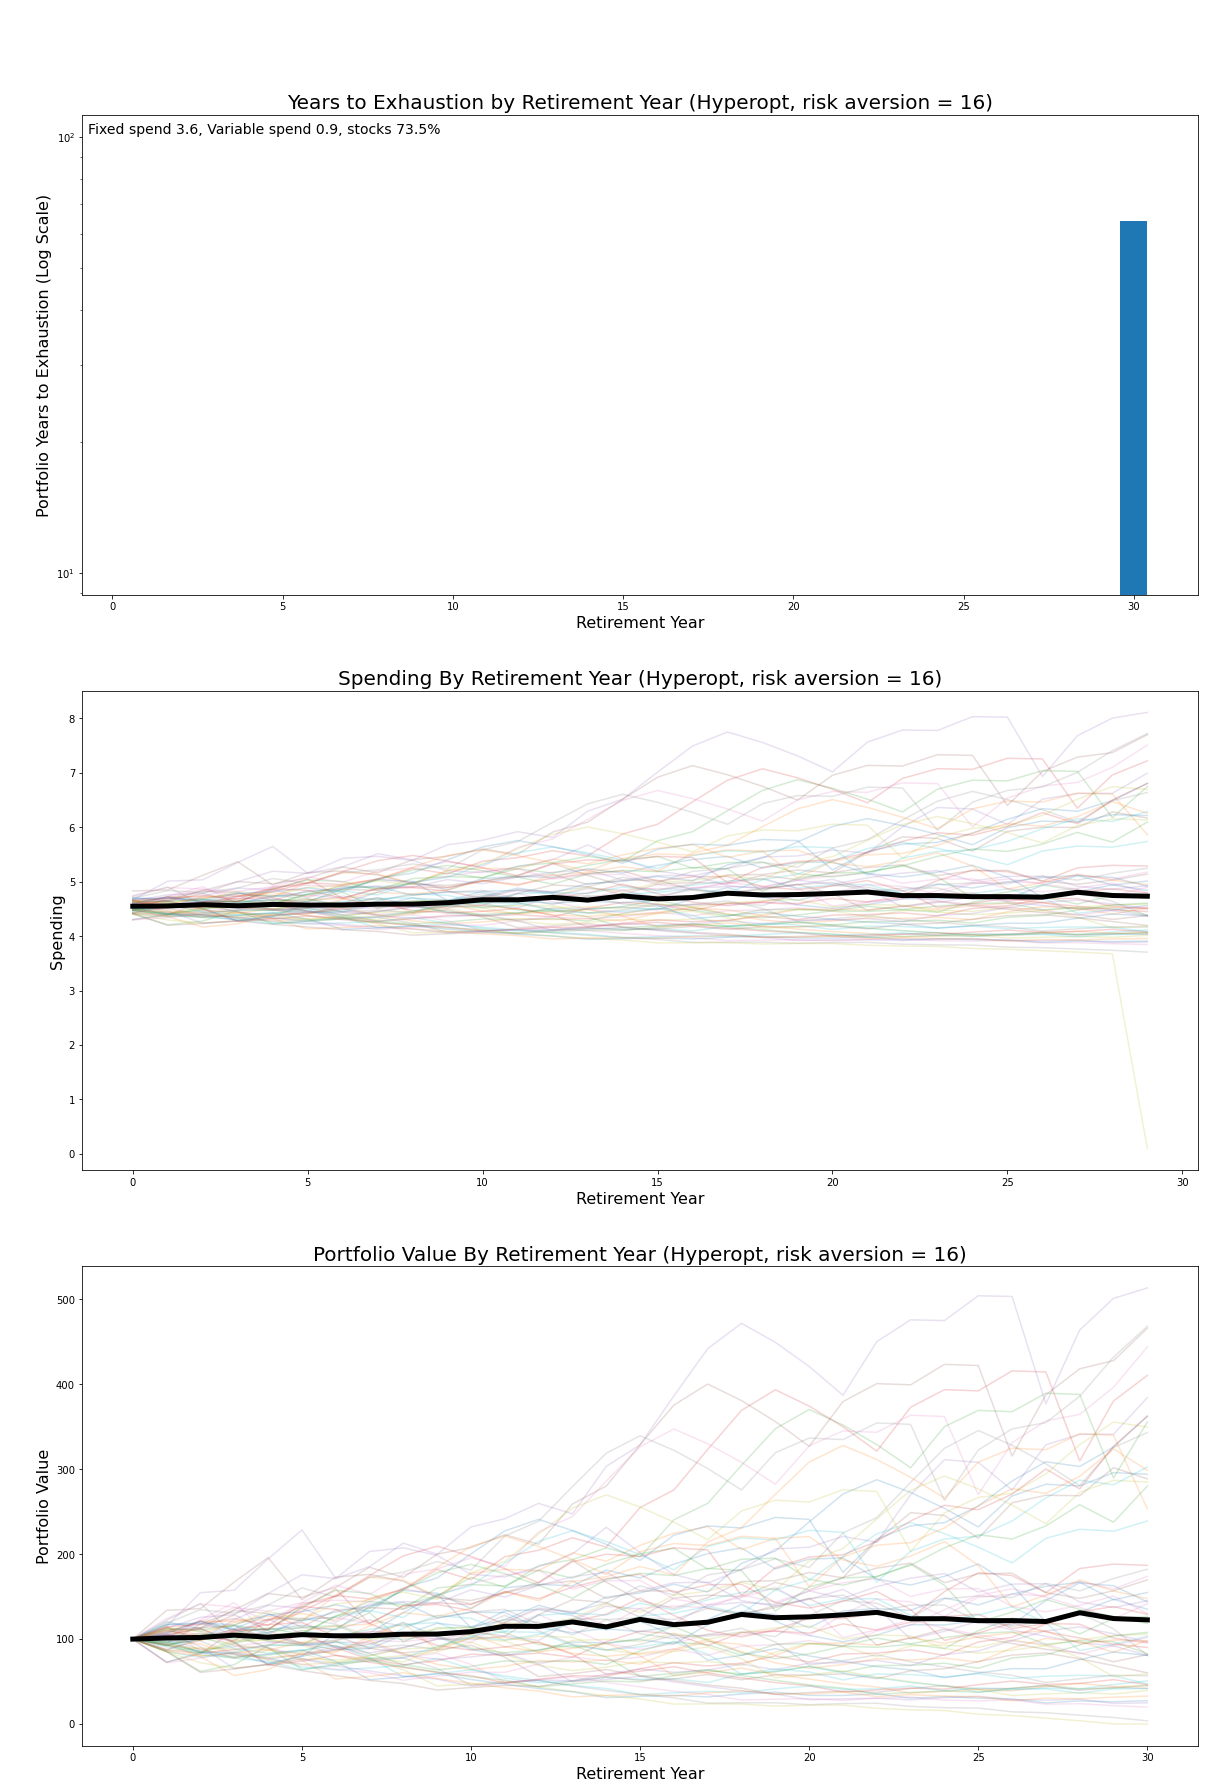

In [19]:
analyze_strat(results.iloc[-1]).analyze()


### Platypus
https://github.com/Project-Platypus/Platypus

In [20]:
print("%s %s" % ("platypus", platypus.__version__))
n_trials = N_TRIALS
optimizer = "Platypus (MOEAD)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:
    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    # number inputs, outputs
    problem = Problem(3, 1)
    # ranges
    problem.types[0] = Real(0, 5)   # fixed_spend
    problem.types[1] = Real(0, 10)  # variable_spend
    problem.types[2] = Real(0, 1)   # alloc_stocks

    # platypus wants a numpy array return because it's a multi-objective algo
    f = partial(ce_experiment, N_RET_YEARS, gamma)
    def pobjective(params):
        return np.array([f(params)])

    problem.function = pobjective
    algorithm = MOEAD(problem)
    algorithm.run(n_trials)
    best = sorted([(s.objectives[0], s.variables) for s in algorithm.result if s.feasible])[0]
    # tuple of best objective value, best params
    study_params.append(best)
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s" % (datestr(), best))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


INFO:Platypus:MOEAD starting


platypus 1.0.4
2021-02-11 15:15:44 Starting Platypus (MOEAD), gamma 0, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1053, Elapsed Time: 0:02:22.000074
INFO:Platypus:MOEAD starting


2021-02-11 15:18:06 Finishing optimizer Platypus (MOEAD), gamma 0, 1000 trials in 0:02:22.001620
2021-02-11 15:18:06 best params (-15527.181669754213, [0.0019679706398054476, 6.0677137743003176, 0.9998182776477248])
2021-02-11 15:18:06 Starting Platypus (MOEAD), gamma 1, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1065, Elapsed Time: 0:02:20.135527
INFO:Platypus:MOEAD starting


2021-02-11 15:20:26 Finishing optimizer Platypus (MOEAD), gamma 1, 1000 trials in 0:02:20.137265
2021-02-11 15:20:26 best params (-13517.813458827251, [0.31330113667596415, 6.214606748852749, 0.9999968030040093])
2021-02-11 15:20:26 Starting Platypus (MOEAD), gamma 2, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1061, Elapsed Time: 0:02:24.719432
INFO:Platypus:MOEAD starting


2021-02-11 15:22:51 Finishing optimizer Platypus (MOEAD), gamma 2, 1000 trials in 0:02:24.721199
2021-02-11 15:22:51 best params (-12016.100091604012, [2.121287410198015, 4.322963785057689, 0.9835912384287251])
2021-02-11 15:22:51 Starting Platypus (MOEAD), gamma 4, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1057, Elapsed Time: 0:02:30.755679
INFO:Platypus:MOEAD starting


2021-02-11 15:25:22 Finishing optimizer Platypus (MOEAD), gamma 4, 1000 trials in 0:02:30.757695
2021-02-11 15:25:22 best params (-10308.796439368194, [2.57251485049749, 3.3033863480687806, 0.8863059923913834])
2021-02-11 15:25:22 Starting Platypus (MOEAD), gamma 6, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1064, Elapsed Time: 0:02:44.803311
INFO:Platypus:MOEAD starting


2021-02-11 15:28:07 Finishing optimizer Platypus (MOEAD), gamma 6, 1000 trials in 0:02:44.805095
2021-02-11 15:28:07 best params (-9572.542134089761, [2.9768870681786006, 2.3223526440816866, 0.8005199384712585])
2021-02-11 15:28:07 Starting Platypus (MOEAD), gamma 8, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1067, Elapsed Time: 0:02:45.864618
INFO:Platypus:MOEAD starting


2021-02-11 15:30:53 Finishing optimizer Platypus (MOEAD), gamma 8, 1000 trials in 0:02:45.866797
2021-02-11 15:30:53 best params (-9065.190173336847, [2.8912069258797204, 2.5094264835971245, 0.7818837566166417])
2021-02-11 15:30:53 Starting Platypus (MOEAD), gamma 10, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1066, Elapsed Time: 0:02:45.719125
INFO:Platypus:MOEAD starting


2021-02-11 15:33:38 Finishing optimizer Platypus (MOEAD), gamma 10, 1000 trials in 0:02:45.720856
2021-02-11 15:33:38 best params (-8892.14889609647, [3.2397840891556964, 1.7019620339060793, 0.7484957164821301])
2021-02-11 15:33:38 Starting Platypus (MOEAD), gamma 12, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1062, Elapsed Time: 0:02:45.260301
INFO:Platypus:MOEAD starting


2021-02-11 15:36:24 Finishing optimizer Platypus (MOEAD), gamma 12, 1000 trials in 0:02:45.262104
2021-02-11 15:36:24 best params (-8642.731372433609, [3.212037567027373, 1.726970203425141, 0.6496297072878168])
2021-02-11 15:36:24 Starting Platypus (MOEAD), gamma 14, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1053, Elapsed Time: 0:02:43.101233
INFO:Platypus:MOEAD starting


2021-02-11 15:39:07 Finishing optimizer Platypus (MOEAD), gamma 14, 1000 trials in 0:02:43.103140
2021-02-11 15:39:07 best params (-8597.208737281575, [3.435770164478857, 1.2856119755745088, 0.7315741826307964])
2021-02-11 15:39:07 Starting Platypus (MOEAD), gamma 16, 1000 trials


INFO:Platypus:MOEAD finished; Total NFE: 1066, Elapsed Time: 0:02:44.661266


2021-02-11 15:41:51 Finishing optimizer Platypus (MOEAD), gamma 16, 1000 trials in 0:02:44.663332
2021-02-11 15:41:51 best params (-8475.92677908285, [3.6751127042059215, 0.7746352137291889, 0.7687168201306926])


In [21]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results_dict[optimizer] = results.copy()
results

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      0.999818     0.000182     0.001968        6.067714 -15527.181670
1      1      0.999997     0.000003     0.313301        6.214607 -13517.813459
2      2      0.983591     0.016409     2.121287        4.322964 -12016.100092
3      4      0.886306     0.113694     2.572515        3.303386 -10308.796439
4      6      0.800520     0.199480     2.976887        2.322353  -9572.542134
5      8      0.781884     0.218116     2.891207        2.509426  -9065.190173
6     10      0.748496     0.251504     3.239784        1.701962  -8892.148896
7     12      0.649630     0.350370     3.212038        1.726970  -8642.731372
8     14      0.731574     0.268426     3.435770        1.285612  -8597.208737
9     16      0.768717     0.231283     3.675113        0.774635  -8475.926779

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f060cad9e40>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.675112704205921,
 'fixed_pct': 3.6751127042059215,
 'variable': 0.0077463521372918885,
 'variable_pct': 0.7746352137291889}
mean annual spending over all cohorts 4.75
0.00% of portfolios exhausted by final year


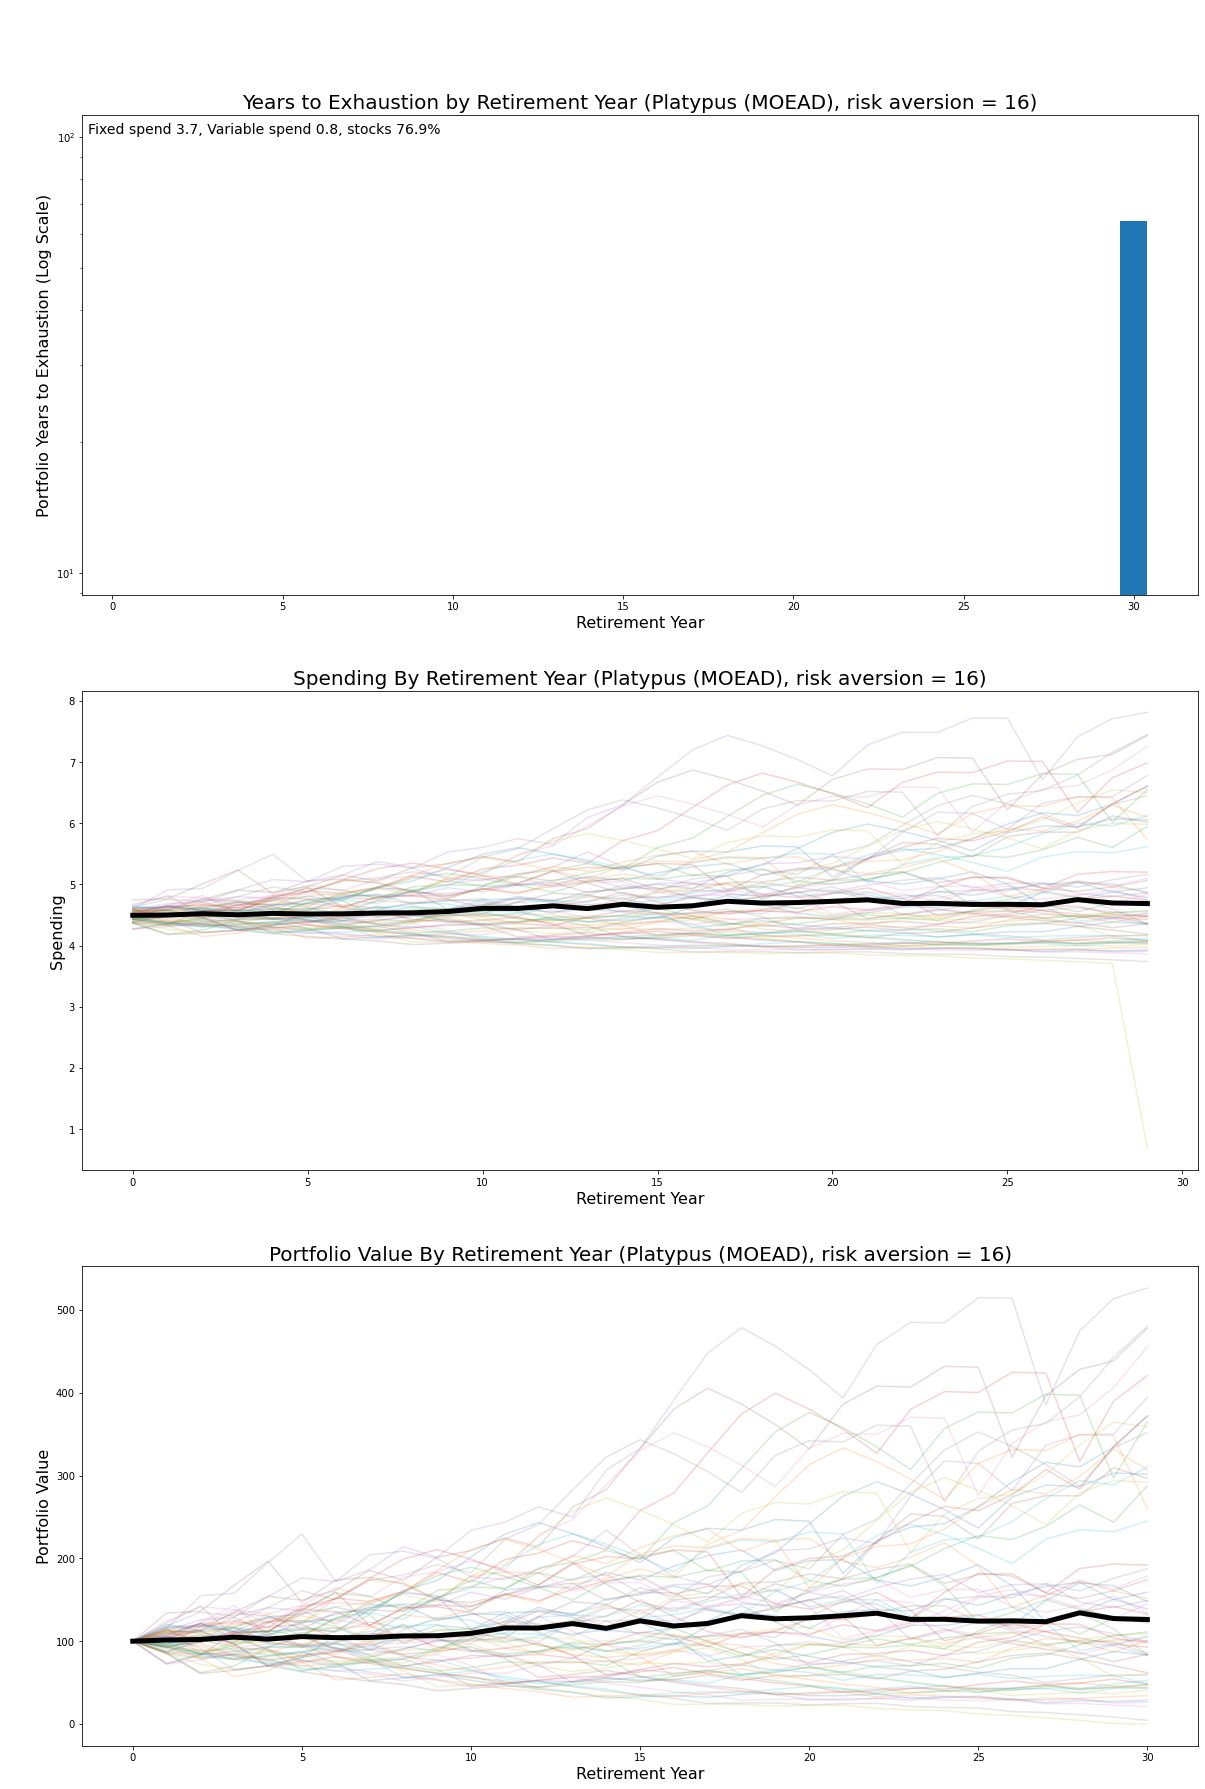

In [22]:
analyze_strat(results.iloc[-1]).analyze()


### Nevergrad
https://facebookresearch.github.io/nevergrad/optimization.html

In [23]:
print("%s %s" % ("nevergrad", ng.__version__))

n_trials = N_TRIALS
optimizer = "Nevergrad (OnePlusOne)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    nobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    opt = ng.optimizers.OnePlusOne(parametrization=3, budget=n_trials, num_workers=10)

    opt.parametrization.register_cheap_constraint(lambda x: x[0] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[0] <= 5)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[1] <= 10)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] >= 0)
    opt.parametrization.register_cheap_constraint(lambda x: x[2] <= 1)
    with futures.ThreadPoolExecutor(max_workers=opt.num_workers) as executor:
        recommendation = opt.minimize(nobjective, executor=executor, batch_mode=False)
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)    
    study_params.append((recommendation.loss, recommendation.value.tolist()))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %f" % (datestr(), recommendation.value, recommendation.loss))
        
opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


nevergrad 0.4.3
2021-02-11 15:41:52 Starting Nevergrad (OnePlusOne), gamma 0, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 15:45:19 Finishing optimizer Nevergrad (OnePlusOne), gamma 0, 1000 trials in 0:03:27.027547
2021-02-11 15:45:19 best params [1.00248745 6.19331945 1.        ] value -15265.378353
2021-02-11 15:45:19 Starting Nevergrad (OnePlusOne), gamma 1, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 15:48:52 Finishing optimizer Nevergrad (OnePlusOne), gamma 1, 1000 trials in 0:03:33.006078
2021-02-11 15:48:52 best params [0.78314247 4.47464249 1.        ] value -13079.511915
2021-02-11 15:48:52 Starting Nevergrad (OnePlusOne), gamma 2, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-11 15:52:27 Finishing optimizer Nevergrad (OnePlusOne), gamma 2, 1000 trials in 0:03:34.712923
2021-02-11 15:52:27 best params [1.10962836 6.05960557 1.        ] value -11820.113311
2021-02-11 15:52:27 Starting Nevergrad (OnePlusOne), gamma 4, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 15:56:22 Finishing optimizer Nevergrad (OnePlusOne), gamma 4, 1000 trials in 0:03:55.429005
2021-02-11 15:56:22 best params [2.74074014 2.88752495 0.86793671] value -10322.286010
2021-02-11 15:56:22 Starting Nevergrad (OnePlusOne), gamma 6, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 16:00:39 Finishing optimizer Nevergrad (OnePlusOne), gamma 6, 1000 trials in 0:04:16.580932
2021-02-11 16:00:39 best params [3.03614566 2.18184665 0.8242846 ] value -9572.683299
2021-02-11 16:00:39 Starting Nevergrad (OnePlusOne), gamma 8, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 16:04:54 Finishing optimizer Nevergrad (OnePlusOne), gamma 8, 1000 trials in 0:04:15.152139
2021-02-11 16:04:54 best params [3.15839335 1.89410162 0.71396936] value -9146.444815
2021-02-11 16:04:54 Starting Nevergrad (OnePlusOne), gamma 10, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-11 16:09:06 Finishing optimizer Nevergrad (OnePlusOne), gamma 10, 1000 trials in 0:04:11.861791
2021-02-11 16:09:06 best params [2.96042567 2.35719171 0.75911241] value -8754.634247
2021-02-11 16:09:06 Starting Nevergrad (OnePlusOne), gamma 12, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 16:13:21 Finishing optimizer Nevergrad (OnePlusOne), gamma 12, 1000 trials in 0:04:15.007781
2021-02-11 16:13:21 best params [3.02957009 2.19658697 0.77519832] value -8542.929509
2021-02-11 16:13:21 Starting Nevergrad (OnePlusOne), gamma 14, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.

/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/optimization/base.py:456: UserWarning:

Could not bypass the constraint after 1000 tentatives, sending candidate anyway.



2021-02-11 16:17:36 Finishing optimizer Nevergrad (OnePlusOne), gamma 14, 1000 trials in 0:04:15.372520
2021-02-11 16:17:36 best params [3.0051267  2.24218529 0.72549852] value -8305.486785
2021-02-11 16:17:36 Starting Nevergrad (OnePlusOne), gamma 16, 1000 trials


/home/ubuntu/anaconda3/envs/optimizers/lib/python3.8/site-packages/nevergrad/parametrization/core.py:309: UserWarning:

Lambda as constraint is not advised because it may not be picklable.



2021-02-11 16:21:55 Finishing optimizer Nevergrad (OnePlusOne), gamma 16, 1000 trials in 0:04:18.708400
2021-02-11 16:21:55 best params [3.01582866 2.22460921 0.74798689] value -8135.300165


In [24]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks   alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000  3.330669e-16     1.002487        6.193319   
1      1      1.000000  1.865175e-14     0.783142        4.474642   
2      2      1.000000  1.409983e-14     1.109628        6.059606   
3      4      0.867937  1.320633e-01     2.740740        2.887525   
4      6      0.824285  1.757154e-01     3.036146        2.181847   
5      8      0.713969  2.860306e-01     3.158393        1.894102   
6     10      0.759112  2.408876e-01     2.960426        2.357192   
7     12      0.775198  2.248017e-01     3.029570        2.196587   
8     14      0.725499  2.745015e-01     3.005127        2.242185   
9     16      0.747987  2.520131e-01     3.015829        2.224609   

          value  
0 -15265.378353  
1 -13079.511915  
2 -11820.113311  
3 -10322.286010  
4  -9572.683299  
5  -9146.444815  
6  -8754.634247  
7  -8542.929509  
8  -8305.486785  
9  -8135.300165

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0604685f90>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.015828656275207,
 'fixed_pct': 3.015828656275207,
 'variable': 0.022246092061549025,
 'variable_pct': 2.2246092061549025}
mean annual spending over all cohorts 5.58
0.00% of portfolios exhausted by final year


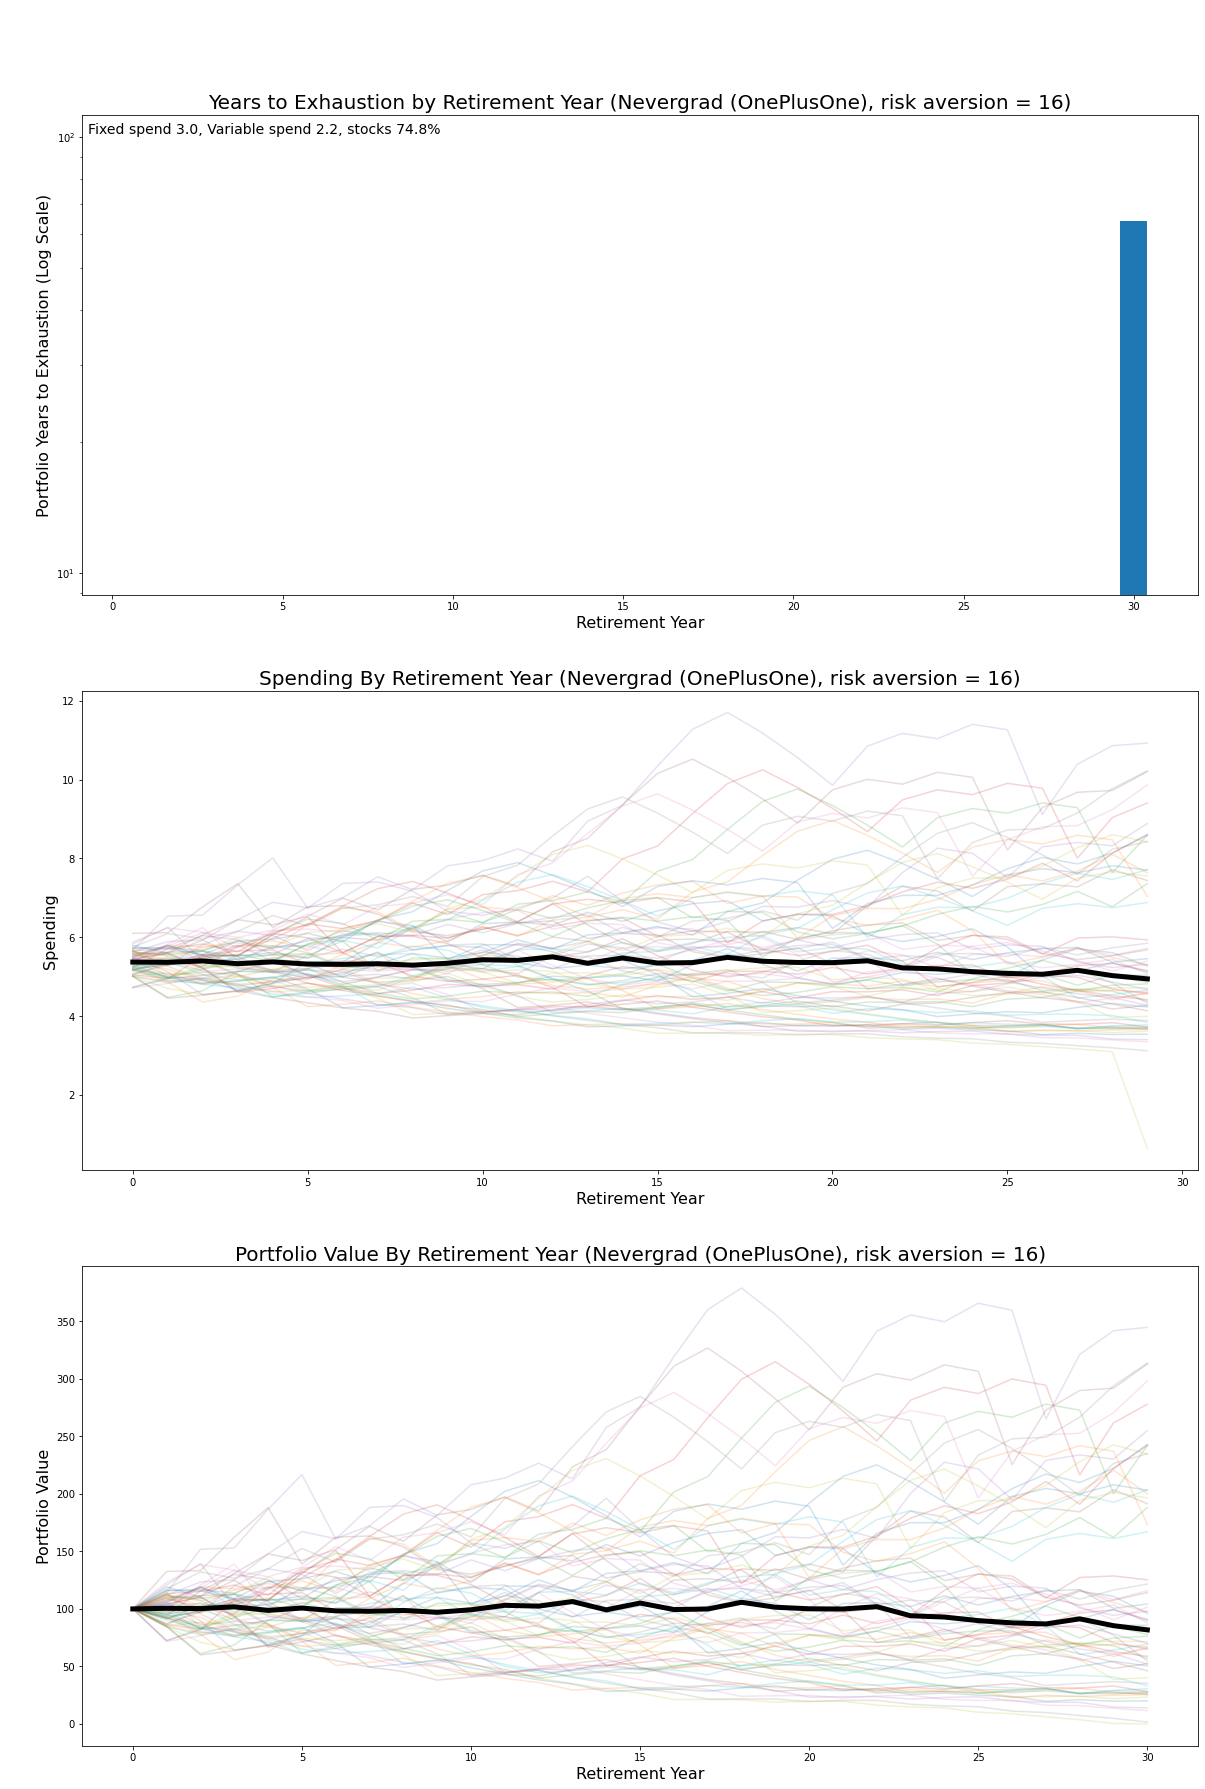

In [25]:
analyze_strat(results.iloc[-1]).analyze()


### Ax
https://ax.dev/

In [26]:
print("%s %s" % ("ax", ax.__version__))

n_trials = N_TRIALS // 10  # otherwise very slow
optimizer = "Ax (defaults)"

study_params = []
study_timings = []
study_gammas = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16]

opt_start_time = datetime.now()

for gamma in study_gammas:

    print("%s Starting %s, gamma %d, %d trials" % (datestr(), optimizer, gamma, n_trials))
    start_time = datetime.now() 
    aobjective = partial(ce_experiment, N_RET_YEARS, gamma)
    
    best_parameters, best_values, experiment, model = ax.optimize(
        parameters=[
            {
                "name": "fixed_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 5.0],
            },
            {
                "name": "variable_spend",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 10.0],
            },
            {
                "name": "alloc_stocks",
                "type": "range",
                "value_type": "float",
                "bounds": [0.0, 1.0],
            },
        ],
        evaluation_function=aobjective,
        minimize=True,
        total_trials=n_trials,
        #verbose_logging=False
    )
    
    time_elapsed = datetime.now() - start_time 
    study_timings.append(time_elapsed)
    
    study_params.append((best_values[0]['objective'], 
                         [best_parameters['fixed_spend'], 
                          best_parameters['variable_spend'], 
                          best_parameters['alloc_stocks']]
                        ))

    print("%s Finishing optimizer %s, gamma %d, %d trials in %s" % (datestr(), optimizer, gamma, n_trials, time_elapsed))
    print("%s best params %s value %s" % (datestr(), best_values[0]['objective'], best_parameters))

opt_end_time = datetime.now()
time_elapsed = opt_end_time - opt_start_time
timings_dict[optimizer] = time_elapsed
print("%s Finished %s in %s" % (opt_end_time, optimizer, time_elapsed))


[INFO 02-11 16:21:56] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 02-11 16:21:56] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-11 16:21:56] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-11 16:21:56] ax.service.managed_loop: Running optimization trial 2...


ax 0.1.19
2021-02-11 16:21:56 Starting Ax (defaults), gamma 0, 100 trials


[INFO 02-11 16:21:56] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:21:56] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:21:57] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:21:57] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:21:57] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:21:57] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:21:58] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:21:58] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:21:59] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:21:59] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:22:00] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:22:00] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:22:00] ax.service.managed_loop: 

[INFO 02-11 16:22:30] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:22:30 Finishing optimizer Ax (defaults), gamma 0, 100 trials in 0:00:34.355336
2021-02-11 16:22:30 best params -15521.72543055542 value {'fixed_spend': 0.0, 'variable_spend': 5.944150212662259, 'alloc_stocks': 1.0}
2021-02-11 16:22:30 Starting Ax (defaults), gamma 1, 100 trials


[INFO 02-11 16:22:31] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:22:31] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:22:31] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:22:31] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:22:32] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:22:32] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:22:32] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:22:33] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:22:34] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:22:34] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:22:35] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:22:36] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:22:37] ax.service.managed_loop: 

[INFO 02-11 16:23:28] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:23:28 Finishing optimizer Ax (defaults), gamma 1, 100 trials in 0:00:57.413777
2021-02-11 16:23:28 best params -13517.399349151867 value {'fixed_spend': 0.28321229016379995, 'variable_spend': 6.299355830428414, 'alloc_stocks': 1.0}
2021-02-11 16:23:28 Starting Ax (defaults), gamma 2, 100 trials


[INFO 02-11 16:23:28] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:23:28] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:23:28] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:23:28] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:23:29] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:23:30] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:23:30] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:23:30] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:23:31] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:23:32] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:23:32] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:23:33] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:23:33] ax.service.managed_loop: 

[INFO 02-11 16:24:43] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:24:43 Finishing optimizer Ax (defaults), gamma 2, 100 trials in 0:01:15.455497
2021-02-11 16:24:43 best params -12006.2905345926 value {'fixed_spend': 1.763082127837918, 'variable_spend': 4.855353686774858, 'alloc_stocks': 1.0}
2021-02-11 16:24:43 Starting Ax (defaults), gamma 4, 100 trials


[INFO 02-11 16:24:44] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:24:44] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:24:44] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:24:44] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:24:44] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:24:45] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:24:45] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:24:46] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:24:47] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:24:48] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:24:48] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:24:49] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:24:49] ax.service.managed_loop: 

[INFO 02-11 16:25:34] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:25:34 Finishing optimizer Ax (defaults), gamma 4, 100 trials in 0:00:50.881219
2021-02-11 16:25:34 best params -10198.060230833738 value {'fixed_spend': 2.2628811921927654, 'variable_spend': 3.633039038577955, 'alloc_stocks': 0.8866404425300972}
2021-02-11 16:25:34 Starting Ax (defaults), gamma 6, 100 trials


[INFO 02-11 16:25:34] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:25:35] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:25:35] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:25:35] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:25:35] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:25:36] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:25:36] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:25:37] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:25:37] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:25:38] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:25:38] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:25:39] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:25:39] ax.service.managed_loop: 

[INFO 02-11 16:27:08] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:27:08 Finishing optimizer Ax (defaults), gamma 6, 100 trials in 0:01:33.931292
2021-02-11 16:27:08 best params -9497.217303507652 value {'fixed_spend': 2.7823479025390183, 'variable_spend': 2.621079179483405, 'alloc_stocks': 0.8524405274411263}
2021-02-11 16:27:08 Starting Ax (defaults), gamma 8, 100 trials


[INFO 02-11 16:27:08] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:27:08] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:27:09] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:27:09] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:27:09] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:27:10] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:27:11] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:27:11] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:27:12] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:27:13] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:27:14] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:27:14] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:27:15] ax.service.managed_loop: 

[INFO 02-11 16:28:22] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:28:22 Finishing optimizer Ax (defaults), gamma 8, 100 trials in 0:01:13.812905
2021-02-11 16:28:22 best params -8825.069378267986 value {'fixed_spend': 2.4886447680561172, 'variable_spend': 2.934128174122969, 'alloc_stocks': 0.7922537511633794}
2021-02-11 16:28:22 Starting Ax (defaults), gamma 10, 100 trials


[INFO 02-11 16:28:22] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:28:22] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:28:22] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:28:23] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:28:23] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:28:24] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:28:24] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:28:25] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:28:25] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:28:26] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:28:27] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:28:28] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:28:28] ax.service.managed_loop: 

[INFO 02-11 16:29:22] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:29:22 Finishing optimizer Ax (defaults), gamma 10, 100 trials in 0:01:00.224098
2021-02-11 16:29:22 best params -8413.65847357973 value {'fixed_spend': 2.4290050645185253, 'variable_spend': 2.9333884336326337, 'alloc_stocks': 0.7873220292374821}
2021-02-11 16:29:22 Starting Ax (defaults), gamma 12, 100 trials


[INFO 02-11 16:29:22] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:29:23] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:29:23] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:29:23] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:29:23] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:29:24] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:29:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:29:26] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:29:26] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:29:27] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:29:29] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:29:30] ax.service.managed_loop: Running optimization trial 14...
[INFO 02-11 16:29:31] ax.service.managed_loop: 

[INFO 02-11 16:31:02] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:31:02 Finishing optimizer Ax (defaults), gamma 12, 100 trials in 0:01:40.196418
2021-02-11 16:31:02 best params -8605.963390996296 value {'fixed_spend': 3.5064171419425816, 'variable_spend': 1.0649728198378414, 'alloc_stocks': 0.5818396988745543}
2021-02-11 16:31:02 Starting Ax (defaults), gamma 14, 100 trials


[INFO 02-11 16:31:03] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:31:03] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:31:03] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:31:03] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:31:03] ax.modelbridge.transforms.standardize_y: Outcome objective is constant, within tolerance.
[INFO 02-11 16:31:03] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:31:04] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:31:04] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:31:05] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:31:05] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:31:06] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:31:07] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:

[INFO 02-11 16:32:17] ax.service.managed_loop: Started full optimization with 100 steps.
[INFO 02-11 16:32:17] ax.service.managed_loop: Running optimization trial 1...
[INFO 02-11 16:32:17] ax.service.managed_loop: Running optimization trial 2...


2021-02-11 16:32:17 Finishing optimizer Ax (defaults), gamma 14, 100 trials in 0:01:14.699526
2021-02-11 16:32:17 best params -8137.76361376684 value {'fixed_spend': 2.725085619523026, 'variable_spend': 2.329894204933362, 'alloc_stocks': 0.7954257138462232}
2021-02-11 16:32:17 Starting Ax (defaults), gamma 16, 100 trials


[INFO 02-11 16:32:17] ax.service.managed_loop: Running optimization trial 3...
[INFO 02-11 16:32:17] ax.service.managed_loop: Running optimization trial 4...
[INFO 02-11 16:32:18] ax.service.managed_loop: Running optimization trial 5...
[INFO 02-11 16:32:18] ax.service.managed_loop: Running optimization trial 6...
[INFO 02-11 16:32:18] ax.modelbridge.transforms.standardize_y: Outcome objective is constant, within tolerance.
[INFO 02-11 16:32:18] ax.service.managed_loop: Running optimization trial 7...
[INFO 02-11 16:32:18] ax.service.managed_loop: Running optimization trial 8...
[INFO 02-11 16:32:19] ax.service.managed_loop: Running optimization trial 9...
[INFO 02-11 16:32:20] ax.service.managed_loop: Running optimization trial 10...
[INFO 02-11 16:32:21] ax.service.managed_loop: Running optimization trial 11...
[INFO 02-11 16:32:22] ax.service.managed_loop: Running optimization trial 12...
[INFO 02-11 16:32:22] ax.service.managed_loop: Running optimization trial 13...
[INFO 02-11 16:

2021-02-11 16:33:33 Finishing optimizer Ax (defaults), gamma 16, 100 trials in 0:01:15.871278
2021-02-11 16:33:33 best params -8130.258857273851 value {'fixed_spend': 3.0594093075884805, 'variable_spend': 2.0272504857803284, 'alloc_stocks': 0.5623462454098698}


In [27]:
results = pd.DataFrame([s[1] for s in study_params], columns=['fixed_spend', 'variable_spend', 'alloc_stocks'])
results['gamma'] = study_gammas
results['alloc_bonds'] = 1-results['alloc_stocks']
results = results[['gamma', 'alloc_stocks', 'alloc_bonds', 'fixed_spend', 'variable_spend','value', 'timing']]
results['value'] = [s[0] for s in study_params]
results['timing'] = study_timings
results_dict[optimizer] = results.copy()
results


gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend         value
0      0      1.000000     0.000000     0.000000        5.944150 -15521.725431
1      1      1.000000     0.000000     0.283212        6.299356 -13517.399349
2      2      1.000000     0.000000     1.763082        4.855354 -12006.290535
3      4      0.886640     0.113360     2.262881        3.633039 -10198.060231
4      6      0.852441     0.147559     2.782348        2.621079  -9497.217304
5      8      0.792254     0.207746     2.488645        2.934128  -8825.069378
6     10      0.787322     0.212678     2.429005        2.933388  -8413.658474
7     12      0.581840     0.418160     3.506417        1.064973  -8605.963391
8     14      0.795426     0.204574     2.725086        2.329894  -8137.763614
9     16      0.562346     0.437654     3.059409        2.027250  -8130.258857

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0604788430>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.0594093075884805,
 'fixed_pct': 3.0594093075884805,
 'variable': 0.020272504857803283,
 'variable_pct': 2.0272504857803284}
mean annual spending over all cohorts 5.47
0.00% of portfolios exhausted by final year


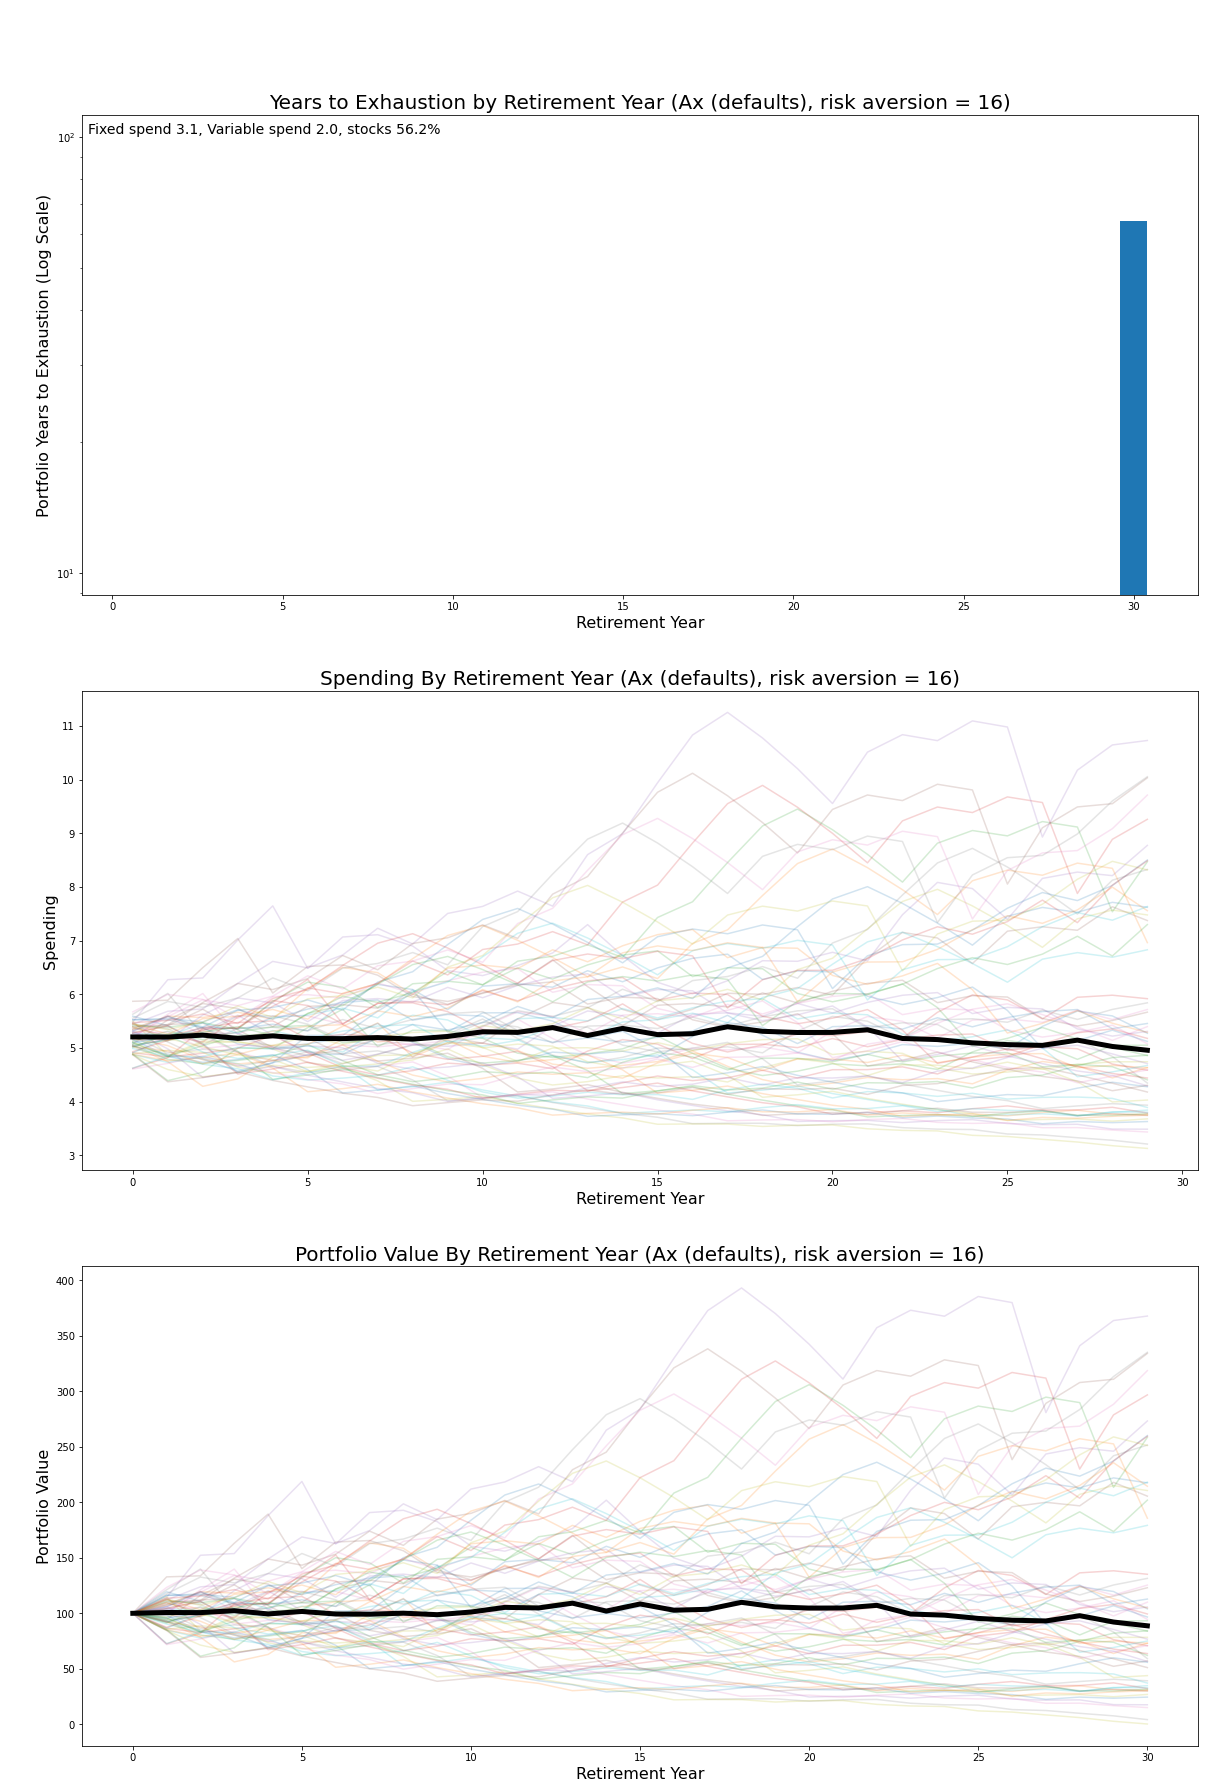

In [28]:
analyze_strat(results.iloc[-1]).analyze()


In [29]:
# from scipy.optimize import basinhopping
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html
# slow and performs poorly
# gamma = 1
# x0 = np.array([1.0, 5.0, 0.5])
# optimizer = "basinhopping"

# stepsize = 0.25
# T = 50
# minimizer_kwargs = {"method": "BFGS"}
# MAX_ITER = 100

# def print_fun(x, f, accepted):
#     print("%s at minimum %.4f accepted %d (%s)" % (datestr(), f, int(accepted), x))
        
# class MyBounds(object):
#     def __init__(self, 
#                  xmax=[5.0, 10.0, 1.0], 
#                  xmin=[0.0,  0.0, 0.0] ):
#         self.xmax = np.array(xmax)
#         self.xmin = np.array(xmin)
#     def __call__(self, **kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= self.xmax))
#         tmin = bool(np.all(x >= self.xmin))
#         return tmax and tmin
# mybounds = MyBounds()

# print("%s Starting %s, gamma %d, %d iterations max" % (datestr(), optimizer, gamma, MAX_ITER))
# start_time = datetime.now()
# bobjective = partial(ce_experiment, N_RET_YEARS, gamma)
# ret = basinhopping(bobjective, x0, minimizer_kwargs=minimizer_kwargs,
#                    niter=MAX_ITER, stepsize=stepsize, T=T,
#                    accept_test=mybounds,
#                    callback=print_fun)



### Visualize all results

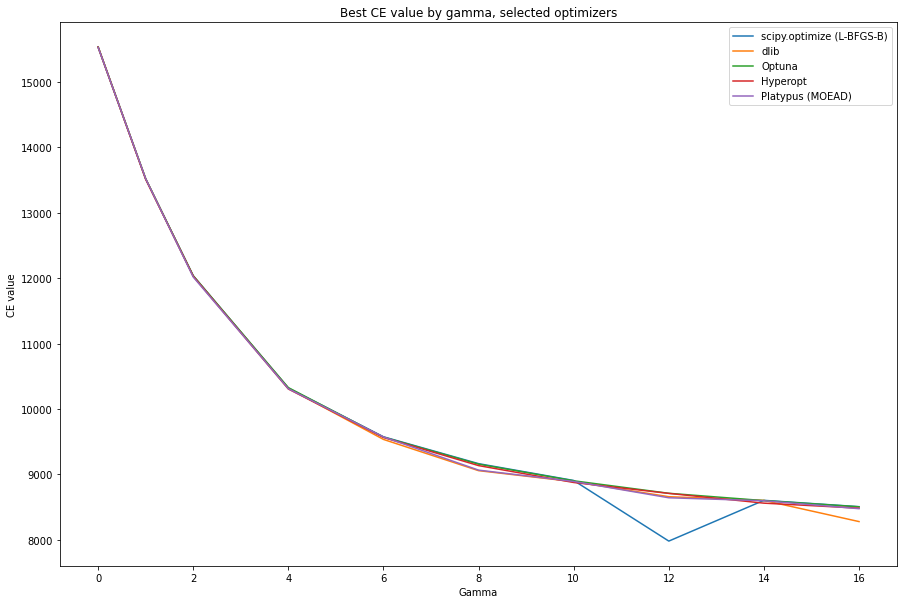

In [31]:
# plot all results

plt.figure(figsize=(15,10))
plt.title('Best CE value by gamma, selected optimizers')
plt.xlabel('Gamma')
plt.ylabel('CE value')
# for opt in results_dict.keys():
# skip last 2 which are more messy and never best
# maybe they need more iterations but they are taking plenty of time already
for opt in ['scipy.optimize (L-BFGS-B)', 'dlib', 'Optuna', 'Hyperopt', 'Platypus (MOEAD)', ]:
    plt.plot(results_dict[opt]['gamma'], -results_dict[opt]['value'], label=opt)
    
plt.legend();



In [32]:
df_list = []
for optimizer in results_dict.keys():
    results_dict[optimizer]['optimizer'] = optimizer
    df_list.append(results_dict[optimizer])
all_results = pd.concat(df_list)
all_results['value'] = - all_results['value']



In [37]:
mean_spends = []
exhaustions = []

for row in all_results.itertuples():
    s = analyze_strat(row)
    mean_spends.append(s.latest_simulation[0]['mean_spend'])
    exhaustions.append(s.latest_simulation[0]['years_to_exhaustion'])
                   
all_results['mean_spend'] = mean_spends
all_results['exhaustion'] = exhaustions
    

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f0603176eb0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 0.0,
 'fixed_pct': 0.0,
 'variable': 0.06204104765351314,
 'variable_pct': 6.204104765351314}
Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f06048f5580>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 3.4131466505341037,
 'fixed_pct': 3.413146650534104,
 'variable': 0.013040768307599543,
 'variable_pct': 1.3040768307599542}
Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...


Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f060486cdd0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 2.9768870681786006,
 'fixed_pct': 2.9768870681786006,
 'variable': 0.023223526440816867,
 'variable_pct': 2.3223526440816866}
Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7f06048f5430>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 0.0,
 'fixed_pct': 0.0,
 'variable': 0.05944150212662259,
 'variable_pct': 5.944150212662259}
Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  

In [39]:
all_results['group_gamma_max'] = all_results.groupby(['gamma'])['value'].transform(max)
all_results.loc[all_results['value'] == all_results['group_gamma_max']].sort_values('gamma')

gamma  alloc_stocks  alloc_bonds  fixed_spend  variable_spend  \
0      0      1.000000     0.000000     0.000000        6.204105   
1      1      1.000000     0.000000     0.295292        6.239439   
2      2      1.000000     0.000000     2.064036        4.393697   
3      4      0.883328     0.116672     2.700751        2.989388   
4      6      0.816224     0.183776     3.000151        2.265994   
5      8      0.785915     0.214085     3.188369        1.833849   
6     10      0.770464     0.229536     3.322693        1.534553   
7     12      0.739455     0.260545     3.413147        1.304077   
8     14      0.753637     0.246363     3.498058        1.154462   
9     16      0.754680     0.245320     3.556900        1.029995   

          value                  optimizer  group_gamma_max  mean_spend  \
0  15532.416056  scipy.optimize (L-BFGS-B)     15532.416056    5.587570   
1  13517.859788                       dlib     13517.859788    5.633694   
2  12036.308515  scipy.optimize (L-BFGS-B)     12036.308515    5.761026   
3  10325.958295                     Optuna     10325.958295    5.584040   
4   9574.406303  scipy.optimize (L-BFGS-B)      9574.406303    5.380178   
5   9163.997255  scipy.optimize (L-BFGS-B)      9163.997255    5.217585   
6   8906.921628  scipy.optimize (L-BFGS-B)      8906.921628    5.084155   
7   8711.139066                     Optuna      8711.139066    4.957939   
8   8603.485064  scipy.optimize (L-BFGS-B)      8603.485064    4.887307   
9   8506.558108  scipy.optimize (L-BFGS-B)      8506.558108    4.815823   

   exhaustion  
0          30  
1          30  
2          30  
3          30  
4          30  
5          30  
6          30  
7          30  
8          30  
9          30

In [59]:
pd.DataFrame(timings_dict.values(), index=timings_dict.keys(), columns=['timing'])

timing
scipy.optimize (L-BFGS-B) 0 days 00:03:13.579722